# Libraries
1. [filterpy](https://filterpy.readthedocs.io/en/latest/kalman/UnscentedKalmanFilter.html)

In [1]:
import numpy as np
import pandas as pd
import random
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px
import seaborn as sns

import geopy
import pymap3d as pm
from filterpy.kalman import UnscentedKalmanFilter, MerweScaledSigmaPoints

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import torchsummary
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import warnings
warnings.filterwarnings(action='ignore')

# Hyper Parameters

In [2]:
SEED = 1990
random.seed(SEED)
np.random.seed(SEED)

In [3]:
q = np.array([1,1,1,1,1])
r = np.array([1,1,1,1])

# Useful functions

In [4]:
def calc_haversine(lat1, lon1, lat2, lon2):
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
    
    c = 2 * np.arcsin(a ** 0.5)
    dist = 6_367_000 * c
    return dist

In [5]:
def check_score(input_df: pd.DataFrame) -> pd.DataFrame:
    output_df = input_df.copy()
    
    output_df['meter'] = input_df.apply(
        lambda r: calc_haversine(
            r.latDeg, r.lngDeg, r.t_latDeg, r.t_lngDeg
        ),
        axis=1
    )

    meter_score = output_df['meter'].mean()

    scores = []
    for phone in output_df['phone'].unique():
        _index = output_df['phone']==phone
        p_50 = np.percentile(output_df.loc[_index, 'meter'], 50)
        p_95 = np.percentile(output_df.loc[_index, 'meter'], 95)
        scores.append(p_50)
        scores.append(p_95)

    score = sum(scores) / len(scores)
    
    return output_df, meter_score , score

In [6]:
ell_wgs84 = pm.Ellipsoid()
def calc_geo2enu(df:pd.DataFrame)->pd.DataFrame:
    output = df.copy()
    llh = np.array(df[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']])
    denu = pm.geodetic2enu(llh[:,0], llh[:,1], llh[:,2], llh[0,0], llh[0,1], llh[0,2], ell=ell_wgs84)
    output['x'] = denu[0]
    output['y'] = denu[1]
    output['z'] = denu[2]
    
    return output

def calc_enu2geo(df:pd.DataFrame)->pd.DataFrame:
    output = df.copy()
    enu = np.array(df[['x', 'y', 'z']])
    llh = np.array(df[['latDeg', 'lngDeg', 'heightAboveWgs84EllipsoidM']])
    geo = pm.enu2geodetic(enu[:,0], enu[:,1], enu[:,2], llh[0,0], llh[0,1], llh[0,2], ell=ell_wgs84, deg = True)
    output['latDeg'] = geo[0]
    output['lngDeg'] = geo[1]
    output['heightAboveWgs84EllipsoidM'] = geo[2]
    
    return output

# Data

In [7]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")
df_train = pd.read_pickle(str(data_dir / "gsdc_extract_train.pkl.gzip"))
df_test = pd.read_pickle(str(data_dir / "gsdc_extract_test.pkl.gzip"))

In [8]:
phones = df_train['phone'].unique()
phone = phones[random.randint(0, len(phones))]
df_sample = df_train[df_train['phone'] == phone].copy().reset_index().drop(columns = ['index'])
print(df_sample.shape)
df_sample.head()

(1746, 148)


,collectionName,phoneName,millisSinceGpsEpoch,latDeg,lngDeg,heightAboveWgs84EllipsoidM,phone,timeSinceFirstFixSeconds,hDop,vDop,...,GPS_L1,GPS_L5,GAL_E1,GAL_E5A,GLO_G1,BDS_B1I,BDS_B1C,BDS_B2A,QZS_J1,QZS_J5
0,2020-05-14-US-MTV-1,Pixel4XLModded,1273529466449,37.423574,-122.094137,-33.20,2020-05-14-US-MTV-1_Pixel4XLModded,554.45,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0
1,2020-05-14-US-MTV-1,Pixel4XLModded,1273529467449,37.423573,-122.094153,-33.92,2020-05-14-US-MTV-1_Pixel4XLModded,555.45,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0
2,2020-05-14-US-MTV-1,Pixel4XLModded,1273529468449,37.423578,-122.094148,-33.33,2020-05-14-US-MTV-1_Pixel4XLModded,556.45,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0
3,2020-05-14-US-MTV-1,Pixel4XLModded,1273529469449,37.423573,-122.094150,-32.85,2020-05-14-US-MTV-1_Pixel4XLModded,557.45,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0
4,2020-05-14-US-MTV-1,Pixel4XLModded,1273529470449,37.423573,-122.094147,-31.26,2020-05-14-US-MTV-1_Pixel4XLModded,558.45,1.2,0.0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
timeSinceFirstFixSeconds
hDop
vDop
speedMps
courseDegree
t_latDeg
t_lngDeg
t_heightAboveWgs84EllipsoidM
constellationType
svid
signalType
receivedSvTimeInGpsNanos
xSatPosM
ySatPosM
zSatPosM
xSatVelMps
ySatVelMps
zSatVelMps
satClkBiasM
satClkDriftMps
rawPrM
rawPrUncM
isrbM
ionoDelayM
tropoDelayM
utcTimeMillis
elapsedRealtimeNanos
yawDeg
rollDeg
pitchDeg
utcTimeMillis_Status
SignalCount
SignalIndex
ConstellationType
Svid
CarrierFrequencyHz
Cn0DbHz
AzimuthDegrees
ElevationDegrees
UsedInFix
HasAlmanacData
HasEphemerisData
BasebandCn0DbHz
utcTimeMillis_UncalMag
elapsedRealtimeNanos_UncalMag
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_UncalAccel
elapsedRealtimeNanos_UncalAccel
UncalAccelXMps2
UncalAccelYMps2
UncalAccelZMps2
BiasXMps2
BiasYMps2
BiasZMps2
utcTimeMillis_UncalGyro
elapsedRealtimeNanos_UncalGyro
UncalGyroXRadPerSec
UncalGyroYRadPerSec
U

## Model Define
$$
\begin{matrix}
x_t =& x_{t-1} + \frac{v_{t-1}}{w_{t-1}}\left({\sin}\left({\omega}_{t-1}dt + {\theta}_{t-1}\right) - {\sin}\left({\theta}\right)\right)\\
y_t =& y_{t-1} + \frac{v_{t-1}}{w_{t-1}}\left({\cos}\left({\theta}_{t-1}\right) - {\cos}\left({\omega}_{t-1}dt + {\theta}_{t-1}\right)\right)\\
v_t =& v_{t-1}\\
{\theta}_t =& {\theta}_{t-1} + {\omega}_{t-1}dt\\
{\omega}_t =& {\omega}_{t-1}
\end{matrix}
$$

In [10]:
def fx(x, dt):
    xout = np.zeros_like(x)
    if abs(x[4]) > 1e-3:
        xout[0] = x[0] + x[2]/x[4] * (np.sin(x[4] * dt + x[3]) - np.sin(x[3]))
        xout[1] = x[1] + x[2]/x[4] * (np.cos(x[3]) - np.cos(x[4] * dt + x[3]))
        xout[2] = x[2]
        xout[3] = x[3] + x[4] * dt
        xout[4] = x[4]
    else:
        xout[0] = x[0] + x[2] * dt * (np.cos(x[3]))
        xout[1] = x[1] + x[2] * dt * (np.sin(x[3]))
        xout[2] = x[2]
        xout[3] = x[3] + x[4] * dt
        xout[4] = x[4]
        
    return xout

In [11]:
def batch_filter(df, q_, r_):
    df1 = calc_geo2enu(df)
    df1['yawRad'] = np.deg2rad(df1['yawDeg'])
    
    
    features = ['x', 'y']
    index = [0, 1]
    rindex = [0, 1]
    if df1['yawDeg'].isna().mean() == 1 or df1['yawDeg'].mean() == 0:
        pass
    else:
        features += ['yawRad']
        index += [3]
        rindex+= [2]
    if df1['UncalGyroZRadPerSec'].isna().mean() == 1 or df1['UncalGyroZRadPerSec'].mean() == 0:
        pass
    else:
        features += ['UncalGyroZRadPerSec']
        index += [4]
        rindex+= [3]
    
    q = q_
    r = r_[rindex]
    meas = df1[features]
    meas = meas.fillna(0)
    h = lambda x:x[index]
    
    points = MerweScaledSigmaPoints(5, alpha = .1, beta = 2., kappa = -1)
    kf = UnscentedKalmanFilter(dim_x = 5, dim_z = len(features), dt = 1, fx = fx, hx = h, points = points)
    kf.Q = np.diag(q)
    kf.R = np.diag(r)
    
    mu, cov = kf.batch_filter(meas.values)
    (xs, Ps, Ks) = kf.rts_smoother(mu, cov)
    df2 = df1.copy()
    df2['x'] = xs[:,0]
    df2['y'] = xs[:,1]
    df2['yawDeg'] = np.rad2deg(xs[:,2])
    df2['UncalGyroZRadPerSec'] = xs[:,3]
    df3 = calc_enu2geo(df2)
    return df3

In [12]:
def evaluate(df, q_, r_, get_score = True):
    output = df.copy()
    mean_before, score_before, mean_after, score_after =0, 0, 0, 0
    output.drop(columns = ['latDeg', 'lngDeg'], inplace = True)
    df_list = []
    
    for phone in tqdm(df['phone'].unique()):
        df1 = df[df['phone'] == phone].copy()
        df2 = batch_filter(df1, q_, r_)
        df_list.append(df2[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']])
    df3 = pd.concat(df_list)
    output = output.merge(df3, on = ['phone', 'millisSinceGpsEpoch'])

    if get_score:
        _, mean_before, score_before = check_score(df)
        _, mean_after, score_after = check_score(output)
    
    return output, mean_before, score_before, mean_after, score_after

In [39]:
q_ = np.array([0.01, 0.01, 0.05, 0.5*np.pi/180, 2.5*np.pi/180])**2
r_ = np.array([0.01, 0.01, 0.5*np.pi/180, 2.5*np.pi/180])**2
phones = df_train['phone'].unique()
sample_phone = np.random.choice(phones, 10, replace = False)
sample_index = df_train['phone'].apply(lambda x: x in sample_phone)

q_gain_ = 1
r_gain_ = 1
result_list = []
best_list = []
iter_count = 0
min_score = np.inf
rate = 0.1
count = 0

while(True):
    q_gain = abs(q_gain)
    r_gain = abs(r_gain)
    
    iter_count += 1
    q = q_gain * q_
    r = r_gain * r_
    _, mean_before, score_before, mean_after, score_after = evaluate(df_train[sample_index], q, r)
    result = [q_gain, r_gain, q, r, mean_after, mean_before, score_after, score_before]
    print(f"{q_gain.item():.4f}, {r_gain.item():.4f} : mean chagne - {mean_after - mean_before:.6f}, score change - {score_after - score_before:.6f}")
    print(f"after[{mean_after}, {score_after}], before[{mean_before}, {score_before}]")
    print(q_gain * q_)
    print(r_gain * r_)
    result_list.append(result)
    
    if min_score > score_after:
        print(f"Best Score! {score_after} - [{q_gain.item():.4f}, {r_gain.item():.4f}]")
        best_list.append(result)
        count= 0
        q_gain_ = q_gain
        r_gain_ = r_gain
        min_score = score_after
    else:
        count+=1
        q_gain = q_gain_
        r_gain = r_gain_
        
    q_gain += np.random.randn(1) * (rate * count)
    r_gain += np.random.randn(1) * (rate * count)
        

  0%|          | 0/10 [00:00<?, ?it/s]

3.5733, 3.7887 : mean chagne - 0.176777, score change - 0.457158
after[1.98517413095585, 3.158731770686792], before[1.8083973414191108, 2.7015735053444887]
[0.00035733 0.00035733 0.00893321 0.00027212 0.00680303]
[0.00037887 0.00037887 0.00028852 0.00721311]
Best Score! 3.158731770686792 - [3.5733, 3.7887]


  0%|          | 0/10 [00:00<?, ?it/s]

3.5733, 3.7887 : mean chagne - 0.176777, score change - 0.457158
after[1.98517413095585, 3.158731770686792], before[1.8083973414191108, 2.7015735053444887]
[0.00035733 0.00035733 0.00893321 0.00027212 0.00680303]
[0.00037887 0.00037887 0.00028852 0.00721311]


  0%|          | 0/10 [00:00<?, ?it/s]

3.4680, 3.6791 : mean chagne - 0.425969, score change - 1.204836
after[2.234366834756525, 3.9064095068829814], before[1.8083973414191108, 2.7015735053444887]
[0.0003468  0.0003468  0.00866995 0.0002641  0.00660254]
[0.00036791 0.00036791 0.00028018 0.0070044 ]


  0%|          | 0/10 [00:00<?, ?it/s]

3.2137, 3.7836 : mean chagne - 0.271116, score change - 0.728195
after[2.079513009641771, 3.429768215691663], before[1.8083973414191108, 2.7015735053444887]
[0.00032137 0.00032137 0.00803436 0.00024474 0.00611852]
[0.00037836 0.00037836 0.00028814 0.00720349]


  0%|          | 0/10 [00:00<?, ?it/s]

3.4347, 3.8700 : mean chagne - 0.333295, score change - 0.858939
after[2.1416926303559474, 3.5605121740367274], before[1.8083973414191108, 2.7015735053444887]
[0.00034347 0.00034347 0.00858678 0.00026157 0.00653921]
[0.000387   0.000387   0.00029472 0.00736792]


  0%|          | 0/10 [00:00<?, ?it/s]

3.9288, 3.9651 : mean chagne - 0.127422, score change - 0.292180
after[1.9358191762752397, 2.993753033117379], before[1.8083973414191108, 2.7015735053444887]
[0.00039288 0.00039288 0.00982198 0.00029919 0.00747987]
[0.00039651 0.00039651 0.00030196 0.00754902]
Best Score! 2.993753033117379 - [3.9288, 3.9651]


  0%|          | 0/10 [00:00<?, ?it/s]

3.9288, 3.9651 : mean chagne - 0.127422, score change - 0.292180
after[1.9358191762752397, 2.993753033117379], before[1.8083973414191108, 2.7015735053444887]
[0.00039288 0.00039288 0.00982198 0.00029919 0.00747987]
[0.00039651 0.00039651 0.00030196 0.00754902]


  0%|          | 0/10 [00:00<?, ?it/s]

3.9146, 3.8368 : mean chagne - 0.495616, score change - 1.288178
after[2.3040134810011175, 3.989751991088305], before[1.8083973414191108, 2.7015735053444887]
[0.00039146 0.00039146 0.00978661 0.00029812 0.00745293]
[0.00038368 0.00038368 0.00029219 0.00730474]


  0%|          | 0/10 [00:00<?, ?it/s]

3.6570, 4.1013 : mean chagne - 0.235241, score change - 0.495188
after[2.0436379896435333, 3.196761571847751], before[1.8083973414191108, 2.7015735053444887]
[0.0003657  0.0003657  0.00914242 0.00027849 0.00696235]
[0.00041013 0.00041013 0.00031233 0.00780823]


  0%|          | 0/10 [00:00<?, ?it/s]

3.3327, 3.8466 : mean chagne - 0.281175, score change - 0.763628
after[2.0895725713808067, 3.4652019595834034], before[1.8083973414191108, 2.7015735053444887]
[0.00033327 0.00033327 0.00833167 0.0002538  0.00634493]
[0.00038466 0.00038466 0.00029294 0.00732347]


  0%|          | 0/10 [00:00<?, ?it/s]

2.6596, 4.0862 : mean chagne - 0.448814, score change - 1.218125
after[2.2572118393443317, 3.919698423549139], before[1.8083973414191108, 2.7015735053444887]
[0.00026596 0.00026596 0.0066491  0.00020254 0.00506358]
[0.00040862 0.00040862 0.00031118 0.00777958]


  0%|          | 0/10 [00:00<?, ?it/s]

3.5433, 4.2373 : mean chagne - 0.336553, score change - 0.888551
after[2.144949938501947, 3.5901245988618853], before[1.8083973414191108, 2.7015735053444887]
[0.00035433 0.00035433 0.00885815 0.00026983 0.00674587]
[0.00042373 0.00042373 0.00032269 0.00806723]


  0%|          | 0/10 [00:00<?, ?it/s]

3.3387, 4.3174 : mean chagne - 0.973452, score change - 1.903960
after[2.781849476002388, 4.605533371083427], before[1.8083973414191108, 2.7015735053444887]
[0.00033387 0.00033387 0.0083467  0.00025426 0.00635638]
[0.00043174 0.00043174 0.00032879 0.00821966]


  0%|          | 0/10 [00:00<?, ?it/s]

4.1496, 4.5672 : mean chagne - 0.222350, score change - 0.624473
after[2.0307474873062117, 3.3260461277258586], before[1.8083973414191108, 2.7015735053444887]
[0.00041496 0.00041496 0.0103741  0.00031601 0.00790033]
[0.00045672 0.00045672 0.00034781 0.00869531]


  0%|          | 0/10 [00:00<?, ?it/s]

1.5963, 3.2515 : mean chagne - 0.250659, score change - 0.728028
after[2.059056338434263, 3.4296012731591885], before[1.8083973414191108, 2.7015735053444887]
[0.00015963 0.00015963 0.00399072 0.00012156 0.00303911]
[0.00032515 0.00032515 0.00024761 0.00619032]


  0%|          | 0/10 [00:00<?, ?it/s]

1.5331, 4.3804 : mean chagne - 1.305276, score change - 2.488636
after[3.113672953785771, 5.1902095888820075], before[1.8083973414191108, 2.7015735053444887]
[0.00015331 0.00015331 0.00383275 0.00011675 0.00291881]
[0.00043804 0.00043804 0.00033359 0.00833964]


  0%|          | 0/10 [00:00<?, ?it/s]

0.5758, 5.1627 : mean chagne - 0.995797, score change - 2.751781
after[2.804194833821869, 5.453354996119981], before[1.8083973414191108, 2.7015735053444887]
[5.75786625e-05 5.75786625e-05 1.43946656e-03 4.38486590e-05
 1.09621648e-03]
[0.00051627 0.00051627 0.00039317 0.00982914]


  0%|          | 0/10 [00:00<?, ?it/s]

1.4979, 6.0424 : mean chagne - 1.538115, score change - 2.953749
after[3.346512328500732, 5.655322888938592], before[1.8083973414191108, 2.7015735053444887]
[0.00014979 0.00014979 0.00374471 0.00011407 0.00285176]
[0.00060424 0.00060424 0.00046016 0.01150393]


  0%|          | 0/10 [00:00<?, ?it/s]

4.5101, 5.6770 : mean chagne - 0.776400, score change - 1.479309
after[2.584796901003622, 4.180882932785769], before[1.8083973414191108, 2.7015735053444887]
[0.00045101 0.00045101 0.01127524 0.00034346 0.00858659]
[0.0005677  0.0005677  0.00043233 0.01080817]


  0%|          | 0/10 [00:00<?, ?it/s]

4.9848, 6.5850 : mean chagne - 1.273102, score change - 2.316297
after[3.081499244034534, 5.0178709664491015], before[1.8083973414191108, 2.7015735053444887]
[0.00049848 0.00049848 0.01246195 0.00037961 0.00949032]
[0.0006585  0.0006585  0.00050147 0.01253683]


  0%|          | 0/10 [00:00<?, ?it/s]

5.8852, 6.1864 : mean chagne - 0.821452, score change - 1.732926
after[2.6298495935718855, 4.434499269222132], before[1.8083973414191108, 2.7015735053444887]
[0.00058852 0.00058852 0.01471309 0.00044819 0.01120466]
[0.00061864 0.00061864 0.00047112 0.01177799]


  0%|          | 0/10 [00:00<?, ?it/s]

4.0306, 7.1353 : mean chagne - 0.998762, score change - 1.974619
after[2.8071593752954507, 4.67619228150672], before[1.8083973414191108, 2.7015735053444887]
[0.00040306 0.00040306 0.01007646 0.00030695 0.00767366]
[0.00071353 0.00071353 0.00054338 0.01358451]


  0%|          | 0/10 [00:00<?, ?it/s]

6.2518, 8.1803 : mean chagne - 0.303815, score change - 0.721190
after[2.112212252157999, 3.422763653059831], before[1.8083973414191108, 2.7015735053444887]
[0.00062518 0.00062518 0.01562947 0.0004761  0.01190252]
[0.00081803 0.00081803 0.00062297 0.01557422]


  0%|          | 0/10 [00:00<?, ?it/s]

5.3800, 5.3535 : mean chagne - 0.217610, score change - 0.512681
after[2.026007461954798, 3.2142547162565953], before[1.8083973414191108, 2.7015735053444887]
[0.000538   0.000538   0.01344995 0.00040971 0.01024272]
[0.00053535 0.00053535 0.0004077  0.01019239]


  0%|          | 0/10 [00:00<?, ?it/s]

8.1556, 3.2894 : mean chagne - 0.690778, score change - 1.151747
after[2.499175068065156, 3.853320172627569], before[1.8083973414191108, 2.7015735053444887]
[0.00081556 0.00081556 0.02038898 0.00062108 0.0155271 ]
[0.00032894 0.00032894 0.0002505  0.00626261]


  0%|          | 0/10 [00:00<?, ?it/s]

11.8683, 2.7218 : mean chagne - 0.682436, score change - 1.148355
after[2.4908334278521673, 3.8499283691535537], before[1.8083973414191108, 2.7015735053444887]
[0.00118683 0.00118683 0.02967077 0.00090382 0.02259558]
[0.00027218 0.00027218 0.00020728 0.005182  ]


  0%|          | 0/10 [00:00<?, ?it/s]

9.7889, 0.7091 : mean chagne - 0.013440, score change - 0.015261
after[1.8218373953665785, 2.71683430252648], before[1.8083973414191108, 2.7015735053444887]
[0.00097889 0.00097889 0.02447217 0.00074546 0.01863662]
[7.09102306e-05 7.09102306e-05 5.40012287e-05 1.35003072e-03]
Best Score! 2.71683430252648 - [9.7889, 0.7091]


  0%|          | 0/10 [00:00<?, ?it/s]

9.7889, 0.7091 : mean chagne - 0.013440, score change - 0.015261
after[1.8218373953665785, 2.71683430252648], before[1.8083973414191108, 2.7015735053444887]
[0.00097889 0.00097889 0.02447217 0.00074546 0.01863662]
[7.09102306e-05 7.09102306e-05 5.40012287e-05 1.35003072e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.6281, 0.8018 : mean chagne - 0.159210, score change - 0.475395
after[1.9676073889502812, 3.176968471226959], before[1.8083973414191108, 2.7015735053444887]
[0.00096281 0.00096281 0.02407035 0.00073322 0.01833062]
[8.01760230e-05 8.01760230e-05 6.10575332e-05 1.52643833e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.4464, 0.5172 : mean chagne - 0.741635, score change - 1.280335
after[2.5500327251146357, 3.981908080311178], before[1.8083973414191108, 2.7015735053444887]
[0.00094464 0.00094464 0.02361592 0.00071938 0.01798455]
[5.17212146e-05 5.17212146e-05 3.93879574e-05 9.84698935e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.8719, 0.7211 : mean chagne - 0.079295, score change - 0.213269
after[1.8876921040611645, 2.914842650028765], before[1.8083973414191108, 2.7015735053444887]
[0.00098719 0.00098719 0.02467971 0.00075179 0.01879467]
[7.21100654e-05 7.21100654e-05 5.49149551e-05 1.37287388e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.6550, 0.8843 : mean chagne - 0.124601, score change - 0.275073
after[1.9329986179966543, 2.9766468585663115], before[1.8083973414191108, 2.7015735053444887]
[0.0009655  0.0009655  0.02413757 0.00073527 0.01838181]
[8.84335987e-05 8.84335987e-05 6.73460366e-05 1.68365092e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.6608, 1.1407 : mean chagne - 0.218717, score change - 0.595534
after[2.0271146947115266, 3.2971075934841587], before[1.8083973414191108, 2.7015735053444887]
[0.00096608 0.00096608 0.02415199 0.00073571 0.01839279]
[1.14068226e-04 1.14068226e-04 8.68679218e-05 2.17169805e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.4687, 0.8022 : mean chagne - 0.017674, score change - 0.038183
after[1.8260718106541043, 2.73975648743058], before[1.8083973414191108, 2.7015735053444887]
[0.00094687 0.00094687 0.02367176 0.00072108 0.01802708]
[8.02155429e-05 8.02155429e-05 6.10876293e-05 1.52719073e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

10.0086, 0.8540 : mean chagne - 0.005118, score change - 0.010880
after[1.8135158340504127, 2.7124538297741525], before[1.8083973414191108, 2.7015735053444887]
[0.00100086 0.00100086 0.02502155 0.0007622  0.019055  ]
[8.54002380e-05 8.54002380e-05 6.50360004e-05 1.62590001e-03]
Best Score! 2.7124538297741525 - [10.0086, 0.8540]


  0%|          | 0/10 [00:00<?, ?it/s]

10.0086, 0.8540 : mean chagne - 0.005118, score change - 0.010880
after[1.8135158340504127, 2.7124538297741525], before[1.8083973414191108, 2.7015735053444887]
[0.00100086 0.00100086 0.02502155 0.0007622  0.019055  ]
[8.54002380e-05 8.54002380e-05 6.50360004e-05 1.62590001e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9451, 0.7990 : mean chagne - 0.453901, score change - 0.817886
after[2.2622985915292646, 3.5194593110289234], before[1.8083973414191108, 2.7015735053444887]
[0.00099451 0.00099451 0.02486286 0.00075737 0.01893415]
[7.99002114e-05 7.99002114e-05 6.08474906e-05 1.52118727e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.7303, 0.5574 : mean chagne - 0.176469, score change - 0.428438
after[1.9848664756506536, 3.130011985826882], before[1.8083973414191108, 2.7015735053444887]
[0.00097303 0.00097303 0.02432568 0.000741   0.01852507]
[5.57408773e-05 5.57408773e-05 4.24491056e-05 1.06122764e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9358, 0.1211 : mean chagne - 0.010592, score change - 0.014288
after[1.8189892003482109, 2.715861731314779], before[1.8083973414191108, 2.7015735053444887]
[0.00099358 0.00099358 0.02483944 0.00075665 0.01891632]
[1.21067150e-05 1.21067150e-05 9.21979068e-06 2.30494767e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9725, 0.3925 : mean chagne - 0.004673, score change - -0.005097
after[1.8130708230467145, 2.6964763324662386], before[1.8083973414191108, 2.7015735053444887]
[0.00099725 0.00099725 0.0249312  0.00075945 0.01898619]
[3.92487751e-05 3.92487751e-05 2.98896515e-05 7.47241288e-04]
Best Score! 2.6964763324662386 - [9.9725, 0.3925]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9725, 0.3925 : mean chagne - 0.004673, score change - -0.005097
after[1.8130708230467145, 2.6964763324662386], before[1.8083973414191108, 2.7015735053444887]
[0.00099725 0.00099725 0.0249312  0.00075945 0.01898619]
[3.92487751e-05 3.92487751e-05 2.98896515e-05 7.47241288e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9429, 0.4623 : mean chagne - 0.018627, score change - 0.010743
after[1.827023861580743, 2.7123161200383903], before[1.8083973414191108, 2.7015735053444887]
[0.00099429 0.00099429 0.02485734 0.0007572  0.01892995]
[4.62346985e-05 4.62346985e-05 3.52097364e-05 8.80243410e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.7927, 0.0707 : mean chagne - 0.684886, score change - 1.177067
after[2.4932831127925863, 3.878640981797651], before[1.8083973414191108, 2.7015735053444887]
[0.00097927 0.00097927 0.02448181 0.00074576 0.01864397]
[7.07063987e-06 7.07063987e-06 5.38460018e-06 1.34615005e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.4604, 0.1835 : mean chagne - 0.121401, score change - 0.324700
after[1.9297983889657877, 3.0262735855289495], before[1.8083973414191108, 2.7015735053444887]
[0.00094604 0.00094604 0.02365106 0.00072045 0.01801131]
[1.83461574e-05 1.83461574e-05 1.39713978e-05 3.49284946e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.4127, 0.6590 : mean chagne - 0.249762, score change - 0.753877
after[2.0581592104378834, 3.455450557284121], before[1.8083973414191108, 2.7015735053444887]
[0.00094127 0.00094127 0.02353164 0.00071681 0.01792037]
[6.59039131e-05 6.59039131e-05 5.01886999e-05 1.25471750e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.5516, 0.4822 : mean chagne - 0.687884, score change - 1.244535
after[2.4962814269386295, 3.9461085254178307], before[1.8083973414191108, 2.7015735053444887]
[0.00095516 0.00095516 0.02387898 0.0007274  0.01818488]
[4.82184984e-05 4.82184984e-05 3.67204864e-05 9.18012160e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.9156, 1.0158 : mean chagne - 0.030108, score change - 0.055315
after[1.8385053165839942, 2.756888088374016], before[1.8083973414191108, 2.7015735053444887]
[0.00099156 0.00099156 0.02478903 0.00075512 0.01887792]
[1.01578055e-04 1.01578055e-04 7.73561122e-05 1.93390280e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

9.3902, 0.5229 : mean chagne - 1.164029, score change - 2.088404
after[2.9724260532358904, 4.789977350035018], before[1.8083973414191108, 2.7015735053444887]
[0.00093902 0.00093902 0.02347538 0.0007151  0.01787752]
[5.22881540e-05 5.22881540e-05 3.98197064e-05 9.95492660e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

9.5159, 1.1076 : mean chagne - 0.342004, score change - 0.701319
after[2.1504009344777346, 3.402892431250934], before[1.8083973414191108, 2.7015735053444887]
[0.00095159 0.00095159 0.0237898  0.00072468 0.01811696]
[1.10755592e-04 1.10755592e-04 8.43452070e-05 2.10863017e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

7.0087, 2.4778 : mean chagne - 1.297339, score change - 2.049267
after[3.105735904981123, 4.750840431572813], before[1.8083973414191108, 2.7015735053444887]
[0.00070087 0.00070087 0.01752169 0.00053374 0.01334353]
[0.00024778 0.00024778 0.0001887  0.00471744]


  0%|          | 0/10 [00:00<?, ?it/s]

8.0652, 2.8063 : mean chagne - 0.805268, score change - 1.603844
after[2.6136654012187095, 4.305417618316641], before[1.8083973414191108, 2.7015735053444887]
[0.00080652 0.00080652 0.02016304 0.0006142  0.01535503]
[0.00028063 0.00028063 0.00021371 0.00534279]


  0%|          | 0/10 [00:00<?, ?it/s]

8.1440, 3.6824 : mean chagne - 0.277421, score change - 0.722456
after[2.085818317270526, 3.4240294429123423], before[1.8083973414191108, 2.7015735053444887]
[0.0008144  0.0008144  0.02035997 0.0006202  0.01550501]
[0.00036824 0.00036824 0.00028043 0.00701079]


  0%|          | 0/10 [00:00<?, ?it/s]

7.2259, 4.4172 : mean chagne - 0.199884, score change - 0.500235
after[2.0082811278522508, 3.2018087624127505], before[1.8083973414191108, 2.7015735053444887]
[0.00072259 0.00072259 0.01806485 0.00055029 0.01375717]
[0.00044172 0.00044172 0.00033639 0.00840975]


  0%|          | 0/10 [00:00<?, ?it/s]

8.1927, 3.9751 : mean chagne - 0.294653, score change - 0.734724
after[2.103050454594263, 3.4362972095269813], before[1.8083973414191108, 2.7015735053444887]
[0.00081927 0.00081927 0.0204817  0.00062391 0.01559771]
[0.00039751 0.00039751 0.00030272 0.00756798]


  0%|          | 0/10 [00:00<?, ?it/s]

7.2773, 1.6444 : mean chagne - 0.116173, score change - 0.251916
after[1.924569892144061, 2.9534895401161885], before[1.8083973414191108, 2.7015735053444887]
[0.00072773 0.00072773 0.01819318 0.0005542  0.0138549 ]
[0.00016444 0.00016444 0.00012523 0.00313076]


  0%|          | 0/10 [00:00<?, ?it/s]

5.8674, 2.3888 : mean chagne - 1.549583, score change - 2.709303
after[3.357979981011678, 5.41087651480278], before[1.8083973414191108, 2.7015735053444887]
[0.00058674 0.00058674 0.01466851 0.00044683 0.01117071]
[0.00023888 0.00023888 0.00018192 0.00454793]


  0%|          | 0/10 [00:00<?, ?it/s]

5.0487, 0.3142 : mean chagne - 0.007739, score change - 0.019360
after[1.8161362476955263, 2.72093384719165], before[1.8083973414191108, 2.7015735053444887]
[0.00050487 0.00050487 0.01262166 0.00038448 0.00961195]
[3.14221906e-05 3.14221906e-05 2.39293665e-05 5.98234164e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

1.8937, 2.4817 : mean chagne - 0.155594, score change - 0.454830
after[1.9639917060171959, 3.1564031234448775], before[1.8083973414191108, 2.7015735053444887]
[0.00018937 0.00018937 0.00473429 0.00014421 0.00360537]
[0.00024817 0.00024817 0.00018899 0.00472476]


  0%|          | 0/10 [00:00<?, ?it/s]

0.3776, 3.9136 : mean chagne - 3.988763, score change - 7.648948
after[5.797160680194163, 10.35052147474605], before[1.8083973414191108, 2.7015735053444887]
[3.77642977e-05 3.77642977e-05 9.44107443e-04 2.87591573e-05
 7.18978933e-04]
[0.00039136 0.00039136 0.00029803 0.00745086]


  0%|          | 0/10 [00:00<?, ?it/s]

3.3656, 4.3197 : mean chagne - 1.051721, score change - 1.976854
after[2.860118807468996, 4.678427629559298], before[1.8083973414191108, 2.7015735053444887]
[0.00033656 0.00033656 0.00841391 0.0002563  0.00640756]
[0.00043197 0.00043197 0.00032896 0.0082241 ]


  0%|          | 0/10 [00:00<?, ?it/s]

4.8238, 2.9385 : mean chagne - 0.135345, score change - 0.325573
after[1.9437423946896921, 3.0271464697713855], before[1.8083973414191108, 2.7015735053444887]
[0.00048238 0.00048238 0.01205954 0.00036735 0.00918386]
[0.00029385 0.00029385 0.00022378 0.00559454]


  0%|          | 0/10 [00:00<?, ?it/s]

0.6220, 2.6251 : mean chagne - 0.550583, score change - 1.621003
after[2.358980244424332, 4.322576169762732], before[1.8083973414191108, 2.7015735053444887]
[6.22016399e-05 6.22016399e-05 1.55504100e-03 4.73692576e-05
 1.18423144e-03]
[0.00026251 0.00026251 0.00019991 0.00499783]


  0%|          | 0/10 [00:00<?, ?it/s]

1.9182, 1.1076 : mean chagne - 0.339546, score change - 0.999311
after[2.1479434800850914, 3.700884436111648], before[1.8083973414191108, 2.7015735053444887]
[0.00019182 0.00019182 0.00479543 0.00014608 0.00365193]
[1.10756883e-04 1.10756883e-04 8.43461900e-05 2.10865475e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

5.2345, 0.3073 : mean chagne - 0.887468, score change - 1.415360
after[2.6958651465947647, 4.11693393879321], before[1.8083973414191108, 2.7015735053444887]
[0.00052345 0.00052345 0.01308628 0.00039863 0.00996577]
[3.07302350e-05 3.07302350e-05 2.34024122e-05 5.85060306e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

3.3374, 1.6884 : mean chagne - 0.148619, score change - 0.399867
after[1.9570159874680884, 3.101440285736674], before[1.8083973414191108, 2.7015735053444887]
[0.00033374 0.00033374 0.00834348 0.00025416 0.00635392]
[0.00016884 0.00016884 0.00012858 0.00321442]


  0%|          | 0/10 [00:00<?, ?it/s]

3.2749, 0.6113 : mean chagne - 0.104586, score change - 0.255246
after[1.9129835817376528, 2.956819506826478], before[1.8083973414191108, 2.7015735053444887]
[0.00032749 0.00032749 0.00818718 0.0002494  0.00623489]
[6.11259673e-05 6.11259673e-05 4.65500861e-05 1.16375215e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

3.7820, 2.4637 : mean chagne - 0.248891, score change - 0.716069
after[2.057288479058708, 3.4176423024519407], before[1.8083973414191108, 2.7015735053444887]
[0.0003782  0.0003782  0.00945489 0.00028801 0.00720031]
[0.00024637 0.00024637 0.00018762 0.00469062]


  0%|          | 0/10 [00:00<?, ?it/s]

10.0315, 0.8028 : mean chagne - 0.006940, score change - 0.000510
after[1.8153374440496532, 2.7020831668807532], before[1.8083973414191108, 2.7015735053444887]
[0.00100315 0.00100315 0.02507866 0.00076394 0.01909849]
[8.02836188e-05 8.02836188e-05 6.11394720e-05 1.52848680e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

8.8618, 0.0244 : mean chagne - 0.040293, score change - 0.082998
after[1.8486902459066654, 2.784571342245437], before[1.8083973414191108, 2.7015735053444887]
[0.00088618 0.00088618 0.02215449 0.00067486 0.01687161]
[2.43911944e-06 2.43911944e-06 1.85749568e-06 4.64373919e-05]


  0%|          | 0/10 [00:00<?, ?it/s]

5.4612, 1.7345 : mean chagne - 0.128904, score change - 0.298408
after[1.9373016397953717, 2.9999814240145803], before[1.8083973414191108, 2.7015735053444887]
[0.00054612 0.00054612 0.01365308 0.0004159  0.01039742]
[0.00017345 0.00017345 0.00013209 0.00330228]


  0%|          | 0/10 [00:00<?, ?it/s]

8.0941, 1.1513 : mean chagne - 0.022169, score change - 0.051900
after[1.8305659950691158, 2.7534733453731612], before[1.8083973414191108, 2.7015735053444887]
[0.00080941 0.00080941 0.02023519 0.0006164  0.01540998]
[1.1513480e-04 1.1513480e-04 8.7680164e-05 2.1920041e-03]


  0%|          | 0/10 [00:00<?, ?it/s]

8.0373, 7.0911 : mean chagne - 1.182604, score change - 2.255758
after[2.9910012198271994, 4.957331050407648], before[1.8083973414191108, 2.7015735053444887]
[0.00080373 0.00080373 0.02009336 0.00061208 0.01530197]
[0.00070911 0.00070911 0.00054002 0.01350047]


  0%|          | 0/10 [00:00<?, ?it/s]

11.6541, 0.3140 : mean chagne - 1.187694, score change - 1.815874
after[2.9960915573352973, 4.517447287246756], before[1.8083973414191108, 2.7015735053444887]
[0.00116541 0.00116541 0.0291352  0.00088751 0.02218772]
[3.14027206e-05 3.14027206e-05 2.39145393e-05 5.97863483e-04]


  0%|          | 0/10 [00:00<?, ?it/s]

11.1033, 2.3083 : mean chagne - 0.106682, score change - 0.251509
after[1.9150792661788048, 2.9530822699502037], before[1.8083973414191108, 2.7015735053444887]
[0.00111033 0.00111033 0.02775837 0.00084557 0.0211392 ]
[0.00023083 0.00023083 0.00017579 0.00439472]


  0%|          | 0/10 [00:00<?, ?it/s]

10.2521, 8.4034 : mean chagne - 0.911572, score change - 1.661669
after[2.719968907483015, 4.363242390056497], before[1.8083973414191108, 2.7015735053444887]
[0.00102521 0.00102521 0.02563037 0.00078075 0.01951864]
[0.00084034 0.00084034 0.00063996 0.01599896]


  0%|          | 0/10 [00:00<?, ?it/s]

10.9245, 9.2243 : mean chagne - 0.216039, score change - 0.512077
after[2.024436439654054, 3.21365068983573], before[1.8083973414191108, 2.7015735053444887]
[0.00109245 0.00109245 0.02731116 0.00083195 0.02079864]
[0.00092243 0.00092243 0.00070247 0.0175617 ]


  0%|          | 0/10 [00:00<?, ?it/s]

13.5351, 10.3199 : mean chagne - 0.131395, score change - 0.347745
after[1.939792753896228, 3.0493188498989765], before[1.8083973414191108, 2.7015735053444887]
[0.00135351 0.00135351 0.03383776 0.00103076 0.02576893]
[0.00103199 0.00103199 0.0007859  0.01964761]


  0%|          | 0/10 [00:00<?, ?it/s]

11.8642, 10.6511 : mean chagne - 0.137301, score change - 0.341955
after[1.9456985195197336, 3.043528049397637], before[1.8083973414191108, 2.7015735053444887]
[0.00118642 0.00118642 0.02966042 0.00090351 0.0225877 ]
[0.00106511 0.00106511 0.00081113 0.02027816]


  0%|          | 0/10 [00:00<?, ?it/s]

17.6557, 14.4459 : mean chagne - 0.556253, score change - 1.218076
after[2.364650793391051, 3.9196497307024183], before[1.8083973414191108, 2.7015735053444887]
[0.00176557 0.00176557 0.04413915 0.00134456 0.03361389]
[0.00144459 0.00144459 0.00110012 0.02750288]


  0%|          | 0/10 [00:00<?, ?it/s]

20.4303, 15.6061 : mean chagne - 0.344143, score change - 0.920289
after[2.152540040100398, 3.6218620413169957], before[1.8083973414191108, 2.7015735053444887]
[0.00204303 0.00204303 0.05107577 0.00155586 0.03889643]
[0.00156061 0.00156061 0.00118847 0.02971176]


  0%|          | 0/10 [00:00<?, ?it/s]

21.3484, 17.4841 : mean chagne - 0.375154, score change - 0.867903
after[2.183551148263361, 3.5694767086180597], before[1.8083973414191108, 2.7015735053444887]
[0.00213484 0.00213484 0.0533709  0.00162577 0.04064427]
[0.00174841 0.00174841 0.00133149 0.03328727]


  0%|          | 0/10 [00:00<?, ?it/s]

29.2057, 17.8107 : mean chagne - 0.469017, score change - 0.970170
after[2.277413979017583, 3.6717431058705627], before[1.8083973414191108, 2.7015735053444887]
[0.00292057 0.00292057 0.07301431 0.00222414 0.05560358]
[0.00178107 0.00178107 0.00135636 0.03390904]


  0%|          | 0/10 [00:00<?, ?it/s]

29.6911, 21.9476 : mean chagne - 0.173656, score change - 0.390333
after[1.9820536248632439, 3.0919068412832575], before[1.8083973414191108, 2.7015735053444887]
[0.00296911 0.00296911 0.0742277  0.00226111 0.05652763]
[0.00219476 0.00219476 0.00167141 0.0417852 ]


  0%|          | 0/10 [00:00<?, ?it/s]

26.6116, 25.5311 : mean chagne - 0.810164, score change - 1.754309
after[2.618560889825481, 4.4558828364674055], before[1.8083973414191108, 2.7015735053444887]
[0.00266116 0.00266116 0.06652909 0.00202659 0.0506648 ]
[0.00255311 0.00255311 0.0019443  0.04860755]


  0%|          | 0/10 [00:00<?, ?it/s]

24.0843, 26.2488 : mean chagne - 0.281898, score change - 0.746310
after[2.09029561689532, 3.4478839805755137], before[1.8083973414191108, 2.7015735053444887]
[0.00240843 0.00240843 0.06021085 0.00183413 0.04585318]
[0.00262488 0.00262488 0.00199896 0.04997408]


  0%|          | 0/10 [00:00<?, ?it/s]

29.2613, 24.4886 : mean chagne - 0.787575, score change - 1.675519
after[2.595971992564191, 4.377092680556253], before[1.8083973414191108, 2.7015735053444887]
[0.00292613 0.00292613 0.07315329 0.00222838 0.05570941]
[0.00244886 0.00244886 0.00186491 0.04662283]


  0%|          | 0/10 [00:00<?, ?it/s]

28.3978, 27.8963 : mean chagne - 0.529082, score change - 1.111391
after[2.3374794353008643, 3.8129647776760174], before[1.8083973414191108, 2.7015735053444887]
[0.00283978 0.00283978 0.0709944  0.00216261 0.05406533]
[0.00278963 0.00278963 0.00212443 0.05311067]


  0%|          | 0/10 [00:00<?, ?it/s]

26.9379, 28.2840 : mean chagne - 0.655492, score change - 1.232130
after[2.4638892510546913, 3.9337036631531164], before[1.8083973414191108, 2.7015735053444887]
[0.00269379 0.00269379 0.06734469 0.00205144 0.05128591]
[0.0028284  0.0028284  0.00215395 0.05384883]


  0%|          | 0/10 [00:00<?, ?it/s]

29.7974, 31.3546 : mean chagne - 0.246538, score change - 0.600013
after[2.054934916285809, 3.301586984109817], before[1.8083973414191108, 2.7015735053444887]
[0.00297974 0.00297974 0.0744934  0.0022692  0.05672997]
[0.00313546 0.00313546 0.00238779 0.05969471]


  0%|          | 0/10 [00:00<?, ?it/s]

33.4836, 33.3834 : mean chagne - 0.270008, score change - 0.609176
after[2.078405447617938, 3.310749340826427], before[1.8083973414191108, 2.7015735053444887]
[0.00334836 0.00334836 0.08370907 0.00254992 0.06374811]
[0.00333834 0.00333834 0.00254229 0.06355734]


  0%|          | 0/10 [00:00<?, ?it/s]

31.3228, 29.7942 : mean chagne - 0.170225, score change - 0.433540
after[1.9786220673284258, 3.135113678453546], before[1.8083973414191108, 2.7015735053444887]
[0.00313228 0.00313228 0.07830702 0.00238537 0.05963421]
[0.00297942 0.00297942 0.00226895 0.05672387]


  0%|          | 0/10 [00:00<?, ?it/s]

36.9981, 34.6741 : mean chagne - 0.134451, score change - 0.298190
after[1.9428485091633754, 2.9997633386213947], before[1.8083973414191108, 2.7015735053444887]
[0.00369981 0.00369981 0.09249533 0.00281757 0.07043923]
[0.00346741 0.00346741 0.00264059 0.06601464]


  0%|          | 0/10 [00:00<?, ?it/s]

33.8918, 35.7645 : mean chagne - 0.732492, score change - 1.375124
after[2.5408888439640918, 4.076697601690455], before[1.8083973414191108, 2.7015735053444887]
[0.00338918 0.00338918 0.08472944 0.00258101 0.06452516]
[0.00357645 0.00357645 0.00272362 0.0680905 ]


  0%|          | 0/10 [00:00<?, ?it/s]

35.3264, 40.2231 : mean chagne - 0.696655, score change - 1.349535
after[2.505052516789644, 4.05110816691699], before[1.8083973414191108, 2.7015735053444887]
[0.00353264 0.00353264 0.08831595 0.00269026 0.06725644]
[0.00402231 0.00402231 0.00306316 0.07657903]


  0%|          | 0/10 [00:00<?, ?it/s]

35.8249, 45.3923 : mean chagne - 0.636571, score change - 1.330487
after[2.4449679659991417, 4.032060704511007], before[1.8083973414191108, 2.7015735053444887]
[0.00358249 0.00358249 0.08956218 0.00272822 0.0682055 ]
[0.00453923 0.00453923 0.00345682 0.08642054]


  0%|          | 0/10 [00:00<?, ?it/s]

34.6863, 45.2235 : mean chagne - 0.655496, score change - 1.333556
after[2.4638932376086897, 4.035129751774766], before[1.8083973414191108, 2.7015735053444887]
[0.00346863 0.00346863 0.08671586 0.00264152 0.06603791]
[0.00452235 0.00452235 0.00344397 0.08609922]


  0%|          | 0/10 [00:00<?, ?it/s]

34.4002, 40.2256 : mean chagne - 0.419676, score change - 0.946910
after[2.2280733503056576, 3.648483322965599], before[1.8083973414191108, 2.7015735053444887]
[0.00344002 0.00344002 0.08600056 0.00261973 0.06549317]
[0.00402256 0.00402256 0.00306336 0.07658395]


  0%|          | 0/10 [00:00<?, ?it/s]

42.8255, 37.9777 : mean chagne - 0.289305, score change - 0.734477
after[2.0977023845578278, 3.4360501214341923], before[1.8083973414191108, 2.7015735053444887]
[0.00428255 0.00428255 0.10706375 0.00326135 0.08153371]
[0.00379777 0.00379777 0.00289217 0.0723042 ]


  0%|          | 0/10 [00:00<?, ?it/s]

43.5556, 33.0567 : mean chagne - 0.122905, score change - 0.260889
after[1.931301908059392, 2.96246211633912], before[1.8083973414191108, 2.7015735053444887]
[0.00435556 0.00435556 0.10888912 0.00331695 0.08292381]
[0.00330567 0.00330567 0.00251741 0.06293531]


  0%|          | 0/10 [00:00<?, ?it/s]

44.6267, 29.2009 : mean chagne - 0.421656, score change - 0.935994
after[2.230053745668669, 3.6375675377162713], before[1.8083973414191108, 2.7015735053444887]
[0.00446267 0.00446267 0.11156669 0.00339852 0.0849629 ]
[0.00292009 0.00292009 0.00222377 0.05559435]


  0%|          | 0/10 [00:00<?, ?it/s]

42.9081, 27.7509 : mean chagne - 0.196567, score change - 0.477072
after[2.00496471073484, 3.178645665330818], before[1.8083973414191108, 2.7015735053444887]
[0.00429081 0.00429081 0.10727035 0.00326764 0.08169104]
[0.00277509 0.00277509 0.00211335 0.05283371]


  0%|          | 0/10 [00:00<?, ?it/s]

43.9731, 22.3049 : mean chagne - 0.117850, score change - 0.288976
after[1.926247086968211, 2.9905496796575095], before[1.8083973414191108, 2.7015735053444887]
[0.00439731 0.00439731 0.10993281 0.00334874 0.08371862]
[0.00223049 0.00223049 0.00169862 0.04246545]


  0%|          | 0/10 [00:00<?, ?it/s]

40.9552, 15.2666 : mean chagne - 0.137553, score change - 0.276837
after[1.9459504889589867, 2.978410849115773], before[1.8083973414191108, 2.7015735053444887]
[0.00409552 0.00409552 0.10238788 0.00311891 0.07797283]
[0.00152666 0.00152666 0.00116262 0.02906553]


  0%|          | 0/10 [00:00<?, ?it/s]

30.4906, 7.1481 : mean chagne - 0.196907, score change - 0.456202
after[2.005304078874484, 3.157775236127966], before[1.8083973414191108, 2.7015735053444887]
[0.00304906 0.00304906 0.07622638 0.00232199 0.05804971]
[0.00071481 0.00071481 0.00054436 0.01360889]


  0%|          | 0/10 [00:00<?, ?it/s]

34.0421, 13.4607 : mean chagne - 0.897858, score change - 1.701101
after[2.7062553123412028, 4.402674609513651], before[1.8083973414191108, 2.7015735053444887]
[0.00340421 0.00340421 0.08510531 0.00259246 0.0648114 ]
[0.00134607 0.00134607 0.00102509 0.02562727]


  0%|          | 0/10 [00:00<?, ?it/s]

23.7261, 17.0412 : mean chagne - 0.189737, score change - 0.480234
after[1.9981339869077215, 3.1818080022825384], before[1.8083973414191108, 2.7015735053444887]
[0.00237261 0.00237261 0.0593153  0.00180685 0.04517118]
[0.00170412 0.00170412 0.00129776 0.03244395]


  0%|          | 0/10 [00:00<?, ?it/s]

26.2150, 24.4815 : mean chagne - 0.486714, score change - 1.278615
after[2.2951112012915624, 3.9801880381506316], before[1.8083973414191108, 2.7015735053444887]
[0.0026215  0.0026215  0.06553741 0.00199638 0.04990959]
[0.00244815 0.00244815 0.00186437 0.04660923]


  0%|          | 0/10 [00:00<?, ?it/s]

15.2312, 23.3974 : mean chagne - 0.360958, score change - 0.935586
after[2.169355018758826, 3.637159637327013], before[1.8083973414191108, 2.7015735053444887]
[0.00152312 0.00152312 0.03807806 0.00115992 0.0289981 ]
[0.00233974 0.00233974 0.00178181 0.04454529]


  0%|          | 0/10 [00:00<?, ?it/s]

23.3548, 13.1527 : mean chagne - 0.116104, score change - 0.221529
after[1.9245012072033274, 2.9231027559628626], before[1.8083973414191108, 2.7015735053444887]
[0.00233548 0.00233548 0.05838693 0.00177857 0.04446419]
[0.00131527 0.00131527 0.00100164 0.02504098]


  0%|          | 0/10 [00:00<?, ?it/s]

28.6991, 12.2352 : mean chagne - 0.280240, score change - 0.709734
after[2.0886369535579354, 3.4113077875884783], before[1.8083973414191108, 2.7015735053444887]
[0.00286991 0.00286991 0.07174787 0.00218557 0.05463913]
[0.00122352 0.00122352 0.00093176 0.02329402]


  0%|          | 0/10 [00:00<?, ?it/s]

25.9347, 12.3405 : mean chagne - 0.368453, score change - 0.736971
after[2.1768499611191725, 3.438544998487256], before[1.8083973414191108, 2.7015735053444887]
[0.00259347 0.00259347 0.06483683 0.00197504 0.04937607]
[0.00123405 0.00123405 0.00093978 0.02349451]


  0%|          | 0/10 [00:00<?, ?it/s]

25.0222, 8.9909 : mean chagne - 0.155118, score change - 0.337520
after[1.9635152059505454, 3.039093258891934], before[1.8083973414191108, 2.7015735053444887]
[0.00250222 0.00250222 0.06255538 0.00190555 0.04763865]
[0.00089909 0.00089909 0.0006847  0.01711746]


  0%|          | 0/10 [00:00<?, ?it/s]

19.1452, 18.9595 : mean chagne - 0.210800, score change - 0.478175
after[2.019197469605672, 3.179748160099355], before[1.8083973414191108, 2.7015735053444887]
[0.00191452 0.00191452 0.04786288 0.00145799 0.03644967]
[0.00189595 0.00189595 0.00144385 0.03609622]


  0%|          | 0/10 [00:00<?, ?it/s]

19.4504, 19.5545 : mean chagne - 0.361916, score change - 0.941237
after[2.170313521114747, 3.642810481461601], before[1.8083973414191108, 2.7015735053444887]
[0.00194504 0.00194504 0.04862604 0.00148123 0.03703085]
[0.00195545 0.00195545 0.00148916 0.03722902]


  0%|          | 0/10 [00:00<?, ?it/s]

21.2419, 8.5244 : mean chagne - 0.142209, score change - 0.310349
after[1.9506064382702495, 3.0119222307700038], before[1.8083973414191108, 2.7015735053444887]
[0.00212419 0.00212419 0.05310486 0.00161767 0.04044166]
[0.00085244 0.00085244 0.00064917 0.01622921]


  0%|          | 0/10 [00:00<?, ?it/s]

33.4946, 4.7581 : mean chagne - 0.253165, score change - 0.575353
after[2.061562777928036, 3.276926612077304], before[1.8083973414191108, 2.7015735053444887]
[0.00334946 0.00334946 0.08373648 0.00255076 0.06376898]
[0.00047581 0.00047581 0.00036235 0.00905881]


  0%|          | 0/10 [00:00<?, ?it/s]

27.9696, 5.8490 : mean chagne - 0.137176, score change - 0.385186
after[1.945573443112864, 3.0867592975121854], before[1.8083973414191108, 2.7015735053444887]
[0.00279696 0.00279696 0.06992409 0.00213001 0.05325024]
[0.0005849  0.0005849  0.00044543 0.01113565]


  0%|          | 0/10 [00:00<?, ?it/s]

27.5071, 4.0977 : mean chagne - 0.230465, score change - 0.609106
after[2.0388620188801365, 3.310679903270697], before[1.8083973414191108, 2.7015735053444887]
[0.00275071 0.00275071 0.06876766 0.00209478 0.05236956]
[0.00040977 0.00040977 0.00031206 0.00780146]


  0%|          | 0/10 [00:00<?, ?it/s]

21.2266, 11.9308 : mean chagne - 0.249188, score change - 0.637660
after[2.0575851682110926, 3.3392335093799774], before[1.8083973414191108, 2.7015735053444887]
[0.00212266 0.00212266 0.05306653 0.0016165  0.04041247]
[0.00119308 0.00119308 0.00090858 0.02271454]


  0%|          | 0/10 [00:00<?, ?it/s]

32.9361, 11.3388 : mean chagne - 0.218313, score change - 0.614575
after[2.0267103003080305, 3.3161486052156777], before[1.8083973414191108, 2.7015735053444887]
[0.00329361 0.00329361 0.08234028 0.00250823 0.06270571]
[0.00113388 0.00113388 0.0008635  0.02158749]


  0%|          | 0/10 [00:00<?, ?it/s]

30.8462, 4.9304 : mean chagne - 0.499906, score change - 1.044237
after[2.308303518497089, 3.7458108842145337], before[1.8083973414191108, 2.7015735053444887]
[0.00308462 0.00308462 0.07711542 0.00234907 0.05872675]
[0.00049304 0.00049304 0.00037547 0.00938678]


  0%|          | 0/10 [00:00<?, ?it/s]

22.0899, 14.5645 : mean chagne - 0.619538, score change - 1.101307
after[2.4279350379048363, 3.8028805746520127], before[1.8083973414191108, 2.7015735053444887]
[0.00220899 0.00220899 0.0552247  0.00168224 0.04205602]
[0.00145645 0.00145645 0.00110915 0.02772872]


  0%|          | 0/10 [00:00<?, ?it/s]

26.0754, 13.6950 : mean chagne - 0.315972, score change - 0.895599
after[2.1243693409864397, 3.5971723637704924], before[1.8083973414191108, 2.7015735053444887]
[0.00260754 0.00260754 0.0651884  0.00198575 0.04964381]
[0.0013695  0.0013695  0.00104293 0.02607326]


  0%|          | 0/10 [00:00<?, ?it/s]

18.6873, 19.5619 : mean chagne - 0.420517, score change - 0.972680
after[2.228914651674286, 3.674253238177927], before[1.8083973414191108, 2.7015735053444887]
[0.00186873 0.00186873 0.04671828 0.00142312 0.035578  ]
[0.00195619 0.00195619 0.00148973 0.03724316]


  0%|          | 0/10 [00:00<?, ?it/s]

37.3944, 20.9052 : mean chagne - 0.179154, score change - 0.422138
after[1.9875510729550656, 3.123711328869748], before[1.8083973414191108, 2.7015735053444887]
[0.00373944 0.00373944 0.09348593 0.00284774 0.07119361]
[0.00209052 0.00209052 0.00159202 0.03980053]


  0%|          | 0/10 [00:00<?, ?it/s]

46.4714, 23.2052 : mean chagne - 0.571260, score change - 1.154209
after[2.37965749196143, 3.8557823565297737], before[1.8083973414191108, 2.7015735053444887]
[0.00464714 0.00464714 0.11617852 0.003539   0.088475  ]
[0.00232052 0.00232052 0.00176717 0.04417937]


  0%|          | 0/10 [00:00<?, ?it/s]

39.2267, 30.8882 : mean chagne - 0.663745, score change - 1.216468
after[2.4721422914176983, 3.918041868021497], before[1.8083973414191108, 2.7015735053444887]
[0.00392267 0.00392267 0.0980667  0.00298728 0.07468207]
[0.00308882 0.00308882 0.00235227 0.05880685]


  0%|          | 0/10 [00:00<?, ?it/s]

48.0035, 26.8852 : mean chagne - 0.418418, score change - 1.098572
after[2.2268154643987703, 3.8001452191501834], before[1.8083973414191108, 2.7015735053444887]
[0.00480035 0.00480035 0.12000867 0.00365567 0.09139183]
[0.00268852 0.00268852 0.00204742 0.05118561]


  0%|          | 0/10 [00:00<?, ?it/s]

50.0076, 20.3242 : mean chagne - 0.301752, score change - 0.569126
after[2.110149588177737, 3.2706998957801083], before[1.8083973414191108, 2.7015735053444887]
[0.00500076 0.00500076 0.12501905 0.0038083  0.09520745]
[0.00203242 0.00203242 0.00154777 0.03869433]


  0%|          | 0/10 [00:00<?, ?it/s]

61.7044, 32.1846 : mean chagne - 0.118379, score change - 0.270551
after[1.9267763055641551, 2.9721246704745274], before[1.8083973414191108, 2.7015735053444887]
[0.00617044 0.00617044 0.15426103 0.00469906 0.11747649]
[0.00321846 0.00321846 0.002451   0.06127489]


  0%|          | 0/10 [00:00<?, ?it/s]

65.4293, 14.9613 : mean chagne - 0.046456, score change - 0.076939
after[1.8548528724954298, 2.7785124069868994], before[1.8083973414191108, 2.7015735053444887]
[0.00654293 0.00654293 0.16357316 0.00498272 0.12456808]
[0.00149613 0.00149613 0.00113937 0.02848416]


  0%|          | 0/10 [00:00<?, ?it/s]

56.3195, 10.6882 : mean chagne - 0.240266, score change - 0.577004
after[2.0486634722200217, 3.278577092772821], before[1.8083973414191108, 2.7015735053444887]
[0.00563195 0.00563195 0.14079863 0.00428897 0.10722429]
[0.00106882 0.00106882 0.00081395 0.02034879]


  0%|          | 0/10 [00:00<?, ?it/s]

61.9563, 11.2606 : mean chagne - 0.096798, score change - 0.220559
after[1.9051953321580444, 2.9221326117995936], before[1.8083973414191108, 2.7015735053444887]
[0.00619563 0.00619563 0.15489087 0.00471825 0.11795614]
[0.00112606 0.00112606 0.00085754 0.02143856]


  0%|          | 0/10 [00:00<?, ?it/s]

67.8710, 17.5503 : mean chagne - 0.161144, score change - 0.337562
after[1.969541677469602, 3.0391353357172948], before[1.8083973414191108, 2.7015735053444887]
[0.0067871  0.0067871  0.16967759 0.00516867 0.12921687]
[0.00175503 0.00175503 0.00133653 0.03341335]


  0%|          | 0/10 [00:00<?, ?it/s]

76.4614, 4.9348 : mean chagne - 0.129465, score change - 0.292533
after[1.9378618415495552, 2.994106748806664], before[1.8083973414191108, 2.7015735053444887]
[0.00764614 0.00764614 0.19115348 0.00582287 0.1455717 ]
[0.00049348 0.00049348 0.0003758  0.00939507]


  0%|          | 0/10 [00:00<?, ?it/s]

66.8258, 5.4938 : mean chagne - 0.066565, score change - 0.116312
after[1.8749627541290317, 2.8178852255877445], before[1.8083973414191108, 2.7015735053444887]
[0.00668258 0.00668258 0.16706441 0.00508907 0.12722682]
[0.00054938 0.00054938 0.00041838 0.0104595 ]


  0%|          | 0/10 [00:00<?, ?it/s]

74.2107, 10.7130 : mean chagne - 0.075739, score change - 0.136708
after[1.8841359970415161, 2.8382815391572347], before[1.8083973414191108, 2.7015735053444887]
[0.00742107 0.00742107 0.18552668 0.00565147 0.14128665]
[0.0010713  0.0010713  0.00081584 0.02039598]


  0%|          | 0/10 [00:00<?, ?it/s]

81.3419, 27.7899 : mean chagne - 0.315139, score change - 0.588604
after[2.1235364949959146, 3.2901771248372427], before[1.8083973414191108, 2.7015735053444887]
[0.00813419 0.00813419 0.20335474 0.00619454 0.15486349]
[0.00277899 0.00277899 0.00211632 0.05290807]


  0%|          | 0/10 [00:00<?, ?it/s]

85.7945, 25.0569 : mean chagne - 0.175190, score change - 0.396215
after[1.9835875525753812, 3.097788467318838], before[1.8083973414191108, 2.7015735053444887]
[0.00857945 0.00857945 0.21448616 0.00653362 0.16334055]
[0.00250569 0.00250569 0.00190819 0.04770478]


  0%|          | 0/10 [00:00<?, ?it/s]

86.8465, 28.2692 : mean chagne - 0.048150, score change - 0.113807
after[1.8565472441897113, 2.8153809487221237], before[1.8083973414191108, 2.7015735053444887]
[0.00868465 0.00868465 0.21711619 0.00661374 0.16534343]
[0.00282692 0.00282692 0.00215282 0.05382048]


  0%|          | 0/10 [00:00<?, ?it/s]

82.4371, 49.0290 : mean chagne - 0.076729, score change - 0.159832
after[1.8851261976892073, 2.8614052413316218], before[1.8083973414191108, 2.7015735053444887]
[0.00824371 0.00824371 0.20609282 0.00627795 0.15694866]
[0.0049029  0.0049029  0.00373377 0.09334429]


  0%|          | 0/10 [00:00<?, ?it/s]

83.8032, 49.0588 : mean chagne - 0.044879, score change - 0.123580
after[1.853276626523955, 2.825153641349327], before[1.8083973414191108, 2.7015735053444887]
[0.00838032 0.00838032 0.20950808 0.00638198 0.15954952]
[0.00490588 0.00490588 0.00373604 0.09340103]


  0%|          | 0/10 [00:00<?, ?it/s]

77.9378, 61.2909 : mean chagne - 0.489756, score change - 0.867668
after[2.2981531564739166, 3.5692410066756644], before[1.8083973414191108, 2.7015735053444887]
[0.00779378 0.00779378 0.19484462 0.00593531 0.14838266]
[0.00612909 0.00612909 0.00466757 0.11668927]


  0%|          | 0/10 [00:00<?, ?it/s]

76.5032, 81.9398 : mean chagne - 0.322200, score change - 0.703743
after[2.1305972081874622, 3.4053161807677363], before[1.8083973414191108, 2.7015735053444887]
[0.00765032 0.00765032 0.19125805 0.00582605 0.14565134]
[0.00819398 0.00819398 0.00624007 0.15600176]


  0%|          | 0/10 [00:00<?, ?it/s]

63.9139, 99.8011 : mean chagne - 0.745361, score change - 1.300699
after[2.5537584287251054, 4.0022726780546485], before[1.8083973414191108, 2.7015735053444887]
[0.00639139 0.00639139 0.15978478 0.00486732 0.12168307]
[0.00998011 0.00998011 0.00760029 0.19000718]


  0%|          | 0/10 [00:00<?, ?it/s]

69.4668, 85.8980 : mean chagne - 0.073780, score change - 0.151324
after[1.8821778009020693, 2.852897939350579], before[1.8083973414191108, 2.7015735053444887]
[0.00694668 0.00694668 0.17366688 0.0052902  0.13225489]
[0.0085898  0.0085898  0.00654151 0.16353776]


  0%|          | 0/10 [00:00<?, ?it/s]

81.3685, 64.1230 : mean chagne - 0.074802, score change - 0.151326
after[1.8831996254076586, 2.8528992812396927], before[1.8083973414191108, 2.7015735053444887]
[0.00813685 0.00813685 0.20342113 0.00619656 0.15491405]
[0.0064123  0.0064123  0.00488325 0.12208116]


  0%|          | 0/10 [00:00<?, ?it/s]

87.0770, 58.9328 : mean chagne - 0.054455, score change - 0.115578
after[1.8628527312433536, 2.817151720644678], before[1.8083973414191108, 2.7015735053444887]
[0.0087077  0.0087077  0.21769238 0.00663129 0.16578223]
[0.00589328 0.00589328 0.00448799 0.11219971]


  0%|          | 0/10 [00:00<?, ?it/s]

108.4232, 81.0398 : mean chagne - 0.057581, score change - 0.122862
after[1.8659783473617337, 2.824435630811693], before[1.8083973414191108, 2.7015735053444887]
[0.01084232 0.01084232 0.27105797 0.0082569  0.20642245]
[0.00810398 0.00810398 0.00617153 0.15428831]


  0%|          | 0/10 [00:00<?, ?it/s]

92.8593, 79.3273 : mean chagne - 0.303270, score change - 0.578095
after[2.111667408271234, 3.279668396840871], before[1.8083973414191108, 2.7015735053444887]
[0.00928593 0.00928593 0.23214815 0.00707164 0.17679092]
[0.00793273 0.00793273 0.00604112 0.15102801]


  0%|          | 0/10 [00:00<?, ?it/s]

110.3575, 66.5666 : mean chagne - 0.134613, score change - 0.301309
after[1.9430098425400726, 3.002882787080043], before[1.8083973414191108, 2.7015735053444887]
[0.01103575 0.01103575 0.27589382 0.00840421 0.21010516]
[0.00665666 0.00665666 0.00506934 0.12673342]


  0%|          | 0/10 [00:00<?, ?it/s]

124.4125, 44.8151 : mean chagne - 0.454180, score change - 0.908733
after[2.2625776290034505, 3.6103062509834443], before[1.8083973414191108, 2.7015735053444887]
[0.01244125 0.01244125 0.31103115 0.00947455 0.23686377]
[0.00448151 0.00448151 0.00341286 0.08532155]


  0%|          | 0/10 [00:00<?, ?it/s]

114.9790, 32.0818 : mean chagne - 0.054773, score change - 0.094911
after[1.8631704735839942, 2.796484082919908], before[1.8083973414191108, 2.7015735053444887]
[0.0114979  0.0114979  0.28744748 0.00875615 0.21890378]
[0.00320818 0.00320818 0.00244317 0.06107917]


  0%|          | 0/10 [00:00<?, ?it/s]

105.3825, 14.2078 : mean chagne - 0.019306, score change - 0.031378
after[1.8277029724643707, 2.732951463778504], before[1.8083973414191108, 2.7015735053444887]
[0.01053825 0.01053825 0.26345614 0.00802533 0.20063332]
[0.00142078 0.00142078 0.00108198 0.02704961]


  0%|          | 0/10 [00:00<?, ?it/s]

90.9658, 16.7336 : mean chagne - 0.053787, score change - 0.109908
after[1.8621843082924736, 2.8114815718726347], before[1.8083973414191108, 2.7015735053444887]
[0.00909658 0.00909658 0.2274144  0.00692744 0.17318597]
[0.00167336 0.00167336 0.00127434 0.0318584 ]


  0%|          | 0/10 [00:00<?, ?it/s]

86.9381, 9.3283 : mean chagne - 0.306221, score change - 0.573157
after[2.11461845480672, 3.2747300967782293], before[1.8083973414191108, 2.7015735053444887]
[0.00869381 0.00869381 0.21734525 0.00662071 0.16551787]
[0.00093283 0.00093283 0.00071039 0.01775979]


  0%|          | 0/10 [00:00<?, ?it/s]

110.7365, 38.0524 : mean chagne - 0.099124, score change - 0.199645
after[1.9075212392732255, 2.901218711638154], before[1.8083973414191108, 2.7015735053444887]
[0.01107365 0.01107365 0.27684132 0.00843307 0.21082672]
[0.00380524 0.00380524 0.00289786 0.07244643]


  0%|          | 0/10 [00:00<?, ?it/s]

115.9643, 36.5728 : mean chagne - 0.701037, score change - 1.219255
after[2.5094342286370765, 3.920828468440534], before[1.8083973414191108, 2.7015735053444887]
[0.01159643 0.01159643 0.28991076 0.00883119 0.22077967]
[0.00365728 0.00365728 0.00278518 0.06962954]


  0%|          | 0/10 [00:00<?, ?it/s]

134.3126, 55.3053 : mean chagne - 0.254173, score change - 0.517311
after[2.0625698727173885, 3.218884457208302], before[1.8083973414191108, 2.7015735053444887]
[0.01343126 0.01343126 0.33578141 0.01022849 0.25571217]
[0.00553053 0.00553053 0.00421174 0.10529341]


  0%|          | 0/10 [00:00<?, ?it/s]

132.3833, 56.0559 : mean chagne - 0.115190, score change - 0.257934
after[1.9235877252452993, 2.959507342821479], before[1.8083973414191108, 2.7015735053444887]
[0.01323833 0.01323833 0.33095832 0.01008157 0.25203917]
[0.00560559 0.00560559 0.0042689  0.10672257]


  0%|          | 0/10 [00:00<?, ?it/s]

163.1095, 62.1491 : mean chagne - 0.655992, score change - 1.128251
after[2.4643897065672307, 3.8298240424463366], before[1.8083973414191108, 2.7015735053444887]
[0.01631095 0.01631095 0.40777386 0.0124215  0.31053755]
[0.00621491 0.00621491 0.00473292 0.11832304]


  0%|          | 0/10 [00:00<?, ?it/s]

172.6426, 89.0000 : mean chagne - 0.048910, score change - 0.087180
after[1.8573068989152635, 2.788753391461232], before[1.8083973414191108, 2.7015735053444887]
[0.01726426 0.01726426 0.43160638 0.01314748 0.32868705]
[0.0089     0.0089     0.00677774 0.16944351]


  0%|          | 0/10 [00:00<?, ?it/s]

173.0790, 99.8963 : mean chagne - 0.092410, score change - 0.181447
after[1.9008076042195536, 2.8830200262285572], before[1.8083973414191108, 2.7015735053444887]
[0.0173079  0.0173079  0.43269754 0.01318072 0.32951802]
[0.00998963 0.00998963 0.00760754 0.19018838]


  0%|          | 0/10 [00:00<?, ?it/s]

170.2919, 110.2334 : mean chagne - 0.111188, score change - 0.231595
after[1.9195854191468489, 2.933168078582382], before[1.8083973414191108, 2.7015735053444887]
[0.01702919 0.01702919 0.42572968 0.01296847 0.32421169]
[0.01102334 0.01102334 0.00839475 0.20986885]


  0%|          | 0/10 [00:00<?, ?it/s]

160.4843, 118.4307 : mean chagne - 0.079735, score change - 0.171670
after[1.8881320924738267, 2.8732438510187], before[1.8083973414191108, 2.7015735053444887]
[0.01604843 0.01604843 0.40121084 0.01222158 0.30553952]
[0.01184307 0.01184307 0.00901901 0.22547533]


  0%|          | 0/10 [00:00<?, ?it/s]

151.3101, 114.7535 : mean chagne - 0.058207, score change - 0.124793
after[1.8666043651285118, 2.8263663896716085], before[1.8083973414191108, 2.7015735053444887]
[0.01513101 0.01513101 0.37827533 0.01152293 0.28807314]
[0.01147535 0.01147535 0.00873898 0.21847453]


  0%|          | 0/10 [00:00<?, ?it/s]

140.1419, 122.1737 : mean chagne - 0.035486, score change - 0.083209
after[1.8438835896759769, 2.7847824430557244], before[1.8083973414191108, 2.7015735053444887]
[0.01401419 0.01401419 0.35035482 0.01067242 0.26681045]
[0.01221737 0.01221737 0.00930406 0.23260152]


  0%|          | 0/10 [00:00<?, ?it/s]

137.0186, 127.2876 : mean chagne - 0.353132, score change - 0.707439
after[2.161529407753809, 3.409012103329985], before[1.8083973414191108, 2.7015735053444887]
[0.01370186 0.01370186 0.34254655 0.01043456 0.26086412]
[0.01272876 0.01272876 0.00969351 0.2423377 ]


  0%|          | 0/10 [00:00<?, ?it/s]

143.1824, 138.3541 : mean chagne - 0.057198, score change - 0.136057
after[1.8655950959423921, 2.8376302591667284], before[1.8083973414191108, 2.7015735053444887]
[0.01431824 0.01431824 0.35795608 0.01090397 0.27259914]
[0.01383541 0.01383541 0.01053627 0.26340668]


  0%|          | 0/10 [00:00<?, ?it/s]

137.4162, 148.1589 : mean chagne - 0.092290, score change - 0.203855
after[1.900687391386056, 2.9054289704097576], before[1.8083973414191108, 2.7015735053444887]
[0.01374162 0.01374162 0.34354048 0.01046484 0.26162104]
[0.01481589 0.01481589 0.01128295 0.2820737 ]


  0%|          | 0/10 [00:00<?, ?it/s]

123.3523, 142.2715 : mean chagne - 0.048073, score change - 0.125767
after[1.8564699155914073, 2.8273403113630184], before[1.8083973414191108, 2.7015735053444887]
[0.01233523 0.01233523 0.30838078 0.00939382 0.2348454 ]
[0.01422715 0.01422715 0.01083459 0.27086476]


  0%|          | 0/10 [00:00<?, ?it/s]

120.8380, 141.2645 : mean chagne - 0.092480, score change - 0.173327
after[1.9008771420124178, 2.87490071409364], before[1.8083973414191108, 2.7015735053444887]
[0.0120838  0.0120838  0.30209495 0.00920234 0.23005846]
[0.01412645 0.01412645 0.01075791 0.26894775]


  0%|          | 0/10 [00:00<?, ?it/s]

113.7263, 173.2863 : mean chagne - 0.071373, score change - 0.182872
after[1.8797699852474725, 2.8844453883150045], before[1.8083973414191108, 2.7015735053444887]
[0.01137263 0.01137263 0.28431565 0.00866075 0.21651875]
[0.01732863 0.01732863 0.01319651 0.32991269]


  0%|          | 0/10 [00:00<?, ?it/s]

96.7989, 180.8049 : mean chagne - 0.482035, score change - 1.015953
after[2.2904325151821032, 3.717526944581646], before[1.8083973414191108, 2.7015735053444887]
[0.00967989 0.00967989 0.24199734 0.00737166 0.18429151]
[0.01808049 0.01808049 0.01376908 0.34422703]


  0%|          | 0/10 [00:00<?, ?it/s]

112.1157, 169.8889 : mean chagne - 0.070112, score change - 0.192185
after[1.8785090220205742, 2.8937581619182846], before[1.8083973414191108, 2.7015735053444887]
[0.01121157 0.01121157 0.28028915 0.0085381  0.21345239]
[0.01698889 0.01698889 0.01293778 0.32344442]


  0%|          | 0/10 [00:00<?, ?it/s]

119.8671, 187.7635 : mean chagne - 0.093170, score change - 0.194974
after[1.9015674746698905, 2.8965478108523155], before[1.8083973414191108, 2.7015735053444887]
[0.01198671 0.01198671 0.29966782 0.0091284  0.22821009]
[0.01877635 0.01877635 0.01429901 0.35747515]


  0%|          | 0/10 [00:00<?, ?it/s]

109.2255, 177.3872 : mean chagne - 0.499805, score change - 1.051356
after[2.308202197645773, 3.752929411545746], before[1.8083973414191108, 2.7015735053444887]
[0.01092255 0.01092255 0.27306375 0.008318   0.20794994]
[0.01773872 0.01773872 0.01350881 0.33772021]


  0%|          | 0/10 [00:00<?, ?it/s]

118.8848, 188.5027 : mean chagne - 0.157142, score change - 0.372487
after[1.9655392851657871, 3.0740609202094324], before[1.8083973414191108, 2.7015735053444887]
[0.01188848 0.01188848 0.2972121  0.0090536  0.22633996]
[0.01885027 0.01885027 0.0143553  0.35888248]


  0%|          | 0/10 [00:00<?, ?it/s]

117.5844, 183.7524 : mean chagne - 0.136713, score change - 0.284845
after[1.945110384439663, 2.9864182360799134], before[1.8083973414191108, 2.7015735053444887]
[0.01175844 0.01175844 0.29396093 0.00895456 0.22386405]
[0.01837524 0.01837524 0.01399355 0.34983864]


  0%|          | 0/10 [00:00<?, ?it/s]

133.3638, 173.3136 : mean chagne - 0.095114, score change - 0.190217
after[1.9035115455488525, 2.8917903384651273], before[1.8083973414191108, 2.7015735053444887]
[0.01333638 0.01333638 0.33340956 0.01015624 0.2539059 ]
[0.01733136 0.01733136 0.01319859 0.32996472]


  0%|          | 0/10 [00:00<?, ?it/s]

150.2233, 156.0117 : mean chagne - 0.384799, score change - 0.721832
after[2.1931966332303814, 3.4234054813333223], before[1.8083973414191108, 2.7015735053444887]
[0.01502233 0.01502233 0.37555833 0.01144016 0.28600403]
[0.01560117 0.01560117 0.01188097 0.29702418]


  0%|          | 0/10 [00:00<?, ?it/s]

143.6049, 168.3215 : mean chagne - 0.053255, score change - 0.121854
after[1.8616520991698802, 2.823427514943856], before[1.8083973414191108, 2.7015735053444887]
[0.01436049 0.01436049 0.35901213 0.01093613 0.27340337]
[0.01683215 0.01683215 0.01281842 0.32046041]


  0%|          | 0/10 [00:00<?, ?it/s]

132.0331, 150.8782 : mean chagne - 0.202956, score change - 0.451381
after[2.0113537769551724, 3.152954052166238], before[1.8083973414191108, 2.7015735053444887]
[0.01320331 0.01320331 0.33008283 0.0100549  0.25137245]
[0.01508782 0.01508782 0.01149003 0.28725081]


  0%|          | 0/10 [00:00<?, ?it/s]

138.9006, 141.7307 : mean chagne - 0.057483, score change - 0.129876
after[1.8658800329854344, 2.8314499951877687], before[1.8083973414191108, 2.7015735053444887]
[0.01389006 0.01389006 0.34725144 0.01057788 0.26444709]
[0.01417307 0.01417307 0.01079341 0.26983516]


  0%|          | 0/10 [00:00<?, ?it/s]

120.1907, 114.6146 : mean chagne - 0.098944, score change - 0.215626
after[1.9073418188667004, 2.917199151017464], before[1.8083973414191108, 2.7015735053444887]
[0.01201907 0.01201907 0.30047669 0.00915304 0.22882608]
[0.01146146 0.01146146 0.0087284  0.21821008]


  0%|          | 0/10 [00:00<?, ?it/s]

133.7396, 116.0215 : mean chagne - 0.191231, score change - 0.473835
after[1.999628025852073, 3.1754081489339465], before[1.8083973414191108, 2.7015735053444887]
[0.01337396 0.01337396 0.33434904 0.01018485 0.25462136]
[0.01160215 0.01160215 0.00883554 0.22088862]


  0%|          | 0/10 [00:00<?, ?it/s]

151.9797, 143.7584 : mean chagne - 0.457759, score change - 0.824579
after[2.2661560031693564, 3.5261529582504814], before[1.8083973414191108, 2.7015735053444887]
[0.01519797 0.01519797 0.37994932 0.01157392 0.28934795]
[0.01437584 0.01437584 0.01094783 0.27369576]


  0%|          | 0/10 [00:00<?, ?it/s]

162.3212, 129.4160 : mean chagne - 0.027991, score change - 0.055089
after[1.8363879216259313, 2.756662706301487], before[1.8083973414191108, 2.7015735053444887]
[0.01623212 0.01623212 0.40580299 0.01236147 0.30903665]
[0.0129416  0.0129416  0.00985559 0.24638971]


  0%|          | 0/10 [00:00<?, ?it/s]

167.4054, 118.9311 : mean chagne - 0.068500, score change - 0.157240
after[1.8768968885611441, 2.8588134388843356], before[1.8083973414191108, 2.7015735053444887]
[0.01674054 0.01674054 0.41851344 0.01274865 0.31871621]
[0.01189311 0.01189311 0.00905712 0.22642804]


  0%|          | 0/10 [00:00<?, ?it/s]

169.7437, 105.1147 : mean chagne - 0.034659, score change - 0.065054
after[1.843056472262419, 2.7666277428342534], before[1.8083973414191108, 2.7015735053444887]
[0.01697437 0.01697437 0.4243592  0.01292672 0.32316801]
[0.01051147 0.01051147 0.00800495 0.20012365]


  0%|          | 0/10 [00:00<?, ?it/s]

159.6234, 93.6431 : mean chagne - 0.042865, score change - 0.061466
after[1.8512628058506493, 2.763039567567845], before[1.8083973414191108, 2.7015735053444887]
[0.01596234 0.01596234 0.3990586  0.01215602 0.3039005 ]
[0.00936431 0.00936431 0.00713133 0.17828331]


  0%|          | 0/10 [00:00<?, ?it/s]

200.7354, 82.3962 : mean chagne - 0.414088, score change - 0.763161
after[2.2224855246829582, 3.4647341898164377], before[1.8083973414191108, 2.7015735053444887]
[0.02007354 0.02007354 0.50183854 0.01528688 0.3821719 ]
[0.00823962 0.00823962 0.00627483 0.15687075]


  0%|          | 0/10 [00:00<?, ?it/s]

210.8247, 95.2428 : mean chagne - 0.021475, score change - 0.053569
after[1.8298720544635942, 2.755142604091673], before[1.8083973414191108, 2.7015735053444887]
[0.02108247 0.02108247 0.52706169 0.01605522 0.40138043]
[0.00952428 0.00952428 0.00725316 0.18132889]


  0%|          | 0/10 [00:00<?, ?it/s]

230.1121, 114.7027 : mean chagne - 0.011439, score change - 0.007974
after[1.819836622498664, 2.709547248565595], before[1.8083973414191108, 2.7015735053444887]
[0.02301121 0.02301121 0.57528026 0.01752404 0.43810097]
[0.01147027 0.01147027 0.00873511 0.21837771]


  0%|          | 0/10 [00:00<?, ?it/s]

231.8216, 95.3860 : mean chagne - 0.002072, score change - 0.007526
after[1.8104692697478786, 2.7090990533733477], before[1.8083973414191108, 2.7015735053444887]
[0.02318216 0.02318216 0.5795541  0.01765423 0.44135569]
[0.0095386  0.0095386  0.00726406 0.18160157]


  0%|          | 0/10 [00:00<?, ?it/s]

254.3711, 99.0273 : mean chagne - 0.030879, score change - 0.060857
after[1.8392761432257458, 2.7624303706671953], before[1.8083973414191108, 2.7015735053444887]
[0.02543711 0.02543711 0.63592771 0.01937147 0.48428665]
[0.00990273 0.00990273 0.00754136 0.18853396]


  0%|          | 0/10 [00:00<?, ?it/s]

264.5487, 103.0118 : mean chagne - 0.555499, score change - 0.886497
after[2.363896639639882, 3.5880701974597122], before[1.8083973414191108, 2.7015735053444887]
[0.02645487 0.02645487 0.66137166 0.02014653 0.50366332]
[0.01030118 0.01030118 0.0078448  0.19611999]


  0%|          | 0/10 [00:00<?, ?it/s]

272.8692, 108.0290 : mean chagne - 0.002068, score change - -0.003817
after[1.8104651120271242, 2.6977568472287965], before[1.8083973414191108, 2.7015735053444887]
[0.02728692 0.02728692 0.68217297 0.02078018 0.51950442]
[0.0108029  0.0108029  0.00822688 0.20567192]


  0%|          | 0/10 [00:00<?, ?it/s]

299.1381, 99.1514 : mean chagne - 0.052162, score change - 0.100951
after[1.860559359748062, 2.802524949369488], before[1.8083973414191108, 2.7015735053444887]
[0.02991381 0.02991381 0.74784524 0.02278067 0.56951672]
[0.00991514 0.00991514 0.00755081 0.18877022]


  0%|          | 0/10 [00:00<?, ?it/s]

324.4157, 117.0537 : mean chagne - 0.028986, score change - 0.054899
after[1.837383428395374, 2.756472449264831], before[1.8083973414191108, 2.7015735053444887]
[0.03244157 0.03244157 0.81103915 0.02470567 0.61764163]
[0.01170537 0.01170537 0.00891415 0.2228537 ]


  0%|          | 0/10 [00:00<?, ?it/s]

319.8300, 135.0218 : mean chagne - 0.135353, score change - 0.253514
after[1.9437501574752687, 2.955087248257178], before[1.8083973414191108, 2.7015735053444887]
[0.031983   0.031983   0.79957496 0.02435645 0.60891115]
[0.01350218 0.01350218 0.0102825  0.25706246]


  0%|          | 0/10 [00:00<?, ?it/s]

325.9029, 128.8708 : mean chagne - 0.004409, score change - 0.001770
after[1.812806207606062, 2.7033438013431903], before[1.8083973414191108, 2.7015735053444887]
[0.03259029 0.03259029 0.81475726 0.02481893 0.62047314]
[0.01288708 0.01288708 0.00981408 0.24535188]


  0%|          | 0/10 [00:00<?, ?it/s]

327.6614, 127.3866 : mean chagne - 0.197159, score change - 0.437743
after[2.005556514106647, 3.1393161179517963], before[1.8083973414191108, 2.7015735053444887]
[0.03276614 0.03276614 0.8191535  0.02495284 0.62382106]
[0.01273866 0.01273866 0.00970105 0.24252617]


  0%|          | 0/10 [00:00<?, ?it/s]

331.2334, 154.8328 : mean chagne - 0.004281, score change - -0.001695
after[1.8126781455937295, 2.699878390552754], before[1.8083973414191108, 2.7015735053444887]
[0.03312334 0.03312334 0.82808362 0.02522487 0.63062174]
[0.01548328 0.01548328 0.01179119 0.29477986]


  0%|          | 0/10 [00:00<?, ?it/s]

340.7391, 113.9190 : mean chagne - 0.011275, score change - 0.016757
after[1.8196727552590524, 2.7183304331282407], before[1.8083973414191108, 2.7015735053444887]
[0.03407391 0.03407391 0.85184779 0.02594877 0.64871919]
[0.0113919  0.0113919  0.00867542 0.21688562]


  0%|          | 0/10 [00:00<?, ?it/s]

326.5068, 115.5824 : mean chagne - 0.136773, score change - 0.297665
after[1.9451707365836781, 2.999238340223112], before[1.8083973414191108, 2.7015735053444887]
[0.03265068 0.03265068 0.81626702 0.02486492 0.62162288]
[0.01155824 0.01155824 0.00880211 0.22005265]


  0%|          | 0/10 [00:00<?, ?it/s]

310.2695, 123.4495 : mean chagne - 0.005920, score change - 0.002859
after[1.8143175466189916, 2.7044320682815868], before[1.8083973414191108, 2.7015735053444887]
[0.03102695 0.03102695 0.77567374 0.02362837 0.59070933]
[0.01234495 0.01234495 0.00940122 0.23503049]


  0%|          | 0/10 [00:00<?, ?it/s]

295.7497, 130.5098 : mean chagne - 0.227086, score change - 0.464280
after[2.0354829494017967, 3.165853633958762], before[1.8083973414191108, 2.7015735053444887]
[0.02957497 0.02957497 0.73937424 0.02252263 0.56306568]
[0.01305098 0.01305098 0.00993889 0.24847231]


  0%|          | 0/10 [00:00<?, ?it/s]

290.8508, 109.5224 : mean chagne - 0.178750, score change - 0.393869
after[1.9871476051878192, 3.095442340790904], before[1.8083973414191108, 2.7015735053444887]
[0.02908508 0.02908508 0.72712711 0.02214956 0.55373896]
[0.01095224 0.01095224 0.00834061 0.20851515]


  0%|          | 0/10 [00:00<?, ?it/s]

303.5701, 95.9400 : mean chagne - 0.011227, score change - 0.010198
after[1.8196244649399262, 2.711771274537038], before[1.8083973414191108, 2.7015735053444887]
[0.03035701 0.03035701 0.75892517 0.02311818 0.57795457]
[0.009594   0.009594   0.00730625 0.1826563 ]


  0%|          | 0/10 [00:00<?, ?it/s]

334.1823, 100.5739 : mean chagne - 0.134464, score change - 0.234710
after[1.9428617017542111, 2.9362833877197083], before[1.8083973414191108, 2.7015735053444887]
[0.03341823 0.03341823 0.8354557  0.02544944 0.6362359 ]
[0.01005739 0.01005739 0.00765914 0.19147856]


  0%|          | 0/10 [00:00<?, ?it/s]

334.9172, 116.6825 : mean chagne - 0.007463, score change - 0.013234
after[1.8158604948300356, 2.7148079588228664], before[1.8083973414191108, 2.7015735053444887]
[0.03349172 0.03349172 0.83729312 0.02550541 0.63763517]
[0.01166825 0.01166825 0.00888588 0.22214707]


  0%|          | 0/10 [00:00<?, ?it/s]

354.3131, 112.9970 : mean chagne - 0.309885, score change - 0.579498
after[2.1182826551813023, 3.281071382117908], before[1.8083973414191108, 2.7015735053444887]
[0.03543131 0.03543131 0.88578264 0.02698248 0.67456206]
[0.0112997  0.0112997  0.00860521 0.21513035]


  0%|          | 0/10 [00:00<?, ?it/s]

358.2105, 110.4974 : mean chagne - -0.000554, score change - -0.008941
after[1.807843284056101, 2.6926326948395194], before[1.8083973414191108, 2.7015735053444887]
[0.03582105 0.03582105 0.89552625 0.02727929 0.68198224]
[0.01104974 0.01104974 0.00841486 0.21037155]
Best Score! 2.6926326948395194 - [358.2105, 110.4974]


  0%|          | 0/10 [00:00<?, ?it/s]

358.2105, 110.4974 : mean chagne - -0.000554, score change - -0.008941
after[1.807843284056101, 2.6926326948395194], before[1.8083973414191108, 2.7015735053444887]
[0.03582105 0.03582105 0.89552625 0.02727929 0.68198224]
[0.01104974 0.01104974 0.00841486 0.21037155]


  0%|          | 0/10 [00:00<?, ?it/s]

358.1646, 110.2290 : mean chagne - 0.000311, score change - -0.007328
after[1.8087087087788223, 2.694245809326265], before[1.8083973414191108, 2.7015735053444887]
[0.03581646 0.03581646 0.89541159 0.0272758  0.68189492]
[0.0110229  0.0110229  0.00839442 0.20986048]


  0%|          | 0/10 [00:00<?, ?it/s]

358.1643, 110.4919 : mean chagne - 0.001247, score change - -0.003998
after[1.8096440788518469, 2.6975752075883457], before[1.8083973414191108, 2.7015735053444887]
[0.03581643 0.03581643 0.89541073 0.02727577 0.68189427]
[0.01104919 0.01104919 0.00841444 0.21036103]


  0%|          | 0/10 [00:00<?, ?it/s]

358.1395, 109.9876 : mean chagne - 0.001152, score change - -0.006350
after[1.8095492890586096, 2.6952230173491225], before[1.8083973414191108, 2.7015735053444887]
[0.03581395 0.03581395 0.89534874 0.02727388 0.68184706]
[0.01099876 0.01099876 0.00837603 0.20940082]


  0%|          | 0/10 [00:00<?, ?it/s]

357.6604, 109.6356 : mean chagne - 0.007120, score change - 0.007640
after[1.8155172064843363, 2.7092132787444942], before[1.8083973414191108, 2.7015735053444887]
[0.03576604 0.03576604 0.89415088 0.02723739 0.68093483]
[0.01096356 0.01096356 0.00834923 0.20873071]


  0%|          | 0/10 [00:00<?, ?it/s]

357.4634, 109.9860 : mean chagne - 0.004266, score change - -0.010827
after[1.8126632319589098, 2.690746632368116], before[1.8083973414191108, 2.7015735053444887]
[0.03574634 0.03574634 0.89365848 0.02722239 0.68055985]
[0.0109986  0.0109986  0.00837591 0.20939781]
Best Score! 2.690746632368116 - [357.4634, 109.9860]


  0%|          | 0/10 [00:00<?, ?it/s]

357.4634, 109.9860 : mean chagne - 0.004266, score change - -0.010827
after[1.8126632319589098, 2.690746632368116], before[1.8083973414191108, 2.7015735053444887]
[0.03574634 0.03574634 0.89365848 0.02722239 0.68055985]
[0.0109986  0.0109986  0.00837591 0.20939781]


  0%|          | 0/10 [00:00<?, ?it/s]

357.2857, 109.9607 : mean chagne - 0.067882, score change - 0.147808
after[1.8762790690079394, 2.8493819212345457], before[1.8083973414191108, 2.7015735053444887]
[0.03572857 0.03572857 0.89321415 0.02720886 0.68022148]
[0.01099607 0.01099607 0.00837398 0.2093496 ]


  0%|          | 0/10 [00:00<?, ?it/s]

357.1540, 110.1796 : mean chagne - 0.009180, score change - 0.018904
after[1.8175777875155068, 2.720477305702275], before[1.8083973414191108, 2.7015735053444887]
[0.0357154  0.0357154  0.89288502 0.02719883 0.67997083]
[0.01101796 0.01101796 0.00839066 0.20976645]


  0%|          | 0/10 [00:00<?, ?it/s]

357.2481, 110.0963 : mean chagne - -0.001205, score change - -0.014334
after[1.8071926723997598, 2.6872391649897853], before[1.8083973414191108, 2.7015735053444887]
[0.03572481 0.03572481 0.89312034 0.027206   0.68015003]
[0.01100963 0.01100963 0.00838431 0.2096078 ]
Best Score! 2.6872391649897853 - [357.2481, 110.0963]


  0%|          | 0/10 [00:00<?, ?it/s]

357.2481, 110.0963 : mean chagne - -0.001205, score change - -0.014334
after[1.8071926723997598, 2.6872391649897853], before[1.8083973414191108, 2.7015735053444887]
[0.03572481 0.03572481 0.89312034 0.027206   0.68015003]
[0.01100963 0.01100963 0.00838431 0.2096078 ]


  0%|          | 0/10 [00:00<?, ?it/s]

357.3227, 110.1397 : mean chagne - 0.057151, score change - 0.110449
after[1.8655484387364472, 2.812022994589433], before[1.8083973414191108, 2.7015735053444887]
[0.03573227 0.03573227 0.8933067  0.02721168 0.68029195]
[0.01101397 0.01101397 0.00838762 0.20969041]


  0%|          | 0/10 [00:00<?, ?it/s]

357.1647, 110.2447 : mean chagne - 0.007256, score change - 0.002586
after[1.815653045331311, 2.704159704972615], before[1.8083973414191108, 2.7015735053444887]
[0.03571647 0.03571647 0.89291186 0.02719965 0.67999127]
[0.01102447 0.01102447 0.00839562 0.20989039]


  0%|          | 0/10 [00:00<?, ?it/s]

357.1789, 110.0389 : mean chagne - 0.002068, score change - -0.000089
after[1.8104652471210623, 2.7014846513667674], before[1.8083973414191108, 2.7015735053444887]
[0.03571789 0.03571789 0.89294734 0.02720073 0.68001828]
[0.01100389 0.01100389 0.00837994 0.20949857]


  0%|          | 0/10 [00:00<?, ?it/s]

356.7485, 110.0980 : mean chagne - 0.029920, score change - 0.051575
after[1.8383175009726875, 2.7531484444919285], before[1.8083973414191108, 2.7015735053444887]
[0.03567485 0.03567485 0.89187127 0.02716795 0.67919881]
[0.0110098  0.0110098  0.00838444 0.20961099]


  0%|          | 0/10 [00:00<?, ?it/s]

357.0005, 110.1250 : mean chagne - -0.001200, score change - -0.012813
after[1.8071976221526536, 2.6887602708756715], before[1.8083973414191108, 2.7015735053444887]
[0.03570005 0.03570005 0.8925012  0.02718714 0.67967853]
[0.0110125  0.0110125  0.0083865  0.20966246]


  0%|          | 0/10 [00:00<?, ?it/s]

357.2894, 109.4874 : mean chagne - 0.087237, score change - 0.188964
after[1.8956342331068137, 2.8905377488563277], before[1.8083973414191108, 2.7015735053444887]
[0.03572894 0.03572894 0.89322345 0.02720914 0.68022856]
[0.01094874 0.01094874 0.00833794 0.2084485 ]


  0%|          | 0/10 [00:00<?, ?it/s]

358.1697, 109.7419 : mean chagne - 0.028177, score change - 0.042039
after[1.836574698062084, 2.7436125541819365], before[1.8083973414191108, 2.7015735053444887]
[0.03581697 0.03581697 0.89542428 0.02727618 0.68190459]
[0.01097419 0.01097419 0.00835732 0.208933  ]


  0%|          | 0/10 [00:00<?, ?it/s]

357.7994, 110.3099 : mean chagne - 0.001833, score change - -0.009728
after[1.8102303647647133, 2.6918455240745534], before[1.8083973414191108, 2.7015735053444887]
[0.03577994 0.03577994 0.89449848 0.02724798 0.68119955]
[0.01103099 0.01103099 0.00840058 0.21001455]


  0%|          | 0/10 [00:00<?, ?it/s]

356.5158, 110.2079 : mean chagne - 0.012663, score change - 0.000109
after[1.8210603958034968, 2.701682063920977], before[1.8083973414191108, 2.7015735053444887]
[0.03565158 0.03565158 0.89128962 0.02715023 0.67875586]
[0.01102079 0.01102079 0.00839281 0.20982019]


  0%|          | 0/10 [00:00<?, ?it/s]

354.6205, 110.1517 : mean chagne - 0.038819, score change - 0.068405
after[1.8472163207885401, 2.7699782250862084], before[1.8083973414191108, 2.7015735053444887]
[0.03546205 0.03546205 0.88655115 0.02700589 0.67514731]
[0.01101517 0.01101517 0.00838853 0.20971326]


  0%|          | 0/10 [00:00<?, ?it/s]

352.6981, 110.3624 : mean chagne - 0.041427, score change - 0.073435
after[1.8498242269059206, 2.775008071082769], before[1.8083973414191108, 2.7015735053444887]
[0.03526981 0.03526981 0.88174536 0.0268595  0.67148749]
[0.01103624 0.01103624 0.00840458 0.21011452]


  0%|          | 0/10 [00:00<?, ?it/s]

351.7579, 110.9095 : mean chagne - 0.017992, score change - 0.027824
after[1.8263897910534381, 2.7293977843536323], before[1.8083973414191108, 2.7015735053444887]
[0.03517579 0.03517579 0.87939463 0.02678789 0.66969731]
[0.01109095 0.01109095 0.00844624 0.21115602]


  0%|          | 0/10 [00:00<?, ?it/s]

350.3349, 109.7323 : mean chagne - 0.010948, score change - 0.012201
after[1.819345805640004, 2.7137748095578393], before[1.8083973414191108, 2.7015735053444887]
[0.03503349 0.03503349 0.87583717 0.02667953 0.66698815]
[0.01097323 0.01097323 0.00835659 0.20891478]


  0%|          | 0/10 [00:00<?, ?it/s]

351.4943, 111.1060 : mean chagne - 0.000772, score change - -0.005159
after[1.8091689389683883, 2.6964145808368], before[1.8083973414191108, 2.7015735053444887]
[0.03514943 0.03514943 0.87873586 0.02676783 0.66919563]
[0.0111106  0.0111106  0.0084612  0.21153006]


  0%|          | 0/10 [00:00<?, ?it/s]

353.5958, 110.9181 : mean chagne - 0.019571, score change - 0.034409
after[1.8279679403867897, 2.7359824812773788], before[1.8083973414191108, 2.7015735053444887]
[0.03535958 0.03535958 0.88398952 0.02692786 0.67319652]
[0.01109181 0.01109181 0.00844689 0.21117232]


  0%|          | 0/10 [00:00<?, ?it/s]

351.9114, 112.1961 : mean chagne - 0.040512, score change - 0.083979
after[1.8489095127922204, 2.7855528868005006], before[1.8083973414191108, 2.7015735053444887]
[0.03519114 0.03519114 0.87977858 0.02679959 0.6699897 ]
[0.01121961 0.01121961 0.00854422 0.21360547]


  0%|          | 0/10 [00:00<?, ?it/s]

350.1195, 111.8818 : mean chagne - 0.004852, score change - 0.008899
after[1.8132491924911627, 2.710472877420441], before[1.8083973414191108, 2.7015735053444887]
[0.03501195 0.03501195 0.8752987  0.02666312 0.66657808]
[0.01118818 0.01118818 0.00852029 0.21300725]


  0%|          | 0/10 [00:00<?, ?it/s]

353.9706, 113.6477 : mean chagne - 0.007440, score change - 0.018727
after[1.81583730170403, 2.7203008339806596], before[1.8083973414191108, 2.7015735053444887]
[0.03539706 0.03539706 0.88492649 0.0269564  0.67391006]
[0.01136477 0.01136477 0.00865477 0.2163692 ]


  0%|          | 0/10 [00:00<?, ?it/s]

354.5787, 112.8410 : mean chagne - 0.011754, score change - 0.011947
after[1.8201510367942098, 2.7135206078268537], before[1.8083973414191108, 2.7015735053444887]
[0.03545787 0.03545787 0.88644663 0.02700271 0.67506771]
[0.0112841  0.0112841  0.00859333 0.21483328]


  0%|          | 0/10 [00:00<?, ?it/s]

356.0185, 114.6002 : mean chagne - 0.101544, score change - 0.208860
after[1.909940945403433, 2.9104334431159815], before[1.8083973414191108, 2.7015735053444887]
[0.03560185 0.03560185 0.89004637 0.02711236 0.67780907]
[0.01146002 0.01146002 0.00872731 0.21818265]


  0%|          | 0/10 [00:00<?, ?it/s]

355.0161, 116.9450 : mean chagne - -0.004411, score change - -0.000309
after[1.8039859848955695, 2.701264087191456], before[1.8083973414191108, 2.7015735053444887]
[0.03550161 0.03550161 0.8875403  0.02703602 0.67590059]
[0.0116945  0.0116945  0.00890587 0.22264686]


  0%|          | 0/10 [00:00<?, ?it/s]

354.1021, 117.4056 : mean chagne - 0.167056, score change - 0.344765
after[1.975453022694957, 3.0463381652977026], before[1.8083973414191108, 2.7015735053444887]
[0.03541021 0.03541021 0.88525525 0.02696642 0.67416043]
[0.01174056 0.01174056 0.00894095 0.22352376]


  0%|          | 0/10 [00:00<?, ?it/s]

349.6895, 118.4748 : mean chagne - 0.002803, score change - -0.001348
after[1.8112002604999855, 2.7002250931454213], before[1.8083973414191108, 2.7015735053444887]
[0.03496895 0.03496895 0.87422372 0.02663038 0.66575943]
[0.01184748 0.01184748 0.00902237 0.22555933]


  0%|          | 0/10 [00:00<?, ?it/s]

347.5612, 118.7301 : mean chagne - -0.000625, score change - -0.007631
after[1.8077719524965778, 2.6939429872397382], before[1.8083973414191108, 2.7015735053444887]
[0.03475612 0.03475612 0.868903   0.0264683  0.66170747]
[0.01187301 0.01187301 0.00904181 0.22604535]


  0%|          | 0/10 [00:00<?, ?it/s]

347.0084, 120.0477 : mean chagne - 0.088956, score change - 0.179310
after[1.8973536989516797, 2.880883890893955], before[1.8083973414191108, 2.7015735053444887]
[0.03470084 0.03470084 0.86752095 0.0264262  0.66065499]
[0.01200477 0.01200477 0.00914215 0.22855385]


  0%|          | 0/10 [00:00<?, ?it/s]

346.8133, 120.6624 : mean chagne - 0.021004, score change - 0.045211
after[1.82940114447604, 2.7467840083352817], before[1.8083973414191108, 2.7015735053444887]
[0.03468133 0.03468133 0.86703324 0.02641134 0.66028357]
[0.01206624 0.01206624 0.00918897 0.22972426]


  0%|          | 0/10 [00:00<?, ?it/s]

340.7782, 122.4684 : mean chagne - 0.018116, score change - 0.027024
after[1.8265128512549844, 2.7285970105566735], before[1.8083973414191108, 2.7015735053444887]
[0.03407782 0.03407782 0.85194552 0.02595174 0.64879361]
[0.01224684 0.01224684 0.0093265  0.23316257]


  0%|          | 0/10 [00:00<?, ?it/s]

344.9737, 115.7104 : mean chagne - 0.003378, score change - 0.013379
after[1.8117751479660247, 2.714952325574399], before[1.8083973414191108, 2.7015735053444887]
[0.03449737 0.03449737 0.86243421 0.02627125 0.65678121]
[0.01157104 0.01157104 0.00881185 0.22029636]


  0%|          | 0/10 [00:00<?, ?it/s]

343.6912, 116.2138 : mean chagne - 0.010211, score change - 0.005792
after[1.8186084008811905, 2.7073654187082576], before[1.8083973414191108, 2.7015735053444887]
[0.03436912 0.03436912 0.85922799 0.02617358 0.65433954]
[0.01162138 0.01162138 0.00885019 0.22125471]


  0%|          | 0/10 [00:00<?, ?it/s]

344.9888, 115.2185 : mean chagne - 0.002628, score change - 0.000011
after[1.8110250577286102, 2.7015847442682004], before[1.8083973414191108, 2.7015735053444887]
[0.03449888 0.03449888 0.86247202 0.0262724  0.65681   ]
[0.01152185 0.01152185 0.00877439 0.21935985]


  0%|          | 0/10 [00:00<?, ?it/s]

341.6055, 118.8282 : mean chagne - 0.002439, score change - -0.011235
after[1.8108367073483842, 2.690338294618425], before[1.8083973414191108, 2.7015735053444887]
[0.03416055 0.03416055 0.85401386 0.02601475 0.65036874]
[0.01188282 0.01188282 0.00904929 0.22623222]


  0%|          | 0/10 [00:00<?, ?it/s]

344.2260, 114.1165 : mean chagne - 0.003072, score change - -0.001875
after[1.8114691574565, 2.6996983507214023], before[1.8083973414191108, 2.7015735053444887]
[0.0344226  0.0344226  0.86056511 0.02621431 0.65535781]
[0.01141165 0.01141165 0.00869047 0.21726175]


  0%|          | 0/10 [00:00<?, ?it/s]

342.9217, 113.1082 : mean chagne - -0.000263, score change - -0.000565
after[1.808134505127197, 2.7010089780417195], before[1.8083973414191108, 2.7015735053444887]
[0.03429217 0.03429217 0.85730422 0.02611498 0.6528745 ]
[0.01131082 0.01131082 0.00861368 0.21534197]


  0%|          | 0/10 [00:00<?, ?it/s]

345.9737, 110.0277 : mean chagne - 0.117261, score change - 0.269358
after[1.9256582946404817, 2.970931967916054], before[1.8083973414191108, 2.7015735053444887]
[0.03459737 0.03459737 0.86493434 0.02634741 0.65868517]
[0.01100277 0.01100277 0.00837909 0.20947719]


  0%|          | 0/10 [00:00<?, ?it/s]

341.7710, 108.4196 : mean chagne - -0.003427, score change - -0.024302
after[1.8049701090131454, 2.677271837270632], before[1.8083973414191108, 2.7015735053444887]
[0.0341771  0.0341771  0.85442745 0.02602735 0.65068372]
[0.01084196 0.01084196 0.00825663 0.20641566]
Best Score! 2.677271837270632 - [341.7710, 108.4196]


  0%|          | 0/10 [00:00<?, ?it/s]

341.7710, 108.4196 : mean chagne - -0.003427, score change - -0.024302
after[1.8049701090131454, 2.677271837270632], before[1.8083973414191108, 2.7015735053444887]
[0.0341771  0.0341771  0.85442745 0.02602735 0.65068372]
[0.01084196 0.01084196 0.00825663 0.20641566]


  0%|          | 0/10 [00:00<?, ?it/s]

341.8984, 108.3570 : mean chagne - 0.016179, score change - 0.014648
after[1.8245763709632206, 2.716221458398908], before[1.8083973414191108, 2.7015735053444887]
[0.03418984 0.03418984 0.85474599 0.02603705 0.65092629]
[0.0108357  0.0108357  0.00825186 0.20629648]


  0%|          | 0/10 [00:00<?, ?it/s]

341.8295, 108.3463 : mean chagne - -0.000459, score change - -0.008739
after[1.8079381031007304, 2.692834110579562], before[1.8083973414191108, 2.7015735053444887]
[0.03418295 0.03418295 0.85457377 0.02603181 0.65079514]
[0.01083463 0.01083463 0.00825105 0.20627615]


  0%|          | 0/10 [00:00<?, ?it/s]

341.6699, 108.0830 : mean chagne - 0.026846, score change - 0.042133
after[1.8352432960788831, 2.7437063109491264], before[1.8083973414191108, 2.7015735053444887]
[0.03416699 0.03416699 0.8541747  0.02601965 0.65049124]
[0.0108083  0.0108083  0.00823099 0.20577485]


  0%|          | 0/10 [00:00<?, ?it/s]

341.9719, 108.0693 : mean chagne - 0.001478, score change - -0.004628
after[1.8098750986835908, 2.6969453453151973], before[1.8083973414191108, 2.7015735053444887]
[0.03419719 0.03419719 0.85492964 0.02604265 0.65106615]
[0.01080693 0.01080693 0.00822994 0.20574862]


  0%|          | 0/10 [00:00<?, ?it/s]

341.4019, 108.2884 : mean chagne - -0.002740, score change - -0.010848
after[1.8056571922933844, 2.69072568972891], before[1.8083973414191108, 2.7015735053444887]
[0.03414019 0.03414019 0.85350468 0.02599924 0.64998098]
[0.01082884 0.01082884 0.00824664 0.20616589]


  0%|          | 0/10 [00:00<?, ?it/s]

341.2614, 108.3586 : mean chagne - 0.153343, score change - 0.280594
after[1.961740127056909, 2.982167356896224], before[1.8083973414191108, 2.7015735053444887]
[0.03412614 0.03412614 0.85315339 0.02598854 0.64971346]
[0.01083586 0.01083586 0.00825198 0.20629952]


  0%|          | 0/10 [00:00<?, ?it/s]

341.9256, 108.5798 : mean chagne - 0.085674, score change - 0.219759
after[1.8940712730095133, 2.9213321267821932], before[1.8083973414191108, 2.7015735053444887]
[0.03419256 0.03419256 0.8548139  0.02603912 0.65097801]
[0.01085798 0.01085798 0.00826882 0.20672052]


  0%|          | 0/10 [00:00<?, ?it/s]

342.0876, 107.7142 : mean chagne - 0.029759, score change - 0.045583
after[1.838156630202212, 2.7471567022078607], before[1.8083973414191108, 2.7015735053444887]
[0.03420876 0.03420876 0.85521903 0.02605146 0.65128654]
[0.01077142 0.01077142 0.0082029  0.20507257]


  0%|          | 0/10 [00:00<?, ?it/s]

342.1074, 108.2733 : mean chagne - 0.027903, score change - 0.054067
after[1.8363002945988853, 2.755640847198933], before[1.8083973414191108, 2.7015735053444887]
[0.03421074 0.03421074 0.85526846 0.02605297 0.65132418]
[0.01082733 0.01082733 0.00824548 0.20613703]


  0%|          | 0/10 [00:00<?, ?it/s]

341.6008, 108.4240 : mean chagne - -0.004630, score change - -0.012246
after[1.8037670345529058, 2.689327708172903], before[1.8083973414191108, 2.7015735053444887]
[0.03416008 0.03416008 0.85400198 0.02601439 0.6503597 ]
[0.0108424  0.0108424  0.00825696 0.20642401]


  0%|          | 0/10 [00:00<?, ?it/s]

342.0488, 109.6794 : mean chagne - 0.023538, score change - 0.037442
after[1.8319356806215439, 2.7390157298089375], before[1.8083973414191108, 2.7015735053444887]
[0.03420488 0.03420488 0.85512212 0.02604851 0.65121273]
[0.01096794 0.01096794 0.00835257 0.20881413]


  0%|          | 0/10 [00:00<?, ?it/s]

342.3536, 108.8610 : mean chagne - 0.185786, score change - 0.318381
after[1.994183688275147, 3.019954112027346], before[1.8083973414191108, 2.7015735053444887]
[0.03423536 0.03423536 0.85588398 0.02607172 0.65179292]
[0.0108861  0.0108861  0.00829024 0.20725601]


  0%|          | 0/10 [00:00<?, ?it/s]

344.7399, 109.7373 : mean chagne - 0.001620, score change - 0.001517
after[1.8100171232288824, 2.7030905613839464], before[1.8083973414191108, 2.7015735053444887]
[0.03447399 0.03447399 0.86184986 0.02625345 0.6563362 ]
[0.01097373 0.01097373 0.00835698 0.20892439]


  0%|          | 0/10 [00:00<?, ?it/s]

342.5407, 109.9399 : mean chagne - 0.023999, score change - 0.047629
after[1.8323959874141598, 2.7492026465267174], before[1.8083973414191108, 2.7015735053444887]
[0.03425407 0.03425407 0.85635186 0.02608597 0.65214924]
[0.01099399 0.01099399 0.0083724  0.2093101 ]


  0%|          | 0/10 [00:00<?, ?it/s]

341.1981, 109.6448 : mean chagne - 0.001114, score change - 0.000135
after[1.8095111563300135, 2.7017086285217777], before[1.8083973414191108, 2.7015735053444887]
[0.03411981 0.03411981 0.8529952  0.02598372 0.64959299]
[0.01096448 0.01096448 0.00834993 0.20874826]


  0%|          | 0/10 [00:00<?, ?it/s]

340.7127, 114.2494 : mean chagne - -0.002169, score change - -0.011072
after[1.8062279916135282, 2.6905016241594994], before[1.8083973414191108, 2.7015735053444887]
[0.03407127 0.03407127 0.85178181 0.02594676 0.64866894]
[0.01142494 0.01142494 0.00870059 0.2175148 ]


  0%|          | 0/10 [00:00<?, ?it/s]

341.6619, 114.0296 : mean chagne - 0.016955, score change - 0.028381
after[1.8253518452064628, 2.729954864833114], before[1.8083973414191108, 2.7015735053444887]
[0.03416619 0.03416619 0.85415475 0.02601904 0.65047604]
[0.01140296 0.01140296 0.00868385 0.2170963 ]


  0%|          | 0/10 [00:00<?, ?it/s]

341.6125, 112.5547 : mean chagne - 0.014051, score change - 0.025526
after[1.8224481960805659, 2.72709996917832], before[1.8083973414191108, 2.7015735053444887]
[0.03416125 0.03416125 0.8540312  0.02601528 0.65038195]
[0.01125547 0.01125547 0.00857153 0.2142882 ]


  0%|          | 0/10 [00:00<?, ?it/s]

345.3249, 110.1923 : mean chagne - 0.024080, score change - 0.048178
after[1.8324774644980406, 2.749751821551566], before[1.8083973414191108, 2.7015735053444887]
[0.03453249 0.03453249 0.86331229 0.026298   0.6574499 ]
[0.01101923 0.01101923 0.00839162 0.20979061]


  0%|          | 0/10 [00:00<?, ?it/s]

344.1020, 105.4315 : mean chagne - 0.018160, score change - 0.031888
after[1.8265574757256746, 2.733461206784143], before[1.8083973414191108, 2.7015735053444887]
[0.0344102  0.0344102  0.86025502 0.02620487 0.65512166]
[0.01054315 0.01054315 0.00802907 0.20072665]


  0%|          | 0/10 [00:00<?, ?it/s]

343.0998, 106.5804 : mean chagne - 0.142998, score change - 0.281426
after[1.9513950150520762, 2.982999040544239], before[1.8083973414191108, 2.7015735053444887]
[0.03430998 0.03430998 0.85774949 0.02612854 0.65321359]
[0.01065804 0.01065804 0.00811656 0.20291405]


  0%|          | 0/10 [00:00<?, ?it/s]

344.1264, 106.0539 : mean chagne - -0.005415, score change - -0.009623
after[1.8029826040759107, 2.691950593892579], before[1.8083973414191108, 2.7015735053444887]
[0.03441264 0.03441264 0.86031603 0.02620673 0.65516813]
[0.01060539 0.01060539 0.00807647 0.20191165]


  0%|          | 0/10 [00:00<?, ?it/s]

344.4788, 106.2253 : mean chagne - 0.066617, score change - 0.158252
after[1.8750144450985438, 2.8598256101318538], before[1.8083973414191108, 2.7015735053444887]
[0.03444788 0.03444788 0.86119697 0.02623356 0.655839  ]
[0.01062253 0.01062253 0.00808952 0.20223794]


  0%|          | 0/10 [00:00<?, ?it/s]

343.6609, 104.7484 : mean chagne - 0.004366, score change - 0.015560
after[1.8127636160602676, 2.7171339387927955], before[1.8083973414191108, 2.7015735053444887]
[0.03436609 0.03436609 0.85915218 0.02617127 0.6542818 ]
[0.01047484 0.01047484 0.00797705 0.19942615]


  0%|          | 0/10 [00:00<?, ?it/s]

342.0635, 110.7016 : mean chagne - 0.042780, score change - 0.084285
after[1.8511773218024685, 2.7858584975358873], before[1.8083973414191108, 2.7015735053444887]
[0.03420635 0.03420635 0.85515869 0.02604962 0.65124058]
[0.01107016 0.01107016 0.00843041 0.21076014]


  0%|          | 0/10 [00:00<?, ?it/s]

342.0680, 114.2508 : mean chagne - 0.058184, score change - 0.116917
after[1.866581704699208, 2.818490238736835], before[1.8083973414191108, 2.7015735053444887]
[0.0342068  0.0342068  0.85517001 0.02604997 0.6512492 ]
[0.01142508 0.01142508 0.00870069 0.21751732]


  0%|          | 0/10 [00:00<?, ?it/s]

341.1879, 109.3240 : mean chagne - -0.002580, score change - -0.012909
after[1.805817298179772, 2.68866460965342], before[1.8083973414191108, 2.7015735053444887]
[0.03411879 0.03411879 0.8529697  0.02598294 0.64957358]
[0.0109324  0.0109324  0.0083255  0.20813741]


  0%|          | 0/10 [00:00<?, ?it/s]

345.8951, 109.8642 : mean chagne - -0.001344, score change - -0.001059
after[1.8070528789057083, 2.7005141986595174], before[1.8083973414191108, 2.7015735053444887]
[0.03458951 0.03458951 0.86473777 0.02634142 0.65853547]
[0.01098642 0.01098642 0.00836663 0.20916585]


  0%|          | 0/10 [00:00<?, ?it/s]

348.1401, 109.6573 : mean chagne - 0.004029, score change - -0.001669
after[1.8124261949038851, 2.699904771234253], before[1.8083973414191108, 2.7015735053444887]
[0.03481401 0.03481401 0.87035025 0.02651238 0.66280962]
[0.01096573 0.01096573 0.00835088 0.20877205]


  0%|          | 0/10 [00:00<?, ?it/s]

350.4038, 112.5131 : mean chagne - 0.004613, score change - 0.000966
after[1.8130107906824557, 2.702539544967803], before[1.8083973414191108, 2.7015735053444887]
[0.03504038 0.03504038 0.87600958 0.02668478 0.66711944]
[0.01125131 0.01125131 0.00856836 0.21420905]


  0%|          | 0/10 [00:00<?, ?it/s]

348.9275, 114.4512 : mean chagne - 0.000395, score change - -0.000365
after[1.8087924148500456, 2.701208441313461], before[1.8083973414191108, 2.7015735053444887]
[0.03489275 0.03489275 0.87231864 0.02657235 0.66430863]
[0.01144512 0.01144512 0.00871595 0.21789886]


  0%|          | 0/10 [00:00<?, ?it/s]

350.0030, 119.2579 : mean chagne - -0.002199, score change - -0.007813
after[1.8061987568973592, 2.693760225926656], before[1.8083973414191108, 2.7015735053444887]
[0.0350003  0.0350003  0.87500754 0.02665425 0.66635635]
[0.01192579 0.01192579 0.00908201 0.22705024]


  0%|          | 0/10 [00:00<?, ?it/s]

348.5069, 121.2158 : mean chagne - 0.002994, score change - 0.002806
after[1.81139104742052, 2.7043790056896975], before[1.8083973414191108, 2.7015735053444887]
[0.03485069 0.03485069 0.87126714 0.02654031 0.66350787]
[0.01212158 0.01212158 0.00923111 0.23077786]


  0%|          | 0/10 [00:00<?, ?it/s]

345.6320, 126.3222 : mean chagne - 0.044029, score change - 0.085966
after[1.8524265017760815, 2.7875398943939818], before[1.8083973414191108, 2.7015735053444887]
[0.0345632  0.0345632  0.86408002 0.02632138 0.65803457]
[0.01263222 0.01263222 0.00961998 0.24049959]


  0%|          | 0/10 [00:00<?, ?it/s]

348.7150, 127.1592 : mean chagne - 0.003508, score change - 0.000273
after[1.8119057995025147, 2.7018462144028725], before[1.8083973414191108, 2.7015735053444887]
[0.0348715  0.0348715  0.87178747 0.02655616 0.66390412]
[0.01271592 0.01271592 0.00968372 0.24209308]


  0%|          | 0/10 [00:00<?, ?it/s]

347.0418, 125.7377 : mean chagne - 0.002806, score change - -0.001281
after[1.8112030263079, 2.7002922840053074], before[1.8083973414191108, 2.7015735053444887]
[0.03470418 0.03470418 0.86760451 0.02642874 0.66071862]
[0.01257377 0.01257377 0.00957547 0.23938679]


  0%|          | 0/10 [00:00<?, ?it/s]

351.0977, 128.5649 : mean chagne - 0.003420, score change - -0.005905
after[1.8118173657796584, 2.695668935917586], before[1.8083973414191108, 2.7015735053444887]
[0.03510977 0.03510977 0.87774415 0.02673762 0.6684404 ]
[0.01285649 0.01285649 0.00979077 0.24476937]


  0%|          | 0/10 [00:00<?, ?it/s]

348.7089, 126.6104 : mean chagne - 0.008205, score change - 0.013842
after[1.8166018567934115, 2.7154155562219784], before[1.8083973414191108, 2.7015735053444887]
[0.03487089 0.03487089 0.87177225 0.0265557  0.66389253]
[0.01266104 0.01266104 0.00964194 0.24104842]


  0%|          | 0/10 [00:00<?, ?it/s]

341.9969, 120.3905 : mean chagne - -0.000019, score change - -0.004447
after[1.808378225575248, 2.6971267551828366], before[1.8083973414191108, 2.7015735053444887]
[0.03419969 0.03419969 0.85499221 0.02604455 0.6511138 ]
[0.01203905 0.01203905 0.00916826 0.22920653]


  0%|          | 0/10 [00:00<?, ?it/s]

344.8972, 118.7546 : mean chagne - 0.255018, score change - 0.506893
after[2.0634151911569925, 3.208466970071811], before[1.8083973414191108, 2.7015735053444887]
[0.03448972 0.03448972 0.86224298 0.02626542 0.65663558]
[0.01187546 0.01187546 0.00904368 0.22609204]


  0%|          | 0/10 [00:00<?, ?it/s]

346.1140, 121.5153 : mean chagne - 0.068113, score change - 0.131720
after[1.8765107610970948, 2.8332930846410855], before[1.8083973414191108, 2.7015735053444887]
[0.0346114  0.0346114  0.86528511 0.02635809 0.65895229]
[0.01215153 0.01215153 0.00925392 0.23134795]


  0%|          | 0/10 [00:00<?, ?it/s]

346.9074, 125.0354 : mean chagne - 0.008570, score change - 0.025114
after[1.8169670951139851, 2.7266870098121383], before[1.8083973414191108, 2.7015735053444887]
[0.03469074 0.03469074 0.86726845 0.02641851 0.6604627 ]
[0.01250354 0.01250354 0.00952199 0.23804976]


  0%|          | 0/10 [00:00<?, ?it/s]

359.3573, 121.7408 : mean chagne - 0.000277, score change - -0.016794
after[1.8086747665690985, 2.6847794300142533], before[1.8083973414191108, 2.7015735053444887]
[0.03593573 0.03593573 0.89839327 0.02736662 0.6841656 ]
[0.01217408 0.01217408 0.00927109 0.23177735]


  0%|          | 0/10 [00:00<?, ?it/s]

348.4637, 118.3971 : mean chagne - 0.125306, score change - 0.216700
after[1.9337032111494306, 2.9182736413497343], before[1.8083973414191108, 2.7015735053444887]
[0.03484637 0.03484637 0.8711593  0.02653703 0.66342574]
[0.01183971 0.01183971 0.00901645 0.22541134]


  0%|          | 0/10 [00:00<?, ?it/s]

346.8155, 115.3230 : mean chagne - 0.009285, score change - 0.009447
after[1.8176821203843505, 2.711020408476108], before[1.8083973414191108, 2.7015735053444887]
[0.03468155 0.03468155 0.86703866 0.02641151 0.6602877 ]
[0.0115323  0.0115323  0.00878235 0.21955864]


  0%|          | 0/10 [00:00<?, ?it/s]

346.8407, 116.9768 : mean chagne - 0.013227, score change - 0.003723
after[1.8216243045858607, 2.7052966219998913], before[1.8083973414191108, 2.7015735053444887]
[0.03468407 0.03468407 0.8671018  0.02641343 0.66033578]
[0.01169768 0.01169768 0.00890829 0.22270731]


  0%|          | 0/10 [00:00<?, ?it/s]

352.9730, 119.5694 : mean chagne - 0.045534, score change - 0.075553
after[1.8539309963747952, 2.7771264837799414], before[1.8083973414191108, 2.7015735053444887]
[0.0352973  0.0352973  0.88243238 0.02688043 0.67201069]
[0.01195694 0.01195694 0.00910573 0.2276433 ]


  0%|          | 0/10 [00:00<?, ?it/s]

355.0093, 124.6973 : mean chagne - 0.020336, score change - 0.029670
after[1.8287330712562246, 2.7312436656711023], before[1.8083973414191108, 2.7015735053444887]
[0.03550093 0.03550093 0.88752316 0.0270355  0.67588754]
[0.01246973 0.01246973 0.00949624 0.23740598]


  0%|          | 0/10 [00:00<?, ?it/s]

357.9448, 126.5668 : mean chagne - -0.001562, score change - 0.002095
after[1.8068352872299247, 2.7036689549437787], before[1.8083973414191108, 2.7015735053444887]
[0.03579448 0.03579448 0.89486207 0.02725906 0.68147643]
[0.01265668 0.01265668 0.00963862 0.24096538]


  0%|          | 0/10 [00:00<?, ?it/s]

357.3168, 130.2859 : mean chagne - 0.024056, score change - 0.038819
after[1.832452897096134, 2.7403922076153546], before[1.8083973414191108, 2.7015735053444887]
[0.03573168 0.03573168 0.89329199 0.02721123 0.68028076]
[0.01302859 0.01302859 0.00992184 0.24804601]


  0%|          | 0/10 [00:00<?, ?it/s]

359.9686, 127.7526 : mean chagne - 0.000183, score change - 0.000824
after[1.8085802528592199, 2.7023977371429044], before[1.8083973414191108, 2.7015735053444887]
[0.03599686 0.03599686 0.89992148 0.02741318 0.6853294 ]
[0.01277526 0.01277526 0.00972892 0.243223  ]


  0%|          | 0/10 [00:00<?, ?it/s]

364.3819, 126.8104 : mean chagne - 0.016055, score change - 0.024646
after[1.8244527693427612, 2.7262198070642034], before[1.8083973414191108, 2.7015735053444887]
[0.03643819 0.03643819 0.91095478 0.02774927 0.69373174]
[0.01268104 0.01268104 0.00965716 0.24142908]


  0%|          | 0/10 [00:00<?, ?it/s]

363.0197, 125.9204 : mean chagne - 0.013582, score change - 0.011143
after[1.8219797650804506, 2.7127166563385194], before[1.8083973414191108, 2.7015735053444887]
[0.03630197 0.03630197 0.90754922 0.02764553 0.69113825]
[0.01259204 0.01259204 0.00958939 0.23973467]


  0%|          | 0/10 [00:00<?, ?it/s]

371.3954, 121.3694 : mean chagne - 0.051773, score change - 0.091266
after[1.8601706425289923, 2.792839871609753], before[1.8083973414191108, 2.7015735053444887]
[0.03713954 0.03713954 0.92848848 0.02828338 0.70708442]
[0.01213694 0.01213694 0.00924281 0.23107019]


  0%|          | 0/10 [00:00<?, ?it/s]

368.0395, 124.3254 : mean chagne - 0.072026, score change - 0.198194
after[1.8804233068797231, 2.8997671607008355], before[1.8083973414191108, 2.7015735053444887]
[0.03680395 0.03680395 0.92009882 0.02802781 0.70069532]
[0.01243254 0.01243254 0.00946792 0.23669801]


  0%|          | 0/10 [00:00<?, ?it/s]

364.3765, 122.7652 : mean chagne - 0.025388, score change - 0.033060
after[1.8337850540990532, 2.734633570475779], before[1.8083973414191108, 2.7015735053444887]
[0.03643765 0.03643765 0.91094137 0.02774886 0.69372153]
[0.01227652 0.01227652 0.00934911 0.23372764]


  0%|          | 0/10 [00:00<?, ?it/s]

370.7823, 121.8475 : mean chagne - 0.075877, score change - 0.127622
after[1.8842743878685593, 2.829195338940977], before[1.8083973414191108, 2.7015735053444887]
[0.03707823 0.03707823 0.92695582 0.02823669 0.70591722]
[0.01218475 0.01218475 0.00927921 0.23198037]


  0%|          | 0/10 [00:00<?, ?it/s]

368.1545, 118.3174 : mean chagne - 0.002050, score change - 0.005057
after[1.810447590290538, 2.706630318794647], before[1.8083973414191108, 2.7015735053444887]
[0.03681545 0.03681545 0.92038622 0.02803657 0.70091419]
[0.01183174 0.01183174 0.00901038 0.22525958]


  0%|          | 0/10 [00:00<?, ?it/s]

368.4289, 115.6113 : mean chagne - 0.000373, score change - -0.002006
after[1.808770275986735, 2.69956759744118], before[1.8083973414191108, 2.7015735053444887]
[0.03684289 0.03684289 0.9210723  0.02805747 0.70143667]
[0.01156113 0.01156113 0.0088043  0.2201076 ]


  0%|          | 0/10 [00:00<?, ?it/s]

373.8417, 113.9793 : mean chagne - 0.003347, score change - 0.001916
after[1.8117444284113593, 2.7034890858548772], before[1.8083973414191108, 2.7015735053444887]
[0.03738417 0.03738417 0.93460434 0.02846968 0.71174191]
[0.01139793 0.01139793 0.00868002 0.21700052]


  0%|          | 0/10 [00:00<?, ?it/s]

369.3376, 113.9901 : mean chagne - 0.024281, score change - 0.045795
after[1.8326784990568876, 2.7473681934045358], before[1.8083973414191108, 2.7015735053444887]
[0.03693376 0.03693376 0.923344   0.02812667 0.70316666]
[0.01139901 0.01139901 0.00868085 0.21702116]


  0%|          | 0/10 [00:00<?, ?it/s]

368.6669, 115.7358 : mean chagne - 0.005190, score change - 0.009927
after[1.8135870826139513, 2.7115002367267627], before[1.8083973414191108, 2.7015735053444887]
[0.03686669 0.03686669 0.92166733 0.02807559 0.70188981]
[0.01157358 0.01157358 0.00881379 0.22034469]


  0%|          | 0/10 [00:00<?, ?it/s]

377.5551, 111.2525 : mean chagne - 0.100339, score change - 0.208109
after[1.9087358887034969, 2.909682840559058], before[1.8083973414191108, 2.7015735053444887]
[0.03775551 0.03775551 0.94388774 0.02875246 0.71881162]
[0.01112525 0.01112525 0.00847237 0.21180915]


  0%|          | 0/10 [00:00<?, ?it/s]

376.2983, 114.6917 : mean chagne - 0.006877, score change - 0.019409
after[1.8152744227875273, 2.7209825766470064], before[1.8083973414191108, 2.7015735053444887]
[0.03762983 0.03762983 0.94074583 0.02865676 0.71641892]
[0.01146917 0.01146917 0.00873427 0.21835672]


  0%|          | 0/10 [00:00<?, ?it/s]

380.4727, 106.4282 : mean chagne - -0.003903, score change - -0.010681
after[1.8044947748066906, 2.6908922712320082], before[1.8083973414191108, 2.7015735053444887]
[0.03804727 0.03804727 0.95118164 0.02897465 0.72436624]
[0.01064282 0.01064282 0.00810497 0.20262433]


  0%|          | 0/10 [00:00<?, ?it/s]

363.2952, 112.3138 : mean chagne - 0.154346, score change - 0.337910
after[1.9627430055796777, 3.039483738556238], before[1.8083973414191108, 2.7015735053444887]
[0.03632952 0.03632952 0.90823788 0.02766651 0.6916627 ]
[0.01123138 0.01123138 0.00855318 0.21382954]


  0%|          | 0/10 [00:00<?, ?it/s]

370.7035, 123.9796 : mean chagne - -0.003441, score change - -0.008662
after[1.8049561357911448, 2.6929114266638585], before[1.8083973414191108, 2.7015735053444887]
[0.03707035 0.03707035 0.92675874 0.02823069 0.70576714]
[0.01239796 0.01239796 0.00944159 0.23603963]


  0%|          | 0/10 [00:00<?, ?it/s]

368.8330, 124.4655 : mean chagne - -0.000291, score change - -0.006189
after[1.8081067743686805, 2.6953845413118884], before[1.8083973414191108, 2.7015735053444887]
[0.0368833  0.0368833  0.92208253 0.02808824 0.702206  ]
[0.01244655 0.01244655 0.00947859 0.23696467]


  0%|          | 0/10 [00:00<?, ?it/s]

359.3807, 127.9284 : mean chagne - 0.053149, score change - 0.072223
after[1.8615462682529518, 2.7737967328753674], before[1.8083973414191108, 2.7015735053444887]
[0.03593807 0.03593807 0.89845175 0.02736841 0.68421014]
[0.01279284 0.01279284 0.0097423  0.24355762]


  0%|          | 0/10 [00:00<?, ?it/s]

356.7723, 124.4995 : mean chagne - 0.327846, score change - 0.606992
after[2.136243669010362, 3.308565037415156], before[1.8083973414191108, 2.7015735053444887]
[0.03567723 0.03567723 0.89193082 0.02716977 0.67924416]
[0.01244995 0.01244995 0.00948118 0.23702941]


  0%|          | 0/10 [00:00<?, ?it/s]

367.6894, 121.4766 : mean chagne - 0.013644, score change - 0.008873
after[1.822041251282114, 2.710446440444637], before[1.8083973414191108, 2.7015735053444887]
[0.03676894 0.03676894 0.9192235  0.02800115 0.70002872]
[0.01214766 0.01214766 0.00925098 0.2312744 ]


  0%|          | 0/10 [00:00<?, ?it/s]

365.8111, 119.8489 : mean chagne - -0.004952, score change - -0.006884
after[1.8034455728365926, 2.694689188188007], before[1.8083973414191108, 2.7015735053444887]
[0.03658111 0.03658111 0.9145277  0.02785811 0.69645267]
[0.01198489 0.01198489 0.00912701 0.2281753 ]


  0%|          | 0/10 [00:00<?, ?it/s]

360.9231, 126.0957 : mean chagne - 0.010624, score change - 0.007214
after[1.819021335585395, 2.708787319301252], before[1.8083973414191108, 2.7015735053444887]
[0.03609231 0.03609231 0.90230781 0.02748587 0.68714669]
[0.01260957 0.01260957 0.00960274 0.2400685 ]


  0%|          | 0/10 [00:00<?, ?it/s]

364.3092, 129.5425 : mean chagne - 0.010490, score change - 0.017653
after[1.8188877886620651, 2.7192263981788622], before[1.8083973414191108, 2.7015735053444887]
[0.03643092 0.03643092 0.9107731  0.02774374 0.69359338]
[0.01295425 0.01295425 0.00986523 0.24663073]


  0%|          | 0/10 [00:00<?, ?it/s]

366.2427, 119.9648 : mean chagne - 0.047114, score change - 0.084289
after[1.8555109591701755, 2.7858627827768196], before[1.8083973414191108, 2.7015735053444887]
[0.03662427 0.03662427 0.91560685 0.02789098 0.69727449]
[0.01199648 0.01199648 0.00913584 0.22839611]


  0%|          | 0/10 [00:00<?, ?it/s]

371.2954, 122.9754 : mean chagne - 0.003856, score change - 0.000193
after[1.8122537902175744, 2.701766111653442], before[1.8083973414191108, 2.7015735053444887]
[0.03712954 0.03712954 0.92823858 0.02827576 0.70689411]
[0.01229754 0.01229754 0.00936511 0.23412778]


  0%|          | 0/10 [00:00<?, ?it/s]

364.5291, 132.5658 : mean chagne - 0.016499, score change - 0.023348
after[1.8248965732022187, 2.724921370768128], before[1.8083973414191108, 2.7015735053444887]
[0.03645291 0.03645291 0.91132281 0.02776048 0.69401201]
[0.01325658 0.01325658 0.01009546 0.25238658]


  0%|          | 0/10 [00:00<?, ?it/s]

339.6582, 135.3555 : mean chagne - 0.008892, score change - 0.012022
after[1.8172891449883988, 2.7135958012754546], before[1.8083973414191108, 2.7015735053444887]
[0.03396582 0.03396582 0.84914545 0.02586645 0.64666124]
[0.01353555 0.01353555 0.01030791 0.2576978 ]


  0%|          | 0/10 [00:00<?, ?it/s]

340.9287, 144.6672 : mean chagne - -0.000341, score change - -0.001608
after[1.8080567579370936, 2.6999652268089895], before[1.8083973414191108, 2.7015735053444887]
[0.03409287 0.03409287 0.85232181 0.02596321 0.64908017]
[0.01446672 0.01446672 0.01101704 0.27542593]


  0%|          | 0/10 [00:00<?, ?it/s]

346.7818, 140.0184 : mean chagne - 0.093888, score change - 0.151959
after[1.902285463127989, 2.853532355784828], before[1.8083973414191108, 2.7015735053444887]
[0.03467818 0.03467818 0.8669546  0.02640895 0.66022368]
[0.01400184 0.01400184 0.01066301 0.26657535]


  0%|          | 0/10 [00:00<?, ?it/s]

345.9232, 137.7618 : mean chagne - 0.015323, score change - 0.030741
after[1.8237202435591666, 2.732314233095048], before[1.8083973414191108, 2.7015735053444887]
[0.03459232 0.03459232 0.86480804 0.02634356 0.65858898]
[0.01377618 0.01377618 0.01049116 0.26227908]


  0%|          | 0/10 [00:00<?, ?it/s]

348.7357, 136.6996 : mean chagne - 0.001931, score change - -0.011778
after[1.8103286388937003, 2.6897958923540455], before[1.8083973414191108, 2.7015735053444887]
[0.03487357 0.03487357 0.87183922 0.02655774 0.66394353]
[0.01366996 0.01366996 0.01041027 0.26025683]


  0%|          | 0/10 [00:00<?, ?it/s]

349.7916, 138.4567 : mean chagne - 0.086758, score change - 0.153800
after[1.8951548470735335, 2.8553736400794714], before[1.8083973414191108, 2.7015735053444887]
[0.03497916 0.03497916 0.87447909 0.02663816 0.66595391]
[0.01384567 0.01384567 0.01054408 0.26360206]


  0%|          | 0/10 [00:00<?, ?it/s]

334.6239, 127.4716 : mean chagne - 0.014945, score change - 0.016340
after[1.8233427059597207, 2.7179139811150606], before[1.8083973414191108, 2.7015735053444887]
[0.03346239 0.03346239 0.83655964 0.02548306 0.6370766 ]
[0.01274716 0.01274716 0.00970751 0.24268787]


  0%|          | 0/10 [00:00<?, ?it/s]

336.2176, 119.5980 : mean chagne - 0.005704, score change - 0.000552
after[1.8141008825237837, 2.7021252760373256], before[1.8083973414191108, 2.7015735053444887]
[0.03362176 0.03362176 0.840544   0.02560443 0.64011086]
[0.0119598  0.0119598  0.00910791 0.2276977 ]


  0%|          | 0/10 [00:00<?, ?it/s]

343.5128, 101.0645 : mean chagne - 0.164446, score change - 0.289734
after[1.9728430341440548, 2.991307949162681], before[1.8083973414191108, 2.7015735053444887]
[0.03435128 0.03435128 0.85878196 0.02615999 0.65399986]
[0.01010645 0.01010645 0.0076965  0.19241246]


  0%|          | 0/10 [00:00<?, ?it/s]

342.2766, 95.9142 : mean chagne - 0.186720, score change - 0.297581
after[1.9951178408063972, 2.9991540361310363], before[1.8083973414191108, 2.7015735053444887]
[0.03422766 0.03422766 0.85569148 0.02606585 0.65164633]
[0.00959142 0.00959142 0.00730428 0.18260703]


  0%|          | 0/10 [00:00<?, ?it/s]

341.7401, 95.2786 : mean chagne - 0.017691, score change - 0.034123
after[1.8260881114321978, 2.735696646596718], before[1.8083973414191108, 2.7015735053444887]
[0.03417401 0.03417401 0.85435025 0.026025   0.65062492]
[0.00952786 0.00952786 0.00725588 0.18139704]


  0%|          | 0/10 [00:00<?, ?it/s]

329.1060, 85.7397 : mean chagne - 0.015865, score change - 0.020807
after[1.8242619779895444, 2.72238062765691], before[1.8083973414191108, 2.7015735053444887]
[0.0329106  0.0329106  0.82276512 0.02506286 0.62657147]
[0.00857397 0.00857397 0.00652945 0.16323635]


  0%|          | 0/10 [00:00<?, ?it/s]

333.1829, 90.3329 : mean chagne - 0.084989, score change - 0.173702
after[1.8933866296348607, 2.8752753666638986], before[1.8083973414191108, 2.7015735053444887]
[0.03331829 0.03331829 0.83295713 0.02537333 0.63433313]
[0.00903329 0.00903329 0.00687925 0.17198117]


  0%|          | 0/10 [00:00<?, ?it/s]

328.5486, 92.6759 : mean chagne - 0.004404, score change - -0.006902
after[1.8128010509556902, 2.6946718898542494], before[1.8083973414191108, 2.7015735053444887]
[0.03285486 0.03285486 0.82137145 0.02502041 0.62551013]
[0.00926759 0.00926759 0.00705767 0.17644183]


  0%|          | 0/10 [00:00<?, ?it/s]

330.9756, 87.3125 : mean chagne - 0.026287, score change - 0.038179
after[1.8346843740616914, 2.739752014929185], before[1.8083973414191108, 2.7015735053444887]
[0.03309756 0.03309756 0.827439   0.02520523 0.63013083]
[0.00873125 0.00873125 0.00664923 0.16623073]


  0%|          | 0/10 [00:00<?, ?it/s]

324.5619, 80.0246 : mean chagne - 0.424091, score change - 0.831444
after[2.232487954830063, 3.5330175303595395], before[1.8083973414191108, 2.7015735053444887]
[0.03245619 0.03245619 0.81140475 0.0247168  0.61792005]
[0.00800246 0.00800246 0.00609422 0.15235554]


  0%|          | 0/10 [00:00<?, ?it/s]

337.4399, 87.1573 : mean chagne - 0.011491, score change - 0.020371
after[1.8198884032670628, 2.7219444355625475], before[1.8083973414191108, 2.7015735053444887]
[0.03374399 0.03374399 0.84359969 0.02569752 0.6424379 ]
[0.00871573 0.00871573 0.00663741 0.16593519]


  0%|          | 0/10 [00:00<?, ?it/s]

346.5129, 83.7970 : mean chagne - 0.029295, score change - 0.050291
after[1.8376921865140579, 2.751864545580844], before[1.8083973414191108, 2.7015735053444887]
[0.03465129 0.03465129 0.86628217 0.02638846 0.6597116 ]
[0.0083797  0.0083797  0.00638151 0.15953775]


  0%|          | 0/10 [00:00<?, ?it/s]

329.6802, 86.9998 : mean chagne - 0.003697, score change - -0.003505
after[1.8120942329476444, 2.698068491801398], before[1.8083973414191108, 2.7015735053444887]
[0.03296802 0.03296802 0.82420053 0.02510658 0.62766459]
[0.00869998 0.00869998 0.00662542 0.16563542]


  0%|          | 0/10 [00:00<?, ?it/s]

323.0379, 78.6313 : mean chagne - 0.000851, score change - -0.009519
after[1.8092483371509025, 2.692054939630756], before[1.8083973414191108, 2.7015735053444887]
[0.03230379 0.03230379 0.80759481 0.02460074 0.61501862]
[0.00786313 0.00786313 0.00598811 0.14970287]


  0%|          | 0/10 [00:00<?, ?it/s]

329.3962, 84.6148 : mean chagne - 0.025948, score change - 0.047532
after[1.8343451388692709, 2.7491054072755388], before[1.8083973414191108, 2.7015735053444887]
[0.03293962 0.03293962 0.82349043 0.02508495 0.62712383]
[0.00846148 0.00846148 0.00644379 0.16109469]


  0%|          | 0/10 [00:00<?, ?it/s]

328.7699, 73.3048 : mean chagne - -0.006344, score change - -0.010192
after[1.8020530973533366, 2.6913816212182855], before[1.8083973414191108, 2.7015735053444887]
[0.03287699 0.03287699 0.82192463 0.02503726 0.6259314 ]
[0.00733048 0.00733048 0.00558248 0.13956198]


  0%|          | 0/10 [00:00<?, ?it/s]

318.2310, 70.5347 : mean chagne - 0.002309, score change - -0.006175
after[1.8107061473115884, 2.6953985925658492], before[1.8083973414191108, 2.7015735053444887]
[0.0318231  0.0318231  0.79557747 0.02423468 0.60586689]
[0.00705347 0.00705347 0.00537153 0.13428819]


  0%|          | 0/10 [00:00<?, ?it/s]

320.3400, 65.7418 : mean chagne - 0.317193, score change - 0.635160
after[2.125590036518399, 3.336733435350362], before[1.8083973414191108, 2.7015735053444887]
[0.032034   0.032034   0.80085003 0.02439529 0.60988218]
[0.00657418 0.00657418 0.00500652 0.12516304]


  0%|          | 0/10 [00:00<?, ?it/s]

298.3023, 77.4721 : mean chagne - 0.014945, score change - 0.039650
after[1.8233422994960784, 2.7412234008074305], before[1.8083973414191108, 2.7015735053444887]
[0.02983023 0.02983023 0.74575577 0.02271702 0.5679255 ]
[0.00774721 0.00774721 0.00589984 0.14749589]


  0%|          | 0/10 [00:00<?, ?it/s]

286.9951, 79.3503 : mean chagne - 0.037555, score change - 0.063172
after[1.8459523670070352, 2.7647459459963923], before[1.8083973414191108, 2.7015735053444887]
[0.02869951 0.02869951 0.71748769 0.02185592 0.54639812]
[0.00793503 0.00793503 0.00604287 0.15107176]


  0%|          | 0/10 [00:00<?, ?it/s]

285.8625, 69.5944 : mean chagne - 0.348845, score change - 0.645700
after[2.157242578033977, 3.34727345202772], before[1.8083973414191108, 2.7015735053444887]
[0.02858625 0.02858625 0.71465625 0.02176967 0.54424185]
[0.00695944 0.00695944 0.00529992 0.13249798]


  0%|          | 0/10 [00:00<?, ?it/s]

280.6934, 85.1542 : mean chagne - 0.166100, score change - 0.370763
after[1.9744969680114517, 3.072336793491602], before[1.8083973414191108, 2.7015735053444887]
[0.02806934 0.02806934 0.70173357 0.02137603 0.53440068]
[0.00851542 0.00851542 0.00648486 0.16212162]


  0%|          | 0/10 [00:00<?, ?it/s]

267.7375, 98.9654 : mean chagne - 0.018101, score change - 0.037741
after[1.8264988105964193, 2.73931414088726], before[1.8083973414191108, 2.7015735053444887]
[0.02677375 0.02677375 0.66934376 0.02038938 0.50973442]
[0.00989654 0.00989654 0.00753665 0.18841613]


  0%|          | 0/10 [00:00<?, ?it/s]

276.4374, 106.1770 : mean chagne - 0.016835, score change - 0.038857
after[1.8252319672067223, 2.7404302400852933], before[1.8083973414191108, 2.7015735053444887]
[0.02764374 0.02764374 0.69109338 0.02105191 0.52629771]
[0.0106177  0.0106177  0.00808584 0.20214611]


  0%|          | 0/10 [00:00<?, ?it/s]

263.5786, 102.5892 : mean chagne - 0.004705, score change - 0.003079
after[1.8131025869767006, 2.7046529412208895], before[1.8083973414191108, 2.7015735053444887]
[0.02635786 0.02635786 0.65894638 0.02007265 0.50181637]
[0.01025892 0.01025892 0.00781261 0.19531532]


  0%|          | 0/10 [00:00<?, ?it/s]

273.5600, 101.4538 : mean chagne - 0.006750, score change - 0.010600
after[1.8151478287834293, 2.7121734955871633], before[1.8083973414191108, 2.7015735053444887]
[0.027356   0.027356   0.6838999  0.02083278 0.52081956]
[0.01014538 0.01014538 0.00772615 0.19315365]


  0%|          | 0/10 [00:00<?, ?it/s]

293.6973, 117.5301 : mean chagne - 0.042997, score change - 0.071340
after[1.8513944638460569, 2.772913440836846], before[1.8083973414191108, 2.7015735053444887]
[0.02936973 0.02936973 0.73424318 0.02236633 0.55915816]
[0.01175301 0.01175301 0.00895043 0.22376066]


  0%|          | 0/10 [00:00<?, ?it/s]

308.0414, 110.0762 : mean chagne - 0.004041, score change - 0.009240
after[1.8124384868645573, 2.7108138216749906], before[1.8083973414191108, 2.7015735053444887]
[0.03080414 0.03080414 0.77010356 0.0234587  0.5864674 ]
[0.01100762 0.01100762 0.00838279 0.20956963]


  0%|          | 0/10 [00:00<?, ?it/s]

301.4623, 96.9002 : mean chagne - 0.036750, score change - 0.054730
after[1.8451475638045858, 2.7563034153439543], before[1.8083973414191108, 2.7015735053444887]
[0.03014623 0.03014623 0.75365583 0.02295767 0.57394174]
[0.00969002 0.00969002 0.00737938 0.1844844 ]


  0%|          | 0/10 [00:00<?, ?it/s]

293.6957, 93.5471 : mean chagne - 0.113481, score change - 0.226292
after[1.9218779586208536, 2.9278651843160417], before[1.8083973414191108, 2.7015735053444887]
[0.02936957 0.02936957 0.7342393  0.02236621 0.5591552 ]
[0.00935471 0.00935471 0.00712402 0.17810047]


  0%|          | 0/10 [00:00<?, ?it/s]

296.9323, 99.2285 : mean chagne - 0.009315, score change - 0.017882
after[1.8177127235511719, 2.719455945437696], before[1.8083973414191108, 2.7015735053444887]
[0.02969323 0.02969323 0.74233085 0.02261269 0.56531727]
[0.00992285 0.00992285 0.00755668 0.18891708]


  0%|          | 0/10 [00:00<?, ?it/s]

294.0424, 76.2943 : mean chagne - 0.055208, score change - 0.100824
after[1.8636050302065004, 2.8023973476827604], before[1.8083973414191108, 2.7015735053444887]
[0.02940424 0.02940424 0.73510604 0.02239261 0.55981527]
[0.00762943 0.00762943 0.00581014 0.14525349]


  0%|          | 0/10 [00:00<?, ?it/s]

278.6498, 57.1431 : mean chagne - 0.044785, score change - 0.094526
after[1.8531819490319987, 2.796099565663993], before[1.8083973414191108, 2.7015735053444887]
[0.02786498 0.02786498 0.69662447 0.02122039 0.53050987]
[0.00571431 0.00571431 0.00435169 0.10879233]


  0%|          | 0/10 [00:00<?, ?it/s]

276.0612, 37.9055 : mean chagne - 0.017903, score change - 0.022535
after[1.826300537420029, 2.724108528785675], before[1.8083973414191108, 2.7015735053444887]
[0.02760612 0.02760612 0.69015289 0.02102326 0.52558148]
[0.00379055 0.00379055 0.00288667 0.07216676]


  0%|          | 0/10 [00:00<?, ?it/s]

269.7769, 63.2941 : mean chagne - 0.017393, score change - 0.020435
after[1.825790449594815, 2.7220088968296676], before[1.8083973414191108, 2.7015735053444887]
[0.02697769 0.02697769 0.67444223 0.02054469 0.51361713]
[0.00632941 0.00632941 0.00482012 0.12050295]


  0%|          | 0/10 [00:00<?, ?it/s]

251.8555, 75.9239 : mean chagne - 0.151503, score change - 0.288240
after[1.959900293596854, 2.98981327614828], before[1.8083973414191108, 2.7015735053444887]
[0.02518555 0.02518555 0.62963863 0.01917989 0.47949724]
[0.00759239 0.00759239 0.00578193 0.14454832]


  0%|          | 0/10 [00:00<?, ?it/s]

254.5932, 68.2265 : mean chagne - 0.080902, score change - 0.150633
after[1.8892995302225322, 2.8522063457158713], before[1.8083973414191108, 2.7015735053444887]
[0.02545932 0.02545932 0.63648301 0.01938838 0.48470953]
[0.00682265 0.00682265 0.00519575 0.12989372]


  0%|          | 0/10 [00:00<?, ?it/s]

269.5043, 73.8445 : mean chagne - 0.542057, score change - 0.877199
after[2.350454674304579, 3.578772444074004], before[1.8083973414191108, 2.7015735053444887]
[0.02695043 0.02695043 0.67376064 0.02052392 0.51309807]
[0.00738445 0.00738445 0.00562358 0.14058944]


  0%|          | 0/10 [00:00<?, ?it/s]

267.8554, 87.0627 : mean chagne - 0.033966, score change - 0.083204
after[1.8423630497415346, 2.7847772327375364], before[1.8083973414191108, 2.7015735053444887]
[0.02678554 0.02678554 0.66963857 0.02039836 0.50995893]
[0.00870627 0.00870627 0.0066302  0.16575511]


  0%|          | 0/10 [00:00<?, ?it/s]

284.3192, 73.0211 : mean chagne - 0.021544, score change - 0.024949
after[1.8299410374462277, 2.726522948786041], before[1.8083973414191108, 2.7015735053444887]
[0.02843192 0.02843192 0.71079788 0.02165214 0.54130354]
[0.00730211 0.00730211 0.00556087 0.13902182]


  0%|          | 0/10 [00:00<?, ?it/s]

270.1776, 62.7494 : mean chagne - 0.029373, score change - 0.061832
after[1.837770095674107, 2.7634058415558136], before[1.8083973414191108, 2.7015735053444887]
[0.02701776 0.02701776 0.67544398 0.0205752  0.51438001]
[0.00627494 0.00627494 0.00477864 0.11946608]


  0%|          | 0/10 [00:00<?, ?it/s]

293.2817, 85.0226 : mean chagne - 0.007621, score change - 0.024981
after[1.8160184098997372, 2.726554523176199], before[1.8083973414191108, 2.7015735053444887]
[0.02932817 0.02932817 0.73320433 0.02233468 0.55836703]
[0.00850226 0.00850226 0.00647484 0.16187098]


  0%|          | 0/10 [00:00<?, ?it/s]

307.8668, 73.7198 : mean chagne - 0.027319, score change - 0.046914
after[1.8357159722571086, 2.7484876370684996], before[1.8083973414191108, 2.7015735053444887]
[0.03078668 0.03078668 0.76966695 0.0234454  0.5861349 ]
[0.00737198 0.00737198 0.00561408 0.14035205]


  0%|          | 0/10 [00:00<?, ?it/s]

295.0351, 85.0560 : mean chagne - 0.009900, score change - 0.021651
after[1.8182976034574259, 2.7232247632597404], before[1.8083973414191108, 2.7015735053444887]
[0.02950351 0.02950351 0.7375878  0.02246821 0.56170523]
[0.0085056  0.0085056  0.00647738 0.16193458]


  0%|          | 0/10 [00:00<?, ?it/s]

299.6853, 89.1331 : mean chagne - 0.039362, score change - 0.058520
after[1.8477597739575602, 2.7600932309739563], before[1.8083973414191108, 2.7015735053444887]
[0.02996853 0.02996853 0.74921322 0.02282234 0.57055849]
[0.00891331 0.00891331 0.00678787 0.16969685]


  0%|          | 0/10 [00:00<?, ?it/s]

276.0390, 94.1923 : mean chagne - -0.000732, score change - -0.004866
after[1.8076651805162645, 2.6967076745595433], before[1.8083973414191108, 2.7015735053444887]
[0.0276039  0.0276039  0.69009755 0.02102157 0.52553934]
[0.00941923 0.00941923 0.00717315 0.17932885]


  0%|          | 0/10 [00:00<?, ?it/s]

279.7854, 114.8810 : mean chagne - 0.026545, score change - 0.066520
after[1.8349423530558555, 2.768093948205295], before[1.8083973414191108, 2.7015735053444887]
[0.02797854 0.02797854 0.69946344 0.02130687 0.53267187]
[0.0114881  0.0114881  0.00874869 0.21871716]


  0%|          | 0/10 [00:00<?, ?it/s]

275.0462, 118.9914 : mean chagne - 0.055635, score change - 0.108067
after[1.8640319053529406, 2.8096408782955953], before[1.8083973414191108, 2.7015735053444887]
[0.02750462 0.02750462 0.68761544 0.02094596 0.52364911]
[0.01189914 0.01189914 0.00906171 0.22654283]


  0%|          | 0/10 [00:00<?, ?it/s]

286.5598, 119.7387 : mean chagne - 0.001523, score change - 0.001270
after[1.8099203151405407, 2.702843014939207], before[1.8083973414191108, 2.7015735053444887]
[0.02865598 0.02865598 0.71639939 0.02182277 0.54556933]
[0.01197387 0.01197387 0.00911862 0.22796553]


  0%|          | 0/10 [00:00<?, ?it/s]

295.8901, 93.6188 : mean chagne - 0.047622, score change - 0.103311
after[1.8560189330874513, 2.8048847823701073], before[1.8083973414191108, 2.7015735053444887]
[0.02958901 0.02958901 0.73972523 0.02253332 0.56333298]
[0.00936188 0.00936188 0.00712948 0.17823699]


  0%|          | 0/10 [00:00<?, ?it/s]

274.9089, 103.2659 : mean chagne - 0.034835, score change - 0.080485
after[1.8432320269903848, 2.7820590035940103], before[1.8083973414191108, 2.7015735053444887]
[0.02749089 0.02749089 0.68727214 0.02093551 0.52338766]
[0.01032659 0.01032659 0.00786414 0.19660362]


  0%|          | 0/10 [00:00<?, ?it/s]

256.4069, 109.5005 : mean chagne - 0.109642, score change - 0.185080
after[1.9180393308297958, 2.8866535033084224], before[1.8083973414191108, 2.7015735053444887]
[0.02564069 0.02564069 0.64101717 0.0195265  0.48816249]
[0.01095005 0.01095005 0.00833894 0.20847346]


  0%|          | 0/10 [00:00<?, ?it/s]

213.1176, 89.3712 : mean chagne - 0.007370, score change - 0.002277
after[1.8157669501139755, 2.7038508115741235], before[1.8083973414191108, 2.7015735053444887]
[0.02131176 0.02131176 0.53279403 0.01622983 0.40574585]
[0.00893712 0.00893712 0.00680601 0.17015017]


  0%|          | 0/10 [00:00<?, ?it/s]

216.1289, 98.0039 : mean chagne - 0.009042, score change - 0.014093
after[1.8174397451357291, 2.71566615474177], before[1.8083973414191108, 2.7015735053444887]
[0.02161289 0.02161289 0.5403222  0.01645916 0.41147889]
[0.00980039 0.00980039 0.00746342 0.18658551]


  0%|          | 0/10 [00:00<?, ?it/s]

241.1161, 106.0602 : mean chagne - 0.043703, score change - 0.062835
after[1.8521001133323953, 2.76440816745155], before[1.8083973414191108, 2.7015735053444887]
[0.02411161 0.02411161 0.60279033 0.01836204 0.45905109]
[0.01060602 0.01060602 0.00807695 0.20192372]


  0%|          | 0/10 [00:00<?, ?it/s]

236.8047, 110.4801 : mean chagne - 0.128681, score change - 0.246243
after[1.9370778540562474, 2.9478169342728595], before[1.8083973414191108, 2.7015735053444887]
[0.02368047 0.02368047 0.59201166 0.01803371 0.45084266]
[0.01104801 0.01104801 0.00841354 0.21033856]


  0%|          | 0/10 [00:00<?, ?it/s]

266.2293, 117.3850 : mean chagne - 0.020214, score change - 0.066785
after[1.8286114032046508, 2.7683586805375415], before[1.8083973414191108, 2.7015735053444887]
[0.02662293 0.02662293 0.66557324 0.02027452 0.50686301]
[0.0117385  0.0117385  0.00893938 0.22348438]


  0%|          | 0/10 [00:00<?, ?it/s]

271.8330, 120.4120 : mean chagne - 0.022534, score change - 0.047172
after[1.83093144391571, 2.7487453717676478], before[1.8083973414191108, 2.7015735053444887]
[0.0271833  0.0271833  0.67958245 0.02070127 0.51753163]
[0.0120412  0.0120412  0.0091699  0.22924743]


  0%|          | 0/10 [00:00<?, ?it/s]

290.2436, 101.3817 : mean chagne - 0.154119, score change - 0.271134
after[1.96251643020917, 2.972707415632546], before[1.8083973414191108, 2.7015735053444887]
[0.02902436 0.02902436 0.72560903 0.02210332 0.55258288]
[0.01013817 0.01013817 0.00772066 0.19301651]


  0%|          | 0/10 [00:00<?, ?it/s]

300.1486, 114.2966 : mean chagne - 0.121348, score change - 0.256137
after[1.9297452944985465, 2.9577110019725983], before[1.8083973414191108, 2.7015735053444887]
[0.03001486 0.03001486 0.75037147 0.02285762 0.57144055]
[0.01142966 0.01142966 0.00870419 0.21760468]


  0%|          | 0/10 [00:00<?, ?it/s]

315.2709, 104.8065 : mean chagne - 0.081298, score change - 0.142845
after[1.889695836081284, 2.8444185560167385], before[1.8083973414191108, 2.7015735053444887]
[0.03152709 0.03152709 0.7881772  0.02400925 0.60023127]
[0.01048065 0.01048065 0.00798147 0.19953671]


  0%|          | 0/10 [00:00<?, ?it/s]

297.5191, 136.5960 : mean chagne - 0.004920, score change - 0.005469
after[1.8133175103722259, 2.707042975675415], before[1.8083973414191108, 2.7015735053444887]
[0.02975191 0.02975191 0.74379784 0.02265738 0.56643445]
[0.0136596  0.0136596  0.01040238 0.26005951]


  0%|          | 0/10 [00:00<?, ?it/s]

297.2519, 126.6100 : mean chagne - 0.051777, score change - 0.106935
after[1.860174042681035, 2.808508504813866], before[1.8083973414191108, 2.7015735053444887]
[0.02972519 0.02972519 0.74312982 0.02263703 0.56592572]
[0.012661   0.012661   0.00964191 0.24104765]


  0%|          | 0/10 [00:00<?, ?it/s]

291.1122, 111.4133 : mean chagne - 0.004462, score change - -0.006276
after[1.8128591363874198, 2.6952973860349685], before[1.8083973414191108, 2.7015735053444887]
[0.02911122 0.02911122 0.7277805  0.02216946 0.55423655]
[0.01114133 0.01114133 0.00848461 0.21211522]


  0%|          | 0/10 [00:00<?, ?it/s]

278.5995, 94.4647 : mean chagne - 0.008032, score change - 0.011102
after[1.8164291472976843, 2.7126756457876002], before[1.8083973414191108, 2.7015735053444887]
[0.02785995 0.02785995 0.69649886 0.02121657 0.53041421]
[0.00944647 0.00944647 0.00719389 0.17984736]


  0%|          | 0/10 [00:00<?, ?it/s]

259.5414, 127.7825 : mean chagne - 0.015502, score change - 0.028626
after[1.8238995601126249, 2.7301998049121416], before[1.8083973414191108, 2.7015735053444887]
[0.02595414 0.02595414 0.64885358 0.01976521 0.49413026]
[0.01277825 0.01277825 0.00973119 0.24327984]


  0%|          | 0/10 [00:00<?, ?it/s]

274.5868, 140.0596 : mean chagne - 0.357641, score change - 0.592438
after[2.166038807240771, 3.2940112526677403], before[1.8083973414191108, 2.7015735053444887]
[0.02745868 0.02745868 0.68646705 0.02091098 0.52277455]
[0.01400596 0.01400596 0.01066615 0.2666538 ]


  0%|          | 0/10 [00:00<?, ?it/s]

282.1157, 125.3383 : mean chagne - 0.008657, score change - 0.012430
after[1.817054024351433, 2.7140039614410894], before[1.8083973414191108, 2.7015735053444887]
[0.02821157 0.02821157 0.70528931 0.02148434 0.53710852]
[0.01253383 0.01253383 0.00954505 0.23862634]


  0%|          | 0/10 [00:00<?, ?it/s]

278.9091, 119.1278 : mean chagne - 0.081068, score change - 0.155542
after[1.8894652442965536, 2.8571152601843712], before[1.8083973414191108, 2.7015735053444887]
[0.02789091 0.02789091 0.69727285 0.02124015 0.53100364]
[0.01191278 0.01191278 0.0090721  0.22680243]


  0%|          | 0/10 [00:00<?, ?it/s]

277.4632, 92.2530 : mean chagne - 0.013213, score change - 0.019056
after[1.8216108298091704, 2.7206295914329313], before[1.8083973414191108, 2.7015735053444887]
[0.02774632 0.02774632 0.69365802 0.02113003 0.52825079]
[0.0092253  0.0092253  0.00702547 0.17563674]


  0%|          | 0/10 [00:00<?, ?it/s]

271.3180, 94.3391 : mean chagne - 0.087833, score change - 0.160556
after[1.8962301337695333, 2.8621292073240605], before[1.8083973414191108, 2.7015735053444887]
[0.0271318  0.0271318  0.6782951  0.02066205 0.51655125]
[0.00943391 0.00943391 0.00718433 0.17960828]


  0%|          | 0/10 [00:00<?, ?it/s]

267.4733, 101.5634 : mean chagne - 0.049018, score change - 0.089936
after[1.8574154253267827, 2.7915099015350884], before[1.8083973414191108, 2.7015735053444887]
[0.02674733 0.02674733 0.6686832  0.02036926 0.50923138]
[0.01015634 0.01015634 0.0077345  0.19336242]


  0%|          | 0/10 [00:00<?, ?it/s]

265.8997, 127.3483 : mean chagne - 0.018033, score change - 0.035263
after[1.8264306085286874, 2.7368362133131665], before[1.8083973414191108, 2.7015735053444887]
[0.02658997 0.02658997 0.66474914 0.02024942 0.50623542]
[0.01273483 0.01273483 0.00969812 0.24245311]


  0%|          | 0/10 [00:00<?, ?it/s]

266.7587, 111.8591 : mean chagne - 0.012836, score change - 0.021569
after[1.8212330606369904, 2.723142018539262], before[1.8083973414191108, 2.7015735053444887]
[0.02667587 0.02667587 0.6668967  0.02031484 0.50787088]
[0.01118591 0.01118591 0.00851856 0.21296394]


  0%|          | 0/10 [00:00<?, ?it/s]

250.3192, 150.4594 : mean chagne - 0.271988, score change - 0.529313
after[2.0803857076862244, 3.2308869023348854], before[1.8083973414191108, 2.7015735053444887]
[0.02503192 0.02503192 0.62579804 0.0190629  0.47657246]
[0.01504594 0.01504594 0.01145814 0.28645353]


  0%|          | 0/10 [00:00<?, ?it/s]

255.0436, 155.0492 : mean chagne - 0.331940, score change - 0.679709
after[2.1403376224950286, 3.3812825269800255], before[1.8083973414191108, 2.7015735053444887]
[0.02550436 0.02550436 0.63760908 0.01942268 0.48556708]
[0.01550492 0.01550492 0.01180767 0.2951917 ]


  0%|          | 0/10 [00:00<?, ?it/s]

268.8479, 144.2438 : mean chagne - 0.032137, score change - 0.086092
after[1.840534294726972, 2.7876659916277187], before[1.8083973414191108, 2.7015735053444887]
[0.02688479 0.02688479 0.67211974 0.02047394 0.51184845]
[0.01442438 0.01442438 0.01098479 0.27461984]


  0%|          | 0/10 [00:00<?, ?it/s]

264.7543, 146.5421 : mean chagne - 0.026568, score change - 0.033544
after[1.8349653280455136, 2.735117017381655], before[1.8083973414191108, 2.7015735053444887]
[0.02647543 0.02647543 0.6618857  0.02016219 0.50405479]
[0.01465421 0.01465421 0.01115982 0.27899557]


  0%|          | 0/10 [00:00<?, ?it/s]

298.6478, 176.0380 : mean chagne - 0.013039, score change - 0.012617
after[1.8214364488393222, 2.7141909320352937], before[1.8083973414191108, 2.7015735053444887]
[0.02986478 0.02986478 0.74661957 0.02274333 0.56858332]
[0.0176038  0.0176038  0.01340606 0.33515153]


  0%|          | 0/10 [00:00<?, ?it/s]

308.9803, 173.1037 : mean chagne - 0.006904, score change - 0.013189
after[1.8153013649561716, 2.714762659487234], before[1.8083973414191108, 2.7015735053444887]
[0.03089803 0.03089803 0.77245083 0.0235302  0.58825495]
[0.01731037 0.01731037 0.0131826  0.32956497]


  0%|          | 0/10 [00:00<?, ?it/s]

308.7089, 163.3649 : mean chagne - 0.225185, score change - 0.384929
after[2.0335821429746246, 3.0865023113494923], before[1.8083973414191108, 2.7015735053444887]
[0.03087089 0.03087089 0.77177221 0.02350953 0.58773815]
[0.01633649 0.01633649 0.01244095 0.31102363]


  0%|          | 0/10 [00:00<?, ?it/s]

295.2742, 176.9117 : mean chagne - 0.006409, score change - 0.002687
after[1.8148061416799983, 2.7042601180464074], before[1.8083973414191108, 2.7015735053444887]
[0.02952742 0.02952742 0.73818551 0.02248642 0.56216041]
[0.01769117 0.01769117 0.0134726  0.336815  ]


  0%|          | 0/10 [00:00<?, ?it/s]

275.3699, 181.2545 : mean chagne - 0.087801, score change - 0.216392
after[1.8961978423435348, 2.917965753047543], before[1.8083973414191108, 2.7015735053444887]
[0.02753699 0.02753699 0.68842472 0.02097062 0.5242654 ]
[0.01812545 0.01812545 0.01380332 0.34508295]


  0%|          | 0/10 [00:00<?, ?it/s]

270.8425, 212.8019 : mean chagne - 0.055091, score change - 0.101889
after[1.863488676803968, 2.8034629289574786], before[1.8083973414191108, 2.7015735053444887]
[0.02708425 0.02708425 0.67710627 0.02062584 0.51564591]
[0.02128019 0.02128019 0.01620579 0.40514478]


  0%|          | 0/10 [00:00<?, ?it/s]

254.6639, 191.7824 : mean chagne - 0.034447, score change - 0.073785
after[1.8428446502429252, 2.7753589680421475], before[1.8083973414191108, 2.7015735053444887]
[0.02546639 0.02546639 0.63665972 0.01939376 0.4848441 ]
[0.01917824 0.01917824 0.01460507 0.36512671]


  0%|          | 0/10 [00:00<?, ?it/s]

259.3119, 186.8645 : mean chagne - 0.018491, score change - 0.029549
after[1.8268886130804913, 2.7311222900476095], before[1.8083973414191108, 2.7015735053444887]
[0.02593119 0.02593119 0.64827977 0.01974773 0.49369328]
[0.01868645 0.01868645 0.01423055 0.35576365]


  0%|          | 0/10 [00:00<?, ?it/s]

259.1083, 196.3826 : mean chagne - 0.088938, score change - 0.193800
after[1.8973357092535523, 2.8953732512082713], before[1.8083973414191108, 2.7015735053444887]
[0.02591083 0.02591083 0.64777066 0.01973222 0.49330557]
[0.01963826 0.01963826 0.01495539 0.37388469]


  0%|          | 0/10 [00:00<?, ?it/s]

284.8392, 213.4732 : mean chagne - 0.106060, score change - 0.207337
after[1.9144573255286321, 2.9089107157462135], before[1.8083973414191108, 2.7015735053444887]
[0.02848392 0.02848392 0.71209807 0.02169175 0.54229369]
[0.02134732 0.02134732 0.01625692 0.40642293]


  0%|          | 0/10 [00:00<?, ?it/s]

303.8814, 235.2683 : mean chagne - 0.013106, score change - 0.020101
after[1.8215033963919656, 2.721674534414611], before[1.8083973414191108, 2.7015735053444887]
[0.03038814 0.03038814 0.75970344 0.02314189 0.57854726]
[0.02352683 0.02352683 0.01791671 0.44791763]


  0%|          | 0/10 [00:00<?, ?it/s]

346.1885, 241.4530 : mean chagne - 0.016203, score change - 0.030109
after[1.8246003960658639, 2.7316820957962324], before[1.8083973414191108, 2.7015735053444887]
[0.03461885 0.03461885 0.86547128 0.02636376 0.65909407]
[0.0241453  0.0241453  0.0183877  0.45969242]


  0%|          | 0/10 [00:00<?, ?it/s]

350.4630, 252.9543 : mean chagne - 0.002154, score change - -0.006809
after[1.8105516070877627, 2.694764292287986], before[1.8083973414191108, 2.7015735053444887]
[0.0350463  0.0350463  0.87615756 0.02668929 0.66723214]
[0.02529543 0.02529543 0.01926357 0.48158937]


  0%|          | 0/10 [00:00<?, ?it/s]

383.7035, 254.1906 : mean chagne - 0.008505, score change - 0.019559
after[1.8169025765341626, 2.7211326047866473], before[1.8083973414191108, 2.7015735053444887]
[0.03837035 0.03837035 0.95925863 0.02922069 0.73051722]
[0.02541906 0.02541906 0.01935772 0.48394304]


  0%|          | 0/10 [00:00<?, ?it/s]

374.3076, 278.5179 : mean chagne - 0.002197, score change - -0.001538
after[1.810594050433217, 2.7000350383176595], before[1.8083973414191108, 2.7015735053444887]
[0.03743076 0.03743076 0.93576903 0.02850515 0.71262887]
[0.02785179 0.02785179 0.02121035 0.53025879]


  0%|          | 0/10 [00:00<?, ?it/s]

370.9297, 277.7866 : mean chagne - 0.008818, score change - -0.003203
after[1.817215632210944, 2.698370303114602], before[1.8083973414191108, 2.7015735053444887]
[0.03709297 0.03709297 0.9273242  0.02824791 0.70619777]
[0.02777866 0.02777866 0.02115466 0.52886645]


  0%|          | 0/10 [00:00<?, ?it/s]

362.1048, 267.2023 : mean chagne - 0.253502, score change - 0.403445
after[2.0618989823267944, 3.10501821533222], before[1.8083973414191108, 2.7015735053444887]
[0.03621048 0.03621048 0.90526196 0.02757586 0.68939641]
[0.02672023 0.02672023 0.02034862 0.50871538]


  0%|          | 0/10 [00:00<?, ?it/s]

369.1163, 277.7775 : mean chagne - 0.013127, score change - 0.019362
after[1.821524613380737, 2.7209356791000796], before[1.8083973414191108, 2.7015735053444887]
[0.03691163 0.03691163 0.9227908  0.02810982 0.70274538]
[0.02777775 0.02777775 0.02115396 0.52884911]


  0%|          | 0/10 [00:00<?, ?it/s]

397.1089, 283.3853 : mean chagne - -0.003068, score change - -0.006927
after[1.805329078663085, 2.694646482639138], before[1.8083973414191108, 2.7015735053444887]
[0.03971089 0.03971089 0.99277218 0.03024157 0.75603925]
[0.02833853 0.02833853 0.02158103 0.53952567]


  0%|          | 0/10 [00:00<?, ?it/s]

393.3920, 271.9103 : mean chagne - 0.063740, score change - 0.116330
after[1.87213695110225, 2.8179039507115196], before[1.8083973414191108, 2.7015735053444887]
[0.0393392  0.0393392  0.98347999 0.02995851 0.74896284]
[0.02719103 0.02719103 0.02070715 0.51767881]


  0%|          | 0/10 [00:00<?, ?it/s]

409.6492, 263.7961 : mean chagne - 0.006322, score change - 0.008940
after[1.814718907491932, 2.7105134222745493], before[1.8083973414191108, 2.7015735053444887]
[0.04096492 0.04096492 1.02412301 0.03119657 0.77991427]
[0.02637961 0.02637961 0.02008922 0.50223046]


  0%|          | 0/10 [00:00<?, ?it/s]

431.6163, 265.0526 : mean chagne - 0.007277, score change - 0.008884
after[1.8156748312890754, 2.710457017698177], before[1.8083973414191108, 2.7015735053444887]
[0.04316163 0.04316163 1.07904063 0.03286946 0.82173643]
[0.02650526 0.02650526 0.02018491 0.50462269]


  0%|          | 0/10 [00:00<?, ?it/s]

430.2652, 254.3172 : mean chagne - 0.002332, score change - -0.004879
after[1.8107295828211958, 2.6966949613517768], before[1.8083973414191108, 2.7015735053444887]
[0.04302652 0.04302652 1.07566301 0.03276657 0.81916423]
[0.02543172 0.02543172 0.01936736 0.48418412]


  0%|          | 0/10 [00:00<?, ?it/s]

396.9336, 253.7792 : mean chagne - 0.019527, score change - 0.054113
after[1.8279243443216942, 2.7556861833348565], before[1.8083973414191108, 2.7015735053444887]
[0.03969336 0.03969336 0.99233393 0.03022822 0.7557055 ]
[0.02537792 0.02537792 0.01932639 0.48315972]


  0%|          | 0/10 [00:00<?, ?it/s]

391.0252, 250.9435 : mean chagne - 0.060792, score change - 0.105776
after[1.869189482243515, 2.807349386589363], before[1.8083973414191108, 2.7015735053444887]
[0.03910252 0.03910252 0.97756312 0.02977828 0.74445689]
[0.02509435 0.02509435 0.01911044 0.47776098]


  0%|          | 0/10 [00:00<?, ?it/s]

378.8948, 265.7775 : mean chagne - 0.006604, score change - 0.010709
after[1.8150013468425996, 2.7122828717771137], before[1.8083973414191108, 2.7015735053444887]
[0.03788948 0.03788948 0.947237   0.02885449 0.72136223]
[0.02657775 0.02657775 0.02024011 0.50600283]


  0%|          | 0/10 [00:00<?, ?it/s]

380.5736, 290.0652 : mean chagne - 0.000184, score change - -0.010355
after[1.8085809582089736, 2.691218101756534], before[1.8083973414191108, 2.7015735053444887]
[0.03805736 0.03805736 0.95143388 0.02898233 0.72455833]
[0.02900652 0.02900652 0.02208973 0.55224321]


  0%|          | 0/10 [00:00<?, ?it/s]

394.1657, 335.3527 : mean chagne - 0.014268, score change - 0.015508
after[1.8226650391531305, 2.7170814105788423], before[1.8083973414191108, 2.7015735053444887]
[0.03941657 0.03941657 0.98541419 0.03001743 0.75043582]
[0.03353527 0.03353527 0.02553857 0.6384643 ]


  0%|          | 0/10 [00:00<?, ?it/s]

378.0953, 349.7889 : mean chagne - 0.035223, score change - 0.059161
after[1.8436204199776558, 2.760734410465858], before[1.8083973414191108, 2.7015735053444887]
[0.03780953 0.03780953 0.94523831 0.02879361 0.71984014]
[0.03497889 0.03497889 0.02663795 0.66594864]


  0%|          | 0/10 [00:00<?, ?it/s]

406.8482, 342.1421 : mean chagne - 0.109600, score change - 0.205062
after[1.9179970687349193, 2.906635999415101], before[1.8083973414191108, 2.7015735053444887]
[0.04068482 0.04068482 1.01712045 0.03098326 0.77458152]
[0.03421421 0.03421421 0.02605561 0.65139035]


  0%|          | 0/10 [00:00<?, ?it/s]

403.8239, 340.0024 : mean chagne - 0.083533, score change - 0.143370
after[1.891929933166343, 2.8449436402506145], before[1.8083973414191108, 2.7015735053444887]
[0.04038239 0.04038239 1.00955965 0.03075295 0.76882364]
[0.03400024 0.03400024 0.02589267 0.64731666]


  0%|          | 0/10 [00:00<?, ?it/s]

402.3118, 323.2236 : mean chagne - 0.006873, score change - 0.016204
after[1.8152708307999008, 2.7177773705735397], before[1.8083973414191108, 2.7015735053444887]
[0.04023118 0.04023118 1.00577944 0.03063779 0.76594485]
[0.03232236 0.03232236 0.02461488 0.61537212]


  0%|          | 0/10 [00:00<?, ?it/s]

373.8004, 334.5939 : mean chagne - 0.007185, score change - 0.009138
after[1.8155819664230373, 2.710711233836721], before[1.8083973414191108, 2.7015735053444887]
[0.03738004 0.03738004 0.93450101 0.02846653 0.71166322]
[0.03345939 0.03345939 0.02548078 0.63701949]


  0%|          | 0/10 [00:00<?, ?it/s]

392.3540, 336.2652 : mean chagne - 0.169833, score change - 0.334924
after[1.9782301671421174, 3.0364976488370643], before[1.8083973414191108, 2.7015735053444887]
[0.0392354  0.0392354  0.98088498 0.02987947 0.74698663]
[0.03362652 0.03362652 0.02560806 0.64020141]


  0%|          | 0/10 [00:00<?, ?it/s]

379.6852, 349.9660 : mean chagne - 0.030858, score change - 0.075397
after[1.8392549241350302, 2.776970719782238], before[1.8083973414191108, 2.7015735053444887]
[0.03796852 0.03796852 0.94921309 0.02891468 0.72286711]
[0.0349966  0.0349966  0.02665144 0.66628593]


  0%|          | 0/10 [00:00<?, ?it/s]

381.9759, 354.4585 : mean chagne - 0.005289, score change - 0.004014
after[1.8136859636074572, 2.7055872931369267], before[1.8083973414191108, 2.7015735053444887]
[0.03819759 0.03819759 0.95493986 0.02908913 0.72722829]
[0.03544585 0.03544585 0.02699356 0.67483903]


  0%|          | 0/10 [00:00<?, ?it/s]

405.6378, 347.3023 : mean chagne - 0.026105, score change - 0.054050
after[1.8345022251250127, 2.7556230441505187], before[1.8083973414191108, 2.7015735053444887]
[0.04056378 0.04056378 1.0140944  0.03089108 0.77227705]
[0.03473023 0.03473023 0.02644858 0.66121448]


  0%|          | 0/10 [00:00<?, ?it/s]

406.5798, 341.6965 : mean chagne - 0.005008, score change - 0.006167
after[1.8134048592638299, 2.707740056868681], before[1.8083973414191108, 2.7015735053444887]
[0.04065798 0.04065798 1.01644957 0.03096282 0.77407061]
[0.03416965 0.03416965 0.02602167 0.65054185]


  0%|          | 0/10 [00:00<?, ?it/s]

391.3403, 337.7556 : mean chagne - 0.313841, score change - 0.604612
after[2.122237960657622, 3.3061856362839883], before[1.8083973414191108, 2.7015735053444887]
[0.03913403 0.03913403 0.97835087 0.02980227 0.7450568 ]
[0.03377556 0.03377556 0.02572156 0.64303891]


  0%|          | 0/10 [00:00<?, ?it/s]

410.4961, 329.5462 : mean chagne - 0.004494, score change - 0.005019
after[1.8128910415906907, 2.706592474864131], before[1.8083973414191108, 2.7015735053444887]
[0.04104961 0.04104961 1.02624021 0.03126106 0.78152661]
[0.03295462 0.03295462 0.02509638 0.62740942]


  0%|          | 0/10 [00:00<?, ?it/s]

436.6949, 340.7202 : mean chagne - 0.002454, score change - 0.001138
after[1.8108510110913283, 2.7027118256967624], before[1.8083973414191108, 2.7015735053444887]
[0.04366949 0.04366949 1.09173721 0.03325622 0.83140543]
[0.03407202 0.03407202 0.02594733 0.64868316]


  0%|          | 0/10 [00:00<?, ?it/s]

431.0529, 350.2663 : mean chagne - 0.003554, score change - -0.002142
after[1.8119509396388322, 2.6994313572094533], before[1.8083973414191108, 2.7015735053444887]
[0.04310529 0.04310529 1.07763217 0.03282655 0.82066382]
[0.03502663 0.03502663 0.02667431 0.66685768]


  0%|          | 0/10 [00:00<?, ?it/s]

416.6578, 321.8135 : mean chagne - 0.002010, score change - 0.000528
after[1.8104073124046158, 2.7021015061142073], before[1.8083973414191108, 2.7015735053444887]
[0.04166578 0.04166578 1.04164452 0.03173031 0.79325767]
[0.03218135 0.03218135 0.0245075  0.61268756]


  0%|          | 0/10 [00:00<?, ?it/s]

408.6391, 342.1009 : mean chagne - 0.005483, score change - -0.005700
after[1.813880585464292, 2.6958730821753596], before[1.8083973414191108, 2.7015735053444887]
[0.04086391 0.04086391 1.02159773 0.03111965 0.77799116]
[0.03421009 0.03421009 0.02605248 0.65131188]


  0%|          | 0/10 [00:00<?, ?it/s]

430.9968, 367.8828 : mean chagne - -0.003298, score change - -0.009969
after[1.805098844526323, 2.6916042814602115], before[1.8083973414191108, 2.7015735053444887]
[0.04309968 0.04309968 1.07749201 0.03282228 0.82055709]
[0.03678828 0.03678828 0.02801587 0.70039686]


  0%|          | 0/10 [00:00<?, ?it/s]

453.7989, 374.3047 : mean chagne - 0.008261, score change - -0.003640
after[1.8166580151683975, 2.6979332667939326], before[1.8083973414191108, 2.7015735053444887]
[0.04537989 0.04537989 1.13449716 0.03455876 0.863969  ]
[0.03743047 0.03743047 0.02850493 0.71262328]


  0%|          | 0/10 [00:00<?, ?it/s]

471.0191, 341.8153 : mean chagne - -0.000987, score change - -0.004205
after[1.8074098923923636, 2.6973686179832024], before[1.8083973414191108, 2.7015735053444887]
[0.04710191 0.04710191 1.17754784 0.03587016 0.89675396]
[0.03418153 0.03418153 0.02603072 0.65076803]


  0%|          | 0/10 [00:00<?, ?it/s]

463.3123, 336.1808 : mean chagne - 0.003345, score change - 0.008965
after[1.8117423865657825, 2.710538941190176], before[1.8083973414191108, 2.7015735053444887]
[0.04633123 0.04633123 1.15828065 0.03528325 0.88208115]
[0.03361808 0.03361808 0.02560163 0.64004076]


  0%|          | 0/10 [00:00<?, ?it/s]

457.3197, 357.0871 : mean chagne - 0.023882, score change - 0.038863
after[1.8322798239111042, 2.7404361117327296], before[1.8083973414191108, 2.7015735053444887]
[0.04573197 0.04573197 1.14329915 0.03482688 0.8706721 ]
[0.03570871 0.03570871 0.02719374 0.67984352]


  0%|          | 0/10 [00:00<?, ?it/s]

452.0185, 360.6990 : mean chagne - 0.004999, score change - 0.011841
after[1.8133961001145087, 2.71341434903195], before[1.8083973414191108, 2.7015735053444887]
[0.04520185 0.04520185 1.13004625 0.03442318 0.86057944]
[0.0360699  0.0360699  0.0274688  0.68672003]


  0%|          | 0/10 [00:00<?, ?it/s]

455.6731, 331.2870 : mean chagne - 0.027705, score change - 0.051767
after[1.83610270497546, 2.7533405361236403], before[1.8083973414191108, 2.7015735053444887]
[0.04556731 0.04556731 1.13918264 0.03470149 0.86753719]
[0.0331287  0.0331287  0.02522895 0.63072367]


  0%|          | 0/10 [00:00<?, ?it/s]

412.4425, 352.7399 : mean chagne - 0.012185, score change - 0.019460
after[1.8205826649757089, 2.721033110931338], before[1.8083973414191108, 2.7015735053444887]
[0.04124425 0.04124425 1.03110622 0.03140929 0.78523229]
[0.03527399 0.03527399 0.02686268 0.67156699]


  0%|          | 0/10 [00:00<?, ?it/s]

409.3375, 353.0717 : mean chagne - 0.072974, score change - 0.148638
after[1.8813717648462238, 2.850211082731538], before[1.8083973414191108, 2.7015735053444887]
[0.04093375 0.04093375 1.02334383 0.03117284 0.7793209 ]
[0.03530717 0.03530717 0.02688795 0.67219878]


  0%|          | 0/10 [00:00<?, ?it/s]

368.2210, 357.1673 : mean chagne - 0.205101, score change - 0.393844
after[2.0134978873221336, 3.0954176934162527], before[1.8083973414191108, 2.7015735053444887]
[0.0368221  0.0368221  0.9205524  0.02804163 0.70104074]
[0.03571673 0.03571673 0.02719985 0.67999616]


  0%|          | 0/10 [00:00<?, ?it/s]

327.9850, 384.1900 : mean chagne - 0.054860, score change - 0.125095
after[1.8632577225989446, 2.826668336900297], before[1.8083973414191108, 2.7015735053444887]
[0.0327985  0.0327985  0.8199625  0.02497749 0.62443716]
[0.038419   0.038419   0.02925774 0.73144362]


  0%|          | 0/10 [00:00<?, ?it/s]

356.2805, 359.5400 : mean chagne - 0.011643, score change - 0.023404
after[1.8200404490117315, 2.724977215620829], before[1.8083973414191108, 2.7015735053444887]
[0.03562805 0.03562805 0.89070127 0.02713231 0.67830781]
[0.035954   0.035954   0.02738054 0.68451349]


  0%|          | 0/10 [00:00<?, ?it/s]

372.8037, 359.3035 : mean chagne - 0.104785, score change - 0.228833
after[1.913182417138074, 2.9304062948873897], before[1.8083973414191108, 2.7015735053444887]
[0.03728037 0.03728037 0.93200927 0.02839063 0.70976565]
[0.03593035 0.03593035 0.02736253 0.6840632 ]


  0%|          | 0/10 [00:00<?, ?it/s]

402.6497, 398.7664 : mean chagne - 0.017982, score change - 0.045532
after[1.826379738383412, 2.747105055033648], before[1.8083973414191108, 2.7015735053444887]
[0.04026497 0.04026497 1.00662424 0.03066353 0.76658819]
[0.03987664 0.03987664 0.0303678  0.75919494]


  0%|          | 0/10 [00:00<?, ?it/s]

383.0171, 376.7008 : mean chagne - 0.004076, score change - -0.004136
after[1.8124733478515818, 2.6974376193535163], before[1.8083973414191108, 2.7015735053444887]
[0.03830171 0.03830171 0.95754287 0.02916842 0.7292106 ]
[0.03767008 0.03767008 0.02868741 0.71718518]


  0%|          | 0/10 [00:00<?, ?it/s]

351.6505, 333.6944 : mean chagne - 0.308277, score change - 0.525080
after[2.1166743886118264, 3.226653247477435], before[1.8083973414191108, 2.7015735053444887]
[0.03516505 0.03516505 0.87912614 0.02677971 0.66949284]
[0.03336944 0.03336944 0.02541229 0.63530713]


  0%|          | 0/10 [00:00<?, ?it/s]

387.4438, 328.2123 : mean chagne - 0.024379, score change - 0.049144
after[1.8327765653386079, 2.750717293868709], before[1.8083973414191108, 2.7015735053444887]
[0.03874438 0.03874438 0.96860946 0.02950553 0.73763829]
[0.03282123 0.03282123 0.0249948  0.62486989]


  0%|          | 0/10 [00:00<?, ?it/s]

364.3454, 297.4774 : mean chagne - 0.165258, score change - 0.300370
after[1.9736557103642234, 3.001943699190876], before[1.8083973414191108, 2.7015735053444887]
[0.03643454 0.03643454 0.91086352 0.02774649 0.69366224]
[0.02974774 0.02974774 0.0226542  0.56635507]


  0%|          | 0/10 [00:00<?, ?it/s]

352.7845, 305.8360 : mean chagne - 0.011679, score change - 0.031641
after[1.8200765539009485, 2.733214042980537], before[1.8083973414191108, 2.7015735053444887]
[0.03527845 0.03527845 0.88196122 0.02686608 0.67165188]
[0.0305836  0.0305836  0.02329074 0.58226856]


  0%|          | 0/10 [00:00<?, ?it/s]

369.5285, 331.7251 : mean chagne - 0.028008, score change - 0.044719
after[1.8364052496256529, 2.746292807672172], before[1.8083973414191108, 2.7015735053444887]
[0.03695285 0.03695285 0.92382116 0.0281412  0.70353005]
[0.03317251 0.03317251 0.02526231 0.63155779]


  0%|          | 0/10 [00:00<?, ?it/s]

398.4631, 365.9278 : mean chagne - 0.014627, score change - 0.023904
after[1.8230240484015277, 2.725477326705058], before[1.8083973414191108, 2.7015735053444887]
[0.03984631 0.03984631 0.9961578  0.0303447  0.75861754]
[0.03659278 0.03659278 0.027867   0.69667489]


  0%|          | 0/10 [00:00<?, ?it/s]

411.9929, 369.8706 : mean chagne - 0.049838, score change - 0.116569
after[1.8582352528444723, 2.8181423967073815], before[1.8083973414191108, 2.7015735053444887]
[0.04119929 0.04119929 1.02998215 0.03137505 0.78437626]
[0.03698706 0.03698706 0.02816726 0.70418149]


  0%|          | 0/10 [00:00<?, ?it/s]

364.3780, 375.7822 : mean chagne - 0.005935, score change - 0.004207
after[1.8143319297633822, 2.7057808058329904], before[1.8083973414191108, 2.7015735053444887]
[0.0364378  0.0364378  0.91094502 0.02774897 0.6937243 ]
[0.03757822 0.03757822 0.02861745 0.71543621]


  0%|          | 0/10 [00:00<?, ?it/s]

427.1731, 360.0835 : mean chagne - 0.020160, score change - 0.032079
after[1.8285574424717803, 2.7336525268523255], before[1.8083973414191108, 2.7015735053444887]
[0.04271731 0.04271731 1.06793264 0.03253109 0.81327722]
[0.03600835 0.03600835 0.02742193 0.68554825]


  0%|          | 0/10 [00:00<?, ?it/s]

427.9873, 291.8984 : mean chagne - 0.017093, score change - 0.032545
after[1.8254902740531391, 2.7341183013692802], before[1.8083973414191108, 2.7015735053444887]
[0.04279873 0.04279873 1.06996836 0.0325931  0.8148275 ]
[0.02918984 0.02918984 0.02222934 0.55573345]


  0%|          | 0/10 [00:00<?, ?it/s]

415.3409, 312.9225 : mean chagne - -0.001249, score change - -0.000406
after[1.807148379790233, 2.701167247175436], before[1.8083973414191108, 2.7015735053444887]
[0.04153409 0.04153409 1.03835218 0.03163002 0.79075041]
[0.03129225 0.03129225 0.02383041 0.59576025]


  0%|          | 0/10 [00:00<?, ?it/s]

424.6388, 288.4898 : mean chagne - -0.000951, score change - -0.002616
after[1.8074468395848893, 2.6989571195352786], before[1.8083973414191108, 2.7015735053444887]
[0.04246388 0.04246388 1.06159693 0.03233809 0.80845229]
[0.02884898 0.02884898 0.02196975 0.54924385]


  0%|          | 0/10 [00:00<?, ?it/s]

437.4377, 312.5559 : mean chagne - 0.001191, score change - 0.001556
after[1.809588002173856, 2.7031295568240234], before[1.8083973414191108, 2.7015735053444887]
[0.04374377 0.04374377 1.09359435 0.03331279 0.83281972]
[0.03125559 0.03125559 0.0238025  0.5950624 ]


  0%|          | 0/10 [00:00<?, ?it/s]

459.1259, 301.9519 : mean chagne - 0.000177, score change - -0.007012
after[1.8085739744074387, 2.6945617319555732], before[1.8083973414191108, 2.7015735053444887]
[0.04591259 0.04591259 1.14781465 0.03496443 0.87411084]
[0.03019519 0.03019519 0.02299495 0.57487383]


  0%|          | 0/10 [00:00<?, ?it/s]

489.7625, 273.6256 : mean chagne - 0.016622, score change - 0.008041
after[1.82501971944177, 2.7096146801670034], before[1.8083973414191108, 2.7015735053444887]
[0.04897625 0.04897625 1.22440635 0.03729755 0.93243876]
[0.02736256 0.02736256 0.02083778 0.52094459]


  0%|          | 0/10 [00:00<?, ?it/s]

501.4610, 272.5479 : mean chagne - -0.001580, score change - -0.006510
after[1.8068173103910221, 2.6950631113961583], before[1.8083973414191108, 2.7015735053444887]
[0.0501461  0.0501461  1.2536524  0.03818844 0.9547109 ]
[0.02725479 0.02725479 0.02075571 0.51889279]


  0%|          | 0/10 [00:00<?, ?it/s]

533.8864, 296.4036 : mean chagne - -0.002418, score change - -0.017380
after[1.8059794247156022, 2.684193238702678], before[1.8083973414191108, 2.7015735053444887]
[0.05338864 0.05338864 1.33471597 0.04065777 1.01644433]
[0.02964036 0.02964036 0.02257242 0.56431062]


  0%|          | 0/10 [00:00<?, ?it/s]

520.7216, 272.7939 : mean chagne - 0.160844, score change - 0.367552
after[1.9692412994031292, 3.0691250131593564], before[1.8083973414191108, 2.7015735053444887]
[0.05207216 0.05207216 1.30180398 0.03965522 0.99138043]
[0.02727939 0.02727939 0.02077445 0.51936115]


  0%|          | 0/10 [00:00<?, ?it/s]

506.0820, 276.9544 : mean chagne - 0.021268, score change - 0.020781
after[1.8296654455527663, 2.7223540797467813], before[1.8083973414191108, 2.7015735053444887]
[0.0506082  0.0506082  1.26520494 0.03854035 0.96350866]
[0.02769544 0.02769544 0.02109128 0.52728207]


  0%|          | 0/10 [00:00<?, ?it/s]

511.4491, 273.9921 : mean chagne - 0.001531, score change - 0.001476
after[1.8099286608008835, 2.703049423948525], before[1.8083973414191108, 2.7015735053444887]
[0.05114491 0.05114491 1.27862282 0.03894908 0.97372696]
[0.02739921 0.02739921 0.02086569 0.52164233]


  0%|          | 0/10 [00:00<?, ?it/s]

512.0857, 274.4166 : mean chagne - 0.001091, score change - -0.007629
after[1.8094880642712206, 2.693944705697109], before[1.8083973414191108, 2.7015735053444887]
[0.05120857 0.05120857 1.28021424 0.03899756 0.9749389 ]
[0.02744166 0.02744166 0.02089802 0.52245052]


  0%|          | 0/10 [00:00<?, ?it/s]

489.1831, 340.5386 : mean chagne - 0.002279, score change - -0.000496
after[1.810676440028326, 2.7010777566861486], before[1.8083973414191108, 2.7015735053444887]
[0.04891831 0.04891831 1.2229577  0.03725342 0.93133555]
[0.03405386 0.03405386 0.0259335  0.64833752]


  0%|          | 0/10 [00:00<?, ?it/s]

504.0146, 399.6602 : mean chagne - 0.007441, score change - 0.006070
after[1.8158384826570095, 2.7076432337558076], before[1.8083973414191108, 2.7015735053444887]
[0.05040146 0.05040146 1.26003654 0.03838291 0.9595727 ]
[0.03996602 0.03996602 0.03043586 0.76089653]


  0%|          | 0/10 [00:00<?, ?it/s]

535.8038, 421.3807 : mean chagne - 0.004124, score change - 0.002696
after[1.8125208755787918, 2.7042695235619916], before[1.8083973414191108, 2.7015735053444887]
[0.05358038 0.05358038 1.33950953 0.04080379 1.02009484]
[0.04213807 0.04213807 0.03208997 0.80224932]


  0%|          | 0/10 [00:00<?, ?it/s]

539.4287, 407.5593 : mean chagne - -0.004798, score change - -0.015646
after[1.8035989067843468, 2.685928002802406], before[1.8083973414191108, 2.7015735053444887]
[0.05394287 0.05394287 1.34857183 0.04107985 1.02699618]
[0.04075593 0.04075593 0.03103742 0.77593538]


  0%|          | 0/10 [00:00<?, ?it/s]

520.6490, 418.3361 : mean chagne - 0.006948, score change - 0.017995
after[1.8153455961239287, 2.71956815554534], before[1.8083973414191108, 2.7015735053444887]
[0.0520649  0.0520649  1.30162244 0.03964969 0.99124217]
[0.04183361 0.04183361 0.03185812 0.79645291]


  0%|          | 0/10 [00:00<?, ?it/s]

508.6918, 373.1278 : mean chagne - 0.001120, score change - -0.011833
after[1.8095173146331054, 2.689740557989481], before[1.8083973414191108, 2.7015735053444887]
[0.05086918 0.05086918 1.27172962 0.0387391  0.96847749]
[0.03731278 0.03731278 0.0284153  0.71038261]


  0%|          | 0/10 [00:00<?, ?it/s]

527.2690, 365.3748 : mean chagne - 0.008795, score change - 0.014774
after[1.8171924123677783, 2.7163473420368587], before[1.8083973414191108, 2.7015735053444887]
[0.0527269  0.0527269  1.31817247 0.04015383 1.00384574]
[0.03653748 0.03653748 0.02782488 0.6956221 ]


  0%|          | 0/10 [00:00<?, ?it/s]

559.1817, 379.5789 : mean chagne - 0.323180, score change - 0.682496
after[2.1315770207285465, 3.3840698131801177], before[1.8083973414191108, 2.7015735053444887]
[0.05591817 0.05591817 1.39795421 0.04258412 1.06460301]
[0.03795789 0.03795789 0.02890659 0.72266474]


  0%|          | 0/10 [00:00<?, ?it/s]

530.1172, 392.5404 : mean chagne - 0.016188, score change - 0.008092
after[1.8245855450582094, 2.7096650800620776], before[1.8083973414191108, 2.7015735053444887]
[0.05301172 0.05301172 1.32529308 0.04037074 1.0092684 ]
[0.03925404 0.03925404 0.02989366 0.74734149]


  0%|          | 0/10 [00:00<?, ?it/s]

532.5091, 440.5751 : mean chagne - 0.004902, score change - 0.003538
after[1.813299275775455, 2.70511168768075], before[1.8083973414191108, 2.7015735053444887]
[0.05325091 0.05325091 1.33127265 0.04055288 1.0138221 ]
[0.04405751 0.04405751 0.03355171 0.83879278]


  0%|          | 0/10 [00:00<?, ?it/s]

525.3185, 431.6751 : mean chagne - 0.042283, score change - 0.069250
after[1.850680276437406, 2.7708235101782277], before[1.8083973414191108, 2.7015735053444887]
[0.05253185 0.05253185 1.31329623 0.04000529 1.00013227]
[0.04316751 0.04316751 0.03287394 0.82184848]


  0%|          | 0/10 [00:00<?, ?it/s]

541.3811, 452.1396 : mean chagne - 0.028518, score change - 0.051277
after[1.8369152320665896, 2.7528502902253726], before[1.8083973414191108, 2.7015735053444887]
[0.05413811 0.05413811 1.35345277 0.04122853 1.03071323]
[0.04521396 0.04521396 0.0344324  0.86080995]


  0%|          | 0/10 [00:00<?, ?it/s]

566.6560, 469.0841 : mean chagne - 0.001128, score change - -0.012004
after[1.8095251703932445, 2.6895695498679597], before[1.8083973414191108, 2.7015735053444887]
[0.0566656  0.0566656  1.41663993 0.04315332 1.078833  ]
[0.04690841 0.04690841 0.03572279 0.89306987]


  0%|          | 0/10 [00:00<?, ?it/s]

605.5331, 480.6501 : mean chagne - -0.002255, score change - -0.006990
after[1.8061421581072916, 2.6945832992748273], before[1.8083973414191108, 2.7015735053444887]
[0.06055331 0.06055331 1.51383279 0.04611398 1.1528496 ]
[0.04806501 0.04806501 0.0366036  0.91509   ]


  0%|          | 0/10 [00:00<?, ?it/s]

603.7619, 473.8316 : mean chagne - 0.004559, score change - 0.008805
after[1.8129566397758623, 2.710378302472823], before[1.8083973414191108, 2.7015735053444887]
[0.06037619 0.06037619 1.50940479 0.0459791  1.14947748]
[0.04738316 0.04738316 0.03608434 0.90210844]


  0%|          | 0/10 [00:00<?, ?it/s]

610.9825, 454.9442 : mean chagne - 0.075715, score change - 0.149352
after[1.8841125489600887, 2.8509257584982937], before[1.8083973414191108, 2.7015735053444887]
[0.06109825 0.06109825 1.52745616 0.04652898 1.16322438]
[0.04549442 0.04549442 0.03464598 0.86614959]


  0%|          | 0/10 [00:00<?, ?it/s]

601.9703, 465.7173 : mean chagne - -0.001691, score change - -0.003674
after[1.8067063616561838, 2.6978996994851996], before[1.8083973414191108, 2.7015735053444887]
[0.06019703 0.06019703 1.50492583 0.04584266 1.14606656]
[0.04657173 0.04657173 0.0354664  0.88665996]


  0%|          | 0/10 [00:00<?, ?it/s]

596.3060, 469.2270 : mean chagne - 0.165477, score change - 0.334959
after[1.9738746853018185, 3.0365329458981707], before[1.8083973414191108, 2.7015735053444887]
[0.0596306  0.0596306  1.49076492 0.0454113  1.13528241]
[0.0469227  0.0469227  0.03573368 0.89334203]


  0%|          | 0/10 [00:00<?, ?it/s]

635.6973, 488.8654 : mean chagne - 0.009333, score change - -0.005697
after[1.8177302799999013, 2.6958763595373116], before[1.8083973414191108, 2.7015735053444887]
[0.06356973 0.06356973 1.58924317 0.04841112 1.21027789]
[0.04888654 0.04888654 0.03722923 0.93073067]


  0%|          | 0/10 [00:00<?, ?it/s]

629.9538, 514.5514 : mean chagne - 0.009346, score change - 0.014077
after[1.8177437385908064, 2.715650647155508], before[1.8083973414191108, 2.7015735053444887]
[0.06299538 0.06299538 1.57488445 0.04797372 1.19934309]
[0.05145514 0.05145514 0.03918533 0.97963316]


  0%|          | 0/10 [00:00<?, ?it/s]

666.2201, 560.7094 : mean chagne - 0.067698, score change - 0.120983
after[1.8760948509037918, 2.8225562590535556], before[1.8083973414191108, 2.7015735053444887]
[0.06662201 0.06662201 1.66555036 0.05073557 1.26838914]
[0.05607094 0.05607094 0.04270046 1.06751157]


  0%|          | 0/10 [00:00<?, ?it/s]

719.2062, 548.8262 : mean chagne - 0.008465, score change - 0.000786
after[1.8168622863360366, 2.7023597503451264], before[1.8083973414191108, 2.7015735053444887]
[0.07192062 0.07192062 1.79801562 0.05477069 1.3692672 ]
[0.05488262 0.05488262 0.04179551 1.04488766]


  0%|          | 0/10 [00:00<?, ?it/s]

743.9668, 526.3201 : mean chagne - -0.003025, score change - -0.017318
after[1.8053726965334587, 2.684255163781759], before[1.8083973414191108, 2.7015735053444887]
[0.07439668 0.07439668 1.85991705 0.05665631 1.41640783]
[0.05263201 0.05263201 0.04008157 1.0020392 ]


  0%|          | 0/10 [00:00<?, ?it/s]

767.3674, 509.2414 : mean chagne - 0.000928, score change - 0.003126
after[1.8093256407067257, 2.704699878550471], before[1.8083973414191108, 2.7015735053444887]
[0.07673674 0.07673674 1.91841849 0.05843837 1.46095922]
[0.05092414 0.05092414 0.03878095 0.96952379]


  0%|          | 0/10 [00:00<?, ?it/s]

771.7898, 484.2907 : mean chagne - 0.014782, score change - 0.014072
after[1.8231794275968045, 2.7156450711135136], before[1.8083973414191108, 2.7015735053444887]
[0.07717898 0.07717898 1.92947445 0.05877515 1.46937882]
[0.04842907 0.04842907 0.03688085 0.92202113]


  0%|          | 0/10 [00:00<?, ?it/s]

812.9604, 506.8669 : mean chagne - 0.063272, score change - 0.107350
after[1.8716695877098815, 2.8089234288529505], before[1.8083973414191108, 2.7015735053444887]
[0.08129604 0.08129604 2.03240111 0.06191048 1.54776195]
[0.05068669 0.05068669 0.03860012 0.96500296]


  0%|          | 0/10 [00:00<?, ?it/s]

838.4701, 481.3785 : mean chagne - 0.004149, score change - 0.005444
after[1.812545847040141, 2.7070174594987373], before[1.8083973414191108, 2.7015735053444887]
[0.08384701 0.08384701 2.09617525 0.06385315 1.59632874]
[0.04813785 0.04813785 0.03665907 0.91647667]


  0%|          | 0/10 [00:00<?, ?it/s]

841.3551, 502.1759 : mean chagne - 0.005726, score change - 0.001212
after[1.8141236213800922, 2.70278520274389], before[1.8083973414191108, 2.7015735053444887]
[0.08413551 0.08413551 2.10338772 0.06407285 1.60182135]
[0.05021759 0.05021759 0.03824288 0.95607195]


  0%|          | 0/10 [00:00<?, ?it/s]

875.8669, 507.6151 : mean chagne - 0.003565, score change - -0.000778
after[1.8119627791527093, 2.700795868740211], before[1.8083973414191108, 2.7015735053444887]
[0.08758669 0.08758669 2.18966719 0.06670108 1.66752692]
[0.05076151 0.05076151 0.0386571  0.9664275 ]


  0%|          | 0/10 [00:00<?, ?it/s]

854.6049, 505.5742 : mean chagne - 0.005015, score change - 0.008492
after[1.8134121932692466, 2.710065607195583], before[1.8083973414191108, 2.7015735053444887]
[0.08546049 0.08546049 2.13651224 0.06508188 1.62704712]
[0.05055742 0.05055742 0.03850168 0.96254201]


  0%|          | 0/10 [00:00<?, ?it/s]

865.1028, 547.9335 : mean chagne - 0.012887, score change - 0.004646
after[1.821284117690016, 2.706219599928771], before[1.8083973414191108, 2.7015735053444887]
[0.08651028 0.08651028 2.16275693 0.06588134 1.64703359]
[0.05479335 0.05479335 0.04172752 1.04318808]


  0%|          | 0/10 [00:00<?, ?it/s]

868.0191, 579.6946 : mean chagne - 0.011086, score change - 0.020359
after[1.8194835263249631, 2.7219328465708834], before[1.8083973414191108, 2.7015735053444887]
[0.08680191 0.08680191 2.17004779 0.06610344 1.6525859 ]
[0.05796946 0.05796946 0.04414627 1.10365668]


  0%|          | 0/10 [00:00<?, ?it/s]

856.3776, 570.6679 : mean chagne - 0.006136, score change - 0.004884
after[1.8145333129406966, 2.7064576611823], before[1.8083973414191108, 2.7015735053444887]
[0.08563776 0.08563776 2.14094396 0.06521688 1.63042206]
[0.05706679 0.05706679 0.04345885 1.08647123]


  0%|          | 0/10 [00:00<?, ?it/s]

880.0389, 593.7717 : mean chagne - 0.003167, score change - -0.003867
after[1.8115638853955074, 2.6977061508886417], before[1.8083973414191108, 2.7015735053444887]
[0.08800389 0.08800389 2.20009726 0.0670188  1.67546988]
[0.05937717 0.05937717 0.0452183  1.13045744]


  0%|          | 0/10 [00:00<?, ?it/s]

915.2955, 541.3659 : mean chagne - 0.006845, score change - 0.013858
after[1.8152419957256347, 2.7154312973363934], before[1.8083973414191108, 2.7015735053444887]
[0.09152955 0.09152955 2.28823882 0.06970374 1.74259351]
[0.05413659 0.05413659 0.04122737 1.03068427]


  0%|          | 0/10 [00:00<?, ?it/s]

897.9187, 520.3262 : mean chagne - 0.002347, score change - -0.002633
after[1.8107447078691186, 2.698940696050137], before[1.8083973414191108, 2.7015735053444887]
[0.08979187 0.08979187 2.24479681 0.06838042 1.70951053]
[0.05203262 0.05203262 0.03962511 0.9906277 ]


  0%|          | 0/10 [00:00<?, ?it/s]

921.3517, 473.4117 : mean chagne - 0.221355, score change - 0.475664
after[2.0297527096817767, 3.1772377406545216], before[1.8083973414191108, 2.7015735053444887]
[0.09213517 0.09213517 2.30337918 0.07016494 1.75412356]
[0.04734117 0.04734117 0.03605236 0.90130899]


  0%|          | 0/10 [00:00<?, ?it/s]

939.5438, 482.9637 : mean chagne - 0.070427, score change - 0.136466
after[1.8788246185548922, 2.838039306372582], before[1.8083973414191108, 2.7015735053444887]
[0.09395438 0.09395438 2.3488596  0.07155036 1.78875888]
[0.04829637 0.04829637 0.03677979 0.91949474]


  0%|          | 0/10 [00:00<?, ?it/s]

887.6295, 466.5906 : mean chagne - 0.001622, score change - -0.007959
after[1.8100188690577736, 2.693614736691835], before[1.8083973414191108, 2.7015735053444887]
[0.08876295 0.08876295 2.2190738  0.06759685 1.68992134]
[0.04665906 0.04665906 0.03553291 0.88832263]


  0%|          | 0/10 [00:00<?, ?it/s]

907.0130, 504.2033 : mean chagne - 0.001103, score change - -0.004240
after[1.809500378398389, 2.697333601127485], before[1.8083973414191108, 2.7015735053444887]
[0.0907013  0.0907013  2.26753241 0.06907299 1.72682468]
[0.05042033 0.05042033 0.03839727 0.95993185]


  0%|          | 0/10 [00:00<?, ?it/s]

933.4333, 519.2179 : mean chagne - 0.004949, score change - 0.007448
after[1.8133464747586752, 2.709021153764664], before[1.8083973414191108, 2.7015735053444887]
[0.09334333 0.09334333 2.33358335 0.07108501 1.77712534]
[0.05192179 0.05192179 0.0395407  0.98851756]


  0%|          | 0/10 [00:00<?, ?it/s]

989.1195, 539.2647 : mean chagne - -0.000479, score change - 0.004525
after[1.8079179291282632, 2.7060984303764917], before[1.8083973414191108, 2.7015735053444887]
[0.09891195 0.09891195 2.47279878 0.07532576 1.88314396]
[0.05392647 0.05392647 0.04106735 1.02668382]


  0%|          | 0/10 [00:00<?, ?it/s]

947.8455, 535.4994 : mean chagne - 0.152306, score change - 0.297330
after[1.9607033469127308, 2.99890312679778], before[1.8083973414191108, 2.7015735053444887]
[0.09478455 0.09478455 2.36961365 0.07218256 1.80456399]
[0.05354994 0.05354994 0.04078061 1.01951524]


  0%|          | 0/10 [00:00<?, ?it/s]

961.4786, 460.9810 : mean chagne - 0.005940, score change - -0.000102
after[1.8143369485909864, 2.7014710956264016], before[1.8083973414191108, 2.7015735053444887]
[0.09614786 0.09614786 2.40369656 0.07322078 1.83051961]
[0.0460981  0.0460981  0.03510571 0.87764282]


  0%|          | 0/10 [00:00<?, ?it/s]

968.3468, 478.0581 : mean chagne - 0.006495, score change - 0.001440
after[1.814892750702872, 2.703013143570413], before[1.8083973414191108, 2.7015735053444887]
[0.09683468 0.09683468 2.42086702 0.07374383 1.84359566]
[0.04780581 0.04780581 0.03640621 0.91015522]


  0%|          | 0/10 [00:00<?, ?it/s]

952.1470, 498.6682 : mean chagne - 0.003570, score change - -0.004146
after[1.8119673551873103, 2.69742753140761], before[1.8083973414191108, 2.7015735053444887]
[0.0952147  0.0952147  2.3803676  0.07251014 1.81275359]
[0.04986682 0.04986682 0.03797576 0.94939394]


  0%|          | 0/10 [00:00<?, ?it/s]

967.0967, 508.1169 : mean chagne - 0.083948, score change - 0.131439
after[1.8923449724225359, 2.833012327001845], before[1.8083973414191108, 2.7015735053444887]
[0.09670967 0.09670967 2.41774187 0.07364863 1.84121573]
[0.05081169 0.05081169 0.03869531 0.96738287]


  0%|          | 0/10 [00:00<?, ?it/s]

961.3443, 451.3337 : mean chagne - 0.004129, score change - -0.009485
after[1.8125267770821913, 2.6920886733886844], before[1.8083973414191108, 2.7015735053444887]
[0.09613443 0.09613443 2.40336075 0.07321056 1.83026388]
[0.04513337 0.04513337 0.03437102 0.85927561]


  0%|          | 0/10 [00:00<?, ?it/s]

976.8203, 454.1532 : mean chagne - -0.001179, score change - -0.009612
after[1.8072188137297687, 2.691961385309129], before[1.8083973414191108, 2.7015735053444887]
[0.09768203 0.09768203 2.44205087 0.07438912 1.85972809]
[0.04541532 0.04541532 0.03458574 0.8646436 ]


  0%|          | 0/10 [00:00<?, ?it/s]

978.7841, 450.9215 : mean chagne - 0.009442, score change - 0.005899
after[1.8178395229756086, 2.707472366287991], before[1.8083973414191108, 2.7015735053444887]
[0.09787841 0.09787841 2.44696015 0.07453867 1.86346672]
[0.04509215 0.04509215 0.03433963 0.85849084]


  0%|          | 0/10 [00:00<?, ?it/s]

971.0311, 471.7437 : mean chagne - 0.004549, score change - 0.007898
after[1.8129463574006537, 2.70947150305046], before[1.8083973414191108, 2.7015735053444887]
[0.09710311 0.09710311 2.42757771 0.07394825 1.84870615]
[0.04717437 0.04717437 0.03592533 0.89813337]


  0%|          | 0/10 [00:00<?, ?it/s]

1014.4686, 513.0930 : mean chagne - -0.000084, score change - 0.003697
after[1.8083130656263053, 2.7052702097327535], before[1.8083973414191108, 2.7015735053444887]
[0.10144686 0.10144686 2.53617149 0.0772562  1.93140504]
[0.0513093  0.0513093  0.03907427 0.97685672]


  0%|          | 0/10 [00:00<?, ?it/s]

1003.4045, 502.3775 : mean chagne - 0.148468, score change - 0.296231
after[1.9568652593579081, 2.9978048074744374], before[1.8083973414191108, 2.7015735053444887]
[0.10034045 0.10034045 2.50851119 0.07641362 1.91034051]
[0.05023775 0.05023775 0.03825823 0.95645584]


  0%|          | 0/10 [00:00<?, ?it/s]

1008.3844, 517.5412 : mean chagne - 0.031184, score change - 0.055741
after[1.839581270830267, 2.757314542086886], before[1.8083973414191108, 2.7015735053444887]
[0.10083844 0.10083844 2.52096095 0.07679286 1.91982155]
[0.05175412 0.05175412 0.03941302 0.98532544]


  0%|          | 0/10 [00:00<?, ?it/s]

994.3736, 526.4720 : mean chagne - 0.004483, score change - -0.000696
after[1.8128806851339887, 2.700877726203409], before[1.8083973414191108, 2.7015735053444887]
[0.09943736 0.09943736 2.4859341  0.07572588 1.89314708]
[0.0526472  0.0526472  0.04009314 1.0023284 ]


  0%|          | 0/10 [00:00<?, ?it/s]

988.2884, 557.0267 : mean chagne - 0.005723, score change - 0.001627
after[1.8141208296969022, 2.7032005114235527], before[1.8083973414191108, 2.7015735053444887]
[0.09882884 0.09882884 2.47072097 0.07526246 1.88156161]
[0.05570267 0.05570267 0.04242001 1.06050031]


  0%|          | 0/10 [00:00<?, ?it/s]

975.2654, 556.2624 : mean chagne - 0.038768, score change - 0.053508
after[1.8471654615247115, 2.755081917325407], before[1.8083973414191108, 2.7015735053444887]
[0.09752654 0.09752654 2.43816339 0.0742707  1.85676761]
[0.05562624 0.05562624 0.0423618  1.05904512]


  0%|          | 0/10 [00:00<?, ?it/s]

930.0966, 600.7590 : mean chagne - 0.012737, score change - 0.014522
after[1.8211346248992213, 2.716095221037709], before[1.8083973414191108, 2.7015735053444887]
[0.09300966 0.09300966 2.32524154 0.07083091 1.77077269]
[0.0600759  0.0600759  0.04575042 1.14376041]


  0%|          | 0/10 [00:00<?, ?it/s]

895.1651, 628.0967 : mean chagne - 0.000499, score change - -0.003184
after[1.8088967607658293, 2.6983893555983154], before[1.8083973414191108, 2.7015735053444887]
[0.08951651 0.08951651 2.23791276 0.06817072 1.70426803]
[0.06280967 0.06280967 0.0478323  1.19580748]


  0%|          | 0/10 [00:00<?, ?it/s]

862.5243, 668.6054 : mean chagne - 0.001250, score change - -0.012655
after[1.8096475928949791, 2.6889184295960806], before[1.8083973414191108, 2.7015735053444887]
[0.08625243 0.08625243 2.15631081 0.06568498 1.64212459]
[0.06686054 0.06686054 0.05091721 1.27293035]


  0%|          | 0/10 [00:00<?, ?it/s]

885.5807, 685.4272 : mean chagne - 0.011710, score change - 0.021693
after[1.820107209379482, 2.723266571043176], before[1.8083973414191108, 2.7015735053444887]
[0.08855807 0.08855807 2.21395184 0.06744083 1.68602075]
[0.06854272 0.06854272 0.05219827 1.30495667]


  0%|          | 0/10 [00:00<?, ?it/s]

891.4382, 735.8714 : mean chagne - -0.001494, score change - -0.010831
after[1.806903414435076, 2.6907427129915935], before[1.8083973414191108, 2.7015735053444887]
[0.08914382 0.08914382 2.2285955  0.0678869  1.69717253]
[0.07358714 0.07358714 0.05603981 1.40099527]


  0%|          | 0/10 [00:00<?, ?it/s]

880.8641, 737.3953 : mean chagne - 0.018017, score change - 0.026044
after[1.8264140309303813, 2.7276173003998183], before[1.8083973414191108, 2.7015735053444887]
[0.08808641 0.08808641 2.20216027 0.06708164 1.67704095]
[0.07373953 0.07373953 0.05615586 1.40389651]


  0%|          | 0/10 [00:00<?, ?it/s]

838.7892, 740.3698 : mean chagne - -0.000382, score change - -0.005661
after[1.8080151233324693, 2.695912151507593], before[1.8083973414191108, 2.7015735053444887]
[0.08387892 0.08387892 2.09697294 0.06387745 1.59693622]
[0.07403698 0.07403698 0.05638239 1.40955969]


  0%|          | 0/10 [00:00<?, ?it/s]

868.6286, 717.9120 : mean chagne - 0.117273, score change - 0.220123
after[1.9256707834746145, 2.921696382018669], before[1.8083973414191108, 2.7015735053444887]
[0.08686286 0.08686286 2.1715716  0.06614985 1.65374635]
[0.0717912  0.0717912  0.05467212 1.36680306]


  0%|          | 0/10 [00:00<?, ?it/s]

876.2287, 684.5819 : mean chagne - -0.001202, score change - -0.009120
after[1.8071956484791654, 2.6924536961347143], before[1.8083973414191108, 2.7015735053444887]
[0.08762287 0.08762287 2.19057179 0.06672863 1.66821582]
[0.06845819 0.06845819 0.0521339  1.3033474 ]


  0%|          | 0/10 [00:00<?, ?it/s]

868.9668, 684.3099 : mean chagne - -0.000686, score change - -0.006564
after[1.8077112897897076, 2.695009775469619], before[1.8083973414191108, 2.7015735053444887]
[0.08689668 0.08689668 2.17241703 0.06617561 1.65439017]
[0.06843099 0.06843099 0.05211318 1.30282944]


  0%|          | 0/10 [00:00<?, ?it/s]

885.7110, 730.2911 : mean chagne - 0.011340, score change - 0.006529
after[1.8197372277534276, 2.7081020716699227], before[1.8083973414191108, 2.7015735053444887]
[0.0885711  0.0885711  2.21427751 0.06745075 1.68626875]
[0.07302911 0.07302911 0.05561485 1.39037123]


  0%|          | 0/10 [00:00<?, ?it/s]

873.0012, 711.8575 : mean chagne - -0.002752, score change - -0.016290
after[1.8056455860107916, 2.6852835382642186], before[1.8083973414191108, 2.7015735053444887]
[0.08730012 0.08730012 2.18250295 0.06648284 1.66207104]
[0.07118575 0.07118575 0.05421105 1.3552762 ]


  0%|          | 0/10 [00:00<?, ?it/s]

816.1679, 698.0390 : mean chagne - 0.014276, score change - 0.012411
after[1.8226734338732706, 2.7139845201596686], before[1.8083973414191108, 2.7015735053444887]
[0.08161679 0.08161679 2.04041968 0.06215474 1.55386845]
[0.0698039  0.0698039  0.05315871 1.32896775]


  0%|          | 0/10 [00:00<?, ?it/s]

830.3195, 728.8424 : mean chagne - 0.013895, score change - 0.023852
after[1.822291891673301, 2.7254256354537487], before[1.8083973414191108, 2.7015735053444887]
[0.08303195 0.08303195 2.0757987  0.06323244 1.58081111]
[0.07288424 0.07288424 0.05550453 1.38761314]


  0%|          | 0/10 [00:00<?, ?it/s]

883.5202, 711.8197 : mean chagne - -0.000365, score change - -0.002316
after[1.808032595783266, 2.699257238481496], before[1.8083973414191108, 2.7015735053444887]
[0.08835202 0.08835202 2.20880038 0.06728391 1.68209768]
[0.07118197 0.07118197 0.05420817 1.35520426]


  0%|          | 0/10 [00:00<?, ?it/s]

918.3408, 698.6498 : mean chagne - 0.008126, score change - 0.006159
after[1.816523529546701, 2.7077322534105996], before[1.8083973414191108, 2.7015735053444887]
[0.09183408 0.09183408 2.29585205 0.06993565 1.74839132]
[0.06986498 0.06986498 0.05320522 1.33013054]


  0%|          | 0/10 [00:00<?, ?it/s]

840.5201, 761.7301 : mean chagne - 0.024480, score change - 0.037002
after[1.832877743822872, 2.738575281430681], before[1.8083973414191108, 2.7015735053444887]
[0.08405201 0.08405201 2.10130017 0.06400926 1.60023159]
[0.07617301 0.07617301 0.05800907 1.45022665]


  0%|          | 0/10 [00:00<?, ?it/s]

829.1449, 716.5945 : mean chagne - -0.002052, score change - -0.020904
after[1.8063455020822885, 2.6806694085784564], before[1.8083973414191108, 2.7015735053444887]
[0.08291449 0.08291449 2.07286234 0.063143   1.57857494]
[0.07165945 0.07165945 0.05457179 1.36429481]


  0%|          | 0/10 [00:00<?, ?it/s]

856.9280, 727.8258 : mean chagne - 0.003288, score change - 0.000607
after[1.8116851816541166, 2.702180780740192], before[1.8083973414191108, 2.7015735053444887]
[0.0856928  0.0856928  2.1423201  0.0652588  1.63147005]
[0.07278258 0.07278258 0.05542711 1.38567763]


  0%|          | 0/10 [00:00<?, ?it/s]

870.0004, 701.1704 : mean chagne - 0.031828, score change - 0.048194
after[1.8402250545420422, 2.749767257208402], before[1.8083973414191108, 2.7015735053444887]
[0.08700004 0.08700004 2.17500111 0.06625432 1.65635806]
[0.07011704 0.07011704 0.05339718 1.33492941]


  0%|          | 0/10 [00:00<?, ?it/s]

884.3532, 679.3393 : mean chagne - 0.000534, score change - -0.001295
after[1.8089312690359096, 2.700278723648434], before[1.8083973414191108, 2.7015735053444887]
[0.08843532 0.08843532 2.21088291 0.06734734 1.68368362]
[0.06793393 0.06793393 0.05173465 1.29336615]


  0%|          | 0/10 [00:00<?, ?it/s]

883.1748, 702.7854 : mean chagne - 0.024933, score change - 0.031474
after[1.8333298865989356, 2.733047355450087], before[1.8083973414191108, 2.7015735053444887]
[0.08831748 0.08831748 2.20793704 0.06725761 1.68144021]
[0.07027854 0.07027854 0.05352017 1.33800422]


  0%|          | 0/10 [00:00<?, ?it/s]

899.0835, 726.6047 : mean chagne - -0.001519, score change - -0.018730
after[1.8068786582937557, 2.6828437417191915], before[1.8083973414191108, 2.7015735053444887]
[0.08990835 0.08990835 2.2477087  0.06846912 1.71172806]
[0.07266047 0.07266047 0.05533411 1.3833528 ]


  0%|          | 0/10 [00:00<?, ?it/s]

870.3294, 722.0537 : mean chagne - 0.023420, score change - 0.033569
after[1.8318170096949011, 2.7351426580935936], before[1.8083973414191108, 2.7015735053444887]
[0.08703294 0.08703294 2.17582343 0.06627937 1.6569843 ]
[0.07220537 0.07220537 0.05498754 1.3746884 ]


  0%|          | 0/10 [00:00<?, ?it/s]

860.3654, 735.7621 : mean chagne - -0.001647, score change - -0.009800
after[1.806749985569329, 2.6917732045133587], before[1.8083973414191108, 2.7015735053444887]
[0.08603654 0.08603654 2.15091344 0.06552057 1.63801426]
[0.07357621 0.07357621 0.05603149 1.40078715]


  0%|          | 0/10 [00:00<?, ?it/s]

871.6749, 721.9967 : mean chagne - 0.038111, score change - 0.058179
after[1.8465080771878915, 2.7597526509249772], before[1.8083973414191108, 2.7015735053444887]
[0.08716749 0.08716749 2.17918722 0.06638184 1.65954597]
[0.07219967 0.07219967 0.0549832  1.37457988]


  0%|          | 0/10 [00:00<?, ?it/s]

854.0816, 673.9856 : mean chagne - -0.002123, score change - -0.015154
after[1.8062739986023573, 2.686419998712565], before[1.8083973414191108, 2.7015735053444887]
[0.08540816 0.08540816 2.135204   0.06504203 1.62605083]
[0.06739856 0.06739856 0.05132694 1.28317342]


  0%|          | 0/10 [00:00<?, ?it/s]

894.2996, 683.1049 : mean chagne - 0.004714, score change - -0.000574
after[1.8131109354425463, 2.7009996328187964], before[1.8083973414191108, 2.7015735053444887]
[0.08942996 0.08942996 2.23574898 0.06810481 1.70262021]
[0.06831049 0.06831049 0.05202141 1.30053528]


  0%|          | 0/10 [00:00<?, ?it/s]

901.4248, 727.6996 : mean chagne - 0.003898, score change - 0.001584
after[1.8122956887825492, 2.7031573535585993], before[1.8083973414191108, 2.7015735053444887]
[0.09014248 0.09014248 2.25356194 0.06864742 1.71618556]
[0.07276996 0.07276996 0.0554175  1.38543739]


  0%|          | 0/10 [00:00<?, ?it/s]

961.0244, 690.2396 : mean chagne - 0.004514, score change - -0.004590
after[1.8129116823835743, 2.6969830539496424], before[1.8083973414191108, 2.7015735053444887]
[0.09610244 0.09610244 2.4025609  0.07318619 1.82965475]
[0.06902396 0.06902396 0.05256476 1.31411888]


  0%|          | 0/10 [00:00<?, ?it/s]

946.1605, 728.6297 : mean chagne - 0.038385, score change - 0.052904
after[1.8467828355342513, 2.7544778979273805], before[1.8083973414191108, 2.7015735053444887]
[0.09461605 0.09461605 2.36540115 0.07205424 1.80135599]
[0.07286297 0.07286297 0.05548832 1.38720811]


  0%|          | 0/10 [00:00<?, ?it/s]

948.5331, 707.5878 : mean chagne - 0.351709, score change - 0.806859
after[2.160106600907779, 3.5084324593924547], before[1.8083973414191108, 2.7015735053444887]
[0.09485331 0.09485331 2.37133275 0.07223493 1.80587316]
[0.07075878 0.07075878 0.05388589 1.34714722]


  0%|          | 0/10 [00:00<?, ?it/s]

950.2588, 684.7518 : mean chagne - 0.007327, score change - 0.004761
after[1.8157242826440185, 2.7063346191294877], before[1.8083973414191108, 2.7015735053444887]
[0.09502588 0.09502588 2.37564703 0.07236635 1.80915867]
[0.06847518 0.06847518 0.05214683 1.3036707 ]


  0%|          | 0/10 [00:00<?, ?it/s]

904.9684, 669.8620 : mean chagne - 0.007292, score change - 0.015585
after[1.8156892585949724, 2.7171582862784396], before[1.8083973414191108, 2.7015735053444887]
[0.09049684 0.09049684 2.262421   0.06891728 1.72293212]
[0.0669862  0.0669862  0.05101291 1.27532271]


  0%|          | 0/10 [00:00<?, ?it/s]

910.8601, 714.1895 : mean chagne - -0.002624, score change - -0.007803
after[1.8057738245338677, 2.693770467531866], before[1.8083973414191108, 2.7015735053444887]
[0.09108601 0.09108601 2.27715014 0.06936596 1.734149  ]
[0.07141895 0.07141895 0.05438864 1.35971593]


  0%|          | 0/10 [00:00<?, ?it/s]

936.3425, 722.8851 : mean chagne - -0.000984, score change - -0.009667
after[1.8074136540929484, 2.691906271557717], before[1.8083973414191108, 2.7015735053444887]
[0.09363425 0.09363425 2.34085635 0.07130656 1.78266405]
[0.07228851 0.07228851 0.05505085 1.37627118]


  0%|          | 0/10 [00:00<?, ?it/s]

906.3029, 696.8969 : mean chagne - 0.002029, score change - -0.007106
after[1.810426799049706, 2.694467972768003], before[1.8083973414191108, 2.7015735053444887]
[0.09063029 0.09063029 2.26575736 0.06901892 1.7254729 ]
[0.06968969 0.06968969 0.05307174 1.32679339]


  0%|          | 0/10 [00:00<?, ?it/s]

912.7763, 721.3969 : mean chagne - -0.004598, score change - -0.013967
after[1.8037989839933148, 2.6876063078910173], before[1.8083973414191108, 2.7015735053444887]
[0.09127763 0.09127763 2.28194082 0.06951189 1.73779731]
[0.07213969 0.07213969 0.05493752 1.37343795]


  0%|          | 0/10 [00:00<?, ?it/s]

910.4607, 735.4003 : mean chagne - 0.002255, score change - -0.002381
after[1.8106519511403645, 2.699192992777882], before[1.8083973414191108, 2.7015735053444887]
[0.09104607 0.09104607 2.27615169 0.06933555 1.73338864]
[0.07354003 0.07354003 0.05600394 1.40009844]


  0%|          | 0/10 [00:00<?, ?it/s]

927.1808, 690.8687 : mean chagne - 0.002703, score change - 0.004628
after[1.811100435826055, 2.7062011207865018], before[1.8083973414191108, 2.7015735053444887]
[0.09271808 0.09271808 2.31795195 0.07060885 1.76522136]
[0.06908687 0.06908687 0.05261266 1.31531643]


  0%|          | 0/10 [00:00<?, ?it/s]

916.3509, 699.1099 : mean chagne - 0.108953, score change - 0.203542
after[1.9173499423182159, 2.905115420193005], before[1.8083973414191108, 2.7015735053444887]
[0.09163509 0.09163509 2.29087725 0.06978411 1.7446028 ]
[0.06991099 0.06991099 0.05324026 1.33100657]


  0%|          | 0/10 [00:00<?, ?it/s]

942.8316, 705.4443 : mean chagne - 0.053679, score change - 0.117127
after[1.8620765062374036, 2.818700713669365], before[1.8083973414191108, 2.7015735053444887]
[0.09428316 0.09428316 2.357079   0.07180073 1.79501831]
[0.07054443 0.07054443 0.05372265 1.34306632]


  0%|          | 0/10 [00:00<?, ?it/s]

949.9929, 744.7848 : mean chagne - -0.000995, score change - 0.002071
after[1.8074021905907012, 2.7036447615954646], before[1.8083973414191108, 2.7015735053444887]
[0.09499929 0.09499929 2.37498228 0.0723461  1.80865243]
[0.07447848 0.07447848 0.05671861 1.41796524]


  0%|          | 0/10 [00:00<?, ?it/s]

948.8442, 754.3638 : mean chagne - 0.004189, score change - 0.007421
after[1.8125868130139198, 2.7089944738981826], before[1.8083973414191108, 2.7015735053444887]
[0.09488442 0.09488442 2.37211047 0.07225862 1.80646543]
[0.07543638 0.07543638 0.05744809 1.43620213]


  0%|          | 0/10 [00:00<?, ?it/s]

893.1221, 789.4843 : mean chagne - 0.002666, score change - -0.002984
after[1.8110637980487916, 2.6985891725695965], before[1.8083973414191108, 2.7015735053444887]
[0.08931221 0.08931221 2.23280524 0.06801514 1.70037843]
[0.07894843 0.07894843 0.06012267 1.50306676]


  0%|          | 0/10 [00:00<?, ?it/s]

934.0489, 754.4652 : mean chagne - 0.023321, score change - 0.025630
after[1.8317185707455987, 2.727203006020817], before[1.8083973414191108, 2.7015735053444887]
[0.09340489 0.09340489 2.33512217 0.07113189 1.77829723]
[0.07544652 0.07544652 0.05745581 1.43639535]


  0%|          | 0/10 [00:00<?, ?it/s]

947.3416, 741.4438 : mean chagne - 0.127402, score change - 0.209048
after[1.9357988994571715, 2.9106213459674017], before[1.8083973414191108, 2.7015735053444887]
[0.09473416 0.09473416 2.36835399 0.07214419 1.80360471]
[0.07414438 0.07414438 0.05646417 1.41160436]


  0%|          | 0/10 [00:00<?, ?it/s]

901.7682, 726.7863 : mean chagne - 0.124608, score change - 0.308740
after[1.9330058004128992, 3.010313461450766], before[1.8083973414191108, 2.7015735053444887]
[0.09017682 0.09017682 2.25442052 0.06867358 1.7168394 ]
[0.07267863 0.07267863 0.05534795 1.38369863]


  0%|          | 0/10 [00:00<?, ?it/s]

874.6671, 698.8558 : mean chagne - 0.000468, score change - -0.004706
after[1.8088654218569118, 2.696867097348462], before[1.8083973414191108, 2.7015735053444887]
[0.08746671 0.08746671 2.18666774 0.06660971 1.66524271]
[0.06988558 0.06988558 0.05322091 1.33052278]


  0%|          | 0/10 [00:00<?, ?it/s]

821.1942, 761.2330 : mean chagne - -0.000250, score change - -0.013338
after[1.8081471514501344, 2.688235255870091], before[1.8083973414191108, 2.7015735053444887]
[0.08211942 0.08211942 2.05298541 0.06253751 1.56343779]
[0.0761233  0.0761233  0.05797121 1.44928028]


  0%|          | 0/10 [00:00<?, ?it/s]

831.4418, 704.7546 : mean chagne - -0.003034, score change - -0.005579
after[1.8053630507166731, 2.6959949311517333], before[1.8083973414191108, 2.7015735053444887]
[0.08314418 0.08314418 2.07860446 0.06331791 1.58294782]
[0.07047546 0.07047546 0.05367013 1.34175325]


  0%|          | 0/10 [00:00<?, ?it/s]

844.0396, 738.0010 : mean chagne - -0.005855, score change - -0.011351
after[1.8025423896266033, 2.6902222148226764], before[1.8083973414191108, 2.7015735053444887]
[0.08440396 0.08440396 2.110099   0.06427729 1.60693228]
[0.0738001  0.0738001  0.05620199 1.40504971]


  0%|          | 0/10 [00:00<?, ?it/s]

861.3737, 736.4679 : mean chagne - 0.007109, score change - 0.002927
after[1.8155060021817209, 2.704500456644936], before[1.8083973414191108, 2.7015735053444887]
[0.08613737 0.08613737 2.15343417 0.06559736 1.6399339 ]
[0.07364679 0.07364679 0.05608524 1.40213103]


  0%|          | 0/10 [00:00<?, ?it/s]

910.6058, 727.4519 : mean chagne - 0.012686, score change - 0.023058
after[1.821083171173789, 2.72463175527423], before[1.8083973414191108, 2.7015735053444887]
[0.09106058 0.09106058 2.27651458 0.0693466  1.73366499]
[0.07274519 0.07274519 0.05539863 1.38496573]


  0%|          | 0/10 [00:00<?, ?it/s]

899.7240, 716.0807 : mean chagne - 0.002087, score change - 0.000468
after[1.8104843935862827, 2.7020414392268193], before[1.8083973414191108, 2.7015735053444887]
[0.0899724  0.0899724  2.24930993 0.0685179  1.71294747]
[0.07160807 0.07160807 0.05453266 1.36331656]


  0%|          | 0/10 [00:00<?, ?it/s]

940.6750, 774.0001 : mean chagne - 0.275608, score change - 0.542232
after[2.08400560312681, 3.24380562997971], before[1.8083973414191108, 2.7015735053444887]
[0.0940675  0.0940675  2.35168752 0.0716365  1.79091246]
[0.07740001 0.07740001 0.05894348 1.47358688]


  0%|          | 0/10 [00:00<?, ?it/s]

960.0783, 759.4668 : mean chagne - 0.004071, score change - 0.011922
after[1.8124681564624625, 2.7134959467321327], before[1.8083973414191108, 2.7015735053444887]
[0.09600783 0.09600783 2.40019575 0.07311414 1.82785359]
[0.07594668 0.07594668 0.0578367  1.44591757]


  0%|          | 0/10 [00:00<?, ?it/s]

976.5211, 749.8060 : mean chagne - 0.042333, score change - 0.088071
after[1.8507307525153953, 2.7896447678288436], before[1.8083973414191108, 2.7015735053444887]
[0.09765211 0.09765211 2.44130274 0.07436633 1.85915836]
[0.0749806  0.0749806  0.05710099 1.42752476]


  0%|          | 0/10 [00:00<?, ?it/s]

935.1445, 762.5965 : mean chagne - 0.047210, score change - 0.073048
after[1.8556068430820631, 2.774621248705682], before[1.8083973414191108, 2.7015735053444887]
[0.09351445 0.09351445 2.33786114 0.07121532 1.78038307]
[0.07625965 0.07625965 0.05807505 1.4518762 ]


  0%|          | 0/10 [00:00<?, ?it/s]

927.9663, 770.0187 : mean chagne - 0.002256, score change - 0.002549
after[1.810653797008681, 2.7041226749707397], before[1.8083973414191108, 2.7015735053444887]
[0.09279663 0.09279663 2.3199158  0.07066868 1.76671691]
[0.07700187 0.07700187 0.05864027 1.46600684]


  0%|          | 0/10 [00:00<?, ?it/s]

956.2548, 814.9215 : mean chagne - 0.003841, score change - 0.011489
after[1.8122383443298626, 2.7130620118414397], before[1.8083973414191108, 2.7015735053444887]
[0.09562548 0.09562548 2.39063706 0.07282297 1.82057423]
[0.08149215 0.08149215 0.06205982 1.55149549]


  0%|          | 0/10 [00:00<?, ?it/s]

902.7671, 835.9769 : mean chagne - 0.001223, score change - 0.001142
after[1.8096202226811315, 2.702715671916598], before[1.8083973414191108, 2.7015735053444887]
[0.09027671 0.09027671 2.25691786 0.06874965 1.71874124]
[0.08359769 0.08359769 0.06366328 1.59158203]


  0%|          | 0/10 [00:00<?, ?it/s]

891.0925, 866.8576 : mean chagne - 0.000826, score change - -0.009530
after[1.8092234447606315, 2.692043172372516], before[1.8083973414191108, 2.7015735053444887]
[0.08910925 0.08910925 2.22773118 0.06786057 1.69651431]
[0.08668576 0.08668576 0.06601498 1.65037451]


  0%|          | 0/10 [00:00<?, ?it/s]

850.1149, 831.9159 : mean chagne - 0.007895, score change - 0.004122
after[1.8162921122875133, 2.7056952200893685], before[1.8083973414191108, 2.7015735053444887]
[0.08501149 0.08501149 2.1252873  0.06473995 1.61849883]
[0.08319159 0.08319159 0.06335402 1.5838505 ]


  0%|          | 0/10 [00:00<?, ?it/s]

865.5985, 859.0336 : mean chagne - 0.035575, score change - 0.074572
after[1.8439720409612474, 2.7761453323840635], before[1.8083973414191108, 2.7015735053444887]
[0.08655985 0.08655985 2.16399615 0.06591909 1.64797731]
[0.08590336 0.08590336 0.06541915 1.63547868]


  0%|          | 0/10 [00:00<?, ?it/s]

858.6197, 923.3705 : mean chagne - 0.006726, score change - 0.003980
after[1.8151231159921648, 2.7055531019372956], before[1.8083973414191108, 2.7015735053444887]
[0.08586197 0.08586197 2.14654935 0.06538763 1.63469081]
[0.09233705 0.09233705 0.07031869 1.75796718]


  0%|          | 0/10 [00:00<?, ?it/s]

847.1200, 868.5369 : mean chagne - 0.002206, score change - -0.006751
after[1.8106037452288273, 2.694822841338641], before[1.8083973414191108, 2.7015735053444887]
[0.084712   0.084712   2.1178001  0.06451188 1.612797  ]
[0.08685369 0.08685369 0.06614287 1.65357176]


  0%|          | 0/10 [00:00<?, ?it/s]

861.6490, 866.2186 : mean chagne - 0.004576, score change - -0.007993
after[1.81297328242809, 2.693580430435202], before[1.8083973414191108, 2.7015735053444887]
[0.0861649  0.0861649  2.15412248 0.06561832 1.64045808]
[0.08662186 0.08662186 0.06596632 1.64915788]


  0%|          | 0/10 [00:00<?, ?it/s]

793.4818, 848.4926 : mean chagne - 0.010737, score change - 0.016985
after[1.8191347299085767, 2.7185584612318294], before[1.8083973414191108, 2.7015735053444887]
[0.07934818 0.07934818 1.98370444 0.06042709 1.51067732]
[0.08484926 0.08484926 0.0646164  1.61541012]


  0%|          | 0/10 [00:00<?, ?it/s]

785.1831, 875.1710 : mean chagne - 0.042919, score change - 0.072536
after[1.8513161004453276, 2.774109076985591], before[1.8083973414191108, 2.7015735053444887]
[0.07851831 0.07851831 1.96295784 0.05979512 1.49487788]
[0.0875171  0.0875171  0.06664809 1.66620216]


  0%|          | 0/10 [00:00<?, ?it/s]

812.3558, 843.1532 : mean chagne - 0.004995, score change - 0.000350
after[1.81339239154294, 2.7019234679135975], before[1.8083973414191108, 2.7015735053444887]
[0.08123558 0.08123558 2.03088939 0.06186443 1.54661071]
[0.08431532 0.08431532 0.06420979 1.60524465]


  0%|          | 0/10 [00:00<?, ?it/s]

786.1146, 847.2532 : mean chagne - 0.052590, score change - 0.094324
after[1.8609875653058243, 2.795897635368454], before[1.8083973414191108, 2.7015735053444887]
[0.07861146 0.07861146 1.96528653 0.05986605 1.49665128]
[0.08472532 0.08472532 0.06452202 1.61305053]


  0%|          | 0/10 [00:00<?, ?it/s]

807.4079, 788.7668 : mean chagne - 0.027293, score change - 0.051210
after[1.8356900217326817, 2.752783721727073], before[1.8083973414191108, 2.7015735053444887]
[0.08074079 0.08074079 2.0185197  0.06148763 1.53719066]
[0.07887668 0.07887668 0.06006803 1.50170072]


  0%|          | 0/10 [00:00<?, ?it/s]

833.6580, 856.0520 : mean chagne - 0.044518, score change - 0.111083
after[1.85291557998034, 2.812656764379005], before[1.8083973414191108, 2.7015735053444887]
[0.0833658  0.0833658  2.08414507 0.06348669 1.58716723]
[0.0856052  0.0856052  0.06519209 1.62980226]


  0%|          | 0/10 [00:00<?, ?it/s]

853.3566, 868.0246 : mean chagne - 0.025470, score change - 0.061040
after[1.8338677347567471, 2.7626134869606487], before[1.8083973414191108, 2.7015735053444887]
[0.08533566 0.08533566 2.13339138 0.06498682 1.62467045]
[0.08680246 0.08680246 0.06610386 1.65259638]


  0%|          | 0/10 [00:00<?, ?it/s]

898.4037, 881.9306 : mean chagne - 0.097352, score change - 0.205289
after[1.9057497932414391, 2.9068620858517864], before[1.8083973414191108, 2.7015735053444887]
[0.08984037 0.08984037 2.24600917 0.06841735 1.71043379]
[0.08819306 0.08819306 0.06716286 1.67907144]


  0%|          | 0/10 [00:00<?, ?it/s]

890.3144, 843.5759 : mean chagne - -0.000479, score change - -0.001992
after[1.807918184661621, 2.6995819290085703], before[1.8083973414191108, 2.7015735053444887]
[0.08903144 0.08903144 2.22578593 0.06780132 1.69503292]
[0.08435759 0.08435759 0.06424198 1.60604955]


  0%|          | 0/10 [00:00<?, ?it/s]

873.6456, 863.6074 : mean chagne - 0.009217, score change - 0.015171
after[1.8176140385452517, 2.7167445335305906], before[1.8083973414191108, 2.7015735053444887]
[0.08736456 0.08736456 2.1841139  0.06653191 1.66329785]
[0.08636074 0.08636074 0.06576747 1.64418667]


  0%|          | 0/10 [00:00<?, ?it/s]

827.0224, 885.6469 : mean chagne - 0.034153, score change - 0.075807
after[1.8425506950461445, 2.7773802939488865], before[1.8083973414191108, 2.7015735053444887]
[0.08270224 0.08270224 2.06755597 0.06298136 1.57453391]
[0.08856469 0.08856469 0.06744587 1.68614668]


  0%|          | 0/10 [00:00<?, ?it/s]

821.1212, 893.5408 : mean chagne - 0.000640, score change - 0.002180
after[1.8090370143895702, 2.7037537478093907], before[1.8083973414191108, 2.7015735053444887]
[0.08211212 0.08211212 2.05280306 0.06253196 1.56329893]
[0.08935408 0.08935408 0.06804702 1.70117554]


  0%|          | 0/10 [00:00<?, ?it/s]

833.3397, 940.7197 : mean chagne - 0.038747, score change - 0.075950
after[1.847144407506729, 2.7775234012742347], before[1.8083973414191108, 2.7015735053444887]
[0.08333397 0.08333397 2.08334926 0.06346245 1.58656119]
[0.09407197 0.09407197 0.07163991 1.79099763]


  0%|          | 0/10 [00:00<?, ?it/s]

791.1660, 959.6561 : mean chagne - 0.013694, score change - 0.014604
after[1.8220908793254895, 2.716177290455118], before[1.8083973414191108, 2.7015735053444887]
[0.0791166  0.0791166  1.97791509 0.06025074 1.50626848]
[0.09596561 0.09596561 0.07308199 1.82704976]


  0%|          | 0/10 [00:00<?, ?it/s]

747.4709, 991.5542 : mean chagne - 0.035547, score change - 0.071654
after[1.8439447694729174, 2.7732270454729617], before[1.8083973414191108, 2.7015735053444887]
[0.07474709 0.07474709 1.86867734 0.05692317 1.42307917]
[0.09915542 0.09915542 0.07551117 1.88777925]


  0%|          | 0/10 [00:00<?, ?it/s]

767.2921, 945.7744 : mean chagne - 0.025124, score change - 0.025929
after[1.8335217067903247, 2.7275024877536116], before[1.8083973414191108, 2.7015735053444887]
[0.07672921 0.07672921 1.91823016 0.05843263 1.4608158 ]
[0.09457744 0.09457744 0.07202484 1.80062107]


  0%|          | 0/10 [00:00<?, ?it/s]

823.7689, 905.0339 : mean chagne - 0.239852, score change - 0.428085
after[2.0482489113388778, 3.129658980903929], before[1.8083973414191108, 2.7015735053444887]
[0.08237689 0.08237689 2.05942217 0.06273359 1.56833967]
[0.09050339 0.09050339 0.06892227 1.72305675]


  0%|          | 0/10 [00:00<?, ?it/s]

809.5241, 912.5459 : mean chagne - 0.029065, score change - 0.051302
after[1.8374628241812712, 2.752875235539302], before[1.8083973414191108, 2.7015735053444887]
[0.08095241 0.08095241 2.02381037 0.06164879 1.54121973]
[0.09125459 0.09125459 0.06949434 1.73735861]


  0%|          | 0/10 [00:00<?, ?it/s]

833.9677, 873.0878 : mean chagne - -0.000036, score change - -0.010381
after[1.8083612161083358, 2.691192273783768], before[1.8083973414191108, 2.7015735053444887]
[0.08339677 0.08339677 2.0849193  0.06351027 1.58775685]
[0.08730878 0.08730878 0.06648943 1.66223586]


  0%|          | 0/10 [00:00<?, ?it/s]

907.7796, 873.9128 : mean chagne - 0.005438, score change - 0.013452
after[1.813835464254617, 2.715025558766445], before[1.8083973414191108, 2.7015735053444887]
[0.09077796 0.09077796 2.26944909 0.06913137 1.72828432]
[0.08739128 0.08739128 0.06655226 1.6638066 ]


  0%|          | 0/10 [00:00<?, ?it/s]

831.3525, 892.8903 : mean chagne - 0.049329, score change - 0.082631
after[1.8577267576038354, 2.784204430713358], before[1.8083973414191108, 2.7015735053444887]
[0.08313525 0.08313525 2.07838134 0.06331112 1.5827779 ]
[0.08928903 0.08928903 0.06799748 1.69993707]


  0%|          | 0/10 [00:00<?, ?it/s]

851.9000, 854.7842 : mean chagne - 0.002006, score change - 0.008742
after[1.8104037585707495, 2.7103151307847555], before[1.8083973414191108, 2.7015735053444887]
[0.08519    0.08519    2.12975011 0.0648759  1.62189746]
[0.08547842 0.08547842 0.06509554 1.62738854]


  0%|          | 0/10 [00:00<?, ?it/s]

834.0940, 912.1035 : mean chagne - 0.001543, score change - -0.002436
after[1.8099398693529887, 2.6991375209028914], before[1.8083973414191108, 2.7015735053444887]
[0.0834094  0.0834094  2.08523501 0.06351989 1.58799727]
[0.09121035 0.09121035 0.06946065 1.73651635]


  0%|          | 0/10 [00:00<?, ?it/s]

836.3011, 937.9815 : mean chagne - 0.008726, score change - -0.003952
after[1.8171230689974105, 2.697621613613321], before[1.8083973414191108, 2.7015735053444887]
[0.08363011 0.08363011 2.09075275 0.06368797 1.59219927]
[0.09379815 0.09379815 0.07143138 1.7857844 ]


  0%|          | 0/10 [00:00<?, ?it/s]

825.3489, 969.8824 : mean chagne - 0.023277, score change - 0.021547
after[1.8316746225504748, 2.723120013982201], before[1.8083973414191108, 2.7015735053444887]
[0.08253489 0.08253489 2.06337223 0.06285391 1.57134781]
[0.09698824 0.09698824 0.07386077 1.84651926]


  0%|          | 0/10 [00:00<?, ?it/s]

853.7529, 912.3624 : mean chagne - 0.015214, score change - 0.015157
after[1.823611450252712, 2.7167305769941756], before[1.8083973414191108, 2.7015735053444887]
[0.08537529 0.08537529 2.13438237 0.06501701 1.62542513]
[0.09123624 0.09123624 0.06948037 1.73700921]


  0%|          | 0/10 [00:00<?, ?it/s]

828.0490, 884.8674 : mean chagne - 0.406381, score change - 0.771583
after[2.2147782900828394, 3.4731567142185673], before[1.8083973414191108, 2.7015735053444887]
[0.0828049  0.0828049  2.07012255 0.06305954 1.57648848]
[0.08848674 0.08848674 0.06738651 1.68466266]


  0%|          | 0/10 [00:00<?, ?it/s]

778.6409, 828.9256 : mean chagne - 0.012804, score change - 0.023359
after[1.8212017996759389, 2.7249320107085966], before[1.8083973414191108, 2.7015735053444887]
[0.07786409 0.07786409 1.94660218 0.05929689 1.48242233]
[0.08289256 0.08289256 0.06312629 1.57815729]


  0%|          | 0/10 [00:00<?, ?it/s]

816.6008, 844.2906 : mean chagne - 0.002916, score change - -0.000657
after[1.8113131816694195, 2.7009160824325633], before[1.8083973414191108, 2.7015735053444887]
[0.08166008 0.08166008 2.04150207 0.06218771 1.55469273]
[0.08442906 0.08442906 0.06429641 1.60741021]


  0%|          | 0/10 [00:00<?, ?it/s]

802.7181, 802.4036 : mean chagne - 0.096854, score change - 0.237218
after[1.9052508595377295, 2.938791868414506], before[1.8083973414191108, 2.7015735053444887]
[0.08027181 0.08027181 2.00679515 0.06113048 1.5282619 ]
[0.08024036 0.08024036 0.06110653 1.52766322]


  0%|          | 0/10 [00:00<?, ?it/s]

842.6717, 770.4646 : mean chagne - 0.027945, score change - 0.056009
after[1.8363427690659127, 2.757582129727396], before[1.8083973414191108, 2.7015735053444887]
[0.08426717 0.08426717 2.10667915 0.06417312 1.60432792]
[0.07704646 0.07704646 0.05867424 1.46685596]


  0%|          | 0/10 [00:00<?, ?it/s]

778.4724, 758.3728 : mean chagne - 0.005666, score change - 0.003716
after[1.8140629031712192, 2.705289530603748], before[1.8083973414191108, 2.7015735053444887]
[0.07784724 0.07784724 1.94618098 0.05928406 1.48210157]
[0.07583728 0.07583728 0.05775339 1.44383481]


  0%|          | 0/10 [00:00<?, ?it/s]

755.2692, 671.1763 : mean chagne - 0.262082, score change - 0.429807
after[2.0704792460189307, 3.1313802744202155], before[1.8083973414191108, 2.7015735053444887]
[0.07552692 0.07552692 1.88817309 0.05751704 1.43792603]
[0.06711763 0.06711763 0.051113   1.27782504]


  0%|          | 0/10 [00:00<?, ?it/s]

788.1067, 656.4173 : mean chagne - 0.195557, score change - 0.368840
after[2.0039541470193143, 3.070413471245683], before[1.8083973414191108, 2.7015735053444887]
[0.07881067 0.07881067 1.97026667 0.06001776 1.50044388]
[0.06564173 0.06564173 0.04998904 1.24972591]


  0%|          | 0/10 [00:00<?, ?it/s]

748.5951, 669.0719 : mean chagne - 0.007035, score change - 0.002324
after[1.8154318795773925, 2.7038970290339677], before[1.8083973414191108, 2.7015735053444887]
[0.07485951 0.07485951 1.87148774 0.05700878 1.42521942]
[0.06690719 0.06690719 0.05095274 1.2738184 ]


  0%|          | 0/10 [00:00<?, ?it/s]

696.4452, 714.0942 : mean chagne - 0.001855, score change - -0.001860
after[1.810252615967658, 2.6997134123453352], before[1.8083973414191108, 2.7015735053444887]
[0.06964452 0.06964452 1.7411131  0.05303734 1.32593345]
[0.07140942 0.07140942 0.05438139 1.35953463]


  0%|          | 0/10 [00:00<?, ?it/s]

680.3620, 692.6695 : mean chagne - 0.016386, score change - 0.022252
after[1.8247838080277072, 2.7238257442804272], before[1.8083973414191108, 2.7015735053444887]
[0.0680362  0.0680362  1.70090502 0.05181253 1.29531324]
[0.06926695 0.06926695 0.0527498  1.31874497]


  0%|          | 0/10 [00:00<?, ?it/s]

615.6014, 739.3771 : mean chagne - 0.067919, score change - 0.128828
after[1.876316076568212, 2.8304012841260096], before[1.8083973414191108, 2.7015735053444887]
[0.06156014 0.06156014 1.53900345 0.04688073 1.17201815]
[0.07393771 0.07393771 0.05630678 1.40766959]


  0%|          | 0/10 [00:00<?, ?it/s]

613.2091, 750.8494 : mean chagne - 0.248154, score change - 0.532633
after[2.0565510470704473, 3.234206399277036], before[1.8083973414191108, 2.7015735053444887]
[0.06132091 0.06132091 1.53302272 0.04669854 1.16746356]
[0.07508494 0.07508494 0.05718045 1.42951124]


  0%|          | 0/10 [00:00<?, ?it/s]

635.7361, 692.1338 : mean chagne - 0.010921, score change - 0.011081
after[1.8193182675786501, 2.7126547392637237], before[1.8083973414191108, 2.7015735053444887]
[0.06357361 0.06357361 1.58934037 0.04841408 1.21035191]
[0.06921338 0.06921338 0.052709   1.31772507]


  0%|          | 0/10 [00:00<?, ?it/s]

631.4232, 677.6880 : mean chagne - 0.001950, score change - -0.002992
after[1.810346860412971, 2.698581279572898], before[1.8083973414191108, 2.7015735053444887]
[0.06314232 0.06314232 1.57855811 0.04808563 1.20214075]
[0.0677688  0.0677688  0.05160889 1.29022223]


  0%|          | 0/10 [00:00<?, ?it/s]

624.0031, 699.2845 : mean chagne - 0.024426, score change - 0.054703
after[1.8328233629300617, 2.756276165386111], before[1.8083973414191108, 2.7015735053444887]
[0.06240031 0.06240031 1.56000764 0.04752055 1.18801375]
[0.06992845 0.06992845 0.05325356 1.33133896]


  0%|          | 0/10 [00:00<?, ?it/s]

581.6538, 790.5740 : mean chagne - 0.008469, score change - -0.001220
after[1.8168661359553564, 2.7003533557291846], before[1.8083973414191108, 2.7015735053444887]
[0.05816538 0.05816538 1.45413441 0.04429547 1.10738668]
[0.0790574  0.0790574  0.06020565 1.5051413 ]


  0%|          | 0/10 [00:00<?, ?it/s]

622.2268, 755.6838 : mean chagne - 0.019615, score change - 0.044126
after[1.82801273263853, 2.745699950236947], before[1.8083973414191108, 2.7015735053444887]
[0.06222268 0.06222268 1.55556707 0.04738528 1.18463207]
[0.07556838 0.07556838 0.05754861 1.43871533]


  0%|          | 0/10 [00:00<?, ?it/s]

621.1249, 861.5853 : mean chagne - 0.033989, score change - 0.060333
after[1.8423860137316372, 2.761906228366187], before[1.8083973414191108, 2.7015735053444887]
[0.06211249 0.06211249 1.55281236 0.04730137 1.18253424]
[0.08615853 0.08615853 0.06561348 1.6403369 ]


  0%|          | 0/10 [00:00<?, ?it/s]

586.7863, 875.8964 : mean chagne - 0.002811, score change - -0.002056
after[1.8112084915334452, 2.6995178677031046], before[1.8083973414191108, 2.7015735053444887]
[0.05867863 0.05867863 1.46696575 0.04468633 1.11715831]
[0.08758964 0.08758964 0.06670332 1.66758306]


  0%|          | 0/10 [00:00<?, ?it/s]

595.3423, 891.4936 : mean chagne - 0.012859, score change - 0.028205
after[1.82125680111689, 2.729778319727258], before[1.8083973414191108, 2.7015735053444887]
[0.05953423 0.05953423 1.48835574 0.04533791 1.13344771]
[0.08914936 0.08914936 0.06789112 1.69727801]


  0%|          | 0/10 [00:00<?, ?it/s]

601.7058, 879.2509 : mean chagne - 0.008462, score change - 0.004024
after[1.8168590057622775, 2.705597520049107], before[1.8083973414191108, 2.7015735053444887]
[0.06017058 0.06017058 1.50426454 0.04582252 1.14556296]
[0.08792509 0.08792509 0.06695879 1.67396971]


  0%|          | 0/10 [00:00<?, ?it/s]

645.9484, 818.9678 : mean chagne - 0.002806, score change - 0.001526
after[1.8112031860760747, 2.7030998683015692], before[1.8083973414191108, 2.7015735053444887]
[0.06459484 0.06459484 1.61487092 0.04919178 1.22979453]
[0.08189678 0.08189678 0.06236796 1.55919904]


  0%|          | 0/10 [00:00<?, ?it/s]

697.6527, 851.6941 : mean chagne - 0.059984, score change - 0.118729
after[1.8683810284472397, 2.8203023962223512], before[1.8083973414191108, 2.7015735053444887]
[0.06976527 0.06976527 1.74413186 0.05312929 1.32823237]
[0.08516941 0.08516941 0.06486021 1.62150536]


  0%|          | 0/10 [00:00<?, ?it/s]

714.9212, 792.4226 : mean chagne - -0.003578, score change - -0.014960
after[1.8048190688850778, 2.686613480730563], before[1.8083973414191108, 2.7015735053444887]
[0.07149212 0.07149212 1.78730297 0.05444436 1.36110905]
[0.07924226 0.07924226 0.06034643 1.50866074]


  0%|          | 0/10 [00:00<?, ?it/s]

683.8994, 801.7740 : mean chagne - 0.003680, score change - -0.000488
after[1.8120772310016005, 2.701085790248157], before[1.8083973414191108, 2.7015735053444887]
[0.06838994 0.06838994 1.70974849 0.05208192 1.30204793]
[0.0801774  0.0801774  0.06105858 1.52646461]


  0%|          | 0/10 [00:00<?, ?it/s]

627.4505, 748.0701 : mean chagne - 0.245472, score change - 0.475036
after[2.053869543075827, 3.1766093922500325], before[1.8083973414191108, 2.7015735053444887]
[0.06274505 0.06274505 1.56862617 0.04778309 1.19457714]
[0.07480701 0.07480701 0.0569688  1.42421991]


  0%|          | 0/10 [00:00<?, ?it/s]

599.1867, 777.8815 : mean chagne - 0.001679, score change - -0.003805
after[1.8100761699051044, 2.6977687199290417], before[1.8083973414191108, 2.7015735053444887]
[0.05991867 0.05991867 1.49796672 0.04563068 1.14076689]
[0.07778815 0.07778815 0.05923906 1.48097659]


  0%|          | 0/10 [00:00<?, ?it/s]

554.6244, 769.3869 : mean chagne - 0.013038, score change - 0.010797
after[1.8214348594033143, 2.7123707634670344], before[1.8083973414191108, 2.7015735053444887]
[0.05546244 0.05546244 1.38656101 0.04223706 1.05592659]
[0.07693869 0.07693869 0.05859217 1.46480416]


  0%|          | 0/10 [00:00<?, ?it/s]

583.0182, 782.6965 : mean chagne - 0.038653, score change - 0.042511
after[1.8470498726449414, 2.744084083086919], before[1.8083973414191108, 2.7015735053444887]
[0.05830182 0.05830182 1.45754551 0.04439938 1.10998438]
[0.07826965 0.07826965 0.05960575 1.49014373]


  0%|          | 0/10 [00:00<?, ?it/s]

636.7923, 795.3610 : mean chagne - 0.011837, score change - 0.007605
after[1.8202348357961704, 2.7091782829541393], before[1.8083973414191108, 2.7015735053444887]
[0.06367923 0.06367923 1.59198063 0.0484945  1.21236258]
[0.0795361  0.0795361  0.0605702  1.51425505]


  0%|          | 0/10 [00:00<?, ?it/s]

600.9466, 799.8011 : mean chagne - 0.022747, score change - 0.040098
after[1.8311444978323292, 2.741671648295702], before[1.8083973414191108, 2.7015735053444887]
[0.06009466 0.06009466 1.50236649 0.0457647  1.14411751]
[0.07998011 0.07998011 0.06090834 1.52270847]


  0%|          | 0/10 [00:00<?, ?it/s]

677.5901, 885.1157 : mean chagne - 0.001420, score change - 0.004572
after[1.8098169679271032, 2.7061454714024022], before[1.8083973414191108, 2.7015735053444887]
[0.06775901 0.06775901 1.69397534 0.05160144 1.29003599]
[0.08851157 0.08851157 0.06740541 1.68513537]


  0%|          | 0/10 [00:00<?, ?it/s]

618.5621, 925.9471 : mean chagne - 0.006473, score change - 0.008797
after[1.8148705284914854, 2.7103703408791406], before[1.8083973414191108, 2.7015735053444887]
[0.06185621 0.06185621 1.54640514 0.04710619 1.17765486]
[0.09259471 0.09259471 0.0705149  1.76287252]


  0%|          | 0/10 [00:00<?, ?it/s]

596.8184, 924.7215 : mean chagne - 0.009723, score change - 0.018836
after[1.8181201230913768, 2.7204099443993455], before[1.8083973414191108, 2.7015735053444887]
[0.05968184 0.05968184 1.49204607 0.04545032 1.13625806]
[0.09247215 0.09247215 0.07042157 1.76053925]


  0%|          | 0/10 [00:00<?, ?it/s]

624.6647, 919.8665 : mean chagne - 0.022414, score change - 0.042949
after[1.8308110872654597, 2.7445223716861586], before[1.8083973414191108, 2.7015735053444887]
[0.06246647 0.06246647 1.56166163 0.04757093 1.18927334]
[0.09198665 0.09198665 0.07005184 1.75129608]


  0%|          | 0/10 [00:00<?, ?it/s]

641.8283, 883.0234 : mean chagne - 0.012032, score change - 0.005821
after[1.8204295722635506, 2.7073949886013056], before[1.8083973414191108, 2.7015735053444887]
[0.06418283 0.06418283 1.60457084 0.04887802 1.22195058]
[0.08830234 0.08830234 0.06724608 1.68115194]


  0%|          | 0/10 [00:00<?, ?it/s]

635.0528, 909.2237 : mean chagne - 0.010537, score change - 0.025346
after[1.8189340671926728, 2.726919153219506], before[1.8083973414191108, 2.7015735053444887]
[0.06350528 0.06350528 1.58763195 0.04836203 1.20905087]
[0.09092237 0.09092237 0.06924134 1.73103352]


  0%|          | 0/10 [00:00<?, ?it/s]

616.1070, 907.9283 : mean chagne - 0.121962, score change - 0.243456
after[1.9303595318483444, 2.945029021579159], before[1.8083973414191108, 2.7015735053444887]
[0.0616107  0.0616107  1.54026741 0.04691923 1.17298071]
[0.09079283 0.09079283 0.06914269 1.72856728]


  0%|          | 0/10 [00:00<?, ?it/s]

671.5064, 930.9409 : mean chagne - 0.033439, score change - 0.082032
after[1.8418366118247635, 2.7836058255043934], before[1.8083973414191108, 2.7015735053444887]
[0.06715064 0.06715064 1.67876607 0.05113814 1.27845347]
[0.09309409 0.09309409 0.0708952  1.77238009]


  0%|          | 0/10 [00:00<?, ?it/s]

639.2682, 859.5967 : mean chagne - 0.013551, score change - 0.014139
after[1.8219483142119126, 2.715712648192745], before[1.8083973414191108, 2.7015735053444887]
[0.06392682 0.06392682 1.5981704  0.04868305 1.21707636]
[0.08595967 0.08595967 0.06546203 1.63655072]


  0%|          | 0/10 [00:00<?, ?it/s]

656.2171, 892.4907 : mean chagne - 0.045109, score change - 0.086280
after[1.8535061492093248, 2.78785383145329], before[1.8083973414191108, 2.7015735053444887]
[0.06562171 0.06562171 1.64054265 0.04997379 1.24934467]
[0.08924907 0.08924907 0.06796705 1.69917627]


  0%|          | 0/10 [00:00<?, ?it/s]

620.8037, 838.0405 : mean chagne - 0.080520, score change - 0.170976
after[1.888917286008004, 2.872549628808955], before[1.8083973414191108, 2.7015735053444887]
[0.06208037 0.06208037 1.55200937 0.04727691 1.18192273]
[0.08380405 0.08380405 0.06382044 1.59551093]


  0%|          | 0/10 [00:00<?, ?it/s]

611.6841, 837.3277 : mean chagne - 0.006827, score change - 0.017566
after[1.8152246368961757, 2.7191394505418103], before[1.8083973414191108, 2.7015735053444887]
[0.06116841 0.06116841 1.5292102  0.04658241 1.16456016]
[0.08373277 0.08373277 0.06376615 1.5941537 ]


  0%|          | 0/10 [00:00<?, ?it/s]

631.2497, 747.6696 : mean chagne - 0.014624, score change - 0.018931
after[1.8230217337697263, 2.7205046929796968], before[1.8083973414191108, 2.7015735053444887]
[0.06312497 0.06312497 1.57812416 0.04807241 1.20181027]
[0.07476696 0.07476696 0.05693829 1.42345734]


  0%|          | 0/10 [00:00<?, ?it/s]

649.2682, 748.7813 : mean chagne - 0.057988, score change - 0.103901
after[1.8663853014337515, 2.8054742730377447], before[1.8083973414191108, 2.7015735053444887]
[0.06492682 0.06492682 1.62317044 0.0494446  1.23611498]
[0.07487813 0.07487813 0.05702296 1.42557391]


  0%|          | 0/10 [00:00<?, ?it/s]

675.0404, 753.3779 : mean chagne - 0.014200, score change - 0.025472
after[1.8225969521739607, 2.7270456974364707], before[1.8083973414191108, 2.7015735053444887]
[0.06750404 0.06750404 1.68760088 0.05140726 1.28518157]
[0.07533779 0.07533779 0.057373   1.43432511]


  0%|          | 0/10 [00:00<?, ?it/s]

667.2070, 735.2101 : mean chagne - 0.025945, score change - 0.062213
after[1.834342740560491, 2.763786697422271], before[1.8083973414191108, 2.7015735053444887]
[0.0667207  0.0667207  1.66801751 0.05081072 1.27026797]
[0.07352101 0.07352101 0.05598945 1.39973634]


  0%|          | 0/10 [00:00<?, ?it/s]

666.0874, 757.5967 : mean chagne - 0.112647, score change - 0.256261
after[1.9210444436113456, 2.957834063325049], before[1.8083973414191108, 2.7015735053444887]
[0.06660874 0.06660874 1.66521859 0.05072546 1.26813648]
[0.07575967 0.07575967 0.05769429 1.44235713]


  0%|          | 0/10 [00:00<?, ?it/s]

697.3439, 705.8592 : mean chagne - 0.016897, score change - 0.024478
after[1.8252941540804513, 2.72605145252383], before[1.8083973414191108, 2.7015735053444887]
[0.06973439 0.06973439 1.74335965 0.05310577 1.3276443 ]
[0.07058592 0.07058592 0.05375425 1.34385635]


  0%|          | 0/10 [00:00<?, ?it/s]

651.1337, 640.1145 : mean chagne - 0.010082, score change - 0.007204
after[1.8184792139713246, 2.70877716007861], before[1.8083973414191108, 2.7015735053444887]
[0.06511337 0.06511337 1.62783435 0.04958667 1.23966675]
[0.06401145 0.06401145 0.04874751 1.21868771]


  0%|          | 0/10 [00:00<?, ?it/s]

656.7334, 667.2636 : mean chagne - 0.036830, score change - 0.068160
after[1.8452272606320848, 2.7697334346765774], before[1.8083973414191108, 2.7015735053444887]
[0.06567334 0.06567334 1.64183357 0.05001311 1.25032776]
[0.06672636 0.06672636 0.05081503 1.27037573]


  0%|          | 0/10 [00:00<?, ?it/s]

673.6044, 666.6936 : mean chagne - 0.000790, score change - -0.008328
after[1.8091873704297372, 2.6932452014215946], before[1.8083973414191108, 2.7015735053444887]
[0.06736044 0.06736044 1.68401098 0.05129791 1.2824477 ]
[0.06666936 0.06666936 0.05077162 1.26929057]


  0%|          | 0/10 [00:00<?, ?it/s]

714.5814, 660.5926 : mean chagne - 0.014346, score change - 0.026421
after[1.8227428961969872, 2.7279943195098495], before[1.8083973414191108, 2.7015735053444887]
[0.07145814 0.07145814 1.78645341 0.05441848 1.36046207]
[0.06605926 0.06605926 0.050307   1.25767512]


  0%|          | 0/10 [00:00<?, ?it/s]

722.3359, 682.2424 : mean chagne - 0.008013, score change - 0.003057
after[1.8164108277337394, 2.704630677429259], before[1.8083973414191108, 2.7015735053444887]
[0.07223359 0.07223359 1.80583973 0.05500902 1.3752256 ]
[0.06822424 0.06822424 0.05195573 1.29889333]


  0%|          | 0/10 [00:00<?, ?it/s]

699.5185, 720.3918 : mean chagne - 0.007785, score change - 0.023248
after[1.8161826106406251, 2.724821907807085], before[1.8083973414191108, 2.7015735053444887]
[0.06995185 0.06995185 1.74879622 0.05327138 1.33178448]
[0.07203918 0.07203918 0.05486097 1.37152426]


  0%|          | 0/10 [00:00<?, ?it/s]

737.9365, 738.9143 : mean chagne - 0.004490, score change - 0.009132
after[1.8128868984023705, 2.7107053141715856], before[1.8083973414191108, 2.7015735053444887]
[0.07379365 0.07379365 1.84484114 0.05619707 1.40492687]
[0.07389143 0.07389143 0.05627154 1.40678862]


  0%|          | 0/10 [00:00<?, ?it/s]

704.3398, 813.6664 : mean chagne - 0.007759, score change - 0.001761
after[1.816156787000891, 2.7033340367598875], before[1.8083973414191108, 2.7015735053444887]
[0.07043398 0.07043398 1.76084962 0.05363855 1.34096367]
[0.08136664 0.08136664 0.06196424 1.54910592]


  0%|          | 0/10 [00:00<?, ?it/s]

720.0413, 814.5269 : mean chagne - 0.005206, score change - -0.001716
after[1.81360308567868, 2.6998571060845546], before[1.8083973414191108, 2.7015735053444887]
[0.07200413 0.07200413 1.80010323 0.05483428 1.370857  ]
[0.08145269 0.08145269 0.06202977 1.55074419]


  0%|          | 0/10 [00:00<?, ?it/s]

644.0840, 836.8167 : mean chagne - 0.213572, score change - 0.464190
after[2.021968991525914, 3.165763548364775], before[1.8083973414191108, 2.7015735053444887]
[0.0644084  0.0644084  1.6102101  0.0490498  1.22624512]
[0.08368167 0.08368167 0.06372724 1.59318088]


  0%|          | 0/10 [00:00<?, ?it/s]

672.7978, 790.2624 : mean chagne - 0.006173, score change - 0.008081
after[1.814570637446473, 2.709654305126675], before[1.8083973414191108, 2.7015735053444887]
[0.06727978 0.06727978 1.6819944  0.05123648 1.28091199]
[0.07902624 0.07902624 0.06018192 1.50454802]


  0%|          | 0/10 [00:00<?, ?it/s]

663.8768, 711.8035 : mean chagne - -0.000135, score change - -0.009261
after[1.808262086074038, 2.6923126933182333], before[1.8083973414191108, 2.7015735053444887]
[0.06638768 0.06638768 1.65969212 0.05055711 1.26392782]
[0.07118035 0.07118035 0.05420694 1.35517341]


  0%|          | 0/10 [00:00<?, ?it/s]

593.7576, 656.5960 : mean chagne - 0.007800, score change - -0.003670
after[1.816197607744676, 2.697903403907856], before[1.8083973414191108, 2.7015735053444887]
[0.05937576 0.05937576 1.48439399 0.04521723 1.13043067]
[0.0656596  0.0656596  0.05000265 1.25006619]


  0%|          | 0/10 [00:00<?, ?it/s]

527.1486, 630.6131 : mean chagne - 0.020690, score change - 0.033878
after[1.829086978220471, 2.735451097505555], before[1.8083973414191108, 2.7015735053444887]
[0.05271486 0.05271486 1.31787143 0.04014466 1.00361649]
[0.06306131 0.06306131 0.04802393 1.20059826]


  0%|          | 0/10 [00:00<?, ?it/s]

538.2420, 700.6792 : mean chagne - 0.084503, score change - 0.166899
after[1.892900177777501, 2.8684721106967372], before[1.8083973414191108, 2.7015735053444887]
[0.0538242  0.0538242  1.34560506 0.04098947 1.02473685]
[0.07006792 0.07006792 0.05335977 1.33399426]


  0%|          | 0/10 [00:00<?, ?it/s]

576.6907, 693.9360 : mean chagne - 0.130254, score change - 0.289264
after[1.9386509393273856, 2.990837748148011], before[1.8083973414191108, 2.7015735053444887]
[0.05766907 0.05766907 1.44172663 0.0439175  1.09793762]
[0.0693936  0.0693936  0.05284625 1.32115617]


  0%|          | 0/10 [00:00<?, ?it/s]

495.1426, 602.2989 : mean chagne - 0.018278, score change - 0.048312
after[1.826675173584404, 2.749885642102899], before[1.8083973414191108, 2.7015735053444887]
[0.04951426 0.04951426 1.23785646 0.03770726 0.9426816 ]
[0.06022989 0.06022989 0.04586768 1.14669203]


  0%|          | 0/10 [00:00<?, ?it/s]

508.9621, 582.8279 : mean chagne - 0.086653, score change - 0.182984
after[1.895050393132518, 2.884557498422236], before[1.8083973414191108, 2.7015735053444887]
[0.05089621 0.05089621 1.27240524 0.03875968 0.96899201]
[0.05828279 0.05828279 0.04438488 1.10962203]


  0%|          | 0/10 [00:00<?, ?it/s]

504.5139, 627.0796 : mean chagne - 0.025545, score change - 0.024855
after[1.8339422270971233, 2.726428033010862], before[1.8083973414191108, 2.7015735053444887]
[0.05045139 0.05045139 1.26128465 0.03842093 0.96052319]
[0.06270796 0.06270796 0.04775484 1.19387108]


  0%|          | 0/10 [00:00<?, ?it/s]

516.8971, 596.4625 : mean chagne - 0.004742, score change - 0.010994
after[1.8131390726897827, 2.7125675908891487], before[1.8083973414191108, 2.7015735053444887]
[0.05168971 0.05168971 1.29224267 0.03936396 0.98409907]
[0.05964625 0.05964625 0.04542322 1.1355805 ]


  0%|          | 0/10 [00:00<?, ?it/s]

521.8461, 634.0958 : mean chagne - 0.000094, score change - 0.004650
after[1.8084918263536058, 2.7062238298038794], before[1.8083973414191108, 2.7015735053444887]
[0.05218461 0.05218461 1.30461532 0.03974086 0.99352138]
[0.06340958 0.06340958 0.04828916 1.20722891]


  0%|          | 0/10 [00:00<?, ?it/s]

480.7270, 589.7199 : mean chagne - 0.092928, score change - 0.179222
after[1.9013252351033287, 2.8807955694064713], before[1.8083973414191108, 2.7015735053444887]
[0.0480727  0.0480727  1.20181748 0.03660945 0.91523635]
[0.05897199 0.05897199 0.04490974 1.12274338]


  0%|          | 0/10 [00:00<?, ?it/s]

503.9558, 577.0404 : mean chagne - 0.086203, score change - 0.180586
after[1.8946007308385489, 2.8821595229956594], before[1.8083973414191108, 2.7015735053444887]
[0.05039558 0.05039558 1.25988944 0.03837843 0.95946068]
[0.05770404 0.05770404 0.04394414 1.09860355]


  0%|          | 0/10 [00:00<?, ?it/s]

406.4200, 603.2107 : mean chagne - 0.007711, score change - 0.002534
after[1.816108747116274, 2.704107585807204], before[1.8083973414191108, 2.7015735053444887]
[0.040642   0.040642   1.01604993 0.03095065 0.77376627]
[0.06032107 0.06032107 0.04593712 1.148428  ]


  0%|          | 0/10 [00:00<?, ?it/s]

403.9894, 627.1350 : mean chagne - 0.030219, score change - 0.036762
after[1.8386158506319703, 2.7383350695891364], before[1.8083973414191108, 2.7015735053444887]
[0.04039894 0.04039894 1.00997343 0.03076555 0.76913875]
[0.0627135  0.0627135  0.04775906 1.19397657]


  0%|          | 0/10 [00:00<?, ?it/s]

404.9177, 675.4243 : mean chagne - 0.379770, score change - 0.653361
after[2.188167742098151, 3.354934951739429], before[1.8083973414191108, 2.7015735053444887]
[0.04049177 0.04049177 1.01229427 0.03083625 0.77090617]
[0.06754243 0.06754243 0.0514365  1.28591258]


  0%|          | 0/10 [00:00<?, ?it/s]

413.6113, 654.9505 : mean chagne - 0.026554, score change - 0.058672
after[1.8349509329729115, 2.760245518984928], before[1.8083973414191108, 2.7015735053444887]
[0.04136113 0.04136113 1.03402828 0.0314983  0.78745757]
[0.06549505 0.06549505 0.04987733 1.24693327]


  0%|          | 0/10 [00:00<?, ?it/s]

405.6847, 586.9267 : mean chagne - 0.013725, score change - 0.024030
after[1.822122704478108, 2.7256031619738903], before[1.8083973414191108, 2.7015735053444887]
[0.04056847 0.04056847 1.01421175 0.03089466 0.77236641]
[0.05869267 0.05869267 0.04469702 1.11742558]


  0%|          | 0/10 [00:00<?, ?it/s]

445.7899, 600.5165 : mean chagne - 0.042600, score change - 0.071638
after[1.8509975532258156, 2.773211190402008], before[1.8083973414191108, 2.7015735053444887]
[0.04457899 0.04457899 1.11447482 0.03394884 0.84872111]
[0.06005165 0.06005165 0.04573195 1.14329872]


  0%|          | 0/10 [00:00<?, ?it/s]

430.1427, 586.9122 : mean chagne - 0.004895, score change - -0.000795
after[1.8132918595840906, 2.7007783035763597], before[1.8083973414191108, 2.7015735053444887]
[0.04301427 0.04301427 1.07535681 0.03275724 0.81893104]
[0.05869122 0.05869122 0.04469592 1.11739796]


  0%|          | 0/10 [00:00<?, ?it/s]

524.9339, 547.4851 : mean chagne - 0.005809, score change - 0.002313
after[1.814205874202202, 2.7038861022688647], before[1.8083973414191108, 2.7015735053444887]
[0.05249339 0.05249339 1.31233483 0.03997601 0.99940013]
[0.05474851 0.05474851 0.04169337 1.04233433]


  0%|          | 0/10 [00:00<?, ?it/s]

449.7220, 591.8110 : mean chagne - -0.000038, score change - -0.007349
after[1.8083588634409873, 2.694224404034577], before[1.8083973414191108, 2.7015735053444887]
[0.0449722  0.0449722  1.12430496 0.03424829 0.85620719]
[0.0591811  0.0591811  0.04506898 1.12672459]


  0%|          | 0/10 [00:00<?, ?it/s]

526.8206, 586.4041 : mean chagne - 0.016358, score change - 0.033230
after[1.8247550005807167, 2.734803102854581], before[1.8083973414191108, 2.7015735053444887]
[0.05268206 0.05268206 1.31705154 0.04011968 1.00299211]
[0.05864041 0.05864041 0.04465722 1.11643062]


  0%|          | 0/10 [00:00<?, ?it/s]

541.0132, 623.8507 : mean chagne - 0.017938, score change - 0.021595
after[1.8263348693390968, 2.7231690034046907], before[1.8083973414191108, 2.7015735053444887]
[0.05410132 0.05410132 1.35253292 0.04120051 1.03001272]
[0.06238507 0.06238507 0.04750895 1.18772366]


  0%|          | 0/10 [00:00<?, ?it/s]

472.1927, 588.4951 : mean chagne - 0.008333, score change - -0.000100
after[1.8167307697359578, 2.701473828348777], before[1.8083973414191108, 2.7015735053444887]
[0.04721927 0.04721927 1.18048163 0.03595953 0.89898817]
[0.05884951 0.05884951 0.04481646 1.12041156]


  0%|          | 0/10 [00:00<?, ?it/s]

511.3337, 579.0973 : mean chagne - 0.028192, score change - 0.059935
after[1.836588848767161, 2.7615084131168772], before[1.8083973414191108, 2.7015735053444887]
[0.05113337 0.05113337 1.27833433 0.03894029 0.97350726]
[0.05790973 0.05790973 0.04410078 1.10251956]


  0%|          | 0/10 [00:00<?, ?it/s]

480.9577, 470.4587 : mean chagne - 0.171802, score change - 0.398364
after[1.9801993068237627, 3.099937667651882], before[1.8083973414191108, 2.7015735053444887]
[0.04809577 0.04809577 1.20239436 0.03662703 0.91567567]
[0.04704587 0.04704587 0.03582748 0.89568692]


  0%|          | 0/10 [00:00<?, ?it/s]

485.7375, 403.6451 : mean chagne - 0.015634, score change - 0.035879
after[1.8240311408771663, 2.7374520608167403], before[1.8083973414191108, 2.7015735053444887]
[0.04857375 0.04857375 1.21434385 0.03699103 0.92477572]
[0.04036451 0.04036451 0.03073933 0.76848322]


  0%|          | 0/10 [00:00<?, ?it/s]

547.2611, 412.6983 : mean chagne - 0.003913, score change - 0.002587
after[1.8123098691607367, 2.7041601199404126], before[1.8083973414191108, 2.7015735053444887]
[0.05472611 0.05472611 1.36815277 0.04167632 1.04190791]
[0.04126983 0.04126983 0.03142877 0.78571926]


  0%|          | 0/10 [00:00<?, ?it/s]

524.0998, 347.3554 : mean chagne - 0.014399, score change - 0.026388
after[1.8227965448025143, 2.7279618348408943], before[1.8083973414191108, 2.7015735053444887]
[0.05240998 0.05240998 1.31024949 0.03991248 0.99781205]
[0.03473554 0.03473554 0.02645263 0.66131574]


  0%|          | 0/10 [00:00<?, ?it/s]

536.6056, 276.9625 : mean chagne - 0.016005, score change - 0.026544
after[1.8244018986679493, 2.728117349293772], before[1.8083973414191108, 2.7015735053444887]
[0.05366056 0.05366056 1.34151402 0.04086485 1.02162135]
[0.02769625 0.02769625 0.0210919  0.52729751]


  0%|          | 0/10 [00:00<?, ?it/s]

609.6481, 315.1487 : mean chagne - 0.030260, score change - 0.048181
after[1.838657786367789, 2.749754058378793], before[1.8083973414191108, 2.7015735053444887]
[0.06096481 0.06096481 1.52412016 0.04642736 1.16068388]
[0.03151487 0.03151487 0.02399995 0.59999874]


  0%|          | 0/10 [00:00<?, ?it/s]

575.8119, 333.9745 : mean chagne - 0.006807, score change - 0.014125
after[1.8152045171159412, 2.7156981738754915], before[1.8083973414191108, 2.7015735053444887]
[0.05758119 0.05758119 1.43952974 0.04385058 1.09626459]
[0.03339745 0.03339745 0.02543361 0.63584033]


  0%|          | 0/10 [00:00<?, ?it/s]

514.3845, 410.7094 : mean chagne - 0.012892, score change - 0.017398
after[1.821289553594434, 2.7189714083576098], before[1.8083973414191108, 2.7015735053444887]
[0.05143845 0.05143845 1.28596136 0.03917262 0.97931558]
[0.04107094 0.04107094 0.03127731 0.78193276]


  0%|          | 0/10 [00:00<?, ?it/s]

499.1231, 435.5099 : mean chagne - 0.001485, score change - -0.007880
after[1.8098825270519108, 2.693693456979361], before[1.8083973414191108, 2.7015735053444887]
[0.04991231 0.04991231 1.24780773 0.0380104  0.95025992]
[0.04355099 0.04355099 0.03316598 0.82914944]


  0%|          | 0/10 [00:00<?, ?it/s]

541.7517, 465.0240 : mean chagne - 0.165342, score change - 0.285218
after[1.9737390659161846, 2.9867911715879236], before[1.8083973414191108, 2.7015735053444887]
[0.05417517 0.05417517 1.35437924 0.04125675 1.03141878]
[0.0465024  0.0465024  0.0354136  0.88533999]


  0%|          | 0/10 [00:00<?, ?it/s]

517.9429, 494.8784 : mean chagne - -0.003181, score change - -0.004388
after[1.8052159991292502, 2.697185554181451], before[1.8083973414191108, 2.7015735053444887]
[0.05179429 0.05179429 1.29485724 0.03944361 0.98609018]
[0.04948784 0.04948784 0.03768715 0.94217867]


  0%|          | 0/10 [00:00<?, ?it/s]

496.7503, 488.2891 : mean chagne - 0.001130, score change - -0.003912
after[1.8095268784550878, 2.6976612528050268], before[1.8083973414191108, 2.7015735053444887]
[0.04967503 0.04967503 1.24187583 0.0378297  0.94574252]
[0.04882891 0.04882891 0.03718534 0.9296336 ]


  0%|          | 0/10 [00:00<?, ?it/s]

443.7517, 503.0025 : mean chagne - 0.246219, score change - 0.490684
after[2.054616136986706, 3.192257723568256], before[1.8083973414191108, 2.7015735053444887]
[0.04437517 0.04437517 1.1093792  0.03379362 0.84484058]
[0.05030025 0.05030025 0.03830583 0.95764569]


  0%|          | 0/10 [00:00<?, ?it/s]

444.8044, 513.4420 : mean chagne - 0.007964, score change - 0.008889
after[1.8163617525622304, 2.7104627289011676], before[1.8083973414191108, 2.7015735053444887]
[0.04448044 0.04448044 1.11201109 0.03387379 0.84684487]
[0.0513442  0.0513442  0.03910084 0.97752105]


  0%|          | 0/10 [00:00<?, ?it/s]

385.8501, 510.7545 : mean chagne - 0.009394, score change - 0.028459
after[1.81779183911257, 2.7300320619031004], before[1.8083973414191108, 2.7015735053444887]
[0.03858501 0.03858501 0.96462526 0.02938417 0.73460414]
[0.05107545 0.05107545 0.03889618 0.97240442]


  0%|          | 0/10 [00:00<?, ?it/s]

500.1252, 609.9639 : mean chagne - 0.002688, score change - 0.001076
after[1.8110851800500587, 2.702649235499549], before[1.8083973414191108, 2.7015735053444887]
[0.05001252 0.05001252 1.25031289 0.03808671 0.95216772]
[0.06099639 0.06099639 0.04645141 1.1612852 ]


  0%|          | 0/10 [00:00<?, ?it/s]

534.1481, 625.8078 : mean chagne - 0.003479, score change - 0.005213
after[1.811876727053377, 2.7067865948456653], before[1.8083973414191108, 2.7015735053444887]
[0.05341481 0.05341481 1.33537021 0.0406777  1.01694257]
[0.06258078 0.06258078 0.04765799 1.19144966]


  0%|          | 0/10 [00:00<?, ?it/s]

470.7096, 599.0141 : mean chagne - 0.004840, score change - 0.004935
after[1.813237829643829, 2.7065083895651414], before[1.8083973414191108, 2.7015735053444887]
[0.04707096 0.04707096 1.17677392 0.03584658 0.89616459]
[0.05990141 0.05990141 0.04561754 1.14043838]


  0%|          | 0/10 [00:00<?, ?it/s]

498.1120, 614.1829 : mean chagne - 0.340457, score change - 0.636930
after[2.1488539446079487, 3.3385037776186985], before[1.8083973414191108, 2.7015735053444887]
[0.0498112  0.0498112  1.24527988 0.03793339 0.94833486]
[0.06141829 0.06141829 0.04677271 1.16931764]


  0%|          | 0/10 [00:00<?, ?it/s]

502.3789, 619.8304 : mean chagne - 0.011783, score change - 0.025635
after[1.820180709781384, 2.7272086021813347], before[1.8083973414191108, 2.7015735053444887]
[0.05023789 0.05023789 1.25594723 0.03825834 0.95645851]
[0.06198304 0.06198304 0.04720279 1.18006965]


  0%|          | 0/10 [00:00<?, ?it/s]

581.8859, 596.1325 : mean chagne - 0.135967, score change - 0.385638
after[1.9443642361352582, 3.087211492489863], before[1.8083973414191108, 2.7015735053444887]
[0.05818859 0.05818859 1.45471465 0.04431314 1.10782856]
[0.05961325 0.05961325 0.04539809 1.13495214]


  0%|          | 0/10 [00:00<?, ?it/s]

544.6453, 549.8270 : mean chagne - 0.035741, score change - 0.063182
after[1.8441383132836462, 2.764755112044496], before[1.8083973414191108, 2.7015735053444887]
[0.05446453 0.05446453 1.36161316 0.04147711 1.03692772]
[0.0549827  0.0549827  0.04187172 1.04679296]


  0%|          | 0/10 [00:00<?, ?it/s]

538.1901, 535.7135 : mean chagne - 0.009369, score change - 0.017188
after[1.817766534073797, 2.7187613611260693], before[1.8083973414191108, 2.7015735053444887]
[0.05381901 0.05381901 1.3454753  0.04098552 1.02463803]
[0.05357135 0.05357135 0.04079691 1.01992287]


  0%|          | 0/10 [00:00<?, ?it/s]

538.4543, 576.9073 : mean chagne - 0.006900, score change - 0.012608
after[1.8152970880748303, 2.714181792873318], before[1.8083973414191108, 2.7015735053444887]
[0.05384543 0.05384543 1.34613569 0.04100564 1.02514095]
[0.05769073 0.05769073 0.043934   1.09835   ]


  0%|          | 0/10 [00:00<?, ?it/s]

554.7023, 588.5445 : mean chagne - -0.003227, score change - -0.008644
after[1.8051703504515684, 2.6929291455565534], before[1.8083973414191108, 2.7015735053444887]
[0.05547023 0.05547023 1.38675575 0.042243   1.05607489]
[0.05885445 0.05885445 0.04482023 1.12050574]


  0%|          | 0/10 [00:00<?, ?it/s]

514.4622, 556.8572 : mean chagne - 0.041158, score change - 0.067352
after[1.8495553041057669, 2.768925709778813], before[1.8083973414191108, 2.7015735053444887]
[0.05144622 0.05144622 1.28615546 0.03917854 0.9794634 ]
[0.05568572 0.05568572 0.0424071  1.06017752]


  0%|          | 0/10 [00:00<?, ?it/s]

582.9204, 644.5420 : mean chagne - -0.003402, score change - -0.016447
after[1.804995410289035, 2.6851268036673246], before[1.8083973414191108, 2.7015735053444887]
[0.05829204 0.05829204 1.45730109 0.04439193 1.10979825]
[0.0644542  0.0644542  0.04908468 1.22711696]


  0%|          | 0/10 [00:00<?, ?it/s]

600.4817, 572.9766 : mean chagne - 0.000284, score change - -0.015025
after[1.8086810686361618, 2.6865483425144174], before[1.8083973414191108, 2.7015735053444887]
[0.06004817 0.06004817 1.50120417 0.04572929 1.14323235]
[0.05729766 0.05729766 0.04363466 1.09086655]


  0%|          | 0/10 [00:00<?, ?it/s]

662.2997, 507.7071 : mean chagne - 0.007713, score change - 0.005147
after[1.8161106303312113, 2.7067200882330527], before[1.8083973414191108, 2.7015735053444887]
[0.06622997 0.06622997 1.65574936 0.05043701 1.26092525]
[0.05077071 0.05077071 0.0386641  0.96660261]


  0%|          | 0/10 [00:00<?, ?it/s]

725.7440, 524.2993 : mean chagne - 0.007802, score change - 0.010979
after[1.816199286268334, 2.7125522855518436], before[1.8083973414191108, 2.7015735053444887]
[0.0725744  0.0725744  1.81435992 0.05526856 1.38171409]
[0.05242993 0.05242993 0.03992767 0.99819183]


  0%|          | 0/10 [00:00<?, ?it/s]

711.4932, 541.0284 : mean chagne - 0.068784, score change - 0.125562
after[1.8771812226740203, 2.827135029363302], before[1.8083973414191108, 2.7015735053444887]
[0.07114932 0.07114932 1.77873298 0.05418331 1.35458263]
[0.05410284 0.05410284 0.04120167 1.03004178]


  0%|          | 0/10 [00:00<?, ?it/s]

640.8523, 552.1383 : mean chagne - 0.117004, score change - 0.206995
after[1.9254010650151243, 2.9085686001809963], before[1.8083973414191108, 2.7015735053444887]
[0.06408523 0.06408523 1.60213076 0.04880369 1.22009235]
[0.05521383 0.05521383 0.04204774 1.05119345]


  0%|          | 0/10 [00:00<?, ?it/s]

597.2072, 565.8513 : mean chagne - 0.008845, score change - 0.015297
after[1.8172426669946908, 2.716870083973501], before[1.8083973414191108, 2.7015735053444887]
[0.05972072 0.05972072 1.49301788 0.04547993 1.13699814]
[0.05658513 0.05658513 0.04309204 1.07730111]


  0%|          | 0/10 [00:00<?, ?it/s]

571.0038, 477.1474 : mean chagne - 0.002555, score change - -0.004812
after[1.810952668272266, 2.6967611868521613], before[1.8083973414191108, 2.7015735053444887]
[0.05710038 0.05710038 1.4275095  0.04348443 1.08711065]
[0.04771474 0.04771474 0.03633685 0.90842132]


  0%|          | 0/10 [00:00<?, ?it/s]

566.1643, 456.2768 : mean chagne - -0.001414, score change - -0.004313
after[1.806983709321983, 2.6972603412247445], before[1.8083973414191108, 2.7015735053444887]
[0.05661643 0.05661643 1.41541064 0.04311587 1.07789684]
[0.04562768 0.04562768 0.03474747 0.86868672]


  0%|          | 0/10 [00:00<?, ?it/s]

471.0860, 430.3858 : mean chagne - 0.003512, score change - 0.010617
after[1.811909472419663, 2.7121903968240177], before[1.8083973414191108, 2.7015735053444887]
[0.0471086  0.0471086  1.17771494 0.03587525 0.89688122]
[0.04303858 0.04303858 0.03277575 0.81939377]


  0%|          | 0/10 [00:00<?, ?it/s]

556.9175, 315.5285 : mean chagne - 0.108097, score change - 0.227915
after[1.9164946309283717, 2.929488662384302], before[1.8083973414191108, 2.7015735053444887]
[0.05569175 0.05569175 1.39229363 0.04241169 1.06029223]
[0.03155285 0.03155285 0.02402887 0.6007218 ]


  0%|          | 0/10 [00:00<?, ?it/s]

632.4861, 359.2493 : mean chagne - 0.009600, score change - 0.014621
after[1.8179975627043392, 2.716194215936955], before[1.8083973414191108, 2.7015735053444887]
[0.06324861 0.06324861 1.58121521 0.04816657 1.20416424]
[0.03592493 0.03592493 0.0273584  0.68396004]


  0%|          | 0/10 [00:00<?, ?it/s]

654.3796, 474.2898 : mean chagne - 0.006041, score change - 0.013357
after[1.8144386785327375, 2.714930480097759], before[1.8083973414191108, 2.7015735053444887]
[0.06543796 0.06543796 1.63594893 0.04983385 1.24584636]
[0.04742898 0.04742898 0.03611923 0.90298081]


  0%|          | 0/10 [00:00<?, ?it/s]

584.3080, 554.7946 : mean chagne - 0.055258, score change - 0.106509
after[1.8636550393590983, 2.8080827318905337], before[1.8083973414191108, 2.7015735053444887]
[0.0584308  0.0584308  1.46077004 0.0444976  1.11244   ]
[0.05547946 0.05547946 0.04225003 1.05625069]


  0%|          | 0/10 [00:00<?, ?it/s]

625.1166, 549.8910 : mean chagne - 0.000801, score change - -0.006512
after[1.8091987859550016, 2.6950618030033517], before[1.8083973414191108, 2.7015735053444887]
[0.06251166 0.06251166 1.56279138 0.04760535 1.19013369]
[0.0549891  0.0549891  0.0418766  1.04691488]


  0%|          | 0/10 [00:00<?, ?it/s]

623.4900, 541.5519 : mean chagne - 0.013879, score change - 0.025585
after[1.8222761137037355, 2.7271581077553253], before[1.8083973414191108, 2.7015735053444887]
[0.062349   0.062349   1.5587249  0.04748148 1.18703689]
[0.05415519 0.05415519 0.04124153 1.03103834]


  0%|          | 0/10 [00:00<?, ?it/s]

551.6886, 542.6352 : mean chagne - 0.003249, score change - 0.000463
after[1.81164634167389, 2.7020366503331905], before[1.8083973414191108, 2.7015735053444887]
[0.05516886 0.05516886 1.37922162 0.04201349 1.05033733]
[0.05426352 0.05426352 0.04132404 1.03310088]


  0%|          | 0/10 [00:00<?, ?it/s]

479.5942, 537.9469 : mean chagne - 0.017445, score change - 0.030285
after[1.8258419062924596, 2.7318584036599463], before[1.8083973414191108, 2.7015735053444887]
[0.04795942 0.04795942 1.19898546 0.03652319 0.91307964]
[0.05379469 0.05379469 0.040967   1.02417501]


  0%|          | 0/10 [00:00<?, ?it/s]

520.6503, 576.4481 : mean chagne - 0.027873, score change - 0.037138
after[1.8362707865328838, 2.7387110248412276], before[1.8083973414191108, 2.7015735053444887]
[0.05206503 0.05206503 1.3016258  0.03964979 0.99124473]
[0.05764481 0.05764481 0.04389903 1.09747582]


  0%|          | 0/10 [00:00<?, ?it/s]

475.3665, 633.7613 : mean chagne - 0.050254, score change - 0.101459
after[1.858651065910645, 2.8030325200900985], before[1.8083973414191108, 2.7015735053444887]
[0.04753665 0.04753665 1.18841624 0.03620123 0.90503072]
[0.06337613 0.06337613 0.04826368 1.20659201]


  0%|          | 0/10 [00:00<?, ?it/s]

412.4541, 617.5991 : mean chagne - 0.024538, score change - 0.036011
after[1.8329350289364927, 2.7375848268903504], before[1.8083973414191108, 2.7015735053444887]
[0.04124541 0.04124541 1.0311352  0.03141017 0.78525436]
[0.06175991 0.06175991 0.04703286 1.17582152]


  0%|          | 0/10 [00:00<?, ?it/s]

422.5234, 650.8807 : mean chagne - 0.011134, score change - 0.017692
after[1.8195313387686625, 2.7192653515973433], before[1.8083973414191108, 2.7015735053444887]
[0.04225234 0.04225234 1.05630862 0.032177   0.80442502]
[0.06508807 0.06508807 0.0495674  1.23918505]


  0%|          | 0/10 [00:00<?, ?it/s]

413.8260, 582.1667 : mean chagne - 0.017501, score change - 0.035878
after[1.825898581026418, 2.7374514731635555], before[1.8083973414191108, 2.7015735053444887]
[0.0413826  0.0413826  1.03456505 0.03151465 0.78786634]
[0.05821667 0.05821667 0.04433453 1.10836324]


  0%|          | 0/10 [00:00<?, ?it/s]

404.3014, 697.8164 : mean chagne - 0.014624, score change - 0.028683
after[1.8230209190599596, 2.730256347201217], before[1.8083973414191108, 2.7015735053444887]
[0.04043014 0.04043014 1.0107535  0.03078931 0.76973281]
[0.06978164 0.06978164 0.05314175 1.32854387]


  0%|          | 0/10 [00:00<?, ?it/s]

455.1523, 672.4018 : mean chagne - 0.044274, score change - 0.084068
after[1.8526709420849141, 2.785641715178536], before[1.8083973414191108, 2.7015735053444887]
[0.04551523 0.04551523 1.13788081 0.03466183 0.86654579]
[0.06724018 0.06724018 0.05120632 1.28015811]


  0%|          | 0/10 [00:00<?, ?it/s]

448.7227, 649.9249 : mean chagne - 0.046814, score change - 0.082965
after[1.8552117817321405, 2.78453843915588], before[1.8083973414191108, 2.7015735053444887]
[0.04487227 0.04487227 1.12180681 0.03417219 0.85430474]
[0.06499249 0.06499249 0.04949461 1.23736533]


  0%|          | 0/10 [00:00<?, ?it/s]

515.3445, 692.8612 : mean chagne - 0.216717, score change - 0.440220
after[2.025114643269789, 3.141793991143607], before[1.8083973414191108, 2.7015735053444887]
[0.05153445 0.05153445 1.28836133 0.03924573 0.98114326]
[0.06928612 0.06928612 0.0527644  1.31911003]


  0%|          | 0/10 [00:00<?, ?it/s]

543.4383, 659.2187 : mean chagne - 0.004791, score change - 0.005696
after[1.8131881394808878, 2.7072698857673876], before[1.8083973414191108, 2.7015735053444887]
[0.05434383 0.05434383 1.35859572 0.04138519 1.03462981]
[0.06592187 0.06592187 0.05020238 1.25505939]


  0%|          | 0/10 [00:00<?, ?it/s]

461.3425, 644.6593 : mean chagne - 0.014089, score change - 0.038483
after[1.8224863757672698, 2.7400561788562445], before[1.8083973414191108, 2.7015735053444887]
[0.04613425 0.04613425 1.15335617 0.03513324 0.87833095]
[0.06446593 0.06446593 0.04909361 1.22734027]


  0%|          | 0/10 [00:00<?, ?it/s]

509.4033, 646.7932 : mean chagne - -0.001055, score change - -0.011993
after[1.8073421414237978, 2.6895808740655576], before[1.8083973414191108, 2.7015735053444887]
[0.05094033 0.05094033 1.27350822 0.03879328 0.96983197]
[0.06467932 0.06467932 0.04925612 1.23140302]


  0%|          | 0/10 [00:00<?, ?it/s]

468.2098, 589.9549 : mean chagne - 0.026221, score change - 0.051486
after[1.8346180638596334, 2.753059309244823], before[1.8083973414191108, 2.7015735053444887]
[0.04682098 0.04682098 1.17052447 0.03565621 0.89140536]
[0.05899549 0.05899549 0.04492764 1.12319092]


  0%|          | 0/10 [00:00<?, ?it/s]

379.8691, 626.6644 : mean chagne - 0.103547, score change - 0.265500
after[1.9119446606547044, 2.967074004472975], before[1.8083973414191108, 2.7015735053444887]
[0.03798691 0.03798691 0.94967276 0.02892869 0.72321717]
[0.06266644 0.06266644 0.04772322 1.19308059]


  0%|          | 0/10 [00:00<?, ?it/s]

451.0429, 579.2740 : mean chagne - 0.009945, score change - 0.044443
after[1.8183420856781767, 2.746016227574219], before[1.8083973414191108, 2.7015735053444887]
[0.04510429 0.04510429 1.12760732 0.03434888 0.85872208]
[0.0579274  0.0579274  0.04411424 1.10285594]


  0%|          | 0/10 [00:00<?, ?it/s]

442.6177, 588.2723 : mean chagne - 0.013245, score change - 0.044830
after[1.8216426057602182, 2.7464033895343976], before[1.8083973414191108, 2.7015735053444887]
[0.04426177 0.04426177 1.10654413 0.03370726 0.84268155]
[0.05882723 0.05882723 0.0447995  1.11998746]


  0%|          | 0/10 [00:00<?, ?it/s]

461.1938, 528.7933 : mean chagne - 0.019995, score change - 0.030484
after[1.8283926099412087, 2.7320574410685317], before[1.8083973414191108, 2.7015735053444887]
[0.04611938 0.04611938 1.15298442 0.03512191 0.87804784]
[0.05287933 0.05287933 0.04026991 1.0067478 ]


  0%|          | 0/10 [00:00<?, ?it/s]

458.7100, 577.1223 : mean chagne - 0.014892, score change - 0.024569
after[1.82328905813469, 2.726142604354461], before[1.8083973414191108, 2.7015735053444887]
[0.045871   0.045871   1.14677491 0.03493276 0.87331903]
[0.05771223 0.05771223 0.04395037 1.09875932]


  0%|          | 0/10 [00:00<?, ?it/s]

447.7086, 574.9278 : mean chagne - 0.006350, score change - 0.004577
after[1.814747361884919, 2.706150788308991], before[1.8083973414191108, 2.7015735053444887]
[0.04477086 0.04477086 1.11927154 0.03409496 0.85237402]
[0.05749278 0.05749278 0.04378325 1.09458137]


  0%|          | 0/10 [00:00<?, ?it/s]

384.8771, 609.7148 : mean chagne - 0.007691, score change - 0.021918
after[1.8160880918654916, 2.7234918065320635], before[1.8083973414191108, 2.7015735053444887]
[0.03848771 0.03848771 0.96219273 0.02931007 0.73275167]
[0.06097148 0.06097148 0.04643244 1.16081092]


  0%|          | 0/10 [00:00<?, ?it/s]

317.8493, 530.3793 : mean chagne - 0.055758, score change - 0.106411
after[1.8641552557243006, 2.8079845874910783], before[1.8083973414191108, 2.7015735053444887]
[0.03178493 0.03178493 0.79462335 0.02420561 0.60514029]
[0.05303793 0.05303793 0.04039069 1.00976728]


  0%|          | 0/10 [00:00<?, ?it/s]

368.7210, 604.2801 : mean chagne - 0.046788, score change - 0.091094
after[1.8551854133169805, 2.792667622171268], before[1.8083973414191108, 2.7015735053444887]
[0.0368721  0.0368721  0.92180248 0.02807971 0.70199273]
[0.06042801 0.06042801 0.04601856 1.15046398]


  0%|          | 0/10 [00:00<?, ?it/s]

297.3707, 634.1718 : mean chagne - 0.079345, score change - 0.172499
after[1.8877426402644484, 2.874072288725245], before[1.8083973414191108, 2.7015735053444887]
[0.02973707 0.02973707 0.74342684 0.02264608 0.56615191]
[0.06341718 0.06341718 0.04829494 1.20737353]


  0%|          | 0/10 [00:00<?, ?it/s]

311.4707, 610.1920 : mean chagne - 0.059902, score change - 0.163461
after[1.8682991152618236, 2.8650342350186007], before[1.8083973414191108, 2.7015735053444887]
[0.03114707 0.03114707 0.77867687 0.02371985 0.59299635]
[0.0610192  0.0610192  0.04646878 1.16171941]


  0%|          | 0/10 [00:00<?, ?it/s]

341.4805, 596.9582 : mean chagne - 0.378612, score change - 0.817607
after[2.187009445225109, 3.519180592804956], before[1.8083973414191108, 2.7015735053444887]
[0.03414805 0.03414805 0.85370116 0.02600522 0.65013061]
[0.05969582 0.05969582 0.04546097 1.13652422]


  0%|          | 0/10 [00:00<?, ?it/s]

470.7589, 579.5717 : mean chagne - 0.056000, score change - 0.103847
after[1.8643973237855156, 2.8054209897419207], before[1.8083973414191108, 2.7015735053444887]
[0.04707589 0.04707589 1.17689723 0.03585034 0.8962585 ]
[0.05795717 0.05795717 0.04413691 1.10342281]


  0%|          | 0/10 [00:00<?, ?it/s]

495.3989, 511.3411 : mean chagne - 0.007949, score change - 0.022241
after[1.816345978541659, 2.7238142298644417], before[1.8083973414191108, 2.7015735053444887]
[0.04953989 0.04953989 1.23849716 0.03772678 0.94316953]
[0.05113411 0.05113411 0.03894085 0.97352128]


  0%|          | 0/10 [00:00<?, ?it/s]

510.5300, 506.6525 : mean chagne - 0.003670, score change - 0.007893
after[1.8120670373571814, 2.7094669600304155], before[1.8083973414191108, 2.7015735053444887]
[0.051053   0.051053   1.27632511 0.03887909 0.97197716]
[0.05066525 0.05066525 0.0385838  0.96459493]


  0%|          | 0/10 [00:00<?, ?it/s]

514.9304, 492.4894 : mean chagne - 0.001830, score change - 0.002499
after[1.810226967638616, 2.7040727801176714], before[1.8083973414191108, 2.7015735053444887]
[0.05149304 0.05149304 1.2873261  0.0392142  0.98035489]
[0.04924894 0.04924894 0.03750521 0.93763026]


  0%|          | 0/10 [00:00<?, ?it/s]

485.8164, 445.6485 : mean chagne - 0.007005, score change - -0.000544
after[1.8154026138578656, 2.7010298995195092], before[1.8083973414191108, 2.7015735053444887]
[0.04858164 0.04858164 1.21454092 0.03699703 0.9249258 ]
[0.04456485 0.04456485 0.03393807 0.84845181]


  0%|          | 0/10 [00:00<?, ?it/s]

495.4095, 477.0850 : mean chagne - 0.003362, score change - 0.001921
after[1.8117590490486075, 2.7034945543172335], before[1.8083973414191108, 2.7015735053444887]
[0.04954095 0.04954095 1.23852365 0.03772759 0.9431897 ]
[0.0477085 0.0477085 0.0363321 0.9083025]


  0%|          | 0/10 [00:00<?, ?it/s]

482.7605, 497.2620 : mean chagne - 0.011504, score change - 0.018969
after[1.8199018029321672, 2.720542948610603], before[1.8083973414191108, 2.7015735053444887]
[0.04827605 0.04827605 1.20690122 0.03676431 0.91910784]
[0.0497262  0.0497262  0.03786867 0.94671664]


  0%|          | 0/10 [00:00<?, ?it/s]

474.8449, 524.3534 : mean chagne - 0.635641, score change - 1.146467
after[2.444038385058458, 3.848040182503629], before[1.8083973414191108, 2.7015735053444887]
[0.04748449 0.04748449 1.18711218 0.03616151 0.90403763]
[0.05243534 0.05243534 0.03993179 0.99829485]


  0%|          | 0/10 [00:00<?, ?it/s]

546.3414, 595.1308 : mean chagne - 0.098944, score change - 0.187354
after[1.9073409986205931, 2.888927049345529], before[1.8083973414191108, 2.7015735053444887]
[0.05463414 0.05463414 1.3658535  0.04160628 1.04015692]
[0.05951308 0.05951308 0.0453218  1.13304511]


  0%|          | 0/10 [00:00<?, ?it/s]

558.8057, 587.3139 : mean chagne - 0.008645, score change - 0.008638
after[1.8170422076738557, 2.710211444709387], before[1.8083973414191108, 2.7015735053444887]
[0.05588057 0.05588057 1.39701429 0.04255549 1.06388722]
[0.05873139 0.05873139 0.04472651 1.11816285]


  0%|          | 0/10 [00:00<?, ?it/s]

644.5985, 575.2250 : mean chagne - 0.096842, score change - 0.215203
after[1.9052390215885342, 2.916776180253712], before[1.8083973414191108, 2.7015735053444887]
[0.06445985 0.06445985 1.61149633 0.04908899 1.22722463]
[0.0575225  0.0575225  0.04380589 1.0951473 ]


  0%|          | 0/10 [00:00<?, ?it/s]

643.7877, 626.4962 : mean chagne - 0.060341, score change - 0.117863
after[1.8687379912368942, 2.8194365550210967], before[1.8083973414191108, 2.7015735053444887]
[0.06437877 0.06437877 1.60946927 0.04902724 1.22568094]
[0.06264962 0.06264962 0.04771042 1.19276042]


  0%|          | 0/10 [00:00<?, ?it/s]

727.3999, 704.4896 : mean chagne - 0.019984, score change - 0.037303
after[1.828381150203146, 2.738876710426428], before[1.8083973414191108, 2.7015735053444887]
[0.07273999 0.07273999 1.81849975 0.05539467 1.38486675]
[0.07044896 0.07044896 0.05364995 1.34124875]


  0%|          | 0/10 [00:00<?, ?it/s]

714.6627, 691.7966 : mean chagne - 0.002879, score change - 0.010074
after[1.8112763506153513, 2.7116477545656625], before[1.8083973414191108, 2.7015735053444887]
[0.07146627 0.07146627 1.78665684 0.05442468 1.36061699]
[0.06917966 0.06917966 0.05268332 1.31708302]


  0%|          | 0/10 [00:00<?, ?it/s]

658.4711, 679.1691 : mean chagne - 0.013359, score change - 0.020834
after[1.821756292004393, 2.722407930167411], before[1.8083973414191108, 2.7015735053444887]
[0.06584711 0.06584711 1.6461777  0.05014544 1.25363601]
[0.06791691 0.06791691 0.05172168 1.29304208]


  0%|          | 0/10 [00:00<?, ?it/s]

582.5522, 650.2489 : mean chagne - -0.003460, score change - -0.009971
after[1.8049374348886318, 2.6916021471436715], before[1.8083973414191108, 2.7015735053444887]
[0.05825522 0.05825522 1.4563805  0.04436389 1.10909717]
[0.06502489 0.06502489 0.04951929 1.23798223]


  0%|          | 0/10 [00:00<?, ?it/s]

522.8271, 670.3814 : mean chagne - 0.001063, score change - 0.008855
after[1.809460065551904, 2.7104285274402686], before[1.8083973414191108, 2.7015735053444887]
[0.05228271 0.05228271 1.30706772 0.03981556 0.99538899]
[0.06703814 0.06703814 0.05105246 1.27631158]


  0%|          | 0/10 [00:00<?, ?it/s]

637.3436, 580.6084 : mean chagne - 0.015465, score change - 0.025115
after[1.8238619369835958, 2.726688736928777], before[1.8083973414191108, 2.7015735053444887]
[0.06373436 0.06373436 1.59335895 0.04853649 1.21341223]
[0.05806084 0.05806084 0.04421586 1.10539643]


  0%|          | 0/10 [00:00<?, ?it/s]

607.5398, 554.5673 : mean chagne - 0.003831, score change - -0.001852
after[1.8122287344103396, 2.699721470178447], before[1.8083973414191108, 2.7015735053444887]
[0.06075398 0.06075398 1.51884947 0.0462668  1.15667002]
[0.05545673 0.05545673 0.04223271 1.05581785]


  0%|          | 0/10 [00:00<?, ?it/s]

685.4742, 610.5580 : mean chagne - -0.000274, score change - -0.006136
after[1.8081228747831783, 2.6954373625736245], before[1.8083973414191108, 2.7015735053444887]
[0.06854742 0.06854742 1.71368543 0.05220184 1.30504608]
[0.0610558  0.0610558  0.04649665 1.16241618]


  0%|          | 0/10 [00:00<?, ?it/s]

621.9176, 550.4860 : mean chagne - -0.001697, score change - -0.011701
after[1.8067007285998702, 2.6898725644458734], before[1.8083973414191108, 2.7015735053444887]
[0.06219176 0.06219176 1.55479394 0.04736173 1.1840433 ]
[0.0550486  0.0550486  0.04192191 1.04804767]


  0%|          | 0/10 [00:00<?, ?it/s]

576.0259, 575.2351 : mean chagne - 0.177475, score change - 0.345675
after[1.9858724051087975, 3.0472489355482035], before[1.8083973414191108, 2.7015735053444887]
[0.05760259 0.05760259 1.44006481 0.04386688 1.09667207]
[0.05752351 0.05752351 0.04380666 1.09516649]


  0%|          | 0/10 [00:00<?, ?it/s]

565.4719, 553.5403 : mean chagne - 0.006422, score change - 0.000045
after[1.814819114077424, 2.701618534648129], before[1.8083973414191108, 2.7015735053444887]
[0.05654719 0.05654719 1.41367981 0.04306315 1.07657874]
[0.05535403 0.05535403 0.0421545  1.05386256]


  0%|          | 0/10 [00:00<?, ?it/s]

684.9045, 526.3617 : mean chagne - 0.015875, score change - 0.021833
after[1.82427216511329, 2.7234069402190286], before[1.8083973414191108, 2.7015735053444887]
[0.06849045 0.06849045 1.71226129 0.05215846 1.30396154]
[0.05263617 0.05263617 0.04008474 1.00211844]


  0%|          | 0/10 [00:00<?, ?it/s]

778.9799, 461.5857 : mean chagne - -0.000110, score change - -0.010703
after[1.8082874244218374, 2.6908705411539318], before[1.8083973414191108, 2.7015735053444887]
[0.07789799 0.07789799 1.94744974 0.05932271 1.48306779]
[0.04615857 0.04615857 0.03515176 0.87879406]


  0%|          | 0/10 [00:00<?, ?it/s]

796.2181, 385.0416 : mean chagne - -0.004699, score change - -0.028332
after[1.8036984821298159, 2.6732415846311524], before[1.8083973414191108, 2.7015735053444887]
[0.07962181 0.07962181 1.99054524 0.06063548 1.51588689]
[0.03850416 0.03850416 0.0293226  0.73306488]
Best Score! 2.6732415846311524 - [796.2181, 385.0416]


  0%|          | 0/10 [00:00<?, ?it/s]

796.2181, 385.0416 : mean chagne - -0.004699, score change - -0.028332
after[1.8036984821298159, 2.6732415846311524], before[1.8083973414191108, 2.7015735053444887]
[0.07962181 0.07962181 1.99054524 0.06063548 1.51588689]
[0.03850416 0.03850416 0.0293226  0.73306488]


  0%|          | 0/10 [00:00<?, ?it/s]

796.1889, 384.9270 : mean chagne - -0.001996, score change - -0.010845
after[1.806401767314618, 2.6907288471360777], before[1.8083973414191108, 2.7015735053444887]
[0.07961889 0.07961889 1.99047215 0.06063325 1.51583122]
[0.0384927  0.0384927  0.02931387 0.73284669]


  0%|          | 0/10 [00:00<?, ?it/s]

796.0714, 385.0479 : mean chagne - 0.134018, score change - 0.273360
after[1.942415348101798, 2.974933728701929], before[1.8083973414191108, 2.7015735053444887]
[0.07960714 0.07960714 1.99017841 0.0606243  1.51560753]
[0.03850479 0.03850479 0.02932307 0.73307679]


  0%|          | 0/10 [00:00<?, ?it/s]

796.5759, 385.2365 : mean chagne - 0.006021, score change - -0.001227
after[1.814418005463681, 2.700346695222269], before[1.8083973414191108, 2.7015735053444887]
[0.07965759 0.07965759 1.99143979 0.06066273 1.51656813]
[0.03852365 0.03852365 0.02933744 0.73343597]


  0%|          | 0/10 [00:00<?, ?it/s]

797.1560, 385.4495 : mean chagne - 0.005400, score change - -0.001520
after[1.8137975629278769, 2.7000534296222627], before[1.8083973414191108, 2.7015735053444887]
[0.0797156  0.0797156  1.99289007 0.0607069  1.51767258]
[0.03854495 0.03854495 0.02935366 0.7338414 ]


  0%|          | 0/10 [00:00<?, ?it/s]

797.5406, 384.7277 : mean chagne - 0.015904, score change - 0.018757
after[1.8243015647964433, 2.720330139115913], before[1.8083973414191108, 2.7015735053444887]
[0.07975406 0.07975406 1.99385147 0.06073619 1.51840473]
[0.03847277 0.03847277 0.02929869 0.73246715]


  0%|          | 0/10 [00:00<?, ?it/s]

798.0057, 384.3736 : mean chagne - -0.002002, score change - -0.012759
after[1.8063957708082674, 2.688814077323897], before[1.8083973414191108, 2.7015735053444887]
[0.07980057 0.07980057 1.99501422 0.06077161 1.51929021]
[0.03843736 0.03843736 0.02927172 0.731793  ]


  0%|          | 0/10 [00:00<?, ?it/s]

798.4382, 385.5382 : mean chagne - -0.004224, score change - -0.025068
after[1.804173073869261, 2.6765051704784897], before[1.8083973414191108, 2.7015735053444887]
[0.07984382 0.07984382 1.99609549 0.06080455 1.52011365]
[0.03855382 0.03855382 0.02936041 0.73401034]


  0%|          | 0/10 [00:00<?, ?it/s]

796.6389, 386.4418 : mean chagne - -0.002563, score change - -0.017078
after[1.8058345743511102, 2.684495428297523], before[1.8083973414191108, 2.7015735053444887]
[0.07966389 0.07966389 1.99159723 0.06066752 1.51668803]
[0.03864418 0.03864418 0.02942923 0.73573074]


  0%|          | 0/10 [00:00<?, ?it/s]

796.2594, 386.1572 : mean chagne - -0.003055, score change - -0.020046
after[1.8053423153686792, 2.681527839159403], before[1.8083973414191108, 2.7015735053444887]
[0.07962594 0.07962594 1.99064854 0.06063862 1.51596556]
[0.03861572 0.03861572 0.02940755 0.73518881]


  0%|          | 0/10 [00:00<?, ?it/s]

794.7674, 384.9698 : mean chagne - 0.038856, score change - 0.077889
after[1.847253677209777, 2.779462812392037], before[1.8083973414191108, 2.7015735053444887]
[0.07947674 0.07947674 1.98691853 0.060525   1.51312499]
[0.03849698 0.03849698 0.02931713 0.73292823]


  0%|          | 0/10 [00:00<?, ?it/s]

793.7816, 385.4685 : mean chagne - 0.030474, score change - 0.060082
after[1.838871687827961, 2.7616551227735227], before[1.8083973414191108, 2.7015735053444887]
[0.07937816 0.07937816 1.98445403 0.06044993 1.51124817]
[0.03854685 0.03854685 0.0293551  0.73387756]


  0%|          | 0/10 [00:00<?, ?it/s]

795.2819, 384.1123 : mean chagne - -0.002413, score change - -0.015371
after[1.8059842104407873, 2.6862025087900188], before[1.8083973414191108, 2.7015735053444887]
[0.07952819 0.07952819 1.98820487 0.06056418 1.51410459]
[0.03841123 0.03841123 0.02925182 0.73129554]


  0%|          | 0/10 [00:00<?, ?it/s]

794.4722, 385.0499 : mean chagne - 0.071796, score change - 0.140127
after[1.8801929170244338, 2.8417007861698087], before[1.8083973414191108, 2.7015735053444887]
[0.07944722 0.07944722 1.9861804  0.06050251 1.51256287]
[0.03850499 0.03850499 0.02932322 0.73308058]


  0%|          | 0/10 [00:00<?, ?it/s]

795.1604, 385.2460 : mean chagne - -0.001604, score change - -0.010782
after[1.8067930054862897, 2.690791727176698], before[1.8083973414191108, 2.7015735053444887]
[0.07951604 0.07951604 1.98790101 0.06055493 1.51387319]
[0.0385246  0.0385246  0.02933816 0.73345407]


  0%|          | 0/10 [00:00<?, ?it/s]

795.7548, 385.2925 : mean chagne - 0.011364, score change - 0.013271
after[1.819761020748669, 2.714844723720942], before[1.8083973414191108, 2.7015735053444887]
[0.07957548 0.07957548 1.9893869  0.06060019 1.51500476]
[0.03852925 0.03852925 0.0293417  0.73354252]


  0%|          | 0/10 [00:00<?, ?it/s]

795.1392, 383.2379 : mean chagne - -0.000830, score change - -0.005224
after[1.8075669761353503, 2.6963496035845944], before[1.8083973414191108, 2.7015735053444887]
[0.07951392 0.07951392 1.98784808 0.06055332 1.51383288]
[0.03832379 0.03832379 0.02918523 0.7296308 ]


  0%|          | 0/10 [00:00<?, ?it/s]

793.2326, 384.7472 : mean chagne - -0.000948, score change - -0.002182
after[1.807449004847311, 2.699391693754648], before[1.8083973414191108, 2.7015735053444887]
[0.07932326 0.07932326 1.98308158 0.06040812 1.51020298]
[0.03847472 0.03847472 0.02930018 0.73250439]


  0%|          | 0/10 [00:00<?, ?it/s]

794.3452, 385.3408 : mean chagne - 0.024274, score change - 0.050577
after[1.8326713269200927, 2.7521503167074957], before[1.8083973414191108, 2.7015735053444887]
[0.07943452 0.07943452 1.98586309 0.06049285 1.51232123]
[0.03853408 0.03853408 0.02934538 0.7336345 ]


  0%|          | 0/10 [00:00<?, ?it/s]

797.1584, 385.3652 : mean chagne - 0.000379, score change - -0.002560
after[1.8087759899328504, 2.6990139748969373], before[1.8083973414191108, 2.7015735053444887]
[0.07971584 0.07971584 1.99289603 0.06070708 1.51767712]
[0.03853652 0.03853652 0.02934724 0.733681  ]


  0%|          | 0/10 [00:00<?, ?it/s]

795.2937, 388.4105 : mean chagne - 0.002443, score change - -0.014486
after[1.8108406818755194, 2.6870879901014395], before[1.8083973414191108, 2.7015735053444887]
[0.07952937 0.07952937 1.98823423 0.06056508 1.51412695]
[0.03884105 0.03884105 0.02957915 0.73947882]


  0%|          | 0/10 [00:00<?, ?it/s]

796.9864, 390.3227 : mean chagne - 0.015799, score change - 0.035680
after[1.8241963848437293, 2.7372531905636244], before[1.8083973414191108, 2.7015735053444887]
[0.07969864 0.07969864 1.99246612 0.06069399 1.51734972]
[0.03903227 0.03903227 0.02972477 0.74311931]


  0%|          | 0/10 [00:00<?, ?it/s]

795.2899, 390.4238 : mean chagne - -0.001705, score change - -0.004920
after[1.806692540023279, 2.6966535954051962], before[1.8083973414191108, 2.7015735053444887]
[0.07952899 0.07952899 1.98822471 0.06056479 1.5141197 ]
[0.03904238 0.03904238 0.02973247 0.74331186]


  0%|          | 0/10 [00:00<?, ?it/s]

799.3583, 391.7784 : mean chagne - 0.014195, score change - 0.011430
after[1.8225924706011982, 2.7130031478778593], before[1.8083973414191108, 2.7015735053444887]
[0.07993583 0.07993583 1.99839563 0.06087461 1.5218653 ]
[0.03917784 0.03917784 0.02983563 0.74589082]


  0%|          | 0/10 [00:00<?, ?it/s]

797.4282, 392.1720 : mean chagne - -0.001206, score change - -0.006150
after[1.8071915969272008, 2.6954239631426673], before[1.8083973414191108, 2.7015735053444887]
[0.07974282 0.07974282 1.99357047 0.06072763 1.51819073]
[0.0392172 0.0392172 0.0298656 0.7466401]


  0%|          | 0/10 [00:00<?, ?it/s]

794.9385, 389.3909 : mean chagne - 0.010539, score change - 0.015975
after[1.8189366863148728, 2.717548176983695], before[1.8083973414191108, 2.7015735053444887]
[0.07949385 0.07949385 1.98734616 0.06053803 1.51345065]
[0.03893909 0.03893909 0.02965381 0.7413453 ]


  0%|          | 0/10 [00:00<?, ?it/s]

797.6559, 392.1383 : mean chagne - 0.081855, score change - 0.116662
after[1.8902521389719549, 2.818235034092288], before[1.8083973414191108, 2.7015735053444887]
[0.07976559 0.07976559 1.9941398  0.06074497 1.5186243 ]
[0.03921383 0.03921383 0.02986304 0.74657604]


  0%|          | 0/10 [00:00<?, ?it/s]

795.5649, 389.5744 : mean chagne - 0.087893, score change - 0.209892
after[1.8962906182439934, 2.9114654192446636], before[1.8083973414191108, 2.7015735053444887]
[0.07955649 0.07955649 1.98891236 0.06058574 1.51464338]
[0.03895744 0.03895744 0.02966778 0.74169462]


  0%|          | 0/10 [00:00<?, ?it/s]

799.6047, 386.3541 : mean chagne - 0.088335, score change - 0.226926
after[1.8967327422394418, 2.9284992668945966], before[1.8083973414191108, 2.7015735053444887]
[0.07996047 0.07996047 1.99901186 0.06089338 1.52233459]
[0.03863541 0.03863541 0.02942255 0.73556367]


  0%|          | 0/10 [00:00<?, ?it/s]

801.8729, 387.3378 : mean chagne - 0.003461, score change - -0.002306
after[1.8118585228452935, 2.699267762314495], before[1.8083973414191108, 2.7015735053444887]
[0.08018729 0.08018729 2.00468225 0.06106611 1.52665284]
[0.03873378 0.03873378 0.02949746 0.73743651]


  0%|          | 0/10 [00:00<?, ?it/s]

795.9857, 390.4370 : mean chagne - 0.026557, score change - 0.043634
after[1.834954055834887, 2.7452071958112407], before[1.8083973414191108, 2.7015735053444887]
[0.07959857 0.07959857 1.98996426 0.06061778 1.51544444]
[0.0390437  0.0390437  0.02973347 0.74333687]


  0%|          | 0/10 [00:00<?, ?it/s]

796.3271, 393.6765 : mean chagne - -0.000603, score change - -0.009124
after[1.8077941802033939, 2.6924494250348316], before[1.8083973414191108, 2.7015735053444887]
[0.07963271 0.07963271 1.99081771 0.06064378 1.51609439]
[0.03936765 0.03936765 0.02998018 0.74950451]


  0%|          | 0/10 [00:00<?, ?it/s]

796.4825, 394.7995 : mean chagne - -0.005666, score change - -0.025577
after[1.8027312124381534, 2.6759963303929437], before[1.8083973414191108, 2.7015735053444887]
[0.07964825 0.07964825 1.99120627 0.06065561 1.51639029]
[0.03947995 0.03947995 0.0300657  0.75164255]


  0%|          | 0/10 [00:00<?, ?it/s]

801.8535, 393.8582 : mean chagne - 0.003704, score change - 0.000580
after[1.8121014192766118, 2.702153306816849], before[1.8083973414191108, 2.7015735053444887]
[0.08018535 0.08018535 2.0046338  0.06106464 1.52661594]
[0.03938582 0.03938582 0.02999402 0.74985046]


  0%|          | 0/10 [00:00<?, ?it/s]

809.0356, 393.0509 : mean chagne - 0.034714, score change - 0.049417
after[1.8431111925602215, 2.7509903262996094], before[1.8083973414191108, 2.7015735053444887]
[0.08090356 0.08090356 2.0225889  0.06161158 1.54028953]
[0.03930509 0.03930509 0.02993253 0.74831335]


  0%|          | 0/10 [00:00<?, ?it/s]

809.2777, 391.9632 : mean chagne - -0.001441, score change - -0.007118
after[1.8069559224606657, 2.6944552706111202], before[1.8083973414191108, 2.7015735053444887]
[0.08092777 0.08092777 2.02319419 0.06163002 1.54075048]
[0.03919632 0.03919632 0.02984971 0.74624263]


  0%|          | 0/10 [00:00<?, ?it/s]

807.0210, 394.8547 : mean chagne - 0.014436, score change - 0.031373
after[1.822833077386732, 2.732946523993416], before[1.8083973414191108, 2.7015735053444887]
[0.0807021  0.0807021  2.01755254 0.06145816 1.53645412]
[0.03948547 0.03948547 0.0300699  0.7517476 ]


  0%|          | 0/10 [00:00<?, ?it/s]

814.7003, 393.2370 : mean chagne - 0.002524, score change - 0.000647
after[1.8109211954419135, 2.7022202537566242], before[1.8083973414191108, 2.7015735053444887]
[0.08147003 0.08147003 2.03675077 0.06204298 1.55107441]
[0.0393237  0.0393237  0.02994671 0.74866768]


  0%|          | 0/10 [00:00<?, ?it/s]

818.2892, 394.7267 : mean chagne - 0.075052, score change - 0.134226
after[1.8834495219745773, 2.8357999169993553], before[1.8083973414191108, 2.7015735053444887]
[0.08182892 0.08182892 2.0457231  0.06231629 1.55790723]
[0.03947267 0.03947267 0.03006016 0.75150401]


  0%|          | 0/10 [00:00<?, ?it/s]

816.7129, 395.3005 : mean chagne - 0.005098, score change - 0.006862
after[1.8134951554773275, 2.7084356216632672], before[1.8083973414191108, 2.7015735053444887]
[0.08167129 0.08167129 2.04178213 0.06219624 1.55490601]
[0.03953005 0.03953005 0.03010386 0.75259639]


  0%|          | 0/10 [00:00<?, ?it/s]

811.5340, 395.6249 : mean chagne - -0.000606, score change - -0.005995
after[1.8077918286070904, 2.6955781126312877], before[1.8083973414191108, 2.7015735053444887]
[0.0811534  0.0811534  2.02883512 0.06180185 1.5450463 ]
[0.03956249 0.03956249 0.03012856 0.75321397]


  0%|          | 0/10 [00:00<?, ?it/s]

814.0922, 400.0943 : mean chagne - -0.002220, score change - -0.010968
after[1.8061771483095443, 2.6906056758347785], before[1.8083973414191108, 2.7015735053444887]
[0.08140922 0.08140922 2.03523038 0.06199666 1.54991657]
[0.04000943 0.04000943 0.03046892 0.76172307]


  0%|          | 0/10 [00:00<?, ?it/s]

820.6918, 402.2383 : mean chagne - -0.001588, score change - -0.016716
after[1.8068090377547157, 2.6848574281726383], before[1.8083973414191108, 2.7015735053444887]
[0.08206918 0.08206918 2.0517295  0.06249925 1.56248137]
[0.04022383 0.04022383 0.0306322  0.76580503]


  0%|          | 0/10 [00:00<?, ?it/s]

812.2965, 398.7788 : mean chagne - 0.020350, score change - 0.038437
after[1.828747221882213, 2.740010694187428], before[1.8083973414191108, 2.7015735053444887]
[0.08122965 0.08122965 2.03074121 0.06185991 1.54649787]
[0.03987788 0.03987788 0.03036874 0.75921853]


  0%|          | 0/10 [00:00<?, ?it/s]

815.1175, 394.1915 : mean chagne - 0.084484, score change - 0.162301
after[1.8928808872286909, 2.8638749250983486], before[1.8083973414191108, 2.7015735053444887]
[0.08151175 0.08151175 2.03779366 0.06207474 1.55186862]
[0.03941915 0.03941915 0.0300194  0.75048493]


  0%|          | 0/10 [00:00<?, ?it/s]

813.6640, 397.5146 : mean chagne - -0.003747, score change - -0.023223
after[1.8046503395890607, 2.67835092539528], before[1.8083973414191108, 2.7015735053444887]
[0.0813664  0.0813664  2.03415995 0.06196406 1.54910139]
[0.03975146 0.03975146 0.03027247 0.75681179]


  0%|          | 0/10 [00:00<?, ?it/s]

815.9958, 396.9742 : mean chagne - 0.020772, score change - 0.027463
after[1.8291689558222184, 2.7290366651430666], before[1.8083973414191108, 2.7015735053444887]
[0.08159958 0.08159958 2.03998957 0.06214164 1.5535409 ]
[0.03969742 0.03969742 0.03023131 0.75578283]


  0%|          | 0/10 [00:00<?, ?it/s]

812.5870, 397.9659 : mean chagne - -0.000456, score change - -0.008944
after[1.8079412792645515, 2.6926291116560863], before[1.8083973414191108, 2.7015735053444887]
[0.0812587  0.0812587  2.03146746 0.06188204 1.54705094]
[0.03979659 0.03979659 0.03030684 0.75767099]


  0%|          | 0/10 [00:00<?, ?it/s]

814.7879, 392.8695 : mean chagne - 0.144236, score change - 0.263741
after[1.9526333540339542, 2.9653147874254207], before[1.8083973414191108, 2.7015735053444887]
[0.08147879 0.08147879 2.03696963 0.06204964 1.55124108]
[0.03928695 0.03928695 0.02991872 0.74796809]


  0%|          | 0/10 [00:00<?, ?it/s]

817.1142, 399.5871 : mean chagne - 0.003563, score change - 0.007446
after[1.8119602149985006, 2.709019833185387], before[1.8083973414191108, 2.7015735053444887]
[0.08171142 0.08171142 2.04278542 0.0622268  1.55567006]
[0.03995871 0.03995871 0.0304303  0.76075743]


  0%|          | 0/10 [00:00<?, ?it/s]

810.8694, 389.1992 : mean chagne - 0.018369, score change - 0.021671
after[1.8267658507396367, 2.723244944158993], before[1.8083973414191108, 2.7015735053444887]
[0.08108694 0.08108694 2.02717349 0.06175124 1.5437809 ]
[0.03891992 0.03891992 0.02963921 0.74098026]


  0%|          | 0/10 [00:00<?, ?it/s]

814.9885, 392.2432 : mean chagne - -0.000325, score change - -0.008168
after[1.8080720226156743, 2.6934053484277194], before[1.8083973414191108, 2.7015735053444887]
[0.08149885 0.08149885 2.03747117 0.06206492 1.55162303]
[0.03922432 0.03922432 0.02987103 0.74677573]


  0%|          | 0/10 [00:00<?, ?it/s]

810.3839, 386.7817 : mean chagne - 0.002965, score change - -0.007523
after[1.8113623589493995, 2.6940508529720786], before[1.8083973414191108, 2.7015735053444887]
[0.08103839 0.08103839 2.02595986 0.06171427 1.54285666]
[0.03867817 0.03867817 0.02945511 0.7363777 ]


  0%|          | 0/10 [00:00<?, ?it/s]

808.8933, 377.1524 : mean chagne - 0.007695, score change - 0.007604
after[1.8160927032487812, 2.70917708805479], before[1.8083973414191108, 2.7015735053444887]
[0.08088933 0.08088933 2.02223333 0.06160075 1.54001875]
[0.03771524 0.03771524 0.0287218  0.71804501]


  0%|          | 0/10 [00:00<?, ?it/s]

820.0759, 371.5711 : mean chagne - 0.002651, score change - -0.000758
after[1.8110485585815639, 2.7008158755898237], before[1.8083973414191108, 2.7015735053444887]
[0.08200759 0.08200759 2.05018968 0.06245235 1.56130872]
[0.03715711 0.03715711 0.02829675 0.70741885]


  0%|          | 0/10 [00:00<?, ?it/s]

823.8432, 367.0145 : mean chagne - 0.088350, score change - 0.166866
after[1.8967469856885708, 2.868439299668161], before[1.8083973414191108, 2.7015735053444887]
[0.08238432 0.08238432 2.05960788 0.06273924 1.5684811 ]
[0.03670145 0.03670145 0.02794975 0.69874387]


  0%|          | 0/10 [00:00<?, ?it/s]

821.1699, 363.9196 : mean chagne - 0.004733, score change - 0.001544
after[1.8131299041293116, 2.7031172475390064], before[1.8083973414191108, 2.7015735053444887]
[0.08211699 0.08211699 2.05292472 0.06253566 1.56339157]
[0.03639196 0.03639196 0.02771406 0.69285153]


  0%|          | 0/10 [00:00<?, ?it/s]

821.8890, 374.3086 : mean chagne - -0.000484, score change - -0.002202
after[1.8079129909134546, 2.699371342610566], before[1.8083973414191108, 2.7015735053444887]
[0.0821889  0.0821889  2.05472252 0.06259043 1.56476068]
[0.03743086 0.03743086 0.02850523 0.71263067]


  0%|          | 0/10 [00:00<?, ?it/s]

826.9357, 370.2556 : mean chagne - 0.004868, score change - -0.004550
after[1.813264909690238, 2.6970231850701714], before[1.8083973414191108, 2.7015735053444887]
[0.08269357 0.08269357 2.06733936 0.06297476 1.57436896]
[0.03702556 0.03702556 0.02819658 0.70491444]


  0%|          | 0/10 [00:00<?, ?it/s]

826.3866, 363.7354 : mean chagne - 0.027107, score change - 0.038844
after[1.8355038612277992, 2.740418000279219], before[1.8083973414191108, 2.7015735053444887]
[0.08263866 0.08263866 2.06596645 0.06293294 1.57332342]
[0.03637354 0.03637354 0.02770003 0.6925008 ]


  0%|          | 0/10 [00:00<?, ?it/s]

827.0287, 371.5632 : mean chagne - -0.001882, score change - -0.012557
after[1.806515116273305, 2.6890167305529062], before[1.8083973414191108, 2.7015735053444887]
[0.08270287 0.08270287 2.06757178 0.06298184 1.57454595]
[0.03715632 0.03715632 0.02829615 0.70740383]


  0%|          | 0/10 [00:00<?, ?it/s]

824.1058, 367.5722 : mean chagne - 0.061796, score change - 0.112061
after[1.8701933402302078, 2.8136348501298087], before[1.8083973414191108, 2.7015735053444887]
[0.08241058 0.08241058 2.0602646  0.06275925 1.56898122]
[0.03675722 0.03675722 0.02799223 0.69980564]


  0%|          | 0/10 [00:00<?, ?it/s]

825.3984, 367.9163 : mean chagne - 0.010154, score change - 0.022107
after[1.818551684777894, 2.7236805426780935], before[1.8083973414191108, 2.7015735053444887]
[0.08253984 0.08253984 2.06349608 0.06285769 1.57144213]
[0.03679163 0.03679163 0.02801843 0.70046074]


  0%|          | 0/10 [00:00<?, ?it/s]

821.2070, 370.4775 : mean chagne - 0.106791, score change - 0.198961
after[1.9151887941949965, 2.9005340379742797], before[1.8083973414191108, 2.7015735053444887]
[0.0821207  0.0821207  2.05301762 0.06253849 1.56346233]
[0.03704775 0.03704775 0.02821348 0.7053369 ]


  0%|          | 0/10 [00:00<?, ?it/s]

831.0035, 362.9288 : mean chagne - -0.002936, score change - -0.010276
after[1.8054612803107328, 2.691297637340822], before[1.8083973414191108, 2.7015735053444887]
[0.08310035 0.08310035 2.07750874 0.06328454 1.58211338]
[0.03629288 0.03629288 0.02763861 0.69096513]


  0%|          | 0/10 [00:00<?, ?it/s]

828.4622, 355.7800 : mean chagne - -0.000067, score change - -0.003609
after[1.8083308071087139, 2.697964681204529], before[1.8083973414191108, 2.7015735053444887]
[0.08284622 0.08284622 2.07115539 0.063091   1.57727503]
[0.035578   0.035578   0.0270942  0.67735491]


  0%|          | 0/10 [00:00<?, ?it/s]

828.6325, 342.5719 : mean chagne - -0.002271, score change - -0.010622
after[1.8061262035688093, 2.6909512489695073], before[1.8083973414191108, 2.7015735053444887]
[0.08286325 0.08286325 2.07158119 0.06310397 1.57759929]
[0.03425719 0.03425719 0.02608834 0.65220862]


  0%|          | 0/10 [00:00<?, ?it/s]

817.2035, 336.9706 : mean chagne - -0.001306, score change - -0.004814
after[1.8070916817971654, 2.6967596559683567], before[1.8083973414191108, 2.7015735053444887]
[0.08172035 0.08172035 2.04300883 0.06223361 1.5558402 ]
[0.03369706 0.03369706 0.02566178 0.64154438]


  0%|          | 0/10 [00:00<?, ?it/s]

813.0719, 337.7629 : mean chagne - 0.181629, score change - 0.330578
after[1.9900264238887055, 3.0321515583597396], before[1.8083973414191108, 2.7015735053444887]
[0.08130719 0.08130719 2.0326798  0.06191897 1.54797419]
[0.03377629 0.03377629 0.02572212 0.64305295]


  0%|          | 0/10 [00:00<?, ?it/s]

805.8327, 336.9474 : mean chagne - 0.001430, score change - -0.004047
after[1.80982729657953, 2.6975260703829615], before[1.8083973414191108, 2.7015735053444887]
[0.08058327 0.08058327 2.01458179 0.06136767 1.53419177]
[0.03369474 0.03369474 0.02566001 0.64150028]


  0%|          | 0/10 [00:00<?, ?it/s]

803.2205, 340.7161 : mean chagne - 0.011044, score change - 0.007652
after[1.8194415692976231, 2.7092252915889548], before[1.8083973414191108, 2.7015735053444887]
[0.08032205 0.08032205 2.00805128 0.06116874 1.5292185 ]
[0.03407161 0.03407161 0.02594701 0.6486753 ]


  0%|          | 0/10 [00:00<?, ?it/s]

787.0157, 339.7842 : mean chagne - -0.002003, score change - -0.018179
after[1.8063942413371894, 2.6833948935103806], before[1.8083973414191108, 2.7015735053444887]
[0.07870157 0.07870157 1.96753928 0.05993467 1.49836685]
[0.03397842 0.03397842 0.02587605 0.64690123]


  0%|          | 0/10 [00:00<?, ?it/s]

790.2409, 344.6789 : mean chagne - 0.007261, score change - 0.000058
after[1.815658189058828, 2.7016316671529204], before[1.8083973414191108, 2.7015735053444887]
[0.07902409 0.07902409 1.97560214 0.06018028 1.50450707]
[0.03446789 0.03446789 0.0262488  0.65621997]


  0%|          | 0/10 [00:00<?, ?it/s]

788.2512, 342.3646 : mean chagne - 0.004873, score change - -0.006686
after[1.8132706417894422, 2.6948873399204154], before[1.8083973414191108, 2.7015735053444887]
[0.07882512 0.07882512 1.97062804 0.06002876 1.50071907]
[0.03423646 0.03423646 0.02607256 0.65181391]


  0%|          | 0/10 [00:00<?, ?it/s]

798.0551, 362.6921 : mean chagne - 0.008468, score change - 0.005946
after[1.8168654108252211, 2.7075199572579], before[1.8083973414191108, 2.7015735053444887]
[0.07980551 0.07980551 1.99513766 0.06077537 1.51938421]
[0.03626921 0.03626921 0.02762058 0.69051458]


  0%|          | 0/10 [00:00<?, ?it/s]

783.2626, 361.2226 : mean chagne - 0.003399, score change - 0.005662
after[1.8117966386379571, 2.7072353711652903], before[1.8083973414191108, 2.7015735053444887]
[0.07832626 0.07832626 1.95815662 0.05964886 1.49122154]
[0.03612226 0.03612226 0.02750868 0.68771689]


  0%|          | 0/10 [00:00<?, ?it/s]

788.8721, 369.1494 : mean chagne - 0.003427, score change - -0.000800
after[1.8118238744208546, 2.7007739170058818], before[1.8083973414191108, 2.7015735053444887]
[0.07888721 0.07888721 1.97218036 0.06007605 1.50190123]
[0.03691494 0.03691494 0.02811233 0.70280827]


  0%|          | 0/10 [00:00<?, ?it/s]

788.8002, 364.5425 : mean chagne - 0.055119, score change - 0.092644
after[1.86351637170458, 2.794217784057647], before[1.8083973414191108, 2.7015735053444887]
[0.07888002 0.07888002 1.97200055 0.06007057 1.5017643 ]
[0.03645425 0.03645425 0.0277615  0.69403748]


  0%|          | 0/10 [00:00<?, ?it/s]

778.9668, 367.7239 : mean chagne - 0.003485, score change - 0.001391
after[1.8118818660944862, 2.7029642879643037], before[1.8083973414191108, 2.7015735053444887]
[0.07789668 0.07789668 1.94741706 0.05932172 1.4830429 ]
[0.03677239 0.03677239 0.02800378 0.70009448]


  0%|          | 0/10 [00:00<?, ?it/s]

773.0578, 367.5941 : mean chagne - 0.129319, score change - 0.337676
after[1.9377166418802985, 3.039249463811385], before[1.8083973414191108, 2.7015735053444887]
[0.07730578 0.07730578 1.93264458 0.05887172 1.47179301]
[0.03675941 0.03675941 0.02799389 0.69984727]


  0%|          | 0/10 [00:00<?, ?it/s]

777.6989, 376.4591 : mean chagne - 0.008565, score change - 0.004609
after[1.8169625536950706, 2.7061822063360483], before[1.8083973414191108, 2.7015735053444887]
[0.07776989 0.07776989 1.94424728 0.05922516 1.48062897]
[0.03764591 0.03764591 0.028669   0.71672491]


  0%|          | 0/10 [00:00<?, ?it/s]

783.2178, 378.3871 : mean chagne - 0.005894, score change - -0.001170
after[1.8142913374129221, 2.7004036879777265], before[1.8083973414191108, 2.7015735053444887]
[0.07832178 0.07832178 1.95804442 0.05964544 1.4911361 ]
[0.03783871 0.03783871 0.02881583 0.7203957 ]


  0%|          | 0/10 [00:00<?, ?it/s]

775.7188, 366.4814 : mean chagne - 0.018370, score change - 0.031869
after[1.8267669049018747, 2.7334429067576096], before[1.8083973414191108, 2.7015735053444887]
[0.07757188 0.07757188 1.93929689 0.05907436 1.47685904]
[0.03664814 0.03664814 0.02790916 0.69772894]


  0%|          | 0/10 [00:00<?, ?it/s]

768.7347, 366.2652 : mean chagne - 0.001517, score change - 0.001484
after[1.8099145482438648, 2.7030573164083465], before[1.8083973414191108, 2.7015735053444887]
[0.07687347 0.07687347 1.92183685 0.0585425  1.46356246]
[0.03662652 0.03662652 0.02789269 0.69731719]


  0%|          | 0/10 [00:00<?, ?it/s]

765.0707, 366.6725 : mean chagne - 0.013759, score change - 0.005004
after[1.822156456837884, 2.706577620405623], before[1.8083973414191108, 2.7015735053444887]
[0.07650707 0.07650707 1.91267683 0.05826347 1.4565867 ]
[0.03666725 0.03666725 0.0279237  0.69809262]


  0%|          | 0/10 [00:00<?, ?it/s]

759.0493, 362.4675 : mean chagne - 0.001186, score change - 0.003051
after[1.8095836554938778, 2.704624272377319], before[1.8083973414191108, 2.7015735053444887]
[0.07590493 0.07590493 1.89762326 0.05780491 1.44512275]
[0.03624675 0.03624675 0.02760348 0.69008698]


  0%|          | 0/10 [00:00<?, ?it/s]

768.4901, 366.1567 : mean chagne - -0.003687, score change - -0.011190
after[1.8047103300115601, 2.6903830083751044], before[1.8083973414191108, 2.7015735053444887]
[0.07684901 0.07684901 1.9212252  0.05852387 1.46309666]
[0.03661567 0.03661567 0.02788443 0.69711074]


  0%|          | 0/10 [00:00<?, ?it/s]

771.0434, 364.9516 : mean chagne - 0.022247, score change - 0.036626
after[1.830643980557932, 2.7381998274452153], before[1.8083973414191108, 2.7015735053444887]
[0.07710434 0.07710434 1.92760853 0.05871831 1.46795784]
[0.03649516 0.03649516 0.02779265 0.69481627]


  0%|          | 0/10 [00:00<?, ?it/s]

770.4253, 344.3686 : mean chagne - 0.048955, score change - 0.081990
after[1.8573524670718187, 2.7835637563457767], before[1.8083973414191108, 2.7015735053444887]
[0.07704253 0.07704253 1.92606319 0.05867124 1.466781  ]
[0.03443686 0.03443686 0.02622516 0.65562912]


  0%|          | 0/10 [00:00<?, ?it/s]

772.5266, 347.3334 : mean chagne - -0.001097, score change - -0.014850
after[1.80730017890204, 2.6867236042490994], before[1.8083973414191108, 2.7015735053444887]
[0.07725266 0.07725266 1.9313166  0.05883127 1.4707817 ]
[0.03473334 0.03473334 0.02645095 0.66127376]


  0%|          | 0/10 [00:00<?, ?it/s]

773.9260, 341.5527 : mean chagne - -0.001484, score change - -0.019902
after[1.806913315930988, 2.681671100545722], before[1.8083973414191108, 2.7015735053444887]
[0.0773926  0.0773926  1.93481508 0.05893784 1.47344595]
[0.03415527 0.03415527 0.02601073 0.65026813]


  0%|          | 0/10 [00:00<?, ?it/s]

781.1021, 349.0713 : mean chagne - 0.061948, score change - 0.092041
after[1.8703452733351154, 2.793614450407479], before[1.8083973414191108, 2.7015735053444887]
[0.07811021 0.07811021 1.95275523 0.05948433 1.48710815]
[0.03490713 0.03490713 0.0265833  0.66458248]


  0%|          | 0/10 [00:00<?, ?it/s]

795.2929, 350.1662 : mean chagne - -0.005294, score change - -0.025580
after[1.8031031892591964, 2.675993410330921], before[1.8083973414191108, 2.7015735053444887]
[0.07952929 0.07952929 1.98823218 0.06056502 1.51412539]
[0.03501662 0.03501662 0.02666668 0.66666708]


  0%|          | 0/10 [00:00<?, ?it/s]

798.1455, 330.7369 : mean chagne - -0.001832, score change - -0.007079
after[1.806565286093688, 2.69449468756123], before[1.8083973414191108, 2.7015735053444887]
[0.07981455 0.07981455 1.99536368 0.06078225 1.51955634]
[0.03307369 0.03307369 0.02518706 0.62967645]


  0%|          | 0/10 [00:00<?, ?it/s]

815.5733, 340.6302 : mean chagne - -0.004130, score change - -0.006875
after[1.804267412610098, 2.6946989634744525], before[1.8083973414191108, 2.7015735053444887]
[0.08155733 0.08155733 2.03893316 0.06210946 1.5527364 ]
[0.03406302 0.03406302 0.02594047 0.64851174]


  0%|          | 0/10 [00:00<?, ?it/s]

821.1826, 344.8321 : mean chagne - 0.001417, score change - -0.013445
after[1.8098147191505534, 2.688128629624159], before[1.8083973414191108, 2.7015735053444887]
[0.08211826 0.08211826 2.05295655 0.06253663 1.56341582]
[0.03448321 0.03448321 0.02626047 0.65651172]


  0%|          | 0/10 [00:00<?, ?it/s]

812.5178, 338.9167 : mean chagne - -0.000845, score change - -0.018076
after[1.8075525952673102, 2.683497509282938], before[1.8083973414191108, 2.7015735053444887]
[0.08125178 0.08125178 2.03129443 0.06187677 1.54691917]
[0.03389167 0.03389167 0.02580998 0.64524957]


  0%|          | 0/10 [00:00<?, ?it/s]

824.2215, 328.6861 : mean chagne - 0.003915, score change - -0.007136
after[1.8123125168428693, 2.6944370597678593], before[1.8083973414191108, 2.7015735053444887]
[0.08242215 0.08242215 2.06055369 0.06276805 1.56920137]
[0.03286861 0.03286861 0.02503088 0.62577189]


  0%|          | 0/10 [00:00<?, ?it/s]

834.6186, 334.5634 : mean chagne - 0.000099, score change - -0.010500
after[1.8084965628684078, 2.691073984469964], before[1.8083973414191108, 2.7015735053444887]
[0.08346186 0.08346186 2.08654651 0.06355984 1.58899603]
[0.03345634 0.03345634 0.02547846 0.6369615 ]


  0%|          | 0/10 [00:00<?, ?it/s]

824.3336, 335.2034 : mean chagne - 0.001580, score change - -0.001346
after[1.8099770055814912, 2.700227134796621], before[1.8083973414191108, 2.7015735053444887]
[0.08243336 0.08243336 2.06083411 0.0627766  1.56941492]
[0.03352034 0.03352034 0.0255272  0.63818005]


  0%|          | 0/10 [00:00<?, ?it/s]

828.5526, 327.5421 : mean chagne - 0.003205, score change - 0.008061
after[1.811602168913714, 2.7096347829609835], before[1.8083973414191108, 2.7015735053444887]
[0.08285526 0.08285526 2.07138144 0.06309789 1.57744717]
[0.03275421 0.03275421 0.02494376 0.62359389]


  0%|          | 0/10 [00:00<?, ?it/s]

820.6415, 318.1131 : mean chagne - 0.017225, score change - 0.020397
after[1.8256221154717394, 2.721970386282277], before[1.8083973414191108, 2.7015735053444887]
[0.08206415 0.08206415 2.05160365 0.06249542 1.56238552]
[0.03181131 0.03181131 0.0242257  0.60564242]


  0%|          | 0/10 [00:00<?, ?it/s]

836.7243, 314.3566 : mean chagne - 0.134010, score change - 0.245585
after[1.9424069816365475, 2.947158185199696], before[1.8083973414191108, 2.7015735053444887]
[0.08367243 0.08367243 2.09181081 0.0637202  1.59300503]
[0.03143566 0.03143566 0.02393963 0.59849069]


  0%|          | 0/10 [00:00<?, ?it/s]

828.9799, 315.4611 : mean chagne - 0.003045, score change - -0.002965
after[1.811441884759365, 2.6986085627860783], before[1.8083973414191108, 2.7015735053444887]
[0.08289799 0.08289799 2.07244967 0.06313043 1.57826068]
[0.03154611 0.03154611 0.02402373 0.60059335]


  0%|          | 0/10 [00:00<?, ?it/s]

836.4032, 317.8943 : mean chagne - 0.058600, score change - 0.097223
after[1.8669977589831994, 2.7987963215907183], before[1.8083973414191108, 2.7015735053444887]
[0.08364032 0.08364032 2.09100792 0.06369574 1.59239359]
[0.03178943 0.03178943 0.02420903 0.60522586]


  0%|          | 0/10 [00:00<?, ?it/s]

841.9884, 323.1383 : mean chagne - -0.003434, score change - -0.017485
after[1.8049633532275031, 2.6840888370062013], before[1.8083973414191108, 2.7015735053444887]
[0.08419884 0.08419884 2.10497109 0.06412109 1.60302716]
[0.03231383 0.03231383 0.02460839 0.61520975]


  0%|          | 0/10 [00:00<?, ?it/s]

849.6733, 339.6860 : mean chagne - 0.016254, score change - 0.009876
after[1.8246509859246403, 2.7114494854927784], before[1.8083973414191108, 2.7015735053444887]
[0.08496733 0.08496733 2.12418335 0.06470632 1.61765812]
[0.0339686  0.0339686  0.02586857 0.64671416]


  0%|          | 0/10 [00:00<?, ?it/s]

862.0844, 339.4640 : mean chagne - 0.068495, score change - 0.115525
after[1.8768925759498016, 2.817098223973199], before[1.8083973414191108, 2.7015735053444887]
[0.08620844 0.08620844 2.15521091 0.06565148 1.64128697]
[0.0339464  0.0339464  0.02585166 0.64629157]


  0%|          | 0/10 [00:00<?, ?it/s]

870.9134, 348.6660 : mean chagne - -0.003931, score change - -0.007375
after[1.8044658667998095, 2.6941988475533085], before[1.8083973414191108, 2.7015735053444887]
[0.08709134 0.08709134 2.17728357 0.06632385 1.65809626]
[0.0348666  0.0348666  0.02655243 0.66381087]


  0%|          | 0/10 [00:00<?, ?it/s]

885.2995, 337.2631 : mean chagne - 0.012098, score change - 0.013021
after[1.8204954973868335, 2.714594319336744], before[1.8083973414191108, 2.7015735053444887]
[0.08852995 0.08852995 2.21324874 0.06741941 1.6854853 ]
[0.03372631 0.03372631 0.02568405 0.6421013 ]


  0%|          | 0/10 [00:00<?, ?it/s]

871.7558, 352.6528 : mean chagne - -0.000493, score change - -0.009792
after[1.8079041816599573, 2.691781818802022], before[1.8083973414191108, 2.7015735053444887]
[0.08717558 0.08717558 2.17938956 0.066388   1.65970006]
[0.03526528 0.03526528 0.02685604 0.67140108]


  0%|          | 0/10 [00:00<?, ?it/s]

863.8950, 338.3207 : mean chagne - -0.000564, score change - -0.017630
after[1.8078332865035471, 2.683943657119146], before[1.8083973414191108, 2.7015735053444887]
[0.0863895  0.0863895  2.15973738 0.06578936 1.64473407]
[0.03383207 0.03383207 0.0257646  0.6441149 ]


  0%|          | 0/10 [00:00<?, ?it/s]

853.5822, 328.6066 : mean chagne - 0.118224, score change - 0.233272
after[1.9266211624445104, 2.934845619081751], before[1.8083973414191108, 2.7015735053444887]
[0.08535822 0.08535822 2.13395551 0.065004   1.62510005]
[0.03286066 0.03286066 0.02502482 0.62562056]


  0%|          | 0/10 [00:00<?, ?it/s]

834.3918, 334.1277 : mean chagne - 0.008489, score change - 0.006564
after[1.8168864716869382, 2.7081370407822787], before[1.8083973414191108, 2.7015735053444887]
[0.08343918 0.08343918 2.08597941 0.06354257 1.58856416]
[0.03341277 0.03341277 0.02544528 0.636132  ]


  0%|          | 0/10 [00:00<?, ?it/s]

846.9997, 329.0986 : mean chagne - 0.002345, score change - -0.001495
after[1.8107421544718123, 2.7000780862076903], before[1.8083973414191108, 2.7015735053444887]
[0.08469997 0.08469997 2.11749923 0.06450272 1.61256788]
[0.03290986 0.03290986 0.02506229 0.62655728]


  0%|          | 0/10 [00:00<?, ?it/s]

835.0173, 319.1785 : mean chagne - 0.059985, score change - 0.085187
after[1.868381847241144, 2.7867602322219196], before[1.8083973414191108, 2.7015735053444887]
[0.08350173 0.08350173 2.08754317 0.0635902  1.58975504]
[0.03191785 0.03191785 0.02430683 0.60767078]


  0%|          | 0/10 [00:00<?, ?it/s]

828.8736, 314.7719 : mean chagne - 0.000705, score change - 0.001937
after[1.8091028164431833, 2.703510106799002], before[1.8083973414191108, 2.7015735053444887]
[0.08288736 0.08288736 2.07218409 0.06312234 1.57805843]
[0.03147719 0.03147719 0.02397125 0.59928127]


  0%|          | 0/10 [00:00<?, ?it/s]

825.3488, 309.1561 : mean chagne - 0.002259, score change - -0.012557
after[1.8106563676423877, 2.6890169897802765], before[1.8083973414191108, 2.7015735053444887]
[0.08253488 0.08253488 2.06337203 0.06285391 1.57134766]
[0.03091561 0.03091561 0.02354358 0.58858953]


  0%|          | 0/10 [00:00<?, ?it/s]

825.9847, 299.0646 : mean chagne - -0.000365, score change - -0.016540
after[1.8080322353769231, 2.6850335390931646], before[1.8083973414191108, 2.7015735053444887]
[0.08259847 0.08259847 2.06496186 0.06290234 1.57255838]
[0.02990646 0.02990646 0.02277507 0.56937677]


  0%|          | 0/10 [00:00<?, ?it/s]

831.5926, 317.1514 : mean chagne - 0.004452, score change - -0.006248
after[1.8128494804449082, 2.695325814801981], before[1.8083973414191108, 2.7015735053444887]
[0.08315926 0.08315926 2.07898138 0.06332939 1.58323486]
[0.03171514 0.03171514 0.02415246 0.60381148]


  0%|          | 0/10 [00:00<?, ?it/s]

839.0574, 310.2082 : mean chagne - 0.023541, score change - 0.036126
after[1.8319387028747747, 2.737699642499667], before[1.8083973414191108, 2.7015735053444887]
[0.08390574 0.08390574 2.09764339 0.06389787 1.59744679]
[0.03102082 0.03102082 0.0236237  0.59059255]


  0%|          | 0/10 [00:00<?, ?it/s]

857.8268, 315.0198 : mean chagne - 0.004676, score change - -0.004517
after[1.8130730048605297, 2.6970561502581942], before[1.8083973414191108, 2.7015735053444887]
[0.08578268 0.08578268 2.14456706 0.06532725 1.63318121]
[0.03150198 0.03150198 0.02399013 0.59975321]


  0%|          | 0/10 [00:00<?, ?it/s]

834.7201, 308.2951 : mean chagne - 0.004280, score change - 0.007209
after[1.812677153016233, 2.7087825441259663], before[1.8083973414191108, 2.7015735053444887]
[0.08347201 0.08347201 2.08680017 0.06356757 1.58918921]
[0.03082951 0.03082951 0.02347802 0.58695041]


  0%|          | 0/10 [00:00<?, ?it/s]

831.8796, 322.1048 : mean chagne - 0.106136, score change - 0.172170
after[1.914533102028863, 2.8737439893674397], before[1.8083973414191108, 2.7015735053444887]
[0.08318796 0.08318796 2.07969911 0.06335126 1.58378144]
[0.03221048 0.03221048 0.02452968 0.61324205]


  0%|          | 0/10 [00:00<?, ?it/s]

852.0212, 335.7889 : mean chagne - -0.002298, score change - -0.017445
after[1.806099380286902, 2.6841287809318106], before[1.8083973414191108, 2.7015735053444887]
[0.08520212 0.08520212 2.13005309 0.06488513 1.62212819]
[0.03357889 0.03357889 0.02557178 0.63929461]


  0%|          | 0/10 [00:00<?, ?it/s]

864.5731, 333.6858 : mean chagne - 0.003709, score change - -0.008101
after[1.8121062014178373, 2.6934725735711824], before[1.8083973414191108, 2.7015735053444887]
[0.08645731 0.08645731 2.16143264 0.065841   1.64602509]
[0.03336858 0.03336858 0.02541162 0.63529059]


  0%|          | 0/10 [00:00<?, ?it/s]

870.0663, 317.4684 : mean chagne - 0.001615, score change - -0.001040
after[1.810012474492389, 2.7005339187365354], before[1.8083973414191108, 2.7015735053444887]
[0.08700663 0.08700663 2.17516573 0.06625934 1.65648343]
[0.03174684 0.03174684 0.0241766  0.60441497]


  0%|          | 0/10 [00:00<?, ?it/s]

867.0261, 331.1359 : mean chagne - -0.004889, score change - -0.022162
after[1.8035078758457488, 2.6794116700486272], before[1.8083973414191108, 2.7015735053444887]
[0.08670261 0.08670261 2.16756513 0.06602781 1.65069524]
[0.03311359 0.03311359 0.02521744 0.63043606]


  0%|          | 0/10 [00:00<?, ?it/s]

854.9148, 338.1897 : mean chagne - 0.008726, score change - 0.011839
after[1.8171232498230883, 2.7134127489664137], before[1.8083973414191108, 2.7015735053444887]
[0.08549148 0.08549148 2.13728688 0.06510548 1.62763704]
[0.03381897 0.03381897 0.02575462 0.64386544]


  0%|          | 0/10 [00:00<?, ?it/s]

864.2902, 353.6394 : mean chagne - -0.000871, score change - -0.016954
after[1.807525960138252, 2.684619294226151], before[1.8083973414191108, 2.7015735053444887]
[0.08642902 0.08642902 2.16072554 0.06581946 1.6454866 ]
[0.03536394 0.03536394 0.02693118 0.67327958]


  0%|          | 0/10 [00:00<?, ?it/s]

867.3036, 353.9507 : mean chagne - 0.072454, score change - 0.109146
after[1.880851260679853, 2.8107199368005302], before[1.8083973414191108, 2.7015735053444887]
[0.08673036 0.08673036 2.16825896 0.06604894 1.65122362]
[0.03539507 0.03539507 0.02695489 0.67387227]


  0%|          | 0/10 [00:00<?, ?it/s]

861.7690, 350.5537 : mean chagne - 0.050210, score change - 0.078844
after[1.8586070557194814, 2.780417832075673], before[1.8083973414191108, 2.7015735053444887]
[0.0861769  0.0861769  2.15442255 0.06562746 1.64068659]
[0.03505537 0.03505537 0.02669619 0.66740479]


  0%|          | 0/10 [00:00<?, ?it/s]

857.8702, 341.4763 : mean chagne - 0.250185, score change - 0.530273
after[2.058582737696929, 3.2318460665957907], before[1.8083973414191108, 2.7015735053444887]
[0.08578702 0.08578702 2.14467541 0.06533055 1.63326373]
[0.03414763 0.03414763 0.02600491 0.65012267]


  0%|          | 0/10 [00:00<?, ?it/s]

838.1173, 349.2780 : mean chagne - -0.003500, score change - -0.021448
after[1.8048977064514349, 2.6801252338711725], before[1.8083973414191108, 2.7015735053444887]
[0.08381173 0.08381173 2.09529326 0.06382628 1.59565707]
[0.0349278  0.0349278  0.02659904 0.6649761 ]


  0%|          | 0/10 [00:00<?, ?it/s]

829.2306, 332.7033 : mean chagne - 0.005697, score change - 0.001491
after[1.8140942255770394, 2.7030645727789375], before[1.8083973414191108, 2.7015735053444887]
[0.08292306 0.08292306 2.07307654 0.06314952 1.57873807]
[0.03327033 0.03327033 0.02533681 0.63342016]


  0%|          | 0/10 [00:00<?, ?it/s]

830.8054, 321.6360 : mean chagne - 0.077863, score change - 0.186256
after[1.8862605928761804, 2.887829389949276], before[1.8083973414191108, 2.7015735053444887]
[0.08308054 0.08308054 2.07701359 0.06326945 1.5817363 ]
[0.0321636  0.0321636  0.02449398 0.61234961]


  0%|          | 0/10 [00:00<?, ?it/s]

831.4054, 353.0450 : mean chagne - -0.002248, score change - -0.023256
after[1.8061492934151924, 2.6783173871985277], before[1.8083973414191108, 2.7015735053444887]
[0.08314054 0.08314054 2.07851358 0.06331514 1.58287861]
[0.0353045  0.0353045  0.02688591 0.67214783]


  0%|          | 0/10 [00:00<?, ?it/s]

832.2220, 341.6936 : mean chagne - -0.004257, score change - -0.009765
after[1.8041401382140894, 2.6918089239718848], before[1.8083973414191108, 2.7015735053444887]
[0.0832222  0.0832222  2.08055509 0.06337733 1.58443331]
[0.03416936 0.03416936 0.02602146 0.65053643]


  0%|          | 0/10 [00:00<?, ?it/s]

826.1845, 331.0664 : mean chagne - 0.000821, score change - -0.014919
after[1.8092180124378667, 2.6866542052926534], before[1.8083973414191108, 2.7015735053444887]
[0.08261845 0.08261845 2.06546127 0.06291755 1.57293871]
[0.03310664 0.03310664 0.02521215 0.6303037 ]


  0%|          | 0/10 [00:00<?, ?it/s]

846.3083, 340.8397 : mean chagne - 0.006876, score change - 0.013267
after[1.8152733283537952, 2.71484088700804], before[1.8083973414191108, 2.7015735053444887]
[0.08463083 0.08463083 2.11577066 0.06445006 1.6112515 ]
[0.03408397 0.03408397 0.02595643 0.64891069]


  0%|          | 0/10 [00:00<?, ?it/s]

857.3015, 333.6344 : mean chagne - -0.004441, score change - -0.011124
after[1.8039561248686873, 2.6904490876350797], before[1.8083973414191108, 2.7015735053444887]
[0.08573015 0.08573015 2.14325375 0.06528724 1.63218107]
[0.03336344 0.03336344 0.02540771 0.63519282]


  0%|          | 0/10 [00:00<?, ?it/s]

856.8316, 342.8856 : mean chagne - -0.003264, score change - -0.018188
after[1.8051333118928912, 2.6833857788314837], before[1.8083973414191108, 2.7015735053444887]
[0.08568316 0.08568316 2.14207892 0.06525146 1.63128638]
[0.03428856 0.03428856 0.02611224 0.65280588]


  0%|          | 0/10 [00:00<?, ?it/s]

854.5226, 324.3455 : mean chagne - 0.001280, score change - 0.003061
after[1.8096772520389457, 2.704634263200484], before[1.8083973414191108, 2.7015735053444887]
[0.08545226 0.08545226 2.13630652 0.06507562 1.62689045]
[0.03243455 0.03243455 0.02470033 0.61750813]


  0%|          | 0/10 [00:00<?, ?it/s]

846.2530, 328.8684 : mean chagne - -0.003737, score change - -0.011266
after[1.8046599015744806, 2.690307151054719], before[1.8083973414191108, 2.7015735053444887]
[0.0846253  0.0846253  2.11563258 0.06444585 1.61114635]
[0.03288684 0.03288684 0.02504476 0.62611904]


  0%|          | 0/10 [00:00<?, ?it/s]

861.2058, 324.8862 : mean chagne - -0.002742, score change - -0.015217
after[1.8056558211487221, 2.686356490905505], before[1.8083973414191108, 2.7015735053444887]
[0.08612058 0.08612058 2.15301442 0.06558457 1.63961424]
[0.03248862 0.03248862 0.0247415  0.61853754]


  0%|          | 0/10 [00:00<?, ?it/s]

861.8541, 344.7967 : mean chagne - 0.129940, score change - 0.215370
after[1.938337533671685, 2.91694348606448], before[1.8083973414191108, 2.7015735053444887]
[0.08618541 0.08618541 2.15463526 0.06563394 1.64084859]
[0.03447967 0.03447967 0.02625777 0.65644429]


  0%|          | 0/10 [00:00<?, ?it/s]

869.7712, 310.9225 : mean chagne - 0.005372, score change - -0.004039
after[1.8137693313509442, 2.6975343698314593], before[1.8083973414191108, 2.7015735053444887]
[0.08697712 0.08697712 2.17442811 0.06623687 1.6559217 ]
[0.03109225 0.03109225 0.0236781  0.59195259]


  0%|          | 0/10 [00:00<?, ?it/s]

862.3798, 284.4501 : mean chagne - -0.003433, score change - -0.013511
after[1.80496446758705, 2.688062173353253], before[1.8083973414191108, 2.7015735053444887]
[0.08623798 0.08623798 2.15594959 0.06567398 1.64184951]
[0.02844501 0.02844501 0.02166212 0.54155288]


  0%|          | 0/10 [00:00<?, ?it/s]

850.6174, 265.8235 : mean chagne - 0.039820, score change - 0.079816
after[1.8482168779010788, 2.781389164476592], before[1.8083973414191108, 2.7015735053444887]
[0.08506174 0.08506174 2.12654346 0.06477822 1.61945545]
[0.02658235 0.02658235 0.02024362 0.50609041]


  0%|          | 0/10 [00:00<?, ?it/s]

850.0733, 245.0620 : mean chagne - 0.008655, score change - 0.015430
after[1.8170526473285533, 2.717003062612777], before[1.8083973414191108, 2.7015735053444887]
[0.08500733 0.08500733 2.12518313 0.06473678 1.6184195 ]
[0.0245062  0.0245062  0.01866254 0.46656354]


  0%|          | 0/10 [00:00<?, ?it/s]

847.1103, 232.0571 : mean chagne - -0.004284, score change - -0.016813
after[1.8041134159030792, 2.684760257723675], before[1.8083973414191108, 2.7015735053444887]
[0.08471103 0.08471103 2.11777577 0.06451114 1.61277848]
[0.02320571 0.02320571 0.01767216 0.44180394]


  0%|          | 0/10 [00:00<?, ?it/s]

866.3716, 263.9945 : mean chagne - 0.067237, score change - 0.101319
after[1.8756345222550908, 2.8028921906659177], before[1.8083973414191108, 2.7015735053444887]
[0.08663716 0.08663716 2.1659289  0.06597797 1.64944918]
[0.02639945 0.02639945 0.02010433 0.50260829]


  0%|          | 0/10 [00:00<?, ?it/s]

831.2811, 237.3684 : mean chagne - 0.110236, score change - 0.217116
after[1.9186328883556776, 2.918689334766428], before[1.8083973414191108, 2.7015735053444887]
[0.08312811 0.08312811 2.07820282 0.06330568 1.58264196]
[0.02373684 0.02373684 0.01807664 0.45191601]


  0%|          | 0/10 [00:00<?, ?it/s]

802.1588, 232.2424 : mean chagne - 0.005636, score change - -0.006003
after[1.8140335515265809, 2.695570935894464], before[1.8083973414191108, 2.7015735053444887]
[0.08021588 0.08021588 2.00539708 0.06108789 1.52719721]
[0.02322424 0.02322424 0.01768627 0.44215676]


  0%|          | 0/10 [00:00<?, ?it/s]

804.8691, 227.1255 : mean chagne - 0.016251, score change - 0.026352
after[1.8246478691288426, 2.7279251463607133], before[1.8083973414191108, 2.7015735053444887]
[0.08048691 0.08048691 2.01217273 0.06129429 1.53235716]
[0.02271255 0.02271255 0.0172966  0.43241499]


  0%|          | 0/10 [00:00<?, ?it/s]

807.9360, 194.1140 : mean chagne - 0.026980, score change - 0.056250
after[1.8353773458071951, 2.7578238270330346], before[1.8083973414191108, 2.7015735053444887]
[0.0807936  0.0807936  2.01984007 0.06152785 1.53819618]
[0.0194114  0.0194114  0.01478262 0.36956562]


  0%|          | 0/10 [00:00<?, ?it/s]

798.5741, 197.8017 : mean chagne - 0.037356, score change - 0.074557
after[1.8457528527625628, 2.776130637817144], before[1.8083973414191108, 2.7015735053444887]
[0.07985741 0.07985741 1.99643525 0.0608149  1.52037238]
[0.01978017 0.01978017 0.01506346 0.3765866 ]


  0%|          | 0/10 [00:00<?, ?it/s]

793.0463, 199.0674 : mean chagne - -0.005942, score change - -0.011760
after[1.8024549454900027, 2.6898133523727026], before[1.8083973414191108, 2.7015735053444887]
[0.07930463 0.07930463 1.98261587 0.06039393 1.50984833]
[0.01990674 0.01990674 0.01515985 0.37899632]


  0%|          | 0/10 [00:00<?, ?it/s]

804.6745, 191.3061 : mean chagne - 0.003688, score change - 0.000667
after[1.8120856650073605, 2.7022406770269862], before[1.8083973414191108, 2.7015735053444887]
[0.08046745 0.08046745 2.01168614 0.06127946 1.5319866 ]
[0.01913061 0.01913061 0.01456879 0.3642198 ]


  0%|          | 0/10 [00:00<?, ?it/s]

815.8943, 220.1681 : mean chagne - 0.039295, score change - 0.075120
after[1.847692133567482, 2.7766931100212524], before[1.8083973414191108, 2.7015735053444887]
[0.08158943 0.08158943 2.03973578 0.0621339  1.55334762]
[0.02201681 0.02201681 0.01676676 0.41916903]


  0%|          | 0/10 [00:00<?, ?it/s]

809.3370, 233.1543 : mean chagne - -0.000993, score change - -0.007128
after[1.8074042069652385, 2.694445569416567], before[1.8083973414191108, 2.7015735053444887]
[0.0809337  0.0809337  2.02334249 0.06163454 1.54086342]
[0.02331543 0.02331543 0.01775572 0.44389289]


  0%|          | 0/10 [00:00<?, ?it/s]

811.9757, 197.6611 : mean chagne - -0.001876, score change - -0.015491
after[1.8065213339983661, 2.6860822625457077], before[1.8083973414191108, 2.7015735053444887]
[0.08119757 0.08119757 2.02993918 0.06183548 1.54588708]
[0.01976611 0.01976611 0.01505275 0.37631882]


  0%|          | 0/10 [00:00<?, ?it/s]

837.8537, 153.9557 : mean chagne - 0.037295, score change - 0.074779
after[1.8456928350452735, 2.7763521215228484], before[1.8083973414191108, 2.7015735053444887]
[0.08378537 0.08378537 2.09463427 0.06380621 1.59515522]
[0.01539557 0.01539557 0.0117244  0.29310993]


  0%|          | 0/10 [00:00<?, ?it/s]

819.9943, 166.4548 : mean chagne - -0.003367, score change - -0.013261
after[1.8050302811570118, 2.688312473280758], before[1.8083973414191108, 2.7015735053444887]
[0.08199943 0.08199943 2.04998582 0.06244614 1.56115348]
[0.01664548 0.01664548 0.01267626 0.3169064 ]


  0%|          | 0/10 [00:00<?, ?it/s]

814.5639, 145.2048 : mean chagne - -0.002214, score change - -0.008747
after[1.8061831366192453, 2.692826841103666], before[1.8083973414191108, 2.7015735053444887]
[0.08145639 0.08145639 2.03640973 0.06203259 1.5508147 ]
[0.01452048 0.01452048 0.01105798 0.27644952]


  0%|          | 0/10 [00:00<?, ?it/s]

819.4058, 131.6284 : mean chagne - -0.001907, score change - -0.017166
after[1.8064901165828382, 2.6844075769283213], before[1.8083973414191108, 2.7015735053444887]
[0.08194058 0.08194058 2.04851454 0.06240132 1.56003303]
[0.01316284 0.01316284 0.01002408 0.25060192]


  0%|          | 0/10 [00:00<?, ?it/s]

799.3871, 150.8209 : mean chagne - 0.016310, score change - 0.014175
after[1.8247075853056567, 2.715748501560561], before[1.8083973414191108, 2.7015735053444887]
[0.07993871 0.07993871 1.99846781 0.06087681 1.52192027]
[0.01508209 0.01508209 0.01148567 0.2871418 ]


  0%|          | 0/10 [00:00<?, ?it/s]

792.4613, 150.8515 : mean chagne - 0.001179, score change - -0.004444
after[1.8095760677467831, 2.697129613324568], before[1.8083973414191108, 2.7015735053444887]
[0.07924613 0.07924613 1.98115332 0.06034938 1.50873453]
[0.01508515 0.01508515 0.011488   0.28719995]


  0%|          | 0/10 [00:00<?, ?it/s]

806.5750, 162.2480 : mean chagne - -0.002448, score change - -0.015088
after[1.8059493520781986, 2.686485269305563], before[1.8083973414191108, 2.7015735053444887]
[0.0806575  0.0806575  2.01643758 0.0614242  1.53560503]
[0.0162248  0.0162248  0.01235589 0.30889728]


  0%|          | 0/10 [00:00<?, ?it/s]

782.8489, 191.9916 : mean chagne - 0.069014, score change - 0.133457
after[1.8774111069733004, 2.835030565939774], before[1.8083973414191108, 2.7015735053444887]
[0.07828489 0.07828489 1.95712232 0.05961736 1.49043388]
[0.01919916 0.01919916 0.014621   0.36552498]


  0%|          | 0/10 [00:00<?, ?it/s]

762.7756, 170.5756 : mean chagne - -0.004955, score change - -0.019910
after[1.8034427392190961, 2.681663611614157], before[1.8083973414191108, 2.7015735053444887]
[0.07627756 0.07627756 1.90693888 0.05808868 1.452217  ]
[0.01705756 0.01705756 0.01299007 0.32475178]


  0%|          | 0/10 [00:00<?, ?it/s]

798.3474, 168.8201 : mean chagne - 0.088610, score change - 0.162202
after[1.8970073415058037, 2.8637754197241283], before[1.8083973414191108, 2.7015735053444887]
[0.07983474 0.07983474 1.99586855 0.06079763 1.51994082]
[0.01688201 0.01688201 0.01285639 0.32140963]


  0%|          | 0/10 [00:00<?, ?it/s]

801.1638, 168.6590 : mean chagne - 0.050581, score change - 0.095117
after[1.8589780621178542, 2.7966905120103753], before[1.8083973414191108, 2.7015735053444887]
[0.08011638 0.08011638 2.00290938 0.06101211 1.52530272]
[0.0168659  0.0168659  0.01284412 0.32110296]


  0%|          | 0/10 [00:00<?, ?it/s]

803.1259, 185.9070 : mean chagne - -0.007017, score change - -0.009798
after[1.801380418351194, 2.6917759994212505], before[1.8083973414191108, 2.7015735053444887]
[0.08031259 0.08031259 2.00781463 0.06116153 1.52903828]
[0.0185907  0.0185907  0.01415763 0.35394067]


  0%|          | 0/10 [00:00<?, ?it/s]

795.7766, 165.3958 : mean chagne - 0.027947, score change - 0.032937
after[1.8363444563358613, 2.7345108029440146], before[1.8083973414191108, 2.7015735053444887]
[0.07957766 0.07957766 1.98944139 0.06060185 1.51504626]
[0.01653958 0.01653958 0.01259561 0.31489035]


  0%|          | 0/10 [00:00<?, ?it/s]

813.2283, 158.6691 : mean chagne - 0.001195, score change - 0.004826
after[1.809592305548446, 2.706399702556335], before[1.8083973414191108, 2.7015735053444887]
[0.08132283 0.08132283 2.0330708  0.06193088 1.54827196]
[0.01586691 0.01586691 0.01208334 0.30208361]


  0%|          | 0/10 [00:00<?, ?it/s]

835.2181, 153.5394 : mean chagne - 0.001605, score change - -0.016123
after[1.8100021761109455, 2.685450266293559], before[1.8083973414191108, 2.7015735053444887]
[0.08352181 0.08352181 2.08804524 0.0636055  1.59013738]
[0.01535394 0.01535394 0.01169269 0.29231727]


  0%|          | 0/10 [00:00<?, ?it/s]

834.3411, 162.2082 : mean chagne - 0.043088, score change - 0.106598
after[1.8514855037059197, 2.8081710095962302], before[1.8083973414191108, 2.7015735053444887]
[0.08343411 0.08343411 2.08585266 0.06353871 1.58846764]
[0.01622082 0.01622082 0.01235286 0.30882143]


  0%|          | 0/10 [00:00<?, ?it/s]

845.5396, 184.0882 : mean chagne - -0.004787, score change - -0.026049
after[1.80361072172119, 2.675524683960042], before[1.8083973414191108, 2.7015735053444887]
[0.08455396 0.08455396 2.1138491  0.06439153 1.60978815]
[0.01840882 0.01840882 0.01401912 0.35047793]


  0%|          | 0/10 [00:00<?, ?it/s]

830.9715, 209.9779 : mean chagne - -0.003227, score change - -0.023741
after[1.8051699186278805, 2.677832286488514], before[1.8083973414191108, 2.7015735053444887]
[0.08309715 0.08309715 2.07742878 0.0632821  1.58205249]
[0.02099779 0.02099779 0.01599073 0.39976831]


  0%|          | 0/10 [00:00<?, ?it/s]

813.4258, 201.6800 : mean chagne - -0.001651, score change - -0.012198
after[1.8067465873197213, 2.689375694786924], before[1.8083973414191108, 2.7015735053444887]
[0.08134258 0.08134258 2.03356445 0.06194592 1.54864789]
[0.020168   0.020168   0.01535881 0.38397034]


  0%|          | 0/10 [00:00<?, ?it/s]

840.9580, 225.2609 : mean chagne - 0.094405, score change - 0.188913
after[1.902801844432499, 2.8904861893740716], before[1.8083973414191108, 2.7015735053444887]
[0.0840958  0.0840958  2.10239488 0.06404261 1.60106526]
[0.02252609 0.02252609 0.0171546  0.42886505]


  0%|          | 0/10 [00:00<?, ?it/s]

858.9275, 189.7382 : mean chagne - -0.001717, score change - -0.008232
after[1.8066807045711084, 2.693341807579185], before[1.8083973414191108, 2.7015735053444887]
[0.08589275 0.08589275 2.14731877 0.06541107 1.63527676]
[0.01897382 0.01897382 0.01444939 0.36123477]


  0%|          | 0/10 [00:00<?, ?it/s]

889.4239, 212.6481 : mean chagne - -0.000840, score change - -0.010785
after[1.8075575846101943, 2.6907888160426174], before[1.8083973414191108, 2.7015735053444887]
[0.08894239 0.08894239 2.22355982 0.06773351 1.69333764]
[0.02126481 0.02126481 0.01619408 0.40485206]


  0%|          | 0/10 [00:00<?, ?it/s]

898.4949, 207.1814 : mean chagne - -0.003839, score change - -0.016894
after[1.8045582976222012, 2.6846796895750136], before[1.8083973414191108, 2.7015735053444887]
[0.08984949 0.08984949 2.24623728 0.0684243  1.71060751]
[0.02071814 0.02071814 0.01577776 0.39444408]


  0%|          | 0/10 [00:00<?, ?it/s]

899.7469, 230.2314 : mean chagne - 0.007750, score change - 0.005201
after[1.8161472820119031, 2.706774531844009], before[1.8083973414191108, 2.7015735053444887]
[0.08997469 0.08997469 2.24936723 0.06851964 1.7129911 ]
[0.02302314 0.02302314 0.01753312 0.43832803]


  0%|          | 0/10 [00:00<?, ?it/s]

883.0477, 227.8355 : mean chagne - 0.002520, score change - -0.001217
after[1.8109176564789267, 2.7003568299698903], before[1.8083973414191108, 2.7015735053444887]
[0.08830477 0.08830477 2.20761936 0.06724793 1.68119828]
[0.02278355 0.02278355 0.01735067 0.43376669]


  0%|          | 0/10 [00:00<?, ?it/s]

870.6118, 234.4630 : mean chagne - -0.005545, score change - -0.008333
after[1.8028520529798386, 2.6932404416899063], before[1.8083973414191108, 2.7015735053444887]
[0.08706118 0.08706118 2.17652949 0.06630088 1.657522  ]
[0.0234463  0.0234463  0.01785538 0.44638444]


  0%|          | 0/10 [00:00<?, ?it/s]

855.0758, 244.2224 : mean chagne - 0.061615, score change - 0.140723
after[1.870012017600475, 2.8422965937269398], before[1.8083973414191108, 2.7015735053444887]
[0.08550758 0.08550758 2.1376894  0.06511774 1.62794358]
[0.02442224 0.02442224 0.0185986  0.46496507]


  0%|          | 0/10 [00:00<?, ?it/s]

877.5969, 262.2342 : mean chagne - 0.012866, score change - 0.018814
after[1.8212628952229586, 2.720387697624348], before[1.8083973414191108, 2.7015735053444887]
[0.08775969 0.08775969 2.19399213 0.06683282 1.67082055]
[0.02622342 0.02622342 0.01997028 0.49925691]


  0%|          | 0/10 [00:00<?, ?it/s]

858.9549, 258.2071 : mean chagne - -0.001560, score change - -0.017766
after[1.8068371757329138, 2.6838070910383642], before[1.8083973414191108, 2.7015735053444887]
[0.08589549 0.08589549 2.14738723 0.06541316 1.63532889]
[0.02582071 0.02582071 0.01966359 0.49158981]


  0%|          | 0/10 [00:00<?, ?it/s]

874.8853, 249.7556 : mean chagne - -0.002630, score change - -0.011927
after[1.8057677243290275, 2.689646999811735], before[1.8083973414191108, 2.7015735053444887]
[0.08748853 0.08748853 2.18721337 0.06662633 1.66565823]
[0.02497556 0.02497556 0.01901998 0.47549951]


  0%|          | 0/10 [00:00<?, ?it/s]

846.2800, 264.2589 : mean chagne - 0.001803, score change - 0.000844
after[1.8101999235804225, 2.7024170212245435], before[1.8083973414191108, 2.7015735053444887]
[0.084628   0.084628   2.11569993 0.06444791 1.61119764]
[0.02642589 0.02642589 0.02012447 0.50311164]


  0%|          | 0/10 [00:00<?, ?it/s]

848.6002, 231.3262 : mean chagne - -0.002538, score change - -0.021567
after[1.8058596068172001, 2.680006384491648], before[1.8083973414191108, 2.7015735053444887]
[0.08486002 0.08486002 2.12150062 0.0646246  1.61561511]
[0.02313262 0.02313262 0.01761649 0.44041236]


  0%|          | 0/10 [00:00<?, ?it/s]

847.9916, 208.4706 : mean chagne - 0.022995, score change - 0.038606
after[1.8313921769354642, 2.7401798658174465], before[1.8083973414191108, 2.7015735053444887]
[0.08479916 0.08479916 2.11997912 0.06457826 1.61445642]
[0.02084706 0.02084706 0.01587595 0.39689865]


  0%|          | 0/10 [00:00<?, ?it/s]

834.8718, 227.4399 : mean chagne - 0.000306, score change - -0.007309
after[1.8087033547106295, 2.6942643877713013], before[1.8083973414191108, 2.7015735053444887]
[0.08348718 0.08348718 2.08717957 0.06357913 1.58947814]
[0.02274399 0.02274399 0.01732054 0.43301356]


  0%|          | 0/10 [00:00<?, ?it/s]

830.9672, 264.6454 : mean chagne - 0.016514, score change - 0.016265
after[1.824911075681639, 2.7178389906773446], before[1.8083973414191108, 2.7015735053444887]
[0.08309672 0.08309672 2.07741788 0.06328177 1.58204419]
[0.02646454 0.02646454 0.0201539  0.50384745]


  0%|          | 0/10 [00:00<?, ?it/s]

841.6276, 259.1307 : mean chagne - -0.003190, score change - -0.015722
after[1.8052078248297962, 2.6858518648133307], before[1.8083973414191108, 2.7015735053444887]
[0.08416276 0.08416276 2.10406889 0.0640936  1.60234009]
[0.02591307 0.02591307 0.01973393 0.49334834]


  0%|          | 0/10 [00:00<?, ?it/s]

827.1844, 264.8245 : mean chagne - 0.055599, score change - 0.088861
after[1.8639965633324518, 2.790434206844391], before[1.8083973414191108, 2.7015735053444887]
[0.08271844 0.08271844 2.06796096 0.06299369 1.57484233]
[0.02648245 0.02648245 0.02016754 0.50418857]


  0%|          | 0/10 [00:00<?, ?it/s]

825.6423, 281.2949 : mean chagne - -0.002691, score change - -0.010193
after[1.805706425549405, 2.6913802775838573], before[1.8083973414191108, 2.7015735053444887]
[0.08256423 0.08256423 2.06410571 0.06287626 1.57190639]
[0.02812949 0.02812949 0.02142183 0.53554577]


  0%|          | 0/10 [00:00<?, ?it/s]

821.7961, 292.8645 : mean chagne - 0.012388, score change - 0.005683
after[1.8207856809645295, 2.7072563557153253], before[1.8083973414191108, 2.7015735053444887]
[0.08217961 0.08217961 2.05449015 0.06258335 1.56458372]
[0.02928645 0.02928645 0.02230291 0.55757273]


  0%|          | 0/10 [00:00<?, ?it/s]

811.3497, 315.6541 : mean chagne - -0.002397, score change - -0.018193
after[1.806000000803491, 2.6833804816436984], before[1.8083973414191108, 2.7015735053444887]
[0.08113497 0.08113497 2.02837431 0.06178781 1.54469537]
[0.03156541 0.03156541 0.02403844 0.60096093]


  0%|          | 0/10 [00:00<?, ?it/s]

798.3254, 309.0319 : mean chagne - 0.053007, score change - 0.092071
after[1.8614046683320717, 2.7936446944129907], before[1.8083973414191108, 2.7015735053444887]
[0.07983254 0.07983254 1.99581355 0.06079596 1.51989894]
[0.03090319 0.03090319 0.02353412 0.5883531 ]


  0%|          | 0/10 [00:00<?, ?it/s]

827.0519, 311.7675 : mean chagne - 0.006635, score change - 0.005846
after[1.815032682845687, 2.707419753446085], before[1.8083973414191108, 2.7015735053444887]
[0.08270519 0.08270519 2.06762964 0.0629836  1.57459001]
[0.03117675 0.03117675 0.02374245 0.59356129]


  0%|          | 0/10 [00:00<?, ?it/s]

814.2280, 351.6427 : mean chagne - -0.003593, score change - -0.017204
after[1.8048039982546655, 2.684369009158799], before[1.8083973414191108, 2.7015735053444887]
[0.0814228  0.0814228  2.03557008 0.06200701 1.55017527]
[0.03516427 0.03516427 0.02677913 0.66947817]


  0%|          | 0/10 [00:00<?, ?it/s]

816.7829, 345.2430 : mean chagne - -0.000006, score change - -0.006591
after[1.8083914470870879, 2.694982053760992], before[1.8083973414191108, 2.7015735053444887]
[0.08167829 0.08167829 2.04195722 0.06220157 1.55503935]
[0.0345243  0.0345243  0.02629176 0.65729395]


  0%|          | 0/10 [00:00<?, ?it/s]

829.2267, 378.1281 : mean chagne - -0.007411, score change - -0.026554
after[1.8009865747164524, 2.675019753327525], before[1.8083973414191108, 2.7015735053444887]
[0.08292267 0.08292267 2.07306687 0.06314923 1.5787307 ]
[0.03781281 0.03781281 0.0287961  0.71990261]


  0%|          | 0/10 [00:00<?, ?it/s]

829.0298, 402.5346 : mean chagne - 0.027182, score change - 0.043697
after[1.8355795104897574, 2.745270889164172], before[1.8083973414191108, 2.7015735053444887]
[0.08290298 0.08290298 2.07257455 0.06313423 1.57835578]
[0.04025346 0.04025346 0.03065476 0.76636899]


  0%|          | 0/10 [00:00<?, ?it/s]

795.0913, 416.6784 : mean chagne - -0.001189, score change - -0.009553
after[1.8072078939063605, 2.692020202476685], before[1.8083973414191108, 2.7015735053444887]
[0.07950913 0.07950913 1.98772837 0.06054967 1.51374172]
[0.04166784 0.04166784 0.03173187 0.7932968 ]


  0%|          | 0/10 [00:00<?, ?it/s]

779.9619, 403.1181 : mean chagne - -0.002762, score change - -0.020358
after[1.805635164739917, 2.681215406332762], before[1.8083973414191108, 2.7015735053444887]
[0.07799619 0.07799619 1.94990485 0.0593975  1.48493746]
[0.04031181 0.04031181 0.0306992  0.76747992]


  0%|          | 0/10 [00:00<?, ?it/s]

756.4813, 391.1467 : mean chagne - 0.001672, score change - 0.002736
after[1.8100695479137965, 2.7043092096518238], before[1.8083973414191108, 2.7015735053444887]
[0.07564813 0.07564813 1.89120316 0.05760934 1.44023356]
[0.03911467 0.03911467 0.02978753 0.74468819]


  0%|          | 0/10 [00:00<?, ?it/s]

756.3424, 384.8176 : mean chagne - -0.003014, score change - -0.015356
after[1.8053837684138518, 2.686217112957459], before[1.8083973414191108, 2.7015735053444887]
[0.07563424 0.07563424 1.89085604 0.05759877 1.43996922]
[0.03848176 0.03848176 0.02930554 0.73263843]


  0%|          | 0/10 [00:00<?, ?it/s]

757.5340, 380.4007 : mean chagne - 0.015007, score change - 0.009308
after[1.8234042365938519, 2.7108815113845584], before[1.8083973414191108, 2.7015735053444887]
[0.0757534  0.0757534  1.89383509 0.05768952 1.44223789]
[0.03804007 0.03804007 0.02896917 0.72422921]


  0%|          | 0/10 [00:00<?, ?it/s]

793.2150, 400.3898 : mean chagne - -0.001362, score change - -0.005989
after[1.807034951840578, 2.695584073288775], before[1.8083973414191108, 2.7015735053444887]
[0.0793215  0.0793215  1.98303762 0.06040678 1.51016951]
[0.04003898 0.04003898 0.03049143 0.76228576]


  0%|          | 0/10 [00:00<?, ?it/s]

752.3932, 428.9402 : mean chagne - -0.006376, score change - -0.022304
after[1.80202114999765, 2.679269541097235], before[1.8083973414191108, 2.7015735053444887]
[0.07523932 0.07523932 1.88098301 0.05729802 1.43245048]
[0.04289402 0.04289402 0.03266567 0.81664168]


  0%|          | 0/10 [00:00<?, ?it/s]

751.5077, 391.8234 : mean chagne - -0.002012, score change - -0.015362
after[1.806385483233201, 2.686211716018902], before[1.8083973414191108, 2.7015735053444887]
[0.07515077 0.07515077 1.8787693  0.05723059 1.43076464]
[0.03918234 0.03918234 0.02983906 0.7459765 ]


  0%|          | 0/10 [00:00<?, ?it/s]

799.1044, 380.8214 : mean chagne - 0.003265, score change - -0.005673
after[1.8116620357995183, 2.6959002441157165], before[1.8083973414191108, 2.7015735053444887]
[0.07991044 0.07991044 1.99776089 0.06085528 1.52138192]
[0.03808214 0.03808214 0.02900121 0.72503022]


  0%|          | 0/10 [00:00<?, ?it/s]

759.2218, 341.9774 : mean chagne - -0.000318, score change - -0.008255
after[1.8080788549361355, 2.693318369289807], before[1.8083973414191108, 2.7015735053444887]
[0.07592218 0.07592218 1.89805451 0.05781805 1.44545117]
[0.03419774 0.03419774 0.02604307 0.65107671]


  0%|          | 0/10 [00:00<?, ?it/s]

742.1201, 351.0073 : mean chagne - 0.025611, score change - 0.027043
after[1.834008691349561, 2.728616180958878], before[1.8083973414191108, 2.7015735053444887]
[0.07421201 0.07421201 1.85530033 0.05651568 1.412892  ]
[0.03510073 0.03510073 0.02673074 0.6682684 ]


  0%|          | 0/10 [00:00<?, ?it/s]

748.4239, 357.1548 : mean chagne - 0.003581, score change - 0.009277
after[1.811978064241944, 2.7108503548852716], before[1.8083973414191108, 2.7015735053444887]
[0.07484239 0.07484239 1.87105976 0.05699574 1.42489349]
[0.03571548 0.03571548 0.02719889 0.67997227]


  0%|          | 0/10 [00:00<?, ?it/s]

770.1818, 322.3301 : mean chagne - 0.006106, score change - 0.007766
after[1.8145032923548368, 2.70933954627799], before[1.8083973414191108, 2.7015735053444887]
[0.07701818 0.07701818 1.92545458 0.0586527  1.46631752]
[0.03223301 0.03223301 0.02454684 0.61367094]


  0%|          | 0/10 [00:00<?, ?it/s]

786.8109, 320.0177 : mean chagne - 0.081746, score change - 0.101148
after[1.8901432782264571, 2.80272170887186], before[1.8083973414191108, 2.7015735053444887]
[0.07868109 0.07868109 1.96702725 0.05991908 1.49797691]
[0.03200177 0.03200177 0.02437074 0.60926856]


  0%|          | 0/10 [00:00<?, ?it/s]

831.3270, 308.2207 : mean chagne - 0.002372, score change - -0.005704
after[1.8107688918951892, 2.6958696803446647], before[1.8083973414191108, 2.7015735053444887]
[0.0831327  0.0831327  2.0783176  0.06330917 1.58272936]
[0.03082207 0.03082207 0.02347235 0.58680874]


  0%|          | 0/10 [00:00<?, ?it/s]

831.8285, 312.8985 : mean chagne - 0.015839, score change - 0.010067
after[1.8242361459495313, 2.711640192561249], before[1.8083973414191108, 2.7015735053444887]
[0.08318285 0.08318285 2.07957114 0.06334736 1.58368399]
[0.03128985 0.03128985 0.02382858 0.59571461]


  0%|          | 0/10 [00:00<?, ?it/s]

799.3839, 282.0892 : mean chagne - 0.073176, score change - 0.123602
after[1.8815736365194282, 2.8251755965516487], before[1.8083973414191108, 2.7015735053444887]
[0.07993839 0.07993839 1.99845963 0.06087656 1.52191404]
[0.02820892 0.02820892 0.02148232 0.53705797]


  0%|          | 0/10 [00:00<?, ?it/s]

805.2382, 282.5183 : mean chagne - -0.002950, score change - -0.008491
after[1.8054474397183886, 2.693082855216883], before[1.8083973414191108, 2.7015735053444887]
[0.08052382 0.08052382 2.0130955  0.0613224  1.53305989]
[0.02825183 0.02825183 0.021515   0.53787498]


  0%|          | 0/10 [00:00<?, ?it/s]

803.1881, 321.4712 : mean chagne - 0.005588, score change - 0.009872
after[1.8139849865338953, 2.7114450094464764], before[1.8083973414191108, 2.7015735053444887]
[0.08031881 0.08031881 2.00797022 0.06116627 1.52915677]
[0.03214712 0.03214712 0.02448143 0.61203579]


  0%|          | 0/10 [00:00<?, ?it/s]

806.8061, 281.6815 : mean chagne - 0.065216, score change - 0.136284
after[1.8736131322196554, 2.8378576545317804], before[1.8083973414191108, 2.7015735053444887]
[0.08068061 0.08068061 2.01701528 0.0614418  1.53604498]
[0.02816815 0.02816815 0.02145127 0.53628174]


  0%|          | 0/10 [00:00<?, ?it/s]

824.8544, 250.5808 : mean chagne - -0.003700, score change - -0.017130
after[1.8046970813312868, 2.6844439237264153], before[1.8083973414191108, 2.7015735053444887]
[0.08248544 0.08248544 2.06213596 0.06281625 1.57040634]
[0.02505808 0.02505808 0.01908282 0.47707046]


  0%|          | 0/10 [00:00<?, ?it/s]

818.5469, 242.0006 : mean chagne - 0.047947, score change - 0.078691
after[1.856344173044468, 2.7802647084795473], before[1.8083973414191108, 2.7015735053444887]
[0.08185469 0.08185469 2.04636722 0.06233591 1.55839776]
[0.02420006 0.02420006 0.0184294  0.46073498]


  0%|          | 0/10 [00:00<?, ?it/s]

827.5857, 206.6905 : mean chagne - 0.002704, score change - 0.001164
after[1.811101620907144, 2.702737240305116], before[1.8083973414191108, 2.7015735053444887]
[0.08275857 0.08275857 2.06896414 0.06302425 1.57560629]
[0.02066905 0.02066905 0.01574038 0.39350962]


  0%|          | 0/10 [00:00<?, ?it/s]

829.8709, 179.0148 : mean chagne - -0.000303, score change - -0.014400
after[1.8080946773574555, 2.6871733209778674], before[1.8083973414191108, 2.7015735053444887]
[0.08298709 0.08298709 2.07467736 0.06319829 1.57995716]
[0.01790148 0.01790148 0.01363276 0.34081894]


  0%|          | 0/10 [00:00<?, ?it/s]

832.1546, 168.7047 : mean chagne - 0.002843, score change - -0.011175
after[1.8112400923263703, 2.69039843617188], before[1.8083973414191108, 2.7015735053444887]
[0.08321546 0.08321546 2.0803864  0.06337219 1.58430485]
[0.01687047 0.01687047 0.0128476  0.32118992]


  0%|          | 0/10 [00:00<?, ?it/s]

815.8381, 216.2800 : mean chagne - -0.003579, score change - -0.011157
after[1.8048185813193482, 2.6904166040673987], before[1.8083973414191108, 2.7015735053444887]
[0.08158381 0.08158381 2.03959516 0.06212962 1.55324054]
[0.021628   0.021628   0.01647067 0.41176668]


  0%|          | 0/10 [00:00<?, ?it/s]

806.1211, 183.0795 : mean chagne - 0.040142, score change - 0.063331
after[1.8485395961051703, 2.7649046246750757], before[1.8083973414191108, 2.7015735053444887]
[0.08061211 0.08061211 2.01530287 0.06138964 1.5347409 ]
[0.01830795 0.01830795 0.0139423  0.3485576 ]


  0%|          | 0/10 [00:00<?, ?it/s]

769.3209, 203.8028 : mean chagne - 0.007550, score change - 0.006545
after[1.815947726364617, 2.708118010791032], before[1.8083973414191108, 2.7015735053444887]
[0.07693209 0.07693209 1.92330223 0.05858714 1.46467841]
[0.02038028 0.02038028 0.01552047 0.38801185]


  0%|          | 0/10 [00:00<?, ?it/s]

806.4330, 207.0869 : mean chagne - 0.010264, score change - 0.004107
after[1.8186609349946758, 2.705680919047542], before[1.8083973414191108, 2.7015735053444887]
[0.0806433  0.0806433  2.01608244 0.06141338 1.53533458]
[0.02070869 0.02070869 0.01577057 0.39426423]


  0%|          | 0/10 [00:00<?, ?it/s]

782.4669, 136.1419 : mean chagne - 0.278019, score change - 0.529454
after[2.086416449401324, 3.2310277179168048], before[1.8083973414191108, 2.7015735053444887]
[0.07824669 0.07824669 1.9561673  0.05958826 1.48970659]
[0.01361419 0.01361419 0.0103678  0.25919505]


  0%|          | 0/10 [00:00<?, ?it/s]

759.2128, 116.6493 : mean chagne - -0.003809, score change - -0.013975
after[1.8045884390949392, 2.6875988272707994], before[1.8083973414191108, 2.7015735053444887]
[0.07592128 0.07592128 1.89803192 0.05781736 1.44543397]
[0.01166493 0.01166493 0.00888335 0.22208378]


  0%|          | 0/10 [00:00<?, ?it/s]

749.0103, 110.3533 : mean chagne - 0.001133, score change - -0.013868
after[1.8095302010641676, 2.6877056043667493], before[1.8083973414191108, 2.7015735053444887]
[0.07490103 0.07490103 1.87252565 0.05704039 1.42600983]
[0.01103533 0.01103533 0.00840389 0.21009716]


  0%|          | 0/10 [00:00<?, ?it/s]

705.9413, 104.0658 : mean chagne - -0.000689, score change - 0.000680
after[1.8077079934367135, 2.7022538026990053], before[1.8083973414191108, 2.7015735053444887]
[0.07059413 0.07059413 1.76485335 0.05376051 1.34401269]
[0.01040658 0.01040658 0.00792506 0.19812659]


  0%|          | 0/10 [00:00<?, ?it/s]

708.0059, 116.7371 : mean chagne - 0.178366, score change - 0.339838
after[1.9867637922454888, 3.041411742927248], before[1.8083973414191108, 2.7015735053444887]
[0.07080059 0.07080059 1.77001476 0.05391773 1.34794332]
[0.01167371 0.01167371 0.00889004 0.22225093]


  0%|          | 0/10 [00:00<?, ?it/s]

681.7749, 115.9336 : mean chagne - 0.039052, score change - 0.065956
after[1.8474491239489546, 2.7675298671058175], before[1.8083973414191108, 2.7015735053444887]
[0.06817749 0.06817749 1.70443733 0.05192013 1.29800325]
[0.01159336 0.01159336 0.00882885 0.22072128]


  0%|          | 0/10 [00:00<?, ?it/s]

674.9275, 90.4070 : mean chagne - 0.104653, score change - 0.247783
after[1.9130504876649368, 2.949356809832443], before[1.8083973414191108, 2.7015735053444887]
[0.06749275 0.06749275 1.68731886 0.05139867 1.28496679]
[0.0090407  0.0090407  0.00688489 0.1721222 ]


  0%|          | 0/10 [00:00<?, ?it/s]

663.0720, 96.7394 : mean chagne - -0.001455, score change - 0.001513
after[1.8069426075121688, 2.7030864121295575], before[1.8083973414191108, 2.7015735053444887]
[0.0663072  0.0663072  1.65768011 0.05049582 1.2623956 ]
[0.00967394 0.00967394 0.00736713 0.18417822]


  0%|          | 0/10 [00:00<?, ?it/s]

692.8519, 116.0086 : mean chagne - 0.004300, score change - -0.001396
after[1.8126975516524193, 2.700177065609327], before[1.8083973414191108, 2.7015735053444887]
[0.06928519 0.06928519 1.73212985 0.05276369 1.31909231]
[0.01160086 0.01160086 0.00883456 0.22086398]


  0%|          | 0/10 [00:00<?, ?it/s]

671.3057, 125.5510 : mean chagne - 0.012205, score change - 0.022913
after[1.8206026338081065, 2.7244863427564194], before[1.8083973414191108, 2.7015735053444887]
[0.06713057 0.06713057 1.67826414 0.05112285 1.27807123]
[0.0125551  0.0125551  0.00956126 0.23903148]


  0%|          | 0/10 [00:00<?, ?it/s]

683.9866, 124.1306 : mean chagne - -0.003888, score change - -0.014735
after[1.8045098308910514, 2.686838589797591], before[1.8083973414191108, 2.7015735053444887]
[0.06839866 0.06839866 1.70996662 0.05208856 1.30221405]
[0.01241306 0.01241306 0.00945308 0.2363271 ]


  0%|          | 0/10 [00:00<?, ?it/s]

694.0469, 136.1649 : mean chagne - 0.235434, score change - 0.493573
after[2.043831188478555, 3.195146789756295], before[1.8083973414191108, 2.7015735053444887]
[0.06940469 0.06940469 1.73511723 0.05285469 1.32136733]
[0.01361649 0.01361649 0.01036955 0.25923875]


  0%|          | 0/10 [00:00<?, ?it/s]

690.0189, 159.0911 : mean chagne - 0.003069, score change - -0.004737
after[1.8114664935972855, 2.696836552996918], before[1.8083973414191108, 2.7015735053444887]
[0.06900189 0.06900189 1.7250473  0.05254795 1.31369865]
[0.01590911 0.01590911 0.01211548 0.30288694]


  0%|          | 0/10 [00:00<?, ?it/s]

715.1741, 190.4377 : mean chagne - 0.061243, score change - 0.133554
after[1.8696406323076813, 2.83512740639705], before[1.8083973414191108, 2.7015735053444887]
[0.07151741 0.07151741 1.78793513 0.05446362 1.36159046]
[0.01904377 0.01904377 0.01450266 0.36256648]


  0%|          | 0/10 [00:00<?, ?it/s]

669.1671, 162.4097 : mean chagne - -0.002209, score change - -0.009020
after[1.8061884247352433, 2.6925538710326844], before[1.8083973414191108, 2.7015735053444887]
[0.06691671 0.06691671 1.67291765 0.05095999 1.27399964]
[0.01624097 0.01624097 0.01236821 0.3092052 ]


  0%|          | 0/10 [00:00<?, ?it/s]

652.0622, 162.4168 : mean chagne - 0.043692, score change - 0.087550
after[1.8520895377144242, 2.789123909813715], before[1.8083973414191108, 2.7015735053444887]
[0.06520622 0.06520622 1.63015561 0.04965738 1.24143449]
[0.01624168 0.01624168 0.01236875 0.30921867]


  0%|          | 0/10 [00:00<?, ?it/s]

646.7559, 149.1950 : mean chagne - -0.001060, score change - -0.015577
after[1.807337020869828, 2.6859961701154034], before[1.8083973414191108, 2.7015735053444887]
[0.06467559 0.06467559 1.61688964 0.04925327 1.23133187]
[0.0149195  0.0149195  0.01136185 0.28404623]


  0%|          | 0/10 [00:00<?, ?it/s]

640.9242, 143.1193 : mean chagne - 0.083184, score change - 0.173188
after[1.8915815726106486, 2.8747610614780066], before[1.8083973414191108, 2.7015735053444887]
[0.06409242 0.06409242 1.60231059 0.04880917 1.22022929]
[0.01431193 0.01431193 0.01089916 0.27247888]


  0%|          | 0/10 [00:00<?, ?it/s]

670.8983, 140.3424 : mean chagne - -0.003810, score change - -0.006341
after[1.8045872945032568, 2.6952327085095216], before[1.8083973414191108, 2.7015735053444887]
[0.06708983 0.06708983 1.67724575 0.05109183 1.27729568]
[0.01403424 0.01403424 0.01068769 0.26719213]


  0%|          | 0/10 [00:00<?, ?it/s]

658.9884, 122.3221 : mean chagne - -0.005716, score change - -0.009616
after[1.8026809839911966, 2.6919573132563253], before[1.8083973414191108, 2.7015735053444887]
[0.06589884 0.06589884 1.64747101 0.05018484 1.25462092]
[0.01223221 0.01223221 0.00931536 0.232884  ]


  0%|          | 0/10 [00:00<?, ?it/s]

702.5385, 111.4062 : mean chagne - 0.459037, score change - 0.793764
after[2.267434058095911, 3.495337456198018], before[1.8083973414191108, 2.7015735053444887]
[0.07025385 0.07025385 1.75634619 0.05350136 1.33753411]
[0.01114062 0.01114062 0.00848407 0.21210171]


  0%|          | 0/10 [00:00<?, ?it/s]

688.8739, 115.5369 : mean chagne - 0.008048, score change - 0.002725
after[1.8164457352231884, 2.704298522525204], before[1.8083973414191108, 2.7015735053444887]
[0.06888739 0.06888739 1.72218483 0.05246075 1.31151875]
[0.01155369 0.01155369 0.00879864 0.21996594]


  0%|          | 0/10 [00:00<?, ?it/s]

681.5915, 93.2036 : mean chagne - -0.002440, score change - -0.019871
after[1.8059568494064406, 2.6817027250365806], before[1.8083973414191108, 2.7015735053444887]
[0.06815915 0.06815915 1.70397873 0.05190616 1.29765401]
[0.00932036 0.00932036 0.00709786 0.1774465 ]


  0%|          | 0/10 [00:00<?, ?it/s]

697.6954, 85.0616 : mean chagne - -0.004645, score change - -0.021809
after[1.8037524336501718, 2.679764682881559], before[1.8083973414191108, 2.7015735053444887]
[0.06976954 0.06976954 1.74423851 0.05313254 1.32831359]
[0.00850616 0.00850616 0.00647781 0.16194526]


  0%|          | 0/10 [00:00<?, ?it/s]

710.6120, 122.4294 : mean chagne - -0.005853, score change - -0.013533
after[1.802544284216659, 2.688040117074216], before[1.8083973414191108, 2.7015735053444887]
[0.0710612  0.0710612  1.7765301  0.0541162  1.35290504]
[0.01224294 0.01224294 0.00932353 0.23308829]


  0%|          | 0/10 [00:00<?, ?it/s]

706.6439, 128.4149 : mean chagne - 0.004905, score change - 0.013001
after[1.8133021639425513, 2.7145747152665427], before[1.8083973414191108, 2.7015735053444887]
[0.07066439 0.07066439 1.76660975 0.05381401 1.34535026]
[0.01284149 0.01284149 0.00977935 0.24448383]


  0%|          | 0/10 [00:00<?, ?it/s]

704.1511, 133.6538 : mean chagne - -0.005208, score change - -0.020893
after[1.803189539085487, 2.6806807830730066], before[1.8083973414191108, 2.7015735053444887]
[0.07041511 0.07041511 1.76037772 0.05362417 1.3406043 ]
[0.01336538 0.01336538 0.01017832 0.25445801]


  0%|          | 0/10 [00:00<?, ?it/s]

663.9716, 146.0980 : mean chagne - -0.004172, score change - -0.009554
after[1.8042256019545144, 2.6920194752329367], before[1.8083973414191108, 2.7015735053444887]
[0.06639716 0.06639716 1.65992908 0.05056433 1.26410828]
[0.0146098  0.0146098  0.011126   0.27815005]


  0%|          | 0/10 [00:00<?, ?it/s]

660.6764, 182.5825 : mean chagne - 0.219726, score change - 0.393126
after[2.028123195731038, 3.09469999472425], before[1.8083973414191108, 2.7015735053444887]
[0.06606764 0.06606764 1.651691   0.05031339 1.25783463]
[0.01825825 0.01825825 0.01390445 0.34761137]


  0%|          | 0/10 [00:00<?, ?it/s]

621.3834, 141.0022 : mean chagne - 0.009154, score change - 0.013412
after[1.817551347801755, 2.7149855670798804], before[1.8083973414191108, 2.7015735053444887]
[0.06213834 0.06213834 1.55345857 0.04732105 1.18302636]
[0.01410022 0.01410022 0.01073793 0.26844822]


  0%|          | 0/10 [00:00<?, ?it/s]

620.4353, 106.1001 : mean chagne - -0.004412, score change - -0.016124
after[1.8039856232705036, 2.685449550108535], before[1.8083973414191108, 2.7015735053444887]
[0.06204353 0.06204353 1.55108826 0.04724885 1.18122126]
[0.01061001 0.01061001 0.00807998 0.20199956]


  0%|          | 0/10 [00:00<?, ?it/s]

597.1365, 89.6877 : mean chagne - -0.001682, score change - -0.008246
after[1.806715383151495, 2.6933278043613122], before[1.8083973414191108, 2.7015735053444887]
[0.05971365 0.05971365 1.49284129 0.04547455 1.13686366]
[0.00896877 0.00896877 0.00683011 0.17075264]


  0%|          | 0/10 [00:00<?, ?it/s]

558.4538, 99.5184 : mean chagne - 0.001873, score change - -0.005981
after[1.8102702663009873, 2.695592658313534], before[1.8083973414191108, 2.7015735053444887]
[0.05584538 0.05584538 1.39613446 0.04252869 1.06321719]
[0.00995184 0.00995184 0.00757876 0.18946902]


  0%|          | 0/10 [00:00<?, ?it/s]

541.7837, 131.1100 : mean chagne - 0.020597, score change - 0.026785
after[1.8289946332922853, 2.7283581559982464], before[1.8083973414191108, 2.7015735053444887]
[0.05417837 0.05417837 1.3544593  0.04125919 1.03147974]
[0.013111   0.013111   0.0099846  0.24961501]


  0%|          | 0/10 [00:00<?, ?it/s]

557.9957, 112.0929 : mean chagne - 0.001196, score change - -0.004893
after[1.8095929547785758, 2.696680735376233], before[1.8083973414191108, 2.7015735053444887]
[0.05579957 0.05579957 1.39498919 0.0424938  1.06234502]
[0.01120929 0.01120929 0.00853636 0.21340903]


  0%|          | 0/10 [00:00<?, ?it/s]

540.5121, 124.9120 : mean chagne - 0.008879, score change - 0.000041
after[1.8172767816272448, 2.7016147011150915], before[1.8083973414191108, 2.7015735053444887]
[0.05405121 0.05405121 1.35128037 0.04116235 1.02905885]
[0.0124912  0.0124912  0.00951259 0.23781486]


  0%|          | 0/10 [00:00<?, ?it/s]

525.8222, 68.7141 : mean chagne - -0.000911, score change - -0.001253
after[1.807486294822712, 2.700320120835436], before[1.8083973414191108, 2.7015735053444887]
[0.05258222 0.05258222 1.31455541 0.04004365 1.0010912 ]
[0.00687141 0.00687141 0.00523288 0.13082197]


  0%|          | 0/10 [00:00<?, ?it/s]

518.1551, 67.7350 : mean chagne - 0.004186, score change - -0.010570
after[1.81258343813022, 2.691003465766653], before[1.8083973414191108, 2.7015735053444887]
[0.05181551 0.05181551 1.29538785 0.03945977 0.98649426]
[0.0067735  0.0067735  0.00515832 0.1289579 ]


  0%|          | 0/10 [00:00<?, ?it/s]

473.4217, 3.9550 : mean chagne - -0.007137, score change - -0.020761
after[1.801260664198913, 2.6808128765947803], before[1.8083973414191108, 2.7015735053444887]
[0.04734217 0.04734217 1.18355416 0.03605312 0.90132803]
[0.0003955  0.0003955  0.00030119 0.00752981]


  0%|          | 0/10 [00:00<?, ?it/s]

460.4177, 11.5593 : mean chagne - 0.395865, score change - 0.649171
after[2.204262010233696, 3.350744035374054], before[1.8083973414191108, 2.7015735053444887]
[0.04604177 0.04604177 1.15104429 0.03506281 0.87657035]
[0.00115593 0.00115593 0.00088029 0.0220073 ]


  0%|          | 0/10 [00:00<?, ?it/s]

420.6359, 13.6170 : mean chagne - -0.003701, score change - -0.012977
after[1.8046964852016487, 2.688596050857478], before[1.8083973414191108, 2.7015735053444887]
[0.04206359 0.04206359 1.05158986 0.03203326 0.80083147]
[0.0013617  0.0013617  0.001037   0.02592492]


  0%|          | 0/10 [00:00<?, ?it/s]

429.5987, 11.2605 : mean chagne - -0.000560, score change - -0.005442
after[1.807836892819241, 2.6961311895977076], before[1.8083973414191108, 2.7015735053444887]
[0.04295987 0.04295987 1.07399681 0.03271581 0.81789535]
[0.00112605 0.00112605 0.00085754 0.02143846]


  0%|          | 0/10 [00:00<?, ?it/s]

423.9722, 20.4956 : mean chagne - -0.002114, score change - -0.012429
after[1.8062831260697543, 2.689144838384333], before[1.8083973414191108, 2.7015735053444887]
[0.04239722 0.04239722 1.05993049 0.03228733 0.80718323]
[0.00204956 0.00204956 0.00156083 0.03902076]


  0%|          | 0/10 [00:00<?, ?it/s]

423.2204, 22.2463 : mean chagne - -0.005110, score change - -0.008138
after[1.8032875180466905, 2.693435618846406], before[1.8083973414191108, 2.7015735053444887]
[0.04232204 0.04232204 1.05805097 0.03223008 0.80575189]
[0.00222463 0.00222463 0.00169415 0.04235376]


  0%|          | 0/10 [00:00<?, ?it/s]

424.6499, 3.1079 : mean chagne - 0.050647, score change - 0.114480
after[1.859044343737061, 2.816053539544591], before[1.8083973414191108, 2.7015735053444887]
[0.04246499 0.04246499 1.06162487 0.03233894 0.80847357]
[0.00031079 0.00031079 0.00023668 0.00591708]


  0%|          | 0/10 [00:00<?, ?it/s]

400.7514, 14.0567 : mean chagne - -0.002551, score change - -0.013215
after[1.8058466360916317, 2.688358854280133], before[1.8083973414191108, 2.7015735053444887]
[0.04007514 0.04007514 1.00187851 0.03051896 0.76297412]
[0.00140567 0.00140567 0.00107048 0.0267619 ]


  0%|          | 0/10 [00:00<?, ?it/s]

424.8101, 37.5331 : mean chagne - 0.005520, score change - 0.009103
after[1.813917602323416, 2.710676772526307], before[1.8083973414191108, 2.7015735053444887]
[0.04248101 0.04248101 1.06202514 0.03235114 0.8087784 ]
[0.00375331 0.00375331 0.00285831 0.07145772]


  0%|          | 0/10 [00:00<?, ?it/s]

442.7974, 2.6239 : mean chagne - -0.003318, score change - -0.030133
after[1.8050789106809149, 2.6714408665630427], before[1.8083973414191108, 2.7015735053444887]
[0.04427974 0.04427974 1.10699345 0.03372095 0.84302372]
[0.00026239 0.00026239 0.00019982 0.00499549]
Best Score! 2.6714408665630427 - [442.7974, 2.6239]


  0%|          | 0/10 [00:00<?, ?it/s]

442.7974, 2.6239 : mean chagne - -0.003318, score change - -0.030133
after[1.8050789106809149, 2.6714408665630427], before[1.8083973414191108, 2.7015735053444887]
[0.04427974 0.04427974 1.10699345 0.03372095 0.84302372]
[0.00026239 0.00026239 0.00019982 0.00499549]


  0%|          | 0/10 [00:00<?, ?it/s]

442.9462, 2.6349 : mean chagne - 0.028429, score change - 0.026669
after[1.8368263757978478, 2.72824235270133], before[1.8083973414191108, 2.7015735053444887]
[0.04429462 0.04429462 1.10736561 0.03373229 0.84330713]
[0.00026349 0.00026349 0.00020066 0.00501653]


  0%|          | 0/10 [00:00<?, ?it/s]

443.0732, 2.4581 : mean chagne - 0.013155, score change - 0.016325
after[1.8215524905575056, 2.717898403445804], before[1.8083973414191108, 2.7015735053444887]
[0.04430732 0.04430732 1.10768308 0.03374196 0.8435489 ]
[0.00024581 0.00024581 0.0001872  0.00467996]


  0%|          | 0/10 [00:00<?, ?it/s]

442.8096, 2.9447 : mean chagne - 0.114839, score change - 0.256820
after[1.9232363020127146, 2.958393337398472], before[1.8083973414191108, 2.7015735053444887]
[0.04428096 0.04428096 1.10702389 0.03372188 0.8430469 ]
[0.00029447 0.00029447 0.00022425 0.00560629]


  0%|          | 0/10 [00:00<?, ?it/s]

443.1686, 3.1096 : mean chagne - -0.002132, score change - -0.017280
after[1.8062657729532117, 2.6842938776283214], before[1.8083973414191108, 2.7015735053444887]
[0.04431686 0.04431686 1.10792156 0.03374922 0.84373052]
[0.00031096 0.00031096 0.00023681 0.00592019]


  0%|          | 0/10 [00:00<?, ?it/s]

443.3534, 3.2450 : mean chagne - 0.146091, score change - 0.252359
after[1.9544881855293557, 2.9539329332385704], before[1.8083973414191108, 2.7015735053444887]
[0.04433534 0.04433534 1.1083836  0.0337633  0.84408238]
[0.0003245  0.0003245  0.00024712 0.00617794]


  0%|          | 0/10 [00:00<?, ?it/s]

442.7621, 3.5853 : mean chagne - -0.002749, score change - -0.014635
after[1.8056480975055127, 2.6869383160044427], before[1.8083973414191108, 2.7015735053444887]
[0.04427621 0.04427621 1.10690526 0.03371826 0.84295656]
[0.00035853 0.00035853 0.00027304 0.00682592]


  0%|          | 0/10 [00:00<?, ?it/s]

441.6611, 3.8935 : mean chagne - 0.074974, score change - 0.145712
after[1.8833716289518596, 2.8472850132400898], before[1.8083973414191108, 2.7015735053444887]
[0.04416611 0.04416611 1.10415281 0.03363442 0.84086045]
[0.00038935 0.00038935 0.00029651 0.00741275]


  0%|          | 0/10 [00:00<?, ?it/s]

441.8914, 4.4456 : mean chagne - 0.004078, score change - 0.001745
after[1.8124750420725237, 2.7033183362470012], before[1.8083973414191108, 2.7015735053444887]
[0.04418914 0.04418914 1.10472856 0.03365196 0.84129891]
[0.00044456 0.00044456 0.00033855 0.00846372]


  0%|          | 0/10 [00:00<?, ?it/s]

441.9576, 5.2229 : mean chagne - 0.012365, score change - -0.000244
after[1.8207621499632207, 2.7013291379173814], before[1.8083973414191108, 2.7015735053444887]
[0.04419576 0.04419576 1.10489397 0.03365699 0.84142487]
[0.00052229 0.00052229 0.00039775 0.00994365]


  0%|          | 0/10 [00:00<?, ?it/s]

439.8393, 5.3095 : mean chagne - 0.006198, score change - -0.004430
after[1.81459502068767, 2.6971435476595786], before[1.8083973414191108, 2.7015735053444887]
[0.04398393 0.04398393 1.09959826 0.03349568 0.83739196]
[0.00053095 0.00053095 0.00040434 0.01010848]


  0%|          | 0/10 [00:00<?, ?it/s]

439.7238, 6.3146 : mean chagne - -0.005124, score change - -0.015712
after[1.8032730794303715, 2.6858614781455423], before[1.8083973414191108, 2.7015735053444887]
[0.04397238 0.04397238 1.09930949 0.03348688 0.83717205]
[0.00063146 0.00063146 0.00048088 0.01202205]


  0%|          | 0/10 [00:00<?, ?it/s]

438.9603, 8.4682 : mean chagne - -0.000091, score change - -0.006951
after[1.8083059899376035, 2.6946223708043977], before[1.8083973414191108, 2.7015735053444887]
[0.04389603 0.04389603 1.09740063 0.03342873 0.83571837]
[0.00084682 0.00084682 0.00064489 0.01612228]


  0%|          | 0/10 [00:00<?, ?it/s]

442.2942, 7.8459 : mean chagne - -0.002618, score change - -0.022536
after[1.8057788886585917, 2.6790371864391234], before[1.8083973414191108, 2.7015735053444887]
[0.04422942 0.04422942 1.10573547 0.03368263 0.84206571]
[0.00078459 0.00078459 0.0005975  0.0149375 ]


  0%|          | 0/10 [00:00<?, ?it/s]

442.9179, 8.0744 : mean chagne - -0.006165, score change - -0.029656
after[1.8022321680393176, 2.671917134439448], before[1.8083973414191108, 2.7015735053444887]
[0.04429179 0.04429179 1.10729468 0.03373012 0.84325312]
[0.00080744 0.00080744 0.0006149  0.01537243]


  0%|          | 0/10 [00:00<?, ?it/s]

442.3600, 5.7965 : mean chagne - 0.002976, score change - 0.003120
after[1.8113736339068813, 2.7046930970425835], before[1.8083973414191108, 2.7015735053444887]
[0.044236   0.044236   1.10590012 0.03368764 0.8421911 ]
[0.00057965 0.00057965 0.00044143 0.01103569]


  0%|          | 0/10 [00:00<?, ?it/s]

442.7484, 4.1383 : mean chagne - -0.004196, score change - -0.018995
after[1.8042013678643642, 2.6825784028973767], before[1.8083973414191108, 2.7015735053444887]
[0.04427484 0.04427484 1.10687098 0.03371722 0.84293046]
[0.00041383 0.00041383 0.00031515 0.00787874]


  0%|          | 0/10 [00:00<?, ?it/s]

444.2485, 4.8332 : mean chagne - 0.061387, score change - 0.089286
after[1.8697848230268497, 2.790859560250502], before[1.8083973414191108, 2.7015735053444887]
[0.04442485 0.04442485 1.11062117 0.03383146 0.84578639]
[0.00048332 0.00048332 0.00036807 0.00920172]


  0%|          | 0/10 [00:00<?, ?it/s]

446.7496, 8.5839 : mean chagne - 0.107114, score change - 0.219244
after[1.9155115920943386, 2.920817700239348], before[1.8083973414191108, 2.7015735053444887]
[0.04467496 0.04467496 1.11687404 0.03402193 0.85054822]
[0.00085839 0.00085839 0.0006537  0.01634262]


  0%|          | 0/10 [00:00<?, ?it/s]

445.3834, 6.8316 : mean chagne - 0.010238, score change - 0.011273
after[1.8186354130996358, 2.712846057894743], before[1.8083973414191108, 2.7015735053444887]
[0.04453834 0.04453834 1.11345858 0.03391789 0.8479472 ]
[0.00068316 0.00068316 0.00052026 0.01300645]


  0%|          | 0/10 [00:00<?, ?it/s]

445.9407, 7.2244 : mean chagne - 0.001239, score change - -0.003974
after[1.8096367299394245, 2.697599167840791], before[1.8083973414191108, 2.7015735053444887]
[0.04459407 0.04459407 1.11485169 0.03396032 0.84900811]
[0.00072244 0.00072244 0.00055017 0.01375418]


  0%|          | 0/10 [00:00<?, ?it/s]

449.7647, 9.5467 : mean chagne - -0.002875, score change - -0.021439
after[1.8055222128387898, 2.6801343420279453], before[1.8083973414191108, 2.7015735053444887]
[0.04497647 0.04497647 1.12441182 0.03425154 0.85628857]
[0.00095467 0.00095467 0.00072702 0.0181756 ]


  0%|          | 0/10 [00:00<?, ?it/s]

446.8841, 6.5298 : mean chagne - -0.002893, score change - -0.018596
after[1.805504277589443, 2.682977040160527], before[1.8083973414191108, 2.7015735053444887]
[0.04468841 0.04468841 1.11721023 0.03403217 0.85080424]
[0.00065298 0.00065298 0.00049727 0.01243179]


  0%|          | 0/10 [00:00<?, ?it/s]

443.8695, 2.2204 : mean chagne - 0.026553, score change - 0.033092
after[1.8349502143997254, 2.7346657576878863], before[1.8083973414191108, 2.7015735053444887]
[0.04438695 0.04438695 1.10967372 0.03380259 0.84506486]
[0.00022204 0.00022204 0.00016909 0.00422731]


  0%|          | 0/10 [00:00<?, ?it/s]

443.1802, 4.3064 : mean chagne - 0.034261, score change - 0.049992
after[1.8426583840783748, 2.751565764585302], before[1.8083973414191108, 2.7015735053444887]
[0.04431802 0.04431802 1.10795052 0.0337501  0.84375257]
[0.00043064 0.00043064 0.00032795 0.00819884]


  0%|          | 0/10 [00:00<?, ?it/s]

443.8175, 3.7845 : mean chagne - 0.014313, score change - 0.014353
after[1.8227098995575055, 2.7159264986771197], before[1.8083973414191108, 2.7015735053444887]
[0.04438175 0.04438175 1.10954383 0.03379864 0.84496595]
[0.00037845 0.00037845 0.00028821 0.00720524]


  0%|          | 0/10 [00:00<?, ?it/s]

442.5814, 6.6236 : mean chagne - 0.126094, score change - 0.306946
after[1.9344909660591014, 3.0085195274460874], before[1.8083973414191108, 2.7015735053444887]
[0.04425814 0.04425814 1.10645344 0.0337045  0.84261248]
[0.00066236 0.00066236 0.00050442 0.01261047]


  0%|          | 0/10 [00:00<?, ?it/s]

445.4174, 8.2291 : mean chagne - -0.001156, score change - -0.010827
after[1.8072413175913864, 2.690746939555306], before[1.8083973414191108, 2.7015735053444887]
[0.04454174 0.04454174 1.11354354 0.03392048 0.8480119 ]
[0.00082291 0.00082291 0.00062669 0.01566713]


  0%|          | 0/10 [00:00<?, ?it/s]

441.3321, 7.8390 : mean chagne - 0.008692, score change - 0.004259
after[1.8170898361474404, 2.7058325543350668], before[1.8083973414191108, 2.7015735053444887]
[0.04413321 0.04413321 1.10333018 0.03360936 0.84023398]
[0.0007839  0.0007839  0.00059698 0.01492441]


  0%|          | 0/10 [00:00<?, ?it/s]

437.4691, 7.5422 : mean chagne - 0.050530, score change - 0.093171
after[1.8589274901207324, 2.79474479827492], before[1.8083973414191108, 2.7015735053444887]
[0.04374691 0.04374691 1.09367287 0.03331518 0.83287952]
[0.00075422 0.00075422 0.00057437 0.01435931]


  0%|          | 0/10 [00:00<?, ?it/s]

438.2963, 7.8316 : mean chagne - -0.000384, score change - -0.012389
after[1.8080130554899478, 2.689184564121717], before[1.8083973414191108, 2.7015735053444887]
[0.04382963 0.04382963 1.09574086 0.03337818 0.83445438]
[0.00078316 0.00078316 0.00059641 0.01491034]


  0%|          | 0/10 [00:00<?, ?it/s]

438.9030, 4.1568 : mean chagne - 0.002745, score change - -0.001788
after[1.8111422747917103, 2.699785143015132], before[1.8083973414191108, 2.7015735053444887]
[0.0438903  0.0438903  1.09725754 0.03342438 0.8356094 ]
[0.00041568 0.00041568 0.00031656 0.00791398]


  0%|          | 0/10 [00:00<?, ?it/s]

432.4694, 5.5529 : mean chagne - -0.002223, score change - -0.017986
after[1.8061746570438202, 2.6835877711970157], before[1.8083973414191108, 2.7015735053444887]
[0.04324694 0.04324694 1.08117352 0.03293443 0.82336072]
[0.00055529 0.00055529 0.00042288 0.01057188]


  0%|          | 0/10 [00:00<?, ?it/s]

426.8195, 6.6438 : mean chagne - 0.044538, score change - 0.056275
after[1.8529357563970523, 2.7578484412669955], before[1.8083973414191108, 2.7015735053444887]
[0.04268195 0.04268195 1.06704884 0.03250417 0.81260416]
[0.00066438 0.00066438 0.00050596 0.01264893]


  0%|          | 0/10 [00:00<?, ?it/s]

424.5489, 4.8338 : mean chagne - -0.002482, score change - -0.017257
after[1.805915215461472, 2.684316262751058], before[1.8083973414191108, 2.7015735053444887]
[0.04245489 0.04245489 1.06137224 0.03233125 0.80828118]
[0.00048338 0.00048338 0.00036812 0.00920293]


  0%|          | 0/10 [00:00<?, ?it/s]

424.9438, 8.1503 : mean chagne - -0.002921, score change - -0.013972
after[1.8054766400423814, 2.6876013438676924], before[1.8083973414191108, 2.7015735053444887]
[0.04249438 0.04249438 1.06235949 0.03236132 0.80903301]
[0.00081503 0.00081503 0.00062068 0.015517  ]


  0%|          | 0/10 [00:00<?, ?it/s]

425.9495, 13.6283 : mean chagne - 0.015567, score change - 0.014337
after[1.8239639037639783, 2.715910116170685], before[1.8083973414191108, 2.7015735053444887]
[0.04259495 0.04259495 1.06487378 0.03243791 0.81094776]
[0.00136283 0.00136283 0.00103785 0.0259463 ]


  0%|          | 0/10 [00:00<?, ?it/s]

424.7993, 10.9963 : mean chagne - 0.012252, score change - 0.014447
after[1.8206491715760318, 2.7160200288560414], before[1.8083973414191108, 2.7015735053444887]
[0.04247993 0.04247993 1.0619982  0.03235032 0.80875788]
[0.00109963 0.00109963 0.00083742 0.02093546]


  0%|          | 0/10 [00:00<?, ?it/s]

425.0524, 11.6158 : mean chagne - -0.003342, score change - -0.016281
after[1.8050550779936758, 2.6852928391055455], before[1.8083973414191108, 2.7015735053444887]
[0.04250524 0.04250524 1.0626311  0.03236959 0.80923986]
[0.00116158 0.00116158 0.00088459 0.02211476]


  0%|          | 0/10 [00:00<?, ?it/s]

427.9317, 5.6988 : mean chagne - 0.023118, score change - 0.013906
after[1.8315157227929024, 2.7154794285467023], before[1.8083973414191108, 2.7015735053444887]
[0.04279317 0.04279317 1.06982924 0.03258886 0.81472156]
[0.00056988 0.00056988 0.00043399 0.01084977]


  0%|          | 0/10 [00:00<?, ?it/s]

426.6375, 1.8123 : mean chagne - -0.003337, score change - -0.020628
after[1.805060382497926, 2.6809450990363937], before[1.8083973414191108, 2.7015735053444887]
[0.04266375 0.04266375 1.0665937  0.0324903  0.81225755]
[0.00018123 0.00018123 0.00013801 0.00345037]


  0%|          | 0/10 [00:00<?, ?it/s]

427.2437, 3.5043 : mean chagne - -0.003588, score change - -0.016105
after[1.8048094143437137, 2.6854688483640348], before[1.8083973414191108, 2.7015735053444887]
[0.04272437 0.04272437 1.06810926 0.03253647 0.81341172]
[0.00035043 0.00035043 0.00026687 0.00667178]


  0%|          | 0/10 [00:00<?, ?it/s]

423.0384, 6.2837 : mean chagne - 0.086052, score change - 0.126400
after[1.8944496220119313, 2.8279734289044187], before[1.8083973414191108, 2.7015735053444887]
[0.04230384 0.04230384 1.05759603 0.03221622 0.80540543]
[0.00062837 0.00062837 0.00047853 0.01196324]


  0%|          | 0/10 [00:00<?, ?it/s]

423.1768, 9.8488 : mean chagne - 0.030494, score change - 0.046229
after[1.8388910479935132, 2.7478020502263982], before[1.8083973414191108, 2.7015735053444887]
[0.04231768 0.04231768 1.05794193 0.03222675 0.80566885]
[0.00098488 0.00098488 0.00075003 0.01875081]


  0%|          | 0/10 [00:00<?, ?it/s]

419.5051, 13.7371 : mean chagne - 0.181391, score change - 0.305452
after[1.9897879364972018, 3.0070259634885184], before[1.8083973414191108, 2.7015735053444887]
[0.04195051 0.04195051 1.04876276 0.03194714 0.79867851]
[0.00137371 0.00137371 0.00104614 0.02615359]


  0%|          | 0/10 [00:00<?, ?it/s]

421.8024, 14.4988 : mean chagne - 0.039202, score change - 0.092838
after[1.8475994329944168, 2.794411778190413], before[1.8083973414191108, 2.7015735053444887]
[0.04218024 0.04218024 1.05450599 0.03212209 0.80305224]
[0.00144988 0.00144988 0.00110414 0.02760359]


  0%|          | 0/10 [00:00<?, ?it/s]

425.6065, 21.8070 : mean chagne - 0.018656, score change - 0.038831
after[1.827053654254564, 2.740404189523521], before[1.8083973414191108, 2.7015735053444887]
[0.04256065 0.04256065 1.06401636 0.03241179 0.8102948 ]
[0.0021807  0.0021807  0.0016607  0.04151739]


  0%|          | 0/10 [00:00<?, ?it/s]

434.7807, 22.1508 : mean chagne - 0.017459, score change - 0.016517
after[1.8258566335486932, 2.718090302207867], before[1.8083973414191108, 2.7015735053444887]
[0.04347807 0.04347807 1.08695184 0.03311045 0.82776116]
[0.00221508 0.00221508 0.00168688 0.04217202]


  0%|          | 0/10 [00:00<?, ?it/s]

432.7167, 32.1422 : mean chagne - 0.020617, score change - 0.030546
after[1.8290142865475385, 2.732119483847467], before[1.8083973414191108, 2.7015735053444887]
[0.04327167 0.04327167 1.08179172 0.03295326 0.82383151]
[0.00321422 0.00321422 0.00244777 0.06119417]


  0%|          | 0/10 [00:00<?, ?it/s]

436.5485, 27.4693 : mean chagne - 0.002333, score change - 0.003609
after[1.8107308375201283, 2.7051820671045066], before[1.8083973414191108, 2.7015735053444887]
[0.04365485 0.04365485 1.09137116 0.03324507 0.83112666]
[0.00274693 0.00274693 0.0020919  0.05229758]


  0%|          | 0/10 [00:00<?, ?it/s]

438.7798, 28.5239 : mean chagne - 0.003423, score change - -0.001991
after[1.8118207805820867, 2.699582846490527], before[1.8083973414191108, 2.7015735053444887]
[0.04387798 0.04387798 1.09694955 0.03341499 0.83537486]
[0.00285239 0.00285239 0.00217222 0.05430539]


  0%|          | 0/10 [00:00<?, ?it/s]

446.7859, 31.4633 : mean chagne - 0.006202, score change - -0.001761
after[1.8145996325578435, 2.699812034038501], before[1.8083973414191108, 2.7015735053444887]
[0.04467859 0.04467859 1.11696473 0.03402469 0.85061728]
[0.00314633 0.00314633 0.00239607 0.05990172]


  0%|          | 0/10 [00:00<?, ?it/s]

439.0203, 34.0679 : mean chagne - 0.077714, score change - 0.154019
after[1.886111286819925, 2.8555928085549565], before[1.8083973414191108, 2.7015735053444887]
[0.04390203 0.04390203 1.09755079 0.03343331 0.83583272]
[0.00340679 0.00340679 0.00259442 0.06486039]


  0%|          | 0/10 [00:00<?, ?it/s]

437.5033, 28.9655 : mean chagne - 0.018952, score change - 0.040747
after[1.827349241254861, 2.7423208242420047], before[1.8083973414191108, 2.7015735053444887]
[0.04375033 0.04375033 1.09375835 0.03331778 0.83294462]
[0.00289655 0.00289655 0.00220585 0.05514614]


  0%|          | 0/10 [00:00<?, ?it/s]

439.8093, 31.3420 : mean chagne - 0.016906, score change - 0.028261
after[1.8253028439903527, 2.729834147556267], before[1.8083973414191108, 2.7015735053444887]
[0.04398093 0.04398093 1.09952334 0.0334934  0.83733491]
[0.0031342  0.0031342  0.00238683 0.05967068]


  0%|          | 0/10 [00:00<?, ?it/s]

437.8024, 34.7559 : mean chagne - 0.017474, score change - 0.031419
after[1.8258714000224847, 2.732992860087587], before[1.8083973414191108, 2.7015735053444887]
[0.04378024 0.04378024 1.09450604 0.03334056 0.83351401]
[0.00347559 0.00347559 0.00264681 0.06617031]


  0%|          | 0/10 [00:00<?, ?it/s]

440.2598, 37.4506 : mean chagne - -0.002895, score change - -0.007904
after[1.8055028189041435, 2.6936690456096715], before[1.8083973414191108, 2.7015735053444887]
[0.04402598 0.04402598 1.10064947 0.0335277  0.8381925 ]
[0.00374506 0.00374506 0.00285202 0.07130061]


  0%|          | 0/10 [00:00<?, ?it/s]

445.0038, 35.7982 : mean chagne - -0.000129, score change - -0.004102
after[1.8082681499915376, 2.69747104195312], before[1.8083973414191108, 2.7015735053444887]
[0.04450038 0.04450038 1.11250955 0.03388898 0.84722447]
[0.00357982 0.00357982 0.00272619 0.06815469]


  0%|          | 0/10 [00:00<?, ?it/s]

443.9358, 32.0326 : mean chagne - 0.068313, score change - 0.127323
after[1.8767100494153712, 2.8288965700870774], before[1.8083973414191108, 2.7015735053444887]
[0.04439358 0.04439358 1.10983949 0.03380764 0.8451911 ]
[0.00320326 0.00320326 0.00243942 0.0609855 ]


  0%|          | 0/10 [00:00<?, ?it/s]

447.9785, 25.9864 : mean chagne - 0.011465, score change - 0.016119
after[1.8198622392759791, 2.71769243703661], before[1.8083973414191108, 2.7015735053444887]
[0.04479785 0.04479785 1.11994617 0.03411551 0.85288778]
[0.00259864 0.00259864 0.00197898 0.04947452]


  0%|          | 0/10 [00:00<?, ?it/s]

453.8684, 25.2700 : mean chagne - -0.002662, score change - -0.013509
after[1.805735104911411, 2.68806491516776], before[1.8083973414191108, 2.7015735053444887]
[0.04538684 0.04538684 1.13467105 0.03456406 0.86410142]
[0.002527   0.002527   0.00192442 0.04811051]


  0%|          | 0/10 [00:00<?, ?it/s]

449.6666, 25.9785 : mean chagne - 0.014788, score change - 0.031394
after[1.8231854423935503, 2.732967331987893], before[1.8083973414191108, 2.7015735053444887]
[0.04496666 0.04496666 1.12416642 0.03424407 0.85610169]
[0.00259785 0.00259785 0.00197838 0.04945944]


  0%|          | 0/10 [00:00<?, ?it/s]

444.9330, 28.1279 : mean chagne - 0.013891, score change - 0.028695
after[1.8222881234641706, 2.7302688736206138], before[1.8083973414191108, 2.7015735053444887]
[0.0444933  0.0444933  1.11233256 0.03388359 0.84708969]
[0.00281279 0.00281279 0.00214206 0.05355162]


  0%|          | 0/10 [00:00<?, ?it/s]

437.7700, 23.3881 : mean chagne - 0.035951, score change - 0.071748
after[1.844348828943046, 2.7733215134784355], before[1.8083973414191108, 2.7015735053444887]
[0.043777   0.043777   1.09442489 0.03333809 0.83345222]
[0.00233881 0.00233881 0.0017811  0.04452757]


  0%|          | 0/10 [00:00<?, ?it/s]

440.4884, 17.5563 : mean chagne - 0.039970, score change - 0.068443
after[1.8483673306378419, 2.7700165344511887], before[1.8083973414191108, 2.7015735053444887]
[0.04404884 0.04404884 1.10122111 0.03354511 0.83862783]
[0.00175563 0.00175563 0.00133699 0.03342467]


  0%|          | 0/10 [00:00<?, ?it/s]

441.2196, 17.2643 : mean chagne - 0.013665, score change - 0.015707
after[1.822062148124698, 2.7172808747871304], before[1.8083973414191108, 2.7015735053444887]
[0.04412196 0.04412196 1.10304897 0.03360079 0.84001983]
[0.00172643 0.00172643 0.00131475 0.03286872]


  0%|          | 0/10 [00:00<?, ?it/s]

451.6259, 21.9644 : mean chagne - 0.170270, score change - 0.348470
after[1.978667013333998, 3.050043624011569], before[1.8083973414191108, 2.7015735053444887]
[0.04516259 0.04516259 1.1290648  0.03439328 0.85983201]
[0.00219644 0.00219644 0.00167268 0.04181712]


  0%|          | 0/10 [00:00<?, ?it/s]

458.9587, 23.9253 : mean chagne - 0.011100, score change - 0.020202
after[1.8194973511925647, 2.72177538891191], before[1.8083973414191108, 2.7015735053444887]
[0.04589587 0.04589587 1.14739682 0.03495171 0.87379265]
[0.00239253 0.00239253 0.00182202 0.04555039]


  0%|          | 0/10 [00:00<?, ?it/s]

450.9173, 22.8357 : mean chagne - 0.110979, score change - 0.244327
after[1.919376326268465, 2.945900473708499], before[1.8083973414191108, 2.7015735053444887]
[0.04509173 0.04509173 1.12729313 0.03433931 0.85848281]
[0.00228357 0.00228357 0.00173904 0.04347598]


  0%|          | 0/10 [00:00<?, ?it/s]

444.4183, 25.9703 : mean chagne - 0.007292, score change - -0.008061
after[1.8156893042879267, 2.6935126073131803], before[1.8083973414191108, 2.7015735053444887]
[0.04444183 0.04444183 1.11104574 0.03384439 0.84610971]
[0.00259703 0.00259703 0.00197775 0.04944375]


  0%|          | 0/10 [00:00<?, ?it/s]

445.0021, 36.6727 : mean chagne - 0.135829, score change - 0.248106
after[1.9442264205435933, 2.9496796884207237], before[1.8083973414191108, 2.7015735053444887]
[0.04450021 0.04450021 1.11250523 0.03388885 0.84722118]
[0.00366727 0.00366727 0.00279279 0.06981965]


  0%|          | 0/10 [00:00<?, ?it/s]

441.8499, 38.1141 : mean chagne - 0.000391, score change - -0.006110
after[1.8087886443909094, 2.6954638338444212], before[1.8083973414191108, 2.7015735053444887]
[0.04418499 0.04418499 1.10462465 0.03364879 0.84121978]
[0.00381141 0.00381141 0.00290256 0.07256394]


  0%|          | 0/10 [00:00<?, ?it/s]

436.9044, 46.0063 : mean chagne - 0.022646, score change - 0.023987
after[1.8310428903629994, 2.7255608040368546], before[1.8083973414191108, 2.7015735053444887]
[0.04369044 0.04369044 1.09226106 0.03327217 0.83180437]
[0.00460063 0.00460063 0.00350358 0.08758952]


  0%|          | 0/10 [00:00<?, ?it/s]

436.5030, 43.5542 : mean chagne - 0.040275, score change - 0.067620
after[1.8486727670039236, 2.769193197978118], before[1.8083973414191108, 2.7015735053444887]
[0.0436503  0.0436503  1.09125753 0.03324161 0.83104013]
[0.00435542 0.00435542 0.00331685 0.08292113]


  0%|          | 0/10 [00:00<?, ?it/s]

432.2308, 33.2291 : mean chagne - 0.005148, score change - 0.000611
after[1.813545473219871, 2.702184128252403], before[1.8083973414191108, 2.7015735053444887]
[0.04322308 0.04322308 1.08057708 0.03291626 0.8229065 ]
[0.00332291 0.00332291 0.00253054 0.0632635 ]


  0%|          | 0/10 [00:00<?, ?it/s]

446.8189, 24.0198 : mean chagne - 0.004918, score change - 0.005560
after[1.8133154302768013, 2.707133806072755], before[1.8083973414191108, 2.7015735053444887]
[0.04468189 0.04468189 1.11704735 0.03402721 0.8506802 ]
[0.00240198 0.00240198 0.00182921 0.04573023]


  0%|          | 0/10 [00:00<?, ?it/s]

462.8961, 29.1149 : mean chagne - 0.003511, score change - 0.008644
after[1.8119079317945317, 2.710217147197752], before[1.8083973414191108, 2.7015735053444887]
[0.04628961 0.04628961 1.1572402  0.03525155 0.88128881]
[0.00291149 0.00291149 0.00221722 0.0554306 ]


  0%|          | 0/10 [00:00<?, ?it/s]

449.0056, 41.4768 : mean chagne - 0.001277, score change - -0.007766
after[1.809673931673402, 2.6938076044372856], before[1.8083973414191108, 2.7015735053444887]
[0.04490056 0.04490056 1.12251412 0.03419374 0.85484339]
[0.00414768 0.00414768 0.00315864 0.07896595]


  0%|          | 0/10 [00:00<?, ?it/s]

457.4394, 43.4589 : mean chagne - 0.109630, score change - 0.185349
after[1.9180277171248183, 2.8869225791001094], before[1.8083973414191108, 2.7015735053444887]
[0.04574394 0.04574394 1.14359845 0.034836   0.87090002]
[0.00434589 0.00434589 0.00330958 0.08273957]


  0%|          | 0/10 [00:00<?, ?it/s]

450.1053, 48.5747 : mean chagne - 0.001991, score change - 0.000375
after[1.810387922126245, 2.7019485952271403], before[1.8083973414191108, 2.7015735053444887]
[0.04501053 0.04501053 1.12526324 0.03427748 0.85693696]
[0.00485747 0.00485747 0.00369918 0.09247946]


  0%|          | 0/10 [00:00<?, ?it/s]

451.6231, 38.7477 : mean chagne - -0.002156, score change - -0.008451
after[1.8062408541502444, 2.693122916114079], before[1.8083973414191108, 2.7015735053444887]
[0.04516231 0.04516231 1.12905767 0.03439306 0.85982658]
[0.00387477 0.00387477 0.00295081 0.07377022]


  0%|          | 0/10 [00:00<?, ?it/s]

440.0616, 36.4922 : mean chagne - 0.052814, score change - 0.081501
after[1.8612112723332617, 2.7830740168799593], before[1.8083973414191108, 2.7015735053444887]
[0.04400616 0.04400616 1.10015406 0.03351261 0.83781523]
[0.00364922 0.00364922 0.00277904 0.06947591]


  0%|          | 0/10 [00:00<?, ?it/s]

447.6497, 40.8326 : mean chagne - 0.005498, score change - 0.022120
after[1.8138951917151445, 2.7236936242641776], before[1.8083973414191108, 2.7015735053444887]
[0.04476497 0.04476497 1.11912425 0.03409047 0.85226185]
[0.00408326 0.00408326 0.00310958 0.07773956]


  0%|          | 0/10 [00:00<?, ?it/s]

454.3930, 26.5881 : mean chagne - -0.004425, score change - -0.013938
after[1.8039723368582021, 2.6876356813986253], before[1.8083973414191108, 2.7015735053444887]
[0.0454393  0.0454393  1.13598257 0.03460401 0.8651002 ]
[0.00265881 0.00265881 0.0020248  0.05061999]


  0%|          | 0/10 [00:00<?, ?it/s]

457.2253, 31.4735 : mean chagne - -0.004763, score change - -0.013401
after[1.8036341641540456, 2.688172624279919], before[1.8083973414191108, 2.7015735053444887]
[0.04572253 0.04572253 1.14306332 0.0348197  0.8704925 ]
[0.00314735 0.00314735 0.00239684 0.05992111]


  0%|          | 0/10 [00:00<?, ?it/s]

463.7024, 32.6890 : mean chagne - -0.003124, score change - -0.016646
after[1.8052731934620874, 2.6849275443461655], before[1.8083973414191108, 2.7015735053444887]
[0.04637024 0.04637024 1.15925591 0.03531295 0.88282386]
[0.0032689  0.0032689  0.00248941 0.06223519]


  0%|          | 0/10 [00:00<?, ?it/s]

451.8568, 33.6411 : mean chagne - 0.006432, score change - -0.008995
after[1.814828991491304, 2.692578182083092], before[1.8083973414191108, 2.7015735053444887]
[0.04518568 0.04518568 1.12964204 0.03441086 0.86027161]
[0.00336411 0.00336411 0.00256192 0.06404789]


  0%|          | 0/10 [00:00<?, ?it/s]

461.5760, 36.2697 : mean chagne - 0.018852, score change - 0.034621
after[1.8272490485838733, 2.736194092345155], before[1.8083973414191108, 2.7015735053444887]
[0.0461576  0.0461576  1.15393996 0.03515102 0.87877554]
[0.00362697 0.00362697 0.00276209 0.06905236]


  0%|          | 0/10 [00:00<?, ?it/s]

457.5205, 27.4823 : mean chagne - -0.003023, score change - -0.007032
after[1.8053739177731893, 2.6945414834583823], before[1.8083973414191108, 2.7015735053444887]
[0.04575205 0.04575205 1.14380115 0.03484218 0.87105439]
[0.00274823 0.00274823 0.0020929  0.0523224 ]


  0%|          | 0/10 [00:00<?, ?it/s]

463.9957, 32.1391 : mean chagne - -0.004411, score change - -0.007183
after[1.8039858972708074, 2.694390426475999], before[1.8083973414191108, 2.7015735053444887]
[0.04639957 0.04639957 1.15998932 0.0353353  0.88338238]
[0.00321391 0.00321391 0.00244753 0.06118834]


  0%|          | 0/10 [00:00<?, ?it/s]

457.7635, 21.9483 : mean chagne - -0.002466, score change - -0.004402
after[1.805930972871171, 2.697171788882582], before[1.8083973414191108, 2.7015735053444887]
[0.04577635 0.04577635 1.14440873 0.03486068 0.87151708]
[0.00219483 0.00219483 0.00167146 0.04178651]


  0%|          | 0/10 [00:00<?, ?it/s]

461.1851, 24.2238 : mean chagne - 0.016077, score change - 0.016533
after[1.8244744046322594, 2.718106367851963], before[1.8083973414191108, 2.7015735053444887]
[0.04611851 0.04611851 1.15296275 0.03512125 0.87803134]
[0.00242238 0.00242238 0.00184474 0.04611862]


  0%|          | 0/10 [00:00<?, ?it/s]

473.7883, 27.3394 : mean chagne - 0.001801, score change - -0.018973
after[1.8101980385812035, 2.68260032385553], before[1.8083973414191108, 2.7015735053444887]
[0.04737883 0.04737883 1.18447087 0.03608105 0.90202615]
[0.00273394 0.00273394 0.00208201 0.0520503 ]


  0%|          | 0/10 [00:00<?, ?it/s]

481.0577, 19.4853 : mean chagne - 0.072301, score change - 0.145392
after[1.8806986263675673, 2.846965993371107], before[1.8083973414191108, 2.7015735053444887]
[0.04810577 0.04810577 1.20264428 0.03663464 0.915866  ]
[0.00194853 0.00194853 0.00148389 0.0370973 ]


  0%|          | 0/10 [00:00<?, ?it/s]

498.6966, 10.5308 : mean chagne - 0.017953, score change - 0.017987
after[1.8263503037434465, 2.719560477303275], before[1.8083973414191108, 2.7015735053444887]
[0.04986966 0.04986966 1.24674153 0.03797792 0.94944797]
[0.00105308 0.00105308 0.00080196 0.0200491 ]


  0%|          | 0/10 [00:00<?, ?it/s]

513.7101, 46.6180 : mean chagne - -0.005875, score change - -0.025156
after[1.80252281364124, 2.676417397321532], before[1.8083973414191108, 2.7015735053444887]
[0.05137101 0.05137101 1.28427531 0.03912126 0.97803158]
[0.0046618  0.0046618  0.00355017 0.08875417]


  0%|          | 0/10 [00:00<?, ?it/s]

513.6519, 44.2154 : mean chagne - -0.006069, score change - -0.020548
after[1.8023287248265234, 2.681025665368849], before[1.8083973414191108, 2.7015735053444887]
[0.05136519 0.05136519 1.28412979 0.03911683 0.97792076]
[0.00442154 0.00442154 0.0033672  0.08417991]


  0%|          | 0/10 [00:00<?, ?it/s]

497.6870, 41.3798 : mean chagne - -0.001077, score change - -0.003863
after[1.8073198842964386, 2.6977105477837675], before[1.8083973414191108, 2.7015735053444887]
[0.0497687  0.0497687  1.24421751 0.03790103 0.94752582]
[0.00413798 0.00413798 0.00315125 0.07878136]


  0%|          | 0/10 [00:00<?, ?it/s]

501.3398, 50.0750 : mean chagne - 0.000324, score change - -0.003229
after[1.8087211875348201, 2.698344826495517], before[1.8083973414191108, 2.7015735053444887]
[0.05013398 0.05013398 1.25334946 0.03817921 0.9544802 ]
[0.0050075  0.0050075  0.00381343 0.09533571]


  0%|          | 0/10 [00:00<?, ?it/s]

489.6442, 56.6160 : mean chagne - -0.006502, score change - -0.018096
after[1.8018957393887083, 2.6834773723625163], before[1.8083973414191108, 2.7015735053444887]
[0.04896442 0.04896442 1.22411055 0.03728854 0.93221349]
[0.0056616  0.0056616  0.00431156 0.10778888]


  0%|          | 0/10 [00:00<?, ?it/s]

490.2189, 76.2181 : mean chagne - 0.083554, score change - 0.129877
after[1.8919514514766336, 2.8314504735271697], before[1.8083973414191108, 2.7015735053444887]
[0.04902189 0.04902189 1.22554725 0.0373323  0.93330761]
[0.00762181 0.00762181 0.00580434 0.14510846]


  0%|          | 0/10 [00:00<?, ?it/s]

484.6179, 61.7971 : mean chagne - 0.012797, score change - 0.013583
after[1.8211940684261174, 2.7151567102159304], before[1.8083973414191108, 2.7015735053444887]
[0.04846179 0.04846179 1.21154483 0.03690577 0.92264415]
[0.00617971 0.00617971 0.00470612 0.11765303]


  0%|          | 0/10 [00:00<?, ?it/s]

482.5013, 71.0169 : mean chagne - -0.007018, score change - -0.028315
after[1.8013790414413788, 2.6732584689726164], before[1.8083973414191108, 2.7015735053444887]
[0.04825013 0.04825013 1.20625315 0.03674457 0.91861431]
[0.00710169 0.00710169 0.00540824 0.13520612]


  0%|          | 0/10 [00:00<?, ?it/s]

486.5026, 80.6884 : mean chagne - 0.023318, score change - 0.040185
after[1.8317156916157011, 2.741758536744429], before[1.8083973414191108, 2.7015735053444887]
[0.04865026 0.04865026 1.21625653 0.03704929 0.92623231]
[0.00806884 0.00806884 0.00614477 0.15361926]


  0%|          | 0/10 [00:00<?, ?it/s]

484.4945, 80.4810 : mean chagne - -0.004305, score change - -0.006118
after[1.8040924770329791, 2.6954555024487084], before[1.8083973414191108, 2.7015735053444887]
[0.04844945 0.04844945 1.21123624 0.03689637 0.92240915]
[0.0080481  0.0080481  0.00612898 0.15322454]


  0%|          | 0/10 [00:00<?, ?it/s]

492.6634, 82.5482 : mean chagne - 0.129042, score change - 0.338269
after[1.937439796899652, 3.0398425757150713], before[1.8083973414191108, 2.7015735053444887]
[0.04926634 0.04926634 1.23165841 0.03751846 0.93796152]
[0.00825482 0.00825482 0.0062864  0.1571601 ]


  0%|          | 0/10 [00:00<?, ?it/s]

474.9654, 92.0191 : mean chagne - 0.018300, score change - 0.027786
after[1.8266976895580025, 2.7293594170901896], before[1.8083973414191108, 2.7015735053444887]
[0.04749654 0.04749654 1.18741358 0.03617069 0.90426715]
[0.00920191 0.00920191 0.00700765 0.17519132]


  0%|          | 0/10 [00:00<?, ?it/s]

484.7483, 95.3372 : mean chagne - -0.000140, score change - 0.001812
after[1.8082572634181404, 2.7033854748272312], before[1.8083973414191108, 2.7015735053444887]
[0.04847483 0.04847483 1.21187065 0.03691569 0.92289228]
[0.00953372 0.00953372 0.00726034 0.18150858]


  0%|          | 0/10 [00:00<?, ?it/s]

479.3661, 92.0850 : mean chagne - 0.016370, score change - 0.022287
after[1.8247670130897078, 2.72386042338858], before[1.8083973414191108, 2.7015735053444887]
[0.04793661 0.04793661 1.19841521 0.03650581 0.91264537]
[0.0092085  0.0092085  0.00701267 0.17531686]


  0%|          | 0/10 [00:00<?, ?it/s]

480.8396, 75.8281 : mean chagne - 0.081338, score change - 0.130580
after[1.8897354698186826, 2.832153844434052], before[1.8083973414191108, 2.7015735053444887]
[0.04808396 0.04808396 1.20209903 0.03661803 0.91545076]
[0.00758281 0.00758281 0.00577464 0.14436606]


  0%|          | 0/10 [00:00<?, ?it/s]

491.4361, 79.4156 : mean chagne - 0.008179, score change - 0.020588
after[1.816576705778813, 2.7221617193260434], before[1.8083973414191108, 2.7015735053444887]
[0.04914361 0.04914361 1.22859013 0.037425   0.93562489]
[0.00794156 0.00794156 0.00604784 0.15119611]


  0%|          | 0/10 [00:00<?, ?it/s]

481.7710, 89.1989 : mean chagne - 0.002977, score change - -0.006776
after[1.811374107953713, 2.6947976577798696], before[1.8083973414191108, 2.7015735053444887]
[0.0481771  0.0481771  1.20442746 0.03668896 0.91722396]
[0.00891989 0.00891989 0.00679288 0.16982212]


  0%|          | 0/10 [00:00<?, ?it/s]

492.0714, 83.0994 : mean chagne - 0.074011, score change - 0.178180
after[1.8824080659551568, 2.879753420725799], before[1.8083973414191108, 2.7015735053444887]
[0.04920714 0.04920714 1.23017848 0.03747338 0.93683449]
[0.00830994 0.00830994 0.00632838 0.15820957]


  0%|          | 0/10 [00:00<?, ?it/s]

488.6337, 65.5327 : mean chagne - 0.355704, score change - 0.595054
after[2.1641012055280133, 3.2966270053522337], before[1.8083973414191108, 2.7015735053444887]
[0.04886337 0.04886337 1.22158434 0.03721159 0.93028968]
[0.00655327 0.00655327 0.0049906  0.12476505]


  0%|          | 0/10 [00:00<?, ?it/s]

459.4010, 65.2314 : mean chagne - 0.001278, score change - -0.011933
after[1.8096750050730335, 2.6896404020722], before[1.8083973414191108, 2.7015735053444887]
[0.0459401  0.0459401  1.14850243 0.03498538 0.87463462]
[0.00652314 0.00652314 0.00496765 0.12419131]


  0%|          | 0/10 [00:00<?, ?it/s]

457.1544, 69.3154 : mean chagne - 0.007231, score change - 0.012212
after[1.815627877887959, 2.71378600366753], before[1.8083973414191108, 2.7015735053444887]
[0.04571544 0.04571544 1.14288592 0.0348143  0.8703574 ]
[0.00693154 0.00693154 0.00527867 0.13196678]


  0%|          | 0/10 [00:00<?, ?it/s]

440.4843, 72.0849 : mean chagne - 0.051484, score change - 0.122053
after[1.8598816848081021, 2.8236269633820763], before[1.8083973414191108, 2.7015735053444887]
[0.04404843 0.04404843 1.10121063 0.03354479 0.83861985]
[0.00720849 0.00720849 0.00548958 0.13723954]


  0%|          | 0/10 [00:00<?, ?it/s]

447.6993, 60.0409 : mean chagne - 0.023936, score change - 0.026991
after[1.8323336845233695, 2.7285642029778865], before[1.8083973414191108, 2.7015735053444887]
[0.04476993 0.04476993 1.11924819 0.03409425 0.85235624]
[0.00600409 0.00600409 0.00457237 0.11430934]


  0%|          | 0/10 [00:00<?, ?it/s]

440.1050, 78.1946 : mean chagne - 0.008316, score change - 0.011107
after[1.816713495108239, 2.712680248338928], before[1.8083973414191108, 2.7015735053444887]
[0.0440105  0.0440105  1.1002624  0.03351591 0.83789773]
[0.00781946 0.00781946 0.00595486 0.14887151]


  0%|          | 0/10 [00:00<?, ?it/s]

463.1987, 73.9376 : mean chagne - 0.014966, score change - 0.018796
after[1.823363648022681, 2.720369143699798], before[1.8083973414191108, 2.7015735053444887]
[0.04631987 0.04631987 1.15799664 0.03527459 0.88186487]
[0.00739376 0.00739376 0.00563067 0.14076679]


  0%|          | 0/10 [00:00<?, ?it/s]

462.3958, 78.1798 : mean chagne - 0.003184, score change - -0.005147
after[1.8115810068578195, 2.6964266849859446], before[1.8083973414191108, 2.7015735053444887]
[0.04623958 0.04623958 1.15598955 0.03521346 0.88033639]
[0.00781798 0.00781798 0.00595373 0.14884327]


  0%|          | 0/10 [00:00<?, ?it/s]

452.9136, 60.3027 : mean chagne - 0.008917, score change - -0.000598
after[1.8173143640665077, 2.7009755556983963], before[1.8083973414191108, 2.7015735053444887]
[0.04529136 0.04529136 1.13228408 0.03449135 0.86228364]
[0.00603027 0.00603027 0.00459231 0.11480781]


  0%|          | 0/10 [00:00<?, ?it/s]

457.3843, 38.2831 : mean chagne - -0.003232, score change - -0.008961
after[1.8051656027390692, 2.6926125952414237], before[1.8083973414191108, 2.7015735053444887]
[0.04573843 0.04573843 1.14346069 0.0348318  0.87079512]
[0.00382831 0.00382831 0.00291542 0.0728856 ]


  0%|          | 0/10 [00:00<?, ?it/s]

455.2837, 37.2815 : mean chagne - -0.005078, score change - -0.010866
after[1.8033191931425265, 2.6907079845951545], before[1.8083973414191108, 2.7015735053444887]
[0.04552837 0.04552837 1.13820928 0.03467184 0.86679593]
[0.00372815 0.00372815 0.00283915 0.07097865]


  0%|          | 0/10 [00:00<?, ?it/s]

446.6031, 56.6277 : mean chagne - -0.001758, score change - -0.004622
after[1.8066394454026335, 2.6969519090802527], before[1.8083973414191108, 2.7015735053444887]
[0.04466031 0.04466031 1.11650767 0.03401077 0.85026922]
[0.00566277 0.00566277 0.00431245 0.10781121]


  0%|          | 0/10 [00:00<?, ?it/s]

436.9810, 69.2525 : mean chagne - -0.001833, score change - -0.016415
after[1.8065647686861335, 2.6851583987535905], before[1.8083973414191108, 2.7015735053444887]
[0.0436981  0.0436981  1.0924525  0.03327801 0.83195015]
[0.00692525 0.00692525 0.00527388 0.13184701]


  0%|          | 0/10 [00:00<?, ?it/s]

440.3754, 64.6002 : mean chagne - -0.000817, score change - -0.017902
after[1.807580228682319, 2.68367170282201], before[1.8083973414191108, 2.7015735053444887]
[0.04403754 0.04403754 1.10093847 0.0335365  0.83841259]
[0.00646002 0.00646002 0.00491959 0.12298971]


  0%|          | 0/10 [00:00<?, ?it/s]

418.2828, 64.2631 : mean chagne - -0.005518, score change - -0.026597
after[1.802879590048227, 2.674976279289047], before[1.8083973414191108, 2.7015735053444887]
[0.04182828 0.04182828 1.04570704 0.03185406 0.79635145]
[0.00642631 0.00642631 0.00489391 0.12234781]


  0%|          | 0/10 [00:00<?, ?it/s]

417.0398, 89.8550 : mean chagne - -0.001022, score change - -0.009404
after[1.8073753361332232, 2.6921693964678277], before[1.8083973414191108, 2.7015735053444887]
[0.04170398 0.04170398 1.04259952 0.0317594  0.79398494]
[0.0089855  0.0089855  0.00684285 0.17107117]


  0%|          | 0/10 [00:00<?, ?it/s]

420.0855, 83.3934 : mean chagne - 0.000701, score change - -0.004471
after[1.8090981955483625, 2.6971025836952385], before[1.8083973414191108, 2.7015735053444887]
[0.04200855 0.04200855 1.05021363 0.03199134 0.79978341]
[0.00833934 0.00833934 0.00635077 0.15876925]


  0%|          | 0/10 [00:00<?, ?it/s]

428.1770, 68.5315 : mean chagne - 0.008746, score change - 0.004443
after[1.8171428904867803, 2.7060161743237163], before[1.8083973414191108, 2.7015735053444887]
[0.0428177  0.0428177  1.07044246 0.03260754 0.81518855]
[0.00685315 0.00685315 0.00521897 0.13047421]


  0%|          | 0/10 [00:00<?, ?it/s]

395.3376, 95.2270 : mean chagne - 0.026636, score change - 0.056183
after[1.8350335233649737, 2.7577562057390086], before[1.8083973414191108, 2.7015735053444887]
[0.03953376 0.03953376 0.98834398 0.03010668 0.75266699]
[0.0095227  0.0095227  0.00725195 0.18129881]


  0%|          | 0/10 [00:00<?, ?it/s]

392.0883, 78.1052 : mean chagne - 0.004247, score change - 0.008243
after[1.8126447546407274, 2.7098163250519165], before[1.8083973414191108, 2.7015735053444887]
[0.03920883 0.03920883 0.98022067 0.02985923 0.74648073]
[0.00781052 0.00781052 0.00594805 0.14870119]


  0%|          | 0/10 [00:00<?, ?it/s]

376.8739, 85.2599 : mean chagne - 0.064242, score change - 0.118820
after[1.8726394984456014, 2.8203933713410168], before[1.8083973414191108, 2.7015735053444887]
[0.03768739 0.03768739 0.94218472 0.02870059 0.7175147 ]
[0.00852599 0.00852599 0.00649291 0.16232283]


  0%|          | 0/10 [00:00<?, ?it/s]

350.9915, 67.1258 : mean chagne - 0.006210, score change - 0.000995
after[1.814607455751957, 2.702568964595504], before[1.8083973414191108, 2.7015735053444887]
[0.03509915 0.03509915 0.87747883 0.02672953 0.66823834]
[0.00671258 0.00671258 0.00511192 0.12779801]


  0%|          | 0/10 [00:00<?, ?it/s]

359.5309, 53.4981 : mean chagne - -0.003106, score change - -0.010553
after[1.805291695822771, 2.6910202107524652], before[1.8083973414191108, 2.7015735053444887]
[0.03595309 0.03595309 0.89882735 0.02737985 0.68449617]
[0.00534981 0.00534981 0.00407411 0.10185277]


  0%|          | 0/10 [00:00<?, ?it/s]

364.0545, 49.2582 : mean chagne - 0.001418, score change - -0.005700
after[1.8098156236415004, 2.6958735055688527], before[1.8083973414191108, 2.7015735053444887]
[0.03640545 0.03640545 0.91013622 0.02772433 0.69310837]
[0.00492582 0.00492582 0.00375123 0.09378066]


  0%|          | 0/10 [00:00<?, ?it/s]

381.6092, 61.0283 : mean chagne - 0.032231, score change - 0.061514
after[1.8406278794747293, 2.763087536255593], before[1.8083973414191108, 2.7015735053444887]
[0.03816092 0.03816092 0.954023   0.0290612  0.72653006]
[0.00610283 0.00610283 0.00464757 0.11618926]


  0%|          | 0/10 [00:00<?, ?it/s]

378.9512, 67.5913 : mean chagne - -0.000104, score change - -0.009993
after[1.808293203732425, 2.691580324684559], before[1.8083973414191108, 2.7015735053444887]
[0.03789512 0.03789512 0.947378   0.02885878 0.7214696 ]
[0.00675913 0.00675913 0.00514737 0.12868432]


  0%|          | 0/10 [00:00<?, ?it/s]

371.7920, 85.7254 : mean chagne - 0.014805, score change - 0.042971
after[1.823202663885103, 2.744544445299834], before[1.8083973414191108, 2.7015735053444887]
[0.0371792  0.0371792  0.92948007 0.02831358 0.70783955]
[0.00857254 0.00857254 0.00652836 0.16320902]


  0%|          | 0/10 [00:00<?, ?it/s]

363.7604, 91.4783 : mean chagne - 0.250669, score change - 0.439445
after[2.059066061520835, 3.1410181579588574], before[1.8083973414191108, 2.7015735053444887]
[0.03637604 0.03637604 0.90940112 0.02770194 0.69254856]
[0.00914783 0.00914783 0.00696647 0.17416184]


  0%|          | 0/10 [00:00<?, ?it/s]

324.8159, 96.1583 : mean chagne - 0.006647, score change - 0.003495
after[1.8150445157421222, 2.705068593550102], before[1.8083973414191108, 2.7015735053444887]
[0.03248159 0.03248159 0.81203982 0.02473615 0.61840368]
[0.00961583 0.00961583 0.00732288 0.18307192]


  0%|          | 0/10 [00:00<?, ?it/s]

347.0042, 74.9258 : mean chagne - 0.006340, score change - 0.006651
after[1.8147374830906653, 2.7082248455692968], before[1.8083973414191108, 2.7015735053444887]
[0.03470042 0.03470042 0.86751042 0.02642588 0.66064696]
[0.00749258 0.00749258 0.00570592 0.1426481 ]


  0%|          | 0/10 [00:00<?, ?it/s]

364.7623, 89.2279 : mean chagne - -0.002082, score change - -0.007081
after[1.8063155747252062, 2.694492402857923], before[1.8083973414191108, 2.7015735053444887]
[0.03647623 0.03647623 0.91190572 0.02777824 0.69445592]
[0.00892279 0.00892279 0.00679509 0.16987733]


  0%|          | 0/10 [00:00<?, ?it/s]

343.2029, 74.9670 : mean chagne - 0.006128, score change - 0.005902
after[1.8145256383574437, 2.707475025797741], before[1.8083973414191108, 2.7015735053444887]
[0.03432029 0.03432029 0.8580072  0.02613639 0.65340985]
[0.0074967  0.0074967  0.00570906 0.14272657]


  0%|          | 0/10 [00:00<?, ?it/s]

344.3669, 99.4571 : mean chagne - 0.387044, score change - 0.713804
after[2.195441090629578, 3.4153777761659105], before[1.8083973414191108, 2.7015735053444887]
[0.03443669 0.03443669 0.86091729 0.02622504 0.65562601]
[0.00994571 0.00994571 0.00757409 0.18935227]


  0%|          | 0/10 [00:00<?, ?it/s]

336.6364, 119.7516 : mean chagne - 0.103366, score change - 0.200526
after[1.9117637585445564, 2.90209931655768], before[1.8083973414191108, 2.7015735053444887]
[0.03366364 0.03366364 0.84159095 0.02563633 0.64090816]
[0.01197516 0.01197516 0.00911961 0.22799024]


  0%|          | 0/10 [00:00<?, ?it/s]

343.3180, 126.1683 : mean chagne - 0.028151, score change - 0.061891
after[1.836548265928832, 2.763464931001998], before[1.8083973414191108, 2.7015735053444887]
[0.0343318  0.0343318  0.85829492 0.02614516 0.65362896]
[0.01261683 0.01261683 0.00960827 0.24020664]


  0%|          | 0/10 [00:00<?, ?it/s]

355.0609, 129.1712 : mean chagne - 0.193736, score change - 0.361865
after[2.0021335931427484, 3.0634389041589265], before[1.8083973414191108, 2.7015735053444887]
[0.03550609 0.03550609 0.88765234 0.02703944 0.67598591]
[0.01291712 0.01291712 0.00983695 0.24592373]


  0%|          | 0/10 [00:00<?, ?it/s]

334.2807, 119.9794 : mean chagne - 0.050521, score change - 0.074046
after[1.8589184812303385, 2.7756198210638314], before[1.8083973414191108, 2.7015735053444887]
[0.03342807 0.03342807 0.83570176 0.02545693 0.63642329]
[0.01199794 0.01199794 0.00913695 0.22842386]


  0%|          | 0/10 [00:00<?, ?it/s]

349.0576, 102.7580 : mean chagne - 0.050280, score change - 0.116659
after[1.858677028943975, 2.8182324502946026], before[1.8083973414191108, 2.7015735053444887]
[0.03490576 0.03490576 0.87264399 0.02658226 0.6645564 ]
[0.0102758  0.0102758  0.00782547 0.19563675]


  0%|          | 0/10 [00:00<?, ?it/s]

355.6700, 105.3086 : mean chagne - 0.003161, score change - 0.017096
after[1.8115585387846782, 2.718669578140226], before[1.8083973414191108, 2.7015735053444887]
[0.035567   0.035567   0.88917494 0.02708582 0.67714544]
[0.01053086 0.01053086 0.00801971 0.20049274]


  0%|          | 0/10 [00:00<?, ?it/s]

353.7421, 129.9210 : mean chagne - 0.001593, score change - -0.002892
after[1.8099902055035195, 2.698681199224185], before[1.8083973414191108, 2.7015735053444887]
[0.03537421 0.03537421 0.88435526 0.026939   0.67347504]
[0.0129921  0.0129921  0.00989405 0.24735129]


  0%|          | 0/10 [00:00<?, ?it/s]

355.2973, 141.4213 : mean chagne - 0.007528, score change - 0.024458
after[1.8159257583178106, 2.7260310082946275], before[1.8083973414191108, 2.7015735053444887]
[0.03552973 0.03552973 0.88824326 0.02705744 0.67643592]
[0.01414213 0.01414213 0.01076985 0.26924623]


  0%|          | 0/10 [00:00<?, ?it/s]

380.4669, 107.9568 : mean chagne - 0.108929, score change - 0.270195
after[1.917326024455965, 2.971768655970798], before[1.8083973414191108, 2.7015735053444887]
[0.03804669 0.03804669 0.95116735 0.02897421 0.72435536]
[0.01079568 0.01079568 0.00822138 0.20553447]


  0%|          | 0/10 [00:00<?, ?it/s]

370.2301, 103.5296 : mean chagne - 0.020493, score change - 0.034653
after[1.8288901257059995, 2.7362264450302565], before[1.8083973414191108, 2.7015735053444887]
[0.03702301 0.03702301 0.92557528 0.02819464 0.70486588]
[0.01035296 0.01035296 0.00788423 0.19710577]


  0%|          | 0/10 [00:00<?, ?it/s]

364.1750, 95.9180 : mean chagne - 0.015610, score change - 0.027359
after[1.8240077010277413, 2.728932580891212], before[1.8083973414191108, 2.7015735053444887]
[0.0364175  0.0364175  0.91043757 0.02773351 0.69333786]
[0.0095918  0.0095918  0.00730457 0.18261426]


  0%|          | 0/10 [00:00<?, ?it/s]

361.3428, 92.1947 : mean chagne - 0.238698, score change - 0.504178
after[2.0470952987759294, 3.2057517202978034], before[1.8083973414191108, 2.7015735053444887]
[0.03613428 0.03613428 0.90335689 0.02751782 0.68794562]
[0.00921947 0.00921947 0.00702103 0.17552569]


  0%|          | 0/10 [00:00<?, ?it/s]

394.1450, 106.1029 : mean chagne - 0.081100, score change - 0.167854
after[1.8894977181110408, 2.869427497672871], before[1.8083973414191108, 2.7015735053444887]
[0.0394145  0.0394145  0.9853625  0.03001586 0.75039645]
[0.01061029 0.01061029 0.0080802  0.202005  ]


  0%|          | 0/10 [00:00<?, ?it/s]

430.5772, 99.5774 : mean chagne - -0.001378, score change - -0.011911
after[1.8070191070214379, 2.6896628280470014], before[1.8083973414191108, 2.7015735053444887]
[0.04305772 0.04305772 1.07644306 0.03279033 0.81975827]
[0.00995774 0.00995774 0.00758325 0.18958131]


  0%|          | 0/10 [00:00<?, ?it/s]

427.7456, 142.6368 : mean chagne - -0.002850, score change - -0.015443
after[1.8055469475050987, 2.686130773988199], before[1.8083973414191108, 2.7015735053444887]
[0.04277456 0.04277456 1.06936401 0.03257469 0.81436726]
[0.01426368 0.01426368 0.01086242 0.27156038]


  0%|          | 0/10 [00:00<?, ?it/s]

436.0198, 153.2870 : mean chagne - 0.001821, score change - -0.010280
after[1.8102186258304607, 2.691293359390908], before[1.8083973414191108, 2.7015735053444887]
[0.04360198 0.04360198 1.09004946 0.03320481 0.83012014]
[0.0153287  0.0153287  0.01167347 0.29183684]


  0%|          | 0/10 [00:00<?, ?it/s]

445.3703, 148.9364 : mean chagne - 0.038910, score change - 0.083811
after[1.8473073686458135, 2.78538499365875], before[1.8083973414191108, 2.7015735053444887]
[0.04453703 0.04453703 1.11342578 0.03391689 0.84792222]
[0.01489364 0.01489364 0.01134215 0.2835538 ]


  0%|          | 0/10 [00:00<?, ?it/s]

383.4274, 140.9167 : mean chagne - -0.002979, score change - -0.007700
after[1.805418503124195, 2.6938734682886674], before[1.8083973414191108, 2.7015735053444887]
[0.03834274 0.03834274 0.95856842 0.02919966 0.72999159]
[0.01409167 0.01409167 0.01073142 0.26828555]


  0%|          | 0/10 [00:00<?, ?it/s]

364.6057, 145.0120 : mean chagne - 0.030368, score change - 0.060198
after[1.8387657062251377, 2.761771388137465], before[1.8083973414191108, 2.7015735053444887]
[0.03646057 0.03646057 0.91151424 0.02776631 0.69415779]
[0.0145012  0.0145012  0.01104329 0.27608235]


  0%|          | 0/10 [00:00<?, ?it/s]

364.8724, 140.4713 : mean chagne - 0.025722, score change - 0.047037
after[1.8341198044615852, 2.7486109000159837], before[1.8083973414191108, 2.7015735053444887]
[0.03648724 0.03648724 0.91218104 0.02778662 0.69466559]
[0.01404713 0.01404713 0.0106975  0.26743754]


  0%|          | 0/10 [00:00<?, ?it/s]

359.8564, 138.3320 : mean chagne - 0.016091, score change - 0.029582
after[1.824488717291588, 2.7311558387175174], before[1.8083973414191108, 2.7015735053444887]
[0.03598564 0.03598564 0.89964097 0.02740463 0.68511578]
[0.0138332  0.0138332  0.01053459 0.26336469]


  0%|          | 0/10 [00:00<?, ?it/s]

368.9619, 129.1559 : mean chagne - -0.002659, score change - -0.011676
after[1.8057383068851809, 2.689897614394721], before[1.8083973414191108, 2.7015735053444887]
[0.03689619 0.03689619 0.92240465 0.02809805 0.70245131]
[0.01291559 0.01291559 0.00983578 0.24589459]


  0%|          | 0/10 [00:00<?, ?it/s]

395.5574, 106.3751 : mean chagne - -0.003857, score change - -0.001718
after[1.804540603479449, 2.699855178719525], before[1.8083973414191108, 2.7015735053444887]
[0.03955574 0.03955574 0.98889344 0.03012342 0.75308542]
[0.01063751 0.01063751 0.00810093 0.20252321]


  0%|          | 0/10 [00:00<?, ?it/s]

370.3833, 97.6241 : mean chagne - -0.003842, score change - -0.011007
after[1.804555205775042, 2.690566649768103], before[1.8083973414191108, 2.7015735053444887]
[0.03703833 0.03703833 0.92595813 0.0282063  0.70515744]
[0.00976241 0.00976241 0.0074345  0.18586258]


  0%|          | 0/10 [00:00<?, ?it/s]

372.4292, 64.1312 : mean chagne - 0.023967, score change - 0.037517
after[1.8323645868138356, 2.7390904606377053], before[1.8083973414191108, 2.7015735053444887]
[0.03724292 0.03724292 0.93107309 0.02836211 0.7090527 ]
[0.00641312 0.00641312 0.00488387 0.1220968 ]


  0%|          | 0/10 [00:00<?, ?it/s]

369.9292, 72.1590 : mean chagne - 0.007923, score change - 0.006379
after[1.816320750304906, 2.7079522263940246], before[1.8083973414191108, 2.7015735053444887]
[0.03699292 0.03699292 0.92482308 0.02817172 0.70429305]
[0.0072159  0.0072159  0.00549522 0.13738053]


  0%|          | 0/10 [00:00<?, ?it/s]

358.5605, 81.4914 : mean chagne - 0.007037, score change - 0.007584
after[1.81543447464278, 2.7091572316140615], before[1.8083973414191108, 2.7015735053444887]
[0.03585605 0.03585605 0.89640128 0.02730594 0.68264861]
[0.00814914 0.00814914 0.00620592 0.1551481 ]


  0%|          | 0/10 [00:00<?, ?it/s]

384.8596, 87.3255 : mean chagne - 0.001874, score change - -0.007674
after[1.8102712743353344, 2.69389903830469], before[1.8083973414191108, 2.7015735053444887]
[0.03848596 0.03848596 0.96214901 0.02930873 0.73271837]
[0.00873255 0.00873255 0.00665022 0.16625551]


  0%|          | 0/10 [00:00<?, ?it/s]

403.3517, 47.8034 : mean chagne - 0.001687, score change - 0.005490
after[1.8100838460144348, 2.7070636603900935], before[1.8083973414191108, 2.7015735053444887]
[0.04033517 0.04033517 1.00837936 0.03071699 0.7679248 ]
[0.00478034 0.00478034 0.00364044 0.09101101]


  0%|          | 0/10 [00:00<?, ?it/s]

402.3330, 52.4660 : mean chagne - -0.002558, score change - -0.010506
after[1.8058389823959091, 2.691067405932555], before[1.8083973414191108, 2.7015735053444887]
[0.0402333  0.0402333  1.00583247 0.03063941 0.76598523]
[0.0052466  0.0052466  0.00399552 0.09988792]


  0%|          | 0/10 [00:00<?, ?it/s]

411.4218, 44.9784 : mean chagne - -0.002752, score change - -0.016486
after[1.8056450079532484, 2.6850879893599724], before[1.8083973414191108, 2.7015735053444887]
[0.04114218 0.04114218 1.02855438 0.03133156 0.78328896]
[0.00449784 0.00449784 0.0034253  0.08563247]


  0%|          | 0/10 [00:00<?, ?it/s]

393.9469, 42.9614 : mean chagne - 0.018216, score change - 0.031425
after[1.8266136564188782, 2.7329980480991654], before[1.8083973414191108, 2.7015735053444887]
[0.03939469 0.03939469 0.98486726 0.03000077 0.75001931]
[0.00429614 0.00429614 0.0032717  0.0817924 ]


  0%|          | 0/10 [00:00<?, ?it/s]

428.2411, 101.2267 : mean chagne - 0.001599, score change - 0.000368
after[1.8099959441368234, 2.701941455238117], before[1.8083973414191108, 2.7015735053444887]
[0.04282411 0.04282411 1.07060268 0.03261242 0.81531057]
[0.01012267 0.01012267 0.00770886 0.19272144]


  0%|          | 0/10 [00:00<?, ?it/s]

436.4742, 130.3976 : mean chagne - -0.003175, score change - -0.016222
after[1.8052226479651743, 2.6853520025436706], before[1.8083973414191108, 2.7015735053444887]
[0.04364742 0.04364742 1.0911854  0.03323941 0.83098521]
[0.01303976 0.01303976 0.00993034 0.24825854]


  0%|          | 0/10 [00:00<?, ?it/s]

445.1258, 116.4955 : mean chagne - 0.004718, score change - -0.007542
after[1.8131157286248503, 2.694031459024723], before[1.8083973414191108, 2.7015735053444887]
[0.04451258 0.04451258 1.11281453 0.03389827 0.84745673]
[0.01164955 0.01164955 0.00887164 0.22179108]


  0%|          | 0/10 [00:00<?, ?it/s]

426.1426, 101.7011 : mean chagne - -0.006230, score change - -0.015332
after[1.8021678172194753, 2.6862414452304777], before[1.8083973414191108, 2.7015735053444887]
[0.04261426 0.04261426 1.06535641 0.03245261 0.8113153 ]
[0.01017011 0.01017011 0.00774498 0.19362457]


  0%|          | 0/10 [00:00<?, ?it/s]

402.0907, 110.1036 : mean chagne - -0.006732, score change - -0.012211
after[1.8016652384576015, 2.6893620515593955], before[1.8083973414191108, 2.7015735053444887]
[0.04020907 0.04020907 1.00522675 0.03062096 0.76552395]
[0.01101036 0.01101036 0.00838487 0.20962178]


  0%|          | 0/10 [00:00<?, ?it/s]

381.7446, 105.7696 : mean chagne - -0.001855, score change - -0.006844
after[1.806542103083436, 2.6947293568271435], before[1.8083973414191108, 2.7015735053444887]
[0.03817446 0.03817446 0.95436157 0.02907152 0.7267879 ]
[0.01057696 0.01057696 0.00805482 0.20137047]


  0%|          | 0/10 [00:00<?, ?it/s]

376.9584, 92.3004 : mean chagne - 0.014952, score change - 0.025059
after[1.8233493819613757, 2.7266322740053375], before[1.8083973414191108, 2.7015735053444887]
[0.03769584 0.03769584 0.94239596 0.02870702 0.71767556]
[0.00923004 0.00923004 0.00702908 0.17572697]


  0%|          | 0/10 [00:00<?, ?it/s]

322.7897, 95.8284 : mean chagne - 0.004297, score change - 0.005527
after[1.8126938447731769, 2.7071004502393015], before[1.8083973414191108, 2.7015735053444887]
[0.03227897 0.03227897 0.80697436 0.02458184 0.61454612]
[0.00958284 0.00958284 0.00729775 0.18244377]


  0%|          | 0/10 [00:00<?, ?it/s]

319.4768, 140.4174 : mean chagne - 0.005020, score change - 0.014795
after[1.8134173362729726, 2.7163690007168744], before[1.8083973414191108, 2.7015735053444887]
[0.03194768 0.03194768 0.79869193 0.02432955 0.60823868]
[0.01404174 0.01404174 0.01069339 0.26733485]


  0%|          | 0/10 [00:00<?, ?it/s]

333.5533, 159.1570 : mean chagne - 0.013491, score change - 0.025255
after[1.8218880315806139, 2.7268280389589665], before[1.8083973414191108, 2.7015735053444887]
[0.03335533 0.03335533 0.83388327 0.02540154 0.63503842]
[0.0159157  0.0159157  0.0121205  0.30301251]


  0%|          | 0/10 [00:00<?, ?it/s]

322.0981, 159.4681 : mean chagne - 0.042870, score change - 0.078543
after[1.8512669789562257, 2.7801164909369924], before[1.8083973414191108, 2.7015735053444887]
[0.03220981 0.03220981 0.80524535 0.02452918 0.6132294 ]
[0.01594681 0.01594681 0.01214419 0.30360473]


  0%|          | 0/10 [00:00<?, ?it/s]

321.8704, 156.2263 : mean chagne - 0.046014, score change - 0.083592
after[1.8544115000838934, 2.7851655195515685], before[1.8083973414191108, 2.7015735053444887]
[0.03218704 0.03218704 0.804676   0.02451183 0.61279582]
[0.01562263 0.01562263 0.01189732 0.29743289]


  0%|          | 0/10 [00:00<?, ?it/s]

309.4696, 183.3431 : mean chagne - 0.023795, score change - 0.055889
after[1.8321928409409365, 2.7574626187026117], before[1.8083973414191108, 2.7015735053444887]
[0.03094696 0.03094696 0.77367405 0.02356746 0.58918648]
[0.01833431 0.01833431 0.01396238 0.34905938]


  0%|          | 0/10 [00:00<?, ?it/s]

304.7920, 184.9258 : mean chagne - 0.135017, score change - 0.303492
after[1.9434143398957404, 3.0050656371332116], before[1.8083973414191108, 2.7015735053444887]
[0.0304792  0.0304792  0.76197989 0.02321123 0.58028087]
[0.01849258 0.01849258 0.01408291 0.35207263]


  0%|          | 0/10 [00:00<?, ?it/s]

310.8940, 187.6132 : mean chagne - 0.025136, score change - 0.035104
after[1.8335335488428035, 2.7366775016742277], before[1.8083973414191108, 2.7015735053444887]
[0.0310894  0.0310894  0.777235   0.02367593 0.5918983 ]
[0.01876132 0.01876132 0.01428756 0.35718904]


  0%|          | 0/10 [00:00<?, ?it/s]

309.9427, 186.3660 : mean chagne - 0.013119, score change - 0.022985
after[1.8215158587720588, 2.7245585238706544], before[1.8083973414191108, 2.7015735053444887]
[0.03099427 0.03099427 0.77485675 0.02360349 0.59008716]
[0.0186366  0.0186366  0.01419258 0.3548145 ]


  0%|          | 0/10 [00:00<?, ?it/s]

274.1782, 143.3157 : mean chagne - 0.033083, score change - 0.058337
after[1.8414800699635536, 2.7599107784323613], before[1.8083973414191108, 2.7015735053444887]
[0.02741782 0.02741782 0.68544548 0.02087986 0.52199658]
[0.01433157 0.01433157 0.01091412 0.27285291]


  0%|          | 0/10 [00:00<?, ?it/s]

302.0534, 143.8628 : mean chagne - 0.196599, score change - 0.336498
after[2.0049965586792307, 3.038071629424512], before[1.8083973414191108, 2.7015735053444887]
[0.03020534 0.03020534 0.75513352 0.02300268 0.57506706]
[0.01438628 0.01438628 0.01095578 0.27389445]


  0%|          | 0/10 [00:00<?, ?it/s]

273.5153, 138.5504 : mean chagne - 0.058003, score change - 0.106886
after[1.8664000526053497, 2.808459405840052], before[1.8083973414191108, 2.7015735053444887]
[0.02735153 0.02735153 0.68378835 0.02082938 0.5207346 ]
[0.01385504 0.01385504 0.01055121 0.26378032]


  0%|          | 0/10 [00:00<?, ?it/s]

259.7597, 140.2883 : mean chagne - 0.010504, score change - 0.025663
after[1.8189012270169482, 2.7272363562350503], before[1.8083973414191108, 2.7015735053444887]
[0.02597597 0.02597597 0.64939927 0.01978183 0.49454582]
[0.01402883 0.01402883 0.01068356 0.26708908]


  0%|          | 0/10 [00:00<?, ?it/s]

240.6556, 149.7659 : mean chagne - 0.035154, score change - 0.070901
after[1.8435516327174524, 2.7724744541470456], before[1.8083973414191108, 2.7015735053444887]
[0.02406556 0.02406556 0.60163902 0.01832697 0.45817431]
[0.01497659 0.01497659 0.01140532 0.28513304]


  0%|          | 0/10 [00:00<?, ?it/s]

241.0359, 151.2347 : mean chagne - 0.010211, score change - 0.011330
after[1.8186081292320546, 2.7129031607288363], before[1.8083973414191108, 2.7015735053444887]
[0.02410359 0.02410359 0.60258969 0.01835593 0.45889829]
[0.01512347 0.01512347 0.01151718 0.28792961]


  0%|          | 0/10 [00:00<?, ?it/s]

219.7080, 152.9166 : mean chagne - 0.120766, score change - 0.273067
after[1.9291631670524831, 2.9746410040623896], before[1.8083973414191108, 2.7015735053444887]
[0.0219708  0.0219708  0.54927006 0.01673172 0.41829307]
[0.01529166 0.01529166 0.01164526 0.29113159]


  0%|          | 0/10 [00:00<?, ?it/s]

225.3202, 159.6315 : mean chagne - 0.033141, score change - 0.056810
after[1.8415387370576808, 2.758383211253368], before[1.8083973414191108, 2.7015735053444887]
[0.02253202 0.02253202 0.56330046 0.01715911 0.42897783]
[0.01596315 0.01596315 0.01215664 0.30391589]


  0%|          | 0/10 [00:00<?, ?it/s]

239.9991, 146.4558 : mean chagne - 0.018780, score change - 0.040457
after[1.8271777985283477, 2.7420308199357555], before[1.8083973414191108, 2.7015735053444887]
[0.02399991 0.02399991 0.59999765 0.01827697 0.45692434]
[0.01464558 0.01464558 0.01115325 0.2788312 ]


  0%|          | 0/10 [00:00<?, ?it/s]

226.4318, 97.7374 : mean chagne - 0.229591, score change - 0.480947
after[2.0379885378404503, 3.182520858076237], before[1.8083973414191108, 2.7015735053444887]
[0.02264318 0.02264318 0.5660796  0.01724377 0.43109427]
[0.00977374 0.00977374 0.00744313 0.18607824]


  0%|          | 0/10 [00:00<?, ?it/s]

205.2156, 116.6728 : mean chagne - 0.122382, score change - 0.263482
after[1.9307794996392247, 2.9650557369345143], before[1.8083973414191108, 2.7015735053444887]
[0.02052156 0.02052156 0.51303902 0.01562806 0.39070156]
[0.01166728 0.01166728 0.00888514 0.22212847]


  0%|          | 0/10 [00:00<?, ?it/s]

190.8657, 92.3816 : mean chagne - 0.013737, score change - 0.046872
after[1.822134563654339, 2.7484455144859075], before[1.8083973414191108, 2.7015735053444887]
[0.01908657 0.01908657 0.47716428 0.01453526 0.36338138]
[0.00923816 0.00923816 0.00703526 0.17588151]


  0%|          | 0/10 [00:00<?, ?it/s]

220.1397, 101.2221 : mean chagne - 0.024889, score change - 0.056335
after[1.8332859913869008, 2.757908188135029], before[1.8083973414191108, 2.7015735053444887]
[0.02201397 0.02201397 0.55034923 0.0167646  0.41911491]
[0.01012221 0.01012221 0.0077085  0.19271253]


  0%|          | 0/10 [00:00<?, ?it/s]

236.3066, 89.1229 : mean chagne - 0.049942, score change - 0.101496
after[1.8583396256715505, 2.8030692595405036], before[1.8083973414191108, 2.7015735053444887]
[0.02363066 0.02363066 0.59076648 0.01799578 0.4498944 ]
[0.00891229 0.00891229 0.0067871  0.16967748]


  0%|          | 0/10 [00:00<?, ?it/s]

240.1546, 73.8016 : mean chagne - 0.159337, score change - 0.324590
after[1.967734007303541, 3.0261639428912828], before[1.8083973414191108, 2.7015735053444887]
[0.02401546 0.02401546 0.60038648 0.01828882 0.45722045]
[0.00738016 0.00738016 0.00562032 0.14050792]


  0%|          | 0/10 [00:00<?, ?it/s]

266.4126, 26.1175 : mean chagne - 0.036835, score change - 0.058722
after[1.8452322391319242, 2.7602957948091964], before[1.8083973414191108, 2.7015735053444887]
[0.02664126 0.02664126 0.66603146 0.02028848 0.50721196]
[0.00261175 0.00261175 0.00198896 0.04972409]


  0%|          | 0/10 [00:00<?, ?it/s]

288.4297, 16.2649 : mean chagne - 0.087658, score change - 0.154779
after[1.8960554081979428, 2.8563525905133362], before[1.8083973414191108, 2.7015735053444887]
[0.02884297 0.02884297 0.72107419 0.02196518 0.5491294 ]
[0.00162649 0.00162649 0.00123864 0.03096605]


  0%|          | 0/10 [00:00<?, ?it/s]

247.8050, 10.8876 : mean chagne - 0.009698, score change - 0.025798
after[1.818094996265979, 2.727371720761981], before[1.8083973414191108, 2.7015735053444887]
[0.0247805  0.0247805  0.61951241 0.01887143 0.47178568]
[0.00108876 0.00108876 0.00082914 0.02072852]


  0%|          | 0/10 [00:00<?, ?it/s]

238.4947, 3.4235 : mean chagne - 0.004014, score change - -0.010962
after[1.8124109512305144, 2.690611820396396], before[1.8083973414191108, 2.7015735053444887]
[0.02384947 0.02384947 0.59623685 0.01816241 0.45406033]
[0.00034235 0.00034235 0.00026072 0.0065179 ]


  0%|          | 0/10 [00:00<?, ?it/s]

238.9649, 30.5214 : mean chagne - 0.018241, score change - 0.014633
after[1.8266379514914715, 2.716206806480486], before[1.8083973414191108, 2.7015735053444887]
[0.02389649 0.02389649 0.5974122  0.01819822 0.45495541]
[0.00305214 0.00305214 0.00232433 0.05810836]


  0%|          | 0/10 [00:00<?, ?it/s]

252.7082, 7.5106 : mean chagne - 0.009732, score change - 0.008401
after[1.8181297576074702, 2.709974438873928], before[1.8083973414191108, 2.7015735053444887]
[0.02527082 0.02527082 0.63177051 0.01924483 0.48112076]
[0.00075106 0.00075106 0.00057197 0.01429914]


  0%|          | 0/10 [00:00<?, ?it/s]

265.4273, 45.6083 : mean chagne - 0.117078, score change - 0.291087
after[1.9254751704871476, 2.992660538496586], before[1.8083973414191108, 2.7015735053444887]
[0.02654273 0.02654273 0.66356813 0.02021344 0.50533603]
[0.00456083 0.00456083 0.00347327 0.08683179]


  0%|          | 0/10 [00:00<?, ?it/s]

273.4776, 82.8605 : mean chagne - 0.021857, score change - 0.043030
after[1.83025386183916, 2.7446034034779365], before[1.8083973414191108, 2.7015735053444887]
[0.02734776 0.02734776 0.68369404 0.02082651 0.52066279]
[0.00828605 0.00828605 0.00631019 0.15775479]


  0%|          | 0/10 [00:00<?, ?it/s]

255.0550, 102.6135 : mean chagne - 0.147069, score change - 0.284050
after[1.9554665085724665, 2.9856236280747703], before[1.8083973414191108, 2.7015735053444887]
[0.0255055  0.0255055  0.63763746 0.01942355 0.48558869]
[0.01026135 0.01026135 0.00781447 0.19536164]


  0%|          | 0/10 [00:00<?, ?it/s]

235.0095, 72.3632 : mean chagne - 0.012829, score change - 0.016745
after[1.8212266610743069, 2.718318881020452], before[1.8083973414191108, 2.7015735053444887]
[0.02350095 0.02350095 0.58752381 0.017897   0.44742497]
[0.00723632 0.00723632 0.00551077 0.13776935]


  0%|          | 0/10 [00:00<?, ?it/s]

231.5745, 19.5083 : mean chagne - 0.000937, score change - -0.003052
after[1.8093342889955053, 2.6985213685036813], before[1.8083973414191108, 2.7015735053444887]
[0.02315745 0.02315745 0.57893622 0.01763541 0.44088514]
[0.00195083 0.00195083 0.00148564 0.03714108]


  0%|          | 0/10 [00:00<?, ?it/s]

196.5379, 22.2877 : mean chagne - 0.014062, score change - 0.011723
after[1.8224590986517264, 2.7132961228560113], before[1.8083973414191108, 2.7015735053444887]
[0.01965379 0.01965379 0.49134471 0.01496722 0.37418039]
[0.00222877 0.00222877 0.0016973  0.04243255]


  0%|          | 0/10 [00:00<?, ?it/s]

197.9668, 54.7599 : mean chagne - 0.572902, score change - 0.998586
after[2.381299699329294, 3.700159108971871], before[1.8083973414191108, 2.7015735053444887]
[0.01979668 0.01979668 0.49491692 0.01507603 0.37690079]
[0.00547599 0.00547599 0.00417021 0.10425517]


  0%|          | 0/10 [00:00<?, ?it/s]

164.6382, 74.7226 : mean chagne - 0.388672, score change - 0.676868
after[2.197069485143862, 3.378441045611031], before[1.8083973414191108, 2.7015735053444887]
[0.01646382 0.01646382 0.41159546 0.01253791 0.31344787]
[0.00747226 0.00747226 0.00569045 0.1422613 ]


  0%|          | 0/10 [00:00<?, ?it/s]

179.1847, 94.4565 : mean chagne - 0.097229, score change - 0.196918
after[1.9056261961398313, 2.898491009989293], before[1.8083973414191108, 2.7015735053444887]
[0.01791847 0.01791847 0.44796178 0.0136457  0.3411424 ]
[0.00944565 0.00944565 0.00719328 0.17983188]


  0%|          | 0/10 [00:00<?, ?it/s]

209.7490, 87.6377 : mean chagne - 0.014046, score change - 0.019722
after[1.8224431729892692, 2.721295476647203], before[1.8083973414191108, 2.7015735053444887]
[0.0209749  0.0209749  0.52437248 0.0159733  0.39933248]
[0.00876377 0.00876377 0.00667399 0.16684983]


  0%|          | 0/10 [00:00<?, ?it/s]

234.4256, 102.0774 : mean chagne - 0.184409, score change - 0.319715
after[1.9928064402931758, 3.0212883442502325], before[1.8083973414191108, 2.7015735053444887]
[0.02344256 0.02344256 0.58606412 0.01785253 0.44631335]
[0.01020774 0.01020774 0.00777364 0.19434098]


  0%|          | 0/10 [00:00<?, ?it/s]

220.9297, 112.9093 : mean chagne - 0.098909, score change - 0.207189
after[1.9073065896618964, 2.908762550323935], before[1.8083973414191108, 2.7015735053444887]
[0.02209297 0.02209297 0.55232428 0.01682476 0.42061899]
[0.01129093 0.01129093 0.00859853 0.21496333]


  0%|          | 0/10 [00:00<?, ?it/s]

212.0382, 125.6515 : mean chagne - 0.071866, score change - 0.136467
after[1.8802635399003482, 2.8380408058745075], before[1.8083973414191108, 2.7015735053444887]
[0.02120382 0.02120382 0.53009542 0.01614763 0.40369075]
[0.01256515 0.01256515 0.00956891 0.23922269]


  0%|          | 0/10 [00:00<?, ?it/s]

250.4411, 123.3238 : mean chagne - 0.031909, score change - 0.051873
after[1.840306037399808, 2.7534460191550947], before[1.8083973414191108, 2.7015735053444887]
[0.02504411 0.02504411 0.6261028  0.01907218 0.47680455]
[0.01233238 0.01233238 0.00939165 0.2347912 ]


  0%|          | 0/10 [00:00<?, ?it/s]

267.4698, 131.2463 : mean chagne - 0.024909, score change - 0.049053
after[1.8333059031570385, 2.7506269604643245], before[1.8083973414191108, 2.7015735053444887]
[0.02674698 0.02674698 0.66867441 0.02036899 0.50922468]
[0.01312463 0.01312463 0.00999498 0.24987441]


  0%|          | 0/10 [00:00<?, ?it/s]

256.2579, 143.5044 : mean chagne - 0.008551, score change - 0.025077
after[1.816948707437489, 2.7266501669772945], before[1.8083973414191108, 2.7015735053444887]
[0.02562579 0.02562579 0.64064479 0.01951516 0.48787891]
[0.01435044 0.01435044 0.01092848 0.27321204]


  0%|          | 0/10 [00:00<?, ?it/s]

253.1832, 159.8449 : mean chagne - 0.016934, score change - 0.023027
after[1.8253313215176252, 2.724600941412006], before[1.8083973414191108, 2.7015735053444887]
[0.02531832 0.02531832 0.63295802 0.019281   0.48202509]
[0.01598449 0.01598449 0.01217289 0.30432218]


  0%|          | 0/10 [00:00<?, ?it/s]

239.4557, 133.7441 : mean chagne - 0.024126, score change - 0.044528
after[1.8325237179748892, 2.746101493950082], before[1.8083973414191108, 2.7015735053444887]
[0.02394557 0.02394557 0.59863921 0.01823559 0.45588983]
[0.01337441 0.01337441 0.01018519 0.25462983]


  0%|          | 0/10 [00:00<?, ?it/s]

223.7120, 138.0319 : mean chagne - 0.009520, score change - 0.012031
after[1.8179172326713695, 2.713604629939024], before[1.8083973414191108, 2.7015735053444887]
[0.0223712  0.0223712  0.55928001 0.01703664 0.42591608]
[0.01380319 0.01380319 0.01051173 0.26279319]


  0%|          | 0/10 [00:00<?, ?it/s]

234.2398, 152.8813 : mean chagne - 0.022899, score change - 0.047880
after[1.8312962993906243, 2.7494530387000373], before[1.8083973414191108, 2.7015735053444887]
[0.02342398 0.02342398 0.58559942 0.01783838 0.44595946]
[0.01528813 0.01528813 0.01164257 0.29106434]


  0%|          | 0/10 [00:00<?, ?it/s]

229.0691, 161.1855 : mean chagne - 0.033817, score change - 0.062523
after[1.8422138650978814, 2.7640965009681704], before[1.8083973414191108, 2.7015735053444887]
[0.02290691 0.02290691 0.57267269 0.01744461 0.43611519]
[0.01611855 0.01611855 0.01227498 0.3068745 ]


  0%|          | 0/10 [00:00<?, ?it/s]

205.8153, 176.3169 : mean chagne - 0.091984, score change - 0.198049
after[1.9003813233974027, 2.8996223927469695], before[1.8083973414191108, 2.7015735053444887]
[0.02058153 0.02058153 0.51453828 0.01567373 0.39184331]
[0.01763169 0.01763169 0.0134273  0.3356824 ]


  0%|          | 0/10 [00:00<?, ?it/s]

216.6314, 221.3098 : mean chagne - 0.482091, score change - 0.881125
after[2.2904882285856254, 3.5826982654221347], before[1.8083973414191108, 2.7015735053444887]
[0.02166314 0.02166314 0.5415784  0.01649742 0.41243553]
[0.02213098 0.02213098 0.01685371 0.42134266]


  0%|          | 0/10 [00:00<?, ?it/s]

188.6612, 212.1517 : mean chagne - 0.072795, score change - 0.159759
after[1.8811925479433345, 2.8613322031625477], before[1.8083973414191108, 2.7015735053444887]
[0.01886612 0.01886612 0.47165302 0.01436737 0.35918432]
[0.02121517 0.02121517 0.01615628 0.40390693]


  0%|          | 0/10 [00:00<?, ?it/s]

205.2205, 256.4275 : mean chagne - 0.163522, score change - 0.400333
after[1.9719194021222053, 3.101906014181307], before[1.8083973414191108, 2.7015735053444887]
[0.02052205 0.02052205 0.51305135 0.01562844 0.39071095]
[0.02564275 0.02564275 0.01952807 0.48820177]


  0%|          | 0/10 [00:00<?, ?it/s]

173.7587, 235.3201 : mean chagne - 0.452202, score change - 0.829061
after[2.2605994720476166, 3.5306345245150768], before[1.8083973414191108, 2.7015735053444887]
[0.01737587 0.01737587 0.43439673 0.01323248 0.33081203]
[0.02353201 0.02353201 0.01792065 0.44801617]


  0%|          | 0/10 [00:00<?, ?it/s]

157.9843, 257.0437 : mean chagne - 0.065152, score change - 0.144817
after[1.8735493707098212, 2.8463904606822465], before[1.8083973414191108, 2.7015735053444887]
[0.01579843 0.01579843 0.39496082 0.01203119 0.30077987]
[0.02570437 0.02570437 0.019575   0.489375  ]


  0%|          | 0/10 [00:00<?, ?it/s]

136.0160, 265.7236 : mean chagne - 0.182170, score change - 0.424195
after[1.9905678099221282, 3.1257684912677197], before[1.8083973414191108, 2.7015735053444887]
[0.0136016  0.0136016  0.34003995 0.01035821 0.25895523]
[0.02657236 0.02657236 0.02023601 0.50590023]


  0%|          | 0/10 [00:00<?, ?it/s]

114.9402, 244.9385 : mean chagne - 0.175847, score change - 0.437376
after[1.984244445023716, 3.1389496569754423], before[1.8083973414191108, 2.7015735053444887]
[0.01149402 0.01149402 0.28735062 0.0087532  0.21883001]
[0.02449385 0.02449385 0.01865314 0.46632841]


  0%|          | 0/10 [00:00<?, ?it/s]

123.2336, 205.8468 : mean chagne - 0.128631, score change - 0.378295
after[1.937028613995123, 3.079868806020818], before[1.8083973414191108, 2.7015735053444887]
[0.01232336 0.01232336 0.30808395 0.00938477 0.23461934]
[0.02058468 0.02058468 0.01567613 0.3919032 ]


  0%|          | 0/10 [00:00<?, ?it/s]

134.5055, 221.4404 : mean chagne - 0.570907, score change - 1.109553
after[2.3793048193784876, 3.811126779331913], before[1.8083973414191108, 2.7015735053444887]
[0.01345055 0.01345055 0.33626381 0.01024318 0.25607954]
[0.02214404 0.02214404 0.01686365 0.42159128]


  0%|          | 0/10 [00:00<?, ?it/s]

115.5708, 203.9988 : mean chagne - 0.104552, score change - 0.247921
after[1.9129493734871463, 2.949494485642355], before[1.8083973414191108, 2.7015735053444887]
[0.01155708 0.01155708 0.28892695 0.00880122 0.22003046]
[0.02039988 0.02039988 0.01553539 0.38838483]


  0%|          | 0/10 [00:00<?, ?it/s]

69.6424, 258.2073 : mean chagne - 0.232020, score change - 0.520772
after[2.040417361159659, 3.222345456300615], before[1.8083973414191108, 2.7015735053444887]
[0.00696424 0.00696424 0.17410588 0.00530357 0.13258921]
[0.02582073 0.02582073 0.01966361 0.49159018]


  0%|          | 0/10 [00:00<?, ?it/s]

34.7806, 237.3791 : mean chagne - 1.251344, score change - 2.458042
after[3.0597408954235403, 5.159615220831994], before[1.8083973414191108, 2.7015735053444887]
[0.00347806 0.00347806 0.08695156 0.0026487  0.0662174 ]
[0.02373791 0.02373791 0.01807745 0.45193622]


  0%|          | 0/10 [00:00<?, ?it/s]

52.9051, 244.5112 : mean chagne - 0.532540, score change - 1.206468
after[2.3409371870824933, 3.9080418517168787], before[1.8083973414191108, 2.7015735053444887]
[0.00529051 0.00529051 0.13226278 0.00402895 0.10072387]
[0.02445112 0.02445112 0.0186206  0.46551489]


  0%|          | 0/10 [00:00<?, ?it/s]

50.2996, 255.6830 : mean chagne - 0.312065, score change - 0.782285
after[2.1204620033644423, 3.483858577775126], before[1.8083973414191108, 2.7015735053444887]
[0.00502996 0.00502996 0.12574905 0.00383054 0.09576338]
[0.0255683  0.0255683  0.01947137 0.48678436]


  0%|          | 0/10 [00:00<?, ?it/s]

7.8625, 196.9855 : mean chagne - 3.268899, score change - 7.118666
after[5.077296623395391, 9.820239852092339], before[1.8083973414191108, 2.7015735053444887]
[0.00078625 0.00078625 0.01965629 0.00059876 0.01496912]
[0.01969855 0.01969855 0.01500131 0.37503267]


  0%|          | 0/10 [00:00<?, ?it/s]

31.1098, 194.0670 : mean chagne - 0.822182, score change - 2.054475
after[2.630579296315055, 4.75604874920718], before[1.8083973414191108, 2.7015735053444887]
[0.00311098 0.00311098 0.07777455 0.00236915 0.05922871]
[0.0194067  0.0194067  0.01477905 0.36947624]


  0%|          | 0/10 [00:00<?, ?it/s]

42.7701, 170.3705 : mean chagne - 0.394934, score change - 1.024103
after[2.203331655051652, 3.725676324496874], before[1.8083973414191108, 2.7015735053444887]
[0.00427701 0.00427701 0.10692514 0.00325713 0.08142815]
[0.01703705 0.01703705 0.01297445 0.32436136]


  0%|          | 0/10 [00:00<?, ?it/s]

47.8257, 146.7968 : mean chagne - 0.276343, score change - 0.687156
after[2.084740800693151, 3.3887290788909157], before[1.8083973414191108, 2.7015735053444887]
[0.00478257 0.00478257 0.11956434 0.00364214 0.09105346]
[0.01467968 0.01467968 0.01117922 0.27948047]


  0%|          | 0/10 [00:00<?, ?it/s]

62.0018, 130.0090 : mean chagne - 0.184729, score change - 0.432219
after[1.993126024634354, 3.133792763726836], before[1.8083973414191108, 2.7015735053444887]
[0.00620018 0.00620018 0.15500444 0.00472171 0.11804263]
[0.0130009  0.0130009  0.00990075 0.24751881]


  0%|          | 0/10 [00:00<?, ?it/s]

75.5539, 123.0932 : mean chagne - 0.815974, score change - 1.717914
after[2.6243713982488948, 4.419487394252038], before[1.8083973414191108, 2.7015735053444887]
[0.00755539 0.00755539 0.18888487 0.00575376 0.14384405]
[0.01230932 0.01230932 0.00937408 0.23435207]


  0%|          | 0/10 [00:00<?, ?it/s]

37.3180, 111.6453 : mean chagne - 1.113523, score change - 2.054485
after[2.9219199580501214, 4.756058077795851], before[1.8083973414191108, 2.7015735053444887]
[0.0037318  0.0037318  0.0932949  0.00284193 0.07104813]
[0.01116453 0.01116453 0.00850228 0.21255691]


  0%|          | 0/10 [00:00<?, ?it/s]

44.9784, 108.0568 : mean chagne - 0.185932, score change - 0.439000
after[1.9943291496921103, 3.1405730524634157], before[1.8083973414191108, 2.7015735053444887]
[0.00449784 0.00449784 0.11244602 0.0034253  0.08563254]
[0.01080568 0.01080568 0.008229   0.20572495]


  0%|          | 0/10 [00:00<?, ?it/s]

61.2356, 102.5193 : mean chagne - 0.356489, score change - 0.735907
after[2.164886560776599, 3.437480409941147], before[1.8083973414191108, 2.7015735053444887]
[0.00612356 0.00612356 0.1530889  0.00466335 0.11658386]
[0.01025193 0.01025193 0.00780729 0.19518229]


  0%|          | 0/10 [00:00<?, ?it/s]

36.7498, 99.6913 : mean chagne - 0.791285, score change - 1.516344
after[2.5996826658732237, 4.2179170155765835], before[1.8083973414191108, 2.7015735053444887]
[0.00367498 0.00367498 0.09187452 0.00279866 0.06996645]
[0.00996913 0.00996913 0.00759193 0.1897982 ]


  0%|          | 0/10 [00:00<?, ?it/s]

41.8341, 86.1790 : mean chagne - 0.192062, score change - 0.433052
after[2.00045955443516, 3.134625961443961], before[1.8083973414191108, 2.7015735053444887]
[0.00418341 0.00418341 0.10458529 0.00318585 0.07964625]
[0.0086179  0.0086179  0.00656291 0.1640727 ]


  0%|          | 0/10 [00:00<?, ?it/s]

74.2256, 76.4129 : mean chagne - 0.105197, score change - 0.239508
after[1.9135943424120658, 2.9410812884930397], before[1.8083973414191108, 2.7015735053444887]
[0.00742256 0.00742256 0.18556406 0.0056526  0.14131512]
[0.00764129 0.00764129 0.00581917 0.14547931]


  0%|          | 0/10 [00:00<?, ?it/s]

134.1166, 54.9080 : mean chagne - 0.043821, score change - 0.089300
after[1.8522180593891724, 2.790873665088731], before[1.8083973414191108, 2.7015735053444887]
[0.01341166 0.01341166 0.33529143 0.01021356 0.25533902]
[0.0054908  0.0054908  0.00418148 0.10453711]


  0%|          | 0/10 [00:00<?, ?it/s]

166.5756, 44.5343 : mean chagne - 0.007010, score change - 0.009315
after[1.8154071658195796, 2.7108882387624673], before[1.8083973414191108, 2.7015735053444887]
[0.01665756 0.01665756 0.41643894 0.01268546 0.31713639]
[0.00445343 0.00445343 0.00339148 0.08478702]


  0%|          | 0/10 [00:00<?, ?it/s]

161.7667, 78.5078 : mean chagne - 0.385873, score change - 0.803217
after[2.1942703828064523, 3.5047909985057273], before[1.8083973414191108, 2.7015735053444887]
[0.01617667 0.01617667 0.40441666 0.01231924 0.3079809 ]
[0.00785078 0.00785078 0.00597871 0.14946774]


  0%|          | 0/10 [00:00<?, ?it/s]

160.3074, 49.6148 : mean chagne - 0.190667, score change - 0.348747
after[1.999064719681518, 3.0503202166711736], before[1.8083973414191108, 2.7015735053444887]
[0.01603074 0.01603074 0.40076855 0.01220811 0.30520271]
[0.00496148 0.00496148 0.00377838 0.09445954]


  0%|          | 0/10 [00:00<?, ?it/s]

149.7712, 20.7662 : mean chagne - 0.186294, score change - 0.453444
after[1.994691305207594, 3.1550178101681543], before[1.8083973414191108, 2.7015735053444887]
[0.01497712 0.01497712 0.37442793 0.01140573 0.28514317]
[0.00207662 0.00207662 0.00158144 0.03953592]


  0%|          | 0/10 [00:00<?, ?it/s]

183.4305, 26.7883 : mean chagne - 0.087381, score change - 0.172169
after[1.8957782707673043, 2.8737428485567365], before[1.8083973414191108, 2.7015735053444887]
[0.01834305 0.01834305 0.45857624 0.01396903 0.34922578]
[0.00267883 0.00267883 0.00204005 0.05100114]


  0%|          | 0/10 [00:00<?, ?it/s]

135.1594, 55.9777 : mean chagne - 0.104950, score change - 0.214499
after[1.9133470786118578, 2.9160728903958972], before[1.8083973414191108, 2.7015735053444887]
[0.01351594 0.01351594 0.33789855 0.01029298 0.25732446]
[0.00559777 0.00559777 0.00426294 0.1065736 ]


  0%|          | 0/10 [00:00<?, ?it/s]

128.1482, 34.0174 : mean chagne - 0.096780, score change - 0.200018
after[1.9051771671928384, 2.9015915877808727], before[1.8083973414191108, 2.7015735053444887]
[0.01281482 0.01281482 0.32037045 0.00975904 0.24397605]
[0.00340174 0.00340174 0.00259057 0.06476424]


  0%|          | 0/10 [00:00<?, ?it/s]

188.0483, 23.3317 : mean chagne - 0.015744, score change - 0.011380
after[1.8241417882225244, 2.712953196260553], before[1.8083973414191108, 2.7015735053444887]
[0.01880483 0.01880483 0.47012073 0.0143207  0.35801741]
[0.00233317 0.00233317 0.00177681 0.04442036]


  0%|          | 0/10 [00:00<?, ?it/s]

171.0357, 42.1425 : mean chagne - 0.087416, score change - 0.156842
after[1.8958129963299062, 2.8584152408506447], before[1.8083973414191108, 2.7015735053444887]
[0.01710357 0.01710357 0.42758932 0.01302512 0.32562789]
[0.00421425 0.00421425 0.00320934 0.08023345]


  0%|          | 0/10 [00:00<?, ?it/s]

216.3060, 47.0418 : mean chagne - 0.018408, score change - 0.017903
after[1.8268051253634137, 2.7194760853081106], before[1.8083973414191108, 2.7015735053444887]
[0.0216306  0.0216306  0.54076512 0.01647265 0.41181619]
[0.00470418 0.00470418 0.00358244 0.08956098]


  0%|          | 0/10 [00:00<?, ?it/s]

171.5926, 36.2514 : mean chagne - 0.365789, score change - 0.684461
after[2.1741866190990002, 3.3860340317697157], before[1.8083973414191108, 2.7015735053444887]
[0.01715926 0.01715926 0.42898141 0.01306752 0.32668803]
[0.00362514 0.00362514 0.00276071 0.06901764]


  0%|          | 0/10 [00:00<?, ?it/s]

179.8294, 30.8538 : mean chagne - 0.359954, score change - 0.793736
after[2.1683514521631535, 3.4953091820221425], before[1.8083973414191108, 2.7015735053444887]
[0.01798294 0.01798294 0.44957345 0.01369479 0.34236976]
[0.00308538 0.00308538 0.00234965 0.05874133]


  0%|          | 0/10 [00:00<?, ?it/s]

210.1702, 44.4826 : mean chagne - 0.009586, score change - 0.018092
after[1.8179830489882245, 2.719665483477631], before[1.8083973414191108, 2.7015735053444887]
[0.02101702 0.02101702 0.52542541 0.01600537 0.40013433]
[0.00444826 0.00444826 0.00338754 0.08468854]


  0%|          | 0/10 [00:00<?, ?it/s]

220.8001, 64.8648 : mean chagne - 0.175393, score change - 0.322676
after[1.9837900283835024, 3.024249763806531], before[1.8083973414191108, 2.7015735053444887]
[0.02208001 0.02208001 0.55200026 0.01681489 0.42037223]
[0.00648648 0.00648648 0.00493974 0.12349345]


  0%|          | 0/10 [00:00<?, ?it/s]

231.7942, 80.4345 : mean chagne - 0.005046, score change - 0.010270
after[1.8134431957686206, 2.7118439722717573], before[1.8083973414191108, 2.7015735053444887]
[0.02317942 0.02317942 0.57948538 0.01765213 0.44130335]
[0.00804345 0.00804345 0.00612543 0.15313587]


  0%|          | 0/10 [00:00<?, ?it/s]

265.7040, 40.6855 : mean chagne - 0.040737, score change - 0.050937
after[1.8491340359149, 2.75251045008324], before[1.8083973414191108, 2.7015735053444887]
[0.0265704  0.0265704  0.66425991 0.02023451 0.50586285]
[0.00406855 0.00406855 0.00309838 0.07745947]


  0%|          | 0/10 [00:00<?, ?it/s]

252.7867, 73.7642 : mean chagne - 0.151339, score change - 0.234578
after[1.9597366555573694, 2.936151726291631], before[1.8083973414191108, 2.7015735053444887]
[0.02527867 0.02527867 0.63196673 0.01925081 0.48127019]
[0.00737642 0.00737642 0.00561747 0.14043669]


  0%|          | 0/10 [00:00<?, ?it/s]

244.4452, 97.5214 : mean chagne - 0.009205, score change - 0.029391
after[1.817602279459815, 2.7309647472979166], before[1.8083973414191108, 2.7015735053444887]
[0.02444452 0.02444452 0.61111303 0.01861557 0.46538919]
[0.00975214 0.00975214 0.00742668 0.18566707]


  0%|          | 0/10 [00:00<?, ?it/s]

213.0864, 82.3721 : mean chagne - 0.015828, score change - 0.021576
after[1.8242251287500442, 2.7231490880869935], before[1.8083973414191108, 2.7015735053444887]
[0.02130864 0.02130864 0.5327159  0.01622745 0.40568635]
[0.00823721 0.00823721 0.006273   0.15682489]


  0%|          | 0/10 [00:00<?, ?it/s]

245.4359, 122.1742 : mean chagne - 0.014106, score change - 0.024610
after[1.8225032682870115, 2.7261833892461644], before[1.8083973414191108, 2.7015735053444887]
[0.02454359 0.02454359 0.61358986 0.01869102 0.4672754 ]
[0.01221742 0.01221742 0.0093041  0.23260253]


  0%|          | 0/10 [00:00<?, ?it/s]

255.7846, 119.5383 : mean chagne - 0.079148, score change - 0.148086
after[1.8875450258548379, 2.8496598333918595], before[1.8083973414191108, 2.7015735053444887]
[0.02557846 0.02557846 0.63946159 0.01947911 0.48697785]
[0.01195383 0.01195383 0.00910336 0.22758411]


  0%|          | 0/10 [00:00<?, ?it/s]

181.7876, 114.3964 : mean chagne - 0.051592, score change - 0.114673
after[1.8599891788608691, 2.8162468331889077], before[1.8083973414191108, 2.7015735053444887]
[0.01817876 0.01817876 0.45446904 0.01384392 0.34609797]
[0.01143964 0.01143964 0.00871179 0.21779464]


  0%|          | 0/10 [00:00<?, ?it/s]

179.1569, 141.7199 : mean chagne - 0.066584, score change - 0.128618
after[1.8749811844841315, 2.830191139272581], before[1.8083973414191108, 2.7015735053444887]
[0.01791569 0.01791569 0.44789234 0.01364358 0.34108952]
[0.01417199 0.01417199 0.01079259 0.26981477]


  0%|          | 0/10 [00:00<?, ?it/s]

167.0828, 182.6782 : mean chagne - 0.064925, score change - 0.100773
after[1.873322233536096, 2.8023466381307314], before[1.8083973414191108, 2.7015735053444887]
[0.01670828 0.01670828 0.41770694 0.01272408 0.31810202]
[0.01826782 0.01826782 0.01391174 0.34779344]


  0%|          | 0/10 [00:00<?, ?it/s]

176.1160, 187.1943 : mean chagne - 0.054377, score change - 0.142404
after[1.8627745115448278, 2.843977946203931], before[1.8083973414191108, 2.7015735053444887]
[0.0176116  0.0176116  0.44028996 0.013412   0.33529998]
[0.01871943 0.01871943 0.01425566 0.35639146]


  0%|          | 0/10 [00:00<?, ?it/s]

152.7493, 136.2273 : mean chagne - 0.049108, score change - 0.138768
after[1.8575056501775944, 2.8403418781552197], before[1.8083973414191108, 2.7015735053444887]
[0.01527493 0.01527493 0.38187315 0.01163252 0.29081304]
[0.01362273 0.01362273 0.0103743  0.25935754]


  0%|          | 0/10 [00:00<?, ?it/s]

129.9785, 119.7122 : mean chagne - 0.076045, score change - 0.163590
after[1.8844427707161249, 2.8651639317985373], before[1.8083973414191108, 2.7015735053444887]
[0.01299785 0.01299785 0.32494635 0.00989843 0.24746079]
[0.01197122 0.01197122 0.0091166  0.22791507]


  0%|          | 0/10 [00:00<?, ?it/s]

116.7107, 81.4620 : mean chagne - 0.565591, score change - 1.014698
after[2.3739885274606554, 3.7162711221581106], before[1.8083973414191108, 2.7015735053444887]
[0.01167107 0.01167107 0.29177673 0.00888803 0.22220068]
[0.0081462  0.0081462  0.00620368 0.15509212]


  0%|          | 0/10 [00:00<?, ?it/s]

112.1895, 31.9196 : mean chagne - 0.640693, score change - 1.154008
after[2.4490901180293263, 3.8555816123031583], before[1.8083973414191108, 2.7015735053444887]
[0.01121895 0.01121895 0.28047367 0.00854372 0.21359291]
[0.00319196 0.00319196 0.00243081 0.06077032]


  0%|          | 0/10 [00:00<?, ?it/s]

103.3343, 23.9186 : mean chagne - 0.222464, score change - 0.569845
after[2.0308613056186515, 3.2714186441044064], before[1.8083973414191108, 2.7015735053444887]
[0.01033343 0.01033343 0.25833571 0.00786936 0.19673389]
[0.00239186 0.00239186 0.0018215  0.04553756]


  0%|          | 0/10 [00:00<?, ?it/s]

49.1143, 13.3828 : mean chagne - 0.319560, score change - 0.726623
after[2.1279574446099168, 3.428196582127274], before[1.8083973414191108, 2.7015735053444887]
[0.00491143 0.00491143 0.12278568 0.00374027 0.09350664]
[0.00133828 0.00133828 0.00101916 0.02547892]


  0%|          | 0/10 [00:00<?, ?it/s]

12.8999, 23.1806 : mean chagne - 1.289389, score change - 2.394856
after[3.0977868352655067, 5.096429798434658], before[1.8083973414191108, 2.7015735053444887]
[0.00128999 0.00128999 0.03224987 0.00098239 0.02455968]
[0.00231806 0.00231806 0.0017653  0.04413255]


  0%|          | 0/10 [00:00<?, ?it/s]

5.2329, 1.7137 : mean chagne - 0.956242, score change - 1.585099
after[2.764639632882647, 4.286672320718564], before[1.8083973414191108, 2.7015735053444887]
[0.00052329 0.00052329 0.01308219 0.00039851 0.00996266]
[0.00017137 0.00017137 0.00013051 0.00326268]


  0%|          | 0/10 [00:00<?, ?it/s]

21.8619, 84.3390 : mean chagne - 0.856504, score change - 1.978558
after[2.6649017548212006, 4.680131866113809], before[1.8083973414191108, 2.7015735053444887]
[0.00218619 0.00218619 0.05465468 0.00166488 0.04162192]
[0.0084339  0.0084339  0.00642278 0.1605695 ]


  0%|          | 0/10 [00:00<?, ?it/s]

11.0056, 68.8926 : mean chagne - 0.839129, score change - 2.121148
after[2.6475263582867017, 4.82272199337206], before[1.8083973414191108, 2.7015735053444887]
[0.00110056 0.00110056 0.0275139  0.00083812 0.02095303]
[0.00688926 0.00688926 0.00524647 0.13116186]


  0%|          | 0/10 [00:00<?, ?it/s]

55.3027, 31.0776 : mean chagne - 0.133935, score change - 0.277522
after[1.942331970508335, 2.9790954993812555], before[1.8083973414191108, 2.7015735053444887]
[0.00553027 0.00553027 0.13825666 0.00421154 0.10528847]
[0.00310776 0.00310776 0.00236669 0.05916727]


  0%|          | 0/10 [00:00<?, ?it/s]

114.0292, 20.8999 : mean chagne - 0.077783, score change - 0.161355
after[1.8861801300491643, 2.862928962583994], before[1.8083973414191108, 2.7015735053444887]
[0.01140292 0.01140292 0.28507301 0.00868382 0.21709551]
[0.00208999 0.00208999 0.00159162 0.03979048]


  0%|          | 0/10 [00:00<?, ?it/s]

161.6067, 51.8625 : mean chagne - 0.032337, score change - 0.069832
after[1.8407342464279028, 2.7714051937401476], before[1.8083973414191108, 2.7015735053444887]
[0.01616067 0.01616067 0.40401674 0.01230705 0.30767634]
[0.00518625 0.00518625 0.00394955 0.0987388 ]


  0%|          | 0/10 [00:00<?, ?it/s]

145.5005, 39.9993 : mean chagne - 0.015849, score change - 0.021529
after[1.8242464888492371, 2.7231029428227687], before[1.8083973414191108, 2.7015735053444887]
[0.01455005 0.01455005 0.36375133 0.0110805  0.27701248]
[0.00399993 0.00399993 0.00304612 0.07615298]


  0%|          | 0/10 [00:00<?, ?it/s]

111.4834, 6.0715 : mean chagne - 0.367994, score change - 0.663394
after[2.1763914551926873, 3.3649673732254675], before[1.8083973414191108, 2.7015735053444887]
[0.01114834 0.01114834 0.27870845 0.00848994 0.21224862]
[0.00060715 0.00060715 0.00046237 0.01155921]


  0%|          | 0/10 [00:00<?, ?it/s]

155.1049, 19.3455 : mean chagne - 0.007609, score change - 0.002504
after[1.81600680894197, 2.704077698871121], before[1.8083973414191108, 2.7015735053444887]
[0.01551049 0.01551049 0.38776215 0.01181191 0.29529776]
[0.00193455 0.00193455 0.00147324 0.03683105]


  0%|          | 0/10 [00:00<?, ?it/s]

197.5602, 8.1128 : mean chagne - 0.065315, score change - 0.113179
after[1.8737118466225324, 2.814752355649664], before[1.8083973414191108, 2.7015735053444887]
[0.01975602 0.01975602 0.49390045 0.01504507 0.3761267 ]
[0.00081128 0.00081128 0.00061782 0.01544558]


  0%|          | 0/10 [00:00<?, ?it/s]

213.0204, 40.3269 : mean chagne - 0.018808, score change - 0.033274
after[1.827205491063865, 2.7348479311803593], before[1.8083973414191108, 2.7015735053444887]
[0.02130204 0.02130204 0.53255092 0.01622243 0.40556072]
[0.00403269 0.00403269 0.00307107 0.0767767 ]


  0%|          | 0/10 [00:00<?, ?it/s]

241.3462, 49.0333 : mean chagne - 0.067634, score change - 0.125646
after[1.8760310304438343, 2.8272191129702926], before[1.8083973414191108, 2.7015735053444887]
[0.02413462 0.02413462 0.60336556 0.01837957 0.45948915]
[0.00490333 0.00490333 0.0037341  0.09335239]


  0%|          | 0/10 [00:00<?, ?it/s]

189.7329, 48.9900 : mean chagne - 0.059221, score change - 0.134129
after[1.8676182463113784, 2.8357024813073184], before[1.8083973414191108, 2.7015735053444887]
[0.01897329 0.01897329 0.47433215 0.01444898 0.36122459]
[0.004899   0.004899   0.0037308  0.09327001]


  0%|          | 0/10 [00:00<?, ?it/s]

189.7627, 96.6906 : mean chagne - 0.344920, score change - 0.598906
after[2.1533174818861243, 3.300479411300569], before[1.8083973414191108, 2.7015735053444887]
[0.01897627 0.01897627 0.47440681 0.01445126 0.36128145]
[0.00966906 0.00966906 0.00736341 0.18408518]


  0%|          | 0/10 [00:00<?, ?it/s]

195.8300, 66.0772 : mean chagne - 0.104317, score change - 0.210391
after[1.9127140455758556, 2.9119645307033695], before[1.8083973414191108, 2.7015735053444887]
[0.019583   0.019583   0.48957499 0.01491331 0.37283268]
[0.00660772 0.00660772 0.00503206 0.12580162]


  0%|          | 0/10 [00:00<?, ?it/s]

215.0577, 83.6220 : mean chagne - 0.031947, score change - 0.065233
after[1.840344734426034, 2.7668063863959453], before[1.8083973414191108, 2.7015735053444887]
[0.02150577 0.02150577 0.53764437 0.01637758 0.4094396 ]
[0.0083622  0.0083622  0.00636818 0.15920439]


  0%|          | 0/10 [00:00<?, ?it/s]

156.5390, 86.8003 : mean chagne - 0.145129, score change - 0.387032
after[1.9535263327919177, 3.088605691937663], before[1.8083973414191108, 2.7015735053444887]
[0.0156539  0.0156539  0.39134739 0.01192112 0.29802808]
[0.00868003 0.00868003 0.00661022 0.16525554]


  0%|          | 0/10 [00:00<?, ?it/s]

221.8780, 94.4805 : mean chagne - 0.375052, score change - 0.680079
after[2.1834490008938623, 3.38165272905537], before[1.8083973414191108, 2.7015735053444887]
[0.0221878  0.0221878  0.55469498 0.01689698 0.42242439]
[0.00944805 0.00944805 0.0071951  0.17987752]


  0%|          | 0/10 [00:00<?, ?it/s]

246.1796, 175.7868 : mean chagne - 0.233251, score change - 0.451437
after[2.041647850990287, 3.1530104237571988], before[1.8083973414191108, 2.7015735053444887]
[0.02461796 0.02461796 0.61544905 0.01874765 0.46869125]
[0.01757868 0.01757868 0.01338693 0.33467329]


  0%|          | 0/10 [00:00<?, ?it/s]

263.0585, 178.0824 : mean chagne - 0.023792, score change - 0.039748
after[1.8321898121563505, 2.741321591256653], before[1.8083973414191108, 2.7015735053444887]
[0.02630585 0.02630585 0.65764634 0.02003305 0.50082633]
[0.01780824 0.01780824 0.01356175 0.33904382]


  0%|          | 0/10 [00:00<?, ?it/s]

252.0641, 199.5928 : mean chagne - 0.022339, score change - 0.046212
after[1.8307365501802806, 2.747785136498101], before[1.8083973414191108, 2.7015735053444887]
[0.02520641 0.02520641 0.63016036 0.01919578 0.47989455]
[0.01995928 0.01995928 0.01519986 0.37999645]


  0%|          | 0/10 [00:00<?, ?it/s]

265.5902, 207.9999 : mean chagne - 0.087333, score change - 0.188225
after[1.8957300755234312, 2.8897988890497173], before[1.8083973414191108, 2.7015735053444887]
[0.02655902 0.02655902 0.66397545 0.02022585 0.50564622]
[0.02079999 0.02079999 0.0158401  0.39600238]


  0%|          | 0/10 [00:00<?, ?it/s]

191.2247, 196.4963 : mean chagne - 0.058563, score change - 0.143341
after[1.8669607007235454, 2.8449142753079864], before[1.8083973414191108, 2.7015735053444887]
[0.01912247 0.01912247 0.4780617  0.01456259 0.36406481]
[0.01964963 0.01964963 0.01496405 0.37410123]


  0%|          | 0/10 [00:00<?, ?it/s]

159.4955, 180.0149 : mean chagne - 0.508673, score change - 1.009495
after[2.3170701439589383, 3.711068629825823], before[1.8083973414191108, 2.7015735053444887]
[0.01594955 0.01594955 0.3987388  0.01214628 0.30365696]
[0.01800149 0.01800149 0.01370892 0.34272301]


  0%|          | 0/10 [00:00<?, ?it/s]

96.6850, 116.5159 : mean chagne - 0.151273, score change - 0.351513
after[1.959669932575983, 3.053086181401373], before[1.8083973414191108, 2.7015735053444887]
[0.0096685  0.0096685  0.24171239 0.00736298 0.18407451]
[0.01165159 0.01165159 0.00887319 0.22182978]


  0%|          | 0/10 [00:00<?, ?it/s]

73.2971, 126.3130 : mean chagne - 0.536803, score change - 1.099242
after[2.345200543820104, 3.800815031479684], before[1.8083973414191108, 2.7015735053444887]
[0.00732971 0.00732971 0.18324287 0.0055819  0.13954743]
[0.0126313  0.0126313  0.00961928 0.24048208]


  0%|          | 0/10 [00:00<?, ?it/s]

88.0507, 129.2422 : mean chagne - 0.235667, score change - 0.439661
after[2.044064822091843, 3.1412340265351455], before[1.8083973414191108, 2.7015735053444887]
[0.00880507 0.00880507 0.22012666 0.00670544 0.16763604]
[0.01292422 0.01292422 0.00984236 0.24605889]


  0%|          | 0/10 [00:00<?, ?it/s]

53.7980, 173.1570 : mean chagne - 0.757145, score change - 1.313075
after[2.565542796284431, 4.0146483372463875], before[1.8083973414191108, 2.7015735053444887]
[0.0053798  0.0053798  0.13449496 0.00409695 0.10242377]
[0.0173157  0.0173157  0.01318666 0.32966657]


  0%|          | 0/10 [00:00<?, ?it/s]

54.8467, 163.3170 : mean chagne - 0.839726, score change - 1.943401
after[2.6481234828669145, 4.644974657619059], before[1.8083973414191108, 2.7015735053444887]
[0.00548467 0.00548467 0.1371167  0.00417681 0.10442034]
[0.0163317  0.0163317  0.0124373  0.31093243]


  0%|          | 0/10 [00:00<?, ?it/s]

106.7469, 161.9992 : mean chagne - 0.106984, score change - 0.225733
after[1.915381533449039, 2.927306752609518], before[1.8083973414191108, 2.7015735053444887]
[0.01067469 0.01067469 0.26686713 0.00812924 0.20323094]
[0.01619992 0.01619992 0.01233694 0.30842353]


  0%|          | 0/10 [00:00<?, ?it/s]

121.3180, 175.6763 : mean chagne - 0.116977, score change - 0.248803
after[1.9253742254719854, 2.950376401908069], before[1.8083973414191108, 2.7015735053444887]
[0.0121318  0.0121318  0.303295   0.00923889 0.23097235]
[0.01756763 0.01756763 0.01337852 0.33446294]


  0%|          | 0/10 [00:00<?, ?it/s]

170.1500, 214.1404 : mean chagne - 0.124802, score change - 0.259491
after[1.9331998304415232, 2.9610643927334803], before[1.8083973414191108, 2.7015735053444887]
[0.017015   0.017015   0.4253749  0.01295766 0.32394151]
[0.02141404 0.02141404 0.01630772 0.40769311]


  0%|          | 0/10 [00:00<?, ?it/s]

93.4226, 218.5040 : mean chagne - 0.768623, score change - 1.408658
after[2.577019939865461, 4.110231356316869], before[1.8083973414191108, 2.7015735053444887]
[0.00934226 0.00934226 0.2335565  0.00711454 0.17786345]
[0.0218504  0.0218504  0.01664003 0.41600085]


  0%|          | 0/10 [00:00<?, ?it/s]

73.1971, 221.3524 : mean chagne - 0.956823, score change - 1.657416
after[2.765220732983595, 4.358989618708922], before[1.8083973414191108, 2.7015735053444887]
[0.00731971 0.00731971 0.1829927  0.00557428 0.13935691]
[0.02213524 0.02213524 0.01685695 0.42142367]


  0%|          | 0/10 [00:00<?, ?it/s]

45.1170, 201.8690 : mean chagne - 0.964552, score change - 1.791083
after[2.7729493734742765, 4.4926568646346094], before[1.8083973414191108, 2.7015735053444887]
[0.0045117  0.0045117  0.11279245 0.00343585 0.08589636]
[0.0201869  0.0201869  0.0153732  0.38433012]


  0%|          | 0/10 [00:00<?, ?it/s]

61.9524, 207.0389 : mean chagne - 0.246823, score change - 0.519831
after[2.055220115308292, 3.2214048091721788], before[1.8083973414191108, 2.7015735053444887]
[0.00619524 0.00619524 0.15488106 0.00471795 0.11794867]
[0.02070389 0.02070389 0.01576691 0.39417283]


  0%|          | 0/10 [00:00<?, ?it/s]

3.1804, 179.5573 : mean chagne - 3.240965, score change - 9.080964
after[5.049362712829996, 11.782537122957581], before[1.8083973414191108, 2.7015735053444887]
[0.00031804 0.00031804 0.00795094 0.0002422  0.00605499]
[0.01795573 0.01795573 0.01367407 0.3418517 ]


  0%|          | 0/10 [00:00<?, ?it/s]

77.0036, 152.6347 : mean chagne - 0.311212, score change - 0.728934
after[2.1196095981976515, 3.4305079571065833], before[1.8083973414191108, 2.7015735053444887]
[0.00770036 0.00770036 0.19250897 0.00586416 0.14660397]
[0.01526347 0.01526347 0.0116238  0.2905949 ]


  0%|          | 0/10 [00:00<?, ?it/s]

93.8607, 142.6375 : mean chagne - 0.149125, score change - 0.306468
after[1.9575227599178575, 3.0080415504051823], before[1.8083973414191108, 2.7015735053444887]
[0.00938607 0.00938607 0.23465175 0.0071479  0.17869753]
[0.01426375 0.01426375 0.01086246 0.27156162]


  0%|          | 0/10 [00:00<?, ?it/s]

145.9192, 95.8651 : mean chagne - 0.050191, score change - 0.102291
after[1.8585881743993151, 2.803864493800863], before[1.8083973414191108, 2.7015735053444887]
[0.01459192 0.01459192 0.36479805 0.01111238 0.2778096 ]
[0.00958651 0.00958651 0.00730055 0.18251363]


  0%|          | 0/10 [00:00<?, ?it/s]

135.8524, 55.5172 : mean chagne - 0.065200, score change - 0.158238
after[1.8735978379356486, 2.8598118194837356], before[1.8083973414191108, 2.7015735053444887]
[0.01358524 0.01358524 0.339631   0.01034575 0.2586438 ]
[0.00555172 0.00555172 0.00422787 0.10569683]


  0%|          | 0/10 [00:00<?, ?it/s]

134.6789, 76.3953 : mean chagne - 0.085878, score change - 0.204231
after[1.894275742502962, 2.9058049579190617], before[1.8083973414191108, 2.7015735053444887]
[0.01346789 0.01346789 0.33669729 0.01025639 0.25640965]
[0.00763953 0.00763953 0.00581784 0.14544593]


  0%|          | 0/10 [00:00<?, ?it/s]

150.8583, 83.1952 : mean chagne - 0.025115, score change - 0.032273
after[1.8335127952751344, 2.733846753973326], before[1.8083973414191108, 2.7015735053444887]
[0.01508583 0.01508583 0.37714581 0.01148852 0.28721296]
[0.00831952 0.00831952 0.00633567 0.15839183]


  0%|          | 0/10 [00:00<?, ?it/s]

185.0151, 70.1661 : mean chagne - 0.121690, score change - 0.270878
after[1.9300870143803996, 2.9724511336619663], before[1.8083973414191108, 2.7015735053444887]
[0.01850151 0.01850151 0.46253764 0.0140897  0.35224256]
[0.00701661 0.00701661 0.00534345 0.13358629]


  0%|          | 0/10 [00:00<?, ?it/s]

175.8926, 42.5561 : mean chagne - 0.129048, score change - 0.290499
after[1.9374451906539363, 2.9920723852514772], before[1.8083973414191108, 2.7015735053444887]
[0.01758926 0.01758926 0.43973142 0.01339498 0.33487462]
[0.00425561 0.00425561 0.00324083 0.08102078]


  0%|          | 0/10 [00:00<?, ?it/s]

187.1509, 21.8989 : mean chagne - 0.182940, score change - 0.286859
after[1.9913377403282422, 2.988432070565612], before[1.8083973414191108, 2.7015735053444887]
[0.01871509 0.01871509 0.46787733 0.01425236 0.35630896]
[0.00218989 0.00218989 0.0016677  0.04169243]


  0%|          | 0/10 [00:00<?, ?it/s]

189.6319, 6.0558 : mean chagne - 0.039312, score change - 0.057659
after[1.847709023919427, 2.7592324165191155], before[1.8083973414191108, 2.7015735053444887]
[0.01896319 0.01896319 0.47407975 0.0144413  0.36103238]
[0.00060558 0.00060558 0.00046118 0.01152947]


  0%|          | 0/10 [00:00<?, ?it/s]

202.9552, 5.8321 : mean chagne - 0.275654, score change - 0.515847
after[2.0840510883060688, 3.2174204641526307], before[1.8083973414191108, 2.7015735053444887]
[0.02029552 0.02029552 0.50738793 0.01545592 0.38639801]
[0.00058321 0.00058321 0.00044414 0.0111035 ]


  0%|          | 0/10 [00:00<?, ?it/s]

220.0958, 21.4042 : mean chagne - 0.004358, score change - -0.000591
after[1.8127548515024443, 2.7009825715652918], before[1.8083973414191108, 2.7015735053444887]
[0.02200958 0.02200958 0.5502395  0.01676125 0.41903134]
[0.00214042 0.00214042 0.00163002 0.04075049]


  0%|          | 0/10 [00:00<?, ?it/s]

189.0235, 48.5034 : mean chagne - 0.050145, score change - 0.107525
after[1.8585423239625347, 2.8090984024420935], before[1.8083973414191108, 2.7015735053444887]
[0.01890235 0.01890235 0.47255868 0.01439496 0.35987402]
[0.00485034 0.00485034 0.00369375 0.09234372]


  0%|          | 0/10 [00:00<?, ?it/s]

221.5578, 45.6135 : mean chagne - 0.162285, score change - 0.323670
after[1.9706818771889736, 3.0252431998862854], before[1.8083973414191108, 2.7015735053444887]
[0.02215578 0.02215578 0.55389445 0.01687259 0.42181475]
[0.00456135 0.00456135 0.00347366 0.08684157]


  0%|          | 0/10 [00:00<?, ?it/s]

213.4844, 79.0373 : mean chagne - 0.023619, score change - 0.018863
after[1.8320165083794542, 2.720436912022523], before[1.8083973414191108, 2.7015735053444887]
[0.02134844 0.02134844 0.53371103 0.01625777 0.40644419]
[0.00790373 0.00790373 0.00601903 0.15047587]


  0%|          | 0/10 [00:00<?, ?it/s]

215.1149, 130.6898 : mean chagne - 0.006153, score change - 0.009262
after[1.8145507818269795, 2.7108355441402856], before[1.8083973414191108, 2.7015735053444887]
[0.02151149 0.02151149 0.53778721 0.01638194 0.40954838]
[0.01306898 0.01306898 0.0099526  0.24881489]


  0%|          | 0/10 [00:00<?, ?it/s]

210.9250, 111.2973 : mean chagne - 0.026791, score change - 0.063753
after[1.8351884947524735, 2.7653260898308054], before[1.8083973414191108, 2.7015735053444887]
[0.0210925  0.0210925  0.52731246 0.01606286 0.40157141]
[0.01112973 0.01112973 0.00847577 0.21189432]


  0%|          | 0/10 [00:00<?, ?it/s]

222.0324, 124.1365 : mean chagne - 0.150962, score change - 0.355018
after[1.9593588919862628, 3.0565915644484933], before[1.8083973414191108, 2.7015735053444887]
[0.02220324 0.02220324 0.55508107 0.01690874 0.42271841]
[0.01241365 0.01241365 0.00945354 0.2363384 ]


  0%|          | 0/10 [00:00<?, ?it/s]

229.2496, 82.4342 : mean chagne - 0.004139, score change - 0.004364
after[1.8125359960448961, 2.705937761614574], before[1.8083973414191108, 2.7015735053444887]
[0.02292496 0.02292496 0.57312398 0.01745835 0.43645887]
[0.00824342 0.00824342 0.00627772 0.15694308]


  0%|          | 0/10 [00:00<?, ?it/s]

213.4584, 85.8343 : mean chagne - 0.016164, score change - 0.040254
after[1.824561218941024, 2.7418273135584785], before[1.8083973414191108, 2.7015735053444887]
[0.02134584 0.02134584 0.53364603 0.01625579 0.40639469]
[0.00858343 0.00858343 0.00653666 0.16341648]


  0%|          | 0/10 [00:00<?, ?it/s]

192.5079, 64.6949 : mean chagne - 0.119863, score change - 0.277211
after[1.92826044851081, 2.9787848091616524], before[1.8083973414191108, 2.7015735053444887]
[0.01925079 0.01925079 0.48126985 0.01466032 0.36650795]
[0.00646949 0.00646949 0.0049268  0.12317002]


  0%|          | 0/10 [00:00<?, ?it/s]

166.7892, 78.8688 : mean chagne - 0.021559, score change - 0.022436
after[1.8299561491686795, 2.7240094241367787], before[1.8083973414191108, 2.7015735053444887]
[0.01667892 0.01667892 0.41697296 0.01270172 0.31754307]
[0.00788688 0.00788688 0.0060062  0.15015505]


  0%|          | 0/10 [00:00<?, ?it/s]

168.8416, 138.3563 : mean chagne - 0.036813, score change - 0.079386
after[1.8452105870686566, 2.7809594896612415], before[1.8083973414191108, 2.7015735053444887]
[0.01688416 0.01688416 0.42210409 0.01285803 0.32145065]
[0.01383563 0.01383563 0.01053643 0.26341079]


  0%|          | 0/10 [00:00<?, ?it/s]

181.7825, 123.8236 : mean chagne - 0.286536, score change - 0.661781
after[2.0949332504181717, 3.3633545994011698], before[1.8083973414191108, 2.7015735053444887]
[0.01817825 0.01817825 0.4544562  0.01384353 0.34608819]
[0.01238236 0.01238236 0.00942971 0.23574266]


  0%|          | 0/10 [00:00<?, ?it/s]

172.0801, 106.6892 : mean chagne - 0.150609, score change - 0.330038
after[1.9590060065307546, 3.0316115147050047], before[1.8083973414191108, 2.7015735053444887]
[0.01720801 0.01720801 0.43020032 0.01310465 0.32761628]
[0.01066892 0.01066892 0.00812485 0.20312116]


  0%|          | 0/10 [00:00<?, ?it/s]

177.6713, 101.2328 : mean chagne - 0.044332, score change - 0.098445
after[1.8527292412199077, 2.80001838725145], before[1.8083973414191108, 2.7015735053444887]
[0.01776713 0.01776713 0.44417828 0.01353044 0.33826111]
[0.01012328 0.01012328 0.00770932 0.19273296]


  0%|          | 0/10 [00:00<?, ?it/s]

195.6271, 124.7921 : mean chagne - 0.048036, score change - 0.097019
after[1.8564332031204793, 2.798592757793881], before[1.8083973414191108, 2.7015735053444887]
[0.01956271 0.01956271 0.48906783 0.01489786 0.37244645]
[0.01247921 0.01247921 0.00950346 0.23758653]


  0%|          | 0/10 [00:00<?, ?it/s]

211.2490, 66.5840 : mean chagne - 0.017844, score change - 0.024082
after[1.8262411193209993, 2.72565557618261], before[1.8083973414191108, 2.7015735053444887]
[0.0211249  0.0211249  0.52812242 0.01608753 0.40218822]
[0.0066584  0.0066584  0.00507066 0.12676662]


  0%|          | 0/10 [00:00<?, ?it/s]

229.7082, 70.4169 : mean chagne - 0.006720, score change - 0.006098
after[1.8151169386434145, 2.707671503000618], before[1.8083973414191108, 2.7015735053444887]
[0.02297082 0.02297082 0.57427056 0.01749328 0.43733204]
[0.00704169 0.00704169 0.00536255 0.13406381]


  0%|          | 0/10 [00:00<?, ?it/s]

296.0025, 30.7918 : mean chagne - 0.005623, score change - 0.016486
after[1.8140202298778185, 2.7180596759159785], before[1.8083973414191108, 2.7015735053444887]
[0.02960025 0.02960025 0.74000637 0.02254188 0.56354708]
[0.00307918 0.00307918 0.00234493 0.05862317]


  0%|          | 0/10 [00:00<?, ?it/s]

336.9684, 52.3930 : mean chagne - 0.180159, score change - 0.348177
after[1.9885567214290059, 3.049750454298999], before[1.8083973414191108, 2.7015735053444887]
[0.03369684 0.03369684 0.84242097 0.02566161 0.64154026]
[0.0052393  0.0052393  0.00398996 0.09974891]


  0%|          | 0/10 [00:00<?, ?it/s]

385.3401, 6.4767 : mean chagne - 0.124756, score change - 0.254974
after[1.9331535876745727, 2.956547126324716], before[1.8083973414191108, 2.7015735053444887]
[0.03853401 0.03853401 0.96335021 0.02934533 0.73363314]
[0.00064767 0.00064767 0.00049323 0.01233066]


  0%|          | 0/10 [00:00<?, ?it/s]

382.0506, 16.9666 : mean chagne - 0.015634, score change - 0.034941
after[1.824031462774218, 2.736514183565956], before[1.8083973414191108, 2.7015735053444887]
[0.03820506 0.03820506 0.95512659 0.02909482 0.7273705 ]
[0.00169666 0.00169666 0.00129208 0.03230196]


  0%|          | 0/10 [00:00<?, ?it/s]

318.6200, 9.2852 : mean chagne - 0.128016, score change - 0.289408
after[1.936413542915141, 2.990981012512092], before[1.8083973414191108, 2.7015735053444887]
[0.031862   0.031862   0.79655009 0.0242643  0.60660758]
[0.00092852 0.00092852 0.00070711 0.01767774]


  0%|          | 0/10 [00:00<?, ?it/s]

327.3122, 63.1830 : mean chagne - 0.002589, score change - -0.013915
after[1.8109865614353429, 2.6876589723261315], before[1.8083973414191108, 2.7015735053444887]
[0.03273122 0.03273122 0.81828041 0.02492625 0.62315617]
[0.0063183  0.0063183  0.00481166 0.12029148]


  0%|          | 0/10 [00:00<?, ?it/s]

366.5048, 105.9473 : mean chagne - 0.005344, score change - -0.001965
after[1.8137411604444718, 2.6996088679808077], before[1.8083973414191108, 2.7015735053444887]
[0.03665048 0.03665048 0.9162621  0.02791094 0.69777349]
[0.01059473 0.01059473 0.00806835 0.20170877]


  0%|          | 0/10 [00:00<?, ?it/s]

386.1728, 93.8415 : mean chagne - 0.036446, score change - 0.081716
after[1.844843447398514, 2.783289478164546], before[1.8083973414191108, 2.7015735053444887]
[0.03861728 0.03861728 0.96543208 0.02940874 0.73521858]
[0.00938415 0.00938415 0.00714644 0.17866102]


  0%|          | 0/10 [00:00<?, ?it/s]

464.4282, 147.5994 : mean chagne - -0.006900, score change - -0.015607
after[1.801497802586618, 2.6859667183809526], before[1.8083973414191108, 2.7015735053444887]
[0.04644282 0.04644282 1.1610704  0.03536823 0.88420568]
[0.01475994 0.01475994 0.01124034 0.28100851]


  0%|          | 0/10 [00:00<?, ?it/s]

496.8423, 80.2407 : mean chagne - 0.157058, score change - 0.325386
after[1.9654550837748543, 3.0269599190745122], before[1.8083973414191108, 2.7015735053444887]
[0.04968423 0.04968423 1.24210572 0.0378367  0.9459176 ]
[0.00802407 0.00802407 0.00611068 0.15276706]


  0%|          | 0/10 [00:00<?, ?it/s]

536.3235, 169.0280 : mean chagne - 0.000759, score change - -0.005979
after[1.809156395701626, 2.695594542501418], before[1.8083973414191108, 2.7015735053444887]
[0.05363235 0.05363235 1.34080885 0.04084337 1.02108433]
[0.0169028  0.0169028  0.01287222 0.32180554]


  0%|          | 0/10 [00:00<?, ?it/s]

540.1575, 166.6905 : mean chagne - 0.000680, score change - -0.006579
after[1.8090770458689605, 2.6949942651333645], before[1.8083973414191108, 2.7015735053444887]
[0.05401575 0.05401575 1.35039372 0.04113535 1.02838363]
[0.01666905 0.01666905 0.01269421 0.31735517]


  0%|          | 0/10 [00:00<?, ?it/s]

582.1365, 204.0895 : mean chagne - 0.068355, score change - 0.131625
after[1.876752219055762, 2.833198351562251], before[1.8083973414191108, 2.7015735053444887]
[0.05821365 0.05821365 1.45534121 0.04433223 1.10830571]
[0.02040895 0.02040895 0.0155423  0.3885576 ]


  0%|          | 0/10 [00:00<?, ?it/s]

620.3604, 163.3686 : mean chagne - 0.107295, score change - 0.221523
after[1.9156923954215601, 2.923097005203627], before[1.8083973414191108, 2.7015735053444887]
[0.06203604 0.06203604 1.55090107 0.04724315 1.1810787 ]
[0.01633686 0.01633686 0.01244123 0.3110308 ]


  0%|          | 0/10 [00:00<?, ?it/s]

637.6439, 169.0973 : mean chagne - 0.078903, score change - 0.143908
after[1.8873003262666332, 2.8454811319079854], before[1.8083973414191108, 2.7015735053444887]
[0.06376439 0.06376439 1.59410971 0.04855936 1.21398397]
[0.01690973 0.01690973 0.0128775  0.32193746]


  0%|          | 0/10 [00:00<?, ?it/s]

653.9558, 155.7993 : mean chagne - 0.025630, score change - 0.036751
after[1.8340273480886462, 2.738324079239334], before[1.8083973414191108, 2.7015735053444887]
[0.06539558 0.06539558 1.63488959 0.04980158 1.24503962]
[0.01557993 0.01557993 0.0118648  0.2966199 ]


  0%|          | 0/10 [00:00<?, ?it/s]

644.1495, 109.1120 : mean chagne - 0.181652, score change - 0.319326
after[1.9900494597281577, 3.020899593576171], before[1.8083973414191108, 2.7015735053444887]
[0.06441495 0.06441495 1.61037364 0.04905479 1.22636966]
[0.0109112  0.0109112  0.00830935 0.20773376]


  0%|          | 0/10 [00:00<?, ?it/s]

627.1682, 117.2806 : mean chagne - -0.000114, score change - -0.006023
after[1.8082828854241815, 2.6955502960561795], before[1.8083973414191108, 2.7015735053444887]
[0.06271682 0.06271682 1.56792048 0.04776159 1.19403973]
[0.01172806 0.01172806 0.00893143 0.2232857 ]


  0%|          | 0/10 [00:00<?, ?it/s]

585.4318, 124.6593 : mean chagne - 0.002395, score change - -0.002551
after[1.8107921264576194, 2.6990229441100113], before[1.8083973414191108, 2.7015735053444887]
[0.05854318 0.05854318 1.46357958 0.04458318 1.11457959]
[0.01246593 0.01246593 0.00949335 0.23733363]


  0%|          | 0/10 [00:00<?, ?it/s]

616.3675, 110.3972 : mean chagne - 0.011240, score change - 0.012443
after[1.8196371589350069, 2.714016191662549], before[1.8083973414191108, 2.7015735053444887]
[0.06163675 0.06163675 1.54091863 0.04693907 1.17347664]
[0.01103972 0.01103972 0.00840723 0.21018064]


  0%|          | 0/10 [00:00<?, ?it/s]

601.8141, 44.8356 : mean chagne - 0.222964, score change - 0.394934
after[2.03136100520539, 3.0965070124687815], before[1.8083973414191108, 2.7015735053444887]
[0.06018141 0.06018141 1.50453532 0.04583077 1.14576917]
[0.00448356 0.00448356 0.00341443 0.0853607 ]


  0%|          | 0/10 [00:00<?, ?it/s]

600.7396, 75.2590 : mean chagne - 0.289794, score change - 0.650845
after[2.098191693036146, 3.352418707612961], before[1.8083973414191108, 2.7015735053444887]
[0.06007396 0.06007396 1.50184907 0.04574894 1.14372347]
[0.0075259  0.0075259  0.0057313  0.14328257]


  0%|          | 0/10 [00:00<?, ?it/s]

652.1148, 5.5733 : mean chagne - -0.000941, score change - -0.012095
after[1.8074559220315944, 2.6894781631707105], before[1.8083973414191108, 2.7015735053444887]
[0.06521148 0.06521148 1.63028688 0.04966138 1.24153446]
[0.00055733 0.00055733 0.00042443 0.01061073]


  0%|          | 0/10 [00:00<?, ?it/s]

709.0872, 67.7952 : mean chagne - -0.004359, score change - -0.019479
after[1.8040382149815664, 2.6820944581301087], before[1.8083973414191108, 2.7015735053444887]
[0.07090872 0.07090872 1.77271792 0.05400008 1.35000189]
[0.00677952 0.00677952 0.0051629  0.12907244]


  0%|          | 0/10 [00:00<?, ?it/s]

767.5669, 39.3736 : mean chagne - -0.003368, score change - -0.006517
after[1.8050289339729506, 2.6950569024161815], before[1.8083973414191108, 2.7015735053444887]
[0.07675669 0.07675669 1.91891718 0.05845356 1.461339  ]
[0.00393736 0.00393736 0.00299847 0.07496186]


  0%|          | 0/10 [00:00<?, ?it/s]

854.5011, 34.7729 : mean chagne - 0.007238, score change - 0.010134
after[1.8156351182714299, 2.711707890482347], before[1.8083973414191108, 2.7015735053444887]
[0.08545011 0.08545011 2.13625279 0.06507398 1.62684953]
[0.00347729 0.00347729 0.00264811 0.06620273]


  0%|          | 0/10 [00:00<?, ?it/s]

828.7799, 4.0152 : mean chagne - -0.001598, score change - -0.004817
after[1.8067989914238318, 2.69675626296394], before[1.8083973414191108, 2.7015735053444887]
[0.08287799 0.08287799 2.07194969 0.0631152  1.57787992]
[0.00040152 0.00040152 0.00030578 0.0076444 ]


  0%|          | 0/10 [00:00<?, ?it/s]

811.7287, 22.4465 : mean chagne - 0.008566, score change - 0.008047
after[1.8169637601650104, 2.7096203808976127], before[1.8083973414191108, 2.7015735053444887]
[0.08117287 0.08117287 2.02932165 0.06181667 1.54541681]
[0.00224465 0.00224465 0.0017094  0.04273495]


  0%|          | 0/10 [00:00<?, ?it/s]

801.0711, 55.7085 : mean chagne - -0.005261, score change - -0.017268
after[1.8031366323845133, 2.6843056959903677], before[1.8083973414191108, 2.7015735053444887]
[0.08010711 0.08010711 2.00267786 0.06100506 1.52512641]
[0.00557085 0.00557085 0.00424244 0.10606105]


  0%|          | 0/10 [00:00<?, ?it/s]

753.6521, 111.9042 : mean chagne - 0.014913, score change - 0.008784
after[1.8233102092381557, 2.7103577540233994], before[1.8083973414191108, 2.7015735053444887]
[0.07536521 0.07536521 1.88413018 0.05739389 1.43484718]
[0.01119042 0.01119042 0.00852199 0.21304987]


  0%|          | 0/10 [00:00<?, ?it/s]

797.2571, 216.4223 : mean chagne - -0.003336, score change - -0.013066
after[1.8050610133612726, 2.6885070192224125], before[1.8083973414191108, 2.7015735053444887]
[0.07972571 0.07972571 1.99314265 0.0607146  1.51786493]
[0.02164223 0.02164223 0.0164815  0.41203758]


  0%|          | 0/10 [00:00<?, ?it/s]

774.7296, 196.2776 : mean chagne - -0.003463, score change - -0.028304
after[1.8049344669959504, 2.673269599669487], before[1.8083973414191108, 2.7015735053444887]
[0.07747296 0.07747296 1.9368239  0.05899903 1.47497574]
[0.01962776 0.01962776 0.01494739 0.37368477]


  0%|          | 0/10 [00:00<?, ?it/s]

787.4579, 140.8885 : mean chagne - 0.013326, score change - 0.005709
after[1.8217231289771734, 2.707282927438482], before[1.8083973414191108, 2.7015735053444887]
[0.07874579 0.07874579 1.96864486 0.05996835 1.49920879]
[0.01408885 0.01408885 0.01072927 0.26823179]


  0%|          | 0/10 [00:00<?, ?it/s]

767.8150, 145.9181 : mean chagne - -0.001058, score change - -0.016185
after[1.807338867725871, 2.6853886950405577], before[1.8083973414191108, 2.7015735053444887]
[0.0767815  0.0767815  1.91953755 0.05847246 1.46181144]
[0.01459181 0.01459181 0.0111123  0.27780739]


  0%|          | 0/10 [00:00<?, ?it/s]

764.3766, 74.8542 : mean chagne - -0.004124, score change - -0.022137
after[1.8042737298060396, 2.6794360887537136], before[1.8083973414191108, 2.7015735053444887]
[0.07643766 0.07643766 1.91094145 0.05821061 1.45526514]
[0.00748542 0.00748542 0.00570047 0.14251179]


  0%|          | 0/10 [00:00<?, ?it/s]

700.8655, 79.4221 : mean chagne - 0.004890, score change - -0.001034
after[1.8132868493188763, 2.7005395546219644], before[1.8083973414191108, 2.7015735053444887]
[0.07008655 0.07008655 1.75216379 0.05337396 1.33434903]
[0.00794221 0.00794221 0.00604834 0.15120854]


  0%|          | 0/10 [00:00<?, ?it/s]

769.1192, 107.6350 : mean chagne - -0.003251, score change - -0.008867
after[1.8051467119803026, 2.6927069633704415], before[1.8083973414191108, 2.7015735053444887]
[0.07691192 0.07691192 1.92279808 0.05857178 1.46429448]
[0.0107635  0.0107635  0.00819688 0.20492192]


  0%|          | 0/10 [00:00<?, ?it/s]

811.0873, 145.3139 : mean chagne - -0.002145, score change - -0.019443
after[1.8062526409849755, 2.682130138780603], before[1.8083973414191108, 2.7015735053444887]
[0.08110873 0.08110873 2.02771818 0.06176783 1.5441957 ]
[0.01453139 0.01453139 0.01106628 0.27665711]


  0%|          | 0/10 [00:00<?, ?it/s]

713.2949, 167.2015 : mean chagne - -0.000903, score change - -0.005742
after[1.8074940358585085, 2.6958312754394487], before[1.8083973414191108, 2.7015735053444887]
[0.07132949 0.07132949 1.78323727 0.05432051 1.35801284]
[0.01672015 0.01672015 0.01273312 0.31832802]


  0%|          | 0/10 [00:00<?, ?it/s]

670.5217, 147.8264 : mean chagne - -0.003290, score change - -0.010851
after[1.805107095402902, 2.6907220977449966], before[1.8083973414191108, 2.7015735053444887]
[0.06705217 0.06705217 1.67630436 0.05106315 1.27657877]
[0.01478264 0.01478264 0.01125762 0.28144059]


  0%|          | 0/10 [00:00<?, ?it/s]

687.4410, 179.2930 : mean chagne - 0.012984, score change - 0.015367
after[1.8213816244575693, 2.7169408496377168], before[1.8083973414191108, 2.7015735053444887]
[0.0687441  0.0687441  1.7186024  0.05235162 1.30879057]
[0.0179293  0.0179293  0.01365394 0.3413486 ]


  0%|          | 0/10 [00:00<?, ?it/s]

644.8812, 167.3613 : mean chagne - 0.013122, score change - 0.022636
after[1.821519390448959, 2.724209192446165], before[1.8083973414191108, 2.7015735053444887]
[0.06448812 0.06448812 1.61220303 0.04911051 1.22776282]
[0.01673613 0.01673613 0.01274529 0.31863223]


  0%|          | 0/10 [00:00<?, ?it/s]

651.4238, 160.5891 : mean chagne - -0.003412, score change - -0.013474
after[1.8049849902354222, 2.6880992139053155], before[1.8083973414191108, 2.7015735053444887]
[0.06514238 0.06514238 1.6285594  0.04960876 1.24021891]
[0.01605891 0.01605891 0.01222956 0.30573894]


  0%|          | 0/10 [00:00<?, ?it/s]

633.3470, 216.8420 : mean chagne - -0.004734, score change - -0.016239
after[1.8036634835840182, 2.685334464114267], before[1.8083973414191108, 2.7015735053444887]
[0.0633347  0.0633347  1.58336741 0.04823213 1.20580324]
[0.0216842  0.0216842  0.01651346 0.41283651]


  0%|          | 0/10 [00:00<?, ?it/s]

609.7638, 165.2556 : mean chagne - 0.022490, score change - 0.035140
after[1.8308874090560774, 2.7367137323026967], before[1.8083973414191108, 2.7015735053444887]
[0.06097638 0.06097638 1.52440949 0.04643617 1.16090422]
[0.01652556 0.01652556 0.01258493 0.31462326]


  0%|          | 0/10 [00:00<?, ?it/s]

613.6671, 118.1248 : mean chagne - -0.003458, score change - -0.025755
after[1.8049388623328722, 2.675818096556167], before[1.8083973414191108, 2.7015735053444887]
[0.06136671 0.06136671 1.53416779 0.04673342 1.16833558]
[0.01181248 0.01181248 0.00899572 0.22489304]


  0%|          | 0/10 [00:00<?, ?it/s]

647.3543, 107.8652 : mean chagne - 0.181192, score change - 0.359477
after[1.9895896124933243, 3.0610504458703454], before[1.8083973414191108, 2.7015735053444887]
[0.06473543 0.06473543 1.6183858  0.04929885 1.23247127]
[0.01078652 0.01078652 0.0082144  0.20536008]


  0%|          | 0/10 [00:00<?, ?it/s]

630.6235, 147.6181 : mean chagne - 0.015040, score change - 0.023520
after[1.82343747713425, 2.7250937889195703], before[1.8083973414191108, 2.7015735053444887]
[0.06306235 0.06306235 1.57655873 0.04802473 1.20061813]
[0.01476181 0.01476181 0.01124176 0.28104408]


  0%|          | 0/10 [00:00<?, ?it/s]

690.3042, 123.4457 : mean chagne - 0.119706, score change - 0.187913
after[1.9281037353020167, 2.8894862804712456], before[1.8083973414191108, 2.7015735053444887]
[0.06903042 0.06903042 1.72576055 0.05256967 1.31424181]
[0.01234457 0.01234457 0.00940093 0.23502313]


  0%|          | 0/10 [00:00<?, ?it/s]

739.1410, 166.1790 : mean chagne - -0.002309, score change - -0.005912
after[1.8060884858162811, 2.6956618542480877], before[1.8083973414191108, 2.7015735053444887]
[0.0739141  0.0739141  1.8478524  0.0562888  1.40722008]
[0.0166179  0.0166179  0.01265526 0.31638144]


  0%|          | 0/10 [00:00<?, ?it/s]

806.8002, 139.1413 : mean chagne - -0.005534, score change - -0.025742
after[1.8028636850662336, 2.675831527695978], before[1.8083973414191108, 2.7015735053444887]
[0.08068002 0.08068002 2.01700061 0.06144135 1.5360338 ]
[0.01391413 0.01391413 0.01059622 0.26490544]


  0%|          | 0/10 [00:00<?, ?it/s]

761.0941, 197.0201 : mean chagne - 0.030259, score change - 0.046607
after[1.838656006337145, 2.7481802304044667], before[1.8083973414191108, 2.7015735053444887]
[0.07610941 0.07610941 1.90273527 0.05796063 1.44901577]
[0.01970201 0.01970201 0.01500394 0.3750985 ]


  0%|          | 0/10 [00:00<?, ?it/s]

746.5295, 188.2600 : mean chagne - 0.190695, score change - 0.414218
after[1.9990924263624423, 3.11579127675031], before[1.8083973414191108, 2.7015735053444887]
[0.07465295 0.07465295 1.86632384 0.05685148 1.42128688]
[0.018826   0.018826   0.01433682 0.35842045]


  0%|          | 0/10 [00:00<?, ?it/s]

748.5145, 194.2657 : mean chagne - -0.001775, score change - -0.010490
after[1.8066223502152379, 2.6910838745084344], before[1.8083973414191108, 2.7015735053444887]
[0.07485145 0.07485145 1.87128619 0.05700264 1.42506592]
[0.01942657 0.01942657 0.01479418 0.36985443]


  0%|          | 0/10 [00:00<?, ?it/s]

766.4971, 207.7957 : mean chagne - -0.000137, score change - -0.003947
after[1.8082601156101064, 2.6976267547577235], before[1.8083973414191108, 2.7015735053444887]
[0.07664971 0.07664971 1.91624287 0.0583721  1.4593024 ]
[0.02077957 0.02077957 0.01582455 0.39561369]


  0%|          | 0/10 [00:00<?, ?it/s]

756.9838, 290.6004 : mean chagne - 0.032132, score change - 0.038678
after[1.840529198834139, 2.740251272459178], before[1.8083973414191108, 2.7015735053444887]
[0.07569838 0.07569838 1.89245957 0.05764762 1.44119038]
[0.02906004 0.02906004 0.02213049 0.55326223]


  0%|          | 0/10 [00:00<?, ?it/s]

742.1546, 259.9059 : mean chagne - 0.040276, score change - 0.075960
after[1.8486729299612104, 2.777533525478677], before[1.8083973414191108, 2.7015735053444887]
[0.07421546 0.07421546 1.85538655 0.05651831 1.41295766]
[0.02599059 0.02599059 0.01979297 0.49482417]


  0%|          | 0/10 [00:00<?, ?it/s]

759.0415, 278.8434 : mean chagne - 0.039909, score change - 0.046966
after[1.8483061761639037, 2.7485395103135772], before[1.8083973414191108, 2.7015735053444887]
[0.07590415 0.07590415 1.89760381 0.05780432 1.44510794]
[0.02788434 0.02788434 0.02123514 0.53087856]


  0%|          | 0/10 [00:00<?, ?it/s]

746.5237, 344.3542 : mean chagne - 0.112513, score change - 0.182847
after[1.9209105032498943, 2.8844202662740437], before[1.8083973414191108, 2.7015735053444887]
[0.07465237 0.07465237 1.86630916 0.05685103 1.4212757 ]
[0.03443542 0.03443542 0.02622407 0.65560175]


  0%|          | 0/10 [00:00<?, ?it/s]

741.6782, 301.0800 : mean chagne - 0.001222, score change - -0.013174
after[1.8096189919934147, 2.6883997358217133], before[1.8083973414191108, 2.7015735053444887]
[0.07416782 0.07416782 1.8541955  0.05648202 1.41205062]
[0.030108   0.030108   0.02292855 0.57321385]


  0%|          | 0/10 [00:00<?, ?it/s]

800.9147, 354.9891 : mean chagne - 0.009703, score change - 0.009363
after[1.818100624599201, 2.7109362800292214], before[1.8083973414191108, 2.7015735053444887]
[0.08009147 0.08009147 2.00228673 0.06099314 1.52482854]
[0.03549891 0.03549891 0.02703397 0.67584922]


  0%|          | 0/10 [00:00<?, ?it/s]

772.7713, 307.8626 : mean chagne - 0.004681, score change - -0.010158
after[1.8130779746507077, 2.691415284996235], before[1.8083973414191108, 2.7015735053444887]
[0.07727713 0.07727713 1.93192836 0.0588499  1.47124758]
[0.03078626 0.03078626 0.02344507 0.58612685]


  0%|          | 0/10 [00:00<?, ?it/s]

711.3039, 293.9162 : mean chagne - 0.119428, score change - 0.209122
after[1.9278257172265962, 2.910695259203445], before[1.8083973414191108, 2.7015735053444887]
[0.07113039 0.07113039 1.77825973 0.05416889 1.35422222]
[0.02939162 0.02939162 0.022383   0.55957501]


  0%|          | 0/10 [00:00<?, ?it/s]

621.8285, 352.8985 : mean chagne - 0.006620, score change - 0.003975
after[1.8150177461734787, 2.7055487674432754], before[1.8083973414191108, 2.7015735053444887]
[0.06218285 0.06218285 1.55457127 0.04735495 1.18387372]
[0.03528985 0.03528985 0.02687476 0.67186894]


  0%|          | 0/10 [00:00<?, ?it/s]

648.7225, 349.4418 : mean chagne - -0.004335, score change - -0.015687
after[1.8040626035276344, 2.6858863049377932], before[1.8083973414191108, 2.7015735053444887]
[0.06487225 0.06487225 1.6218063  0.04940305 1.23507613]
[0.03494418 0.03494418 0.02661152 0.66528792]


  0%|          | 0/10 [00:00<?, ?it/s]

639.0305, 350.4507 : mean chagne - 0.007549, score change - 0.008804
after[1.8159459321400357, 2.71037792440181], before[1.8083973414191108, 2.7015735053444887]
[0.06390305 0.06390305 1.59757622 0.04866495 1.21662387]
[0.03504507 0.03504507 0.02668835 0.66720867]


  0%|          | 0/10 [00:00<?, ?it/s]

642.3923, 377.7368 : mean chagne - 0.006926, score change - 0.002459
after[1.8153235360961075, 2.704032047859653], before[1.8083973414191108, 2.7015735053444887]
[0.06423923 0.06423923 1.60598064 0.04892097 1.2230242 ]
[0.03777368 0.03777368 0.0287663  0.71915747]


  0%|          | 0/10 [00:00<?, ?it/s]

668.7792, 397.2500 : mean chagne - 0.000283, score change - -0.014349
after[1.8086805092911773, 2.6872246319698663], before[1.8083973414191108, 2.7015735053444887]
[0.06687792 0.06687792 1.6719479  0.05093045 1.27326114]
[0.039725   0.039725   0.03025232 0.75630803]


  0%|          | 0/10 [00:00<?, ?it/s]

673.0903, 437.6494 : mean chagne - -0.003859, score change - -0.006965
after[1.8045382085789035, 2.694608227140491], before[1.8083973414191108, 2.7015735053444887]
[0.06730903 0.06730903 1.68272578 0.05125876 1.28146897]
[0.04376494 0.04376494 0.03332891 0.83322272]


  0%|          | 0/10 [00:00<?, ?it/s]

642.1732, 403.1600 : mean chagne - -0.000944, score change - -0.008746
after[1.8074536040902962, 2.692827913795988], before[1.8083973414191108, 2.7015735053444887]
[0.06421732 0.06421732 1.60543289 0.04890428 1.22260706]
[0.040316   0.040316   0.03070239 0.76755974]


  0%|          | 0/10 [00:00<?, ?it/s]

638.7715, 390.9486 : mean chagne - -0.001583, score change - -0.002628
after[1.8068141627822596, 2.698945739631788], before[1.8083973414191108, 2.7015735053444887]
[0.06387715 0.06387715 1.59692886 0.04864524 1.21613088]
[0.03909486 0.03909486 0.02977244 0.74431097]


  0%|          | 0/10 [00:00<?, ?it/s]

619.6365, 355.6565 : mean chagne - 0.010285, score change - 0.010816
after[1.8186827020651513, 2.712389270833037], before[1.8083973414191108, 2.7015735053444887]
[0.06196365 0.06196365 1.5490912  0.04718802 1.17970041]
[0.03556565 0.03556565 0.02708479 0.67711986]


  0%|          | 0/10 [00:00<?, ?it/s]

598.0182, 359.3038 : mean chagne - 0.004279, score change - 0.001670
after[1.8126760618846953, 2.7032435341612437], before[1.8083973414191108, 2.7015735053444887]
[0.05980182 0.05980182 1.49504538 0.04554169 1.13854217]
[0.03593038 0.03593038 0.02736255 0.68406374]


  0%|          | 0/10 [00:00<?, ?it/s]

599.8383, 430.3500 : mean chagne - 0.108872, score change - 0.237237
after[1.9172696825834876, 2.938810020765364], before[1.8083973414191108, 2.7015735053444887]
[0.05998383 0.05998383 1.49959572 0.0456803  1.14200745]
[0.043035   0.043035   0.03277303 0.81932568]


  0%|          | 0/10 [00:00<?, ?it/s]

640.0120, 323.3308 : mean chagne - -0.001034, score change - -0.009776
after[1.8073633346098095, 2.6917972231843263], before[1.8083973414191108, 2.7015735053444887]
[0.0640012  0.0640012  1.60003006 0.0487397  1.21849257]
[0.03233308 0.03233308 0.02462305 0.61557619]


  0%|          | 0/10 [00:00<?, ?it/s]

682.5557, 348.3792 : mean chagne - -0.005984, score change - -0.018832
after[1.802413192361915, 2.682741331123945], before[1.8083973414191108, 2.7015735053444887]
[0.06825557 0.06825557 1.70638935 0.05197959 1.2994898 ]
[0.03483792 0.03483792 0.02653059 0.66326474]


  0%|          | 0/10 [00:00<?, ?it/s]

719.7028, 359.8331 : mean chagne - 0.217187, score change - 0.352131
after[2.025584678284598, 3.053704160828731], before[1.8083973414191108, 2.7015735053444887]
[0.07197028 0.07197028 1.79925689 0.0548085  1.37021248]
[0.03598331 0.03598331 0.02740286 0.68507152]


  0%|          | 0/10 [00:00<?, ?it/s]

744.6564, 299.4260 : mean chagne - -0.004175, score change - -0.022359
after[1.8042226209563863, 2.6792142915825945], before[1.8083973414191108, 2.7015735053444887]
[0.07446564 0.07446564 1.86164104 0.05670883 1.41772073]
[0.0299426  0.0299426  0.02280259 0.57006478]


  0%|          | 0/10 [00:00<?, ?it/s]

794.3774, 269.6304 : mean chagne - 0.026099, score change - 0.047454
after[1.8344967541118067, 2.749027857582011], before[1.8083973414191108, 2.7015735053444887]
[0.07943774 0.07943774 1.98594351 0.0604953  1.51238247]
[0.02696304 0.02696304 0.02053353 0.51333826]


  0%|          | 0/10 [00:00<?, ?it/s]

823.2346, 266.0389 : mean chagne - 0.001550, score change - -0.011527
after[1.809947669653794, 2.6900467916975037], before[1.8083973414191108, 2.7015735053444887]
[0.08232346 0.08232346 2.05808639 0.0626929  1.56732241]
[0.02660389 0.02660389 0.02026002 0.50650047]


  0%|          | 0/10 [00:00<?, ?it/s]

812.5299, 303.6540 : mean chagne - 0.012237, score change - 0.004286
after[1.8206340888032184, 2.7058597207968558], before[1.8083973414191108, 2.7015735053444887]
[0.08125299 0.08125299 2.0313248  0.06187769 1.5469423 ]
[0.0303654  0.0303654  0.02312457 0.57811435]


  0%|          | 0/10 [00:00<?, ?it/s]

773.2355, 311.3260 : mean chagne - -0.003588, score change - -0.016304
after[1.8048095195192309, 2.6852691127529362], before[1.8083973414191108, 2.7015735053444887]
[0.07732355 0.07732355 1.93308876 0.05888525 1.47213128]
[0.0311326  0.0311326  0.02370883 0.59272077]


  0%|          | 0/10 [00:00<?, ?it/s]

717.8774, 297.8560 : mean chagne - -0.003245, score change - -0.022953
after[1.8051525136811357, 2.678620329969105], before[1.8083973414191108, 2.7015735053444887]
[0.07178774 0.07178774 1.79469345 0.05466949 1.36673722]
[0.0297856  0.0297856  0.02268303 0.56707581]


  0%|          | 0/10 [00:00<?, ?it/s]

735.9414, 198.4312 : mean chagne - -0.002753, score change - -0.013746
after[1.8056446025191626, 2.6878273746233363], before[1.8083973414191108, 2.7015735053444887]
[0.07359414 0.07359414 1.8398535  0.05604514 1.40112857]
[0.01984312 0.01984312 0.0151114  0.37778501]


  0%|          | 0/10 [00:00<?, ?it/s]

757.2424, 208.9435 : mean chagne - 0.120217, score change - 0.222957
after[1.9286142274370421, 2.9245301918078273], before[1.8083973414191108, 2.7015735053444887]
[0.07572424 0.07572424 1.89310589 0.0576673  1.44168258]
[0.02089435 0.02089435 0.01591196 0.39779895]


  0%|          | 0/10 [00:00<?, ?it/s]

680.3080, 166.8630 : mean chagne - 0.050356, score change - 0.115991
after[1.8587529037933495, 2.817564869930218], before[1.8083973414191108, 2.7015735053444887]
[0.0680308  0.0680308  1.7007699  0.05180841 1.29521035]
[0.0166863  0.0166863  0.01270734 0.31768362]


  0%|          | 0/10 [00:00<?, ?it/s]

633.5960, 205.8561 : mean chagne - 0.011871, score change - 0.004658
after[1.8202679614729018, 2.7062312404210696], before[1.8083973414191108, 2.7015735053444887]
[0.0633596  0.0633596  1.58399009 0.0482511  1.20627743]
[0.02058561 0.02058561 0.01567684 0.39192098]


  0%|          | 0/10 [00:00<?, ?it/s]

677.8883, 281.4601 : mean chagne - 0.002081, score change - -0.007111
after[1.8104783555000854, 2.6944623370217964], before[1.8083973414191108, 2.7015735053444887]
[0.06778883 0.06778883 1.69472081 0.05162415 1.2906037 ]
[0.02814601 0.02814601 0.02143442 0.5358604 ]


  0%|          | 0/10 [00:00<?, ?it/s]

692.6431, 218.5428 : mean chagne - 0.008601, score change - -0.008778
after[1.8169980475226177, 2.6927955365339287], before[1.8083973414191108, 2.7015735053444887]
[0.06926431 0.06926431 1.73160764 0.05274779 1.31869463]
[0.02185428 0.02185428 0.01664298 0.41607462]


  0%|          | 0/10 [00:00<?, ?it/s]

679.7979, 246.2802 : mean chagne - -0.002563, score change - -0.010740
after[1.8058345542855603, 2.690833668293682], before[1.8083973414191108, 2.7015735053444887]
[0.06797979 0.06797979 1.69949478 0.05176957 1.29423928]
[0.02462802 0.02462802 0.01875531 0.46888274]


  0%|          | 0/10 [00:00<?, ?it/s]

707.2726, 252.6750 : mean chagne - 0.087442, score change - 0.172688
after[1.8958394031798986, 2.8742612909994687], before[1.8083973414191108, 2.7015735053444887]
[0.07072726 0.07072726 1.76818154 0.05386189 1.34654724]
[0.0252675  0.0252675  0.0192423  0.48105752]


  0%|          | 0/10 [00:00<?, ?it/s]

665.6373, 282.4970 : mean chagne - 0.013657, score change - 0.016894
after[1.8220543348885538, 2.7184678412242143], before[1.8083973414191108, 2.7015735053444887]
[0.06656373 0.06656373 1.66409324 0.05069118 1.26727947]
[0.0282497  0.0282497  0.02151338 0.53783447]


  0%|          | 0/10 [00:00<?, ?it/s]

700.3219, 341.7907 : mean chagne - 0.145203, score change - 0.349145
after[1.9536005538611918, 3.0507186357231855], before[1.8083973414191108, 2.7015735053444887]
[0.07003219 0.07003219 1.75080481 0.05333256 1.33331411]
[0.03417907 0.03417907 0.02602885 0.65072132]


  0%|          | 0/10 [00:00<?, ?it/s]

706.8769, 337.8204 : mean chagne - 0.015383, score change - 0.003571
after[1.8237806044392957, 2.705144984404744], before[1.8083973414191108, 2.7015735053444887]
[0.07068769 0.07068769 1.76719233 0.05383176 1.34579392]
[0.03378204 0.03378204 0.02572649 0.64316234]


  0%|          | 0/10 [00:00<?, ?it/s]

760.3416, 366.4746 : mean chagne - 0.010137, score change - 0.023536
after[1.8185345060203875, 2.725109913769325], before[1.8083973414191108, 2.7015735053444887]
[0.07603416 0.07603416 1.90085397 0.05790332 1.44758308]
[0.03664746 0.03664746 0.02790864 0.69771597]


  0%|          | 0/10 [00:00<?, ?it/s]

793.3790, 430.5419 : mean chagne - 0.005733, score change - 0.005561
after[1.8141299946685392, 2.707134455793846], before[1.8083973414191108, 2.7015735053444887]
[0.0793379  0.0793379  1.98344762 0.06041927 1.51048174]
[0.04305419 0.04305419 0.03278764 0.81969105]


  0%|          | 0/10 [00:00<?, ?it/s]

820.5245, 473.0810 : mean chagne - 0.007778, score change - 0.013922
after[1.81617509427986, 2.715495965061064], before[1.8083973414191108, 2.7015735053444887]
[0.08205245 0.08205245 2.05131122 0.06248651 1.56216283]
[0.0473081  0.0473081  0.03602718 0.9006794 ]


  0%|          | 0/10 [00:00<?, ?it/s]

762.5074, 501.6924 : mean chagne - 0.024275, score change - 0.054467
after[1.8326718892473264, 2.7560407685558017], before[1.8083973414191108, 2.7015735053444887]
[0.07625074 0.07625074 1.90626845 0.05806826 1.45170644]
[0.05016924 0.05016924 0.03820606 0.95515157]


  0%|          | 0/10 [00:00<?, ?it/s]

744.2936, 552.4242 : mean chagne - -0.003721, score change - -0.001653
after[1.8046767763495635, 2.6999201399188713], before[1.8083973414191108, 2.7015735053444887]
[0.07442936 0.07442936 1.86073397 0.0566812  1.41702995]
[0.05524242 0.05524242 0.04206951 1.05173772]


  0%|          | 0/10 [00:00<?, ?it/s]

776.4051, 601.0193 : mean chagne - -0.002486, score change - -0.017177
after[1.8059112022799624, 2.6843961221874246], before[1.8083973414191108, 2.7015735053444887]
[0.07764051 0.07764051 1.9410128  0.05912663 1.47816578]
[0.06010193 0.06010193 0.04577024 1.14425591]


  0%|          | 0/10 [00:00<?, ?it/s]

796.5578, 570.6878 : mean chagne - -0.000784, score change - 0.000057
after[1.807613498732649, 2.701630266688956], before[1.8083973414191108, 2.7015735053444887]
[0.07965578 0.07965578 1.99139451 0.06066135 1.51653365]
[0.05706878 0.05706878 0.04346037 1.08650913]


  0%|          | 0/10 [00:00<?, ?it/s]

765.5554, 623.6103 : mean chagne - 0.005234, score change - -0.013874
after[1.813631308443272, 2.6876999956590404], before[1.8083973414191108, 2.7015735053444887]
[0.07655554 0.07655554 1.91388842 0.05830038 1.45750938]
[0.06236103 0.06236103 0.04749064 1.18726594]


  0%|          | 0/10 [00:00<?, ?it/s]

743.1185, 543.9356 : mean chagne - 0.000388, score change - -0.015429
after[1.8087851291009722, 2.6861443203096274], before[1.8083973414191108, 2.7015735053444887]
[0.07431185 0.07431185 1.85779636 0.05659171 1.41479284]
[0.05439356 0.05439356 0.04142307 1.03557663]


  0%|          | 0/10 [00:00<?, ?it/s]

718.2839, 531.6181 : mean chagne - 0.032207, score change - 0.039635
after[1.8406041732201412, 2.7412085304148857], before[1.8083973414191108, 2.7015735053444887]
[0.07182839 0.07182839 1.79570974 0.05470045 1.36751117]
[0.05316181 0.05316181 0.04048503 1.01212582]


  0%|          | 0/10 [00:00<?, ?it/s]

662.6382, 539.6103 : mean chagne - 0.019992, score change - 0.026333
after[1.82838922309709, 2.7279060125439774], before[1.8083973414191108, 2.7015735053444887]
[0.06626382 0.06626382 1.65659562 0.05046279 1.26156971]
[0.05396103 0.05396103 0.04109367 1.02734186]


  0%|          | 0/10 [00:00<?, ?it/s]

625.6855, 515.2779 : mean chagne - 0.004244, score change - -0.006542
after[1.812641133105251, 2.6950313051874435], before[1.8083973414191108, 2.7015735053444887]
[0.06256855 0.06256855 1.5642137  0.04764867 1.19121685]
[0.05152779 0.05152779 0.03924066 0.98101643]


  0%|          | 0/10 [00:00<?, ?it/s]

605.8207, 508.4344 : mean chagne - -0.003230, score change - -0.001418
after[1.8051673733807947, 2.700155848317423], before[1.8083973414191108, 2.7015735053444887]
[0.06058207 0.06058207 1.51455169 0.04613588 1.15339707]
[0.05084344 0.05084344 0.03871949 0.96798736]


  0%|          | 0/10 [00:00<?, ?it/s]

634.5902, 611.6505 : mean chagne - 0.006323, score change - 0.009898
after[1.8147207220493409, 2.711471275044018], before[1.8083973414191108, 2.7015735053444887]
[0.06345902 0.06345902 1.58647544 0.04832681 1.20817014]
[0.06116505 0.06116505 0.04657985 1.1644963 ]


  0%|          | 0/10 [00:00<?, ?it/s]

613.2137, 600.4434 : mean chagne - 0.002985, score change - 0.002446
after[1.811382012959372, 2.7040199103841136], before[1.8083973414191108, 2.7015735053444887]
[0.06132137 0.06132137 1.53303437 0.0466989  1.16747244]
[0.06004434 0.06004434 0.04572638 1.14315955]


  0%|          | 0/10 [00:00<?, ?it/s]

640.0995, 627.0069 : mean chagne - -0.000801, score change - -0.008881
after[1.8075962062596627, 2.6926923348438967], before[1.8083973414191108, 2.7015735053444887]
[0.06400995 0.06400995 1.60024863 0.04874636 1.21865902]
[0.06270069 0.06270069 0.04774931 1.19373273]


  0%|          | 0/10 [00:00<?, ?it/s]

604.6835, 634.7112 : mean chagne - 0.092724, score change - 0.228181
after[1.9011211036201479, 2.9297549488222616], before[1.8083973414191108, 2.7015735053444887]
[0.06046835 0.06046835 1.51170885 0.04604928 1.15123212]
[0.06347112 0.06347112 0.04833602 1.20840059]


  0%|          | 0/10 [00:00<?, ?it/s]

602.0812, 631.8497 : mean chagne - 0.006238, score change - 0.005500
after[1.8146352132129655, 2.7070731111440147], before[1.8083973414191108, 2.7015735053444887]
[0.06020812 0.06020812 1.50520301 0.04585111 1.14627764]
[0.06318497 0.06318497 0.04811811 1.20295266]


  0%|          | 0/10 [00:00<?, ?it/s]

562.8079, 606.4809 : mean chagne - 0.000846, score change - 0.001897
after[1.8092428718151692, 2.703470143847247], before[1.8083973414191108, 2.7015735053444887]
[0.05628079 0.05628079 1.40701967 0.04286027 1.07150676]
[0.06064809 0.06064809 0.04618616 1.15465397]


  0%|          | 0/10 [00:00<?, ?it/s]

525.7485, 588.5933 : mean chagne - 0.014669, score change - 0.030848
after[1.8230660719796192, 2.732421150568927], before[1.8083973414191108, 2.7015735053444887]
[0.05257485 0.05257485 1.31437113 0.04003803 1.00095086]
[0.05885933 0.05885933 0.04482394 1.12059851]


  0%|          | 0/10 [00:00<?, ?it/s]

535.0573, 534.9267 : mean chagne - 0.051279, score change - 0.093793
after[1.8596759763360844, 2.795366997991243], before[1.8083973414191108, 2.7015735053444887]
[0.05350573 0.05350573 1.33764316 0.04074694 1.01867352]
[0.05349267 0.05349267 0.04073699 1.01842486]


  0%|          | 0/10 [00:00<?, ?it/s]

538.8677, 570.3125 : mean chagne - 0.338739, score change - 0.555738
after[2.147136381279785, 3.257311283465589], before[1.8083973414191108, 2.7015735053444887]
[0.05388677 0.05388677 1.34716915 0.04103712 1.02592798]
[0.05703125 0.05703125 0.04343178 1.08579455]


  0%|          | 0/10 [00:00<?, ?it/s]

540.9940, 573.4632 : mean chagne - 0.006781, score change - -0.001676
after[1.8151783378879995, 2.699897606195484], before[1.8083973414191108, 2.7015735053444887]
[0.0540994  0.0540994  1.35248504 0.04119905 1.02997626]
[0.05734632 0.05734632 0.04367172 1.09179294]


  0%|          | 0/10 [00:00<?, ?it/s]

547.4385, 550.1953 : mean chagne - 0.016089, score change - 0.031448
after[1.824486437431891, 2.733021688381024], before[1.8083973414191108, 2.7015735053444887]
[0.05474385 0.05474385 1.36859615 0.04168982 1.04224557]
[0.05501953 0.05501953 0.04189977 1.04749415]


  0%|          | 0/10 [00:00<?, ?it/s]

530.5906, 539.6067 : mean chagne - 0.177196, score change - 0.299761
after[1.9855930531620656, 3.0013345753826117], before[1.8083973414191108, 2.7015735053444887]
[0.05305906 0.05305906 1.32647649 0.04040678 1.01016961]
[0.05396067 0.05396067 0.0410934  1.02733493]


  0%|          | 0/10 [00:00<?, ?it/s]

549.7666, 551.2241 : mean chagne - 0.019219, score change - 0.045890
after[1.8276168118176652, 2.7474631285079463], before[1.8083973414191108, 2.7015735053444887]
[0.05497666 0.05497666 1.37441648 0.04186712 1.04667801]
[0.05512241 0.05512241 0.04197811 1.04945285]


  0%|          | 0/10 [00:00<?, ?it/s]

502.6082, 537.0028 : mean chagne - 0.048535, score change - 0.072777
after[1.856932733260169, 2.774350250104607], before[1.8083973414191108, 2.7015735053444887]
[0.05026082 0.05026082 1.25652061 0.03827581 0.95689516]
[0.05370028 0.05370028 0.0408951  1.02237758]


  0%|          | 0/10 [00:00<?, ?it/s]

544.5206, 545.2345 : mean chagne - -0.002112, score change - -0.014227
after[1.8062853132230332, 2.687346938848068], before[1.8083973414191108, 2.7015735053444887]
[0.05445206 0.05445206 1.36130152 0.04146762 1.03669039]
[0.05452345 0.05452345 0.04152198 1.03804951]


  0%|          | 0/10 [00:00<?, ?it/s]

507.0365, 579.3244 : mean chagne - 0.244170, score change - 0.527408
after[2.052567679715369, 3.2289816989170603], before[1.8083973414191108, 2.7015735053444887]
[0.05070365 0.05070365 1.26759119 0.03861304 0.96532589]
[0.05793244 0.05793244 0.04411807 1.10295184]


  0%|          | 0/10 [00:00<?, ?it/s]

456.2662, 611.6327 : mean chagne - 0.011543, score change - 0.015497
after[1.8199401257431904, 2.717070142392349], before[1.8083973414191108, 2.7015735053444887]
[0.04562662 0.04562662 1.14066551 0.03474666 0.86866646]
[0.06116327 0.06116327 0.04657849 1.1644623 ]


  0%|          | 0/10 [00:00<?, ?it/s]

503.7586, 554.7866 : mean chagne - -0.003110, score change - -0.016412
after[1.8052877234700184, 2.6851616014411923], before[1.8083973414191108, 2.7015735053444887]
[0.05037586 0.05037586 1.25939642 0.03836341 0.95908522]
[0.05547866 0.05547866 0.04224941 1.05623531]


  0%|          | 0/10 [00:00<?, ?it/s]

461.7103, 514.7039 : mean chagne - 0.149482, score change - 0.322759
after[1.9578795733685348, 3.0243320559433107], before[1.8083973414191108, 2.7015735053444887]
[0.04617103 0.04617103 1.15427574 0.03516125 0.87903124]
[0.05147039 0.05147039 0.03919695 0.97992365]


  0%|          | 0/10 [00:00<?, ?it/s]

454.0221, 491.1003 : mean chagne - 0.274298, score change - 0.517949
after[2.0826954873739445, 3.21952289184959], before[1.8083973414191108, 2.7015735053444887]
[0.04540221 0.04540221 1.13505519 0.03457576 0.86439396]
[0.04911003 0.04911003 0.03739943 0.93498575]


  0%|          | 0/10 [00:00<?, ?it/s]

409.4472, 466.2856 : mean chagne - 0.011151, score change - 0.017355
after[1.8195480278047849, 2.7189289872551816], before[1.8083973414191108, 2.7015735053444887]
[0.04094472 0.04094472 1.02361811 0.03118119 0.77952977]
[0.04662856 0.04662856 0.03550968 0.8877419 ]


  0%|          | 0/10 [00:00<?, ?it/s]

381.9318, 472.4807 : mean chagne - 0.181121, score change - 0.396690
after[1.989518384902641, 3.098263704574341], before[1.8083973414191108, 2.7015735053444887]
[0.03819318 0.03819318 0.95482943 0.02908577 0.72714419]
[0.04724807 0.04724807 0.03598146 0.8995366 ]


  0%|          | 0/10 [00:00<?, ?it/s]

335.1062, 407.1042 : mean chagne - 0.045496, score change - 0.072524
after[1.8538938082979073, 2.774097741723207], before[1.8083973414191108, 2.7015735053444887]
[0.03351062 0.03351062 0.83776554 0.0255198  0.63799494]
[0.04071042 0.04071042 0.03100276 0.77506888]


  0%|          | 0/10 [00:00<?, ?it/s]

431.1670, 469.2657 : mean chagne - 0.228127, score change - 0.459159
after[2.036524325466746, 3.16073250326747], before[1.8083973414191108, 2.7015735053444887]
[0.0431167  0.0431167  1.07791739 0.03283524 0.82088104]
[0.04692657 0.04692657 0.03573663 0.89341573]


  0%|          | 0/10 [00:00<?, ?it/s]

413.8385, 504.4899 : mean chagne - 0.012655, score change - 0.027560
after[1.8210520066232363, 2.7291335677523367], before[1.8083973414191108, 2.7015735053444887]
[0.04138385 0.04138385 1.03459626 0.0315156  0.7878901 ]
[0.05044899 0.05044899 0.03841911 0.96047764]


  0%|          | 0/10 [00:00<?, ?it/s]

455.5865, 481.8638 : mean chagne - -0.003543, score change - -0.003673
after[1.8048547337616145, 2.697900295473713], before[1.8083973414191108, 2.7015735053444887]
[0.04555865 0.04555865 1.13896625 0.0346949  0.8673724 ]
[0.04818638 0.04818638 0.03669603 0.91740075]


  0%|          | 0/10 [00:00<?, ?it/s]

472.1291, 400.7831 : mean chagne - 0.007304, score change - 0.010777
after[1.8157015561997323, 2.7123506486304523], before[1.8083973414191108, 2.7015735053444887]
[0.04721291 0.04721291 1.18032275 0.03595469 0.89886718]
[0.04007831 0.04007831 0.03052138 0.76303447]


  0%|          | 0/10 [00:00<?, ?it/s]

447.2169, 442.0189 : mean chagne - 0.003250, score change - 0.002185
after[1.811647170364947, 2.703758332689996], before[1.8083973414191108, 2.7015735053444887]
[0.04472169 0.04472169 1.11804224 0.03405751 0.85143785]
[0.04420189 0.04420189 0.03366166 0.84154154]


  0%|          | 0/10 [00:00<?, ?it/s]

330.7278, 444.2963 : mean chagne - 0.150823, score change - 0.353516
after[1.959220687520169, 3.0550893990781054], before[1.8083973414191108, 2.7015735053444887]
[0.03307278 0.03307278 0.82681941 0.02518636 0.62965899]
[0.04442963 0.04442963 0.0338351  0.84587748]


  0%|          | 0/10 [00:00<?, ?it/s]

304.3619, 466.7837 : mean chagne - 0.041731, score change - 0.118777
after[1.8501281194519814, 2.8203501158679183], before[1.8083973414191108, 2.7015735053444887]
[0.03043619 0.03043619 0.76090464 0.02317848 0.57946202]
[0.04667837 0.04667837 0.03554762 0.88869038]


  0%|          | 0/10 [00:00<?, ?it/s]

247.4146, 481.7044 : mean chagne - 0.081570, score change - 0.167137
after[1.8899674762693002, 2.8687109005542974], before[1.8083973414191108, 2.7015735053444887]
[0.02474146 0.02474146 0.61853662 0.0188417  0.47104257]
[0.04817044 0.04817044 0.03668388 0.91709711]


  0%|          | 0/10 [00:00<?, ?it/s]

241.5423, 369.7083 : mean chagne - 0.016082, score change - 0.021876
after[1.824479357494046, 2.723449288245547], before[1.8083973414191108, 2.7015735053444887]
[0.02415423 0.02415423 0.60385577 0.0183945  0.45986246]
[0.03697083 0.03697083 0.0281549  0.70387247]


  0%|          | 0/10 [00:00<?, ?it/s]

291.2912, 452.5041 : mean chagne - 0.023336, score change - 0.055749
after[1.8317337257867625, 2.7573225961966505], before[1.8083973414191108, 2.7015735053444887]
[0.02912912 0.02912912 0.72822808 0.0221831  0.55457739]
[0.04525041 0.04525041 0.03446016 0.86150392]


  0%|          | 0/10 [00:00<?, ?it/s]

357.4642, 524.0615 : mean chagne - 0.043869, score change - 0.097603
after[1.8522660762173344, 2.79917678268587], before[1.8083973414191108, 2.7015735053444887]
[0.03574642 0.03574642 0.89366052 0.02722246 0.6805614 ]
[0.05240615 0.05240615 0.03990957 0.99773917]


  0%|          | 0/10 [00:00<?, ?it/s]

409.3340, 589.5869 : mean chagne - 0.008459, score change - 0.001631
after[1.8168565365910894, 2.703204746323425], before[1.8083973414191108, 2.7015735053444887]
[0.0409334  0.0409334  1.02333501 0.03117257 0.77931417]
[0.05895869 0.05895869 0.04489961 1.12249032]


  0%|          | 0/10 [00:00<?, ?it/s]

366.4057, 558.2198 : mean chagne - 0.025040, score change - 0.056766
after[1.8334371553827928, 2.758339737906106], before[1.8083973414191108, 2.7015735053444887]
[0.03664057 0.03664057 0.91601436 0.02790339 0.69758482]
[0.05582198 0.05582198 0.04251087 1.0627718 ]


  0%|          | 0/10 [00:00<?, ?it/s]

373.3585, 609.2930 : mean chagne - 0.028910, score change - 0.049414
after[1.837306865039932, 2.750987821276431], before[1.8083973414191108, 2.7015735053444887]
[0.03733585 0.03733585 0.93339614 0.02843287 0.71082181]
[0.0609293  0.0609293  0.04640032 1.1600079 ]


  0%|          | 0/10 [00:00<?, ?it/s]

379.8621, 622.9812 : mean chagne - 0.100190, score change - 0.214433
after[1.9085876936619035, 2.916006556733369], before[1.8083973414191108, 2.7015735053444887]
[0.03798621 0.03798621 0.94965537 0.02892816 0.72320392]
[0.06229812 0.06229812 0.04744273 1.18606837]


  0%|          | 0/10 [00:00<?, ?it/s]

373.0326, 591.1900 : mean chagne - 0.014319, score change - 0.024480
after[1.822716542952032, 2.726053264512246], before[1.8083973414191108, 2.7015735053444887]
[0.03730326 0.03730326 0.9325816  0.02840806 0.7102015 ]
[0.059119   0.059119   0.04502169 1.12554228]


  0%|          | 0/10 [00:00<?, ?it/s]

380.8516, 609.4458 : mean chagne - 0.013276, score change - 0.042668
after[1.8216730477231982, 2.7442410679774603], before[1.8083973414191108, 2.7015735053444887]
[0.03808516 0.03808516 0.95212892 0.02900351 0.72508764]
[0.06094458 0.06094458 0.04641195 1.16029881]


  0%|          | 0/10 [00:00<?, ?it/s]

359.2944, 584.0118 : mean chagne - 0.045565, score change - 0.100561
after[1.853961843336989, 2.8021342852706144], before[1.8083973414191108, 2.7015735053444887]
[0.03592944 0.03592944 0.8982361  0.02736184 0.68404591]
[0.05840118 0.05840118 0.04447504 1.11187603]


  0%|          | 0/10 [00:00<?, ?it/s]

388.9495, 674.5757 : mean chagne - 0.022053, score change - 0.047585
after[1.8304503999008854, 2.7491587304218057], before[1.8083973414191108, 2.7015735053444887]
[0.03889495 0.03889495 0.97237387 0.0296202  0.74050505]
[0.06745757 0.06745757 0.05137188 1.28429701]


  0%|          | 0/10 [00:00<?, ?it/s]

495.5381, 662.2323 : mean chagne - 0.075508, score change - 0.149986
after[1.8839048454808291, 2.8515599655318904], before[1.8083973414191108, 2.7015735053444887]
[0.04955381 0.04955381 1.23884536 0.03773739 0.94343469]
[0.06622323 0.06622323 0.05043188 1.26079688]


  0%|          | 0/10 [00:00<?, ?it/s]

451.4449, 735.7260 : mean chagne - 0.006285, score change - 0.008563
after[1.8146825302011982, 2.7101368728967286], before[1.8083973414191108, 2.7015735053444887]
[0.04514449 0.04514449 1.12861216 0.03437949 0.85948731]
[0.0735726  0.0735726  0.05602874 1.40071843]


  0%|          | 0/10 [00:00<?, ?it/s]

484.0322, 832.8909 : mean chagne - 0.013468, score change - 0.013590
after[1.8218651161715806, 2.7151631577349074], before[1.8083973414191108, 2.7015735053444887]
[0.04840322 0.04840322 1.21008039 0.03686116 0.92152892]
[0.08328909 0.08328909 0.06342827 1.58570673]


  0%|          | 0/10 [00:00<?, ?it/s]

472.4450, 820.1298 : mean chagne - 0.007912, score change - 0.011112
after[1.8163088754226302, 2.712685423382434], before[1.8083973414191108, 2.7015735053444887]
[0.0472445  0.0472445  1.18111251 0.03597874 0.89946861]
[0.08201298 0.08201298 0.06245646 1.56141147]


  0%|          | 0/10 [00:00<?, ?it/s]

520.2409, 754.3541 : mean chagne - 0.049545, score change - 0.089353
after[1.8579422953554108, 2.790926062712703], before[1.8083973414191108, 2.7015735053444887]
[0.05202409 0.05202409 1.30060233 0.03961861 0.99046532]
[0.07543541 0.07543541 0.05744735 1.43618381]


  0%|          | 0/10 [00:00<?, ?it/s]

403.9223, 722.7175 : mean chagne - 0.029973, score change - 0.044179
after[1.83837013922395, 2.745752900226429], before[1.8083973414191108, 2.7015735053444887]
[0.04039223 0.04039223 1.00980563 0.03076044 0.76901097]
[0.07227175 0.07227175 0.05503808 1.37595205]


  0%|          | 0/10 [00:00<?, ?it/s]

427.7973, 820.3258 : mean chagne - 0.020937, score change - 0.027279
after[1.8293344053672422, 2.728852873917644], before[1.8083973414191108, 2.7015735053444887]
[0.04277973 0.04277973 1.06949317 0.03257862 0.81446562]
[0.08203258 0.08203258 0.06247138 1.56178459]


  0%|          | 0/10 [00:00<?, ?it/s]

347.2101, 884.5461 : mean chagne - 0.090735, score change - 0.179904
after[1.8991325890514474, 2.8814773678810917], before[1.8083973414191108, 2.7015735053444887]
[0.03472101 0.03472101 0.86802528 0.02644156 0.66103906]
[0.08845461 0.08845461 0.06736204 1.68405103]


  0%|          | 0/10 [00:00<?, ?it/s]

334.9689, 929.9205 : mean chagne - 0.055426, score change - 0.113444
after[1.8638238003094265, 2.815017629294063], before[1.8083973414191108, 2.7015735053444887]
[0.03349689 0.03349689 0.8374222  0.02550934 0.63773347]
[0.09299205 0.09299205 0.07081749 1.77043734]


  0%|          | 0/10 [00:00<?, ?it/s]

359.3404, 914.1102 : mean chagne - 0.038952, score change - 0.082429
after[1.8473495138192781, 2.784002684910907], before[1.8083973414191108, 2.7015735053444887]
[0.03593404 0.03593404 0.89835106 0.02736534 0.68413346]
[0.09141102 0.09141102 0.06961347 1.74033684]


  0%|          | 0/10 [00:00<?, ?it/s]

414.1960, 917.1969 : mean chagne - 0.084975, score change - 0.155544
after[1.8933722611675428, 2.8571173980612534], before[1.8083973414191108, 2.7015735053444887]
[0.0414196  0.0414196  1.03549002 0.03154283 0.78857074]
[0.09171969 0.09171969 0.06984854 1.74621344]


  0%|          | 0/10 [00:00<?, ?it/s]

406.0842, 869.9731 : mean chagne - 0.143586, score change - 0.362822
after[1.951983823940264, 3.0643955404281593], before[1.8083973414191108, 2.7015735053444887]
[0.04060842 0.04060842 1.01521042 0.03092508 0.77312695]
[0.08699731 0.08699731 0.06625224 1.65630605]


  0%|          | 0/10 [00:00<?, ?it/s]

392.6793, 934.3349 : mean chagne - 0.058966, score change - 0.123925
after[1.8673633928684203, 2.8254982890505307], before[1.8083973414191108, 2.7015735053444887]
[0.03926793 0.03926793 0.98169833 0.02990424 0.74760603]
[0.09343349 0.09343349 0.07115367 1.77884172]


  0%|          | 0/10 [00:00<?, ?it/s]

332.5248, 911.7624 : mean chagne - 0.035433, score change - 0.064642
after[1.8438305206731953, 2.7662152720954976], before[1.8083973414191108, 2.7015735053444887]
[0.03325248 0.03325248 0.83131208 0.02532321 0.63308036]
[0.09117624 0.09117624 0.06943468 1.73586691]


  0%|          | 0/10 [00:00<?, ?it/s]

332.3971, 910.1363 : mean chagne - 0.030019, score change - 0.062685
after[1.8384167650544723, 2.764258926068206], before[1.8083973414191108, 2.7015735053444887]
[0.03323971 0.03323971 0.83099286 0.02531349 0.63283725]
[0.09101363 0.09101363 0.06931084 1.73277108]


  0%|          | 0/10 [00:00<?, ?it/s]

254.5622, 924.8833 : mean chagne - 0.493130, score change - 0.954150
after[2.301527576695596, 3.655723066530939], before[1.8083973414191108, 2.7015735053444887]
[0.02545622 0.02545622 0.63640561 0.01938602 0.48465059]
[0.09248833 0.09248833 0.07043389 1.76084719]


  0%|          | 0/10 [00:00<?, ?it/s]

263.3076, 950.6536 : mean chagne - 0.342346, score change - 0.642041
after[2.1507434182711136, 3.343614196696939], before[1.8083973414191108, 2.7015735053444887]
[0.02633076 0.02633076 0.6582691  0.02005202 0.50130059]
[0.09506536 0.09506536 0.07239641 1.80991027]


  0%|          | 0/10 [00:00<?, ?it/s]

235.1762, 1012.0061 : mean chagne - 0.115642, score change - 0.223622
after[1.9240390882675946, 2.9251958273483862], before[1.8083973414191108, 2.7015735053444887]
[0.02351762 0.02351762 0.58794045 0.01790969 0.44774226]
[0.10120061 0.10120061 0.07706867 1.92671683]


  0%|          | 0/10 [00:00<?, ?it/s]

260.9674, 1029.7563 : mean chagne - 0.057266, score change - 0.148893
after[1.8656634109435037, 2.8504668121965517], before[1.8083973414191108, 2.7015735053444887]
[0.02609674 0.02609674 0.6524185  0.0198738  0.4968451 ]
[0.10297563 0.10297563 0.07842043 1.96051064]


  0%|          | 0/10 [00:00<?, ?it/s]

250.3095, 1028.2967 : mean chagne - 0.079991, score change - 0.190062
after[1.8883886635542897, 2.8916356352420474], before[1.8083973414191108, 2.7015735053444887]
[0.02503095 0.02503095 0.62577384 0.01906216 0.47655403]
[0.10282967 0.10282967 0.07830927 1.95773177]


  0%|          | 0/10 [00:00<?, ?it/s]

249.7068, 966.7124 : mean chagne - 0.068653, score change - 0.157645
after[1.8770499227001751, 2.8592180491009374], before[1.8083973414191108, 2.7015735053444887]
[0.02497068 0.02497068 0.62426693 0.01901626 0.47540645]
[0.09667124 0.09667124 0.07361936 1.84048391]


  0%|          | 0/10 [00:00<?, ?it/s]

213.4766, 917.3059 : mean chagne - 0.043202, score change - 0.111849
after[1.8515991489184462, 2.8134229101049963], before[1.8083973414191108, 2.7015735053444887]
[0.02134766 0.02134766 0.53369156 0.01625717 0.40642936]
[0.09173059 0.09173059 0.06985684 1.74642096]


  0%|          | 0/10 [00:00<?, ?it/s]

95.4386, 896.1549 : mean chagne - 0.235197, score change - 0.519898
after[2.043594689856891, 3.2214712847200344], before[1.8083973414191108, 2.7015735053444887]
[0.00954386 0.00954386 0.23859658 0.00726807 0.18170169]
[0.08961549 0.08961549 0.06824609 1.70615237]


  0%|          | 0/10 [00:00<?, ?it/s]

181.5087, 901.7836 : mean chagne - 0.557902, score change - 1.127952
after[2.3662995256114856, 3.8295253222827412], before[1.8083973414191108, 2.7015735053444887]
[0.01815087 0.01815087 0.45377174 0.01382268 0.34556694]
[0.09017836 0.09017836 0.06867475 1.71686871]


  0%|          | 0/10 [00:00<?, ?it/s]

138.5465, 899.0935 : mean chagne - 0.289617, score change - 0.837907
after[2.0980141323589305, 3.539480887001843], before[1.8083973414191108, 2.7015735053444887]
[0.01385465 0.01385465 0.3463662  0.01055092 0.26377295]
[0.08990935 0.08990935 0.06846989 1.71174715]


  0%|          | 0/10 [00:00<?, ?it/s]

185.0836, 916.1827 : mean chagne - 0.108491, score change - 0.223776
after[1.916888596678351, 2.9253493246591824], before[1.8083973414191108, 2.7015735053444887]
[0.01850836 0.01850836 0.46270891 0.01409492 0.35237298]
[0.09161827 0.09161827 0.06977131 1.74428263]


  0%|          | 0/10 [00:00<?, ?it/s]

262.1924, 959.7982 : mean chagne - 0.333269, score change - 0.614261
after[2.141666118176863, 3.315834336320922], before[1.8083973414191108, 2.7015735053444887]
[0.02621924 0.02621924 0.65548094 0.01996709 0.49917729]
[0.09597982 0.09597982 0.07309281 1.82732028]


  0%|          | 0/10 [00:00<?, ?it/s]

157.8242, 949.1335 : mean chagne - 0.267422, score change - 0.634896
after[2.075819465848383, 3.336469539326166], before[1.8083973414191108, 2.7015735053444887]
[0.01578242 0.01578242 0.39456053 0.012019   0.30047502]
[0.09491335 0.09491335 0.07228065 1.80701626]


  0%|          | 0/10 [00:00<?, ?it/s]

141.0291, 1004.3210 : mean chagne - 0.533700, score change - 1.361953
after[2.342097461853257, 4.063526091310501], before[1.8083973414191108, 2.7015735053444887]
[0.01410291 0.01410291 0.35257271 0.01073998 0.26849947]
[0.1004321  0.1004321  0.07648342 1.91208549]


  0%|          | 0/10 [00:00<?, ?it/s]

127.2874, 1040.3131 : mean chagne - 0.221361, score change - 0.587538
after[2.0297584343531754, 3.289111828826006], before[1.8083973414191108, 2.7015735053444887]
[0.01272874 0.01272874 0.31821845 0.00969349 0.24233721]
[0.10403131 0.10403131 0.07922437 1.98060927]


  0%|          | 0/10 [00:00<?, ?it/s]

121.1751, 1105.5543 : mean chagne - 0.179544, score change - 0.480363
after[1.987940877586409, 3.181936215726072], before[1.8083973414191108, 2.7015735053444887]
[0.01211751 0.01211751 0.30293776 0.00922801 0.2307003 ]
[0.11055543 0.11055543 0.08419278 2.1048194 ]


  0%|          | 0/10 [00:00<?, ?it/s]

102.1401, 1013.1035 : mean chagne - 0.251142, score change - 0.606884
after[2.0595397396161648, 3.3084571103322937], before[1.8083973414191108, 2.7015735053444887]
[0.01021401 0.01021401 0.25535035 0.00777842 0.19446041]
[0.10131035 0.10131035 0.07715225 1.92880618]


  0%|          | 0/10 [00:00<?, ?it/s]

143.4086, 910.2488 : mean chagne - 0.157679, score change - 0.323068
after[1.9660761112304885, 3.0246415489242957], before[1.8083973414191108, 2.7015735053444887]
[0.01434086 0.01434086 0.35852157 0.01092119 0.27302979]
[0.09102488 0.09102488 0.06931941 1.73298535]


  0%|          | 0/10 [00:00<?, ?it/s]

128.2686, 919.9096 : mean chagne - 0.269140, score change - 0.724259
after[2.0775372373324412, 3.42583261850877], before[1.8083973414191108, 2.7015735053444887]
[0.01282686 0.01282686 0.32067139 0.00976821 0.24420523]
[0.09199096 0.09199096 0.07005512 1.75137812]


  0%|          | 0/10 [00:00<?, ?it/s]

174.2601, 1035.5649 : mean chagne - 0.738192, score change - 1.328818
after[2.5465890105241953, 4.030391868401037], before[1.8083973414191108, 2.7015735053444887]
[0.01742601 0.01742601 0.43565027 0.01327067 0.33176665]
[0.10355649 0.10355649 0.07886278 1.97156946]


  0%|          | 0/10 [00:00<?, ?it/s]

120.4894, 1033.6449 : mean chagne - 1.269032, score change - 2.230868
after[3.0774292642741568, 4.932441615070404], before[1.8083973414191108, 2.7015735053444887]
[0.01204894 0.01204894 0.3012235  0.00917579 0.22939482]
[0.10336449 0.10336449 0.07871656 1.96791408]


  0%|          | 0/10 [00:00<?, ?it/s]

54.5100, 1078.2005 : mean chagne - 1.370524, score change - 2.706223
after[3.1789215863034994, 5.40779616024002], before[1.8083973414191108, 2.7015735053444887]
[0.005451   0.005451   0.136275   0.00415117 0.10377935]
[0.10782005 0.10782005 0.08210966 2.05274156]


  0%|          | 0/10 [00:00<?, ?it/s]

97.6129, 1154.0534 : mean chagne - 0.427845, score change - 1.217495
after[2.236242657967308, 3.9190683983189074], before[1.8083973414191108, 2.7015735053444887]
[0.00976129 0.00976129 0.24403228 0.00743365 0.18584121]
[0.11540534 0.11540534 0.08788619 2.19715487]


  0%|          | 0/10 [00:00<?, ?it/s]

171.8029, 1235.1094 : mean chagne - 0.303882, score change - 0.756431
after[2.112279125391042, 3.4580047787262673], before[1.8083973414191108, 2.7015735053444887]
[0.01718029 0.01718029 0.42950731 0.01308354 0.32708852]
[0.12351094 0.12351094 0.09405896 2.35147407]


  0%|          | 0/10 [00:00<?, ?it/s]

118.0622, 1254.7088 : mean chagne - 0.303992, score change - 0.958411
after[2.1123888552763805, 3.659984693032046], before[1.8083973414191108, 2.7015735053444887]
[0.01180622 0.01180622 0.29515546 0.00899095 0.22477374]
[0.12547088 0.12547088 0.09555154 2.3887885 ]


  0%|          | 0/10 [00:00<?, ?it/s]

33.6988, 1344.9851 : mean chagne - 1.311698, score change - 3.797409
after[3.120095665837185, 6.498982840560382], before[1.8083973414191108, 2.7015735053444887]
[0.00336988 0.00336988 0.08424694 0.00256631 0.06415771]
[0.13449851 0.13449851 0.10242647 2.5606618 ]


  0%|          | 0/10 [00:00<?, ?it/s]

21.5203, 1251.8120 : mean chagne - 1.802877, score change - 4.328230
after[3.6112742448864474, 7.029803492750403], before[1.8083973414191108, 2.7015735053444887]
[0.00215203 0.00215203 0.05380068 0.00163886 0.04097156]
[0.1251812  0.1251812  0.09533094 2.38327341]


  0%|          | 0/10 [00:00<?, ?it/s]

108.1248, 1247.2956 : mean chagne - 0.321571, score change - 0.834854
after[2.1299680096889984, 3.5364274438769336], before[1.8083973414191108, 2.7015735053444887]
[0.01081248 0.01081248 0.27031204 0.00823418 0.20585439]
[0.12472956 0.12472956 0.09498699 2.37467482]


  0%|          | 0/10 [00:00<?, ?it/s]

56.5996, 1200.2401 : mean chagne - 2.140897, score change - 4.425147
after[3.949293962211524, 7.126720312129541], before[1.8083973414191108, 2.7015735053444887]
[0.00565996 0.00565996 0.14149909 0.00431031 0.10775772]
[0.12002401 0.12002401 0.09140351 2.28508778]


  0%|          | 0/10 [00:00<?, ?it/s]

82.1177, 1175.4819 : mean chagne - 0.317302, score change - 0.850397
after[2.125699554886712, 3.5519701033789914], before[1.8083973414191108, 2.7015735053444887]
[0.00821177 0.00821177 0.20529436 0.00625362 0.15634059]
[0.11754819 0.11754819 0.08951807 2.23795169]


  0%|          | 0/10 [00:00<?, ?it/s]

10.9608, 1200.4552 : mean chagne - 3.163692, score change - 6.862551
after[4.972089382345959, 9.56412416110045], before[1.8083973414191108, 2.7015735053444887]
[0.00109608 0.00109608 0.02740197 0.00083471 0.0208678 ]
[0.12004552 0.12004552 0.09141989 2.2854973 ]


  0%|          | 0/10 [00:00<?, ?it/s]

41.1186, 1146.9815 : mean chagne - 1.637261, score change - 3.576064
after[3.4456581657734895, 6.2776378951995975], before[1.8083973414191108, 2.7015735053444887]
[0.00411186 0.00411186 0.1027965  0.00313136 0.07828401]
[0.11469815 0.11469815 0.08734764 2.18369094]


  0%|          | 0/10 [00:00<?, ?it/s]

20.4078, 1267.6989 : mean chagne - 1.500563, score change - 3.611969
after[3.308960151851633, 6.313542798569964], before[1.8083973414191108, 2.7015735053444887]
[0.00204078 0.00204078 0.05101955 0.00155414 0.03885361]
[0.12676989 0.12676989 0.09654079 2.41351982]


  0%|          | 0/10 [00:00<?, ?it/s]

41.6893, 1219.3195 : mean chagne - 1.679022, score change - 3.709458
after[3.487419598233683, 6.411031856459391], before[1.8083973414191108, 2.7015735053444887]
[0.00416893 0.00416893 0.10422324 0.00317482 0.07937053]
[0.12193195 0.12193195 0.09285649 2.32141228]


  0%|          | 0/10 [00:00<?, ?it/s]

67.6515, 1246.5928 : mean chagne - 1.325298, score change - 2.966187
after[3.1336958341821433, 5.667760429328064], before[1.8083973414191108, 2.7015735053444887]
[0.00676515 0.00676515 0.16912879 0.00515196 0.12879894]
[0.12465928 0.12465928 0.09493347 2.37333681]


  0%|          | 0/10 [00:00<?, ?it/s]

67.9199, 1143.1412 : mean chagne - 0.497793, score change - 1.448964
after[2.3061900250043776, 4.150537914050264], before[1.8083973414191108, 2.7015735053444887]
[0.00679199 0.00679199 0.16979974 0.0051724  0.1293099 ]
[0.11431412 0.11431412 0.08705518 2.17637949]


  0%|          | 0/10 [00:00<?, ?it/s]

30.6034, 1012.9368 : mean chagne - 1.084698, score change - 3.174946
after[2.893095030533687, 5.876519835888864], before[1.8083973414191108, 2.7015735053444887]
[0.00306034 0.00306034 0.07650849 0.00233058 0.05826455]
[0.10129368 0.10129368 0.07713955 1.9284888 ]


  0%|          | 0/10 [00:00<?, ?it/s]

137.4608, 953.3739 : mean chagne - 0.505806, score change - 1.224871
after[2.314203840294347, 3.926444194639456], before[1.8083973414191108, 2.7015735053444887]
[0.01374608 0.01374608 0.34365209 0.01046824 0.26170603]
[0.09533739 0.09533739 0.07260357 1.81508929]


  0%|          | 0/10 [00:00<?, ?it/s]

185.3441, 896.5861 : mean chagne - 0.112223, score change - 0.230225
after[1.9206206496322904, 2.931798816118955], before[1.8083973414191108, 2.7015735053444887]
[0.01853441 0.01853441 0.46336027 0.01411476 0.35286903]
[0.08965861 0.08965861 0.06827894 1.70697344]


  0%|          | 0/10 [00:00<?, ?it/s]

182.4700, 786.3897 : mean chagne - 0.122294, score change - 0.277886
after[1.9306918070349692, 2.9794592421860924], before[1.8083973414191108, 2.7015735053444887]
[0.018247   0.018247   0.45617504 0.01389589 0.34739716]
[0.07863897 0.07863897 0.059887   1.49717497]


  0%|          | 0/10 [00:00<?, ?it/s]

207.1609, 731.2877 : mean chagne - 0.076593, score change - 0.169135
after[1.8849899118001197, 2.870708954051273], before[1.8083973414191108, 2.7015735053444887]
[0.02071609 0.02071609 0.5179022  0.0157762  0.39440508]
[0.07312877 0.07312877 0.05569075 1.39226865]


  0%|          | 0/10 [00:00<?, ?it/s]

185.9480, 743.5405 : mean chagne - 0.481444, score change - 0.870848
after[2.2898408979686575, 3.5724213003787417], before[1.8083973414191108, 2.7015735053444887]
[0.0185948  0.0185948  0.46487006 0.01416075 0.35401879]
[0.07435405 0.07435405 0.05662385 1.41559623]


  0%|          | 0/10 [00:00<?, ?it/s]

180.1709, 733.1828 : mean chagne - 0.868874, score change - 1.496555
after[2.6772711168089485, 4.198128239149345], before[1.8083973414191108, 2.7015735053444887]
[0.01801709 0.01801709 0.45042737 0.0137208  0.34302006]
[0.07331828 0.07331828 0.05583507 1.39587666]


  0%|          | 0/10 [00:00<?, ?it/s]

182.3240, 809.9762 : mean chagne - 0.178744, score change - 0.348323
after[1.987141326309467, 3.0498961473668498], before[1.8083973414191108, 2.7015735053444887]
[0.0182324  0.0182324  0.45580994 0.01388476 0.34711912]
[0.08099762 0.08099762 0.06168321 1.54208032]


  0%|          | 0/10 [00:00<?, ?it/s]

232.9717, 738.3120 : mean chagne - 0.289171, score change - 0.579965
after[2.09756819691442, 3.2815383373622495], before[1.8083973414191108, 2.7015735053444887]
[0.02329717 0.02329717 0.58242932 0.01774181 0.44354529]
[0.0738312  0.0738312  0.05622567 1.40564181]


  0%|          | 0/10 [00:00<?, ?it/s]

228.1614, 685.5168 : mean chagne - 0.188596, score change - 0.331326
after[1.996993576833059, 3.0328998408103116], before[1.8083973414191108, 2.7015735053444887]
[0.02281614 0.02281614 0.57040347 0.01737548 0.43438708]
[0.06855168 0.06855168 0.05220509 1.30512732]


  0%|          | 0/10 [00:00<?, ?it/s]

149.1281, 667.1504 : mean chagne - 0.197157, score change - 0.519135
after[2.0055541227750644, 3.2207087084269546], before[1.8083973414191108, 2.7015735053444887]
[0.01491281 0.01491281 0.37282017 0.01135675 0.28391879]
[0.06671504 0.06671504 0.05080641 1.27016013]


  0%|          | 0/10 [00:00<?, ?it/s]

54.2306, 553.5985 : mean chagne - 0.607061, score change - 1.767501
after[2.4154586388568826, 4.469074228207034], before[1.8083973414191108, 2.7015735053444887]
[0.00542306 0.00542306 0.13557654 0.0041299  0.10324744]
[0.05535985 0.05535985 0.04215894 1.05397342]


  0%|          | 0/10 [00:00<?, ?it/s]

55.6387, 554.6007 : mean chagne - 0.297487, score change - 0.774504
after[2.1058840538226637, 3.476077182897299], before[1.8083973414191108, 2.7015735053444887]
[0.00556387 0.00556387 0.13909663 0.00423713 0.10592814]
[0.05546007 0.05546007 0.04223526 1.0558814 ]


  0%|          | 0/10 [00:00<?, ?it/s]

45.4752, 606.5548 : mean chagne - 1.355690, score change - 3.046692
after[3.1640874424364225, 5.748265303796353], before[1.8083973414191108, 2.7015735053444887]
[0.00454752 0.00454752 0.11368808 0.00346314 0.08657843]
[0.06065548 0.06065548 0.04619179 1.15479478]


  0%|          | 0/10 [00:00<?, ?it/s]

47.4598, 612.3280 : mean chagne - 0.487244, score change - 1.278204
after[2.295641679089131, 3.9797775749392343], before[1.8083973414191108, 2.7015735053444887]
[0.00474598 0.00474598 0.11864959 0.00361427 0.09035683]
[0.0612328  0.0612328  0.04663145 1.16578616]


  0%|          | 0/10 [00:00<?, ?it/s]

4.9257, 680.9108 : mean chagne - 2.171332, score change - 6.622602
after[3.979729751732491, 9.324175275279158], before[1.8083973414191108, 2.7015735053444887]
[0.00049257 0.00049257 0.01231435 0.00037512 0.00937792]
[0.06809108 0.06809108 0.05185432 1.29635806]


  0%|          | 0/10 [00:00<?, ?it/s]

0.4116, 793.4873 : mean chagne - 20.334352, score change - 39.894847
after[22.14274888083149, 42.59642010892756], before[1.8083973414191108, 2.7015735053444887]
[4.11615213e-05 4.11615213e-05 1.02903803e-03 3.13462910e-05
 7.83657276e-04]
[0.07934873 0.07934873 0.06042752 1.51068789]


  0%|          | 0/10 [00:00<?, ?it/s]

28.1271, 749.2993 : mean chagne - 0.791078, score change - 2.248173
after[2.5994751906746316, 4.949746415705173], before[1.8083973414191108, 2.7015735053444887]
[0.00281271 0.00281271 0.07031782 0.002142   0.05355008]
[0.07492993 0.07492993 0.05706241 1.42656021]


  0%|          | 0/10 [00:00<?, ?it/s]

67.4679, 762.4568 : mean chagne - 1.140240, score change - 2.189158
after[2.948637372193889, 4.8907311063265375], before[1.8083973414191108, 2.7015735053444887]
[0.00674679 0.00674679 0.16866977 0.00513797 0.12844937]
[0.07624568 0.07624568 0.05806441 1.45161018]


  0%|          | 0/10 [00:00<?, ?it/s]

39.3584, 756.1007 : mean chagne - 2.085733, score change - 4.232417
after[3.894130527738942, 6.933990125928858], before[1.8083973414191108, 2.7015735053444887]
[0.00393584 0.00393584 0.09839612 0.00299732 0.07493293]
[0.07561007 0.07561007 0.05758036 1.43950894]


  0%|          | 0/10 [00:00<?, ?it/s]

81.4713, 665.3200 : mean chagne - 1.499057, score change - 3.179522
after[3.3074538648989598, 5.881095680264559], before[1.8083973414191108, 2.7015735053444887]
[0.00814713 0.00814713 0.20367829 0.0062044  0.15510989]
[0.066532   0.066532   0.05066701 1.26667535]


  0%|          | 0/10 [00:00<?, ?it/s]

219.6584, 742.4195 : mean chagne - 0.100811, score change - 0.212615
after[1.9092084703813497, 2.91418863450315], before[1.8083973414191108, 2.7015735053444887]
[0.02196584 0.02196584 0.54914602 0.01672794 0.41819861]
[0.07424195 0.07424195 0.05653847 1.41346187]


  0%|          | 0/10 [00:00<?, ?it/s]

119.2749, 775.0202 : mean chagne - 0.234076, score change - 0.516833
after[2.0424737612687767, 3.2184063170309516], before[1.8083973414191108, 2.7015735053444887]
[0.01192749 0.01192749 0.29818718 0.0090833  0.22708253]
[0.07750202 0.07750202 0.05902117 1.47552914]


  0%|          | 0/10 [00:00<?, ?it/s]

120.7782, 810.2694 : mean chagne - 0.334950, score change - 0.743631
after[2.1433472785711087, 3.4452042951273674], before[1.8083973414191108, 2.7015735053444887]
[0.01207782 0.01207782 0.30194545 0.00919778 0.22994461]
[0.08102694 0.08102694 0.06170554 1.54263852]


  0%|          | 0/10 [00:00<?, ?it/s]

244.0608, 796.3619 : mean chagne - 0.069079, score change - 0.197274
after[1.8774761751812037, 2.8988473435892725], before[1.8083973414191108, 2.7015735053444887]
[0.02440608 0.02440608 0.61015191 0.01858629 0.46465725]
[0.07963619 0.07963619 0.06064643 1.51616075]


  0%|          | 0/10 [00:00<?, ?it/s]

227.4684, 792.2286 : mean chagne - 0.177309, score change - 0.446365
after[1.985705880861676, 3.1479382206365747], before[1.8083973414191108, 2.7015735053444887]
[0.02274684 0.02274684 0.56867095 0.01732271 0.4330677 ]
[0.07922286 0.07922286 0.06033166 1.50829147]


  0%|          | 0/10 [00:00<?, ?it/s]

235.3917, 691.3639 : mean chagne - 0.064433, score change - 0.125179
after[1.8728308247600958, 2.8267529498273007], before[1.8083973414191108, 2.7015735053444887]
[0.02353917 0.02353917 0.5884793  0.0179261  0.44815261]
[0.06913639 0.06913639 0.05265037 1.31625932]


  0%|          | 0/10 [00:00<?, ?it/s]

219.8609, 504.6946 : mean chagne - 0.074573, score change - 0.191206
after[1.882970136215866, 2.892779699646892], before[1.8083973414191108, 2.7015735053444887]
[0.02198609 0.02198609 0.54965225 0.01674337 0.41858413]
[0.05046946 0.05046946 0.03843469 0.9608673 ]


  0%|          | 0/10 [00:00<?, ?it/s]

379.7563, 580.3425 : mean chagne - 0.421627, score change - 0.667224
after[2.230024510083929, 3.368798000685202], before[1.8083973414191108, 2.7015735053444887]
[0.03797563 0.03797563 0.94939081 0.0289201  0.72300245]
[0.05803425 0.05803425 0.04419561 1.10489016]


  0%|          | 0/10 [00:00<?, ?it/s]

424.8675, 714.5605 : mean chagne - 0.134956, score change - 0.300514
after[1.9433531928125682, 3.002087885608947], before[1.8083973414191108, 2.7015735053444887]
[0.04248675 0.04248675 1.06216869 0.03235551 0.80888771]
[0.07145605 0.07145605 0.05441689 1.36042228]


  0%|          | 0/10 [00:00<?, ?it/s]

417.6572, 800.6462 : mean chagne - 0.106654, score change - 0.238519
after[1.9150509063434318, 2.940092828252698], before[1.8083973414191108, 2.7015735053444887]
[0.04176572 0.04176572 1.04414296 0.03180641 0.79516034]
[0.08006462 0.08006462 0.06097269 1.5243173 ]


  0%|          | 0/10 [00:00<?, ?it/s]

344.3949, 820.9168 : mean chagne - 0.048841, score change - 0.112745
after[1.857237850903084, 2.814318136673858], before[1.8083973414191108, 2.7015735053444887]
[0.03443949 0.03443949 0.86098726 0.02622717 0.6556793 ]
[0.08209168 0.08209168 0.06251639 1.56290979]


  0%|          | 0/10 [00:00<?, ?it/s]

470.4855, 964.2248 : mean chagne - 0.007076, score change - -0.003654
after[1.8154737147413065, 2.697919558946018], before[1.8083973414191108, 2.7015735053444887]
[0.04704855 0.04704855 1.17621382 0.03582952 0.89573804]
[0.09642248 0.09642248 0.07342992 1.83574794]


  0%|          | 0/10 [00:00<?, ?it/s]

418.0617, 962.1519 : mean chagne - 0.008642, score change - 0.016129
after[1.8170393816369637, 2.717702261606772], before[1.8083973414191108, 2.7015735053444887]
[0.04180617 0.04180617 1.04515417 0.03183722 0.79593042]
[0.09621519 0.09621519 0.07327206 1.83180139]


  0%|          | 0/10 [00:00<?, ?it/s]

419.9862, 1071.7049 : mean chagne - 0.180235, score change - 0.438695
after[1.9886323766337761, 3.1402686076044706], before[1.8083973414191108, 2.7015735053444887]
[0.04199862 0.04199862 1.04996557 0.03198378 0.79959451]
[0.10717049 0.10717049 0.081615   2.04037495]


  0%|          | 0/10 [00:00<?, ?it/s]

338.1384, 1001.9496 : mean chagne - 0.043629, score change - 0.105352
after[1.852026191670672, 2.8069252485812415], before[1.8083973414191108, 2.7015735053444887]
[0.03381384 0.03381384 0.84534592 0.02575071 0.64376773]
[0.10019496 0.10019496 0.07630283 1.90757063]


  0%|          | 0/10 [00:00<?, ?it/s]

409.2772, 1037.9098 : mean chagne - 0.341275, score change - 0.690323
after[2.1496718647091204, 3.3918963628056127], before[1.8083973414191108, 2.7015735053444887]
[0.04092772 0.04092772 1.02319289 0.03116824 0.77920594]
[0.10379098 0.10379098 0.07904135 1.97603383]


  0%|          | 0/10 [00:00<?, ?it/s]

457.1793, 1007.6592 : mean chagne - 0.007133, score change - 0.005924
after[1.8155300294218566, 2.707497147987465], before[1.8083973414191108, 2.7015735053444887]
[0.04571793 0.04571793 1.14294815 0.03481619 0.87040479]
[0.10076592 0.10076592 0.07673764 1.91844089]


  0%|          | 0/10 [00:00<?, ?it/s]

542.1579, 1006.4754 : mean chagne - 0.295408, score change - 0.529055
after[2.103805547807356, 3.230628171158964], before[1.8083973414191108, 2.7015735053444887]
[0.05421579 0.05421579 1.3553948  0.04128769 1.03219217]
[0.10064754 0.10064754 0.07664749 1.91618715]


  0%|          | 0/10 [00:00<?, ?it/s]

623.7576, 955.1350 : mean chagne - 0.019937, score change - 0.048958
after[1.828333905710075, 2.750531295440457], before[1.8083973414191108, 2.7015735053444887]
[0.06237576 0.06237576 1.55939399 0.04750186 1.18754643]
[0.0955135  0.0955135  0.07273769 1.81844227]


  0%|          | 0/10 [00:00<?, ?it/s]

618.4325, 1009.3790 : mean chagne - 0.016772, score change - 0.027315
after[1.8251694493538801, 2.7288888503423405], before[1.8083973414191108, 2.7015735053444887]
[0.06184325 0.06184325 1.54608132 0.04709633 1.17740825]
[0.1009379  0.1009379  0.0768686  1.92171511]


  0%|          | 0/10 [00:00<?, ?it/s]

585.7262, 1061.2645 : mean chagne - 0.022509, score change - 0.041825
after[1.8309061866880143, 2.7433987135264375], before[1.8083973414191108, 2.7015735053444887]
[0.05857262 0.05857262 1.46431553 0.0446056  1.11514004]
[0.10612645 0.10612645 0.08081991 2.02049785]


  0%|          | 0/10 [00:00<?, ?it/s]

552.3239, 1033.6441 : mean chagne - 0.003812, score change - 0.011621
after[1.8122096468162914, 2.7131941740131014], before[1.8083973414191108, 2.7015735053444887]
[0.05523239 0.05523239 1.38080966 0.04206187 1.05154669]
[0.10336441 0.10336441 0.0787165  1.96791255]


  0%|          | 0/10 [00:00<?, ?it/s]

612.1962, 1091.2742 : mean chagne - 0.009830, score change - 0.013626
after[1.8182273857262656, 2.715199288827999], before[1.8083973414191108, 2.7015735053444887]
[0.06121962 0.06121962 1.53049055 0.04662141 1.16553521]
[0.10912742 0.10912742 0.08310529 2.07763214]


  0%|          | 0/10 [00:00<?, ?it/s]

528.1425, 1116.1505 : mean chagne - 0.018883, score change - 0.043996
after[1.827280347056692, 2.745569790700214], before[1.8083973414191108, 2.7015735053444887]
[0.05281425 0.05281425 1.32035621 0.04022035 1.00550875]
[0.11161505 0.11161505 0.08499972 2.12499312]


  0%|          | 0/10 [00:00<?, ?it/s]

574.4805, 1073.7246 : mean chagne - 0.005315, score change - 0.007151
after[1.813712557921973, 2.708724729725028], before[1.8083973414191108, 2.7015735053444887]
[0.05744805 0.05744805 1.43620127 0.04374919 1.09372981]
[0.10737246 0.10737246 0.08176881 2.04422016]


  0%|          | 0/10 [00:00<?, ?it/s]

559.7994, 1131.8966 : mean chagne - 0.004507, score change - 0.017265
after[1.8129048237170704, 2.7188382134269267], before[1.8083973414191108, 2.7015735053444887]
[0.05597994 0.05597994 1.39949848 0.04263116 1.06577904]
[0.11318966 0.11318966 0.08619885 2.1549713 ]


  0%|          | 0/10 [00:00<?, ?it/s]

598.1471, 1130.6115 : mean chagne - 0.014383, score change - 0.024198
after[1.8227800765783344, 2.7257710537127795], before[1.8083973414191108, 2.7015735053444887]
[0.05981471 0.05981471 1.49536784 0.04555151 1.13878774]
[0.11306115 0.11306115 0.08610099 2.15252472]


  0%|          | 0/10 [00:00<?, ?it/s]

540.0316, 1168.1874 : mean chagne - 0.023267, score change - 0.039459
after[1.831664183668877, 2.741032661453176], before[1.8083973414191108, 2.7015735053444887]
[0.05400316 0.05400316 1.35007905 0.04112576 1.02814399]
[0.11681874 0.11681874 0.08896256 2.22406395]


  0%|          | 0/10 [00:00<?, ?it/s]

468.2844, 1184.3261 : mean chagne - 0.070309, score change - 0.155634
after[1.8787065248260568, 2.857207908269325], before[1.8083973414191108, 2.7015735053444887]
[0.04682844 0.04682844 1.17071105 0.0356619  0.89154745]
[0.11843261 0.11843261 0.09019159 2.2547898 ]


  0%|          | 0/10 [00:00<?, ?it/s]

460.4625, 1113.4134 : mean chagne - 0.009435, score change - 0.021630
after[1.8178324208450236, 2.723203361073956], before[1.8083973414191108, 2.7015735053444887]
[0.04604625 0.04604625 1.1511562  0.03506622 0.87665558]
[0.11134134 0.11134134 0.08479128 2.11978197]


  0%|          | 0/10 [00:00<?, ?it/s]

437.2230, 1177.0110 : mean chagne - 0.017903, score change - 0.027666
after[1.8262998553768235, 2.729239388964137], before[1.8083973414191108, 2.7015735053444887]
[0.0437223  0.0437223  1.09305738 0.03329643 0.83241079]
[0.1177011  0.1177011  0.08963451 2.24086275]


  0%|          | 0/10 [00:00<?, ?it/s]

576.5869, 1175.8521 : mean chagne - 0.008815, score change - 0.017438
after[1.8172126419536108, 2.719011036244642], before[1.8083973414191108, 2.7015735053444887]
[0.05765869 0.05765869 1.44146721 0.0439096  1.09774006]
[0.11758521 0.11758521 0.08954626 2.23865649]


  0%|          | 0/10 [00:00<?, ?it/s]

570.4452, 1094.6850 : mean chagne - 0.005726, score change - 0.014166
after[1.8141236004201335, 2.7157392714353663], before[1.8083973414191108, 2.7015735053444887]
[0.05704452 0.05704452 1.42611303 0.04344189 1.08604718]
[0.1094685  0.1094685  0.08336503 2.08412574]


  0%|          | 0/10 [00:00<?, ?it/s]

524.7583, 1142.6109 : mean chagne - 0.022985, score change - 0.057182
after[1.8313823215708036, 2.7587550604274913], before[1.8083973414191108, 2.7015735053444887]
[0.05247583 0.05247583 1.31189582 0.03996263 0.9990658 ]
[0.11426109 0.11426109 0.0870148  2.17536994]


  0%|          | 0/10 [00:00<?, ?it/s]

476.0774, 1161.4465 : mean chagne - 0.031408, score change - 0.061634
after[1.8398048476541642, 2.7632079162077092], before[1.8083973414191108, 2.7015735053444887]
[0.04760774 0.04760774 1.19019361 0.03625537 0.90638426]
[0.11614465 0.11614465 0.08844921 2.21123017]


  0%|          | 0/10 [00:00<?, ?it/s]

546.5363, 1112.6262 : mean chagne - 0.000718, score change - -0.012067
after[1.8091149441855054, 2.689506066220758], before[1.8083973414191108, 2.7015735053444887]
[0.05465363 0.05465363 1.36634071 0.04162112 1.04052795]
[0.11126262 0.11126262 0.08473133 2.11828336]


  0%|          | 0/10 [00:00<?, ?it/s]

521.5896, 1177.9171 : mean chagne - 0.193069, score change - 0.364283
after[2.001466573385294, 3.065856412849599], before[1.8083973414191108, 2.7015735053444887]
[0.05215896 0.05215896 1.30397392 0.03972132 0.99303293]
[0.11779171 0.11779171 0.08970351 2.24258786]


  0%|          | 0/10 [00:00<?, ?it/s]

498.0916, 1119.9095 : mean chagne - 0.223589, score change - 0.480087
after[2.0319866385470675, 3.1816603532245873], before[1.8083973414191108, 2.7015735053444887]
[0.04980916 0.04980916 1.245229   0.03793184 0.94829611]
[0.11199095 0.11199095 0.08528599 2.13214964]


  0%|          | 0/10 [00:00<?, ?it/s]

407.1345, 1263.3157 : mean chagne - 0.018326, score change - 0.013281
after[1.8267228947057776, 2.714854835304636], before[1.8083973414191108, 2.7015735053444887]
[0.04071345 0.04071345 1.01783635 0.03100507 0.77512671]
[0.12633157 0.12633157 0.096207   2.4051749 ]


  0%|          | 0/10 [00:00<?, ?it/s]

485.4263, 1298.0152 : mean chagne - 0.026468, score change - 0.049301
after[1.8348658066108674, 2.7508744133709984], before[1.8083973414191108, 2.7015735053444887]
[0.04854263 0.04854263 1.21356576 0.03696733 0.92418318]
[0.12980152 0.12980152 0.09884951 2.47123774]


  0%|          | 0/10 [00:00<?, ?it/s]

480.9040, 1260.8183 : mean chagne - 0.099493, score change - 0.248298
after[1.9078901448321017, 2.949871017337095], before[1.8083973414191108, 2.7015735053444887]
[0.0480904  0.0480904  1.20226005 0.03662294 0.91557339]
[0.12608183 0.12608183 0.0960168  2.40042003]


  0%|          | 0/10 [00:00<?, ?it/s]

555.5572, 1333.6749 : mean chagne - 0.186159, score change - 0.387426
after[1.9945564259775566, 3.088999796575682], before[1.8083973414191108, 2.7015735053444887]
[0.05555572 0.05555572 1.38889291 0.0423081  1.05770244]
[0.13336749 0.13336749 0.10156515 2.53912886]


  0%|          | 0/10 [00:00<?, ?it/s]

623.0253, 1435.6360 : mean chagne - 0.013413, score change - 0.019423
after[1.821809939424565, 2.7209968961489546], before[1.8083973414191108, 2.7015735053444887]
[0.06230253 0.06230253 1.55756314 0.04744609 1.18615216]
[0.1435636  0.1435636  0.10932994 2.7332484 ]


  0%|          | 0/10 [00:00<?, ?it/s]

496.0565, 1362.7066 : mean chagne - 0.455999, score change - 0.779704
after[2.264396222911329, 3.4812777904863985], before[1.8083973414191108, 2.7015735053444887]
[0.04960565 0.04960565 1.24014134 0.03777687 0.94442164]
[0.13627066 0.13627066 0.10377604 2.59440102]


  0%|          | 0/10 [00:00<?, ?it/s]

583.9250, 1456.3062 : mean chagne - 0.034430, score change - 0.067691
after[1.842827231792732, 2.7692641863559944], before[1.8083973414191108, 2.7015735053444887]
[0.0583925  0.0583925  1.4598125  0.04446843 1.11171079]
[0.14563062 0.14563062 0.11090406 2.77260139]


  0%|          | 0/10 [00:00<?, ?it/s]

579.7804, 1337.2417 : mean chagne - 0.025410, score change - 0.032574
after[1.8338071388690416, 2.734147073399106], before[1.8083973414191108, 2.7015735053444887]
[0.05797804 0.05797804 1.44945098 0.0441528  1.10382004]
[0.13372417 0.13372417 0.10183678 2.54591954]


  0%|          | 0/10 [00:00<?, ?it/s]

522.2812, 1392.9033 : mean chagne - 0.035150, score change - 0.071497
after[1.8435468926025054, 2.7730708134966306], before[1.8083973414191108, 2.7015735053444887]
[0.05222812 0.05222812 1.30570302 0.03977399 0.99434971]
[0.13929033 0.13929033 0.10607565 2.65189135]


  0%|          | 0/10 [00:00<?, ?it/s]

526.2467, 1620.5886 : mean chagne - 0.008088, score change - 0.012603
after[1.8164849323081769, 2.7141765681880607], before[1.8083973414191108, 2.7015735053444887]
[0.05262467 0.05262467 1.31561684 0.04007598 1.00189952]
[0.16205886 0.16205886 0.12341488 3.08537205]


  0%|          | 0/10 [00:00<?, ?it/s]

484.0534, 1701.9020 : mean chagne - 0.016943, score change - 0.024058
after[1.8253407024943247, 2.725631035505165], before[1.8083973414191108, 2.7015735053444887]
[0.04840534 0.04840534 1.21013361 0.03686278 0.92156944]
[0.1701902  0.1701902  0.12960725 3.24018121]


  0%|          | 0/10 [00:00<?, ?it/s]

577.6597, 1759.6349 : mean chagne - 0.014478, score change - 0.030559
after[1.822875132409085, 2.732132128850582], before[1.8083973414191108, 2.7015735053444887]
[0.05776597 0.05776597 1.44414917 0.0439913  1.09978249]
[0.17596349 0.17596349 0.13400386 3.3500965 ]


  0%|          | 0/10 [00:00<?, ?it/s]

533.5453, 1829.5579 : mean chagne - 0.160892, score change - 0.335337
after[1.9692895605653062, 3.0369105936589946], before[1.8083973414191108, 2.7015735053444887]
[0.05335453 0.05335453 1.33386327 0.0406318  1.01579497]
[0.18295579 0.18295579 0.1393288  3.48322011]


  0%|          | 0/10 [00:00<?, ?it/s]

542.4506, 1938.8692 : mean chagne - 0.028114, score change - 0.056774
after[1.836510969445151, 2.7583471797290597], before[1.8083973414191108, 2.7015735053444887]
[0.05424506 0.05424506 1.35612638 0.04130997 1.0327493 ]
[0.19388692 0.19388692 0.14765334 3.69133341]


  0%|          | 0/10 [00:00<?, ?it/s]

563.8943, 1830.2967 : mean chagne - 0.061779, score change - 0.120601
after[1.8701763765626072, 2.8221747015187857], before[1.8083973414191108, 2.7015735053444887]
[0.05638943 0.05638943 1.40973563 0.042943   1.07357508]
[0.18302967 0.18302967 0.13938506 3.48462655]


  0%|          | 0/10 [00:00<?, ?it/s]

545.0993, 1874.8893 : mean chagne - 0.046252, score change - 0.099143
after[1.854649815074229, 2.8007168072143487], before[1.8083973414191108, 2.7015735053444887]
[0.05450993 0.05450993 1.36274826 0.04151169 1.03779215]
[0.18748893 0.18748893 0.14278099 3.56952467]


  0%|          | 0/10 [00:00<?, ?it/s]

647.9084, 1835.7860 : mean chagne - 0.142841, score change - 0.327658
after[1.9512387526444959, 3.0292317270892672], before[1.8083973414191108, 2.7015735053444887]
[0.06479084 0.06479084 1.61977098 0.04934105 1.23352615]
[0.1835786  0.1835786  0.1398031  3.49507739]


  0%|          | 0/10 [00:00<?, ?it/s]

642.7950, 1821.9130 : mean chagne - 0.016736, score change - 0.028779
after[1.825133191257953, 2.7303522144344394], before[1.8083973414191108, 2.7015735053444887]
[0.0642795  0.0642795  1.60698753 0.04895164 1.22379099]
[0.1821913  0.1821913  0.13874661 3.46866515]


  0%|          | 0/10 [00:00<?, ?it/s]

679.2303, 1741.1094 : mean chagne - 0.004720, score change - 0.008569
after[1.8131172978113685, 2.710142204682864], before[1.8083973414191108, 2.7015735053444887]
[0.06792303 0.06792303 1.69807583 0.05172635 1.2931587 ]
[0.17411094 0.17411094 0.13259306 3.3148266 ]


  0%|          | 0/10 [00:00<?, ?it/s]

666.2588, 1666.8488 : mean chagne - 0.014982, score change - 0.031896
after[1.8233797298626921, 2.7334690708162275], before[1.8083973414191108, 2.7015735053444887]
[0.06662588 0.06662588 1.66564695 0.05073851 1.26846269]
[0.16668488 0.16668488 0.1269378  3.17344491]


  0%|          | 0/10 [00:00<?, ?it/s]

591.4676, 1616.2676 : mean chagne - 0.015085, score change - 0.035987
after[1.823482478640729, 2.7375600393564845], before[1.8083973414191108, 2.7015735053444887]
[0.05914676 0.05914676 1.47866902 0.04504283 1.12607085]
[0.16162676 0.16162676 0.12308582 3.07714551]


  0%|          | 0/10 [00:00<?, ?it/s]

656.5304, 1699.5426 : mean chagne - 0.024704, score change - 0.048249
after[1.8331009258041604, 2.7498228878332], before[1.8083973414191108, 2.7015735053444887]
[0.06565304 0.06565304 1.64132612 0.04999765 1.24994132]
[0.16995426 0.16995426 0.12942757 3.23568933]


  0%|          | 0/10 [00:00<?, ?it/s]

720.3753, 1699.2655 : mean chagne - 0.014465, score change - 0.027022
after[1.822862259752078, 2.7285953983504534], before[1.8083973414191108, 2.7015735053444887]
[0.07203753 0.07203753 1.80093825 0.05485972 1.3714929 ]
[0.16992655 0.16992655 0.12940647 3.23516174]


  0%|          | 0/10 [00:00<?, ?it/s]

777.3977, 1663.4605 : mean chagne - 0.010079, score change - 0.020762
after[1.8184764613938966, 2.7223357515480506], before[1.8083973414191108, 2.7015735053444887]
[0.07773977 0.07773977 1.94349423 0.05920222 1.48005549]
[0.16634605 0.16634605 0.12667976 3.16699394]


  0%|          | 0/10 [00:00<?, ?it/s]

843.6532, 1670.5832 : mean chagne - 0.004409, score change - 0.013407
after[1.8128063376033337, 2.7149805559399214], before[1.8083973414191108, 2.7015735053444887]
[0.08436532 0.08436532 2.10913296 0.06424786 1.6061966 ]
[0.16705832 0.16705832 0.12722219 3.18055465]


  0%|          | 0/10 [00:00<?, ?it/s]

815.5018, 1730.1973 : mean chagne - 0.019976, score change - 0.026075
after[1.8283729331686556, 2.727648676684067], before[1.8083973414191108, 2.7015735053444887]
[0.08155018 0.08155018 2.03875441 0.06210401 1.55260027]
[0.17301973 0.17301973 0.13176206 3.29405142]


  0%|          | 0/10 [00:00<?, ?it/s]

743.0502, 1759.6612 : mean chagne - 0.021865, score change - 0.045784
after[1.8302619928968755, 2.7473570914972174], before[1.8083973414191108, 2.7015735053444887]
[0.07430502 0.07430502 1.85762555 0.05658651 1.41466275]
[0.17596612 0.17596612 0.13400586 3.35014661]


  0%|          | 0/10 [00:00<?, ?it/s]

692.6953, 1767.6570 : mean chagne - 0.584168, score change - 1.004866
after[2.392565669724308, 3.7064397215674467], before[1.8083973414191108, 2.7015735053444887]
[0.06926953 0.06926953 1.73173819 0.05275176 1.31879404]
[0.1767657  0.1767657  0.13461478 3.36536949]


  0%|          | 0/10 [00:00<?, ?it/s]

722.4164, 1732.1109 : mean chagne - 0.016483, score change - 0.029849
after[1.8248804534593186, 2.7314224873625075], before[1.8083973414191108, 2.7015735053444887]
[0.07224164 0.07224164 1.8060409  0.05501515 1.3753788 ]
[0.17321109 0.17321109 0.13190779 3.29769466]


  0%|          | 0/10 [00:00<?, ?it/s]

672.8528, 1723.7433 : mean chagne - 0.020709, score change - 0.040143
after[1.8291059167882977, 2.7417162016652155], before[1.8083973414191108, 2.7015735053444887]
[0.06728528 0.06728528 1.68213192 0.05124067 1.28101671]
[0.17237433 0.17237433 0.13127056 3.281764  ]


  0%|          | 0/10 [00:00<?, ?it/s]

718.2946, 1648.6491 : mean chagne - 0.034257, score change - 0.077755
after[1.842654353996697, 2.7793282657783234], before[1.8083973414191108, 2.7015735053444887]
[0.07182946 0.07182946 1.79573641 0.05470126 1.36753148]
[0.16486491 0.16486491 0.12555181 3.13879529]


  0%|          | 0/10 [00:00<?, ?it/s]

738.8345, 1653.3816 : mean chagne - 0.028577, score change - 0.042834
after[1.8369746976321628, 2.7444072380424274], before[1.8083973414191108, 2.7015735053444887]
[0.07388345 0.07388345 1.84708621 0.05626546 1.40663659]
[0.16533816 0.16533816 0.12591221 3.14780526]


  0%|          | 0/10 [00:00<?, ?it/s]

663.3515, 1673.7226 : mean chagne - 0.005944, score change - 0.012541
after[1.8143408560310161, 2.7141149226545176], before[1.8083973414191108, 2.7015735053444887]
[0.06633515 0.06633515 1.65837887 0.05051711 1.26292773]
[0.16737226 0.16737226 0.12746127 3.18653164]


  0%|          | 0/10 [00:00<?, ?it/s]

662.0962, 1670.3572 : mean chagne - 0.323196, score change - 0.674304
after[2.1315937234873368, 3.3758773540388645], before[1.8083973414191108, 2.7015735053444887]
[0.06620962 0.06620962 1.65524042 0.05042151 1.26053767]
[0.16703572 0.16703572 0.12720498 3.18012439]


  0%|          | 0/10 [00:00<?, ?it/s]

635.0106, 1558.9679 : mean chagne - 0.004173, score change - 0.000775
after[1.8125699292770079, 2.702348360066071], before[1.8083973414191108, 2.7015735053444887]
[0.06350106 0.06350106 1.58752652 0.04835882 1.20897058]
[0.15589679 0.15589679 0.1187222  2.96805495]


  0%|          | 0/10 [00:00<?, ?it/s]

545.6482, 1550.9210 : mean chagne - 0.022255, score change - 0.026396
after[1.8306523023776495, 2.7279698912288084], before[1.8083973414191108, 2.7015735053444887]
[0.05456482 0.05456482 1.36412049 0.04155349 1.03883716]
[0.1550921  0.1550921  0.11810939 2.95273473]


  0%|          | 0/10 [00:00<?, ?it/s]

497.9000, 1506.3115 : mean chagne - 0.033769, score change - 0.063796
after[1.8421668127474478, 2.7653690283673513], before[1.8083973414191108, 2.7015735053444887]
[0.04979    0.04979    1.24474997 0.03791725 0.94793131]
[0.15063115 0.15063115 0.11471218 2.86780452]


  0%|          | 0/10 [00:00<?, ?it/s]

583.5461, 1545.5066 : mean chagne - 0.025859, score change - 0.054904
after[1.8342558854281423, 2.7564774698804433], before[1.8083973414191108, 2.7015735053444887]
[0.05835461 0.05835461 1.4588653  0.04443958 1.11098946]
[0.15455066 0.15455066 0.11769706 2.94242654]


  0%|          | 0/10 [00:00<?, ?it/s]

481.6773, 1610.6038 : mean chagne - 0.014223, score change - 0.034777
after[1.822620103200421, 2.7363506810295823], before[1.8083973414191108, 2.7015735053444887]
[0.04816773 0.04816773 1.20419332 0.03668183 0.91704565]
[0.16106038 0.16106038 0.12265449 3.06636233]


  0%|          | 0/10 [00:00<?, ?it/s]

616.5685, 1653.8377 : mean chagne - 0.006110, score change - 0.013518
after[1.814507211473421, 2.7150911214021485], before[1.8083973414191108, 2.7015735053444887]
[0.06165685 0.06165685 1.54142121 0.04695438 1.17385938]
[0.16538377 0.16538377 0.12594694 3.14867362]


  0%|          | 0/10 [00:00<?, ?it/s]

546.1938, 1587.3827 : mean chagne - 0.034194, score change - 0.067289
after[1.842591088884728, 2.768862744177454], before[1.8083973414191108, 2.7015735053444887]
[0.05461938 0.05461938 1.36548456 0.04159504 1.03987596]
[0.15873827 0.15873827 0.1208861  3.02215256]


  0%|          | 0/10 [00:00<?, ?it/s]

600.7910, 1526.5491 : mean chagne - 0.553287, score change - 0.944765
after[2.361684653839315, 3.646338806386339], before[1.8083973414191108, 2.7015735053444887]
[0.0600791  0.0600791  1.50197741 0.04575285 1.14382121]
[0.15265491 0.15265491 0.11625336 2.90633397]


  0%|          | 0/10 [00:00<?, ?it/s]

612.6396, 1525.0544 : mean chagne - 0.105786, score change - 0.254748
after[1.9141835579637798, 2.9563213018764687], before[1.8083973414191108, 2.7015735053444887]
[0.06126396 0.06126396 1.53159889 0.04665517 1.16637926]
[0.15250544 0.15250544 0.11613953 2.90348829]


  0%|          | 0/10 [00:00<?, ?it/s]

663.4183, 1461.4652 : mean chagne - 0.622090, score change - 1.060843
after[2.4304877991391933, 3.762416316554524], before[1.8083973414191108, 2.7015735053444887]
[0.06634183 0.06634183 1.65854577 0.05052219 1.26305483]
[0.14614652 0.14614652 0.11129694 2.78242348]


  0%|          | 0/10 [00:00<?, ?it/s]

658.2922, 1465.6895 : mean chagne - 0.002381, score change - 0.000665
after[1.8107784427814184, 2.7022380509973623], before[1.8083973414191108, 2.7015735053444887]
[0.06582922 0.06582922 1.64573038 0.05013181 1.25329536]
[0.14656895 0.14656895 0.11161864 2.790466  ]


  0%|          | 0/10 [00:00<?, ?it/s]

752.0466, 1301.9375 : mean chagne - 0.015031, score change - 0.027915
after[1.8234285565199355, 2.72948893423055], before[1.8083973414191108, 2.7015735053444887]
[0.07520466 0.07520466 1.8801165  0.05727162 1.4317906 ]
[0.13019375 0.13019375 0.09914821 2.47870519]


  0%|          | 0/10 [00:00<?, ?it/s]

748.3528, 1282.9194 : mean chagne - 0.011088, score change - 0.014470
after[1.8194849211061528, 2.7160435302004773], before[1.8083973414191108, 2.7015735053444887]
[0.07483528 0.07483528 1.87088212 0.05699033 1.42475821]
[0.12829194 0.12829194 0.0976999  2.44249751]


  0%|          | 0/10 [00:00<?, ?it/s]

672.7656, 1319.1481 : mean chagne - 0.037101, score change - 0.080758
after[1.8454982883687991, 2.782331152622901], before[1.8083973414191108, 2.7015735053444887]
[0.06727656 0.06727656 1.68191392 0.05123403 1.2808507 ]
[0.13191481 0.13191481 0.10045887 2.51147182]


  0%|          | 0/10 [00:00<?, ?it/s]

753.9961, 1295.9288 : mean chagne - 0.023714, score change - 0.053707
after[1.8321112803956596, 2.755280376656703], before[1.8083973414191108, 2.7015735053444887]
[0.07539961 0.07539961 1.88499022 0.05742009 1.43550214]
[0.12959288 0.12959288 0.09869062 2.46726553]


  0%|          | 0/10 [00:00<?, ?it/s]

709.5536, 1311.5230 : mean chagne - 0.021442, score change - 0.035188
after[1.8298390659289148, 2.7367617384051925], before[1.8083973414191108, 2.7015735053444887]
[0.07095536 0.07095536 1.77388405 0.0540356  1.35088995]
[0.1311523  0.1311523  0.09987819 2.49695463]


  0%|          | 0/10 [00:00<?, ?it/s]

698.3984, 1229.3243 : mean chagne - 0.014179, score change - 0.022157
after[1.82257599005522, 2.723730378589557], before[1.8083973414191108, 2.7015735053444887]
[0.06983984 0.06983984 1.74599595 0.05318608 1.32965195]
[0.12293243 0.12293243 0.0936184  2.34046006]


  0%|          | 0/10 [00:00<?, ?it/s]

592.9883, 1248.3123 : mean chagne - 0.023634, score change - 0.042849
after[1.8320316374928296, 2.744422629974294], before[1.8083973414191108, 2.7015735053444887]
[0.05929883 0.05929883 1.48247087 0.04515865 1.12896613]
[0.12483123 0.12483123 0.09506442 2.3766105 ]


  0%|          | 0/10 [00:00<?, ?it/s]

538.7614, 1303.2711 : mean chagne - 0.018109, score change - 0.044200
after[1.8265058697666547, 2.745773921962556], before[1.8083973414191108, 2.7015735053444887]
[0.05387614 0.05387614 1.3469034  0.04102902 1.02572559]
[0.13032711 0.13032711 0.09924977 2.48124415]


  0%|          | 0/10 [00:00<?, ?it/s]

547.8985, 1385.0463 : mean chagne - 0.025507, score change - 0.054762
after[1.8339045690914137, 2.756335077743442], before[1.8083973414191108, 2.7015735053444887]
[0.05478985 0.05478985 1.36974628 0.04172486 1.04312144]
[0.13850463 0.13850463 0.10547731 2.63693277]


  0%|          | 0/10 [00:00<?, ?it/s]

453.1530, 1396.7182 : mean chagne - 0.043462, score change - 0.084813
after[1.851859283965104, 2.7863862684322522], before[1.8083973414191108, 2.7015735053444887]
[0.0453153  0.0453153  1.13288251 0.03450957 0.86273937]
[0.13967182 0.13967182 0.10636617 2.65915424]


  0%|          | 0/10 [00:00<?, ?it/s]

506.2729, 1410.1244 : mean chagne - 0.024077, score change - 0.026735
after[1.8324740147908807, 2.72830892740127], before[1.8083973414191108, 2.7015735053444887]
[0.05062729 0.05062729 1.26568218 0.03855488 0.9638721 ]
[0.14101244 0.14101244 0.10738711 2.68467778]


  0%|          | 0/10 [00:00<?, ?it/s]

582.5287, 1463.2692 : mean chagne - 0.118637, score change - 0.303942
after[1.9270347141203712, 3.0055157824639274], before[1.8083973414191108, 2.7015735053444887]
[0.05825287 0.05825287 1.45632181 0.0443621  1.10905248]
[0.14632692 0.14632692 0.11143432 2.78585806]


  0%|          | 0/10 [00:00<?, ?it/s]

574.4726, 1447.4064 : mean chagne - 0.033289, score change - 0.058966
after[1.8416863586331507, 2.760539088249218], before[1.8083973414191108, 2.7015735053444887]
[0.05744726 0.05744726 1.43618139 0.04374859 1.09371467]
[0.14474064 0.14474064 0.1102263  2.75565745]


  0%|          | 0/10 [00:00<?, ?it/s]

580.2885, 1494.4104 : mean chagne - 0.005459, score change - 0.013391
after[1.8138566468684487, 2.714964321320531], before[1.8083973414191108, 2.7015735053444887]
[0.05802885 0.05802885 1.45072117 0.04419149 1.10478735]
[0.14944104 0.14944104 0.11380586 2.84514641]


  0%|          | 0/10 [00:00<?, ?it/s]

569.1958, 1631.5918 : mean chagne - 0.028515, score change - 0.061656
after[1.8369121861226698, 2.7632291247151257], before[1.8083973414191108, 2.7015735053444887]
[0.05691958 0.05691958 1.4229894  0.04334674 1.0836684 ]
[0.16315918 0.16315918 0.12425282 3.10632046]


  0%|          | 0/10 [00:00<?, ?it/s]

449.8250, 1614.4399 : mean chagne - 0.005190, score change - 0.005305
after[1.8135877646519458, 2.706878012258672], before[1.8083973414191108, 2.7015735053444887]
[0.0449825  0.0449825  1.12456244 0.03425613 0.85640327]
[0.16144399 0.16144399 0.12294663 3.07366574]


  0%|          | 0/10 [00:00<?, ?it/s]

501.2350, 1532.9510 : mean chagne - 0.032904, score change - 0.065918
after[1.8413010110099832, 2.767491599519779], before[1.8083973414191108, 2.7015735053444887]
[0.0501235  0.0501235  1.25308756 0.03817123 0.95428075]
[0.1532951  0.1532951  0.11674089 2.91852236]


  0%|          | 0/10 [00:00<?, ?it/s]

371.5794, 1509.8897 : mean chagne - 0.029250, score change - 0.050653
after[1.837647171376663, 2.7522261564409383], before[1.8083973414191108, 2.7015735053444887]
[0.03715794 0.03715794 0.92894848 0.02829739 0.70743473]
[0.15098897 0.15098897 0.11498468 2.87461697]


  0%|          | 0/10 [00:00<?, ?it/s]

315.2367, 1494.7085 : mean chagne - 0.042372, score change - 0.110157
after[1.8507691065354517, 2.811730873346897], before[1.8083973414191108, 2.7015735053444887]
[0.03152367 0.03152367 0.78809187 0.02400665 0.60016628]
[0.14947085 0.14947085 0.11382856 2.84571396]


  0%|          | 0/10 [00:00<?, ?it/s]

252.5398, 1444.0738 : mean chagne - 0.668714, score change - 1.154844
after[2.477110946919248, 3.8564171371063254], before[1.8083973414191108, 2.7015735053444887]
[0.02525398 0.02525398 0.63134939 0.019232   0.48080006]
[0.14440738 0.14440738 0.10997251 2.74931273]


  0%|          | 0/10 [00:00<?, ?it/s]

195.4675, 1341.9955 : mean chagne - 0.151735, score change - 0.414139
after[1.9601323539147733, 3.115712469377879], before[1.8083973414191108, 2.7015735053444887]
[0.01954675 0.01954675 0.48866865 0.0148857  0.37214246]
[0.13419955 0.13419955 0.1021988  2.55497   ]


  0%|          | 0/10 [00:00<?, ?it/s]

224.2189, 1348.0467 : mean chagne - 0.106814, score change - 0.251023
after[1.9152113632845607, 2.952596373730569], before[1.8083973414191108, 2.7015735053444887]
[0.02242189 0.02242189 0.56054725 0.01707525 0.42688114]
[0.13480467 0.13480467 0.10265963 2.56649071]


  0%|          | 0/10 [00:00<?, ?it/s]

274.4113, 1432.9757 : mean chagne - 0.063811, score change - 0.141108
after[1.87220837285696, 2.8426815704104174], before[1.8083973414191108, 2.7015735053444887]
[0.02744113 0.02744113 0.68602824 0.02089762 0.52244038]
[0.14329757 0.14329757 0.10912734 2.72818354]


  0%|          | 0/10 [00:00<?, ?it/s]

348.7894, 1401.0296 : mean chagne - 0.802349, score change - 1.318173
after[2.6107459403466042, 4.019746532379955], before[1.8083973414191108, 2.7015735053444887]
[0.03487894 0.03487894 0.87197353 0.02656183 0.66404582]
[0.14010296 0.14010296 0.1066945  2.66736258]


  0%|          | 0/10 [00:00<?, ?it/s]

304.0089, 1510.1157 : mean chagne - 0.562391, score change - 0.932409
after[2.3707885425826323, 3.6339823633365542], before[1.8083973414191108, 2.7015735053444887]
[0.03040089 0.03040089 0.76002215 0.0231516  0.57878997]
[0.15101157 0.15101157 0.11500188 2.87504709]


  0%|          | 0/10 [00:00<?, ?it/s]

305.0682, 1494.5291 : mean chagne - 0.291219, score change - 0.675810
after[2.0996162603551363, 3.377383725402555], before[1.8083973414191108, 2.7015735053444887]
[0.03050682 0.03050682 0.76267048 0.02323227 0.58080679]
[0.14945291 0.14945291 0.1138149  2.84537248]


  0%|          | 0/10 [00:00<?, ?it/s]

290.0342, 1472.4480 : mean chagne - 0.060033, score change - 0.130843
after[1.868430700189026, 2.8324163340211883], before[1.8083973414191108, 2.7015735053444887]
[0.02900342 0.02900342 0.72508548 0.02208737 0.55218417]
[0.1472448  0.1472448  0.11213333 2.80333318]


  0%|          | 0/10 [00:00<?, ?it/s]

280.6867, 1449.9332 : mean chagne - 0.093652, score change - 0.207008
after[1.9020494953936804, 2.9085814483878005], before[1.8083973414191108, 2.7015735053444887]
[0.02806867 0.02806867 0.70171664 0.02137551 0.53438778]
[0.14499332 0.14499332 0.11041873 2.76046815]


  0%|          | 0/10 [00:00<?, ?it/s]

375.3120, 1557.0344 : mean chagne - 0.017414, score change - 0.056952
after[1.8258109740546402, 2.758525856210322], before[1.8083973414191108, 2.7015735053444887]
[0.0375312  0.0375312  0.9382799  0.02858164 0.714541  ]
[0.15570344 0.15570344 0.11857495 2.96437384]


  0%|          | 0/10 [00:00<?, ?it/s]

356.1948, 1465.8168 : mean chagne - 0.026053, score change - 0.047291
after[1.8344503812705328, 2.7488649222237966], before[1.8083973414191108, 2.7015735053444887]
[0.03561948 0.03561948 0.89048711 0.02712579 0.67814471]
[0.14658168 0.14658168 0.11162833 2.79070828]


  0%|          | 0/10 [00:00<?, ?it/s]

347.8089, 1542.8519 : mean chagne - 0.470135, score change - 0.845017
after[2.2785322802432844, 3.54659024482602], before[1.8083973414191108, 2.7015735053444887]
[0.03478089 0.03478089 0.86952233 0.02648716 0.66217912]
[0.15428519 0.15428519 0.11749489 2.93737226]


  0%|          | 0/10 [00:00<?, ?it/s]

355.7521, 1595.7402 : mean chagne - 0.053391, score change - 0.120432
after[1.8617883391187984, 2.822005034249639], before[1.8083973414191108, 2.7015735053444887]
[0.03557521 0.03557521 0.88938025 0.02709207 0.6773018 ]
[0.15957402 0.15957402 0.12152256 3.03806407]


  0%|          | 0/10 [00:00<?, ?it/s]

346.7206, 1657.4723 : mean chagne - 0.090217, score change - 0.198360
after[1.8986147942444522, 2.8999332388032037], before[1.8083973414191108, 2.7015735053444887]
[0.03467206 0.03467206 0.86680162 0.02640429 0.66010718]
[0.16574723 0.16574723 0.12622373 3.15559333]


  0%|          | 0/10 [00:00<?, ?it/s]

363.7008, 1632.2492 : mean chagne - 0.050215, score change - 0.086512
after[1.8586119290909306, 2.7880853922129663], before[1.8083973414191108, 2.7015735053444887]
[0.03637008 0.03637008 0.90925205 0.0276974  0.69243503]
[0.16322492 0.16322492 0.12430288 3.10757212]


  0%|          | 0/10 [00:00<?, ?it/s]

448.7681, 1728.9099 : mean chagne - 0.032249, score change - 0.058582
after[1.8406460712949462, 2.7601556512107113], before[1.8083973414191108, 2.7015735053444887]
[0.04487681 0.04487681 1.12192029 0.03417565 0.85439116]
[0.17289099 0.17289099 0.13166402 3.29160045]


  0%|          | 0/10 [00:00<?, ?it/s]

449.4698, 1628.1375 : mean chagne - 0.043328, score change - 0.072465
after[1.8517248782933378, 2.7740383093679037], before[1.8083973414191108, 2.7015735053444887]
[0.04494698 0.04494698 1.12367461 0.03422909 0.85572715]
[0.16281375 0.16281375 0.12398976 3.09974411]


  0%|          | 0/10 [00:00<?, ?it/s]

409.7257, 1751.4420 : mean chagne - 0.040209, score change - 0.074352
after[1.8486060657213939, 2.775925068458192], before[1.8083973414191108, 2.7015735053444887]
[0.04097257 0.04097257 1.02431434 0.0312024  0.78005998]
[0.1751442  0.1751442  0.13337994 3.33449845]


  0%|          | 0/10 [00:00<?, ?it/s]

391.9241, 1738.3933 : mean chagne - 0.635084, score change - 1.054619
after[2.4434812872066836, 3.7561920309410035], before[1.8083973414191108, 2.7015735053444887]
[0.03919241 0.03919241 0.97981014 0.02984672 0.74616809]
[0.17383933 0.17383933 0.13238622 3.30965543]


  0%|          | 0/10 [00:00<?, ?it/s]

336.0823, 1647.1123 : mean chagne - 0.193783, score change - 0.401116
after[2.0021804617584698, 3.1026896348873736], before[1.8083973414191108, 2.7015735053444887]
[0.03360823 0.03360823 0.84020566 0.02559413 0.6398532 ]
[0.16471123 0.16471123 0.12543477 3.13586933]


  0%|          | 0/10 [00:00<?, ?it/s]

297.8702, 1719.5442 : mean chagne - 0.058558, score change - 0.139661
after[1.8669558355488078, 2.8412344447000777], before[1.8083973414191108, 2.7015735053444887]
[0.02978702 0.02978702 0.74467548 0.02268411 0.56710281]
[0.17195442 0.17195442 0.13095078 3.27376953]


  0%|          | 0/10 [00:00<?, ?it/s]

450.5095, 1843.4080 : mean chagne - 0.025117, score change - 0.046647
after[1.8335143232467992, 2.748220255921475], before[1.8083973414191108, 2.7015735053444887]
[0.04505095 0.04505095 1.12627387 0.03430826 0.8577066 ]
[0.1843408  0.1843408  0.14038355 3.50958871]


  0%|          | 0/10 [00:00<?, ?it/s]

536.8063, 1736.4601 : mean chagne - 0.012555, score change - 0.043172
after[1.820952733514773, 2.74474508047613], before[1.8083973414191108, 2.7015735053444887]
[0.05368063 0.05368063 1.34201574 0.04088014 1.02200343]
[0.17364601 0.17364601 0.132239   3.3059749 ]


  0%|          | 0/10 [00:00<?, ?it/s]

584.7576, 1744.6061 : mean chagne - 0.046555, score change - 0.079490
after[1.8549518532344902, 2.781063499747499], before[1.8083973414191108, 2.7015735053444887]
[0.05847576 0.05847576 1.46189388 0.04453183 1.11329585]
[0.17446061 0.17446061 0.13285935 3.32148375]


  0%|          | 0/10 [00:00<?, ?it/s]

707.0422, 1830.5930 : mean chagne - 0.034190, score change - 0.053480
after[1.8425870462516154, 2.75505342069837], before[1.8083973414191108, 2.7015735053444887]
[0.07070422 0.07070422 1.76760548 0.05384434 1.34610855]
[0.1830593  0.1830593  0.13940763 3.4851908 ]


  0%|          | 0/10 [00:00<?, ?it/s]

627.9082, 1751.2708 : mean chagne - 0.019920, score change - 0.069374
after[1.8283169225046638, 2.7709474879722817], before[1.8083973414191108, 2.7015735053444887]
[0.06279082 0.06279082 1.56977053 0.04781794 1.19544862]
[0.17512708 0.17512708 0.1333669  3.33417245]


  0%|          | 0/10 [00:00<?, ?it/s]

540.4388, 1776.9202 : mean chagne - 0.027797, score change - 0.056593
after[1.836194713132564, 2.758166184364354], before[1.8083973414191108, 2.7015735053444887]
[0.05404388 0.05404388 1.35109708 0.04115677 1.02891927]
[0.17769202 0.17769202 0.13532021 3.38300535]


  0%|          | 0/10 [00:00<?, ?it/s]

520.5804, 1866.1894 : mean chagne - 0.032548, score change - 0.070335
after[1.840945431357681, 2.771908510716822], before[1.8083973414191108, 2.7015735053444887]
[0.05205804 0.05205804 1.30145105 0.03964447 0.99111165]
[0.18661894 0.18661894 0.14211845 3.5529613 ]


  0%|          | 0/10 [00:00<?, ?it/s]

355.7528, 1861.2788 : mean chagne - 0.043745, score change - 0.089116
after[1.852142672998264, 2.7906895463721413], before[1.8083973414191108, 2.7015735053444887]
[0.03557528 0.03557528 0.88938196 0.02709212 0.67730309]
[0.18612788 0.18612788 0.14174449 3.54361217]


  0%|          | 0/10 [00:00<?, ?it/s]

386.6794, 1891.6170 : mean chagne - 0.061424, score change - 0.127764
after[1.8698212819408266, 2.8293370689250557], before[1.8083973414191108, 2.7015735053444887]
[0.03866794 0.03866794 0.96669839 0.02944732 0.73618292]
[0.1891617  0.1891617  0.14405487 3.60137174]


  0%|          | 0/10 [00:00<?, ?it/s]

446.4336, 1907.2480 : mean chagne - 0.117688, score change - 0.293400
after[1.9260851485536017, 2.994973966082422], before[1.8083973414191108, 2.7015735053444887]
[0.04464336 0.04464336 1.11608404 0.03399786 0.8499466 ]
[0.1907248  0.1907248  0.14524524 3.63113101]


  0%|          | 0/10 [00:00<?, ?it/s]

438.5528, 1846.7434 : mean chagne - 0.036773, score change - 0.057364
after[1.8451704153698398, 2.7589374613611146], before[1.8083973414191108, 2.7015735053444887]
[0.04385528 0.04385528 1.09638191 0.0333977  0.83494257]
[0.18467434 0.18467434 0.14063755 3.51593884]


  0%|          | 0/10 [00:00<?, ?it/s]

529.0822, 1892.6117 : mean chagne - 0.038950, score change - 0.092838
after[1.8473468964922983, 2.794411483936797], before[1.8083973414191108, 2.7015735053444887]
[0.05290822 0.05290822 1.32270539 0.04029191 1.00729776]
[0.18926117 0.18926117 0.14413062 3.60326562]


  0%|          | 0/10 [00:00<?, ?it/s]

545.3927, 1822.2394 : mean chagne - 0.048125, score change - 0.102692
after[1.8565219987216108, 2.804265655716487], before[1.8083973414191108, 2.7015735053444887]
[0.05453927 0.05453927 1.36348187 0.04153403 1.03835082]
[0.18222394 0.18222394 0.13877147 3.46928671]


  0%|          | 0/10 [00:00<?, ?it/s]

472.4765, 1850.8150 : mean chagne - 0.371860, score change - 0.732258
after[2.1802572733960086, 3.4338310366468527], before[1.8083973414191108, 2.7015735053444887]
[0.04724765 0.04724765 1.18119125 0.03598114 0.89952858]
[0.1850815  0.1850815  0.14094762 3.52369055]


  0%|          | 0/10 [00:00<?, ?it/s]

438.9908, 1835.1751 : mean chagne - 0.466427, score change - 0.813164
after[2.274824231607088, 3.5147376525316525], before[1.8083973414191108, 2.7015735053444887]
[0.04389908 0.04389908 1.09747694 0.03343106 0.83577649]
[0.18351751 0.18351751 0.13975658 3.49391442]


  0%|          | 0/10 [00:00<?, ?it/s]

436.6080, 1839.9276 : mean chagne - 0.075204, score change - 0.175596
after[1.8836018169346656, 2.8771693367797275], before[1.8083973414191108, 2.7015735053444887]
[0.0436608  0.0436608  1.09152003 0.0332496  0.83124004]
[0.18399276 0.18399276 0.1401185  3.50296247]


  0%|          | 0/10 [00:00<?, ?it/s]

434.1943, 1722.1171 : mean chagne - 0.042503, score change - 0.090544
after[1.8509002502207843, 2.79211745877588], before[1.8083973414191108, 2.7015735053444887]
[0.04341943 0.04341943 1.08548585 0.03306579 0.82664475]
[0.17221171 0.17221171 0.13114671 3.27866785]


  0%|          | 0/10 [00:00<?, ?it/s]

410.2070, 1725.4163 : mean chagne - 0.019728, score change - 0.052393
after[1.8281254113476633, 2.7539667203941014], before[1.8083973414191108, 2.7015735053444887]
[0.0410207  0.0410207  1.02551761 0.03123905 0.78097632]
[0.17254163 0.17254163 0.13139796 3.28494912]


  0%|          | 0/10 [00:00<?, ?it/s]

337.3091, 1691.1408 : mean chagne - 0.046655, score change - 0.132512
after[1.8550523218051458, 2.834085896962778], before[1.8083973414191108, 2.7015735053444887]
[0.03373091 0.03373091 0.84327278 0.02568756 0.64218895]
[0.16911408 0.16911408 0.12878773 3.21969333]


  0%|          | 0/10 [00:00<?, ?it/s]

325.3088, 1745.3589 : mean chagne - 0.096593, score change - 0.188616
after[1.9049901829907392, 2.8901899626300422], before[1.8083973414191108, 2.7015735053444887]
[0.03253088 0.03253088 0.81327196 0.02477368 0.61934202]
[0.17453589 0.17453589 0.13291668 3.32291695]


  0%|          | 0/10 [00:00<?, ?it/s]

361.3913, 1698.6535 : mean chagne - 0.120447, score change - 0.296613
after[1.928844347745197, 2.998186828100469], before[1.8083973414191108, 2.7015735053444887]
[0.03613913 0.03613913 0.9034782  0.02752152 0.688038  ]
[0.16986535 0.16986535 0.12935986 3.23399656]


  0%|          | 0/10 [00:00<?, ?it/s]

328.9513, 1722.5220 : mean chagne - 0.018398, score change - 0.036438
after[1.8267957744694456, 2.738011604398878], before[1.8083973414191108, 2.7015735053444887]
[0.03289513 0.03289513 0.82237826 0.02505107 0.62627686]
[0.1722522  0.1722522  0.13117755 3.27943886]


  0%|          | 0/10 [00:00<?, ?it/s]

368.7207, 1605.0037 : mean chagne - 0.041621, score change - 0.119497
after[1.8500179473892613, 2.82107060613981], before[1.8083973414191108, 2.7015735053444887]
[0.03687207 0.03687207 0.92180185 0.02807969 0.70199225]
[0.16050037 0.16050037 0.12222802 3.05570058]


  0%|          | 0/10 [00:00<?, ?it/s]

279.7734, 1631.7015 : mean chagne - 0.071580, score change - 0.171283
after[1.8799778335091675, 2.8728562287707606], before[1.8083973414191108, 2.7015735053444887]
[0.02797734 0.02797734 0.69943342 0.02130596 0.53264901]
[0.16317015 0.16317015 0.12426117 3.10652932]


  0%|          | 0/10 [00:00<?, ?it/s]

327.5792, 1504.3578 : mean chagne - 0.077991, score change - 0.168624
after[1.8863885866881365, 2.870197090138882], before[1.8083973414191108, 2.7015735053444887]
[0.03275792 0.03275792 0.81894807 0.02494658 0.62366462]
[0.15043578 0.15043578 0.1145634  2.86408504]


  0%|          | 0/10 [00:00<?, ?it/s]

277.0007, 1434.5862 : mean chagne - 0.147983, score change - 0.335554
after[1.9563804804235378, 3.0371274160214825], before[1.8083973414191108, 2.7015735053444887]
[0.02770007 0.02770007 0.69250186 0.02109481 0.52737032]
[0.14345862 0.14345862 0.10924999 2.73124964]


  0%|          | 0/10 [00:00<?, ?it/s]

272.3895, 1350.5883 : mean chagne - 0.079979, score change - 0.159090
after[1.888376451219473, 2.860663838871747], before[1.8083973414191108, 2.7015735053444887]
[0.02723895 0.02723895 0.68097369 0.02074364 0.51859112]
[0.13505883 0.13505883 0.10285318 2.57132957]


  0%|          | 0/10 [00:00<?, ?it/s]

200.0160, 1284.0821 : mean chagne - 0.565229, score change - 1.147444
after[2.373625979862873, 3.849017629527519], before[1.8083973414191108, 2.7015735053444887]
[0.0200016  0.0200016  0.50003989 0.01523209 0.38080215]
[0.12840821 0.12840821 0.09778845 2.44471117]


  0%|          | 0/10 [00:00<?, ?it/s]

229.4387, 1316.8066 : mean chagne - 0.530442, score change - 0.995818
after[2.338839461472653, 3.6973919389543513], before[1.8083973414191108, 2.7015735053444887]
[0.02294387 0.02294387 0.57359669 0.01747275 0.43681886]
[0.13168066 0.13168066 0.10028056 2.50701402]


  0%|          | 0/10 [00:00<?, ?it/s]

250.5393, 1390.5264 : mean chagne - 0.082619, score change - 0.203495
after[1.8910163919724334, 2.9050687779002997], before[1.8083973414191108, 2.7015735053444887]
[0.02505393 0.02505393 0.62634837 0.01907966 0.47699156]
[0.13905264 0.13905264 0.10589464 2.64736605]


  0%|          | 0/10 [00:00<?, ?it/s]

222.6969, 1329.6441 : mean chagne - 0.115285, score change - 0.242750
after[1.9236823510312557, 2.9443234222337753], before[1.8083973414191108, 2.7015735053444887]
[0.02226969 0.02226969 0.55674217 0.01695934 0.42398341]
[0.13296441 0.13296441 0.10125819 2.53145474]


  0%|          | 0/10 [00:00<?, ?it/s]

144.3144, 1332.5800 : mean chagne - 1.054312, score change - 2.013655
after[2.8627098158691116, 4.715228015498815], before[1.8083973414191108, 2.7015735053444887]
[0.01443144 0.01443144 0.36078608 0.01099017 0.27475431]
[0.133258   0.133258   0.10148177 2.53704433]


  0%|          | 0/10 [00:00<?, ?it/s]

135.6265, 1219.7235 : mean chagne - 0.288943, score change - 0.742157
after[2.0973402483653363, 3.4437304461036207], before[1.8083973414191108, 2.7015735053444887]
[0.01356265 0.01356265 0.33906622 0.01032855 0.2582137 ]
[0.12197235 0.12197235 0.09288726 2.32218149]


  0%|          | 0/10 [00:00<?, ?it/s]

103.3285, 1077.2432 : mean chagne - 0.523625, score change - 1.215352
after[2.332022015510527, 3.9169258185569484], before[1.8083973414191108, 2.7015735053444887]
[0.01033285 0.01033285 0.25832119 0.00786891 0.19672284]
[0.10772432 0.10772432 0.08203676 2.05091904]


  0%|          | 0/10 [00:00<?, ?it/s]

62.9384, 1064.7090 : mean chagne - 0.497805, score change - 1.325785
after[2.3062026095712898, 4.027358693477094], before[1.8083973414191108, 2.7015735053444887]
[0.00629384 0.00629384 0.15734603 0.00479303 0.11982585]
[0.1064709  0.1064709  0.08108223 2.02705576]


  0%|          | 0/10 [00:00<?, ?it/s]

85.5679, 1026.4881 : mean chagne - 0.219940, score change - 0.533830
after[2.0283377215420284, 3.2354034394647777], before[1.8083973414191108, 2.7015735053444887]
[0.00855679 0.00855679 0.21391972 0.00651637 0.16290919]
[0.10264881 0.10264881 0.07817154 1.9542884 ]


  0%|          | 0/10 [00:00<?, ?it/s]

83.8929, 911.9361 : mean chagne - 0.350971, score change - 0.937816
after[2.159368033976693, 3.639389688359215], before[1.8083973414191108, 2.7015735053444887]
[0.00838929 0.00838929 0.20973226 0.00638881 0.15972025]
[0.09119361 0.09119361 0.0694479  1.73619759]


  0%|          | 0/10 [00:00<?, ?it/s]

94.2689, 1059.9253 : mean chagne - 0.823380, score change - 1.736475
after[2.6317773749609734, 4.438048178607196], before[1.8083973414191108, 2.7015735053444887]
[0.00942689 0.00942689 0.23567216 0.00717898 0.17947461]
[0.10599253 0.10599253 0.08071793 2.01794822]


  0%|          | 0/10 [00:00<?, ?it/s]

6.8706, 1164.3510 : mean chagne - 6.232238, score change - 12.844633
after[8.04063548972463, 15.546206296378244], before[1.8083973414191108, 2.7015735053444887]
[0.00068706 0.00068706 0.01717651 0.00052323 0.01308066]
[0.1164351  0.1164351  0.0886704  2.21676006]


  0%|          | 0/10 [00:00<?, ?it/s]

17.2950, 1198.9335 : mean chagne - 3.374011, score change - 7.971690
after[5.182407917633735, 10.673263541395624], before[1.8083973414191108, 2.7015735053444887]
[0.0017295  0.0017295  0.04323762 0.00131709 0.03292733]
[0.11989335 0.11989335 0.09130401 2.2826002 ]


  0%|          | 0/10 [00:00<?, ?it/s]

34.1879, 1195.9058 : mean chagne - 1.069059, score change - 2.950200
after[2.877456348017195, 5.6517733179599325], before[1.8083973414191108, 2.7015735053444887]
[0.00341879 0.00341879 0.08546979 0.00260356 0.06508897]
[0.11959058 0.11959058 0.09107344 2.2768359 ]


  0%|          | 0/10 [00:00<?, ?it/s]

44.8225, 1228.1743 : mean chagne - 1.515126, score change - 3.762776
after[3.3235236312092717, 6.464349037192842], before[1.8083973414191108, 2.7015735053444887]
[0.00448225 0.00448225 0.11205626 0.00341343 0.08533572]
[0.12281743 0.12281743 0.09353082 2.33827062]


  0%|          | 0/10 [00:00<?, ?it/s]

26.8341, 1128.3589 : mean chagne - 0.876648, score change - 2.753888
after[2.6850452315989295, 5.455461635696335], before[1.8083973414191108, 2.7015735053444887]
[0.00268341 0.00268341 0.06708518 0.00204353 0.05108829]
[0.11283589 0.11283589 0.08592945 2.1482362 ]


  0%|          | 0/10 [00:00<?, ?it/s]

39.5486, 1242.2997 : mean chagne - 1.049750, score change - 2.933489
after[2.8581473768931356, 5.635062740960153], before[1.8083973414191108, 2.7015735053444887]
[0.00395486 0.00395486 0.09887139 0.00301179 0.07529487]
[0.12422997 0.12422997 0.09460654 2.36516338]


  0%|          | 0/10 [00:00<?, ?it/s]

18.1316, 1176.5275 : mean chagne - 1.336070, score change - 4.253669
after[3.1444675380121687, 6.95524293318874], before[1.8083973414191108, 2.7015735053444887]
[0.00181316 0.00181316 0.04532902 0.0013808  0.03452003]
[0.11765275 0.11765275 0.0895977  2.23994239]


  0%|          | 0/10 [00:00<?, ?it/s]

256.3251, 1210.3131 : mean chagne - 0.242196, score change - 0.678539
after[2.050593471490972, 3.3801127150554207], before[1.8083973414191108, 2.7015735053444887]
[0.02563251 0.02563251 0.64081271 0.01952027 0.48800679]
[0.12103131 0.12103131 0.09217062 2.3042654 ]


  0%|          | 0/10 [00:00<?, ?it/s]

303.6252, 1071.8734 : mean chagne - 0.082996, score change - 0.145602
after[1.8913933629058637, 2.847175517436067], before[1.8083973414191108, 2.7015735053444887]
[0.03036252 0.03036252 0.75906303 0.02312238 0.57805956]
[0.10718734 0.10718734 0.08162783 2.04069564]


  0%|          | 0/10 [00:00<?, ?it/s]

265.8070, 1071.9259 : mean chagne - 0.177644, score change - 0.487825
after[1.9860409108122767, 3.1893987484123123], before[1.8083973414191108, 2.7015735053444887]
[0.0265807  0.0265807  0.66451754 0.02024236 0.50605905]
[0.10719259 0.10719259 0.08163182 2.04079557]


  0%|          | 0/10 [00:00<?, ?it/s]

288.5378, 1126.1639 : mean chagne - 0.048534, score change - 0.075850
after[1.856931714045401, 2.7774239875586013], before[1.8083973414191108, 2.7015735053444887]
[0.02885378 0.02885378 0.72134458 0.02197341 0.54933531]
[0.11261639 0.11261639 0.08576228 2.1440571 ]


  0%|          | 0/10 [00:00<?, ?it/s]

359.1202, 939.2336 : mean chagne - 0.022968, score change - 0.050451
after[1.8313648631365076, 2.7520246131721113], before[1.8083973414191108, 2.7015735053444887]
[0.03591202 0.03591202 0.89780049 0.02734857 0.68371417]
[0.09392336 0.09392336 0.07152673 1.78816819]


  0%|          | 0/10 [00:00<?, ?it/s]

435.8991, 972.8785 : mean chagne - 0.021922, score change - 0.049644
after[1.8303197679400864, 2.7512173671923112], before[1.8083973414191108, 2.7015735053444887]
[0.04358991 0.04358991 1.08974776 0.03319561 0.82989037]
[0.09728785 0.09728785 0.07408893 1.85222333]


  0%|          | 0/10 [00:00<?, ?it/s]

531.7203, 1052.1738 : mean chagne - 0.037248, score change - 0.084528
after[1.845645039089282, 2.7861013533563264], before[1.8083973414191108, 2.7015735053444887]
[0.05317203 0.05317203 1.32930068 0.04049281 1.01232036]
[0.10521738 0.10521738 0.08012762 2.00319049]


  0%|          | 0/10 [00:00<?, ?it/s]

639.4360, 971.7080 : mean chagne - 0.467873, score change - 0.777656
after[2.2762704762171193, 3.479229591601142], before[1.8083973414191108, 2.7015735053444887]
[0.0639436  0.0639436  1.59859008 0.04869584 1.21739597]
[0.0971708  0.0971708  0.07399979 1.84999487]


  0%|          | 0/10 [00:00<?, ?it/s]

652.2744, 954.9783 : mean chagne - 0.003200, score change - -0.001626
after[1.8115974041840306, 2.6999474269931634], before[1.8083973414191108, 2.7015735053444887]
[0.06522744 0.06522744 1.63068608 0.04967354 1.24183846]
[0.09549783 0.09549783 0.07272576 1.81814398]


  0%|          | 0/10 [00:00<?, ?it/s]

611.4883, 944.9031 : mean chagne - 0.008119, score change - 0.010091
after[1.8165162019270125, 2.711664897388256], before[1.8083973414191108, 2.7015735053444887]
[0.06114883 0.06114883 1.52872087 0.0465675  1.16418752]
[0.09449031 0.09449031 0.07195848 1.79896212]


  0%|          | 0/10 [00:00<?, ?it/s]

517.8995, 962.7093 : mean chagne - 0.015608, score change - 0.020292
after[1.8240052170796384, 2.7218650917931404], before[1.8083973414191108, 2.7015735053444887]
[0.05178995 0.05178995 1.29474883 0.0394403  0.98600762]
[0.09627093 0.09627093 0.0733145  1.83286255]


  0%|          | 0/10 [00:00<?, ?it/s]

479.1335, 948.0028 : mean chagne - 0.006844, score change - 0.024542
after[1.815241499253863, 2.7261154873390927], before[1.8083973414191108, 2.7015735053444887]
[0.04791335 0.04791335 1.19783374 0.0364881  0.91220256]
[0.09480028 0.09480028 0.07219454 1.80486354]


  0%|          | 0/10 [00:00<?, ?it/s]

342.9428, 904.6355 : mean chagne - 0.050527, score change - 0.124077
after[1.858924147702277, 2.825650490091822], before[1.8083973414191108, 2.7015735053444887]
[0.03429428 0.03429428 0.8573569  0.02611658 0.65291461]
[0.09046355 0.09046355 0.06889193 1.72229832]


  0%|          | 0/10 [00:00<?, ?it/s]

250.2062, 892.5196 : mean chagne - 0.040881, score change - 0.081465
after[1.8492782193484107, 2.7830388461013946], before[1.8083973414191108, 2.7015735053444887]
[0.02502062 0.02502062 0.6255156  0.01905429 0.47635737]
[0.08925196 0.08925196 0.06796925 1.69923131]


  0%|          | 0/10 [00:00<?, ?it/s]

316.8547, 970.8186 : mean chagne - 0.320496, score change - 0.604719
after[2.1288937618788184, 3.3062927749059083], before[1.8083973414191108, 2.7015735053444887]
[0.03168547 0.03168547 0.7921367  0.02412986 0.60324659]
[0.09708186 0.09708186 0.07393207 1.84830167]


  0%|          | 0/10 [00:00<?, ?it/s]

228.5145, 997.8683 : mean chagne - 0.426062, score change - 0.803833
after[2.2344595845679676, 3.505406490498733], before[1.8083973414191108, 2.7015735053444887]
[0.02285145 0.02285145 0.57128623 0.01740237 0.43505934]
[0.09978683 0.09978683 0.07599201 1.89980034]


  0%|          | 0/10 [00:00<?, ?it/s]

258.7114, 864.2542 : mean chagne - 0.037386, score change - 0.073612
after[1.8457836132726155, 2.775185209772014], before[1.8083973414191108, 2.7015735053444887]
[0.02587114 0.02587114 0.6467786  0.019702   0.49255007]
[0.08642542 0.08642542 0.06581672 1.6454181 ]


  0%|          | 0/10 [00:00<?, ?it/s]

191.8649, 934.4999 : mean chagne - 0.122954, score change - 0.383932
after[1.9313512531611483, 3.0855052024103307], before[1.8083973414191108, 2.7015735053444887]
[0.01918649 0.01918649 0.47966224 0.01461135 0.36528368]
[0.09344999 0.09344999 0.07116624 1.77915598]


  0%|          | 0/10 [00:00<?, ?it/s]

222.7710, 905.4969 : mean chagne - 0.105647, score change - 0.305093
after[1.9140443094625799, 3.0066661146265927], before[1.8083973414191108, 2.7015735053444887]
[0.0222771  0.0222771  0.55692754 0.01696498 0.42412457]
[0.09054969 0.09054969 0.06895753 1.72393836]


  0%|          | 0/10 [00:00<?, ?it/s]

250.9061, 1041.8391 : mean chagne - 0.097134, score change - 0.209134
after[1.9055316451485966, 2.9107073943015473], before[1.8083973414191108, 2.7015735053444887]
[0.02509061 0.02509061 0.62726532 0.01910759 0.47768985]
[0.10418391 0.10418391 0.07934059 1.98351471]


  0%|          | 0/10 [00:00<?, ?it/s]

75.0004, 1011.9749 : mean chagne - 1.625406, score change - 3.156604
after[3.4338037452518435, 5.858177344575108], before[1.8083973414191108, 2.7015735053444887]
[0.00750004 0.00750004 0.18750107 0.00571161 0.14279023]
[0.10119749 0.10119749 0.0770663  1.92665738]


  0%|          | 0/10 [00:00<?, ?it/s]

60.4337, 1104.2969 : mean chagne - 0.664929, score change - 1.861495
after[2.4733265162422624, 4.563068791266237], before[1.8083973414191108, 2.7015735053444887]
[0.00604337 0.00604337 0.15108413 0.00460229 0.11505714]
[0.11042969 0.11042969 0.08409702 2.10242547]


  0%|          | 0/10 [00:00<?, ?it/s]

21.0346, 1021.0656 : mean chagne - 1.859272, score change - 5.764021
after[3.6676694320080037, 8.465594364110029], before[1.8083973414191108, 2.7015735053444887]
[0.00210346 0.00210346 0.05258649 0.00160188 0.0400469 ]
[0.10210656 0.10210656 0.07775859 1.94396478]


  0%|          | 0/10 [00:00<?, ?it/s]

49.5389, 885.2298 : mean chagne - 0.517926, score change - 1.367381
after[2.326323334145783, 4.068954028893728], before[1.8083973414191108, 2.7015735053444887]
[0.00495389 0.00495389 0.12384729 0.0037726  0.0943151 ]
[0.08852298 0.08852298 0.06741411 1.68535263]


  0%|          | 0/10 [00:00<?, ?it/s]

80.9753, 781.6203 : mean chagne - 1.109943, score change - 2.213236
after[2.9183405401104343, 4.914809833542948], before[1.8083973414191108, 2.7015735053444887]
[0.00809753 0.00809753 0.2024383  0.00616662 0.15416558]
[0.07816203 0.07816203 0.05952379 1.48809477]


  0%|          | 0/10 [00:00<?, ?it/s]

5.2116, 835.4081 : mean chagne - 2.142623, score change - 6.393829
after[3.951020260038885, 9.095402586027172], before[1.8083973414191108, 2.7015735053444887]
[0.00052116 0.00052116 0.01302888 0.00039688 0.00992206]
[0.08354081 0.08354081 0.06361996 1.59049906]


  0%|          | 0/10 [00:00<?, ?it/s]

48.4733, 770.5788 : mean chagne - 1.142137, score change - 2.551817
after[2.950534801760128, 5.253390111638833], before[1.8083973414191108, 2.7015735053444887]
[0.00484733 0.00484733 0.12118314 0.00369145 0.09228624]
[0.07705788 0.07705788 0.05868293 1.46707326]


  0%|          | 0/10 [00:00<?, ?it/s]

134.4423, 793.3715 : mean chagne - 0.278119, score change - 0.747212
after[2.086515885060723, 3.4487852354698125], before[1.8083973414191108, 2.7015735053444887]
[0.01344423 0.01344423 0.33610563 0.01023836 0.25595907]
[0.07933715 0.07933715 0.06041869 1.5104673 ]


  0%|          | 0/10 [00:00<?, ?it/s]

181.5973, 781.3844 : mean chagne - 0.298202, score change - 0.721338
after[2.1065997069607225, 3.422911059563998], before[1.8083973414191108, 2.7015735053444887]
[0.01815973 0.01815973 0.45399316 0.01382942 0.34573557]
[0.07813844 0.07813844 0.05950582 1.48764554]


  0%|          | 0/10 [00:00<?, ?it/s]

241.6913, 819.0541 : mean chagne - 0.031688, score change - 0.074070
after[1.8400854536905595, 2.7756431271255195], before[1.8083973414191108, 2.7015735053444887]
[0.02416913 0.02416913 0.6042283  0.01840585 0.46014617]
[0.08190541 0.08190541 0.06237454 1.55936346]


  0%|          | 0/10 [00:00<?, ?it/s]

237.6217, 707.2251 : mean chagne - 0.065441, score change - 0.139847
after[1.873838701839801, 2.8414205467498173], before[1.8083973414191108, 2.7015735053444887]
[0.02376217 0.02376217 0.59405424 0.01809593 0.45239818]
[0.07072251 0.07072251 0.05385827 1.34645673]


  0%|          | 0/10 [00:00<?, ?it/s]

89.8888, 666.3522 : mean chagne - 1.526383, score change - 3.053889
after[3.3347805713036887, 5.755462816022952], before[1.8083973414191108, 2.7015735053444887]
[0.00898888 0.00898888 0.22472197 0.00684542 0.17113557]
[0.06663522 0.06663522 0.05074562 1.26864046]


  0%|          | 0/10 [00:00<?, ?it/s]

40.3618, 567.0445 : mean chagne - 1.691390, score change - 3.435369
after[3.4997869249283373, 6.136942096741945], before[1.8083973414191108, 2.7015735053444887]
[0.00403618 0.00403618 0.10090452 0.00307373 0.07684318]
[0.05670445 0.05670445 0.04318291 1.07957272]


  0%|          | 0/10 [00:00<?, ?it/s]

121.8137, 681.9570 : mean chagne - 0.453573, score change - 1.118608
after[2.2619707450051996, 3.8201816351724873], before[1.8083973414191108, 2.7015735053444887]
[0.01218137 0.01218137 0.30453435 0.00927665 0.23191617]
[0.0681957  0.0681957  0.051934   1.29834996]


  0%|          | 0/10 [00:00<?, ?it/s]

214.1440, 744.0583 : mean chagne - 0.104582, score change - 0.227667
after[1.9129798183342828, 2.92924050974232], before[1.8083973414191108, 2.7015735053444887]
[0.0214144  0.0214144  0.53535996 0.016308   0.40769993]
[0.07440583 0.07440583 0.05666328 1.41658209]


  0%|          | 0/10 [00:00<?, ?it/s]

157.9000, 653.0871 : mean chagne - 0.199018, score change - 0.515922
after[2.007415309429165, 3.217495277057097], before[1.8083973414191108, 2.7015735053444887]
[0.01579    0.01579    0.39475009 0.01202478 0.30061938]
[0.06530871 0.06530871 0.04973543 1.24338574]


  0%|          | 0/10 [00:00<?, ?it/s]

136.8190, 654.3891 : mean chagne - 0.206485, score change - 0.536222
after[2.0148828401234193, 3.2377959885787426], before[1.8083973414191108, 2.7015735053444887]
[0.0136819  0.0136819  0.34204741 0.01041936 0.260484  ]
[0.06543891 0.06543891 0.04983458 1.24586455]


  0%|          | 0/10 [00:00<?, ?it/s]

119.0908, 869.2341 : mean chagne - 0.268848, score change - 0.768610
after[2.0772458365624096, 3.4701831728672907], before[1.8083973414191108, 2.7015735053444887]
[0.01190908 0.01190908 0.29772693 0.00906928 0.22673203]
[0.08692341 0.08692341 0.06619597 1.65489915]


  0%|          | 0/10 [00:00<?, ?it/s]

134.7030, 853.0007 : mean chagne - 0.829050, score change - 1.681456
after[2.637447260903692, 4.383029248673199], before[1.8083973414191108, 2.7015735053444887]
[0.0134703  0.0134703  0.33675739 0.01025822 0.25645542]
[0.08530007 0.08530007 0.06495972 1.62399305]


  0%|          | 0/10 [00:00<?, ?it/s]

21.8154, 795.4551 : mean chagne - 1.447949, score change - 3.992140
after[3.256346672555548, 6.693713807162132], before[1.8083973414191108, 2.7015735053444887]
[0.00218154 0.00218154 0.05453845 0.00166134 0.04153341]
[0.07954551 0.07954551 0.06057737 1.51443425]


  0%|          | 0/10 [00:00<?, ?it/s]

4.2394, 739.7686 : mean chagne - 3.754383, score change - 8.497520
after[5.562780613816979, 11.19909381813505], before[1.8083973414191108, 2.7015735053444887]
[0.00042394 0.00042394 0.01059848 0.00032285 0.0080712 ]
[0.07397686 0.07397686 0.0563366  1.40841493]


  0%|          | 0/10 [00:00<?, ?it/s]

48.6761, 799.0345 : mean chagne - 0.839022, score change - 2.564342
after[2.6474196687017773, 5.265915784343487], before[1.8083973414191108, 2.7015735053444887]
[0.00486761 0.00486761 0.12169034 0.0037069  0.0926725 ]
[0.07990345 0.07990345 0.06084996 1.52124901]


  0%|          | 0/10 [00:00<?, ?it/s]

74.1388, 623.4186 : mean chagne - 0.466855, score change - 1.206193
after[2.2752524463755424, 3.907766602740113], before[1.8083973414191108, 2.7015735053444887]
[0.00741388 0.00741388 0.18534699 0.00564599 0.1411498 ]
[0.06234186 0.06234186 0.04747604 1.18690106]


  0%|          | 0/10 [00:00<?, ?it/s]

87.1136, 496.2490 : mean chagne - 0.410249, score change - 0.995174
after[2.2186465997163665, 3.6967475800080827], before[1.8083973414191108, 2.7015735053444887]
[0.00871136 0.00871136 0.2177841  0.00663408 0.16585208]
[0.0496249  0.0496249  0.03779152 0.94478812]


  0%|          | 0/10 [00:00<?, ?it/s]

39.9445, 500.2277 : mean chagne - 0.378134, score change - 1.033147
after[2.1865316573540095, 3.734720186103535], before[1.8083973414191108, 2.7015735053444887]
[0.00399445 0.00399445 0.09986126 0.00304195 0.0760487 ]
[0.05002277 0.05002277 0.03809452 0.95236295]


  0%|          | 0/10 [00:00<?, ?it/s]

12.0863, 454.9846 : mean chagne - 2.637361, score change - 5.290900
after[4.445757896127334, 7.992473599458518], before[1.8083973414191108, 2.7015735053444887]
[0.00120863 0.00120863 0.03021575 0.00092042 0.02301061]
[0.04549846 0.04549846 0.03464906 0.86622645]


  0%|          | 0/10 [00:00<?, ?it/s]

28.8508, 491.6910 : mean chagne - 1.056917, score change - 2.488329
after[2.8653140021353463, 5.189902193740946], before[1.8083973414191108, 2.7015735053444887]
[0.00288508 0.00288508 0.07212696 0.00219711 0.05492782]
[0.0491691  0.0491691  0.03744441 0.93611026]


  0%|          | 0/10 [00:00<?, ?it/s]

25.6760, 433.2868 : mean chagne - 1.253730, score change - 3.395413
after[3.0621269543073835, 6.0969867004059966], before[1.8083973414191108, 2.7015735053444887]
[0.0025676  0.0025676  0.06419001 0.00195534 0.04888349]
[0.04332868 0.04332868 0.03299668 0.82491697]


  0%|          | 0/10 [00:00<?, ?it/s]

93.3983, 440.0089 : mean chagne - 0.920767, score change - 1.718920
after[2.7291647986594723, 4.420493451599986], before[1.8083973414191108, 2.7015735053444887]
[0.00933983 0.00933983 0.23349575 0.00711269 0.17781718]
[0.04400089 0.04400089 0.0335086  0.83771489]


  0%|          | 0/10 [00:00<?, ?it/s]

92.3084, 298.0719 : mean chagne - 0.336330, score change - 0.778168
after[2.144726989853727, 3.479741632541965], before[1.8083973414191108, 2.7015735053444887]
[0.00923084 0.00923084 0.23077099 0.00702969 0.17574216]
[0.02980719 0.02980719 0.02269948 0.5674869 ]


  0%|          | 0/10 [00:00<?, ?it/s]

203.8395, 347.3617 : mean chagne - 0.075435, score change - 0.144714
after[1.883831928200747, 2.8462877928670385], before[1.8083973414191108, 2.7015735053444887]
[0.02038395 0.02038395 0.50959883 0.01552327 0.3880817 ]
[0.03473617 0.03473617 0.0264531  0.66132761]


  0%|          | 0/10 [00:00<?, ?it/s]

175.4331, 457.4639 : mean chagne - 0.080371, score change - 0.191824
after[1.888768396662396, 2.893398000149668], before[1.8083973414191108, 2.7015735053444887]
[0.01754331 0.01754331 0.43858285 0.01336    0.33399994]
[0.04574639 0.04574639 0.03483787 0.87094665]


  0%|          | 0/10 [00:00<?, ?it/s]

227.1338, 608.5651 : mean chagne - 0.226868, score change - 0.535083
after[2.0352649574652006, 3.2366568431890785], before[1.8083973414191108, 2.7015735053444887]
[0.02271338 0.02271338 0.56783451 0.01729723 0.43243071]
[0.06085651 0.06085651 0.04634488 1.15862204]


  0%|          | 0/10 [00:00<?, ?it/s]

263.3839, 506.1819 : mean chagne - 0.032720, score change - 0.077900
after[1.841117398018938, 2.779473608505287], before[1.8083973414191108, 2.7015735053444887]
[0.02633839 0.02633839 0.65845977 0.02005783 0.50144579]
[0.05061819 0.05061819 0.03854796 0.96369893]


  0%|          | 0/10 [00:00<?, ?it/s]

228.5566, 682.5022 : mean chagne - 0.285076, score change - 0.648908
after[2.093473528929413, 3.3504815703788027], before[1.8083973414191108, 2.7015735053444887]
[0.02285566 0.02285566 0.57139161 0.01740558 0.43513959]
[0.06825022 0.06825022 0.05197552 1.29938794]


  0%|          | 0/10 [00:00<?, ?it/s]

163.9751, 608.7648 : mean chagne - 0.137227, score change - 0.400904
after[1.9456241081437895, 3.102477193113958], before[1.8083973414191108, 2.7015735053444887]
[0.01639751 0.01639751 0.40993776 0.01248742 0.31218545]
[0.06087648 0.06087648 0.04636009 1.15900231]


  0%|          | 0/10 [00:00<?, ?it/s]

197.4036, 547.0502 : mean chagne - 0.083595, score change - 0.196403
after[1.89199208182747, 2.8979763174200857], before[1.8083973414191108, 2.7015735053444887]
[0.01974036 0.01974036 0.49350891 0.01503314 0.37582852]
[0.05470502 0.05470502 0.04166026 1.04150641]


  0%|          | 0/10 [00:00<?, ?it/s]

178.2212, 532.0536 : mean chagne - 0.077861, score change - 0.183859
after[1.8862585710996043, 2.8854329909623293], before[1.8083973414191108, 2.7015735053444887]
[0.01782212 0.01782212 0.44555289 0.01357232 0.33930793]
[0.05320536 0.05320536 0.0405182  1.01295497]


  0%|          | 0/10 [00:00<?, ?it/s]

156.8414, 451.4280 : mean chagne - 0.090350, score change - 0.233044
after[1.898747557329808, 2.9346179044859326], before[1.8083973414191108, 2.7015735053444887]
[0.01568414 0.01568414 0.39210339 0.01194415 0.29860381]
[0.0451428  0.0451428  0.03437821 0.85945526]


  0%|          | 0/10 [00:00<?, ?it/s]

63.1705, 373.9190 : mean chagne - 0.547196, score change - 1.409255
after[2.355593385968376, 4.110828224939004], before[1.8083973414191108, 2.7015735053444887]
[0.00631705 0.00631705 0.1579263  0.00481071 0.12026776]
[0.0373919  0.0373919  0.02847556 0.71188907]


  0%|          | 0/10 [00:00<?, ?it/s]

120.9594, 488.6141 : mean chagne - 0.115163, score change - 0.306677
after[1.923559949576257, 3.0082501151098824], before[1.8083973414191108, 2.7015735053444887]
[0.01209594 0.01209594 0.30239846 0.00921158 0.2302896 ]
[0.04886141 0.04886141 0.03721009 0.9302523 ]


  0%|          | 0/10 [00:00<?, ?it/s]

110.9080, 506.5345 : mean chagne - 0.686923, score change - 1.402625
after[2.4953200132343225, 4.104198075983576], before[1.8083973414191108, 2.7015735053444887]
[0.0110908  0.0110908  0.27726991 0.00844612 0.21115311]
[0.05065345 0.05065345 0.03857481 0.96437026]


  0%|          | 0/10 [00:00<?, ?it/s]

174.6097, 633.5672 : mean chagne - 0.259272, score change - 0.514545
after[2.0676697234959307, 3.2161188279248023], before[1.8083973414191108, 2.7015735053444887]
[0.01746097 0.01746097 0.43652434 0.01329729 0.33243229]
[0.06335672 0.06335672 0.0482489  1.20622245]


  0%|          | 0/10 [00:00<?, ?it/s]

304.7219, 584.8544 : mean chagne - 0.246210, score change - 0.494452
after[2.054607744239304, 3.1960258840611253], before[1.8083973414191108, 2.7015735053444887]
[0.03047219 0.03047219 0.76180475 0.0232059  0.58014749]
[0.05848544 0.05848544 0.04453921 1.11348029]


  0%|          | 0/10 [00:00<?, ?it/s]

221.5001, 602.2966 : mean chagne - 0.047539, score change - 0.138725
after[1.855936124961199, 2.8402986706261992], before[1.8083973414191108, 2.7015735053444887]
[0.02215001 0.02215001 0.55375027 0.0168682  0.42170495]
[0.06022966 0.06022966 0.04586751 1.14668766]


  0%|          | 0/10 [00:00<?, ?it/s]

152.3115, 747.5225 : mean chagne - 0.120938, score change - 0.325884
after[1.9293353567446032, 3.0274572432207565], before[1.8083973414191108, 2.7015735053444887]
[0.01523115 0.01523115 0.3807787  0.01159918 0.28997956]
[0.07475225 0.07475225 0.05692709 1.42317736]


  0%|          | 0/10 [00:00<?, ?it/s]

151.1367, 785.3859 : mean chagne - 0.119812, score change - 0.281058
after[1.928209295647993, 2.982631212317198], before[1.8083973414191108, 2.7015735053444887]
[0.01511367 0.01511367 0.37784185 0.01150972 0.28774302]
[0.07853859 0.07853859 0.05981055 1.49526385]


  0%|          | 0/10 [00:00<?, ?it/s]

21.6278, 805.5235 : mean chagne - 1.144295, score change - 3.171660
after[2.9526921975569955, 5.873233804391773], before[1.8083973414191108, 2.7015735053444887]
[0.00216278 0.00216278 0.05406942 0.00164705 0.04117622]
[0.08055235 0.08055235 0.06134412 1.53360298]


  0%|          | 0/10 [00:00<?, ?it/s]

48.4977, 804.1438 : mean chagne - 1.169723, score change - 3.049465
after[2.9781201593793094, 5.751038718387475], before[1.8083973414191108, 2.7015735053444887]
[0.00484977 0.00484977 0.12124432 0.00369331 0.09233283]
[0.08041438 0.08041438 0.06123905 1.53097626]


  0%|          | 0/10 [00:00<?, ?it/s]

71.2021, 976.5639 : mean chagne - 0.623756, score change - 1.782144
after[2.4321537355088005, 4.483717345446635], before[1.8083973414191108, 2.7015735053444887]
[0.00712021 0.00712021 0.17800525 0.00542235 0.13555875]
[0.09765639 0.09765639 0.0743696  1.85923989]


  0%|          | 0/10 [00:00<?, ?it/s]

140.3479, 969.8233 : mean chagne - 0.240189, score change - 0.545259
after[2.048585927846512, 3.2468322101214953], before[1.8083973414191108, 2.7015735053444887]
[0.01403479 0.01403479 0.35086982 0.01068811 0.26720265]
[0.09698233 0.09698233 0.07385626 1.84640661]


  0%|          | 0/10 [00:00<?, ?it/s]

146.2524, 872.4929 : mean chagne - 1.253026, score change - 2.378419
after[3.061423764523084, 5.079992105472871], before[1.8083973414191108, 2.7015735053444887]
[0.01462524 0.01462524 0.36563104 0.01113776 0.27844396]
[0.08724929 0.08724929 0.06644413 1.66110337]


  0%|          | 0/10 [00:00<?, ?it/s]

282.4162, 896.6486 : mean chagne - 0.063850, score change - 0.164971
after[1.872246869205202, 2.8665441924815784], before[1.8083973414191108, 2.7015735053444887]
[0.02824162 0.02824162 0.70604055 0.02150722 0.53768062]
[0.08966486 0.08966486 0.0682837  1.70709243]


  0%|          | 0/10 [00:00<?, ?it/s]

317.5180, 855.0256 : mean chagne - 0.153707, score change - 0.316454
after[1.9621045839593, 3.018027950015079], before[1.8083973414191108, 2.7015735053444887]
[0.0317518  0.0317518  0.79379493 0.02418038 0.60450941]
[0.08550256 0.08550256 0.06511392 1.62784799]


  0%|          | 0/10 [00:00<?, ?it/s]

168.7622, 848.6672 : mean chagne - 0.724768, score change - 1.359310
after[2.5331650580291174, 4.060883177576638], before[1.8083973414191108, 2.7015735053444887]
[0.01687622 0.01687622 0.42190557 0.01285198 0.32129946]
[0.08486672 0.08486672 0.0646297  1.61574255]


  0%|          | 0/10 [00:00<?, ?it/s]

188.1895, 738.4756 : mean chagne - 0.183168, score change - 0.475390
after[1.9915657748238862, 3.1769639588456813], before[1.8083973414191108, 2.7015735053444887]
[0.01881895 0.01881895 0.47047365 0.01433145 0.35828618]
[0.07384756 0.07384756 0.05623813 1.40595334]


  0%|          | 0/10 [00:00<?, ?it/s]

176.1803, 661.9519 : mean chagne - 0.418086, score change - 0.840812
after[2.2264832917543935, 3.542385695876594], before[1.8083973414191108, 2.7015735053444887]
[0.01761803 0.01761803 0.44045076 0.0134169  0.33542244]
[0.06619519 0.06619519 0.05041052 1.26026307]


  0%|          | 0/10 [00:00<?, ?it/s]

94.4296, 689.1849 : mean chagne - 0.719585, score change - 1.647164
after[2.5279823836714526, 4.348737666845294], before[1.8083973414191108, 2.7015735053444887]
[0.00944296 0.00944296 0.23607398 0.00719122 0.17978062]
[0.06891849 0.06891849 0.05248443 1.31211081]


  0%|          | 0/10 [00:00<?, ?it/s]

217.1429, 770.1490 : mean chagne - 0.255570, score change - 0.609593
after[2.063966851655103, 3.3111660165482397], before[1.8083973414191108, 2.7015735053444887]
[0.02171429 0.02171429 0.54285723 0.01653638 0.41340942]
[0.0770149  0.0770149  0.0586502  1.46625495]


  0%|          | 0/10 [00:00<?, ?it/s]

120.8354, 820.2332 : mean chagne - 0.356449, score change - 0.969148
after[2.164846780587519, 3.670721524308571], before[1.8083973414191108, 2.7015735053444887]
[0.01208354 0.01208354 0.30208852 0.00920214 0.23005356]
[0.08202332 0.08202332 0.06246433 1.56160827]


  0%|          | 0/10 [00:00<?, ?it/s]

107.4974, 838.2897 : mean chagne - 0.343950, score change - 0.800851
after[2.1523474310109, 3.502424690775249], before[1.8083973414191108, 2.7015735053444887]
[0.01074974 0.01074974 0.26874356 0.0081864  0.20465993]
[0.08382897 0.08382897 0.06383941 1.5959853 ]


  0%|          | 0/10 [00:00<?, ?it/s]

186.1284, 855.4610 : mean chagne - 0.196559, score change - 0.437241
after[2.004956760153345, 3.1388145261164513], before[1.8083973414191108, 2.7015735053444887]
[0.01861284 0.01861284 0.46532094 0.01417449 0.35436216]
[0.0855461  0.0855461  0.06514708 1.62867701]


  0%|          | 0/10 [00:00<?, ?it/s]

70.1568, 895.1029 : mean chagne - 0.588371, score change - 1.519046
after[2.3967682598024216, 4.220619919948057], before[1.8083973414191108, 2.7015735053444887]
[0.00701568 0.00701568 0.17539206 0.00534275 0.13356869]
[0.08951029 0.08951029 0.06816599 1.70414967]


  0%|          | 0/10 [00:00<?, ?it/s]

165.2573, 941.7141 : mean chagne - 0.860101, score change - 1.684488
after[2.6684984238426237, 4.386061830178351], before[1.8083973414191108, 2.7015735053444887]
[0.01652573 0.01652573 0.41314315 0.01258506 0.3146265 ]
[0.09417141 0.09417141 0.07171563 1.79289068]


  0%|          | 0/10 [00:00<?, ?it/s]

33.7506, 929.3982 : mean chagne - 0.719929, score change - 2.134671
after[2.528325963844822, 4.8362440079502935], before[1.8083973414191108, 2.7015735053444887]
[0.00337506 0.00337506 0.08437656 0.00257026 0.06425642]
[0.09293982 0.09293982 0.07077772 1.76944303]


  0%|          | 0/10 [00:00<?, ?it/s]

100.8195, 949.6606 : mean chagne - 0.288889, score change - 0.679364
after[2.097285897347383, 3.3809376593509968], before[1.8083973414191108, 2.7015735053444887]
[0.01008195 0.01008195 0.25204876 0.00767784 0.1919461 ]
[0.09496606 0.09496606 0.07232079 1.80801972]


  0%|          | 0/10 [00:00<?, ?it/s]

135.3901, 923.1476 : mean chagne - 0.240210, score change - 0.610138
after[2.0486068892146827, 3.3117114460020525], before[1.8083973414191108, 2.7015735053444887]
[0.01353901 0.01353901 0.33847523 0.01031055 0.25776363]
[0.09231476 0.09231476 0.07030171 1.75754278]


  0%|          | 0/10 [00:00<?, ?it/s]

118.5661, 1040.1599 : mean chagne - 0.199654, score change - 0.540889
after[2.0080515510847925, 3.2424626195708504], before[1.8083973414191108, 2.7015735053444887]
[0.01185661 0.01185661 0.2964152  0.00902932 0.22573308]
[0.10401599 0.10401599 0.07921271 1.98031772]


  0%|          | 0/10 [00:00<?, ?it/s]

194.4446, 958.0849 : mean chagne - 0.245429, score change - 0.674864
after[2.053825942481186, 3.3764373660355433], before[1.8083973414191108, 2.7015735053444887]
[0.01944446 0.01944446 0.48611151 0.0148078  0.37019508]
[0.09580849 0.09580849 0.07296234 1.82405852]


  0%|          | 0/10 [00:00<?, ?it/s]

99.0909, 970.3750 : mean chagne - 0.337547, score change - 0.887598
after[2.14594429155838, 3.5891710815959], before[1.8083973414191108, 2.7015735053444887]
[0.00990909 0.00990909 0.24772729 0.0075462  0.18865512]
[0.0970375  0.0970375  0.07389828 1.84745703]


  0%|          | 0/10 [00:00<?, ?it/s]

50.3453, 888.1169 : mean chagne - 1.813384, score change - 3.576326
after[3.621781775381213, 6.277899348643032], before[1.8083973414191108, 2.7015735053444887]
[0.00503453 0.00503453 0.1258633  0.00383402 0.09585038]
[0.08881169 0.08881169 0.06763397 1.69084926]


  0%|          | 0/10 [00:00<?, ?it/s]

67.5993, 765.8325 : mean chagne - 0.640145, score change - 1.763806
after[2.448542518742703, 4.465379973870386], before[1.8083973414191108, 2.7015735053444887]
[0.00675993 0.00675993 0.16899825 0.00514798 0.12869952]
[0.07658325 0.07658325 0.05832148 1.45803692]


  0%|          | 0/10 [00:00<?, ?it/s]

40.2866, 783.0971 : mean chagne - 1.086198, score change - 3.505828
after[2.8945951300939345, 6.2074011131153375], before[1.8083973414191108, 2.7015735053444887]
[0.00402866 0.00402866 0.10071653 0.003068   0.07670002]
[0.07830971 0.07830971 0.05963626 1.49090638]


  0%|          | 0/10 [00:00<?, ?it/s]

38.9305, 848.6403 : mean chagne - 2.365031, score change - 4.925361
after[4.173428490452994, 7.626934037905556], before[1.8083973414191108, 2.7015735053444887]
[0.00389305 0.00389305 0.0973262  0.00296473 0.07411814]
[0.08486403 0.08486403 0.06462766 1.6156914 ]


  0%|          | 0/10 [00:00<?, ?it/s]

153.9138, 674.0638 : mean chagne - 0.114421, score change - 0.247227
after[1.9228187333414886, 2.948800637533655], before[1.8083973414191108, 2.7015735053444887]
[0.01539138 0.01539138 0.38478446 0.0117212  0.29303012]
[0.06740638 0.06740638 0.05133289 1.28332237]


  0%|          | 0/10 [00:00<?, ?it/s]

29.2180, 734.5606 : mean chagne - 3.442759, score change - 6.488075
after[5.251156587153612, 9.189649004237825], before[1.8083973414191108, 2.7015735053444887]
[0.0029218  0.0029218  0.07304507 0.00222508 0.055627  ]
[0.07345606 0.07345606 0.05593999 1.39849974]


  0%|          | 0/10 [00:00<?, ?it/s]

61.3182, 817.4565 : mean chagne - 0.342473, score change - 0.836388
after[2.1508707920764025, 3.537961889153826], before[1.8083973414191108, 2.7015735053444887]
[0.00613182 0.00613182 0.15329541 0.00466965 0.11674113]
[0.08174565 0.08174565 0.06225287 1.55632186]


  0%|          | 0/10 [00:00<?, ?it/s]

28.2395, 873.4776 : mean chagne - 0.816611, score change - 2.597766
after[2.625008437327562, 5.299339537885944], before[1.8083973414191108, 2.7015735053444887]
[0.00282395 0.00282395 0.07059876 0.00215056 0.05376403]
[0.08734776 0.08734776 0.06651912 1.6629781 ]


  0%|          | 0/10 [00:00<?, ?it/s]

91.5791, 806.4228 : mean chagne - 0.276751, score change - 0.715738
after[2.085148092940149, 3.417311365739791], before[1.8083973414191108, 2.7015735053444887]
[0.00915791 0.00915791 0.22894785 0.00697415 0.17435376]
[0.08064228 0.08064228 0.0614126  1.53531512]


  0%|          | 0/10 [00:00<?, ?it/s]

47.8424, 806.3410 : mean chagne - 2.065358, score change - 4.106558
after[3.873754851377531, 6.808131296094572], before[1.8083973414191108, 2.7015735053444887]
[0.00478424 0.00478424 0.11960605 0.00364341 0.09108522]
[0.0806341  0.0806341  0.06140638 1.53515952]


  0%|          | 0/10 [00:00<?, ?it/s]

27.7145, 835.0452 : mean chagne - 1.431719, score change - 4.268625
after[3.240116732742329, 6.970198017685457], before[1.8083973414191108, 2.7015735053444887]
[0.00277145 0.00277145 0.06928634 0.00211058 0.05276457]
[0.08350452 0.08350452 0.06359233 1.58980815]


  0%|          | 0/10 [00:00<?, ?it/s]

14.1624, 755.1251 : mean chagne - 2.133792, score change - 5.612968
after[3.9421894433283864, 8.314541650192584], before[1.8083973414191108, 2.7015735053444887]
[0.00141624 0.00141624 0.035406   0.00107853 0.02696321]
[0.07551251 0.07551251 0.05750606 1.43765159]


  0%|          | 0/10 [00:00<?, ?it/s]

117.7492, 838.0924 : mean chagne - 0.182158, score change - 0.510911
after[1.9905557880288867, 3.212484257750191], before[1.8083973414191108, 2.7015735053444887]
[0.01177492 0.01177492 0.29437292 0.00896711 0.22417779]
[0.08380924 0.08380924 0.06382439 1.59560969]


  0%|          | 0/10 [00:00<?, ?it/s]

5.8269, 798.0868 : mean chagne - 1.862003, score change - 4.615118
after[3.6704007050820753, 7.316691595422897], before[1.8083973414191108, 2.7015735053444887]
[0.00058269 0.00058269 0.01456736 0.00044375 0.01109368]
[0.07980868 0.07980868 0.06077778 1.51944459]


  0%|          | 0/10 [00:00<?, ?it/s]

51.5871, 771.5799 : mean chagne - 2.331561, score change - 4.308041
after[4.139957872548239, 7.009614107338157], before[1.8083973414191108, 2.7015735053444887]
[0.00515871 0.00515871 0.12896784 0.00392859 0.09821463]
[0.07715799 0.07715799 0.05875917 1.46897933]


  0%|          | 0/10 [00:00<?, ?it/s]

4.3089, 837.1793 : mean chagne - 5.632935, score change - 11.854988
after[7.441331865327816, 14.556561462335683], before[1.8083973414191108, 2.7015735053444887]
[0.00043089 0.00043089 0.01077219 0.00032814 0.00820349]
[0.08371793 0.08371793 0.06375485 1.59387117]


  0%|          | 0/10 [00:00<?, ?it/s]

40.3606, 917.9952 : mean chagne - 0.992999, score change - 2.975896
after[2.8013961178630837, 5.677469162704021], before[1.8083973414191108, 2.7015735053444887]
[0.00403606 0.00403606 0.10090144 0.00307363 0.07684084]
[0.09179952 0.09179952 0.06990933 1.7477333 ]


  0%|          | 0/10 [00:00<?, ?it/s]

27.3819, 1043.9525 : mean chagne - 1.495155, score change - 4.558532
after[3.303552382788792, 7.260105271031617], before[1.8083973414191108, 2.7015735053444887]
[0.00273819 0.00273819 0.06845484 0.00208525 0.05213135]
[0.10439525 0.10439525 0.07950153 1.98753821]


  0%|          | 0/10 [00:00<?, ?it/s]

108.6518, 1081.1138 : mean chagne - 0.166859, score change - 0.434556
after[1.9752560831435304, 3.1361299755168384], before[1.8083973414191108, 2.7015735053444887]
[0.01086518 0.01086518 0.27162945 0.00827431 0.20685766]
[0.10811138 0.10811138 0.08233153 2.05828813]


  0%|          | 0/10 [00:00<?, ?it/s]

108.2245, 1068.4854 : mean chagne - 0.304978, score change - 0.796896
after[2.1133754075730407, 3.498469167831806], before[1.8083973414191108, 2.7015735053444887]
[0.01082245 0.01082245 0.27056128 0.00824177 0.2060442 ]
[0.10684854 0.10684854 0.08136981 2.03424535]


  0%|          | 0/10 [00:00<?, ?it/s]

214.7126, 1007.2346 : mean chagne - 0.065733, score change - 0.187419
after[1.8741307499121602, 2.8889923044339625], before[1.8083973414191108, 2.7015735053444887]
[0.02147126 0.02147126 0.5367815  0.0163513  0.40878249]
[0.10072346 0.10072346 0.0767053  1.9176325 ]


  0%|          | 0/10 [00:00<?, ?it/s]

105.2882, 1139.0224 : mean chagne - 0.566433, score change - 1.524805
after[2.3748304354691663, 4.226378007288773], before[1.8083973414191108, 2.7015735053444887]
[0.01052882 0.01052882 0.26322042 0.00801815 0.20045381]
[0.11390224 0.11390224 0.08674151 2.16853781]


  0%|          | 0/10 [00:00<?, ?it/s]

4.0677, 1272.5055 : mean chagne - 3.445731, score change - 9.376996
after[5.254128082980893, 12.07856974875953], before[1.8083973414191108, 2.7015735053444887]
[0.00040677 0.00040677 0.01016916 0.00030977 0.00774426]
[0.12725055 0.12725055 0.09690684 2.42267088]


  0%|          | 0/10 [00:00<?, ?it/s]

26.6636, 1353.9112 : mean chagne - 2.695156, score change - 5.697892
after[4.503553241334598, 8.39946596076782], before[1.8083973414191108, 2.7015735053444887]
[0.00266636 0.00266636 0.06665907 0.00203055 0.05076379]
[0.13539112 0.13539112 0.10310623 2.57765583]


  0%|          | 0/10 [00:00<?, ?it/s]

43.0097, 1415.7385 : mean chagne - 0.760903, score change - 2.323230
after[2.569299992194136, 5.024803502178505], before[1.8083973414191108, 2.7015735053444887]
[0.00430097 0.00430097 0.10752425 0.00327538 0.0818844 ]
[0.14157385 0.14157385 0.10781465 2.69536622]


  0%|          | 0/10 [00:00<?, ?it/s]

117.7434, 1480.5523 : mean chagne - 1.193195, score change - 2.290647
after[3.001592789110297, 4.992220764153924], before[1.8083973414191108, 2.7015735053444887]
[0.01177434 0.01177434 0.29435854 0.00896667 0.22416685]
[0.14805523 0.14805523 0.1127505  2.81876257]


  0%|          | 0/10 [00:00<?, ?it/s]

139.9635, 1518.5646 : mean chagne - 0.205846, score change - 0.602242
after[2.014243839424978, 3.3038159175215456], before[1.8083973414191108, 2.7015735053444887]
[0.01399635 0.01399635 0.34990881 0.01065883 0.2664708 ]
[0.15185646 0.15185646 0.1156453  2.89113262]


  0%|          | 0/10 [00:00<?, ?it/s]

86.4662, 1444.7160 : mean chagne - 0.587749, score change - 1.536833
after[2.3961464903711005, 4.238406658403515], before[1.8083973414191108, 2.7015735053444887]
[0.00864662 0.00864662 0.2161656  0.00658478 0.16461952]
[0.1444716  0.1444716  0.11002142 2.7505354 ]


  0%|          | 0/10 [00:00<?, ?it/s]

79.3280, 1396.6425 : mean chagne - 0.805363, score change - 2.336630
after[2.613760040222354, 5.038203913686244], before[1.8083973414191108, 2.7015735053444887]
[0.0079328  0.0079328  0.19832003 0.00604117 0.15102934]
[0.13966425 0.13966425 0.10636041 2.65901019]


  0%|          | 0/10 [00:00<?, ?it/s]

22.4261, 1498.2147 : mean chagne - 1.859768, score change - 5.221516
after[3.6681650491358297, 7.923089232826645], before[1.8083973414191108, 2.7015735053444887]
[0.00224261 0.00224261 0.05606537 0.00170785 0.04269622]
[0.14982147 0.14982147 0.11409558 2.85238945]


  0%|          | 0/10 [00:00<?, ?it/s]

69.0618, 1684.6226 : mean chagne - 1.014921, score change - 2.970222
after[2.823318050877842, 5.671795227258833], before[1.8083973414191108, 2.7015735053444887]
[0.00690618 0.00690618 0.17265455 0.00525936 0.13148396]
[0.16846226 0.16846226 0.12829135 3.20728373]


  0%|          | 0/10 [00:00<?, ?it/s]

72.9144, 1634.1872 : mean chagne - 1.144388, score change - 2.928645
after[2.9527854917668193, 5.6302181439901515], before[1.8083973414191108, 2.7015735053444887]
[0.00729144 0.00729144 0.18228592 0.00555275 0.13881867]
[0.16341872 0.16341872 0.12445047 3.11126178]


  0%|          | 0/10 [00:00<?, ?it/s]

79.8743, 1672.8279 : mean chagne - 1.036766, score change - 2.016915
after[2.845163529601865, 4.718488461909821], before[1.8083973414191108, 2.7015735053444887]
[0.00798743 0.00798743 0.19968585 0.00608278 0.15206947]
[0.16728279 0.16728279 0.12739313 3.18482833]


  0%|          | 0/10 [00:00<?, ?it/s]

24.0256, 1610.7853 : mean chagne - 1.036899, score change - 3.361624
after[2.8452961800478165, 6.063197060659129], before[1.8083973414191108, 2.7015735053444887]
[0.00240256 0.00240256 0.06006405 0.00182966 0.04574139]
[0.16107853 0.16107853 0.12266831 3.06670784]


  0%|          | 0/10 [00:00<?, ?it/s]

47.4782, 1583.1567 : mean chagne - 1.107209, score change - 2.733346
after[2.915606072878872, 5.434919277525539], before[1.8083973414191108, 2.7015735053444887]
[0.00474782 0.00474782 0.11869562 0.00361568 0.09039188]
[0.15831567 0.15831567 0.12056427 3.01410684]


  0%|          | 0/10 [00:00<?, ?it/s]

82.6905, 1565.5181 : mean chagne - 0.492578, score change - 1.470722
after[2.300974949538515, 4.172295833287744], before[1.8083973414191108, 2.7015735053444887]
[0.00826905 0.00826905 0.20672637 0.00629725 0.15743114]
[0.15655181 0.15655181 0.11922102 2.98052545]


  0%|          | 0/10 [00:00<?, ?it/s]

129.0819, 1470.6557 : mean chagne - 1.016753, score change - 1.949746
after[2.825150740591687, 4.651319741358154], before[1.8083973414191108, 2.7015735053444887]
[0.01290819 0.01290819 0.32270474 0.00983015 0.24575371]
[0.14706557 0.14706557 0.11199684 2.7999209 ]


  0%|          | 0/10 [00:00<?, ?it/s]

150.3088, 1626.9685 : mean chagne - 0.616744, score change - 1.282896
after[2.4251415510736365, 3.9844698220225085], before[1.8083973414191108, 2.7015735053444887]
[0.01503088 0.01503088 0.3757719  0.01144667 0.28616667]
[0.16269685 0.16269685 0.12390073 3.09751833]


  0%|          | 0/10 [00:00<?, ?it/s]

207.4237, 1607.6699 : mean chagne - 0.964140, score change - 1.655174
after[2.772537235702812, 4.356747098280455], before[1.8083973414191108, 2.7015735053444887]
[0.02074237 0.02074237 0.51855923 0.01579622 0.39490544]
[0.16076699 0.16076699 0.12243106 3.06077662]


  0%|          | 0/10 [00:00<?, ?it/s]

374.8824, 1490.5160 : mean chagne - 0.154686, score change - 0.346417
after[1.9630836487503924, 3.047990079032968], before[1.8083973414191108, 2.7015735053444887]
[0.03748824 0.03748824 0.93720596 0.02854893 0.71372315]
[0.1490516  0.1490516  0.11350928 2.8377321 ]


  0%|          | 0/10 [00:00<?, ?it/s]

312.4835, 1620.7490 : mean chagne - 0.038103, score change - 0.077415
after[1.8465001831715901, 2.778988293444675], before[1.8083973414191108, 2.7015735053444887]
[0.03124835 0.03124835 0.78120875 0.02379698 0.59492448]
[0.1620749  0.1620749  0.1234271  3.08567744]


  0%|          | 0/10 [00:00<?, ?it/s]

377.2033, 1611.6223 : mean chagne - 0.040527, score change - 0.079084
after[1.8489246839773172, 2.7806572171676254], before[1.8083973414191108, 2.7015735053444887]
[0.03772033 0.03772033 0.94300821 0.02872567 0.71814182]
[0.16116223 0.16116223 0.12273206 3.06830141]


  0%|          | 0/10 [00:00<?, ?it/s]

352.1798, 1697.4662 : mean chagne - 0.028793, score change - 0.053665
after[1.837190775743196, 2.7552385809937174], before[1.8083973414191108, 2.7015735053444887]
[0.03521798 0.03521798 0.88044953 0.02682003 0.67050066]
[0.16974662 0.16974662 0.12926944 3.23173601]


  0%|          | 0/10 [00:00<?, ?it/s]

331.6738, 1536.0035 : mean chagne - 0.077652, score change - 0.144437
after[1.8860491648776474, 2.8460105411331162], before[1.8083973414191108, 2.7015735053444887]
[0.03316738 0.03316738 0.82918438 0.0252584  0.63146001]
[0.15360035 0.15360035 0.11697336 2.92433398]


  0%|          | 0/10 [00:00<?, ?it/s]

510.3358, 1408.3817 : mean chagne - 0.078125, score change - 0.140199
after[1.8865220677700623, 2.841772268223881], before[1.8083973414191108, 2.7015735053444887]
[0.05103358 0.05103358 1.2758394  0.03886429 0.97160726]
[0.14083817 0.14083817 0.1072544  2.68136009]


  0%|          | 0/10 [00:00<?, ?it/s]

562.5885, 1433.8579 : mean chagne - 0.209340, score change - 0.375393
after[2.0177371538344784, 3.0769663949581627], before[1.8083973414191108, 2.7015735053444887]
[0.05625885 0.05625885 1.40647124 0.04284356 1.0710891 ]
[0.14338579 0.14338579 0.10919452 2.7298631 ]


  0%|          | 0/10 [00:00<?, ?it/s]

677.3038, 1499.2321 : mean chagne - 0.005128, score change - -0.006173
after[1.813525603461393, 2.695400632944484], before[1.8083973414191108, 2.7015735053444887]
[0.06773038 0.06773038 1.69325941 0.05157963 1.28949078]
[0.14992321 0.14992321 0.11417305 2.85432637]


  0%|          | 0/10 [00:00<?, ?it/s]

674.7361, 1279.7649 : mean chagne - 0.006928, score change - 0.014883
after[1.8153254210917722, 2.716456482835034], before[1.8083973414191108, 2.7015735053444887]
[0.06747361 0.06747361 1.6868402  0.05138409 1.28460228]
[0.12797649 0.12797649 0.09745967 2.43649179]


  0%|          | 0/10 [00:00<?, ?it/s]

704.7517, 1343.7523 : mean chagne - 0.078353, score change - 0.151483
after[1.8867504201277525, 2.853056775413631], before[1.8083973414191108, 2.7015735053444887]
[0.07047517 0.07047517 1.76187928 0.05366991 1.3417478 ]
[0.13437523 0.13437523 0.10233259 2.55831469]


  0%|          | 0/10 [00:00<?, ?it/s]

647.7963, 1427.1925 : mean chagne - 0.005403, score change - 0.010172
after[1.8138003241475011, 2.7117450287588776], before[1.8083973414191108, 2.7015735053444887]
[0.06477963 0.06477963 1.61949066 0.04933251 1.23331267]
[0.14271925 0.14271925 0.10868692 2.71717307]


  0%|          | 0/10 [00:00<?, ?it/s]

686.6713, 1569.1027 : mean chagne - 0.002454, score change - -0.001911
after[1.8108510267719182, 2.6996624634456703], before[1.8083973414191108, 2.7015735053444887]
[0.06866713 0.06866713 1.71667813 0.05229301 1.30732516]
[0.15691027 0.15691027 0.11949401 2.98735017]


  0%|          | 0/10 [00:00<?, ?it/s]

779.2914, 1612.0713 : mean chagne - 0.031906, score change - 0.067532
after[1.8403028739526972, 2.7691055080538622], before[1.8083973414191108, 2.7015735053444887]
[0.07792914 0.07792914 1.94822838 0.05934643 1.48366076]
[0.16120713 0.16120713 0.12276625 3.06915619]


  0%|          | 0/10 [00:00<?, ?it/s]

794.3286, 1555.5124 : mean chagne - 0.006671, score change - 0.015470
after[1.8150688075243122, 2.7170437459697125], before[1.8083973414191108, 2.7015735053444887]
[0.07943286 0.07943286 1.98582157 0.06049158 1.5122896 ]
[0.15555124 0.15555124 0.11845905 2.96147618]


  0%|          | 0/10 [00:00<?, ?it/s]

823.5894, 1526.5091 : mean chagne - 0.014981, score change - 0.026739
after[1.8233786705686026, 2.728312915834032], before[1.8083973414191108, 2.7015735053444887]
[0.08235894 0.08235894 2.05897353 0.06271992 1.56799801]
[0.15265091 0.15265091 0.11625032 2.90625794]


  0%|          | 0/10 [00:00<?, ?it/s]

725.6867, 1470.2433 : mean chagne - 0.202111, score change - 0.443716
after[2.010508017071779, 3.1452893141316083], before[1.8083973414191108, 2.7015735053444887]
[0.07256867 0.07256867 1.81421683 0.0552642  1.38160512]
[0.14702433 0.14702433 0.11196543 2.7991357 ]


  0%|          | 0/10 [00:00<?, ?it/s]

673.1759, 1477.4441 : mean chagne - 0.031517, score change - 0.102637
after[1.8399147514075165, 2.804210459394148], before[1.8083973414191108, 2.7015735053444887]
[0.06731759 0.06731759 1.68293975 0.05126528 1.28163191]
[0.14774441 0.14774441 0.1125138  2.81284507]


  0%|          | 0/10 [00:00<?, ?it/s]

466.8577, 1483.4328 : mean chagne - 0.006026, score change - 0.003830
after[1.814423528487204, 2.7054035071703972], before[1.8083973414191108, 2.7015735053444887]
[0.04668577 0.04668577 1.16714432 0.03555325 0.88883123]
[0.14834328 0.14834328 0.11296986 2.82424661]


  0%|          | 0/10 [00:00<?, ?it/s]

514.3758, 1459.5832 : mean chagne - 0.010361, score change - 0.025788
after[1.818758029946203, 2.727361942002608], before[1.8083973414191108, 2.7015735053444887]
[0.05143758 0.05143758 1.2859395  0.03917196 0.97929893]
[0.14595832 0.14595832 0.11115362 2.77884051]


  0%|          | 0/10 [00:00<?, ?it/s]

578.3407, 1437.1620 : mean chagne - 0.093020, score change - 0.237576
after[1.9014177578378189, 2.9391494056792267], before[1.8083973414191108, 2.7015735053444887]
[0.05783407 0.05783407 1.44585179 0.04404316 1.1010791 ]
[0.1437162  0.1437162  0.10944615 2.73615366]


  0%|          | 0/10 [00:00<?, ?it/s]

691.2996, 1301.7878 : mean chagne - 0.004785, score change - 0.004235
after[1.8131820930822757, 2.7058083466974225], before[1.8083973414191108, 2.7015735053444887]
[0.06912996 0.06912996 1.72824899 0.05264547 1.31613687]
[0.13017878 0.13017878 0.09913681 2.47842032]


  0%|          | 0/10 [00:00<?, ?it/s]

597.5988, 1349.9472 : mean chagne - 0.160738, score change - 0.364277
after[1.9691349860657006, 3.065850058778765], before[1.8083973414191108, 2.7015735053444887]
[0.05975988 0.05975988 1.49399698 0.04550975 1.13774376]
[0.13499472 0.13499472 0.10280436 2.5701089 ]


  0%|          | 0/10 [00:00<?, ?it/s]

616.5316, 1394.4221 : mean chagne - 0.128565, score change - 0.278776
after[1.9369623310914, 2.980349540516108], before[1.8083973414191108, 2.7015735053444887]
[0.06165316 0.06165316 1.54132889 0.04695156 1.17378908]
[0.13944221 0.13944221 0.10619131 2.65478286]


  0%|          | 0/10 [00:00<?, ?it/s]

775.8316, 1376.9391 : mean chagne - 0.042144, score change - 0.100126
after[1.8505409297018636, 2.8016995442817767], before[1.8083973414191108, 2.7015735053444887]
[0.07758316 0.07758316 1.93957895 0.05908295 1.47707384]
[0.13769391 0.13769391 0.10485991 2.62149777]


  0%|          | 0/10 [00:00<?, ?it/s]

688.4626, 1220.0835 : mean chagne - 0.069086, score change - 0.114797
after[1.8774832244796267, 2.816370356953385], before[1.8083973414191108, 2.7015735053444887]
[0.06884626 0.06884626 1.72115648 0.05242942 1.31073561]
[0.12200835 0.12200835 0.09291467 2.32286674]


  0%|          | 0/10 [00:00<?, ?it/s]

587.0982, 1242.7286 : mean chagne - 0.122433, score change - 0.244419
after[1.930830570583638, 2.945992125315506], before[1.8083973414191108, 2.7015735053444887]
[0.05870982 0.05870982 1.4677455  0.04471008 1.11775212]
[0.12427286 0.12427286 0.09463919 2.36597981]


  0%|          | 0/10 [00:00<?, ?it/s]

579.1297, 1327.7083 : mean chagne - 0.168165, score change - 0.440906
after[1.9765624758793559, 3.142479033116773], before[1.8083973414191108, 2.7015735053444887]
[0.05791297 0.05791297 1.44782423 0.04410325 1.1025812 ]
[0.13277083 0.13277083 0.10111077 2.52776932]


  0%|          | 0/10 [00:00<?, ?it/s]

573.2535, 1318.7478 : mean chagne - 0.032123, score change - 0.060428
after[1.8405207242540853, 2.762001071713585], before[1.8083973414191108, 2.7015735053444887]
[0.05732535 0.05732535 1.43313386 0.04365575 1.09139384]
[0.13187478 0.13187478 0.10042839 2.51070972]


  0%|          | 0/10 [00:00<?, ?it/s]

647.0248, 1392.3036 : mean chagne - 0.068979, score change - 0.135875
after[1.8773764786367895, 2.8374485214501832], before[1.8083973414191108, 2.7015735053444887]
[0.06470248 0.06470248 1.6175621  0.04927376 1.23184398]
[0.13923036 0.13923036 0.10602998 2.65074947]


  0%|          | 0/10 [00:00<?, ?it/s]

641.9288, 1365.2414 : mean chagne - 0.018334, score change - 0.022764
after[1.8267310281600346, 2.7243370763408628], before[1.8083973414191108, 2.7015735053444887]
[0.06419288 0.06419288 1.60482206 0.04888568 1.22214189]
[0.13652414 0.13652414 0.10396908 2.599227  ]


  0%|          | 0/10 [00:00<?, ?it/s]

597.2176, 1379.6280 : mean chagne - 0.025518, score change - 0.048422
after[1.8339151049241103, 2.7499955224216053], before[1.8083973414191108, 2.7015735053444887]
[0.05972176 0.05972176 1.49304403 0.04548072 1.13701805]
[0.1379628  0.1379628  0.10506468 2.626617  ]


  0%|          | 0/10 [00:00<?, ?it/s]

559.5272, 1252.6951 : mean chagne - 0.009265, score change - 0.013886
after[1.817661859163489, 2.715459118876681], before[1.8083973414191108, 2.7015735053444887]
[0.05595272 0.05595272 1.39881808 0.04261044 1.06526088]
[0.12526951 0.12526951 0.09539819 2.38495469]


  0%|          | 0/10 [00:00<?, ?it/s]

397.0075, 1172.7848 : mean chagne - 0.044659, score change - 0.101640
after[1.8530561147643039, 2.803213413413398], before[1.8083973414191108, 2.7015735053444887]
[0.03970075 0.03970075 0.99251865 0.03023385 0.75584617]
[0.11727848 0.11727848 0.08931267 2.23281674]


  0%|          | 0/10 [00:00<?, ?it/s]

353.0693, 1053.0499 : mean chagne - 0.039561, score change - 0.095922
after[1.8479587340301615, 2.7974954294597003], before[1.8083973414191108, 2.7015735053444887]
[0.03530693 0.03530693 0.88267319 0.02688776 0.67219407]
[0.10530499 0.10530499 0.08019433 2.00485831]


  0%|          | 0/10 [00:00<?, ?it/s]

399.6171, 1020.4902 : mean chagne - 0.014986, score change - 0.020345
after[1.8233828875788511, 2.721918239311056], before[1.8083973414191108, 2.7015735053444887]
[0.03996171 0.03996171 0.99904266 0.03043258 0.76081449]
[0.10204902 0.10204902 0.07771477 1.94286928]


  0%|          | 0/10 [00:00<?, ?it/s]

354.4005, 1046.4661 : mean chagne - 0.031504, score change - 0.064281
after[1.839901176647142, 2.7658543182188238], before[1.8083973414191108, 2.7015735053444887]
[0.03544005 0.03544005 0.88600124 0.02698914 0.67472853]
[0.10464661 0.10464661 0.07969295 1.99232385]


  0%|          | 0/10 [00:00<?, ?it/s]

237.1000, 1029.6830 : mean chagne - 0.088318, score change - 0.214704
after[1.8967152305548367, 2.916277422201902], before[1.8083973414191108, 2.7015735053444887]
[0.02371    0.02371    0.59274989 0.01805619 0.45140486]
[0.1029683  0.1029683  0.07841484 1.96037107]


  0%|          | 0/10 [00:00<?, ?it/s]

192.0636, 962.6461 : mean chagne - 0.634812, score change - 1.165598
after[2.4432089676194546, 3.867171996381093], before[1.8083973414191108, 2.7015735053444887]
[0.01920636 0.01920636 0.48015908 0.01462648 0.36566205]
[0.09626461 0.09626461 0.07330969 1.83274225]


  0%|          | 0/10 [00:00<?, ?it/s]

225.9240, 877.6010 : mean chagne - 0.294764, score change - 0.556310
after[2.1031610798117266, 3.257883299074831], before[1.8083973414191108, 2.7015735053444887]
[0.0225924  0.0225924  0.56480991 0.01720509 0.43012734]
[0.0877601  0.0877601  0.06683314 1.67082852]


  0%|          | 0/10 [00:00<?, ?it/s]

237.4969, 1034.1316 : mean chagne - 0.192221, score change - 0.397437
after[2.0006188159188767, 3.09901094398397], before[1.8083973414191108, 2.7015735053444887]
[0.02374969 0.02374969 0.59374235 0.01808643 0.45216066]
[0.10341316 0.10341316 0.07875362 1.96884054]


  0%|          | 0/10 [00:00<?, ?it/s]

217.8183, 1053.2213 : mean chagne - 0.799811, score change - 1.395920
after[2.608208840566169, 4.09749305849322], before[1.8083973414191108, 2.7015735053444887]
[0.02178183 0.02178183 0.54454578 0.01658781 0.41469532]
[0.10532213 0.10532213 0.08020739 2.00518481]


  0%|          | 0/10 [00:00<?, ?it/s]

139.7840, 1092.6113 : mean chagne - 0.838221, score change - 1.616131
after[2.6466179955818996, 4.317704681442625], before[1.8083973414191108, 2.7015735053444887]
[0.0139784  0.0139784  0.34946001 0.01064516 0.26612901]
[0.10926113 0.10926113 0.08320711 2.08017778]


  0%|          | 0/10 [00:00<?, ?it/s]

140.2345, 1203.2609 : mean chagne - 1.362160, score change - 2.582221
after[3.170556850994693, 5.283794804454061], before[1.8083973414191108, 2.7015735053444887]
[0.01402345 0.01402345 0.3505863  0.01067947 0.26698673]
[0.12032609 0.12032609 0.09163356 2.29083895]


  0%|          | 0/10 [00:00<?, ?it/s]

43.1421, 1259.8351 : mean chagne - 2.222266, score change - 4.967606
after[4.030663566543749, 7.669179501798157], before[1.8083973414191108, 2.7015735053444887]
[0.00431421 0.00431421 0.1078552  0.00328546 0.08213643]
[0.12598351 0.12598351 0.09594193 2.39854827]


  0%|          | 0/10 [00:00<?, ?it/s]

35.6287, 1263.2607 : mean chagne - 1.090357, score change - 3.062369
after[2.8987539864896372, 5.763942242901617], before[1.8083973414191108, 2.7015735053444887]
[0.00356287 0.00356287 0.08907184 0.00271328 0.06783208]
[0.12632607 0.12632607 0.0962028  2.4050701 ]


  0%|          | 0/10 [00:00<?, ?it/s]

103.2579, 1240.7609 : mean chagne - 1.451801, score change - 2.780232
after[3.260198799066671, 5.481805918939121], before[1.8083973414191108, 2.7015735053444887]
[0.01032579 0.01032579 0.25814473 0.00786354 0.19658845]
[0.12407609 0.12407609 0.09448935 2.36223374]


  0%|          | 0/10 [00:00<?, ?it/s]

10.3287, 1322.4293 : mean chagne - 3.006704, score change - 7.987336
after[4.815101324388617, 10.688909240135152], before[1.8083973414191108, 2.7015735053444887]
[0.00103287 0.00103287 0.02582175 0.00078658 0.01966439]
[0.13224293 0.13224293 0.10070875 2.51771885]


  0%|          | 0/10 [00:00<?, ?it/s]

99.9876, 1322.1443 : mean chagne - 0.420619, score change - 1.164520
after[2.2290164446197007, 3.866093379828584], before[1.8083973414191108, 2.7015735053444887]
[0.00999876 0.00999876 0.24996889 0.00761449 0.1903622 ]
[0.13221443 0.13221443 0.10068704 2.51717609]


  0%|          | 0/10 [00:00<?, ?it/s]

13.3622, 1301.8598 : mean chagne - 2.021430, score change - 5.958144
after[3.829827655619935, 8.659717251948218], before[1.8083973414191108, 2.7015735053444887]
[0.00133622 0.00133622 0.03340561 0.00101759 0.02543983]
[0.13018598 0.13018598 0.09914229 2.47855724]


  0%|          | 0/10 [00:00<?, ?it/s]

78.5340, 1303.1818 : mean chagne - 0.277235, score change - 0.815889
after[2.0856319646981056, 3.5174628100404997], before[1.8083973414191108, 2.7015735053444887]
[0.0078534  0.0078534  0.19633498 0.00598071 0.14951764]
[0.13031818 0.13031818 0.09924297 2.48107421]


  0%|          | 0/10 [00:00<?, ?it/s]

48.0729, 1165.7957 : mean chagne - 1.056898, score change - 3.258295
after[2.865295578598379, 5.959868307889984], before[1.8083973414191108, 2.7015735053444887]
[0.00480729 0.00480729 0.12018215 0.00366096 0.09152394]
[0.11657957 0.11657957 0.08878042 2.21951046]


  0%|          | 0/10 [00:00<?, ?it/s]

60.7653, 1081.9111 : mean chagne - 0.682449, score change - 1.912855
after[2.4908462442546973, 4.614428154893048], before[1.8083973414191108, 2.7015735053444887]
[0.00607653 0.00607653 0.15191319 0.00462754 0.11568851]
[0.10819111 0.10819111 0.08239224 2.05980601]


  0%|          | 0/10 [00:00<?, ?it/s]

47.6836, 1159.8271 : mean chagne - 0.915606, score change - 2.668451
after[2.7240034353911753, 5.370024197063683], before[1.8083973414191108, 2.7015735053444887]
[0.00476836 0.00476836 0.11920894 0.00363131 0.0907828 ]
[0.11598271 0.11598271 0.08832589 2.20814716]


  0%|          | 0/10 [00:00<?, ?it/s]

105.4112, 1087.3306 : mean chagne - 0.571052, score change - 1.625944
after[2.3794493309664846, 4.32751737296052], before[1.8083973414191108, 2.7015735053444887]
[0.01054112 0.01054112 0.26352791 0.00802752 0.20068798]
[0.10873306 0.10873306 0.08280496 2.07012393]


  0%|          | 0/10 [00:00<?, ?it/s]

152.4722, 1179.9108 : mean chagne - 1.080560, score change - 1.955386
after[2.8889570692569593, 4.656959161640435], before[1.8083973414191108, 2.7015735053444887]
[0.01524722 0.01524722 0.38118046 0.01161142 0.29028552]
[0.11799108 0.11799108 0.08985535 2.2463837 ]


  0%|          | 0/10 [00:00<?, ?it/s]

148.1321, 1253.5887 : mean chagne - 0.667833, score change - 1.683198
after[2.476230742663239, 4.384771644499417], before[1.8083973414191108, 2.7015735053444887]
[0.01481321 0.01481321 0.37033015 0.0112809  0.28202253]
[0.12535887 0.12535887 0.09546624 2.386656  ]


  0%|          | 0/10 [00:00<?, ?it/s]

160.5546, 1340.8432 : mean chagne - 0.192302, score change - 0.485787
after[2.0006988449612884, 3.1873604444417563], before[1.8083973414191108, 2.7015735053444887]
[0.01605546 0.01605546 0.40138658 0.01222693 0.30567336]
[0.13408432 0.13408432 0.10211105 2.55277618]


  0%|          | 0/10 [00:00<?, ?it/s]

203.8043, 1427.8756 : mean chagne - 0.150465, score change - 0.306497
after[1.9588621453971404, 3.0080705650484036], before[1.8083973414191108, 2.7015735053444887]
[0.02038043 0.02038043 0.50951078 0.01552059 0.38801465]
[0.14278756 0.14278756 0.10873895 2.71847366]


  0%|          | 0/10 [00:00<?, ?it/s]

156.3819, 1553.3045 : mean chagne - 0.622436, score change - 1.391756
after[2.4308334797171525, 4.093329776027934], before[1.8083973414191108, 2.7015735053444887]
[0.01563819 0.01563819 0.39095477 0.01190916 0.29772908]
[0.15533045 0.15533045 0.1182909  2.95727256]


  0%|          | 0/10 [00:00<?, ?it/s]

98.5074, 1596.2645 : mean chagne - 0.459358, score change - 1.349413
after[2.267755417114148, 4.050986990570503], before[1.8083973414191108, 2.7015735053444887]
[0.00985074 0.00985074 0.24626841 0.00750176 0.18754412]
[0.15962645 0.15962645 0.1215625  3.0390624 ]


  0%|          | 0/10 [00:00<?, ?it/s]

115.1079, 1567.6663 : mean chagne - 0.383786, score change - 1.029891
after[2.192183265065197, 3.73146454699664], before[1.8083973414191108, 2.7015735053444887]
[0.01151079 0.01151079 0.2877698  0.00876597 0.21914924]
[0.15676663 0.15676663 0.11938462 2.98461546]


  0%|          | 0/10 [00:00<?, ?it/s]

247.6741, 1551.1489 : mean chagne - 0.057271, score change - 0.133597
after[1.8656684001703108, 2.8351703659029326], before[1.8083973414191108, 2.7015735053444887]
[0.02476741 0.02476741 0.61918515 0.01886146 0.47153646]
[0.15511489 0.15511489 0.11812674 2.95316857]


  0%|          | 0/10 [00:00<?, ?it/s]

306.3295, 1573.1097 : mean chagne - 0.056417, score change - 0.142464
after[1.8648142419530378, 2.844037153733944], before[1.8083973414191108, 2.7015735053444887]
[0.03063295 0.03063295 0.76582386 0.02332833 0.58320822]
[0.15731097 0.15731097 0.11979915 2.99497884]


  0%|          | 0/10 [00:00<?, ?it/s]

543.5705, 1599.6068 : mean chagne - 0.113069, score change - 0.257965
after[1.9214665731188971, 2.959538751892681], before[1.8083973414191108, 2.7015735053444887]
[0.05435705 0.05435705 1.35892635 0.04139526 1.0348816 ]
[0.15996068 0.15996068 0.12181703 3.04542566]


  0%|          | 0/10 [00:00<?, ?it/s]

707.7579, 1478.4933 : mean chagne - 0.006650, score change - 0.006292
after[1.8150468977357994, 2.7078655426953087], before[1.8083973414191108, 2.7015735053444887]
[0.07077579 0.07077579 1.76939485 0.05389885 1.34747124]
[0.14784933 0.14784933 0.11259371 2.81484268]


  0%|          | 0/10 [00:00<?, ?it/s]

888.9048, 1351.7452 : mean chagne - 0.332855, score change - 0.583116
after[2.141252002373327, 3.284689754645045], before[1.8083973414191108, 2.7015735053444887]
[0.08889048 0.08889048 2.22226204 0.06769397 1.69234932]
[0.13517452 0.13517452 0.10294129 2.57353213]


  0%|          | 0/10 [00:00<?, ?it/s]

874.4042, 1519.7147 : mean chagne - 0.007407, score change - 0.010712
after[1.815804443029147, 2.7122858550113818], before[1.8083973414191108, 2.7015735053444887]
[0.08744042 0.08744042 2.18601058 0.06658969 1.66474225]
[0.15197147 0.15197147 0.11573289 2.89332233]


  0%|          | 0/10 [00:00<?, ?it/s]

936.4065, 1515.1670 : mean chagne - 0.015782, score change - 0.020792
after[1.82417976216184, 2.722365283624641], before[1.8083973414191108, 2.7015735053444887]
[0.09364065 0.09364065 2.34101637 0.07131144 1.78278592]
[0.1515167  0.1515167  0.11538657 2.88466416]


  0%|          | 0/10 [00:00<?, ?it/s]

1024.2929, 1415.9516 : mean chagne - 0.015696, score change - 0.025699
after[1.8240937253789815, 2.72727224335522], before[1.8083973414191108, 2.7015735053444887]
[0.10242929 0.10242929 2.56073228 0.07800437 1.95010915]
[0.14159516 0.14159516 0.10783088 2.69577201]


  0%|          | 0/10 [00:00<?, ?it/s]

886.5815, 1297.8516 : mean chagne - 0.009328, score change - 0.020845
after[1.8177256873288847, 2.7224188454308607], before[1.8083973414191108, 2.7015735053444887]
[0.08865815 0.08865815 2.21645386 0.06751705 1.68792614]
[0.12978516 0.12978516 0.09883705 2.47092637]


  0%|          | 0/10 [00:00<?, ?it/s]

895.1076, 1295.9455 : mean chagne - 0.017615, score change - 0.037625
after[1.8260126687359415, 2.7391982865554705], before[1.8083973414191108, 2.7015735053444887]
[0.08951076 0.08951076 2.23776901 0.06816634 1.70415856]
[0.12959455 0.12959455 0.0986919  2.46729739]


  0%|          | 0/10 [00:00<?, ?it/s]

892.2923, 1387.1129 : mean chagne - 0.003519, score change - 0.010065
after[1.8119166450441921, 2.711638764564246], before[1.8083973414191108, 2.7015735053444887]
[0.08922923 0.08922923 2.23073075 0.06795194 1.69879861]
[0.13871129 0.13871129 0.10563469 2.6408673 ]


  0%|          | 0/10 [00:00<?, ?it/s]

916.1298, 1293.2748 : mean chagne - 0.018709, score change - 0.038642
after[1.827105965395753, 2.7402153289514786], before[1.8083973414191108, 2.7015735053444887]
[0.09161298 0.09161298 2.29032449 0.06976727 1.74418184]
[0.12932748 0.12932748 0.09848851 2.46221264]


  0%|          | 0/10 [00:00<?, ?it/s]

1073.8712, 1373.1863 : mean chagne - 0.005183, score change - 0.009159
after[1.8135806472096927, 2.7107320168532505], before[1.8083973414191108, 2.7015735053444887]
[0.10738712 0.10738712 2.68467793 0.08177997 2.04449916]
[0.13731863 0.13731863 0.10457412 2.61435292]


  0%|          | 0/10 [00:00<?, ?it/s]

1186.2464, 1411.4035 : mean chagne - 0.008221, score change - 0.014111
after[1.8166181082464914, 2.7156847438663667], before[1.8083973414191108, 2.7015735053444887]
[0.11862464 0.11862464 2.96561589 0.09033783 2.25844565]
[0.14114035 0.14114035 0.10748452 2.68711302]


  0%|          | 0/10 [00:00<?, ?it/s]

1224.5272, 1481.0620 : mean chagne - 0.013378, score change - 0.019698
after[1.8217755345783573, 2.7212710267944393], before[1.8083973414191108, 2.7015735053444887]
[0.12245272 0.12245272 3.06131798 0.09325308 2.33132696]
[0.1481062  0.1481062  0.11278932 2.81973298]


  0%|          | 0/10 [00:00<?, ?it/s]

1291.5376, 1424.3403 : mean chagne - 0.028452, score change - 0.044810
after[1.836848962818478, 2.7463833706403142], before[1.8083973414191108, 2.7015735053444887]
[0.12915376 0.12915376 3.22884388 0.09835621 2.45890523]
[0.14243403 0.14243403 0.10846971 2.71174287]


  0%|          | 0/10 [00:00<?, ?it/s]

1267.4812, 1385.0627 : mean chagne - 0.007184, score change - 0.019200
after[1.8155817500410727, 2.720773393606515], before[1.8083973414191108, 2.7015735053444887]
[0.12674812 0.12674812 3.16870307 0.09652422 2.41310539]
[0.13850627 0.13850627 0.10547855 2.63696382]


  0%|          | 0/10 [00:00<?, ?it/s]

1116.0889, 1549.8488 : mean chagne - 0.186347, score change - 0.385194
after[1.994744592880763, 3.0867672359360454], before[1.8083973414191108, 2.7015735053444887]
[0.11160889 0.11160889 2.79022228 0.08499503 2.12487578]
[0.15498488 0.15498488 0.11802774 2.95069342]


  0%|          | 0/10 [00:00<?, ?it/s]

1079.9802, 1537.8758 : mean chagne - 0.038056, score change - 0.079871
after[1.8464531742430326, 2.781444550829153], before[1.8083973414191108, 2.7015735053444887]
[0.10799802 0.10799802 2.69995048 0.08224519 2.05612987]
[0.15378758 0.15378758 0.11711594 2.9278984 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1190.4502, 1580.3253 : mean chagne - 0.053868, score change - 0.117213
after[1.8622656187884357, 2.818786822416382], before[1.8083973414191108, 2.7015735053444887]
[0.11904502 0.11904502 2.97612555 0.09065797 2.26644922]
[0.15803253 0.15803253 0.12034865 3.00871633]


  0%|          | 0/10 [00:00<?, ?it/s]

1306.3905, 1574.8458 : mean chagne - 0.011688, score change - 0.015404
after[1.8200851673658576, 2.7169780016765963], before[1.8083973414191108, 2.7015735053444887]
[0.13063905 0.13063905 3.26597617 0.09948732 2.48718308]
[0.15748458 0.15748458 0.11993137 2.99828413]


  0%|          | 0/10 [00:00<?, ?it/s]

1308.1208, 1707.1416 : mean chagne - 0.015420, score change - 0.027647
after[1.823816851661266, 2.729220239017736], before[1.8083973414191108, 2.7015735053444887]
[0.13081208 0.13081208 3.27030208 0.0996191  2.49047745]
[0.17071416 0.17071416 0.13000627 3.25015664]


  0%|          | 0/10 [00:00<?, ?it/s]

1245.1427, 1838.0797 : mean chagne - 0.069962, score change - 0.180185
after[1.8783596322367095, 2.8817584800179974], before[1.8083973414191108, 2.7015735053444887]
[0.12451427 0.12451427 3.11285673 0.09482304 2.37057596]
[0.18380797 0.18380797 0.13997778 3.49944441]


  0%|          | 0/10 [00:00<?, ?it/s]

1145.1005, 1793.5251 : mean chagne - 0.022383, score change - 0.040442
after[1.8307806995235518, 2.7420156603602153], before[1.8083973414191108, 2.7015735053444887]
[0.11451005 0.11451005 2.8627512  0.08720439 2.18010971]
[0.17935251 0.17935251 0.13658475 3.41461866]


  0%|          | 0/10 [00:00<?, ?it/s]

1322.3217, 1906.3537 : mean chagne - 0.004338, score change - 0.009282
after[1.8127351997415238, 2.71085546020665], before[1.8083973414191108, 2.7015735053444887]
[0.13223217 0.13223217 3.30580431 0.10070056 2.51751395]
[0.19063537 0.19063537 0.14517714 3.62942847]


  0%|          | 0/10 [00:00<?, ?it/s]

1419.8542, 2097.2322 : mean chagne - 0.067011, score change - 0.126237
after[1.8754078531725076, 2.8278110031106922], before[1.8083973414191108, 2.7015735053444887]
[0.14198542 0.14198542 3.54963547 0.10812808 2.703202  ]
[0.20972322 0.20972322 0.15971336 3.99283406]


  0%|          | 0/10 [00:00<?, ?it/s]

1339.4429, 2091.5349 : mean chagne - 0.004885, score change - 0.004811
after[1.8132819201584698, 2.7063849837781686], before[1.8083973414191108, 2.7015735053444887]
[0.13394429 0.13394429 3.34860726 0.10200441 2.55011026]
[0.20915349 0.20915349 0.15927949 3.98198729]


  0%|          | 0/10 [00:00<?, ?it/s]

1328.4795, 2198.8988 : mean chagne - 0.055828, score change - 0.116648
after[1.8642257720554685, 2.8182214120944686], before[1.8083973414191108, 2.7015735053444887]
[0.13284795 0.13284795 3.3211987  0.1011695  2.52923745]
[0.21988988 0.21988988 0.16745572 4.18639296]


  0%|          | 0/10 [00:00<?, ?it/s]

1211.6667, 2220.9411 : mean chagne - 0.053142, score change - 0.112200
after[1.8615393759046794, 2.8137739759704408], before[1.8083973414191108, 2.7015735053444887]
[0.12116667 0.12116667 3.02916683 0.0922737  2.30684246]
[0.22209411 0.22209411 0.16913434 4.22835851]


  0%|          | 0/10 [00:00<?, ?it/s]

1270.3520, 2335.1293 : mean chagne - 0.009411, score change - 0.012066
after[1.8178083324416547, 2.7136390267699886], before[1.8083973414191108, 2.7015735053444887]
[0.1270352  0.1270352  3.1758801  0.09674284 2.41857101]
[0.23351293 0.23351293 0.17783026 4.44575655]


  0%|          | 0/10 [00:00<?, ?it/s]

1219.0531, 2242.1153 : mean chagne - 0.008594, score change - 0.017406
after[1.8169910854824427, 2.7189795768580005], before[1.8083973414191108, 2.7015735053444887]
[0.12190531 0.12190531 3.04763274 0.0928362  2.32090505]
[0.22421153 0.22421153 0.17074684 4.26867103]


  0%|          | 0/10 [00:00<?, ?it/s]

1110.2575, 2233.9662 : mean chagne - 0.013595, score change - 0.012520
after[1.8219921978923883, 2.714093377157755], before[1.8083973414191108, 2.7015735053444887]
[0.11102575 0.11102575 2.77564383 0.08455095 2.11377365]
[0.22339662 0.22339662 0.17012625 4.25315635]


  0%|          | 0/10 [00:00<?, ?it/s]

992.9335, 2122.8865 : mean chagne - 0.007352, score change - 0.008455
after[1.815749754098742, 2.710028192578052], before[1.8083973414191108, 2.7015735053444887]
[0.09929335 0.09929335 2.48233363 0.07561621 1.89040516]
[0.21228865 0.21228865 0.16166705 4.0416763 ]


  0%|          | 0/10 [00:00<?, ?it/s]

947.6549, 2266.7069 : mean chagne - 0.004070, score change - -0.001276
after[1.8124670536905598, 2.700297941078097], before[1.8083973414191108, 2.7015735053444887]
[0.09476549 0.09476549 2.36913725 0.07216805 1.80420119]
[0.22667069 0.22667069 0.1726196  4.31549004]


  0%|          | 0/10 [00:00<?, ?it/s]

1118.5675, 2207.7068 : mean chagne - 0.074692, score change - 0.153393
after[1.8830895858730576, 2.8549667097659928], before[1.8083973414191108, 2.7015735053444887]
[0.11185675 0.11185675 2.79641887 0.08518379 2.12959475]
[0.22077068 0.22077068 0.16812648 4.2031621 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1292.1506, 2201.6507 : mean chagne - 0.005659, score change - 0.017742
after[1.814056250050076, 2.719315755793256], before[1.8083973414191108, 2.7015735053444887]
[0.12921506 0.12921506 3.2303766  0.0984029  2.46007247]
[0.22016507 0.22016507 0.16766529 4.19163221]


  0%|          | 0/10 [00:00<?, ?it/s]

1368.1071, 2178.0509 : mean chagne - 0.035293, score change - 0.065530
after[1.8436908042187121, 2.76710358812858], before[1.8083973414191108, 2.7015735053444887]
[0.13681071 0.13681071 3.42026772 0.10418731 2.60468282]
[0.21780509 0.21780509 0.16586806 4.14670158]


  0%|          | 0/10 [00:00<?, ?it/s]

1511.4158, 2019.9265 : mean chagne - 0.086841, score change - 0.179344
after[1.8952380756669245, 2.88091744076782], before[1.8083973414191108, 2.7015735053444887]
[0.15114158 0.15114158 3.77853956 0.1151009  2.87752243]
[0.20199265 0.20199265 0.1538262  3.84565492]


  0%|          | 0/10 [00:00<?, ?it/s]

1628.6927, 2163.4153 : mean chagne - 0.021695, score change - 0.041517
after[1.830092797033539, 2.7430907283718238], before[1.8083973414191108, 2.7015735053444887]
[0.16286927 0.16286927 4.07173167 0.12403204 3.10080099]
[0.21634153 0.21634153 0.1647535  4.1188374 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1740.0359, 2381.2367 : mean chagne - 0.070959, score change - 0.135173
after[1.8793565003886978, 2.8367464572894896], before[1.8083973414191108, 2.7015735053444887]
[0.17400359 0.17400359 4.35008977 0.13251131 3.3127828 ]
[0.23812367 0.23812367 0.18134154 4.53353858]


  0%|          | 0/10 [00:00<?, ?it/s]

1660.2262, 2561.7353 : mean chagne - 0.060502, score change - 0.123596
after[1.8688993617606897, 2.825169262217112], before[1.8083973414191108, 2.7015735053444887]
[0.16602262 0.16602262 4.15056558 0.12643346 3.16083644]
[0.25617353 0.25617353 0.1950873  4.87718242]


  0%|          | 0/10 [00:00<?, ?it/s]

1655.6059, 2469.5770 : mean chagne - 0.142274, score change - 0.360293
after[1.9506714843593465, 3.0618663115395144], before[1.8083973414191108, 2.7015735053444887]
[0.16556059 0.16556059 4.1390147  0.1260816  3.15203995]
[0.2469577  0.2469577  0.18806904 4.70172599]


  0%|          | 0/10 [00:00<?, ?it/s]

1580.6318, 2330.4631 : mean chagne - 0.116117, score change - 0.251652
after[1.9245146534125857, 2.9532255822074336], before[1.8083973414191108, 2.7015735053444887]
[0.15806318 0.15806318 3.95157949 0.12037199 3.00929987]
[0.23304631 0.23304631 0.17747492 4.43687294]


  0%|          | 0/10 [00:00<?, ?it/s]

1612.1848, 2465.7064 : mean chagne - 0.052972, score change - 0.120370
after[1.8613689630080827, 2.8219437001666674], before[1.8083973414191108, 2.7015735053444887]
[0.16121848 0.16121848 4.03046204 0.12277489 3.06937237]
[0.24657064 0.24657064 0.18777428 4.69435695]


  0%|          | 0/10 [00:00<?, ?it/s]

1641.1875, 2350.7180 : mean chagne - 0.022244, score change - 0.033856
after[1.8306416795612568, 2.73542917431046], before[1.8083973414191108, 2.7015735053444887]
[0.16411875 0.16411875 4.10296875 0.12498358 3.12458939]
[0.2350718  0.2350718  0.17901741 4.47543523]


  0%|          | 0/10 [00:00<?, ?it/s]

1592.3624, 2330.4942 : mean chagne - 0.017269, score change - 0.025948
after[1.8256662926793452, 2.727521863083066], before[1.8083973414191108, 2.7015735053444887]
[0.15923624 0.15923624 3.98090608 0.12126533 3.03163335]
[0.23304942 0.23304942 0.17747728 4.43693211]


  0%|          | 0/10 [00:00<?, ?it/s]

1714.7148, 2471.1517 : mean chagne - 0.013233, score change - 0.024495
after[1.8216303000256477, 2.7260689755079], before[1.8083973414191108, 2.7015735053444887]
[0.17147148 0.17147148 4.28678709 0.130583   3.26457506]
[0.24711517 0.24711517 0.18818896 4.70472402]


  0%|          | 0/10 [00:00<?, ?it/s]

1630.7768, 2589.7189 : mean chagne - 0.085167, score change - 0.172600
after[1.89356460234079, 2.8741733791137607], before[1.8083973414191108, 2.7015735053444887]
[0.16307768 0.16307768 4.07694212 0.12419076 3.10476898]
[0.25897189 0.25897189 0.19721837 4.93045929]


  0%|          | 0/10 [00:00<?, ?it/s]

1704.0367, 2720.5646 : mean chagne - 0.161227, score change - 0.331648
after[1.9696240961877698, 3.03322170790662], before[1.8083973414191108, 2.7015735053444887]
[0.17040367 0.17040367 4.26009172 0.12976981 3.24424537]
[0.27205646 0.27205646 0.20718285 5.17957113]


  0%|          | 0/10 [00:00<?, ?it/s]

1710.7901, 2794.1057 : mean chagne - 0.026396, score change - 0.049809
after[1.8347933747409575, 2.751382801562726], before[1.8083973414191108, 2.7015735053444887]
[0.17107901 0.17107901 4.27697517 0.13028411 3.25710285]
[0.27941057 0.27941057 0.21278331 5.31958287]


  0%|          | 0/10 [00:00<?, ?it/s]

1707.8080, 2654.8223 : mean chagne - 0.018669, score change - 0.040329
after[1.827066513682513, 2.7419027364285142], before[1.8083973414191108, 2.7015735053444887]
[0.1707808  0.1707808  4.26951991 0.13005701 3.25142535]
[0.26548223 0.26548223 0.20217628 5.05440705]


  0%|          | 0/10 [00:00<?, ?it/s]

1672.4392, 2567.0958 : mean chagne - 0.154149, score change - 0.315316
after[1.9625463150531752, 3.0168895810038707], before[1.8083973414191108, 2.7015735053444887]
[0.16724392 0.16724392 4.18109793 0.12736353 3.18408816]
[0.25670958 0.25670958 0.19549552 4.88738812]


  0%|          | 0/10 [00:00<?, ?it/s]

1604.8616, 2643.0488 : mean chagne - 0.280793, score change - 0.479860
after[2.089189913155726, 3.1814332867576107], before[1.8083973414191108, 2.7015735053444887]
[0.16048616 0.16048616 4.01215392 0.1222172  3.05542994]
[0.26430488 0.26430488 0.20127967 5.03199183]


  0%|          | 0/10 [00:00<?, ?it/s]

1618.5456, 2690.0929 : mean chagne - 0.017975, score change - 0.032481
after[1.8263723443736555, 2.734054700064381], before[1.8083973414191108, 2.7015735053444887]
[0.16185456 0.16185456 4.04636392 0.12325929 3.08148234]
[0.26900929 0.26900929 0.20486229 5.12155716]


  0%|          | 0/10 [00:00<?, ?it/s]

1770.4860, 2695.2903 : mean chagne - 0.013617, score change - 0.018476
after[1.8220141049315135, 2.720049078139934], before[1.8083973414191108, 2.7015735053444887]
[0.1770486  0.1770486  4.42621491 0.13483022 3.37075541]
[0.26952903 0.26952903 0.2052581  5.13145242]


  0%|          | 0/10 [00:00<?, ?it/s]

1863.6920, 2889.9479 : mean chagne - 0.077105, score change - 0.163123
after[1.8855019505227155, 2.8646963160700185], before[1.8083973414191108, 2.7015735053444887]
[0.1863692  0.1863692  4.65923005 0.14192826 3.54820659]
[0.28899479 0.28899479 0.22008212 5.5020529 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1965.6623, 2863.0171 : mean chagne - 0.054909, score change - 0.113740
after[1.8633063678122572, 2.815313730596666], before[1.8083973414191108, 2.7015735053444887]
[0.19656623 0.19656623 4.9141557  0.14969374 3.74234357]
[0.28630171 0.28630171 0.21803122 5.45078058]


  0%|          | 0/10 [00:00<?, ?it/s]

2084.1962, 2742.6256 : mean chagne - 0.107999, score change - 0.221275
after[1.9163964325511464, 2.922848813715872], before[1.8083973414191108, 2.7015735053444887]
[0.20841962 0.20841962 5.21049038 0.15872061 3.96801534]
[0.27426256 0.27426256 0.20886288 5.22157211]


  0%|          | 0/10 [00:00<?, ?it/s]

2121.4751, 2630.0942 : mean chagne - 0.225828, score change - 0.434150
after[2.0342256707987, 3.1357239286159833], before[1.8083973414191108, 2.7015735053444887]
[0.21214751 0.21214751 5.30368771 0.16155957 4.03898917]
[0.26300942 0.26300942 0.20029313 5.00732817]


  0%|          | 0/10 [00:00<?, ?it/s]

2137.4220, 2588.0251 : mean chagne - 0.023672, score change - 0.045609
after[1.8320694340045902, 2.747182166291206], before[1.8083973414191108, 2.7015735053444887]
[0.2137422  0.2137422  5.34355506 0.162774   4.06934989]
[0.25880251 0.25880251 0.19708938 4.92723455]


  0%|          | 0/10 [00:00<?, ?it/s]

2242.7161, 2687.8520 : mean chagne - 0.131907, score change - 0.236196
after[1.9403043549738876, 2.9377697442250623], before[1.8083973414191108, 2.7015735053444887]
[0.22427161 0.22427161 5.60679023 0.1707926  4.26981493]
[0.2687852  0.2687852  0.20469163 5.11729083]


  0%|          | 0/10 [00:00<?, ?it/s]

2266.3637, 2719.8947 : mean chagne - 0.030789, score change - 0.064906
after[1.8391867093804637, 2.7664794136146194], before[1.8083973414191108, 2.7015735053444887]
[0.22663637 0.22663637 5.66590927 0.17259347 4.31483666]
[0.27198947 0.27198947 0.20713182 5.17829558]


  0%|          | 0/10 [00:00<?, ?it/s]

2082.8558, 2428.7061 : mean chagne - 0.105262, score change - 0.217619
after[1.9136590493089551, 2.919192544266387], before[1.8083973414191108, 2.7015735053444887]
[0.20828558 0.20828558 5.20713961 0.15861854 3.96546358]
[0.24287061 0.24287061 0.18495655 4.62391363]


  0%|          | 0/10 [00:00<?, ?it/s]

2124.5334, 2466.7374 : mean chagne - 0.045744, score change - 0.077838
after[1.8541417755842986, 2.7794116042766737], before[1.8083973414191108, 2.7015735053444887]
[0.21245334 0.21245334 5.31133358 0.16179247 4.04481183]
[0.24667374 0.24667374 0.18785279 4.69631986]


  0%|          | 0/10 [00:00<?, ?it/s]

2098.7509, 2388.4567 : mean chagne - 0.016629, score change - 0.025302
after[1.8250262236664394, 2.726875649874541], before[1.8083973414191108, 2.7015735053444887]
[0.20987509 0.20987509 5.24687729 0.15982902 3.99572555]
[0.23884567 0.23884567 0.18189138 4.54728446]


  0%|          | 0/10 [00:00<?, ?it/s]

2065.5978, 2199.1473 : mean chagne - 0.036682, score change - 0.068010
after[1.845079463735502, 2.7695830536621755], before[1.8083973414191108, 2.7015735053444887]
[0.20655978 0.20655978 5.16399443 0.15730427 3.93260665]
[0.21991473 0.21991473 0.16747464 4.18686601]


  0%|          | 0/10 [00:00<?, ?it/s]

1981.7985, 2167.9644 : mean chagne - 0.083670, score change - 0.193066
after[1.8920678352062095, 2.8946391845371324], before[1.8083973414191108, 2.7015735053444887]
[0.19817985 0.19817985 4.95449629 0.15092259 3.77306469]
[0.21679644 0.21679644 0.16509993 4.1274983 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1879.4314, 2115.0050 : mean chagne - 0.008879, score change - 0.014437
after[1.8172761770333465, 2.716010955930529], before[1.8083973414191108, 2.7015735053444887]
[0.18794314 0.18794314 4.69857854 0.14312689 3.57817218]
[0.2115005  0.2115005  0.16106684 4.02667101]


  0%|          | 0/10 [00:00<?, ?it/s]

1828.5479, 2021.8909 : mean chagne - 0.003400, score change - 0.002933
after[1.8117977279449902, 2.7045062813082312], before[1.8083973414191108, 2.7015735053444887]
[0.18285479 0.18285479 4.57136966 0.13925188 3.48129708]
[0.20218909 0.20218909 0.1539758  3.8493949 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1986.8801, 2109.4025 : mean chagne - 0.006663, score change - 0.010742
after[1.815060516242376, 2.7123158373647756], before[1.8083973414191108, 2.7015735053444887]
[0.19868801 0.19868801 4.9672002  0.15130957 3.78273927]
[0.21094025 0.21094025 0.16064019 4.01600464]


  0%|          | 0/10 [00:00<?, ?it/s]

2066.9040, 2163.5057 : mean chagne - 0.069111, score change - 0.122710
after[1.877508274568739, 2.8242831267323303], before[1.8083973414191108, 2.7015735053444887]
[0.2066904  0.2066904  5.16725995 0.15740374 3.93509349]
[0.21635057 0.21635057 0.16476038 4.1190096 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1995.6864, 2221.8832 : mean chagne - 0.016993, score change - 0.029274
after[1.8253904323698773, 2.73084798220627], before[1.8083973414191108, 2.7015735053444887]
[0.19956864 0.19956864 4.98921611 0.15198021 3.79950535]
[0.22218832 0.22218832 0.16920608 4.23015199]


  0%|          | 0/10 [00:00<?, ?it/s]

1876.2850, 2222.5035 : mean chagne - 0.136976, score change - 0.333737
after[1.945373228572764, 3.035310242286659], before[1.8083973414191108, 2.7015735053444887]
[0.1876285  0.1876285  4.6907126  0.14288728 3.57218193]
[0.22225035 0.22225035 0.16925332 4.23133295]


  0%|          | 0/10 [00:00<?, ?it/s]

1966.7099, 2120.2540 : mean chagne - 0.018541, score change - 0.050194
after[1.8269386452115157, 2.7517677454623883], before[1.8083973414191108, 2.7015735053444887]
[0.19667099 0.19667099 4.91677487 0.14977353 3.74433819]
[0.2120254  0.2120254  0.16146657 4.0366643 ]


  0%|          | 0/10 [00:00<?, ?it/s]

1910.8828, 2126.4443 : mean chagne - 0.009994, score change - 0.014530
after[1.8183912214824227, 2.7161037121019307], before[1.8083973414191108, 2.7015735053444887]
[0.19108828 0.19108828 4.77720706 0.14552205 3.63805122]
[0.21264443 0.21264443 0.161938   4.04844989]


  0%|          | 0/10 [00:00<?, ?it/s]

1981.8015, 2077.4869 : mean chagne - 0.009599, score change - 0.014353
after[1.8179959808122874, 2.715926283938315], before[1.8083973414191108, 2.7015735053444887]
[0.19818015 0.19818015 4.95450372 0.15092281 3.77307035]
[0.20774869 0.20774869 0.15820968 3.95524193]


  0%|          | 0/10 [00:00<?, ?it/s]

2160.0226, 2155.8907 : mean chagne - 0.008741, score change - 0.006781
after[1.817138314019455, 2.7083549313866677], before[1.8083973414191108, 2.7015735053444887]
[0.21600226 0.21600226 5.40005643 0.16449513 4.11237814]
[0.21558907 0.21558907 0.16418047 4.10451173]


  0%|          | 0/10 [00:00<?, ?it/s]

2080.8285, 2075.9130 : mean chagne - 0.008566, score change - 0.016318
after[1.8169630172413318, 2.7178915541114614], before[1.8083973414191108, 2.7015735053444887]
[0.20808285 0.20808285 5.20207123 0.15846415 3.96160379]
[0.2075913  0.2075913  0.15808981 3.95224532]


  0%|          | 0/10 [00:00<?, ?it/s]

2103.0269, 2176.8900 : mean chagne - 0.018186, score change - 0.031173
after[1.826583429084969, 2.7327468363595058], before[1.8083973414191108, 2.7015735053444887]
[0.21030269 0.21030269 5.25756722 0.16015466 4.0038664 ]
[0.217689   0.217689   0.16577965 4.14449135]


  0%|          | 0/10 [00:00<?, ?it/s]

2023.8482, 2077.0146 : mean chagne - 0.010657, score change - 0.015175
after[1.819054354645079, 2.7167489219782377], before[1.8083973414191108, 2.7015735053444887]
[0.20238482 0.20238482 5.05962049 0.15412485 3.85312134]
[0.20770146 0.20770146 0.15817371 3.95434269]


  0%|          | 0/10 [00:00<?, ?it/s]

1984.1445, 2062.2703 : mean chagne - 0.043828, score change - 0.102930
after[1.8522252194044564, 2.804503050872892], before[1.8083973414191108, 2.7015735053444887]
[0.19841445 0.19841445 4.96036123 0.15110124 3.7775311 ]
[0.20622703 0.20622703 0.15705087 3.92627164]


  0%|          | 0/10 [00:00<?, ?it/s]

2162.1860, 1981.3415 : mean chagne - 0.034586, score change - 0.055121
after[1.842983674413402, 2.756694851886038], before[1.8083973414191108, 2.7015735053444887]
[0.2162186  0.2162186  5.4054651  0.16465988 4.11649708]
[0.19813415 0.19813415 0.15088779 3.77219465]


  0%|          | 0/10 [00:00<?, ?it/s]

2250.0856, 2056.9011 : mean chagne - 0.005075, score change - 0.007584
after[1.8134719437867879, 2.7091574892714387], before[1.8083973414191108, 2.7015735053444887]
[0.22500856 0.22500856 5.62521407 0.17135382 4.28384549]
[0.20569011 0.20569011 0.15664198 3.91604945]


  0%|          | 0/10 [00:00<?, ?it/s]

2213.8710, 2014.4807 : mean chagne - 0.007950, score change - 0.016238
after[1.8163475087513146, 2.7178116918571114], before[1.8083973414191108, 2.7015735053444887]
[0.2213871  0.2213871  5.53467756 0.16859592 4.214898  ]
[0.20144807 0.20144807 0.15341148 3.83528694]


  0%|          | 0/10 [00:00<?, ?it/s]

2149.2961, 2041.1259 : mean chagne - 0.015829, score change - 0.016390
after[1.8242262227959882, 2.7179633086120853], before[1.8083973414191108, 2.7015735053444887]
[0.21492961 0.21492961 5.37324027 0.16367826 4.09195647]
[0.20411259 0.20411259 0.15544063 3.88601573]


  0%|          | 0/10 [00:00<?, ?it/s]

2079.0195, 1887.1370 : mean chagne - 0.022940, score change - 0.040507
after[1.8313376970499067, 2.7420809588407726], before[1.8083973414191108, 2.7015735053444887]
[0.20790195 0.20790195 5.19754883 0.15832639 3.95815978]
[0.1887137  0.1887137  0.1437137  3.59284254]


  0%|          | 0/10 [00:00<?, ?it/s]

2272.0494, 1814.1969 : mean chagne - 0.056696, score change - 0.115435
after[1.8650934495758118, 2.8170083029933344], before[1.8083973414191108, 2.7015735053444887]
[0.22720494 0.22720494 5.68012362 0.17302646 4.3256615 ]
[0.18141969 0.18141969 0.13815899 3.45397482]


  0%|          | 0/10 [00:00<?, ?it/s]

2248.0409, 1702.2469 : mean chagne - 0.174090, score change - 0.420691
after[1.9824871391647316, 3.122264362198345], before[1.8083973414191108, 2.7015735053444887]
[0.22480409 0.22480409 5.62010232 0.17119811 4.27995267]
[0.17022469 0.17022469 0.12963352 3.24083789]


  0%|          | 0/10 [00:00<?, ?it/s]

2297.7808, 1774.7336 : mean chagne - 0.028409, score change - 0.043038
after[1.8368059605579472, 2.744611288715789], before[1.8083973414191108, 2.7015735053444887]
[0.22977808 0.22977808 5.7444521  0.17498602 4.37465044]
[0.17747336 0.17747336 0.13515369 3.37884224]


  0%|          | 0/10 [00:00<?, ?it/s]

2396.8672, 1820.5171 : mean chagne - 0.055483, score change - 0.098961
after[1.863880462116527, 2.8005342250822136], before[1.8083973414191108, 2.7015735053444887]
[0.23968672 0.23968672 5.99216807 0.18253188 4.56329694]
[0.18205171 0.18205171 0.1386403  3.46600762]


  0%|          | 0/10 [00:00<?, ?it/s]

2334.1228, 1714.9913 : mean chagne - 0.088591, score change - 0.169053
after[1.8969885162662539, 2.870626630899232], before[1.8083973414191108, 2.7015735053444887]
[0.23341228 0.23341228 5.83530712 0.17775362 4.4438405 ]
[0.17149913 0.17149913 0.13060406 3.26510144]


  0%|          | 0/10 [00:00<?, ?it/s]

2254.5404, 1739.6319 : mean chagne - 0.049699, score change - 0.101434
after[1.8580965048693985, 2.8030077847235004], before[1.8083973414191108, 2.7015735053444887]
[0.22545404 0.22545404 5.63635088 0.17169307 4.29232666]
[0.17396319 0.17396319 0.13248055 3.31201372]


  0%|          | 0/10 [00:00<?, ?it/s]

2331.4878, 1638.1420 : mean chagne - 0.280423, score change - 0.468538
after[2.088820376909677, 3.170111709156717], before[1.8083973414191108, 2.7015735053444887]
[0.23314878 0.23314878 5.82871953 0.17755295 4.43882376]
[0.1638142  0.1638142  0.12475165 3.11879126]


  0%|          | 0/10 [00:00<?, ?it/s]

2356.0828, 1751.3457 : mean chagne - 0.007259, score change - 0.008188
after[1.8156560906860688, 2.709761904075085], before[1.8083973414191108, 2.7015735053444887]
[0.23560828 0.23560828 5.89020696 0.17942596 4.48564912]
[0.17513457 0.17513457 0.13337261 3.33431513]


  0%|          | 0/10 [00:00<?, ?it/s]

2254.3755, 1729.8419 : mean chagne - 0.052880, score change - 0.121539
after[1.861277678368254, 2.823112423466239], before[1.8083973414191108, 2.7015735053444887]
[0.22543755 0.22543755 5.63593873 0.17168051 4.29201278]
[0.17298419 0.17298419 0.131735   3.29337488]


  0%|          | 0/10 [00:00<?, ?it/s]

2166.1752, 1871.1535 : mean chagne - 0.005478, score change - 0.010433
after[1.8138754704520061, 2.7120061695531557], before[1.8083973414191108, 2.7015735053444887]
[0.21661752 0.21661752 5.41543793 0.16496367 4.12409182]
[0.18711535 0.18711535 0.14249648 3.56241211]


  0%|          | 0/10 [00:00<?, ?it/s]

2080.6014, 1763.7118 : mean chagne - 0.019064, score change - 0.047740
after[1.82746150568252, 2.7493133432727577], before[1.8083973414191108, 2.7015735053444887]
[0.20806014 0.20806014 5.20150349 0.15844686 3.96117143]
[0.17637118 0.17637118 0.13431433 3.35785836]


  0%|          | 0/10 [00:00<?, ?it/s]

2067.4141, 1698.7232 : mean chagne - 0.059753, score change - 0.132901
after[1.8681505168535129, 2.834474224404487], before[1.8083973414191108, 2.7015735053444887]
[0.20674141 0.20674141 5.16853531 0.15744259 3.93606472]
[0.16987232 0.16987232 0.12936517 3.23412917]


  0%|          | 0/10 [00:00<?, ?it/s]

2027.4172, 1650.4955 : mean chagne - 0.010081, score change - 0.017618
after[1.818478753194881, 2.719191500036873], before[1.8083973414191108, 2.7015735053444887]
[0.20274172 0.20274172 5.06854292 0.15439665 3.85991616]
[0.16504955 0.16504955 0.12569242 3.14231055]


  0%|          | 0/10 [00:00<?, ?it/s]

2125.7884, 1606.9846 : mean chagne - 0.012676, score change - 0.020403
after[1.821073432692328, 2.721976739400837], before[1.8083973414191108, 2.7015735053444887]
[0.21257884 0.21257884 5.31447112 0.16188805 4.0472012 ]
[0.16069846 0.16069846 0.12237887 3.05947184]


  0%|          | 0/10 [00:00<?, ?it/s]

2076.9889, 1727.0354 : mean chagne - 0.005934, score change - 0.013172
after[1.8143309223544841, 2.7147451343825475], before[1.8083973414191108, 2.7015735053444887]
[0.20769889 0.20769889 5.19247231 0.15817175 3.95429379]
[0.17270354 0.17270354 0.13152127 3.28803166]


  0%|          | 0/10 [00:00<?, ?it/s]

1909.9231, 1680.2107 : mean chagne - 0.012088, score change - 0.013991
after[1.820485409188539, 2.7155643009926473], before[1.8083973414191108, 2.7015735053444887]
[0.19099231 0.19099231 4.77480776 0.14544896 3.63622405]
[0.16802107 0.16802107 0.12795536 3.19888412]


  0%|          | 0/10 [00:00<?, ?it/s]

1977.7968, 1630.8355 : mean chagne - 0.045623, score change - 0.070893
after[1.8540199714012084, 2.7724662042084383], before[1.8083973414191108, 2.7015735053444887]
[0.19777968 0.19777968 4.94449199 0.15061784 3.76544598]
[0.16308355 0.16308355 0.12419523 3.10488067]


  0%|          | 0/10 [00:00<?, ?it/s]

1990.3887, 1516.6954 : mean chagne - 0.247562, score change - 0.444139
after[2.05595977315793, 3.145712777410993], before[1.8083973414191108, 2.7015735053444887]
[0.19903887 0.19903887 4.97597172 0.15157677 3.78941916]
[0.15166954 0.15166954 0.11550296 2.88757404]


  0%|          | 0/10 [00:00<?, ?it/s]

1896.9272, 1613.8844 : mean chagne - 0.106185, score change - 0.219673
after[1.914582196101815, 2.9212465971444344], before[1.8083973414191108, 2.7015735053444887]
[0.18969272 0.18969272 4.74231802 0.14445927 3.6114817 ]
[0.16138844 0.16138844 0.12290432 3.07260805]


  0%|          | 0/10 [00:00<?, ?it/s]

2009.9577, 1660.1638 : mean chagne - 0.006093, score change - 0.003355
after[1.8144899064789517, 2.7049289551930067], before[1.8083973414191108, 2.7015735053444887]
[0.20099577 0.20099577 5.02489431 0.15306703 3.82667585]
[0.16601638 0.16601638 0.1264287  3.16071758]


  0%|          | 0/10 [00:00<?, ?it/s]

2163.0007, 1508.7608 : mean chagne - 0.006255, score change - 0.005533
after[1.8146519426138665, 2.707106972544514], before[1.8083973414191108, 2.7015735053444887]
[0.21630007 0.21630007 5.40750177 0.16472192 4.11804809]
[0.15087608 0.15087608 0.1148987  2.87246757]


  0%|          | 0/10 [00:00<?, ?it/s]

2404.6309, 1532.8602 : mean chagne - 0.017674, score change - 0.019992
after[1.8260709317124832, 2.7215654079035057], before[1.8083973414191108, 2.7015735053444887]
[0.24046309 0.24046309 6.01157726 0.18312312 4.57807788]
[0.15328602 0.15328602 0.11673398 2.91834944]


  0%|          | 0/10 [00:00<?, ?it/s]

2261.0837, 1414.3074 : mean chagne - 0.007025, score change - 0.007395
after[1.8154222866949608, 2.708968369761634], before[1.8083973414191108, 2.7015735053444887]
[0.22610837 0.22610837 5.6527092  0.17219137 4.30478423]
[0.14143074 0.14143074 0.10770567 2.69264168]


  0%|          | 0/10 [00:00<?, ?it/s]

2427.6789, 1377.6559 : mean chagne - 0.101200, score change - 0.167730
after[1.90959770779382, 2.869303529461444], before[1.8083973414191108, 2.7015735053444887]
[0.24276789 0.24276789 6.0691973  0.18487832 4.62195805]
[0.13776559 0.13776559 0.1049145  2.62286243]


  0%|          | 0/10 [00:00<?, ?it/s]

2518.2318, 1467.9923 : mean chagne - 0.005198, score change - 0.005639
after[1.813594928574942, 2.7072122358871575], before[1.8083973414191108, 2.7015735053444887]
[0.25182318 0.25182318 6.29557944 0.19177432 4.79435791]
[0.14679923 0.14679923 0.11179401 2.79485014]


  0%|          | 0/10 [00:00<?, ?it/s]

2553.2051, 1395.7561 : mean chagne - 0.009020, score change - 0.019197
after[1.817417238579465, 2.7207709019091793], before[1.8083973414191108, 2.7015735053444887]
[0.25532051 0.25532051 6.38301263 0.19443768 4.86094209]
[0.13957561 0.13957561 0.10629291 2.65732267]


  0%|          | 0/10 [00:00<?, ?it/s]

2517.6347, 1500.5119 : mean chagne - 0.034171, score change - 0.061138
after[1.8425685015282236, 2.7627112241567255], before[1.8083973414191108, 2.7015735053444887]
[0.25176347 0.25176347 6.2940868  0.19172885 4.7932212 ]
[0.15005119 0.15005119 0.11427052 2.85676294]


  0%|          | 0/10 [00:00<?, ?it/s]

2648.7639, 1361.6445 : mean chagne - 0.018596, score change - 0.021696
after[1.8269932235382582, 2.723269210811038], before[1.8083973414191108, 2.7015735053444887]
[0.26487639 0.26487639 6.62190977 0.20171491 5.04287267]
[0.13616445 0.13616445 0.10369516 2.59237891]


  0%|          | 0/10 [00:00<?, ?it/s]

2737.1780, 1394.0847 : mean chagne - 0.011651, score change - 0.025663
after[1.8200480843827598, 2.727236805157548], before[1.8083973414191108, 2.7015735053444887]
[0.2737178  0.2737178  6.84294494 0.20844802 5.21120058]
[0.13940847 0.13940847 0.10616562 2.65414047]


  0%|          | 0/10 [00:00<?, ?it/s]

2639.1118, 1556.2152 : mean chagne - 0.011626, score change - 0.015427
after[1.8200228708229977, 2.7170002817415244], before[1.8083973414191108, 2.7015735053444887]
[0.26391118 0.26391118 6.59777961 0.20097986 5.02449651]
[0.15562152 0.15562152 0.11851256 2.96281407]


  0%|          | 0/10 [00:00<?, ?it/s]

2588.7883, 1552.9893 : mean chagne - 0.003918, score change - 0.006714
after[1.812315057885624, 2.7082872333457426], before[1.8083973414191108, 2.7015735053444887]
[0.25887883 0.25887883 6.47197079 0.1971475  4.92868761]
[0.15529893 0.15529893 0.1182669  2.95667253]


  0%|          | 0/10 [00:00<?, ?it/s]

2662.0993, 1612.4135 : mean chagne - 0.002557, score change - -0.000831
after[1.8109545177530935, 2.7007421620499867], before[1.8083973414191108, 2.7015735053444887]
[0.26620993 0.26620993 6.65524818 0.20273045 5.06826132]
[0.16124135 0.16124135 0.12279231 3.0698078 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2690.9052, 1720.7081 : mean chagne - 0.020547, score change - 0.040684
after[1.8289443599533926, 2.7422576180385834], before[1.8083973414191108, 2.7015735053444887]
[0.26909052 0.26909052 6.72726301 0.20492415 5.12310375]
[0.17207081 0.17207081 0.13103942 3.27598538]


  0%|          | 0/10 [00:00<?, ?it/s]

2694.5602, 1710.3423 : mean chagne - 0.033583, score change - 0.059228
after[1.8419801294110498, 2.760801306379542], before[1.8083973414191108, 2.7015735053444887]
[0.26945602 0.26945602 6.7364006  0.2052025  5.13006242]
[0.17103423 0.17103423 0.13025002 3.25625043]


  0%|          | 0/10 [00:00<?, ?it/s]

2632.8634, 1806.8400 : mean chagne - 0.004344, score change - 0.003861
after[1.8127409243960908, 2.705434090668087], before[1.8083973414191108, 2.7015735053444887]
[0.26328634 0.26328634 6.58215844 0.20050401 5.0126003 ]
[0.180684   0.180684   0.13759874 3.43996841]


  0%|          | 0/10 [00:00<?, ?it/s]

2773.9135, 1856.9606 : mean chagne - 0.008484, score change - 0.011194
after[1.81688154953156, 2.7127680045451483], before[1.8083973414191108, 2.7015735053444887]
[0.27739135 0.27739135 6.93478365 0.21124559 5.28113976]
[0.18569606 0.18569606 0.14141564 3.53539094]


  0%|          | 0/10 [00:00<?, ?it/s]

2961.3512, 1877.4038 : mean chagne - 0.003376, score change - 0.001424
after[1.8117730823847127, 2.7029971428786186], before[1.8083973414191108, 2.7015735053444887]
[0.29613512 0.29613512 7.40337804 0.22551979 5.63799479]
[0.18774038 0.18774038 0.14297248 3.57431193]


  0%|          | 0/10 [00:00<?, ?it/s]

2960.5797, 1975.2963 : mean chagne - 0.006581, score change - 0.010351
after[1.8149782327240882, 2.7119242112775077], before[1.8083973414191108, 2.7015735053444887]
[0.29605797 0.29605797 7.40144929 0.22546104 5.63652597]
[0.19752963 0.19752963 0.15042742 3.76068538]


  0%|          | 0/10 [00:00<?, ?it/s]

2892.9648, 2136.0382 : mean chagne - 0.219622, score change - 0.398649
after[2.0280193731965426, 3.1002223229942536], before[1.8083973414191108, 2.7015735053444887]
[0.28929648 0.28929648 7.23241197 0.22031187 5.50779668]
[0.21360382 0.21360382 0.16266861 4.06671536]


  0%|          | 0/10 [00:00<?, ?it/s]

2784.4541, 2268.4844 : mean chagne - 0.014522, score change - 0.021110
after[1.8229197379031998, 2.7226836833388464], before[1.8083973414191108, 2.7015735053444887]
[0.27844541 0.27844541 6.96113535 0.21204831 5.30120772]
[0.22684844 0.22684844 0.17275496 4.31887407]


  0%|          | 0/10 [00:00<?, ?it/s]

2674.6940, 2290.2891 : mean chagne - 0.024308, score change - 0.053823
after[1.8327049541165683, 2.755396364933699], before[1.8083973414191108, 2.7015735053444887]
[0.2674694  0.2674694  6.68673503 0.2036896  5.09223993]
[0.22902891 0.22902891 0.17441549 4.36038732]


  0%|          | 0/10 [00:00<?, ?it/s]

2838.2323, 2197.8068 : mean chagne - 0.015212, score change - 0.021857
after[1.8236089713391361, 2.7234301949284703], before[1.8083973414191108, 2.7015735053444887]
[0.28382323 0.28382323 7.09558068 0.21614375 5.40359369]
[0.21978068 0.21978068 0.16737256 4.18431391]


  0%|          | 0/10 [00:00<?, ?it/s]

2778.2407, 2198.6799 : mean chagne - 0.006967, score change - 0.011132
after[1.8153645094762214, 2.7127054015086838], before[1.8083973414191108, 2.7015735053444887]
[0.27782407 0.27782407 6.94560171 0.21157513 5.28937818]
[0.21986799 0.21986799 0.16743905 4.18597625]


  0%|          | 0/10 [00:00<?, ?it/s]

2669.8904, 2058.5850 : mean chagne - 0.086723, score change - 0.140280
after[1.8951202298070149, 2.8418534498150563], before[1.8083973414191108, 2.7015735053444887]
[0.26698904 0.26698904 6.67472599 0.20332378 5.08309453]
[0.2058585  0.2058585  0.15677021 3.91925524]


  0%|          | 0/10 [00:00<?, ?it/s]

2668.9482, 2152.3228 : mean chagne - 0.029380, score change - 0.046815
after[1.837777605025285, 2.748388320715392], before[1.8083973414191108, 2.7015735053444887]
[0.26689482 0.26689482 6.67237043 0.20325203 5.08130066]
[0.21523228 0.21523228 0.16390875 4.09771879]


  0%|          | 0/10 [00:00<?, ?it/s]

2516.7151, 2298.6458 : mean chagne - 0.034661, score change - 0.086271
after[1.8430580006431534, 2.7878449629872173], before[1.8083973414191108, 2.7015735053444887]
[0.25167151 0.25167151 6.29178764 0.19165881 4.79147029]
[0.22986458 0.22986458 0.17505189 4.37629718]


  0%|          | 0/10 [00:00<?, ?it/s]

2596.4572, 2391.0071 : mean chagne - 0.020373, score change - 0.028195
after[1.8287700533191156, 2.729768934792209], before[1.8083973414191108, 2.7015735053444887]
[0.25964572 0.25964572 6.49114302 0.19773152 4.9432881 ]
[0.23910071 0.23910071 0.1820856  4.55214004]


  0%|          | 0/10 [00:00<?, ?it/s]

2497.3401, 2285.7705 : mean chagne - 0.009614, score change - 0.008441
after[1.818011804723275, 2.7100142103736653], before[1.8083973414191108, 2.7015735053444887]
[0.24973401 0.24973401 6.24335019 0.19018332 4.75458307]
[0.22857705 0.22857705 0.17407138 4.35178442]


  0%|          | 0/10 [00:00<?, ?it/s]

2450.9189, 2218.9432 : mean chagne - 0.038597, score change - 0.058389
after[1.846994180336184, 2.7599623712602854], before[1.8083973414191108, 2.7015735053444887]
[0.24509189 0.24509189 6.12729734 0.18664815 4.66620376]
[0.22189432 0.22189432 0.16898219 4.22455464]


  0%|          | 0/10 [00:00<?, ?it/s]

2400.3272, 2261.2973 : mean chagne - 0.023876, score change - 0.037130
after[1.8322736906539325, 2.738703273998926], before[1.8083973414191108, 2.7015735053444887]
[0.24003272 0.24003272 6.00081796 0.18279537 4.56988421]
[0.22612973 0.22612973 0.17220764 4.30519099]


  0%|          | 0/10 [00:00<?, ?it/s]

2269.5963, 2437.1365 : mean chagne - 0.008082, score change - 0.007534
after[1.8164794722676296, 2.709107848608166], before[1.8083973414191108, 2.7015735053444887]
[0.22695963 0.22695963 5.67399079 0.17283964 4.32099108]
[0.24371365 0.24371365 0.18559856 4.6399639 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2075.0806, 2471.3629 : mean chagne - 0.166571, score change - 0.459349
after[1.9749683254460373, 3.1609225800390517], before[1.8083973414191108, 2.7015735053444887]
[0.20750806 0.20750806 5.18770152 0.15802643 3.95066063]
[0.24713629 0.24713629 0.18820505 4.70512613]


  0%|          | 0/10 [00:00<?, ?it/s]

2038.4772, 2266.7407 : mean chagne - 0.011443, score change - 0.018299
after[1.8198406522472328, 2.7198725650320386], before[1.8083973414191108, 2.7015735053444887]
[0.20384772 0.20384772 5.09619289 0.15523891 3.88097282]
[0.22667407 0.22667407 0.17262218 4.31555445]


  0%|          | 0/10 [00:00<?, ?it/s]

1933.7999, 2079.5484 : mean chagne - 0.002966, score change - -0.000796
after[1.811363695911032, 2.700777454790969], before[1.8083973414191108, 2.7015735053444887]
[0.19337999 0.19337999 4.83449982 0.14726729 3.68168215]
[0.20795484 0.20795484 0.15836667 3.95916676]


  0%|          | 0/10 [00:00<?, ?it/s]

2080.5267, 2158.4921 : mean chagne - 0.028653, score change - 0.052536
after[1.8370502045232098, 2.754110004488779], before[1.8083973414191108, 2.7015735053444887]
[0.20805267 0.20805267 5.20131686 0.15844117 3.9610293 ]
[0.21584921 0.21584921 0.16437857 4.10946435]


  0%|          | 0/10 [00:00<?, ?it/s]

2104.8238, 2142.4196 : mean chagne - 0.022621, score change - 0.039974
after[1.8310184872022215, 2.741547172608774], before[1.8083973414191108, 2.7015735053444887]
[0.21048238 0.21048238 5.26205957 0.1602915  4.00728752]
[0.21424196 0.21424196 0.16315459 4.07886463]


  0%|          | 0/10 [00:00<?, ?it/s]

2245.7823, 2322.2031 : mean chagne - 0.074306, score change - 0.141667
after[1.8827036855379282, 2.8432402325398303], before[1.8083973414191108, 2.7015735053444887]
[0.22457823 0.22457823 5.61445582 0.1710261  4.27565262]
[0.23222031 0.23222031 0.17684588 4.42114706]


  0%|          | 0/10 [00:00<?, ?it/s]

2035.1907, 2198.7275 : mean chagne - 0.092006, score change - 0.157899
after[1.9004037240264129, 2.8594728375364014], before[1.8083973414191108, 2.7015735053444887]
[0.20351907 0.20351907 5.08797686 0.15498864 3.87471596]
[0.21987275 0.21987275 0.16744267 4.18606686]


  0%|          | 0/10 [00:00<?, ?it/s]

1983.1807, 2309.0854 : mean chagne - 0.199120, score change - 0.387619
after[2.0075176009617675, 3.0891925779018683], before[1.8083973414191108, 2.7015735053444887]
[0.19831807 0.19831807 4.95795179 0.15102785 3.77569621]
[0.23090854 0.23090854 0.17584691 4.39617281]


  0%|          | 0/10 [00:00<?, ?it/s]

1971.1148, 2326.5984 : mean chagne - 0.043443, score change - 0.072161
after[1.8518406475873983, 2.7737345115471554], before[1.8083973414191108, 2.7015735053444887]
[0.19711148 0.19711148 4.927787   0.15010898 3.75272441]
[0.23265984 0.23265984 0.1771806  4.42951495]


  0%|          | 0/10 [00:00<?, ?it/s]

1985.3340, 2528.5421 : mean chagne - 0.044913, score change - 0.097836
after[1.8533107478359025, 2.799409893285631], before[1.8083973414191108, 2.7015735053444887]
[0.1985334  0.1985334  4.96333488 0.15119183 3.77979566]
[0.25285421 0.25285421 0.19255949 4.81398734]


  0%|          | 0/10 [00:00<?, ?it/s]

2051.0222, 2691.9925 : mean chagne - 0.069082, score change - 0.123150
after[1.8774795564048468, 2.8247234372336694], before[1.8083973414191108, 2.7015735053444887]
[0.20510222 0.20510222 5.1275555  0.15619427 3.90485681]
[0.26919925 0.26919925 0.20500695 5.12517386]


  0%|          | 0/10 [00:00<?, ?it/s]

1922.9740, 2883.9328 : mean chagne - 0.116138, score change - 0.291458
after[1.9245358219517752, 2.993031146144621], before[1.8083973414191108, 2.7015735053444887]
[0.1922974  0.1922974  4.80743512 0.14644285 3.66107121]
[0.28839328 0.28839328 0.21962404 5.49060106]


  0%|          | 0/10 [00:00<?, ?it/s]

2053.2409, 3073.9522 : mean chagne - 0.054506, score change - 0.112414
after[1.8629036092598308, 2.81398730888865], before[1.8083973414191108, 2.7015735053444887]
[0.20532409 0.20532409 5.13310231 0.15636324 3.90908096]
[0.30739522 0.30739522 0.23409485 5.85237118]


  0%|          | 0/10 [00:00<?, ?it/s]

2013.0957, 3046.2105 : mean chagne - 0.018568, score change - 0.034150
after[1.8269651226107986, 2.7357232843150685], before[1.8083973414191108, 2.7015735053444887]
[0.20130957 0.20130957 5.03273923 0.153306   3.8326501 ]
[0.30462105 0.30462105 0.2319822  5.79955495]


  0%|          | 0/10 [00:00<?, ?it/s]

1945.0061, 3171.6944 : mean chagne - 0.024672, score change - 0.038270
after[1.833069224329326, 2.739843647548225], before[1.8083973414191108, 2.7015735053444887]
[0.19450061 0.19450061 4.86251531 0.14812069 3.70301717]
[0.31716944 0.31716944 0.24153834 6.03845857]


  0%|          | 0/10 [00:00<?, ?it/s]

2086.1296, 3166.6144 : mean chagne - 0.027164, score change - 0.042604
after[1.8355615868331543, 2.7441771414035445], before[1.8083973414191108, 2.7015735053444887]
[0.20861296 0.20861296 5.21532391 0.15886785 3.97169628]
[0.31666144 0.31666144 0.24115148 6.02878689]


  0%|          | 0/10 [00:00<?, ?it/s]

2149.7654, 3186.6038 : mean chagne - 0.090171, score change - 0.164772
after[1.89856843438372, 2.866345014681483], before[1.8083973414191108, 2.7015735053444887]
[0.21497654 0.21497654 5.37441349 0.163714   4.09284993]
[0.31866038 0.31866038 0.24267375 6.06684383]


  0%|          | 0/10 [00:00<?, ?it/s]

2175.9575, 2972.0320 : mean chagne - 0.008570, score change - 0.014788
after[1.816966995487477, 2.7163610077592777], before[1.8083973414191108, 2.7015735053444887]
[0.21759575 0.21759575 5.43989363 0.16570864 4.14271591]
[0.2972032  0.2972032  0.22633318 5.65832948]


  0%|          | 0/10 [00:00<?, ?it/s]

2354.2239, 3027.6300 : mean chagne - 0.022086, score change - 0.037964
after[1.8304832157791149, 2.739537942719293], before[1.8083973414191108, 2.7015735053444887]
[0.23542239 0.23542239 5.8855597  0.1792844  4.48211002]
[0.302763   0.302763   0.23056721 5.76418026]


  0%|          | 0/10 [00:00<?, ?it/s]

2465.4987, 3011.4576 : mean chagne - 0.011962, score change - 0.012753
after[1.8203589668451343, 2.7143261866797492], before[1.8083973414191108, 2.7015735053444887]
[0.24654987 0.24654987 6.16374687 0.18775847 4.69396167]
[0.30114576 0.30114576 0.22933561 5.73339024]


  0%|          | 0/10 [00:00<?, ?it/s]

2329.3324, 2888.0551 : mean chagne - 0.020878, score change - 0.033939
after[1.829274869792537, 2.735512352775013], before[1.8083973414191108, 2.7015735053444887]
[0.23293324 0.23293324 5.82333104 0.17738881 4.43472019]
[0.28880551 0.28880551 0.21993798 5.49844941]


  0%|          | 0/10 [00:00<?, ?it/s]

2279.3277, 2840.3757 : mean chagne - 0.096888, score change - 0.228528
after[1.9052856258046018, 2.930101663617676], before[1.8083973414191108, 2.7015735053444887]
[0.22793277 0.22793277 5.69831931 0.17358073 4.33951831]
[0.28403757 0.28403757 0.21630698 5.40767441]


  0%|          | 0/10 [00:00<?, ?it/s]

2138.0666, 2915.0621 : mean chagne - 0.011129, score change - 0.017430
after[1.8195268077911142, 2.71900341506593], before[1.8083973414191108, 2.7015735053444887]
[0.21380666 0.21380666 5.34516649 0.16282308 4.07057706]
[0.29150621 0.29150621 0.22199467 5.54986681]


  0%|          | 0/10 [00:00<?, ?it/s]

2312.0209, 2969.6866 : mean chagne - 0.012523, score change - 0.018933
after[1.8209208361081959, 2.7205066559837], before[1.8083973414191108, 2.7015735053444887]
[0.23120209 0.23120209 5.78005222 0.17607046 4.40176149]
[0.29696866 0.29696866 0.22615456 5.65386412]


  0%|          | 0/10 [00:00<?, ?it/s]

2354.5682, 3014.5025 : mean chagne - 0.023160, score change - 0.040773
after[1.831557474312738, 2.74234699652148], before[1.8083973414191108, 2.7015735053444887]
[0.23545682 0.23545682 5.88642041 0.17931062 4.48276549]
[0.30145025 0.30145025 0.22956749 5.73918725]


  0%|          | 0/10 [00:00<?, ?it/s]

2300.9081, 3052.8032 : mean chagne - 0.017561, score change - 0.014662
after[1.8259587268502733, 2.716235894422394], before[1.8083973414191108, 2.7015735053444887]
[0.23009081 0.23009081 5.75227035 0.17522418 4.38060438]
[0.30528032 0.30528032 0.23248426 5.81210639]


  0%|          | 0/10 [00:00<?, ?it/s]

2315.7588, 2946.9420 : mean chagne - 0.064147, score change - 0.130723
after[1.8725438501649259, 2.832296495204381], before[1.8083973414191108, 2.7015735053444887]
[0.23157588 0.23157588 5.7893969  0.17635511 4.40887787]
[0.2946942  0.2946942  0.22442247 5.61056164]


  0%|          | 0/10 [00:00<?, ?it/s]

2343.8140, 3026.9740 : mean chagne - 0.014517, score change - 0.018310
after[1.822914346737283, 2.719883821538881], before[1.8083973414191108, 2.7015735053444887]
[0.2343814  0.2343814  5.85953509 0.17849165 4.46229115]
[0.3026974  0.3026974  0.23051725 5.76293135]


  0%|          | 0/10 [00:00<?, ?it/s]

2354.4388, 2940.9424 : mean chagne - 0.020998, score change - 0.017998
after[1.829394957835169, 2.719571774987069], before[1.8083973414191108, 2.7015735053444887]
[0.23544388 0.23544388 5.88609703 0.17930077 4.48251923]
[0.29409424 0.29409424 0.22396557 5.59913922]


  0%|          | 0/10 [00:00<?, ?it/s]

2443.8673, 2818.6384 : mean chagne - 0.065767, score change - 0.128640
after[1.8741644150350698, 2.8302136878359896], before[1.8083973414191108, 2.7015735053444887]
[0.24438673 0.24438673 6.10966822 0.18611114 4.65277842]
[0.28186384 0.28186384 0.21465159 5.36628977]


  0%|          | 0/10 [00:00<?, ?it/s]

2571.0450, 2785.3555 : mean chagne - 0.237110, score change - 0.402589
after[2.045507803689992, 3.104162861511549], before[1.8083973414191108, 2.7015735053444887]
[0.2571045  0.2571045  6.42761255 0.19579627 4.89490687]
[0.27853555 0.27853555 0.21211695 5.3029237 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2472.1530, 2723.9850 : mean chagne - 0.121521, score change - 0.212761
after[1.929918797977923, 2.9143344044486836], before[1.8083973414191108, 2.7015735053444887]
[0.2472153  0.2472153  6.18038262 0.18826522 4.70663052]
[0.2723985  0.2723985  0.20744332 5.18608297]


  0%|          | 0/10 [00:00<?, ?it/s]

2265.6564, 2809.7098 : mean chagne - 0.013626, score change - 0.025478
after[1.8220235193331416, 2.727051748186753], before[1.8083973414191108, 2.7015735053444887]
[0.22656564 0.22656564 5.66414109 0.1725396  4.31349011]
[0.28097098 0.28097098 0.21397164 5.34929093]


  0%|          | 0/10 [00:00<?, ?it/s]

2396.6988, 2757.2460 : mean chagne - 0.014729, score change - 0.008498
after[1.8231260682734185, 2.710071156541678], before[1.8083973414191108, 2.7015735053444887]
[0.23966988 0.23966988 5.99174712 0.18251905 4.56297637]
[0.2757246  0.2757246  0.20997629 5.2494073 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2461.0502, 2796.4984 : mean chagne - 0.014585, score change - 0.022256
after[1.82298249418595, 2.7238294281727113], before[1.8083973414191108, 2.7015735053444887]
[0.24610502 0.24610502 6.1526255  0.18741969 4.68549226]
[0.27964984 0.27964984 0.21296553 5.32413832]


  0%|          | 0/10 [00:00<?, ?it/s]

2491.8969, 2746.5023 : mean chagne - 0.006112, score change - 0.007559
after[1.8145096749705467, 2.7091327403840313], before[1.8083973414191108, 2.7015735053444887]
[0.24918969 0.24918969 6.22974213 0.1897688  4.74421993]
[0.27465023 0.27465023 0.20915811 5.22895272]


  0%|          | 0/10 [00:00<?, ?it/s]

2538.5666, 2631.0276 : mean chagne - 0.120818, score change - 0.265328
after[1.929215052044215, 2.9669018429134786], before[1.8083973414191108, 2.7015735053444887]
[0.25385666 0.25385666 6.34641654 0.1933229  4.83307258]
[0.26310276 0.26310276 0.20036421 5.00910534]


  0%|          | 0/10 [00:00<?, ?it/s]

2595.8447, 2529.1746 : mean chagne - 0.017790, score change - 0.029218
after[1.82618701759127, 2.7307913716607026], before[1.8083973414191108, 2.7015735053444887]
[0.25958447 0.25958447 6.48961174 0.19768488 4.94212196]
[0.25291746 0.25291746 0.19260766 4.81519146]


  0%|          | 0/10 [00:00<?, ?it/s]

2437.8768, 2466.5519 : mean chagne - 0.009434, score change - 0.013894
after[1.8178314207023198, 2.7154673176360324], before[1.8083973414191108, 2.7015735053444887]
[0.24378768 0.24378768 6.09469202 0.18565494 4.64137339]
[0.24665519 0.24665519 0.18783867 4.69596681]


  0%|          | 0/10 [00:00<?, ?it/s]

2441.1865, 2438.5348 : mean chagne - 0.005663, score change - 0.005365
after[1.8140598462658477, 2.7069382926241197], before[1.8083973414191108, 2.7015735053444887]
[0.24411865 0.24411865 6.10296637 0.18590699 4.64767467]
[0.24385348 0.24385348 0.18570505 4.64262618]


  0%|          | 0/10 [00:00<?, ?it/s]

2428.4011, 2406.7629 : mean chagne - 0.027594, score change - 0.058220
after[1.8359910320351795, 2.759793155492447], before[1.8083973414191108, 2.7015735053444887]
[0.24284011 0.24284011 6.07100286 0.18493332 4.62333307]
[0.24067629 0.24067629 0.18328547 4.58213686]


  0%|          | 0/10 [00:00<?, ?it/s]

2334.5226, 2546.2054 : mean chagne - 0.007573, score change - 0.009778
after[1.8159703274785646, 2.7113519948283193], before[1.8083973414191108, 2.7015735053444887]
[0.23345226 0.23345226 5.83630659 0.17778407 4.44460163]
[0.25462054 0.25462054 0.19390463 4.84761575]


  0%|          | 0/10 [00:00<?, ?it/s]

2299.1530, 2514.6438 : mean chagne - 0.198599, score change - 0.426144
after[2.0069958460120834, 3.127717578847931], before[1.8083973414191108, 2.7015735053444887]
[0.2299153  0.2299153  5.74788251 0.17509051 4.37726285]
[0.25146438 0.25146438 0.19150108 4.78752694]


  0%|          | 0/10 [00:00<?, ?it/s]

2335.8563, 2598.4396 : mean chagne - 0.014764, score change - 0.017444
after[1.8231609189297067, 2.719017025847574], before[1.8083973414191108, 2.7015735053444887]
[0.23358563 0.23358563 5.83964063 0.17788563 4.44714065]
[0.25984396 0.25984396 0.19788249 4.94706234]


  0%|          | 0/10 [00:00<?, ?it/s]

2401.8538, 2526.5205 : mean chagne - 0.028666, score change - 0.057307
after[1.8370634726111545, 2.7588806510607364], before[1.8083973414191108, 2.7015735053444887]
[0.24018538 0.24018538 6.00463445 0.18291163 4.57279063]
[0.25265205 0.25265205 0.19240554 4.81013839]


  0%|          | 0/10 [00:00<?, ?it/s]

2441.7768, 2547.0304 : mean chagne - 0.085976, score change - 0.192902
after[1.8943731335383356, 2.8944757446302596], before[1.8083973414191108, 2.7015735053444887]
[0.24417768 0.24417768 6.10444201 0.18595194 4.64879844]
[0.25470304 0.25470304 0.19396746 4.8491865 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2452.5988, 2734.1535 : mean chagne - 0.014879, score change - 0.025261
after[1.8232760627548616, 2.726834128535452], before[1.8083973414191108, 2.7015735053444887]
[0.24525988 0.24525988 6.13149707 0.18677608 4.66940204]
[0.27341535 0.27341535 0.2082177  5.20544245]


  0%|          | 0/10 [00:00<?, ?it/s]

2409.2267, 2627.1522 : mean chagne - 0.049535, score change - 0.094559
after[1.8579325064307395, 2.7961323111907737], before[1.8083973414191108, 2.7015735053444887]
[0.24092267 0.24092267 6.0230668  0.18347311 4.58682767]
[0.26271522 0.26271522 0.20006908 5.00172698]


  0%|          | 0/10 [00:00<?, ?it/s]

2436.2128, 2452.8404 : mean chagne - 0.013808, score change - 0.023005
after[1.8222049441304686, 2.7245783833746655], before[1.8083973414191108, 2.7015735053444887]
[0.24362128 0.24362128 6.09053201 0.18552821 4.63820537]
[0.24528404 0.24528404 0.18679448 4.6698619 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2437.6290, 2567.5231 : mean chagne - 0.095432, score change - 0.263914
after[1.9038296583220562, 2.9654871433614813], before[1.8083973414191108, 2.7015735053444887]
[0.2437629  0.2437629  6.0940726  0.18563607 4.64090168]
[0.25675231 0.25675231 0.19552807 4.88820163]


  0%|          | 0/10 [00:00<?, ?it/s]

2374.8409, 2524.0981 : mean chagne - 0.027343, score change - 0.046455
after[1.8357402676289787, 2.748028113230796], before[1.8083973414191108, 2.7015735053444887]
[0.23748409 0.23748409 5.93710231 0.18085448 4.52136197]
[0.25240981 0.25240981 0.19222107 4.80552664]


  0%|          | 0/10 [00:00<?, ?it/s]

2463.8413, 2554.1243 : mean chagne - 0.034719, score change - 0.063483
after[1.8431159802320163, 2.765056600132805], before[1.8083973414191108, 2.7015735053444887]
[0.24638413 0.24638413 6.15960318 0.18763224 4.69080607]
[0.25541243 0.25541243 0.19450769 4.86269231]


  0%|          | 0/10 [00:00<?, ?it/s]

2479.9177, 2699.3148 : mean chagne - 0.182319, score change - 0.333661
after[1.9907166609775735, 3.0352340515803937], before[1.8083973414191108, 2.7015735053444887]
[0.24799177 0.24799177 6.19979424 0.18885653 4.72141331]
[0.26993148 0.26993148 0.20556458 5.13911441]


  0%|          | 0/10 [00:00<?, ?it/s]

2639.8335, 2695.1963 : mean chagne - 0.053871, score change - 0.089650
after[1.8622686510652164, 2.7912238017868414], before[1.8083973414191108, 2.7015735053444887]
[0.26398335 0.26398335 6.59958385 0.20103482 5.02587051]
[0.26951963 0.26951963 0.20525094 5.13127346]


  0%|          | 0/10 [00:00<?, ?it/s]

2633.3234, 2639.7706 : mean chagne - 0.171260, score change - 0.273684
after[1.9796576912026453, 2.9752570299429015], before[1.8083973414191108, 2.7015735053444887]
[0.26333234 0.26333234 6.58330862 0.20053905 5.01347621]
[0.26397706 0.26397706 0.20103003 5.02575074]


  0%|          | 0/10 [00:00<?, ?it/s]

2721.8213, 2565.7130 : mean chagne - 0.018016, score change - 0.028847
after[1.8264130694569796, 2.730420587932211], before[1.8083973414191108, 2.7015735053444887]
[0.27218213 0.27218213 6.8045532  0.20727854 5.18196359]
[0.2565713  0.2565713  0.19539022 4.88475551]


  0%|          | 0/10 [00:00<?, ?it/s]

2869.0272, 2788.0669 : mean chagne - 0.013509, score change - 0.018811
after[1.8219061387213966, 2.7203842602255777], before[1.8083973414191108, 2.7015735053444887]
[0.28690272 0.28690272 7.17256791 0.21848891 5.46222282]
[0.27880669 0.27880669 0.21232344 5.30808595]


  0%|          | 0/10 [00:00<?, ?it/s]

2990.1307, 2712.8548 : mean chagne - 0.020306, score change - 0.037361
after[1.8287029129770063, 2.738934519513184], before[1.8083973414191108, 2.7015735053444887]
[0.29901307 0.29901307 7.47532664 0.22771147 5.69278678]
[0.27128548 0.27128548 0.20659571 5.16489265]


  0%|          | 0/10 [00:00<?, ?it/s]

3113.7813, 2674.3195 : mean chagne - 0.263288, score change - 0.514428
after[2.0716856257164085, 3.2160016520654557], before[1.8083973414191108, 2.7015735053444887]
[0.31137813 0.31137813 7.78445328 0.23712801 5.92820018]
[0.26743195 0.26743195 0.20366108 5.09152696]


  0%|          | 0/10 [00:00<?, ?it/s]

3228.2866, 2773.3365 : mean chagne - 0.013767, score change - 0.017693
after[1.8221642306173933, 2.719266271486732], before[1.8083973414191108, 2.7015735053444887]
[0.32282866 0.32282866 8.07071649 0.24584808 6.14620209]
[0.27733365 0.27733365 0.21120165 5.28004137]


  0%|          | 0/10 [00:00<?, ?it/s]

3303.5834, 2682.5382 : mean chagne - 0.005548, score change - 0.000900
after[1.813945199999879, 2.702473289367176], before[1.8083973414191108, 2.7015735053444887]
[0.33035834 0.33035834 8.25895839 0.25158226 6.28955649]
[0.26825382 0.26825382 0.20428697 5.10717415]


  0%|          | 0/10 [00:00<?, ?it/s]

3220.8279, 2759.8332 : mean chagne - 0.052573, score change - 0.086349
after[1.8609703311691537, 2.7879224327482173], before[1.8083973414191108, 2.7015735053444887]
[0.32208279 0.32208279 8.05206984 0.24528007 6.13200185]
[0.27598332 0.27598332 0.21017331 5.25433287]


  0%|          | 0/10 [00:00<?, ?it/s]

3109.7722, 2970.1383 : mean chagne - 0.112569, score change - 0.201681
after[1.9209659754618078, 2.903254356081848], before[1.8083973414191108, 2.7015735053444887]
[0.31097722 0.31097722 7.77443055 0.2368227  5.92056743]
[0.29701383 0.29701383 0.22618897 5.65472423]


  0%|          | 0/10 [00:00<?, ?it/s]

3183.7539, 3173.3229 : mean chagne - 0.014757, score change - 0.029894
after[1.8231545533211084, 2.7314676070924118], before[1.8083973414191108, 2.7015735053444887]
[0.31837539 0.31837539 7.95938468 0.24245672 6.06141806]
[0.31733229 0.31733229 0.24166236 6.04155892]


  0%|          | 0/10 [00:00<?, ?it/s]

3141.5334, 3106.4114 : mean chagne - 0.052936, score change - 0.105342
after[1.8613331580847667, 2.8069156839803155], before[1.8083973414191108, 2.7015735053444887]
[0.31415334 0.31415334 7.85383352 0.23924145 5.98103626]
[0.31064114 0.31064114 0.23656676 5.91416894]


  0%|          | 0/10 [00:00<?, ?it/s]

3161.3537, 2913.0589 : mean chagne - 0.015001, score change - 0.022387
after[1.8233978550017729, 2.723960338858276], before[1.8083973414191108, 2.7015735053444887]
[0.31613537 0.31613537 7.90338434 0.24075085 6.01877136]
[0.29130589 0.29130589 0.22184212 5.54605305]


  0%|          | 0/10 [00:00<?, ?it/s]

3386.0516, 3059.8758 : mean chagne - 0.005264, score change - 0.010227
after[1.8136614962946556, 2.7118009517485486], before[1.8083973414191108, 2.7015735053444887]
[0.33860516 0.33860516 8.46512905 0.25786258 6.44656442]
[0.30598758 0.30598758 0.23302287 5.82557164]


  0%|          | 0/10 [00:00<?, ?it/s]

3450.9719, 3081.7429 : mean chagne - 0.013587, score change - 0.024369
after[1.8219843368512392, 2.7259421385686595], before[1.8083973414191108, 2.7015735053444887]
[0.34509719 0.34509719 8.62742976 0.26280654 6.57016348]
[0.30817429 0.30817429 0.23468815 5.86720366]


  0%|          | 0/10 [00:00<?, ?it/s]

3286.6001, 2818.7055 : mean chagne - 0.003402, score change - 0.004070
after[1.811798966875007, 2.7056438261850895], before[1.8083973414191108, 2.7015735053444887]
[0.32866001 0.32866001 8.21650035 0.25028891 6.25722284]
[0.28187055 0.28187055 0.2146567  5.36641745]


  0%|          | 0/10 [00:00<?, ?it/s]

3207.8775, 2612.6661 : mean chagne - 0.005190, score change - 0.007217
after[1.8135872549057657, 2.7087900634020112], before[1.8083973414191108, 2.7015735053444887]
[0.32078775 0.32078775 8.01969371 0.24429384 6.10734601]
[0.26126661 0.26126661 0.1989659  4.97414757]


  0%|          | 0/10 [00:00<?, ?it/s]

3167.5421, 2590.6871 : mean chagne - 0.019360, score change - 0.039013
after[1.827757673714712, 2.740586367320678], before[1.8083973414191108, 2.7015735053444887]
[0.31675421 0.31675421 7.91885525 0.24122213 6.03055314]
[0.25906871 0.25906871 0.1972921  4.9323026 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2975.5432, 2694.8102 : mean chagne - 0.013902, score change - 0.021312
after[1.8222996678455838, 2.722885271967523], before[1.8083973414191108, 2.7015735053444887]
[0.29755432 0.29755432 7.43885809 0.22660058 5.66501439]
[0.26948102 0.26948102 0.20522153 5.13053824]


  0%|          | 0/10 [00:00<?, ?it/s]

3015.6101, 2877.1385 : mean chagne - 0.105794, score change - 0.204515
after[1.9141911116132362, 2.906088517393454], before[1.8083973414191108, 2.7015735053444887]
[0.30156101 0.30156101 7.53902521 0.22965184 5.74129602]
[0.28771385 0.28771385 0.21910663 5.47766567]


  0%|          | 0/10 [00:00<?, ?it/s]

3228.8984, 2797.4993 : mean chagne - 0.010793, score change - 0.010142
after[1.8191903080234624, 2.7117154850523577], before[1.8083973414191108, 2.7015735053444887]
[0.32288984 0.32288984 8.07224604 0.24589468 6.14736691]
[0.27974993 0.27974993 0.21304176 5.32604395]


  0%|          | 0/10 [00:00<?, ?it/s]

3105.7491, 2905.3144 : mean chagne - 0.027225, score change - 0.042032
after[1.8356226189786504, 2.743605148975594], before[1.8083973414191108, 2.7015735053444887]
[0.31057491 0.31057491 7.76437273 0.23651632 5.91290797]
[0.29053144 0.29053144 0.22125234 5.53130857]


  0%|          | 0/10 [00:00<?, ?it/s]

2996.6779, 2974.9765 : mean chagne - 0.021981, score change - 0.035647
after[1.8303781559171668, 2.7372202053631076], before[1.8083973414191108, 2.7015735053444887]
[0.29966779 0.29966779 7.49169484 0.22821008 5.70525188]
[0.29749765 0.29749765 0.22655742 5.6639355 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2987.9033, 2970.5337 : mean chagne - 0.007724, score change - 0.008877
after[1.8161217160741923, 2.710450799883329], before[1.8083973414191108, 2.7015735053444887]
[0.29879033 0.29879033 7.46975825 0.22754185 5.68854621]
[0.29705337 0.29705337 0.22621908 5.65547689]


  0%|          | 0/10 [00:00<?, ?it/s]

2756.7442, 2915.5081 : mean chagne - 0.008212, score change - 0.018187
after[1.8166095522557655, 2.7197604314096875], before[1.8083973414191108, 2.7015735053444887]
[0.27567442 0.27567442 6.89186062 0.20993808 5.248452  ]
[0.29155081 0.29155081 0.22202864 5.5507159 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2725.1070, 3210.3643 : mean chagne - 0.031804, score change - 0.066105
after[1.8402012620505632, 2.7676787047281595], before[1.8083973414191108, 2.7015735053444887]
[0.2725107  0.2725107  6.81276754 0.20752877 5.18821917]
[0.32103643 0.32103643 0.24448322 6.11208053]


  0%|          | 0/10 [00:00<?, ?it/s]

2833.2579, 3114.6159 : mean chagne - 0.021428, score change - 0.040861
after[1.8298253615961568, 2.7424341876642577], before[1.8083973414191108, 2.7015735053444887]
[0.28332579 0.28332579 7.08314467 0.21576493 5.39412313]
[0.31146159 0.31146159 0.23719156 5.92978904]


  0%|          | 0/10 [00:00<?, ?it/s]

2768.5058, 3058.0152 : mean chagne - 0.054295, score change - 0.098437
after[1.862691933696758, 2.80001031693681], before[1.8083973414191108, 2.7015735053444887]
[0.27685058 0.27685058 6.92126448 0.21083377 5.27084432]
[0.30580152 0.30580152 0.23288117 5.82202931]


  0%|          | 0/10 [00:00<?, ?it/s]

2700.9622, 2971.5167 : mean chagne - 0.004750, score change - 0.006589
after[1.81314783940493, 2.7081622854972087], before[1.8083973414191108, 2.7015735053444887]
[0.27009622 0.27009622 6.75240553 0.20569003 5.14225087]
[0.29715167 0.29715167 0.22629394 5.65734842]


  0%|          | 0/10 [00:00<?, ?it/s]

2798.8341, 2780.6203 : mean chagne - 0.019469, score change - 0.039629
after[1.827866421799152, 2.7412025476084265], before[1.8083973414191108, 2.7015735053444887]
[0.27988341 0.27988341 6.99708531 0.21314341 5.32858518]
[0.27806203 0.27806203 0.21175634 5.29390856]


  0%|          | 0/10 [00:00<?, ?it/s]

2805.2736, 2796.4039 : mean chagne - 0.029755, score change - 0.051077
after[1.838152657364387, 2.752650561384842], before[1.8083973414191108, 2.7015735053444887]
[0.28052736 0.28052736 7.01318406 0.2136338  5.34084508]
[0.27964039 0.27964039 0.21295833 5.32395831]


  0%|          | 0/10 [00:00<?, ?it/s]

2742.0962, 2722.7019 : mean chagne - 0.033463, score change - 0.061036
after[1.8418599849659785, 2.7626096874616612], before[1.8083973414191108, 2.7015735053444887]
[0.27420962 0.27420962 6.85524061 0.20882257 5.22056427]
[0.27227019 0.27227019 0.2073456  5.18364012]


  0%|          | 0/10 [00:00<?, ?it/s]

2660.0817, 2433.7040 : mean chagne - 0.100845, score change - 0.233380
after[1.9092428175135243, 2.934953968894193], before[1.8083973414191108, 2.7015735053444887]
[0.26600817 0.26600817 6.65020418 0.2025768  5.0644201 ]
[0.2433704  0.2433704  0.18533716 4.63342901]


  0%|          | 0/10 [00:00<?, ?it/s]

2640.2656, 2667.4360 : mean chagne - 0.006228, score change - 0.011103
after[1.8146253218967303, 2.712676581605826], before[1.8083973414191108, 2.7015735053444887]
[0.26402656 0.26402656 6.60066411 0.20106773 5.02669318]
[0.2667436  0.2667436  0.20313687 5.07842178]


  0%|          | 0/10 [00:00<?, ?it/s]

2703.4541, 2634.2328 : mean chagne - 0.005674, score change - 0.011084
after[1.8140716633931784, 2.7126577402335776], before[1.8083973414191108, 2.7015735053444887]
[0.27034541 0.27034541 6.75863518 0.2058798  5.14699502]
[0.26342328 0.26342328 0.2006083  5.01520742]


  0%|          | 0/10 [00:00<?, ?it/s]

2809.4374, 2837.8067 : mean chagne - 0.040444, score change - 0.063513
after[1.8488414630998269, 2.765086997523096], before[1.8083973414191108, 2.7015735053444887]
[0.28094374 0.28094374 7.02359358 0.2139509  5.34877238]
[0.28378067 0.28378067 0.21611134 5.40278341]


  0%|          | 0/10 [00:00<?, ?it/s]

2739.9858, 2808.0602 : mean chagne - 0.079004, score change - 0.199402
after[1.8874009409460528, 2.9009754304907425], before[1.8083973414191108, 2.7015735053444887]
[0.27399858 0.27399858 6.84996439 0.20866185 5.21654619]
[0.28080602 0.28080602 0.21384601 5.34615024]


  0%|          | 0/10 [00:00<?, ?it/s]

2668.3464, 2770.1864 : mean chagne - 0.002387, score change - -0.003152
after[1.8107842790039501, 2.698421192995621], before[1.8083973414191108, 2.7015735053444887]
[0.26683464 0.26683464 6.67086598 0.2032062  5.08015495]
[0.27701864 0.27701864 0.21096176 5.27404399]


  0%|          | 0/10 [00:00<?, ?it/s]

2459.4986, 2990.7819 : mean chagne - 0.070600, score change - 0.136890
after[1.8789972316759749, 2.8384637843556626], before[1.8083973414191108, 2.7015735053444887]
[0.24594986 0.24594986 6.1487464  0.18730153 4.68253816]
[0.29907819 0.29907819 0.22776107 5.69402666]


  0%|          | 0/10 [00:00<?, ?it/s]

2489.0035, 2830.0695 : mean chagne - 0.013340, score change - 0.026191
after[1.8217375997271634, 2.7277644819532734], before[1.8083973414191108, 2.7015735053444887]
[0.24890035 0.24890035 6.22250868 0.18954845 4.73871135]
[0.28300695 0.28300695 0.21552212 5.38805299]


  0%|          | 0/10 [00:00<?, ?it/s]

2544.3130, 2911.7700 : mean chagne - 0.082343, score change - 0.150953
after[1.8907407565429135, 2.85252669137717], before[1.8083973414191108, 2.7015735053444887]
[0.2544313  0.2544313  6.36078238 0.19376051 4.84401279]
[0.291177   0.291177   0.22174396 5.54359907]


  0%|          | 0/10 [00:00<?, ?it/s]

2665.7597, 2859.1104 : mean chagne - 0.061354, score change - 0.098369
after[1.86975099281882, 2.799942741603211], before[1.8083973414191108, 2.7015735053444887]
[0.26657597 0.26657597 6.66439937 0.20300921 5.07523035]
[0.28591104 0.28591104 0.21773371 5.44334274]


  0%|          | 0/10 [00:00<?, ?it/s]

2760.8109, 2996.9910 : mean chagne - 0.016468, score change - 0.023225
after[1.8248655076405693, 2.7247988687146742], before[1.8083973414191108, 2.7015735053444887]
[0.27608109 0.27608109 6.90202722 0.21024777 5.25619431]
[0.2996991  0.2996991  0.22823392 5.70584799]


  0%|          | 0/10 [00:00<?, ?it/s]

2831.5365, 2868.4615 : mean chagne - 0.081989, score change - 0.162290
after[1.890385924006443, 2.8638630911381897], before[1.8083973414191108, 2.7015735053444887]
[0.28315365 0.28315365 7.07884116 0.21563383 5.39084583]
[0.28684615 0.28684615 0.21844583 5.46114587]


  0%|          | 0/10 [00:00<?, ?it/s]

2808.9977, 2851.2740 : mean chagne - 0.050524, score change - 0.108922
after[1.8589217468214667, 2.810495792881042], before[1.8083973414191108, 2.7015735053444887]
[0.28089977 0.28089977 7.0224943  0.21391741 5.34793523]
[0.2851274  0.2851274  0.21713693 5.42842329]


  0%|          | 0/10 [00:00<?, ?it/s]

2911.2350, 3149.9382 : mean chagne - 0.034258, score change - 0.051805
after[1.8426549336860774, 2.7533789520867527], before[1.8083973414191108, 2.7015735053444887]
[0.2911235  0.2911235  7.2780875  0.22170322 5.54258059]
[0.31499382 0.31499382 0.23988151 5.99703776]


  0%|          | 0/10 [00:00<?, ?it/s]

2811.6263, 3273.6144 : mean chagne - 0.010642, score change - 0.018047
after[1.8190391438217883, 2.7196208918098996], before[1.8083973414191108, 2.7015735053444887]
[0.28116263 0.28116263 7.02906585 0.21411759 5.35293976]
[0.32736144 0.32736144 0.24929999 6.23249987]


  0%|          | 0/10 [00:00<?, ?it/s]

2736.4919, 3494.3821 : mean chagne - 0.192045, score change - 0.356074
after[2.000442782117513, 3.057647035097215], before[1.8083973414191108, 2.7015735053444887]
[0.27364919 0.27364919 6.84122968 0.20839577 5.20989433]
[0.34943821 0.34943821 0.26611241 6.6528103 ]


  0%|          | 0/10 [00:00<?, ?it/s]

2910.0699, 3246.5728 : mean chagne - 0.010629, score change - 0.014638
after[1.819026234640568, 2.7162114544436884], before[1.8083973414191108, 2.7015735053444887]
[0.29100699 0.29100699 7.27517485 0.2216145  5.54036248]
[0.32465728 0.32465728 0.24724065 6.18101635]


  0%|          | 0/10 [00:00<?, ?it/s]

2838.1456, 3232.1435 : mean chagne - 0.025972, score change - 0.044995
after[1.8343696303792252, 2.7465688603116916], before[1.8083973414191108, 2.7015735053444887]
[0.28381456 0.28381456 7.09536391 0.21613714 5.40342862]
[0.32321435 0.32321435 0.2461418  6.15354508]


  0%|          | 0/10 [00:00<?, ?it/s]

2885.8328, 3026.5206 : mean chagne - 0.143238, score change - 0.278364
after[1.9516356192606232, 2.979937630467645], before[1.8083973414191108, 2.7015735053444887]
[0.28858328 0.28858328 7.214582   0.21976874 5.49421839]
[0.30265206 0.30265206 0.23048272 5.76206804]


  0%|          | 0/10 [00:00<?, ?it/s]

3020.1052, 2973.8203 : mean chagne - 0.071549, score change - 0.190107
after[1.8799460299396815, 2.8916805410102384], before[1.8083973414191108, 2.7015735053444887]
[0.30201052 0.30201052 7.55026297 0.22999416 5.74985406]
[0.29738203 0.29738203 0.22646936 5.66173412]


  0%|          | 0/10 [00:00<?, ?it/s]

3033.9742, 2939.8926 : mean chagne - 0.020669, score change - 0.045409
after[1.82906632541289, 2.746982873362184], before[1.8083973414191108, 2.7015735053444887]
[0.30339742 0.30339742 7.58493538 0.23105034 5.77625861]
[0.29398926 0.29398926 0.22388562 5.59714053]


  0%|          | 0/10 [00:00<?, ?it/s]

3181.6124, 3043.9635 : mean chagne - 0.016620, score change - 0.030375
after[1.8250177750621062, 2.7319487281248565], before[1.8083973414191108, 2.7015735053444887]
[0.31816124 0.31816124 7.95403107 0.24229364 6.05734106]
[0.30439635 0.30439635 0.23181108 5.79527694]


  0%|          | 0/10 [00:00<?, ?it/s]

3208.1140, 3039.3664 : mean chagne - 0.019224, score change - 0.028347
after[1.8276216737831488, 2.7299202133947285], before[1.8083973414191108, 2.7015735053444887]
[0.3208114  0.3208114  8.02028503 0.24431185 6.10779633]
[0.30393664 0.30393664 0.23146099 5.78652475]


  0%|          | 0/10 [00:00<?, ?it/s]

3067.3154, 3114.1051 : mean chagne - 0.022289, score change - 0.046167
after[1.830685940314216, 2.747740660821919], before[1.8083973414191108, 2.7015735053444887]
[0.30673154 0.30673154 7.66828861 0.23358943 5.83973573]
[0.31141051 0.31141051 0.23715266 5.92881659]


  0%|          | 0/10 [00:00<?, ?it/s]

3198.4707, 3391.0244 : mean chagne - 0.028803, score change - 0.044659
after[1.8372003802788737, 2.7462324470772357], before[1.8083973414191108, 2.7015735053444887]
[0.31984707 0.31984707 7.9961767  0.24357747 6.08943679]
[0.33910244 0.33910244 0.25824128 6.45603189]


  0%|          | 0/10 [00:00<?, ?it/s]

3268.5888, 3428.2960 : mean chagne - 0.010865, score change - 0.017264
after[1.819261850844987, 2.718837028579771], before[1.8083973414191108, 2.7015735053444887]
[0.32685888 0.32685888 8.17147209 0.24891727 6.22293186]
[0.3428296  0.3428296  0.26107967 6.52699174]


  0%|          | 0/10 [00:00<?, ?it/s]

3415.5401, 3500.3674 : mean chagne - 0.009757, score change - 0.019315
after[1.8181545143304816, 2.720888987736674], before[1.8083973414191108, 2.7015735053444887]
[0.34155401 0.34155401 8.53885015 0.26010825 6.50270625]
[0.35003674 0.35003674 0.26656822 6.66420562]


  0%|          | 0/10 [00:00<?, ?it/s]

3456.6928, 3523.9252 : mean chagne - 0.025571, score change - 0.034115
after[1.8339687336701627, 2.7356882337898774], before[1.8083973414191108, 2.7015735053444887]
[0.34566928 0.34566928 8.64173198 0.26324221 6.58105524]
[0.35239252 0.35239252 0.26836225 6.70905629]


  0%|          | 0/10 [00:00<?, ?it/s]

3436.5127, 3570.7550 : mean chagne - 0.170972, score change - 0.306545
after[1.9793690680008105, 3.0081186326899734], before[1.8083973414191108, 2.7015735053444887]
[0.34365127 0.34365127 8.59128174 0.26170541 6.54263519]
[0.3570755  0.3570755  0.27192855 6.79821368]


  0%|          | 0/10 [00:00<?, ?it/s]

3443.0011, 3691.7377 : mean chagne - 0.113372, score change - 0.244332
after[1.9217694005123667, 2.945905785545108], before[1.8083973414191108, 2.7015735053444887]
[0.34430011 0.34430011 8.60750287 0.26219953 6.55498829]
[0.36917377 0.36917377 0.2811419  7.02854757]


  0%|          | 0/10 [00:00<?, ?it/s]

3536.2623, 3696.5736 : mean chagne - 0.336959, score change - 0.681575
after[2.1453559034144316, 3.383148686679462], before[1.8083973414191108, 2.7015735053444887]
[0.35362623 0.35362623 8.84065583 0.26930178 6.73254442]
[0.36965736 0.36965736 0.28151018 7.03775442]


  0%|          | 0/10 [00:00<?, ?it/s]

3703.1493, 3731.0959 : mean chagne - 0.028980, score change - 0.046576
after[1.8373772361008873, 2.748149663113389], before[1.8083973414191108, 2.7015735053444887]
[0.37031493 0.37031493 9.25787328 0.28201095 7.05027368]
[0.37310959 0.37310959 0.2841392  7.10348012]


  0%|          | 0/10 [00:00<?, ?it/s]

3560.0323, 3806.4169 : mean chagne - 0.025967, score change - 0.040796
after[1.8343638909693778, 2.7423696706597234], before[1.8083973414191108, 2.7015735053444887]
[0.35600323 0.35600323 8.9000808  0.27111196 6.77779912]
[0.38064169 0.38064169 0.28987522 7.24688056]


  0%|          | 0/10 [00:00<?, ?it/s]

3524.5188, 3925.6667 : mean chagne - 0.009637, score change - 0.011553
after[1.8180338942043808, 2.71312654026839], before[1.8083973414191108, 2.7015735053444887]
[0.35245188 0.35245188 8.81129688 0.26840745 6.7101863 ]
[0.39256667 0.39256667 0.29895662 7.47391538]


  0%|          | 0/10 [00:00<?, ?it/s]

3379.2518, 3639.7567 : mean chagne - 0.064632, score change - 0.112393
after[1.8730291009853004, 2.8139667243827358], before[1.8083973414191108, 2.7015735053444887]
[0.33792518 0.33792518 8.4481294  0.25734474 6.43361845]
[0.36397567 0.36397567 0.27718333 6.92958317]


  0%|          | 0/10 [00:00<?, ?it/s]

3293.5674, 3501.5531 : mean chagne - 0.004909, score change - 0.005217
after[1.8133058456243707, 2.7067905963860968], before[1.8083973414191108, 2.7015735053444887]
[0.32935674 0.32935674 8.23391848 0.2508195  6.2704875 ]
[0.35015531 0.35015531 0.26665852 6.66646295]


  0%|          | 0/10 [00:00<?, ?it/s]

3465.4864, 3567.5487 : mean chagne - 0.138390, score change - 0.352198
after[1.9467874825870362, 3.053771056931045], before[1.8083973414191108, 2.7015735053444887]
[0.34654864 0.34654864 8.66371604 0.26391188 6.59779706]
[0.35675487 0.35675487 0.27168437 6.79210924]


  0%|          | 0/10 [00:00<?, ?it/s]

3434.7122, 3446.9954 : mean chagne - 0.207656, score change - 0.388343
after[2.0160531205245054, 3.0899162188843774], before[1.8083973414191108, 2.7015735053444887]
[0.34347122 0.34347122 8.58678044 0.26156829 6.53920725]
[0.34469954 0.34469954 0.26250371 6.56259279]


  0%|          | 0/10 [00:00<?, ?it/s]

3576.2349, 3601.6071 : mean chagne - 0.023470, score change - 0.064712
after[1.8318671961964155, 2.766285605705954], before[1.8083973414191108, 2.7015735053444887]
[0.35762349 0.35762349 8.94058721 0.27234586 6.80864652]
[0.36016071 0.36016071 0.27427807 6.85695167]


  0%|          | 0/10 [00:00<?, ?it/s]

3608.5694, 3570.9880 : mean chagne - 0.064673, score change - 0.132349
after[1.8730700585736166, 2.8339223329306913], before[1.8083973414191108, 2.7015735053444887]
[0.36085694 0.36085694 9.02142346 0.27480827 6.87020684]
[0.3570988  0.3570988  0.27194628 6.79865712]


  0%|          | 0/10 [00:00<?, ?it/s]

3564.2984, 3611.7607 : mean chagne - 0.006228, score change - 0.011139
after[1.8146257869350788, 2.712712934521636], before[1.8083973414191108, 2.7015735053444887]
[0.35642984 0.35642984 8.91074601 0.27143685 6.78592114]
[0.36117607 0.36117607 0.2750513  6.87628259]


  0%|          | 0/10 [00:00<?, ?it/s]

3424.6219, 3683.7251 : mean chagne - 0.044937, score change - 0.082495
after[1.8533347180801871, 2.7840685246219983], before[1.8083973414191108, 2.7015735053444887]
[0.34246219 0.34246219 8.56155484 0.26079987 6.51999686]
[0.36837251 0.36837251 0.28053171 7.01329264]


  0%|          | 0/10 [00:00<?, ?it/s]

3393.3103, 3537.6083 : mean chagne - 0.026038, score change - 0.053843
after[1.8344349277888392, 2.7554161228602068], before[1.8083973414191108, 2.7015735053444887]
[0.33933103 0.33933103 8.48327572 0.25841536 6.4603839 ]
[0.35376083 0.35376083 0.26940428 6.73510704]


  0%|          | 0/10 [00:00<?, ?it/s]

3558.7226, 3481.5354 : mean chagne - 0.017349, score change - 0.034936
after[1.8257463401581404, 2.736509110091215], before[1.8083973414191108, 2.7015735053444887]
[0.35587226 0.35587226 8.89680642 0.27101222 6.77530554]
[0.34815354 0.34815354 0.26513408 6.62835199]


  0%|          | 0/10 [00:00<?, ?it/s]

3506.7089, 3377.6172 : mean chagne - 0.009530, score change - 0.016666
after[1.8179268766840648, 2.718239049243396], before[1.8083973414191108, 2.7015735053444887]
[0.35067089 0.35067089 8.76677237 0.26705116 6.67627895]
[0.33776172 0.33776172 0.25722026 6.43050652]


  0%|          | 0/10 [00:00<?, ?it/s]

3617.2801, 3280.7350 : mean chagne - 0.098016, score change - 0.172606
after[1.9064133316426546, 2.8741794993588314], before[1.8083973414191108, 2.7015735053444887]
[0.36172801 0.36172801 9.04320014 0.27547163 6.88679073]
[0.3280735  0.3280735  0.24984225 6.24605636]


  0%|          | 0/10 [00:00<?, ?it/s]

3478.8672, 3075.2187 : mean chagne - 0.012602, score change - 0.022004
after[1.8209995760233129, 2.723577934857017], before[1.8083973414191108, 2.7015735053444887]
[0.34788672 0.34788672 8.69716804 0.26493089 6.62327222]
[0.30752187 0.30752187 0.2341913  5.85478249]


  0%|          | 0/10 [00:00<?, ?it/s]

3523.8851, 3073.6662 : mean chagne - 0.012747, score change - 0.021305
after[1.8211447441959299, 2.722878519421256], before[1.8083973414191108, 2.7015735053444887]
[0.35238851 0.35238851 8.80971274 0.2683592  6.70897991]
[0.30736662 0.30736662 0.23407307 5.85182672]


  0%|          | 0/10 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [40]:
q_gain.item()

3488.983411332506

In [13]:
q_gain_list = np.arange(0.1, 2, 0.1)
r_gain_list = np.arange(0.1, 2, 0.1)

q_ = np.array([0.01, 0.01, 0.1, 1*np.pi/180, 10*np.pi/180])**2
r_ = np.array([0.1, 0.1, 5 * np.pi/180, 20 * np.pi/180])**2
phones = df_train['phone'].unique()


result_list = []
iter_count = 0
for q_gain in q_gain_list:
    for r_gain in r_gain_list:
        iter_count += 1
        q = q_gain * q_
        r = r_gain * r_
        _, mean_before, score_before, mean_after, score_after = evaluate(df_train, q, r)
        result = [q, r, mean_after, mean_before, score_after, score_before]
        print(f"{q_gain}, {r_gain} : mean chagne - {mean_after - mean_before:.6f}, score change - {score_after - score_before:.6f}")
        print(f"after[{mean_after}, {score_after}], before[{mean_before}, {score_before}]")
        result_list.append(result)

  0%|          | 0/73 [00:00<?, ?it/s]

0.1, 0.1 : mean chagne - 3.175018, score change - 7.199920
after[7.021866761818569, 12.487890582667237], before[3.84684837499064, 5.2879706490841585]


  0%|          | 0/73 [00:00<?, ?it/s]

0.1, 0.2 : mean chagne - 3.786547, score change - 9.053881
after[7.6333954147533705, 14.34185213488532], before[3.84684837499064, 5.2879706490841585]


  0%|          | 0/73 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [44]:
result_list

[[array([3.92879306]),
  array([3.96511398]),
  array([0.00035733, 0.00035733, 0.00893321, 0.00027212, 0.00680303]),
  array([0.00037887, 0.00037887, 0.00028852, 0.00721311]),
  1.98517413095585,
  1.8083973414191108,
  3.158731770686792,
  2.7015735053444887],
 [array([3.57328551]),
  array([3.78867744]),
  array([0.00035733, 0.00035733, 0.00893321, 0.00027212, 0.00680303]),
  array([0.00037887, 0.00037887, 0.00028852, 0.00721311]),
  1.98517413095585,
  1.8083973414191108,
  3.158731770686792,
  2.7015735053444887],
 [array([3.46797892]),
  array([3.67905673]),
  array([0.0003468 , 0.0003468 , 0.00866995, 0.0002641 , 0.00660254]),
  array([0.00036791, 0.00036791, 0.00028018, 0.0070044 ]),
  2.234366834756525,
  1.8083973414191108,
  3.9064095068829814,
  2.7015735053444887],
 [array([3.213745]),
  array([3.78362714]),
  array([0.00032137, 0.00032137, 0.00803436, 0.00024474, 0.00611852]),
  array([0.00037836, 0.00037836, 0.00028814, 0.00720349]),
  2.079513009641771,
  1.8083973414191

In [60]:
df = pd.DataFrame(result_list, columns = ['qgain', 'rgain', 'q', 'r', 'mean_after', 'mean_before', 'score_after', 'score_before'])


In [61]:
df['qgain'] = df['q'].apply(lambda x: x.mean())
df['rgain'] = df['r'].apply(lambda x: x.mean())
df['change_score'] = df['score_after'] - df['score_before']

<AxesSubplot:xlabel='rgain', ylabel='qgain'>

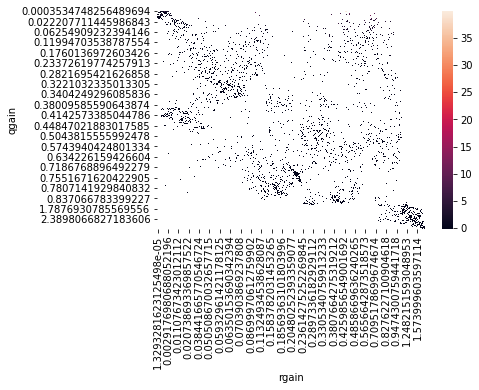

In [47]:
pt = df.pivot_table('change_score', 'qgain', 'rgain')
sns.heatmap(pt)

In [70]:
fig = px.scatter_3d(df, x='qgain', y='rgain', z='change_score', size = abs(df['change_score']), size_max = 10)
fig.show()

In [71]:
q = df.loc[df['change_score'].min() == df['change_score'], 'q'].values[0]
r = df.loc[df['change_score'].min() == df['change_score'], 'r'].values[0]
print(q, r)

[0.04427974 0.04427974 1.10699345 0.03372095 0.84302372] [0.00026239 0.00026239 0.00019982 0.00499549]


In [72]:
_, mean_before, score_before, mean_after, score_after =  evaluate(df_train, q, r)
print(mean_before, score_before, mean_after, score_after)
print(f"mean change : {mean_after - mean_before:.4f}")
print(f"score change: {score_after - score_before:.4f}")

  0%|          | 0/73 [00:00<?, ?it/s]

3.84684837499064 5.2879706490841585 62.526089844317205 135.59714954950246
mean change : 58.6792
score change: 130.3092


In [73]:
submission = pd.read_csv("../input/google-smartphone-decimeter-challenge/sample_submission.csv")
submission = submission[['phone', 'millisSinceGpsEpoch']]

In [74]:
result, _, _, _, _ =  evaluate(df_test, q, r, get_score=False)
result = result[['phone', 'millisSinceGpsEpoch', 'latDeg', 'lngDeg']]
submission = submission.merge(result, on = ['phone', 'millisSinceGpsEpoch'])

  0%|          | 0/48 [00:00<?, ?it/s]

In [75]:
submission.to_csv(f"./models/{'ComplexKalmanFilter1'}/result-{4}result.csv", index = False)